In [1]:
import csv
import numpy as np
from random import randint

import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import dgl
import dgl.function as fn


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

Using backend: pytorch


In [2]:
#Classes
    
class TimeStep():
    def __init__(self, timestep):
        self.timestep = timestep
        self.txs = []
        
    def addTx(self, tx):
        self.txs.append(tx)
        
    def numTxs(self):
        return len(self.txs)
        
class AllTxs(): #NOTE - Uses 1-49 indexing of timesteps
    def __init__(self):
        self.timesteps = [TimeStep(x) for x in range(1, 50)]
        
    def addTx(self, time_step, tx):
        self.timesteps[time_step - 1].addTx(tx)
    
    def getTimestep(self, index):
        return self.timesteps[index - 1]
        
class Tx():
    def __init__(self, tx_id, label, features):
        self.n_id = tx_id
        self.label = label
        self.features = [float(f) for f in features]
        
    def feat_length(self):
        return len(self.features)
    
    def feature_vector(self):
        return self.features
    
    def get_label(self):
        return self.label
                
    def one_hot_label(classes):
        label_vec = [0] * len(classes)
        for index, actual in enumerate(classes):
            if self.label == actual:
                label_vec[index] = 1
                
        return label_vec
        
        

In [3]:
#FileList
features_file = './elliptic/elliptic_txs_features.csv'
edgelist_file = './elliptic/elliptic_txs_edgelist.csv'
classes_file = './elliptic/elliptic_txs_classes.csv'

In [4]:
#Import classes and build dictionary
labels_lookup = {}
with open(classes_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if 'txId' in row:
            continue

        tx_id, label = int(row[0]), row[1]
        labels_lookup[tx_id] = 2 if label == 'unknown' else int(label) - 1

In [5]:
#Class Distribution GLOBAL
classes = ['illicit', 'licit', 'unknown']
class_dist = {
    'illicit': 0,
    'licit': 0,
    'unknown': 0
}
for x in labels_lookup.values():
    class_dist[classes[x]] += 1
classes_length = len(classes)
print(class_dist)

{'illicit': 4545, 'licit': 42019, 'unknown': 157205}


In [6]:
# #Import Features CSV, build TX objects - add them to respective timestep
# transactions = AllTxs()
# with open(features_file) as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     for row in csv_reader:
        
#         tx_id, timestep, features = int(row[0]), int(row[1]), row[2:] #NOTE - OPP HERE To Include timestep as feature
#         label = labels_lookup[tx_id]
#         tx = Tx(tx_id, labels_lookup, features)
#         transactions.addTx(timestep, tx)

In [7]:
#Don't break up the timesteps!! Treat like the nodes in the previous code
txs = {}
with open(features_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        tx_id, timestep, features = int(row[0]), int(row[1]), row[2:] #NOTE - OPP HERE To Include timestep as feature
        if timestep > 42:
            continue
        label = labels_lookup[tx_id]
        tx = Tx(tx_id, label, features)
        txs[tx_id] = tx
        

In [8]:
feat_length = list(txs.values())[0].feat_length()
feat_mask = [True] * feat_length
def preprocess(nodes, feats_mask):
    l = len(nodes)
    feat_length = list(nodes.values())[0].feat_length()
    classes_length = len(classes)
    
    node_ids = np.zeros((l), dtype=int)
    features = np.zeros((l, feat_length), dtype='float32')
    labels = np.zeros((l), int)
        
    for i, (node_id, node) in enumerate(nodes.items()):
        node_ids[i] = node_id
        feats = np.array(node.feature_vector())
        features[i] = feats[feats_mask]
        labels[i] = node.get_label()
        
    return node_ids, features, labels

def shuffle(node_ids, features, labels):
    assert len(labels) == len(node_ids) == len(features)
    p = np.random.permutation(len(labels))
    labels = labels[p]
    node_ids = node_ids[p]
    features = features[p]
    
    return node_ids, features, labels

In [9]:
import random
def assign_node_ids(tx_ids):
    nodes = {}
    for i in range(len(tx_ids)):
        nodes[tx_ids[i]] = i
    
    return nodes

def gen_labelled_mask(txs_id, nodes, switch):
    if switch == 'all':
        return [True for x in txs_id]
    elif switch == 'sample':
        
        mask = np.zeros((len(txs_id)), dtype=bool)
        for i, t in enumerate(txs_id):
            l = txs[t].label
            
            if l < 2:
                mask[i] = True
            else:
                r = random.randint(0,100)
                if r < 20:
                    mask[i] = True
                else:
                    mask[i] = False
                    
    return mask

In [10]:
np.bool(4)

True

In [11]:
def to_tensor(arr, float32=False):
    if float32:
        arr = np.float32(arr)
    
    arr = torch.from_numpy(arr)
    return arr

def to_gpu(tens):
    tens = tens.to(torch.device('cuda:0'))
    return tens

def class_weights(acc_dist):
    total = 0
    for x in acc_dist.values():
        total += x
    
    for acc in acc_dist.keys():

        acc_dist[acc] /= total
        acc_dist[acc] = 1 - acc_dist[acc]
    

    classes_w = np.array(list(acc_dist.values()))
    
    return classes_w

In [12]:
def train_test_mask(length):

    train_mask = np.empty((length), bool)

    mask_border = int(length // 1.25) #80% train, 20% test

    for i in range(length):
        train_mask[i] = True if i < mask_border else False

    test_mask = np.invert(train_mask) 
    
    return train_mask, test_mask

In [13]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[labelled_mask][mask]
        labels = labels[labelled_mask][mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        
        return correct.item() * 1.0 / len(labels)

In [14]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    
def accuracy(matrix):
    total = 0
    for x in matrix:
        total += sum(x)
        
    correct = 0
    for i in range(len(matrix)):
        correct += matrix[i][i]
        
    return correct / total

def precision(matrix, j):
    col_sum = 0
    for i in range(len(matrix)):
        col_sum += matrix[i][j]
        
    return 0 if col_sum == 0 else matrix[j][j] / col_sum

def recall(matrix, i):
    
    row_sum = sum(matrix[i])
    
    return 0 if row_sum == 0 else matrix[i][i] / row_sum

def mac_avg_metric(matrix, metric):
    res = []
    
    for i in range(len(matrix)):
        res.append(metric(matrix, i))
        
    return sum(res) / len(res)

def f1_score(precision, recall):
    
    return 2* ((precision * recall) / (precision + recall))

In [15]:
tx_ids, features, labels = preprocess(txs, feat_mask)
tx_ids, features, labels = shuffle(tx_ids, features, labels)

In [16]:
nodes = assign_node_ids(tx_ids)

In [17]:
#Graph assembly#
#------------------------------------------------------------------------------------------#
print("Building transaction graph")

sender, receiver = [], []
with open(edgelist_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if 'txId1' in row:
            continue
            
        s, r = int(row[0]), int(row[1])
        if s in nodes.keys():
            sender.append(s)
        if r in nodes.keys():
            receiver.append(r)
        
src = [nodes[s] for s in sender]
dest = [nodes[r] for r in receiver]
src, dest = np.array(src), np.array(dest)        
u = np.concatenate([src, dest])
v = np.concatenate([dest, src])

Building transaction graph


In [18]:
labelled_mask = gen_labelled_mask(tx_ids, nodes, 'sample')
c_weights = class_weights(class_dist)
train_mask, test_mask = train_test_mask(int(sum(labelled_mask)))

In [19]:
features_tensor = to_tensor(features, True)
labels_tensor = to_tensor(labels, False)
# labels_class_indices = torch.max(labels_tensor, 1).indices
labelled_mask = to_tensor(np.array(labelled_mask))
train_mask = to_tensor(train_mask)
test_mask = to_tensor(test_mask)
c_weights = to_tensor(c_weights, True)

In [20]:
features_tensor = to_gpu(features_tensor)
labels_tensor = to_gpu(labels_tensor)
# labels_class_indices = to_gpu(labels_class_indices)
labelled_mask = to_gpu(labelled_mask)
train_mask = to_gpu(train_mask)
test_mask = to_gpu(test_mask)
c_weights = to_gpu(c_weights)

In [21]:
msg_mul = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [22]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_feats, out_feats, msg_func, feat_pad = 0):
        super(GCNLayer, self).__init__()
        self.msg_func = msg_func
        self.linear = nn.Linear(in_feats + feat_pad, out_feats)  
        
    def forward(self, g, feature):
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(self.msg_func, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

In [23]:
def mid_point(in_feats, classes):
    return ((in_feats - classes) // 2) + classes

class Net(nn.Module):
    def __init__(self, msg_func, pad=0):
        super(Net, self).__init__()
        mid = mid_point(feat_length, classes_length)
#         self.layer1 = GCNLayer(feat_length, feat_length, msg_func, pad)
#         self.layer2 = GCNLayer(feat_length, mid, msg_func, pad)
        
        self.layer1 = nn.Linear(feat_length, feat_length)
        self.layer2 = nn.Linear(feat_length, mid)
        
        self.layer3 = nn.Linear(mid, classes_length)

  
    def forward(self, g, features):
#         x = torch.relu(self.layer1(g, features))
#         x = torch.relu(self.layer2(g, x))
        
        x = torch.relu(self.layer1(features))
        x = torch.relu(self.layer2(x))
        
        x = torch.relu(self.layer3(x))
#         x = F.relu(self.layer4(x))
        
        return x
#         return F.softmax(x, 1)

In [24]:
g = dgl.DGLGraph((u,v))
g = dgl.transform.add_self_loop(g)

g = to_gpu(g)

In [25]:
#build gnn
net = Net(msg_mul)
net.cuda() #make sure uses GPU
print(net)

Net(
  (layer1): Linear(in_features=165, out_features=165, bias=True)
  (layer2): Linear(in_features=165, out_features=84, bias=True)
  (layer3): Linear(in_features=84, out_features=3, bias=True)
)


In [26]:
#train - nll_loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_record = []
for epoch in range(100000):
    net.train()
    out = net(g, features_tensor)
    pred = F.log_softmax(out, 1)

    loss = F.nll_loss(pred[labelled_mask][train_mask], labels_tensor[labelled_mask][train_mask], c_weights)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"{epoch} - {loss}")
    loss_record.append(loss)

0 - 1.0867334604263306
1 - 1.023776888847351
2 - 0.9671201705932617
3 - 0.9165934920310974
4 - 0.8703032732009888
5 - 0.827360987663269
6 - 0.7877070903778076
7 - 0.7516379952430725
8 - 0.7195730209350586
9 - 0.6918546557426453
10 - 0.6685808300971985
11 - 0.6496486663818359
12 - 0.634801983833313
13 - 0.6236491203308105
14 - 0.615684449672699
15 - 0.6103208065032959
16 - 0.6069211363792419
17 - 0.6048451066017151
18 - 0.6034976243972778
19 - 0.6023864150047302
20 - 0.6011464595794678
21 - 0.5995417833328247
22 - 0.5974542498588562
23 - 0.5948675274848938
24 - 0.59181809425354
25 - 0.5883752703666687
26 - 0.5846359729766846
27 - 0.5807124972343445
28 - 0.5766865015029907
29 - 0.5726550221443176
30 - 0.5686002969741821
31 - 0.5646694898605347
32 - 0.5609945058822632
33 - 0.5576494336128235
34 - 0.5546391010284424
35 - 0.5519448518753052
36 - 0.5495461225509644
37 - 0.5473877787590027
38 - 0.5453646779060364
39 - 0.5433770418167114
40 - 0.5413122773170471
41 - 0.5390704274177551
42 - 0.5

337 - 0.19721409678459167
338 - 0.19690659642219543
339 - 0.1965043842792511
340 - 0.19606676697731018
341 - 0.19562748074531555
342 - 0.19523347914218903
343 - 0.19489070773124695
344 - 0.19458436965942383
345 - 0.19429561495780945
346 - 0.19400599598884583
347 - 0.19371330738067627
348 - 0.19339925050735474
349 - 0.1930856853723526
350 - 0.1927410513162613
351 - 0.19238817691802979
352 - 0.19200807809829712
353 - 0.19163548946380615
354 - 0.19125528633594513
355 - 0.19089186191558838
356 - 0.1905333250761032
357 - 0.1901874989271164
358 - 0.18984751403331757
359 - 0.18951205909252167
360 - 0.18918286263942719
361 - 0.18885891139507294
362 - 0.18854057788848877
363 - 0.18823066353797913
364 - 0.18793940544128418
365 - 0.1876956671476364
366 - 0.1875600963830948
367 - 0.18773601949214935
368 - 0.1883537918329239
369 - 0.1897558569908142
370 - 0.18944285809993744
371 - 0.18779651820659637
372 - 0.18598082661628723
373 - 0.18661460280418396
374 - 0.187361940741539
375 - 0.185418650507926

666 - 0.13689358532428741
667 - 0.13708853721618652
668 - 0.13758137822151184
669 - 0.13754217326641083
670 - 0.13772764801979065
671 - 0.13717426359653473
672 - 0.13686104118824005
673 - 0.13631930947303772
674 - 0.1359502226114273
675 - 0.13562437891960144
676 - 0.1353151649236679
677 - 0.1352519690990448
678 - 0.13529172539710999
679 - 0.1354283094406128
680 - 0.13527290523052216
681 - 0.13497132062911987
682 - 0.1345062404870987
683 - 0.13422438502311707
684 - 0.13414721190929413
685 - 0.13417057693004608
686 - 0.1342516988515854
687 - 0.13421949744224548
688 - 0.1340898871421814
689 - 0.13372233510017395
690 - 0.13352753221988678
691 - 0.13345524668693542
692 - 0.13337822258472443
693 - 0.1332046389579773
694 - 0.13302259147167206
695 - 0.13286390900611877
696 - 0.13273561000823975
697 - 0.13271492719650269
698 - 0.13270902633666992
699 - 0.1326872855424881
700 - 0.13261856138706207
701 - 0.13263753056526184
702 - 0.13261297345161438
703 - 0.13270409405231476
704 - 0.1327416747808

994 - 0.11030471324920654
995 - 0.11008742451667786
996 - 0.10993543267250061
997 - 0.10987618565559387
998 - 0.10989970713853836
999 - 0.10996385663747787
1000 - 0.11004658043384552
1001 - 0.1101006269454956
1002 - 0.11025198549032211
1003 - 0.11039938032627106
1004 - 0.11063186079263687
1005 - 0.11068825423717499
1006 - 0.11095422506332397
1007 - 0.1108500063419342
1008 - 0.11096237599849701
1009 - 0.11054540425539017
1010 - 0.11029119044542313
1011 - 0.10973527282476425
1012 - 0.10937292128801346
1013 - 0.10911984741687775
1014 - 0.10905798524618149
1015 - 0.10908786952495575
1016 - 0.10916255414485931
1017 - 0.10932181775569916
1018 - 0.10939796268939972
1019 - 0.10955235362052917
1020 - 0.10952583700418472
1021 - 0.10957223922014236
1022 - 0.10928184539079666
1023 - 0.10903619229793549
1024 - 0.1087375059723854
1025 - 0.10851658135652542
1026 - 0.10827412456274033
1027 - 0.10811182111501694
1028 - 0.10804308205842972
1029 - 0.1080436035990715
1030 - 0.10806556791067123
1031 - 0.10

1302 - 0.094474658370018
1303 - 0.09454214572906494
1304 - 0.09479392319917679
1305 - 0.09505609422922134
1306 - 0.09541383385658264
1307 - 0.09549933671951294
1308 - 0.0956919863820076
1309 - 0.09546545892953873
1310 - 0.0953369289636612
1311 - 0.09491775929927826
1312 - 0.09458120167255402
1313 - 0.09424065053462982
1314 - 0.09405538439750671
1315 - 0.09401418268680573
1316 - 0.09407021850347519
1317 - 0.09421945363283157
1318 - 0.09431015700101852
1319 - 0.09443992376327515
1320 - 0.09446188807487488
1321 - 0.0945785641670227
1322 - 0.09452532231807709
1323 - 0.09459956735372543
1324 - 0.09449903666973114
1325 - 0.09444086998701096
1326 - 0.09414101392030716
1327 - 0.09390275925397873
1328 - 0.09365497529506683
1329 - 0.09349086135625839
1330 - 0.09339872747659683
1331 - 0.0933576300740242
1332 - 0.09333329647779465
1333 - 0.09330873191356659
1334 - 0.09329937398433685
1335 - 0.0932890772819519
1336 - 0.0933220311999321
1337 - 0.0933675467967987
1338 - 0.0935162827372551
1339 - 0.09

1608 - 0.08401907980442047
1609 - 0.08420103788375854
1610 - 0.08451385051012039
1611 - 0.08463310450315475
1612 - 0.0849420353770256
1613 - 0.08487269282341003
1614 - 0.08497343957424164
1615 - 0.08461504429578781
1616 - 0.08441609889268875
1617 - 0.08395855128765106
1618 - 0.08366063237190247
1619 - 0.08337589353322983
1620 - 0.08326204866170883
1621 - 0.08326783031225204
1622 - 0.08335473388433456
1623 - 0.08353708684444427
1624 - 0.08368504047393799
1625 - 0.08393638581037521
1626 - 0.0839979350566864
1627 - 0.08421026170253754
1628 - 0.0840960443019867
1629 - 0.0841069370508194
1630 - 0.08380786329507828
1631 - 0.08363630622625351
1632 - 0.08333677798509598
1633 - 0.0831834077835083
1634 - 0.08303805440664291
1635 - 0.08298857510089874
1636 - 0.08297514170408249
1637 - 0.08302468061447144
1638 - 0.08307358622550964
1639 - 0.08310598134994507
1640 - 0.08318030089139938
1641 - 0.08317648619413376
1642 - 0.08325757831335068
1643 - 0.0831507071852684
1644 - 0.08313652127981186
1645 - 

1916 - 0.07647011429071426
1917 - 0.07583398371934891
1918 - 0.07542651146650314
1919 - 0.07521254569292068
1920 - 0.07522633671760559
1921 - 0.07538194209337234
1922 - 0.07558084279298782
1923 - 0.07591024041175842
1924 - 0.07611338049173355
1925 - 0.07652619481086731
1926 - 0.0765301063656807
1927 - 0.07675023376941681
1928 - 0.07637005299329758
1929 - 0.07619477808475494
1930 - 0.07569477707147598
1931 - 0.07534395903348923
1932 - 0.07501976191997528
1933 - 0.07490412145853043
1934 - 0.0749659314751625
1935 - 0.07514888048171997
1936 - 0.07546548545360565
1937 - 0.07573488354682922
1938 - 0.07618922740221024
1939 - 0.07620135694742203
1940 - 0.07627671957015991
1941 - 0.07584596425294876
1942 - 0.07551988214254379
1943 - 0.07502099126577377
1944 - 0.07473544776439667
1945 - 0.07459113001823425
1946 - 0.07464548200368881
1947 - 0.07480250298976898
1948 - 0.07498236745595932
1949 - 0.07522428780794144
1950 - 0.07526660710573196
1951 - 0.0753297433257103
1952 - 0.07509943097829819
1953

2243 - 0.06908255070447922
2244 - 0.0687403678894043
2245 - 0.06840338557958603
2246 - 0.0682644322514534
2247 - 0.06824827194213867
2248 - 0.06830703467130661
2249 - 0.0684155821800232
2250 - 0.06853342056274414
2251 - 0.06875313073396683
2252 - 0.06890834122896194
2253 - 0.06922978907823563
2254 - 0.06928758323192596
2255 - 0.06961844861507416
2256 - 0.0694303810596466
2257 - 0.06943987309932709
2258 - 0.06903944909572601
2259 - 0.06888419389724731
2260 - 0.06851936876773834
2261 - 0.06834731996059418
2262 - 0.06811568886041641
2263 - 0.06801097095012665
2264 - 0.06799805164337158
2265 - 0.06805181503295898
2266 - 0.06819736957550049
2267 - 0.06835923343896866
2268 - 0.06866342574357986
2269 - 0.06878487765789032
2270 - 0.0689680203795433
2271 - 0.06883182376623154
2272 - 0.06887269020080566
2273 - 0.06862963736057281
2274 - 0.06854454427957535
2275 - 0.06825031340122223
2276 - 0.06807669997215271
2277 - 0.0678769126534462
2278 - 0.06781668961048126
2279 - 0.06782208383083344
2280 - 

2549 - 0.06568816304206848
2550 - 0.06521706283092499
2551 - 0.06520198285579681
2552 - 0.06443819403648376
2553 - 0.06394785642623901
2554 - 0.0632505789399147
2555 - 0.06294438242912292
2556 - 0.06299050152301788
2557 - 0.06316734105348587
2558 - 0.06343986093997955
2559 - 0.0636584684252739
2560 - 0.06402947008609772
2561 - 0.06402336806058884
2562 - 0.06419619172811508
2563 - 0.0640915259718895
2564 - 0.06428565829992294
2565 - 0.06388654559850693
2566 - 0.06377024948596954
2567 - 0.06341923028230667
2568 - 0.06331150978803635
2569 - 0.06300320476293564
2570 - 0.06285402178764343
2571 - 0.06275269389152527
2572 - 0.06267719715833664
2573 - 0.06269659101963043
2574 - 0.0628141388297081
2575 - 0.06298398971557617
2576 - 0.06307725608348846
2577 - 0.06332063674926758
2578 - 0.06341990828514099
2579 - 0.06378966569900513
2580 - 0.0638158991932869
2581 - 0.06415895372629166
2582 - 0.06406250596046448
2583 - 0.06429944932460785
2584 - 0.06391460448503494
2585 - 0.0637940838932991
2586 - 

2855 - 0.05858996510505676
2856 - 0.058762747794389725
2857 - 0.058910612016916275
2858 - 0.05914490669965744
2859 - 0.05928817763924599
2860 - 0.059628624469041824
2861 - 0.05974508821964264
2862 - 0.06018483266234398
2863 - 0.06003110483288765
2864 - 0.06029791757464409
2865 - 0.059756647795438766
2866 - 0.05957382172346115
2867 - 0.05903584137558937
2868 - 0.05875178799033165
2869 - 0.05847769230604172
2870 - 0.05839560180902481
2871 - 0.05838938429951668
2872 - 0.058463383466005325
2873 - 0.05862228199839592
2874 - 0.05880545824766159
2875 - 0.05908256769180298
2876 - 0.05918504297733307
2877 - 0.05955161154270172
2878 - 0.059630509465932846
2879 - 0.060107432305812836
2880 - 0.05992165207862854
2881 - 0.06016312539577484
2882 - 0.05971464514732361
2883 - 0.05963169038295746
2884 - 0.05896133556962013
2885 - 0.05855115130543709
2886 - 0.05822189897298813
2887 - 0.0581139400601387
2888 - 0.058150194585323334
2889 - 0.058349043130874634
2890 - 0.05868762731552124
2891 - 0.05891888961

3160 - 0.055410418659448624
3161 - 0.05532018840312958
3162 - 0.054974500089883804
3163 - 0.05464936047792435
3164 - 0.05444248393177986
3165 - 0.054426249116659164
3166 - 0.054514121264219284
3167 - 0.0546581856906414
3168 - 0.05484862998127937
3169 - 0.0548836924135685
3170 - 0.05499037355184555
3171 - 0.054942239075899124
3172 - 0.055065400898456573
3173 - 0.055038221180438995
3174 - 0.05523681640625
3175 - 0.055285073816776276
3176 - 0.055806443095207214
3177 - 0.05573497712612152
3178 - 0.056036822497844696
3179 - 0.05556611716747284
3180 - 0.0555059053003788
3181 - 0.05495430901646614
3182 - 0.054724108427762985
3183 - 0.05465364456176758
3184 - 0.05472537875175476
3185 - 0.05466302111744881
3186 - 0.054547250270843506
3187 - 0.05444813519716263
3188 - 0.05424712598323822
3189 - 0.05415883660316467
3190 - 0.054191187024116516
3191 - 0.05431564897298813
3192 - 0.05435360223054886
3193 - 0.0548400953412056
3194 - 0.054624609649181366
3195 - 0.054928258061409
3196 - 0.05497808009386

3465 - 0.05166802555322647
3466 - 0.0517001673579216
3467 - 0.051927629858255386
3468 - 0.05172567442059517
3469 - 0.051719922572374344
3470 - 0.05150557681918144
3471 - 0.05149516090750694
3472 - 0.05144220218062401
3473 - 0.051623161882162094
3474 - 0.05151021108031273
3475 - 0.05159055069088936
3476 - 0.05132530629634857
3477 - 0.05117996409535408
3478 - 0.05097939074039459
3479 - 0.05091560259461403
3480 - 0.05090925097465515
3481 - 0.05106343328952789
3482 - 0.05110425129532814
3483 - 0.0510968342423439
3484 - 0.05092485621571541
3485 - 0.05082276836037636
3486 - 0.05070475861430168
3487 - 0.05069754645228386
3488 - 0.05072779580950737
3489 - 0.05081387609243393
3490 - 0.050900671631097794
3491 - 0.05111908167600632
3492 - 0.051218774169683456
3493 - 0.05160852521657944
3494 - 0.051860563457012177
3495 - 0.052632253617048264
3496 - 0.052981916815042496
3497 - 0.05458469316363335
3498 - 0.054580312222242355
3499 - 0.05662307143211365
3500 - 0.05523521825671196
3501 - 0.055608604103

3772 - 0.049020346254110336
3773 - 0.04899722337722778
3774 - 0.049418944865465164
3775 - 0.04927140846848488
3776 - 0.049746401607990265
3777 - 0.04935532063245773
3778 - 0.04945933818817139
3779 - 0.048703983426094055
3780 - 0.04838906601071358
3781 - 0.04787139594554901
3782 - 0.047622453421354294
3783 - 0.047537073493003845
3784 - 0.04762974753975868
3785 - 0.0478777252137661
3786 - 0.04809032380580902
3787 - 0.048515040427446365
3788 - 0.048523616045713425
3789 - 0.04870688170194626
3790 - 0.048404235392808914
3791 - 0.04843230918049812
3792 - 0.048175446689128876
3793 - 0.048225995153188705
3794 - 0.04798634350299835
3795 - 0.04786224290728569
3796 - 0.047608837485313416
3797 - 0.04746483266353607
3798 - 0.04737481847405434
3799 - 0.04734361916780472
3800 - 0.04735603928565979
3801 - 0.047389283776283264
3802 - 0.047521211206912994
3803 - 0.04764530435204506
3804 - 0.047965217381715775
3805 - 0.04818433150649071
3806 - 0.04877444729208946
3807 - 0.04891911521553993
3808 - 0.04959

4075 - 0.04565223678946495
4076 - 0.045414168387651443
4077 - 0.045458875596523285
4078 - 0.04531918466091156
4079 - 0.045382559299468994
4080 - 0.045239660888910294
4081 - 0.04515534266829491
4082 - 0.045020878314971924
4083 - 0.044861845672130585
4084 - 0.04478239268064499
4085 - 0.0447346493601799
4086 - 0.04482279717922211
4087 - 0.044943153858184814
4088 - 0.04523447901010513
4089 - 0.04537767171859741
4090 - 0.04573485255241394
4091 - 0.045586246997117996
4092 - 0.04584493860602379
4093 - 0.045533906668424606
4094 - 0.04559994861483574
4095 - 0.04537509009242058
4096 - 0.04547290503978729
4097 - 0.0454242117702961
4098 - 0.04579201340675354
4099 - 0.04576420038938522
4100 - 0.04601632058620453
4101 - 0.04566013440489769
4102 - 0.04536134749650955
4103 - 0.04481015354394913
4104 - 0.04445822909474373
4105 - 0.04437079280614853
4106 - 0.04452322795987129
4107 - 0.04479646682739258
4108 - 0.04502544552087784
4109 - 0.04514721781015396
4110 - 0.04501461982727051
4111 - 0.044832091778

4383 - 0.042649224400520325
4384 - 0.04266202077269554
4385 - 0.04266909509897232
4386 - 0.042670540511608124
4387 - 0.042665813118219376
4388 - 0.04265314340591431
4389 - 0.04261881113052368
4390 - 0.042591411620378494
4391 - 0.04257328435778618
4392 - 0.04256138578057289
4393 - 0.04255605861544609
4394 - 0.04255416616797447
4395 - 0.04255881905555725
4396 - 0.04256926476955414
4397 - 0.04259049892425537
4398 - 0.042621172964572906
4399 - 0.04262557998299599
4400 - 0.042600277811288834
4401 - 0.04255341365933418
4402 - 0.042505424469709396
4403 - 0.04248100146651268
4404 - 0.042481254786252975
4405 - 0.04249952360987663
4406 - 0.0425281785428524
4407 - 0.04254612326622009
4408 - 0.04252702742815018
4409 - 0.042494721710681915
4410 - 0.04245397448539734
4411 - 0.04242219030857086
4412 - 0.0424111932516098
4413 - 0.04241597279906273
4414 - 0.04243120178580284
4415 - 0.04245424270629883
4416 - 0.04247678816318512
4417 - 0.04247630387544632
4418 - 0.04246192425489426
4419 - 0.042423777282

4687 - 0.041844092309474945
4688 - 0.04146670550107956
4689 - 0.04131314158439636
4690 - 0.04089420661330223
4691 - 0.04062280431389809
4692 - 0.040458790957927704
4693 - 0.04042641818523407
4694 - 0.04048442840576172
4695 - 0.04060664400458336
4696 - 0.040781233459711075
4697 - 0.04090951755642891
4698 - 0.041112419217824936
4699 - 0.04112085700035095
4700 - 0.0412742905318737
4701 - 0.04112154617905617
4702 - 0.041108064353466034
4703 - 0.040898166596889496
4704 - 0.04076584056019783
4705 - 0.04056873545050621
4706 - 0.04043964669108391
4707 - 0.040349557995796204
4708 - 0.04031010717153549
4709 - 0.04029577970504761
4710 - 0.04030156880617142
4711 - 0.04032231867313385
4712 - 0.040378641337156296
4713 - 0.04049454629421234
4714 - 0.0406479686498642
4715 - 0.040975421667099
4716 - 0.041232626885175705
4717 - 0.04194917529821396
4718 - 0.04219815880060196
4719 - 0.0431460365653038
4720 - 0.0426035150885582
4721 - 0.042726170271635056
4722 - 0.0415949821472168
4723 - 0.0409384779632091

4993 - 0.039596397429704666
4994 - 0.039560627192258835
4995 - 0.039134785532951355
4996 - 0.038914814591407776
4997 - 0.0386054590344429
4998 - 0.03843454644083977
4999 - 0.038379501551389694
5000 - 0.03845345973968506
5001 - 0.03865085169672966
5002 - 0.038880158215761185
5003 - 0.039245836436748505
5004 - 0.03938727825880051
5005 - 0.03988732397556305
5006 - 0.03977493196725845
5007 - 0.040124259889125824
5008 - 0.039682045578956604
5009 - 0.03963480517268181
5010 - 0.03906531631946564
5011 - 0.038699351251125336
5012 - 0.03836623951792717
5013 - 0.038259584456682205
5014 - 0.03831641748547554
5015 - 0.0384737029671669
5016 - 0.038725871592760086
5017 - 0.03889849781990051
5018 - 0.03922853246331215
5019 - 0.03926098346710205
5020 - 0.039578258991241455
5021 - 0.03933514654636383
5022 - 0.03937753289937973
5023 - 0.03886411339044571
5024 - 0.03858642652630806
5025 - 0.038295678794384
5026 - 0.038173843175172806
5027 - 0.038174405694007874
5028 - 0.03826987370848656
5029 - 0.03845370

5297 - 0.03716954216361046
5298 - 0.03720135986804962
5299 - 0.0373280867934227
5300 - 0.03704618662595749
5301 - 0.037013448774814606
5302 - 0.03678317368030548
5303 - 0.0366106815636158
5304 - 0.036476898938417435
5305 - 0.03641973063349724
5306 - 0.03649191930890083
5307 - 0.03656262531876564
5308 - 0.036661624908447266
5309 - 0.03667975962162018
5310 - 0.036738596856594086
5311 - 0.03674069419503212
5312 - 0.03682206943631172
5313 - 0.0367763377726078
5314 - 0.03682031109929085
5315 - 0.03677701577544212
5316 - 0.036878012120723724
5317 - 0.036793868988752365
5318 - 0.03689657151699066
5319 - 0.03673457354307175
5320 - 0.03666818141937256
5321 - 0.03657063469290733
5322 - 0.03652046620845795
5323 - 0.03645732253789902
5324 - 0.03642820566892624
5325 - 0.03640454262495041
5326 - 0.03639482706785202
5327 - 0.036380790174007416
5328 - 0.03637917712330818
5329 - 0.0364081896841526
5330 - 0.036434173583984375
5331 - 0.0365256741642952
5332 - 0.03659968823194504
5333 - 0.0368550345301628

5602 - 0.035223592072725296
5603 - 0.03651866316795349
5604 - 0.037063512951135635
5605 - 0.036831408739089966
5606 - 0.03593771904706955
5607 - 0.03541004657745361
5608 - 0.03580790013074875
5609 - 0.03532063215970993
5610 - 0.03539489954710007
5611 - 0.035068150609731674
5612 - 0.03541048988699913
5613 - 0.03522517904639244
5614 - 0.03530610725283623
5615 - 0.035279780626297
5616 - 0.035373806953430176
5617 - 0.03542965278029442
5618 - 0.03520688787102699
5619 - 0.03525415435433388
5620 - 0.03495044261217117
5621 - 0.03500409424304962
5622 - 0.03474060818552971
5623 - 0.034886617213487625
5624 - 0.03478918969631195
5625 - 0.03498135134577751
5626 - 0.035078343003988266
5627 - 0.03518747538328171
5628 - 0.03536861762404442
5629 - 0.035359833389520645
5630 - 0.035649292171001434
5631 - 0.03530672937631607
5632 - 0.03531837835907936
5633 - 0.03489962965250015
5634 - 0.034912239760160446
5635 - 0.0346517413854599
5636 - 0.03476238623261452
5637 - 0.03469453379511833
5638 - 0.034861948341

5907 - 0.03408637270331383
5908 - 0.03448983654379845
5909 - 0.034417524933815
5910 - 0.034960102289915085
5911 - 0.034651320427656174
5912 - 0.0349150151014328
5913 - 0.03429953753948212
5914 - 0.03406599164009094
5915 - 0.03355167433619499
5916 - 0.03336804360151291
5917 - 0.03329203277826309
5918 - 0.03333497419953346
5919 - 0.033345554023981094
5920 - 0.03326965123414993
5921 - 0.033240266144275665
5922 - 0.03323393687605858
5923 - 0.03333926200866699
5924 - 0.033440615981817245
5925 - 0.033714659512043
5926 - 0.03365929424762726
5927 - 0.03380709886550903
5928 - 0.03357549384236336
5929 - 0.03365730494260788
5930 - 0.033623117953538895
5931 - 0.033829256892204285
5932 - 0.03382665291428566
5933 - 0.03411073610186577
5934 - 0.03388257697224617
5935 - 0.03392947092652321
5936 - 0.03363935276865959
5937 - 0.03362826257944107
5938 - 0.03354347497224808
5939 - 0.033756762742996216
5940 - 0.0336131826043129
5941 - 0.03360295668244362
5942 - 0.03325480967760086
5943 - 0.03306293115019798

6210 - 0.03258948028087616
6211 - 0.032734740525484085
6212 - 0.03244607895612717
6213 - 0.03241589665412903
6214 - 0.032010674476623535
6215 - 0.03174235299229622
6216 - 0.03169303014874458
6217 - 0.0318463109433651
6218 - 0.03218710795044899
6219 - 0.032259538769721985
6220 - 0.03243931010365486
6221 - 0.03208329156041145
6222 - 0.03188880905508995
6223 - 0.03171153366565704
6224 - 0.031749267131090164
6225 - 0.03185640275478363
6226 - 0.03201182186603546
6227 - 0.032029420137405396
6228 - 0.03185771778225899
6229 - 0.03167428448796272
6230 - 0.031541209667921066
6231 - 0.03153456375002861
6232 - 0.031611185520887375
6233 - 0.03172821179032326
6234 - 0.03180760145187378
6235 - 0.03185167908668518
6236 - 0.031881045550107956
6237 - 0.0323256216943264
6238 - 0.031679775565862656
6239 - 0.031589314341545105
6240 - 0.03157763555645943
6241 - 0.031644247472286224
6242 - 0.031772978603839874
6243 - 0.03185774013400078
6244 - 0.0321153961122036
6245 - 0.032381631433963776
6246 - 0.033069740

6516 - 0.03323300555348396
6517 - 0.03327919542789459
6518 - 0.031659238040447235
6519 - 0.0311093982309103
6520 - 0.030641397461295128
6521 - 0.030553391203284264
6522 - 0.030769437551498413
6523 - 0.03104322962462902
6524 - 0.03166521340608597
6525 - 0.03169582039117813
6526 - 0.032352130860090256
6527 - 0.03173726797103882
6528 - 0.031743671745061874
6529 - 0.03101404570043087
6530 - 0.03069038689136505
6531 - 0.030495578423142433
6532 - 0.030587006360292435
6533 - 0.030637536197900772
6534 - 0.03057592362165451
6535 - 0.030476002022624016
6536 - 0.03036806359887123
6537 - 0.030447348952293396
6538 - 0.030545303598046303
6539 - 0.03079245239496231
6540 - 0.030687151476740837
6541 - 0.030661994591355324
6542 - 0.030412500724196434
6543 - 0.030369726940989494
6544 - 0.030373018234968185
6545 - 0.03053753264248371
6546 - 0.030610274523496628
6547 - 0.030773155391216278
6548 - 0.030616868287324905
6549 - 0.030577844008803368
6550 - 0.030418477952480316
6551 - 0.03047456219792366
6552 - 

6822 - 0.15216535329818726
6823 - 0.17286601662635803
6824 - 0.11248023062944412
6825 - 0.12930022180080414
6826 - 0.13211992383003235
6827 - 0.12977080047130585
6828 - 0.10026240348815918
6829 - 0.1304158717393875
6830 - 0.0957547277212143
6831 - 0.11601598560810089
6832 - 0.07336313277482986
6833 - 0.07997458428144455
6834 - 0.07146777957677841
6835 - 0.06494405120611191
6836 - 0.08197501301765442
6837 - 0.06365751475095749
6838 - 0.06020074710249901
6839 - 0.05766459181904793
6840 - 0.0617421455681324
6841 - 0.05458958446979523
6842 - 0.05747927725315094
6843 - 0.05236033722758293
6844 - 0.0522475503385067
6845 - 0.04978694021701813
6846 - 0.047912146896123886
6847 - 0.042657624930143356
6848 - 0.04388556256890297
6849 - 0.04176632687449455
6850 - 0.04220043867826462
6851 - 0.04150442034006119
6852 - 0.039394624531269073
6853 - 0.03842587769031525
6854 - 0.037797968834638596
6855 - 0.036934953182935715
6856 - 0.03609123080968857
6857 - 0.03560265153646469
6858 - 0.03440600633621216


7126 - 0.028328007087111473
7127 - 0.02833434008061886
7128 - 0.028338009491562843
7129 - 0.02833736687898636
7130 - 0.0283314511179924
7131 - 0.028313759714365005
7132 - 0.028300700709223747
7133 - 0.02829566039144993
7134 - 0.028300093486905098
7135 - 0.02831091545522213
7136 - 0.02831510826945305
7137 - 0.02830580621957779
7138 - 0.028291212394833565
7139 - 0.028286229819059372
7140 - 0.028277911245822906
7141 - 0.028267569839954376
7142 - 0.028264274820685387
7143 - 0.028268568217754364
7144 - 0.028278056532144547
7145 - 0.02827543579041958
7146 - 0.028283225372433662
7147 - 0.028276463970541954
7148 - 0.028265301138162613
7149 - 0.02824787050485611
7150 - 0.028235075995326042
7151 - 0.028240401297807693
7152 - 0.028248729184269905
7153 - 0.028246527537703514
7154 - 0.028241395950317383
7155 - 0.028226180002093315
7156 - 0.028220392763614655
7157 - 0.028227871283888817
7158 - 0.028223097324371338
7159 - 0.028221532702445984
7160 - 0.02821391262114048
7161 - 0.02821175940334797
7162

7435 - 0.027569938451051712
7436 - 0.02759350650012493
7437 - 0.0276200994849205
7438 - 0.027496876195073128
7439 - 0.027469206601381302
7440 - 0.02741897851228714
7441 - 0.027350958436727524
7442 - 0.027299145236611366
7443 - 0.02731078304350376
7444 - 0.027404319494962692
7445 - 0.027455691248178482
7446 - 0.027476120740175247
7447 - 0.02743392623960972
7448 - 0.027494555339217186
7449 - 0.027493592351675034
7450 - 0.027489110827445984
7451 - 0.027380844578146935
7452 - 0.027348747476935387
7453 - 0.02732171304523945
7454 - 0.027310064062476158
7455 - 0.027271296828985214
7456 - 0.02724284678697586
7457 - 0.027231881394982338
7458 - 0.02723616547882557
7459 - 0.027251094579696655
7460 - 0.0272691510617733
7461 - 0.0273225586861372
7462 - 0.02738712914288044
7463 - 0.027586210519075394
7464 - 0.02769475243985653
7465 - 0.027925429865717888
7466 - 0.027749691158533096
7467 - 0.027643635869026184
7468 - 0.027377357706427574
7469 - 0.02723660320043564
7470 - 0.02721291594207287
7471 - 0.

7743 - 0.026516590267419815
7744 - 0.02670925483107567
7745 - 0.026814710348844528
7746 - 0.027056492865085602
7747 - 0.027015475556254387
7748 - 0.027808278799057007
7749 - 0.027372820302844048
7750 - 0.027932889759540558
7751 - 0.02755683660507202
7752 - 0.027610942721366882
7753 - 0.027087315917015076
7754 - 0.0267958827316761
7755 - 0.02686704881489277
7756 - 0.026390792801976204
7757 - 0.026459934189915657
7758 - 0.0266069658100605
7759 - 0.026756180450320244
7760 - 0.02686326578259468
7761 - 0.02758108451962471
7762 - 0.027377866208553314
7763 - 0.027935925871133804
7764 - 0.02773742750287056
7765 - 0.02803976647555828
7766 - 0.027416154742240906
7767 - 0.027089174836874008
7768 - 0.02666730061173439
7769 - 0.026450246572494507
7770 - 0.026445584371685982
7771 - 0.026584777981042862
7772 - 0.026905620470643044
7773 - 0.027109509333968163
7774 - 0.027624664828181267
7775 - 0.027680957689881325
7776 - 0.028300603851675987
7777 - 0.027891524136066437
7778 - 0.028124544769525528
7779

8048 - 0.025832463055849075
8049 - 0.02618909627199173
8050 - 0.026201678439974785
8051 - 0.026352861896157265
8052 - 0.025868266820907593
8053 - 0.025607384741306305
8054 - 0.025483977049589157
8055 - 0.025550976395606995
8056 - 0.02559838443994522
8057 - 0.025570835918188095
8058 - 0.0256149061024189
8059 - 0.02570428140461445
8060 - 0.025947829708456993
8061 - 0.025933733209967613
8062 - 0.026006031781435013
8063 - 0.025867417454719543
8064 - 0.02601739764213562
8065 - 0.02595602348446846
8066 - 0.0260431170463562
8067 - 0.02574840560555458
8068 - 0.025554152205586433
8069 - 0.02542063221335411
8070 - 0.025452950969338417
8071 - 0.025486480444669724
8072 - 0.025467192754149437
8073 - 0.02544943057000637
8074 - 0.02545182779431343
8075 - 0.02557111158967018
8076 - 0.025697292760014534
8077 - 0.025983285158872604
8078 - 0.02605232410132885
8079 - 0.026479750871658325
8080 - 0.026523927226662636
8081 - 0.027303427457809448
8082 - 0.027094272896647453
8083 - 0.027599254623055458
8084 - 

8353 - 0.024723775684833527
8354 - 0.0246978048235178
8355 - 0.024685250595211983
8356 - 0.02464798279106617
8357 - 0.024666802957654
8358 - 0.024684492498636246
8359 - 0.02478092350065708
8360 - 0.024855341762304306
8361 - 0.025080256164073944
8362 - 0.025212468579411507
8363 - 0.02592555247247219
8364 - 0.025792835280299187
8365 - 0.026720764115452766
8366 - 0.026913801208138466
8367 - 0.02866394817829132
8368 - 0.02830793708562851
8369 - 0.031006766483187675
8370 - 0.030342947691679
8371 - 0.03545975685119629
8372 - 0.03428739681839943
8373 - 0.044967297464609146
8374 - 0.04538185894489288
8375 - 0.09147461503744125
8376 - 0.10124319791793823
8377 - 0.3156660795211792
8378 - 0.07431772351264954
8379 - 0.26098406314849854
8380 - 0.2861761450767517
8381 - 0.30005770921707153
8382 - 0.09994152933359146
8383 - 0.2953518331050873
8384 - 0.18578577041625977
8385 - 0.19910788536071777
8386 - 0.2367870956659317
8387 - 0.14365211129188538
8388 - 0.1776524782180786
8389 - 0.18643565475940704


8657 - 0.024283207952976227
8658 - 0.02428366057574749
8659 - 0.024282976984977722
8660 - 0.02428165078163147
8661 - 0.02427634969353676
8662 - 0.02427493967115879
8663 - 0.024270178750157356
8664 - 0.02426975779235363
8665 - 0.02426876686513424
8666 - 0.02427435852587223
8667 - 0.024260520935058594
8668 - 0.024256570264697075
8669 - 0.024248695001006126
8670 - 0.024248143658041954
8671 - 0.024245336651802063
8672 - 0.024244841188192368
8673 - 0.02424386329948902
8674 - 0.024239713326096535
8675 - 0.024238213896751404
8676 - 0.02423165552318096
8677 - 0.02423211932182312
8678 - 0.02422209642827511
8679 - 0.02422475256025791
8680 - 0.024215316399931908
8681 - 0.024218041449785233
8682 - 0.02421109937131405
8683 - 0.024214785546064377
8684 - 0.02420738711953163
8685 - 0.024208148941397667
8686 - 0.024205291643738747
8687 - 0.02420075051486492
8688 - 0.02420375496149063
8689 - 0.024198945611715317
8690 - 0.02420279197394848
8691 - 0.024189481511712074
8692 - 0.024187136441469193
8693 - 0.

8959 - 0.023577719926834106
8960 - 0.023584865033626556
8961 - 0.02359180338680744
8962 - 0.02361016348004341
8963 - 0.023594560101628304
8964 - 0.0235893651843071
8965 - 0.023553533479571342
8966 - 0.023534823209047318
8967 - 0.02352408692240715
8968 - 0.02353464625775814
8969 - 0.023557135835289955
8970 - 0.023590268567204475
8971 - 0.02363436296582222
8972 - 0.02362901344895363
8973 - 0.023618899285793304
8974 - 0.023562360554933548
8975 - 0.023516446352005005
8976 - 0.0235058031976223
8977 - 0.023538760840892792
8978 - 0.023572470992803574
8979 - 0.02359003946185112
8980 - 0.023600323125720024
8981 - 0.02356613799929619
8982 - 0.023525744676589966
8983 - 0.023490969091653824
8984 - 0.023486794903874397
8985 - 0.02349747158586979
8986 - 0.02351638302206993
8987 - 0.023560278117656708
8988 - 0.02356773242354393
8989 - 0.02358585223555565
8990 - 0.02355828881263733
8991 - 0.023525511845946312
8992 - 0.02348221093416214
8993 - 0.023469777777791023
8994 - 0.023468688130378723
8995 - 0.0

9264 - 0.023485228419303894
9265 - 0.023469265550374985
9266 - 0.023646382614970207
9267 - 0.02343178167939186
9268 - 0.02338806726038456
9269 - 0.02310904674232006
9270 - 0.022921117022633553
9271 - 0.022837160155177116
9272 - 0.02290530875325203
9273 - 0.023047424852848053
9274 - 0.02314448356628418
9275 - 0.0233094934374094
9276 - 0.023336797952651978
9277 - 0.023549428209662437
9278 - 0.023450233042240143
9279 - 0.023540664464235306
9280 - 0.023323388770222664
9281 - 0.023195989429950714
9282 - 0.022928206250071526
9283 - 0.022824065759778023
9284 - 0.022846456617116928
9285 - 0.022952713072299957
9286 - 0.023095494136214256
9287 - 0.02316487394273281
9288 - 0.023356633260846138
9289 - 0.023322733119130135
9290 - 0.02351038157939911
9291 - 0.02341235801577568
9292 - 0.023479443043470383
9293 - 0.023219438269734383
9294 - 0.023067964240908623
9295 - 0.02286755107343197
9296 - 0.0227814894169569
9297 - 0.02281050756573677
9298 - 0.022918082773685455
9299 - 0.02309245802462101
9300 - 

9571 - 0.023721445351839066
9572 - 0.023417998105287552
9573 - 0.023746298626065254
9574 - 0.02316955104470253
9575 - 0.022897744551301003
9576 - 0.02238149382174015
9577 - 0.02218005433678627
9578 - 0.022291122004389763
9579 - 0.022534115239977837
9580 - 0.02285604365170002
9581 - 0.02288738451898098
9582 - 0.023089028894901276
9583 - 0.022825052961707115
9584 - 0.02274002879858017
9585 - 0.022434448823332787
9586 - 0.02226332388818264
9587 - 0.022150909528136253
9588 - 0.022139934822916985
9589 - 0.022231683135032654
9590 - 0.02233804017305374
9591 - 0.02249782718718052
9592 - 0.022594530135393143
9593 - 0.02288421057164669
9594 - 0.022944623604416847
9595 - 0.0234353207051754
9596 - 0.023337632417678833
9597 - 0.023816721513867378
9598 - 0.023404324427247047
9599 - 0.023531312122941017
9600 - 0.02290942333638668
9601 - 0.022537900134921074
9602 - 0.02218255028128624
9603 - 0.022128842771053314
9604 - 0.022317945957183838
9605 - 0.022499695420265198
9606 - 0.022763879969716072
9607 -

9874 - 0.027596335858106613
9875 - 0.026921207085251808
9876 - 0.03226668760180473
9877 - 0.03179484233260155
9878 - 0.050902705639600754
9879 - 0.07359792292118073
9880 - 0.3433826267719269
9881 - 0.1620706468820572
9882 - 0.2909645438194275
9883 - 0.19023361802101135
9884 - 0.42476168274879456
9885 - 0.37966716289520264
9886 - 0.5180245637893677
9887 - 0.4400207996368408
9888 - 0.3234952986240387
9889 - 0.275310754776001
9890 - 0.2735528349876404
9891 - 0.2661186456680298
9892 - 0.23279371857643127
9893 - 0.20945622026920319
9894 - 0.2257963865995407
9895 - 0.24030056595802307
9896 - 0.2325073927640915
9897 - 0.20837700366973877
9898 - 0.18708637356758118
9899 - 0.18918375670909882
9900 - 0.18076074123382568
9901 - 0.1675853580236435
9902 - 0.16311654448509216
9903 - 0.1548721343278885
9904 - 0.1400274783372879
9905 - 0.13427025079727173
9906 - 0.13027170300483704
9907 - 0.11697443574666977
9908 - 0.11219538748264313
9909 - 0.11336396634578705
9910 - 0.10249817371368408
9911 - 0.0969

10177 - 0.021824367344379425
10178 - 0.021820083260536194
10179 - 0.02181992493569851
10180 - 0.021814143285155296
10181 - 0.021806996315717697
10182 - 0.021802810952067375
10183 - 0.02180173061788082
10184 - 0.02180042490363121
10185 - 0.021794751286506653
10186 - 0.021787593141198158
10187 - 0.021787187084555626
10188 - 0.021793266758322716
10189 - 0.021782994270324707
10190 - 0.021775465458631516
10191 - 0.021771904081106186
10192 - 0.021770691499114037
10193 - 0.02176447957754135
10194 - 0.021759942173957825
10195 - 0.021760962903499603
10196 - 0.021758053451776505
10197 - 0.021755151450634003
10198 - 0.02174706570804119
10199 - 0.02174036018550396
10200 - 0.021738702431321144
10201 - 0.021738167852163315
10202 - 0.021739458665251732
10203 - 0.021738996729254723
10204 - 0.021727347746491432
10205 - 0.021724918857216835
10206 - 0.021719325333833694
10207 - 0.021723441779613495
10208 - 0.021714257076382637
10209 - 0.02170969359576702
10210 - 0.02171311154961586
10211 - 0.021707192063

10481 - 0.020911535248160362
10482 - 0.02092164382338524
10483 - 0.020926063880324364
10484 - 0.020947961136698723
10485 - 0.020943675190210342
10486 - 0.020935315638780594
10487 - 0.020912470296025276
10488 - 0.02089681848883629
10489 - 0.020906204357743263
10490 - 0.02092202752828598
10491 - 0.020923281088471413
10492 - 0.02090802974998951
10493 - 0.0209026001393795
10494 - 0.020895279943943024
10495 - 0.020892808213829994
10496 - 0.02088812366127968
10497 - 0.020887576043605804
10498 - 0.020890846848487854
10499 - 0.02088198810815811
10500 - 0.020877240225672722
10501 - 0.020873969420790672
10502 - 0.020876649767160416
10503 - 0.02088235691189766
10504 - 0.020874518901109695
10505 - 0.020867587998509407
10506 - 0.020858976989984512
10507 - 0.020862342789769173
10508 - 0.02086848020553589
10509 - 0.020867684856057167
10510 - 0.020859580487012863
10511 - 0.020846892148256302
10512 - 0.02084985002875328
10513 - 0.02085229381918907
10514 - 0.020857812836766243
10515 - 0.0208626296371221

10784 - 0.020363105461001396
10785 - 0.020401138812303543
10786 - 0.020449213683605194
10787 - 0.02045968547463417
10788 - 0.020454272627830505
10789 - 0.02039947174489498
10790 - 0.02035105600953102
10791 - 0.02034517377614975
10792 - 0.02037748135626316
10793 - 0.02039354108273983
10794 - 0.020376909524202347
10795 - 0.020369239151477814
10796 - 0.020379945635795593
10797 - 0.020409688353538513
10798 - 0.020394397899508476
10799 - 0.02034790627658367
10800 - 0.020312532782554626
10801 - 0.02032601088285446
10802 - 0.020352356135845184
10803 - 0.02036394737660885
10804 - 0.02035544067621231
10805 - 0.020342985168099403
10806 - 0.020381344482302666
10807 - 0.020417746156454086
10808 - 0.020476479083299637
10809 - 0.020472271367907524
10810 - 0.020532570779323578
10811 - 0.020490825176239014
10812 - 0.020453035831451416
10813 - 0.020349547266960144
10814 - 0.02029222995042801
10815 - 0.020311765372753143
10816 - 0.02036464400589466
10817 - 0.02042778581380844
10818 - 0.02044225856661796

11086 - 0.4097905457019806
11087 - 0.17855404317378998
11088 - 0.4063825309276581
11089 - 0.3811287581920624
11090 - 0.36755305528640747
11091 - 0.3623139262199402
11092 - 0.4000883400440216
11093 - 0.2903687655925751
11094 - 0.31442251801490784
11095 - 0.22814704477787018
11096 - 0.23524683713912964
11097 - 0.24289463460445404
11098 - 0.20384255051612854
11099 - 0.16298767924308777
11100 - 0.19337745010852814
11101 - 0.2046576738357544
11102 - 0.1937841773033142
11103 - 0.18215161561965942
11104 - 0.17563921213150024
11105 - 0.16867369413375854
11106 - 0.15954597294330597
11107 - 0.14060437679290771
11108 - 0.12836699187755585
11109 - 0.12097973376512527
11110 - 0.11522244662046432
11111 - 0.11185102164745331
11112 - 0.1017332375049591
11113 - 0.09130747616291046
11114 - 0.08779893815517426
11115 - 0.07803049683570862
11116 - 0.07479491084814072
11117 - 0.07213076949119568
11118 - 0.06943627446889877
11119 - 0.06445576250553131
11120 - 0.060045622289180756
11121 - 0.054695796221494675

11387 - 0.019978702068328857
11388 - 0.019985564053058624
11389 - 0.01999613642692566
11390 - 0.019988585263490677
11391 - 0.019974980503320694
11392 - 0.01996629126369953
11393 - 0.01996983401477337
11394 - 0.019966136664152145
11395 - 0.01995724067091942
11396 - 0.019951844587922096
11397 - 0.019954008981585503
11398 - 0.01995944045484066
11399 - 0.019956858828663826
11400 - 0.01995212770998478
11401 - 0.019952330738306046
11402 - 0.019946159794926643
11403 - 0.019938036799430847
11404 - 0.019931139424443245
11405 - 0.019931916147470474
11406 - 0.019933020696043968
11407 - 0.019929174333810806
11408 - 0.01992277055978775
11409 - 0.019923925399780273
11410 - 0.01992308907210827
11411 - 0.01992310769855976
11412 - 0.019916433840990067
11413 - 0.019920583814382553
11414 - 0.01992642506957054
11415 - 0.019919706508517265
11416 - 0.01990579068660736
11417 - 0.019907841458916664
11418 - 0.019904406741261482
11419 - 0.019898036494851112
11420 - 0.019899090752005577
11421 - 0.019896874204277

11690 - 0.019358452409505844
11691 - 0.019353928044438362
11692 - 0.019350526854395866
11693 - 0.01934819482266903
11694 - 0.019345128908753395
11695 - 0.01934373565018177
11696 - 0.01934809982776642
11697 - 0.01936197094619274
11698 - 0.019391043111681938
11699 - 0.019406523555517197
11700 - 0.019372643902897835
11701 - 0.019355924800038338
11702 - 0.019357742741703987
11703 - 0.019361870363354683
11704 - 0.01933608576655388
11705 - 0.01933877542614937
11706 - 0.01935507357120514
11707 - 0.01934266835451126
11708 - 0.019332140684127808
11709 - 0.019350603222846985
11710 - 0.019371792674064636
11711 - 0.019342614337801933
11712 - 0.0193251371383667
11713 - 0.01933308131992817
11714 - 0.01933027058839798
11715 - 0.01931622251868248
11716 - 0.019315609708428383
11717 - 0.019326118752360344
11718 - 0.019338645040988922
11719 - 0.019351033493876457
11720 - 0.019364502280950546
11721 - 0.019386975094676018
11722 - 0.01935371197760105
11723 - 0.01931988261640072
11724 - 0.019304247573018074


11992 - 0.018925758078694344
11993 - 0.01900586485862732
11994 - 0.01905808597803116
11995 - 0.01918267272412777
11996 - 0.01925359107553959
11997 - 0.019352663308382034
11998 - 0.019126538187265396
11999 - 0.01894858479499817
12000 - 0.01887674070894718
12001 - 0.01894773542881012
12002 - 0.019058525562286377
12003 - 0.019076669588685036
12004 - 0.019075781106948853
12005 - 0.018963981419801712
12006 - 0.018887264654040337
12007 - 0.01884802058339119
12008 - 0.018876079469919205
12009 - 0.01891639456152916
12010 - 0.01894700713455677
12011 - 0.01900370605289936
12012 - 0.019017625600099564
12013 - 0.01906975731253624
12014 - 0.019012119621038437
12015 - 0.018943876028060913
12016 - 0.018866684287786484
12017 - 0.018835434690117836
12018 - 0.018851688131690025
12019 - 0.01888531632721424
12020 - 0.01893422193825245
12021 - 0.018974721431732178
12022 - 0.019047779962420464
12023 - 0.019042344763875008
12024 - 0.019058987498283386
12025 - 0.01898888312280178
12026 - 0.018947169184684753


12294 - 0.020922143012285233
12295 - 0.020382732152938843
12296 - 0.02082020789384842
12297 - 0.019759036600589752
12298 - 0.019242919981479645
12299 - 0.018607182428240776
12300 - 0.01860073395073414
12301 - 0.018969153985381126
12302 - 0.019171714782714844
12303 - 0.019535711035132408
12304 - 0.019167223945260048
12305 - 0.018976198509335518
12306 - 0.018567794933915138
12307 - 0.018451565876603127
12308 - 0.018577218055725098
12309 - 0.01867578737437725
12310 - 0.018822846934199333
12311 - 0.018813198432326317
12312 - 0.01886865496635437
12313 - 0.018741924315690994
12314 - 0.0186137892305851
12315 - 0.01846025511622429
12316 - 0.018413430079817772
12317 - 0.018442746251821518
12318 - 0.018479997292160988
12319 - 0.018536273390054703
12320 - 0.01860770210623741
12321 - 0.018772780895233154
12322 - 0.018876291811466217
12323 - 0.019164353609085083
12324 - 0.019225208088755608
12325 - 0.01976783014833927
12326 - 0.019770609214901924
12327 - 0.020494213327765465
12328 - 0.0201097205281

12600 - 0.019372817128896713
12601 - 0.019363731145858765
12602 - 0.019349757581949234
12603 - 0.019336475059390068
12604 - 0.01932717114686966
12605 - 0.019316378980875015
12606 - 0.019305024296045303
12607 - 0.01929318904876709
12608 - 0.01928522251546383
12609 - 0.019278308376669884
12610 - 0.019269203767180443
12611 - 0.019258620217442513
12612 - 0.019253885373473167
12613 - 0.019247693940997124
12614 - 0.019237717613577843
12615 - 0.0192329753190279
12616 - 0.019225917756557465
12617 - 0.019216101616621017
12618 - 0.019210508093237877
12619 - 0.019203444942831993
12620 - 0.019196614623069763
12621 - 0.019190218299627304
12622 - 0.019181998446583748
12623 - 0.019175628200173378
12624 - 0.019171414896845818
12625 - 0.019167695194482803
12626 - 0.01916150189936161
12627 - 0.019153153523802757
12628 - 0.019148271530866623
12629 - 0.019145596772432327
12630 - 0.0191373098641634
12631 - 0.0191328227519989
12632 - 0.01912658102810383
12633 - 0.019117731600999832
12634 - 0.019114803522825

12907 - 0.018346326425671577
12908 - 0.018343722447752953
12909 - 0.018347203731536865
12910 - 0.018346581608057022
12911 - 0.018341505900025368
12912 - 0.01834358461201191
12913 - 0.018342506140470505
12914 - 0.01833377406001091
12915 - 0.018330756574869156
12916 - 0.0183287151157856
12917 - 0.018331890925765038
12918 - 0.018340561538934708
12919 - 0.01834828034043312
12920 - 0.018344057723879814
12921 - 0.01832999289035797
12922 - 0.01832161657512188
12923 - 0.018321378156542778
12924 - 0.018320340663194656
12925 - 0.018320905044674873
12926 - 0.018320508301258087
12927 - 0.018310118466615677
12928 - 0.018310142681002617
12929 - 0.01831377111375332
12930 - 0.018310463055968285
12931 - 0.018319211900234222
12932 - 0.018328025937080383
12933 - 0.01831880770623684
12934 - 0.018305109813809395
12935 - 0.018299879506230354
12936 - 0.01830500364303589
12937 - 0.01831509731709957
12938 - 0.01830671913921833
12939 - 0.01830507069826126
12940 - 0.018299613147974014
12941 - 0.01829272136092186

13215 - 0.017944354563951492
13216 - 0.01793215237557888
13217 - 0.017911400645971298
13218 - 0.017906617373228073
13219 - 0.017910219728946686
13220 - 0.017905011773109436
13221 - 0.017895841971039772
13222 - 0.01790405437350273
13223 - 0.017906012013554573
13224 - 0.01789848506450653
13225 - 0.017905063927173615
13226 - 0.0179237499833107
13227 - 0.0179370678961277
13228 - 0.017943451181054115
13229 - 0.01794387213885784
13230 - 0.017940886318683624
13231 - 0.01791471801698208
13232 - 0.017889006063342094
13233 - 0.0178803913295269
13234 - 0.017893655225634575
13235 - 0.017909860238432884
13236 - 0.017932619899511337
13237 - 0.01794355921447277
13238 - 0.01792585477232933
13239 - 0.01791168563067913
13240 - 0.017886778339743614
13241 - 0.01787552796304226
13242 - 0.017875459045171738
13243 - 0.017879996448755264
13244 - 0.01790175586938858
13245 - 0.01792091131210327
13246 - 0.0179283544421196
13247 - 0.01790052093565464
13248 - 0.017879324033856392
13249 - 0.01786917634308338
13250 

13519 - 0.01888212002813816
13520 - 0.018281733617186546
13521 - 0.018163591623306274
13522 - 0.01843762956559658
13523 - 0.018659833818674088
13524 - 0.01845720037817955
13525 - 0.018332932144403458
13526 - 0.018230434507131577
13527 - 0.01799938455224037
13528 - 0.0178966261446476
13529 - 0.01795276626944542
13530 - 0.018016686663031578
13531 - 0.018124738708138466
13532 - 0.017950130626559258
13533 - 0.017790552228689194
13534 - 0.01770785264670849
13535 - 0.017711959779262543
13536 - 0.017699524760246277
13537 - 0.017676182091236115
13538 - 0.017735281959176064
13539 - 0.017654532566666603
13540 - 0.017634807154536247
13541 - 0.017641842365264893
13542 - 0.01759563572704792
13543 - 0.017575422301888466
13544 - 0.017597081139683723
13545 - 0.017590830102562904
13546 - 0.017542213201522827
13547 - 0.01757054217159748
13548 - 0.01758687198162079
13549 - 0.017559606581926346
13550 - 0.017569195479154587
13551 - 0.017587315291166306
13552 - 0.017572859302163124
13553 - 0.017607355490326

13823 - 0.03630857914686203
13824 - 0.03495726361870766
13825 - 0.03381703048944473
13826 - 0.03275907039642334
13827 - 0.031799595803022385
13828 - 0.03105803020298481
13829 - 0.030441123992204666
13830 - 0.02981726825237274
13831 - 0.028934722766280174
13832 - 0.028280040249228477
13833 - 0.02769092470407486
13834 - 0.02720331773161888
13835 - 0.02668047696352005
13836 - 0.026256436482071877
13837 - 0.025828495621681213
13838 - 0.025469576939940453
13839 - 0.025112280622124672
13840 - 0.02480258233845234
13841 - 0.024537423625588417
13842 - 0.024255355820059776
13843 - 0.02400454692542553
13844 - 0.023758836090564728
13845 - 0.023527728393673897
13846 - 0.02329401858150959
13847 - 0.023076998069882393
13848 - 0.02288232184946537
13849 - 0.022684061899781227
13850 - 0.022491974756121635
13851 - 0.022319480776786804
13852 - 0.02215883508324623
13853 - 0.022016573697328568
13854 - 0.021869361400604248
13855 - 0.021740738302469254
13856 - 0.021619614213705063
13857 - 0.02150905877351761


14122 - 0.01747308112680912
14123 - 0.01746869646012783
14124 - 0.017472784966230392
14125 - 0.017476864159107208
14126 - 0.01746930368244648
14127 - 0.01746060512959957
14128 - 0.017455406486988068
14129 - 0.017461171373724937
14130 - 0.01746457628905773
14131 - 0.017451748251914978
14132 - 0.017446257174015045
14133 - 0.01745021715760231
14134 - 0.01744910329580307
14135 - 0.01744416356086731
14136 - 0.01743699051439762
14137 - 0.017436787486076355
14138 - 0.017440684139728546
14139 - 0.01743803732097149
14140 - 0.017437105998396873
14141 - 0.017430925741791725
14142 - 0.01742849498987198
14143 - 0.017429647967219353
14144 - 0.01742369681596756
14145 - 0.01742539182305336
14146 - 0.01742076687514782
14147 - 0.017423685640096664
14148 - 0.017417659983038902
14149 - 0.017411887645721436
14150 - 0.017408940941095352
14151 - 0.01741023361682892
14152 - 0.01741427555680275
14153 - 0.017412306740880013
14154 - 0.01740616373717785
14155 - 0.01740000583231449
14156 - 0.017398148775100708
141

14422 - 0.01705995947122574
14423 - 0.017038123682141304
14424 - 0.01701527275145054
14425 - 0.017011933028697968
14426 - 0.017021801322698593
14427 - 0.017025252804160118
14428 - 0.017007993534207344
14429 - 0.01700124330818653
14430 - 0.01700669154524803
14431 - 0.01701703667640686
14432 - 0.017021648585796356
14433 - 0.0170076172798872
14434 - 0.017000004649162292
14435 - 0.016999557614326477
14436 - 0.01699826493859291
14437 - 0.01699824444949627
14438 - 0.016996581107378006
14439 - 0.016997946426272392
14440 - 0.01701469160616398
14441 - 0.01701049692928791
14442 - 0.016997605562210083
14443 - 0.01699826307594776
14444 - 0.017001233994960785
14445 - 0.016988834366202354
14446 - 0.016986601054668427
14447 - 0.016995834186673164
14448 - 0.01699940860271454
14449 - 0.01698765717446804
14450 - 0.016975069418549538
14451 - 0.01697828620672226
14452 - 0.01698782667517662
14453 - 0.01699126325547695
14454 - 0.016983309760689735
14455 - 0.01698407344520092
14456 - 0.016995947808027267
144

14716 - 0.01671857200562954
14717 - 0.01669965498149395
14718 - 0.01668502762913704
14719 - 0.016687925904989243
14720 - 0.01670062728226185
14721 - 0.0166974738240242
14722 - 0.016685117036104202
14723 - 0.0167041327804327
14724 - 0.016725657507777214
14725 - 0.016760878264904022
14726 - 0.016807671636343002
14727 - 0.01680663228034973
14728 - 0.01680377498269081
14729 - 0.016758738085627556
14730 - 0.01670362427830696
14731 - 0.01667722314596176
14732 - 0.016715746372938156
14733 - 0.016749273985624313
14734 - 0.01671435497701168
14735 - 0.01668066531419754
14736 - 0.016670219600200653
14737 - 0.016674594953656197
14738 - 0.01668129488825798
14739 - 0.01667010225355625
14740 - 0.01666961796581745
14741 - 0.016678960993885994
14742 - 0.016667703166604042
14743 - 0.016658613458275795
14744 - 0.01665935479104519
14745 - 0.016668368130922318
14746 - 0.01669136807322502
14747 - 0.016734421253204346
14748 - 0.016776036471128464
14749 - 0.01678321696817875
14750 - 0.01678227074444294
14751 

15013 - 0.016387945041060448
15014 - 0.01636478863656521
15015 - 0.016384350135922432
15016 - 0.0164260845631361
15017 - 0.016474656760692596
15018 - 0.016584863886237144
15019 - 0.016639234498143196
15020 - 0.01681596226990223
15021 - 0.016788296401500702
15022 - 0.016878794878721237
15023 - 0.016692470759153366
15024 - 0.016636602580547333
15025 - 0.01648617535829544
15026 - 0.016415799036622047
15027 - 0.016396764665842056
15028 - 0.016422254964709282
15029 - 0.016538910567760468
15030 - 0.016600850969552994
15031 - 0.016720961779356003
15032 - 0.016669608652591705
15033 - 0.016707025468349457
15034 - 0.01658470556139946
15035 - 0.016559945419430733
15036 - 0.01645778864622116
15037 - 0.01640569232404232
15038 - 0.016347119584679604
15039 - 0.016335725784301758
15040 - 0.01637260429561138
15041 - 0.016412993893027306
15042 - 0.01648157462477684
15043 - 0.01650860533118248
15044 - 0.01660352572798729
15045 - 0.016615834087133408
15046 - 0.016754016280174255
15047 - 0.0166956856846809

15313 - 0.13461095094680786
15314 - 0.12341973930597305
15315 - 0.11479434370994568
15316 - 0.10918354988098145
15317 - 0.10149843990802765
15318 - 0.09573109447956085
15319 - 0.09133230149745941
15320 - 0.08565761148929596
15321 - 0.08121996372938156
15322 - 0.07465516775846481
15323 - 0.06921255588531494
15324 - 0.06423987448215485
15325 - 0.0604737251996994
15326 - 0.05621381849050522
15327 - 0.053567953407764435
15328 - 0.052240271121263504
15329 - 0.0484858937561512
15330 - 0.045299235731363297
15331 - 0.04325875639915466
15332 - 0.04097031056880951
15333 - 0.039411626756191254
15334 - 0.03759479895234108
15335 - 0.03582453355193138
15336 - 0.034699879586696625
15337 - 0.03360617533326149
15338 - 0.03232225403189659
15339 - 0.031094800680875778
15340 - 0.030321991071105003
15341 - 0.029274217784404755
15342 - 0.028405625373125076
15343 - 0.027611711993813515
15344 - 0.02683410793542862
15345 - 0.026186242699623108
15346 - 0.025659330189228058
15347 - 0.025182291865348816
15348 - 0

15619 - 0.01631026901304722
15620 - 0.01631467416882515
15621 - 0.01630835421383381
15622 - 0.016303692013025284
15623 - 0.01630408503115177
15624 - 0.016300151124596596
15625 - 0.016299882903695107
15626 - 0.016301164403557777
15627 - 0.01629684306681156
15628 - 0.01629127934575081
15629 - 0.016292819753289223
15630 - 0.01628650724887848
15631 - 0.01629001460969448
15632 - 0.016288751736283302
15633 - 0.01628345064818859
15634 - 0.01628343015909195
15635 - 0.01627855747938156
15636 - 0.01627555675804615
15637 - 0.016272934153676033
15638 - 0.01627780683338642
15639 - 0.01627982035279274
15640 - 0.016278894618153572
15641 - 0.016269050538539886
15642 - 0.016263186931610107
15643 - 0.016263462603092194
15644 - 0.016267869621515274
15645 - 0.016264310106635094
15646 - 0.016254397109150887
15647 - 0.016252493485808372
15648 - 0.016254320740699768
15649 - 0.016260424628853798
15650 - 0.01625894382596016
15651 - 0.0162538830190897
15652 - 0.01624823734164238
15653 - 0.016244275495409966
156

15920 - 0.01590234600007534
15921 - 0.015877367928624153
15922 - 0.015900742262601852
15923 - 0.015928970649838448
15924 - 0.015940381214022636
15925 - 0.015884913504123688
15926 - 0.01587045006453991
15927 - 0.015895333141088486
15928 - 0.01591433770954609
15929 - 0.015919646248221397
15930 - 0.0158943273127079
15931 - 0.015863798558712006
15932 - 0.015872854739427567
15933 - 0.015904637053608894
15934 - 0.01591396890580654
15935 - 0.015894457697868347
15936 - 0.015874745324254036
15937 - 0.015853719785809517
15938 - 0.015866439789533615
15939 - 0.01587694138288498
15940 - 0.015868475660681725
15941 - 0.01585899479687214
15942 - 0.015854496508836746
15943 - 0.015849575400352478
15944 - 0.015854863449931145
15945 - 0.015865065157413483
15946 - 0.01587480492889881
15947 - 0.015877975150942802
15948 - 0.015887798741459846
15949 - 0.01587233692407608
15950 - 0.01584802381694317
15951 - 0.015838615596294403
15952 - 0.015841428190469742
15953 - 0.015846984460949898
15954 - 0.015848729759454

16220 - 0.015681523829698563
16221 - 0.015730736777186394
16222 - 0.01571175456047058
16223 - 0.015614672563970089
16224 - 0.015581944026052952
16225 - 0.01562517136335373
16226 - 0.01568433828651905
16227 - 0.015729377046227455
16228 - 0.01570628397166729
16229 - 0.015678884461522102
16230 - 0.015621481463313103
16231 - 0.015578186139464378
16232 - 0.015568799339234829
16233 - 0.015591316856443882
16234 - 0.015631701797246933
16235 - 0.015684282407164574
16236 - 0.01574987731873989
16237 - 0.015754427760839462
16238 - 0.01577518694102764
16239 - 0.015695104375481606
16240 - 0.015638485550880432
16241 - 0.01557527482509613
16242 - 0.015561680309474468
16243 - 0.015598421916365623
16244 - 0.015624940395355225
16245 - 0.015625929459929466
16246 - 0.015605718828737736
16247 - 0.015591312199831009
16248 - 0.015560062602162361
16249 - 0.015550469979643822
16250 - 0.015559503808617592
16251 - 0.015566550195217133
16252 - 0.01556676346808672
16253 - 0.015577053651213646
16254 - 0.015615760348

16517 - 0.015404869802296162
16518 - 0.015600290149450302
16519 - 0.015793705359101295
16520 - 0.016090260818600655
16521 - 0.016359297558665276
16522 - 0.01599576510488987
16523 - 0.015890544280409813
16524 - 0.01663391664624214
16525 - 0.017368894070386887
16526 - 0.019356194883584976
16527 - 0.02046397514641285
16528 - 0.01888299733400345
16529 - 0.01994597539305687
16530 - 0.02364502288401127
16531 - 0.02859613113105297
16532 - 0.03945266082882881
16533 - 0.15005861222743988
16534 - 0.1852075457572937
16535 - 0.8856233954429626
16536 - 0.424296498298645
16537 - 0.7251977920532227
16538 - 0.22354482114315033
16539 - 0.4545969069004059
16540 - 0.21914517879486084
16541 - 0.5156106948852539
16542 - 0.26370421051979065
16543 - 0.4369282126426697
16544 - 0.4099697470664978
16545 - 0.37803763151168823
16546 - 0.32471489906311035
16547 - 0.27461501955986023
16548 - 0.261685311794281
16549 - 0.2543025016784668
16550 - 0.24283745884895325
16551 - 0.2605678141117096
16552 - 0.223938241600990

16822 - 0.01592755876481533
16823 - 0.015928640961647034
16824 - 0.015923650935292244
16825 - 0.015915676951408386
16826 - 0.01591397635638714
16827 - 0.015912652015686035
16828 - 0.015903228893876076
16829 - 0.01590387523174286
16830 - 0.015901366248726845
16831 - 0.015893178060650826
16832 - 0.01589040644466877
16833 - 0.015891363844275475
16834 - 0.015883823856711388
16835 - 0.01588156633079052
16836 - 0.0158747136592865
16837 - 0.015865717083215714
16838 - 0.015856627374887466
16839 - 0.015840956941246986
16840 - 0.0158234890550375
16841 - 0.015811938792467117
16842 - 0.01580936834216118
16843 - 0.015804260969161987
16844 - 0.015801232308149338
16845 - 0.0157946590334177
16846 - 0.015787556767463684
16847 - 0.01578495465219021
16848 - 0.015779908746480942
16849 - 0.015773652121424675
16850 - 0.015770595520734787
16851 - 0.015769025310873985
16852 - 0.015764860436320305
16853 - 0.015767281875014305
16854 - 0.015762092545628548
16855 - 0.01575564220547676
16856 - 0.015748662874102592

17107 - 0.015269322320818901
17108 - 0.01526383776217699
17109 - 0.015257914550602436
17110 - 0.015244525857269764
17111 - 0.015253321267664433
17112 - 0.015247184783220291
17113 - 0.015245375223457813
17114 - 0.015248100273311138
17115 - 0.01524217426776886
17116 - 0.015247290022671223
17117 - 0.015251921489834785
17118 - 0.015245107002556324
17119 - 0.01523501519113779
17120 - 0.015241310931742191
17121 - 0.01523618958890438
17122 - 0.015230212360620499
17123 - 0.015231057070195675
17124 - 0.015231124125421047
17125 - 0.015235325321555138
17126 - 0.015236570499837399
17127 - 0.015246082097291946
17128 - 0.015246639959514141
17129 - 0.015237017534673214
17130 - 0.015225180424749851
17131 - 0.015222713351249695
17132 - 0.01522875763475895
17133 - 0.015232524834573269
17134 - 0.015227473340928555
17135 - 0.015222620218992233
17136 - 0.01522095873951912
17137 - 0.01522764004766941
17138 - 0.015221593901515007
17139 - 0.015209421515464783
17140 - 0.015210450626909733
17141 - 0.01521606929

17409 - 0.014967071823775768
17410 - 0.014950910583138466
17411 - 0.014956333674490452
17412 - 0.014982100576162338
17413 - 0.015005647204816341
17414 - 0.015000014565885067
17415 - 0.014989792369306087
17416 - 0.01497653592377901
17417 - 0.014947820454835892
17418 - 0.014955992810428143
17419 - 0.014973348006606102
17420 - 0.01495177112519741
17421 - 0.014944229274988174
17422 - 0.014950092881917953
17423 - 0.014944721013307571
17424 - 0.014939477667212486
17425 - 0.014950156211853027
17426 - 0.014961057342588902
17427 - 0.014967630617320538
17428 - 0.014971064403653145
17429 - 0.014976118691265583
17430 - 0.01495359092950821
17431 - 0.0149418655782938
17432 - 0.014931749552488327
17433 - 0.014940673485398293
17434 - 0.01495061069726944
17435 - 0.01495846826583147
17436 - 0.014948383904993534
17437 - 0.01492940541356802
17438 - 0.014925288036465645
17439 - 0.01493429858237505
17440 - 0.01493810210376978
17441 - 0.01493200846016407
17442 - 0.014930550009012222
17443 - 0.014937589876353

17711 - 0.01478683203458786
17712 - 0.014667914249002934
17713 - 0.014664473943412304
17714 - 0.014677095226943493
17715 - 0.014677802100777626
17716 - 0.01479397714138031
17717 - 0.014813712798058987
17718 - 0.014733543619513512
17719 - 0.014755180105566978
17720 - 0.014902211725711823
17721 - 0.01488194428384304
17722 - 0.014802294783294201
17723 - 0.014771428890526295
17724 - 0.01476864144206047
17725 - 0.014777683652937412
17726 - 0.014819612726569176
17727 - 0.014780146069824696
17728 - 0.014727621339261532
17729 - 0.014745143242180347
17730 - 0.014786629937589169
17731 - 0.014803240075707436
17732 - 0.01477184146642685
17733 - 0.014746288768947124
17734 - 0.014737849123775959
17735 - 0.014718282036483288
17736 - 0.0147253992035985
17737 - 0.014749912545084953
17738 - 0.014793851412832737
17739 - 0.014794561080634594
17740 - 0.014788671396672726
17741 - 0.014746114611625671
17742 - 0.014703570865094662
17743 - 0.01469790656119585
17744 - 0.014711420051753521
17745 - 0.014744992367

18014 - 0.014487837441265583
18015 - 0.01449692901223898
18016 - 0.014502259902656078
18017 - 0.014493416994810104
18018 - 0.014467256143689156
18019 - 0.014487917535007
18020 - 0.014527338556945324
18021 - 0.014609978534281254
18022 - 0.014745176769793034
18023 - 0.015049050562083721
18024 - 0.015149187296628952
18025 - 0.015576178207993507
18026 - 0.015139773488044739
18027 - 0.014898327179253101
18028 - 0.014576311223208904
18029 - 0.014533398672938347
18030 - 0.014733435586094856
18031 - 0.014706267975270748
18032 - 0.01465731579810381
18033 - 0.014523245394229889
18034 - 0.01449861191213131
18035 - 0.014564527198672295
18036 - 0.014596066437661648
18037 - 0.014633351936936378
18038 - 0.014585946686565876
18039 - 0.014548135921359062
18040 - 0.014478622935712337
18041 - 0.014467637985944748
18042 - 0.014477472752332687
18043 - 0.014494359493255615
18044 - 0.01451873779296875
18045 - 0.014557371847331524
18046 - 0.014685329049825668
18047 - 0.014823800884187222
18048 - 0.01508604921

18314 - 0.017813894897699356
18315 - 0.017726421356201172
18316 - 0.01761504076421261
18317 - 0.017568403854966164
18318 - 0.017527427524328232
18319 - 0.017443571239709854
18320 - 0.017388643696904182
18321 - 0.017353655770421028
18322 - 0.017305457964539528
18323 - 0.017240114510059357
18324 - 0.01717418059706688
18325 - 0.01712428405880928
18326 - 0.017097096890211105
18327 - 0.01703079231083393
18328 - 0.01699814572930336
18329 - 0.01696804165840149
18330 - 0.016926078125834465
18331 - 0.016878779977560043
18332 - 0.01684688776731491
18333 - 0.016815481707453728
18334 - 0.016765950247645378
18335 - 0.016739213839173317
18336 - 0.016713319346308708
18337 - 0.01667971722781658
18338 - 0.016650162637233734
18339 - 0.01662762090563774
18340 - 0.01659957319498062
18341 - 0.01656491495668888
18342 - 0.016537876799702644
18343 - 0.01650932990014553
18344 - 0.016481351107358932
18345 - 0.016453087329864502
18346 - 0.016433080658316612
18347 - 0.016409698873758316
18348 - 0.0163845345377922

18615 - 0.014753489755094051
18616 - 0.014744940213859081
18617 - 0.014739922247827053
18618 - 0.014741522260010242
18619 - 0.014741492457687855
18620 - 0.014736207202076912
18621 - 0.014735418371856213
18622 - 0.014734950847923756
18623 - 0.01473576296120882
18624 - 0.014732570387423038
18625 - 0.014728638343513012
18626 - 0.014729289337992668
18627 - 0.014730503782629967
18628 - 0.01472595427185297
18629 - 0.014734824188053608
18630 - 0.014731064438819885
18631 - 0.014723927713930607
18632 - 0.014722048304975033
18633 - 0.014722699299454689
18634 - 0.014722701162099838
18635 - 0.01472181361168623
18636 - 0.014716717414557934
18637 - 0.0147148622199893
18638 - 0.014714621938765049
18639 - 0.014713412150740623
18640 - 0.014705191366374493
18641 - 0.014702892862260342
18642 - 0.014696014113724232
18643 - 0.014706659130752087
18644 - 0.014700853265821934
18645 - 0.014712097123265266
18646 - 0.01470667403191328
18647 - 0.014709899201989174
18648 - 0.014693456701934338
18649 - 0.0146952718

18912 - 0.014274610206484795
18913 - 0.014238644391298294
18914 - 0.014235187321901321
18915 - 0.014247625134885311
18916 - 0.014253429137170315
18917 - 0.014237562194466591
18918 - 0.014229200780391693
18919 - 0.014230016618967056
18920 - 0.014243325218558311
18921 - 0.014244364574551582
18922 - 0.014239051379263401
18923 - 0.014229755848646164
18924 - 0.014222465455532074
18925 - 0.01422228291630745
18926 - 0.014236899092793465
18927 - 0.014256985858082771
18928 - 0.014271778985857964
18929 - 0.014264014549553394
18930 - 0.014243892394006252
18931 - 0.01423140149563551
18932 - 0.014218488708138466
18933 - 0.01423046737909317
18934 - 0.014250780455768108
18935 - 0.014246642589569092
18936 - 0.014215403236448765
18937 - 0.014222138561308384
18938 - 0.014239109121263027
18939 - 0.014255776070058346
18940 - 0.014239883981645107
18941 - 0.014215813018381596
18942 - 0.014212084002792835
18943 - 0.014238504692912102
18944 - 0.014257613569498062
18945 - 0.014248850755393505
18946 - 0.0142118

19210 - 0.014051256701350212
19211 - 0.014034844934940338
19212 - 0.014019755646586418
19213 - 0.013997923582792282
19214 - 0.013995993882417679
19215 - 0.014005493372678757
19216 - 0.014010664075613022
19217 - 0.014040563255548477
19218 - 0.014082081615924835
19219 - 0.014133025892078876
19220 - 0.014124078676104546
19221 - 0.014143645763397217
19222 - 0.014110174961388111
19223 - 0.014040399342775345
19224 - 0.013997813686728477
19225 - 0.014042241498827934
19226 - 0.014085046947002411
19227 - 0.014064849354326725
19228 - 0.014033284038305283
19229 - 0.013992992229759693
19230 - 0.013995681889355183
19231 - 0.0140376016497612
19232 - 0.014055464416742325
19233 - 0.01405243668705225
19234 - 0.014023399911820889
19235 - 0.013995897024869919
19236 - 0.013977261260151863
19237 - 0.01398410089313984
19238 - 0.01398396771401167
19239 - 0.01399912778288126
19240 - 0.014026343822479248
19241 - 0.014029335230588913
19242 - 0.014070620760321617
19243 - 0.014080065302550793
19244 - 0.0141015779

19509 - 0.01395311951637268
19510 - 0.013848827220499516
19511 - 0.013787807896733284
19512 - 0.013794592581689358
19513 - 0.013818205334246159
19514 - 0.013902567327022552
19515 - 0.013937637209892273
19516 - 0.01406622864305973
19517 - 0.014098229818046093
19518 - 0.014322886243462563
19519 - 0.014234796166419983
19520 - 0.014278742484748363
19521 - 0.014101725071668625
19522 - 0.013979614712297916
19523 - 0.013812562450766563
19524 - 0.013816461898386478
19525 - 0.013980763033032417
19526 - 0.014030598104000092
19527 - 0.014087849296629429
19528 - 0.01388759259134531
19529 - 0.013779742643237114
19530 - 0.013797220773994923
19531 - 0.013857364654541016
19532 - 0.01396524254232645
19533 - 0.013908719643950462
19534 - 0.01390645932406187
19535 - 0.01385961752384901
19536 - 0.013835174031555653
19537 - 0.013792293146252632
19538 - 0.013761339709162712
19539 - 0.013784114271402359
19540 - 0.01376346405595541
19541 - 0.013791315257549286
19542 - 0.013803419657051563
19543 - 0.01389618683

19807 - 0.014894483610987663
19808 - 0.014885006472468376
19809 - 0.014878480695188046
19810 - 0.014869369566440582
19811 - 0.014859317801892757
19812 - 0.014853743836283684
19813 - 0.014844683930277824
19814 - 0.01483792345970869
19815 - 0.014831478707492352
19816 - 0.014822681434452534
19817 - 0.01481704507023096
19818 - 0.014808103442192078
19819 - 0.014802249148488045
19820 - 0.014794521033763885
19821 - 0.014788627624511719
19822 - 0.014782059006392956
19823 - 0.01476469449698925
19824 - 0.014748044312000275
19825 - 0.01472717709839344
19826 - 0.014709539711475372
19827 - 0.014697948470711708
19828 - 0.014685320667922497
19829 - 0.01467395294457674
19830 - 0.01466354075819254
19831 - 0.014656473882496357
19832 - 0.01464860886335373
19833 - 0.014638189226388931
19834 - 0.014631574042141438
19835 - 0.014625778421759605
19836 - 0.014613661915063858
19837 - 0.01460936851799488
19838 - 0.014606704004108906
19839 - 0.01459505595266819
19840 - 0.01458739023655653
19841 - 0.01458470989018

20101 - 0.01385462936013937
20102 - 0.01384601928293705
20103 - 0.013848326168954372
20104 - 0.01385595090687275
20105 - 0.013863959349691868
20106 - 0.01385293435305357
20107 - 0.013842280022799969
20108 - 0.013842551037669182
20109 - 0.013850954361259937
20110 - 0.013844046741724014
20111 - 0.013841576874256134
20112 - 0.013837693259119987
20113 - 0.013840731233358383
20114 - 0.013842465355992317
20115 - 0.013837801292538643
20116 - 0.01383098866790533
20117 - 0.013834415003657341
20118 - 0.01382825244218111
20119 - 0.013828881084918976
20120 - 0.013829338364303112
20121 - 0.013823214918375015
20122 - 0.013826986774802208
20123 - 0.013825632631778717
20124 - 0.013828480616211891
20125 - 0.013826929032802582
20126 - 0.013823864981532097
20127 - 0.013817790895700455
20128 - 0.013817362487316132
20129 - 0.013817296363413334
20130 - 0.013819360174238682
20131 - 0.013818109408020973
20132 - 0.01381845586001873
20133 - 0.013824421912431717
20134 - 0.013816751539707184
20135 - 0.01381514314

20397 - 0.013564660213887691
20398 - 0.01356712356209755
20399 - 0.013530968688428402
20400 - 0.01352914609014988
20401 - 0.013549743220210075
20402 - 0.013550679199397564
20403 - 0.013534098863601685
20404 - 0.013519509695470333
20405 - 0.013528518378734589
20406 - 0.013537355698645115
20407 - 0.013528456911444664
20408 - 0.01352013647556305
20409 - 0.013514893129467964
20410 - 0.013523733243346214
20411 - 0.013533656485378742
20412 - 0.01352341752499342
20413 - 0.01351573970168829
20414 - 0.013515389524400234
20415 - 0.013506646268069744
20416 - 0.013516228646039963
20417 - 0.013523506000638008
20418 - 0.013510085642337799
20419 - 0.013514529913663864
20420 - 0.013507074676454067
20421 - 0.013502473011612892
20422 - 0.013505620881915092
20423 - 0.013499777764081955
20424 - 0.0135054225102067
20425 - 0.013518456369638443
20426 - 0.013524387963116169
20427 - 0.013525309041142464
20428 - 0.013534748926758766
20429 - 0.013511176221072674
20430 - 0.013498594053089619
20431 - 0.01350179780

20695 - 0.01379457674920559
20696 - 0.013916323892772198
20697 - 0.014160019345581532
20698 - 0.014044126495718956
20699 - 0.0140897361561656
20700 - 0.013826665468513966
20701 - 0.014068221673369408
20702 - 0.014009409584105015
20703 - 0.013634069822728634
20704 - 0.013532903045415878
20705 - 0.013683369383215904
20706 - 0.013599994592368603
20707 - 0.013515288010239601
20708 - 0.01353323832154274
20709 - 0.013516522012650967
20710 - 0.013513379730284214
20711 - 0.01350037194788456
20712 - 0.01347569189965725
20713 - 0.013432271778583527
20714 - 0.013432859443128109
20715 - 0.01344851404428482
20716 - 0.013447488658130169
20717 - 0.013400440104305744
20718 - 0.013376317918300629
20719 - 0.013400915078818798
20720 - 0.013398677110671997
20721 - 0.013357779011130333
20722 - 0.013356393203139305
20723 - 0.013363173231482506
20724 - 0.0133671835064888
20725 - 0.01335118617862463
20726 - 0.013352666981518269
20727 - 0.013341533951461315
20728 - 0.013323831371963024
20729 - 0.01331632863730

21000 - 0.013365664519369602
21001 - 0.013339901342988014
21002 - 0.013258355669677258
21003 - 0.013127036392688751
21004 - 0.013148671947419643
21005 - 0.013245337642729282
21006 - 0.013239067979156971
21007 - 0.01320480927824974
21008 - 0.013133415021002293
21009 - 0.013093388639390469
21010 - 0.01309181097894907
21011 - 0.013126804493367672
21012 - 0.013171440921723843
21013 - 0.01321819145232439
21014 - 0.01329842209815979
21015 - 0.013331733644008636
21016 - 0.013463396579027176
21017 - 0.013461858034133911
21018 - 0.013538436032831669
21019 - 0.013315665535628796
21020 - 0.013179508969187737
21021 - 0.013096330687403679
21022 - 0.013161668553948402
21023 - 0.01329921092838049
21024 - 0.013271690346300602
21025 - 0.013234622776508331
21026 - 0.013125176541507244
21027 - 0.013084704987704754
21028 - 0.013109270483255386
21029 - 0.013142929412424564
21030 - 0.013183562085032463
21031 - 0.013150453567504883
21032 - 0.013132624328136444
21033 - 0.013091725297272205
21034 - 0.013073191

21301 - 0.04853232949972153
21302 - 0.04722542315721512
21303 - 0.0459429956972599
21304 - 0.044792547821998596
21305 - 0.04373204708099365
21306 - 0.04269576072692871
21307 - 0.041646573692560196
21308 - 0.040632423013448715
21309 - 0.039724450558423996
21310 - 0.038876380771398544
21311 - 0.0380619615316391
21312 - 0.03734109550714493
21313 - 0.0366131067276001
21314 - 0.03593377023935318
21315 - 0.03525753319263458
21316 - 0.03457631170749664
21317 - 0.03395228832960129
21318 - 0.033355869352817535
21319 - 0.032748233526945114
21320 - 0.03214782103896141
21321 - 0.0315701887011528
21322 - 0.031026717275381088
21323 - 0.03048012964427471
21324 - 0.029926849529147148
21325 - 0.029401984065771103
21326 - 0.028875146061182022
21327 - 0.028386814519762993
21328 - 0.027938809245824814
21329 - 0.027497684583067894
21330 - 0.027091605588793755
21331 - 0.0266837477684021
21332 - 0.02629287727177143
21333 - 0.025959642603993416
21334 - 0.025611499324440956
21335 - 0.025240469723939896
21336 -

21595 - 0.014307960867881775
21596 - 0.014308754354715347
21597 - 0.01429415587335825
21598 - 0.01429974939674139
21599 - 0.014287013560533524
21600 - 0.014282641932368279
21601 - 0.01428138930350542
21602 - 0.014271249063313007
21603 - 0.014271224848926067
21604 - 0.014264891855418682
21605 - 0.014258851297199726
21606 - 0.014257242903113365
21607 - 0.014254585839807987
21608 - 0.01424739696085453
21609 - 0.014245851896703243
21610 - 0.014241771772503853
21611 - 0.014241082593798637
21612 - 0.014236660674214363
21613 - 0.014227258041501045
21614 - 0.014225658029317856
21615 - 0.014223583973944187
21616 - 0.014218969270586967
21617 - 0.01421763189136982
21618 - 0.014210252091288567
21619 - 0.014212577603757381
21620 - 0.014204664155840874
21621 - 0.014200322329998016
21622 - 0.014196054078638554
21623 - 0.014193384908139706
21624 - 0.014188853092491627
21625 - 0.014186683110892773
21626 - 0.014184724539518356
21627 - 0.01417702529579401
21628 - 0.014178304001688957
21629 - 0.0141769247

21895 - 0.01348432619124651
21896 - 0.013485778123140335
21897 - 0.01348151359707117
21898 - 0.013476328924298286
21899 - 0.013482588343322277
21900 - 0.013482830487191677
21901 - 0.01348002441227436
21902 - 0.013474607840180397
21903 - 0.01347652543336153
21904 - 0.013470321893692017
21905 - 0.013466761447489262
21906 - 0.013464066199958324
21907 - 0.013469044119119644
21908 - 0.013474716804921627
21909 - 0.013480220921337605
21910 - 0.013467219658195972
21911 - 0.013457135297358036
21912 - 0.013460769318044186
21913 - 0.013469163328409195
21914 - 0.013465134426951408
21915 - 0.013452635146677494
21916 - 0.013453631661832333
21917 - 0.013461273163557053
21918 - 0.013457714579999447
21919 - 0.013444251380860806
21920 - 0.013445544056594372
21921 - 0.013452611863613129
21922 - 0.013455759733915329
21923 - 0.013444192707538605
21924 - 0.013440817594528198
21925 - 0.013440784998238087
21926 - 0.013440242037177086
21927 - 0.013444551266729832
21928 - 0.01344114076346159
21929 - 0.013436201

22192 - 0.013105097226798534
22193 - 0.013106712140142918
22194 - 0.01311310101300478
22195 - 0.013105234131217003
22196 - 0.013095876201987267
22197 - 0.0131027577444911
22198 - 0.013120552524924278
22199 - 0.013130209408700466
22200 - 0.013126957230269909
22201 - 0.01310187391936779
22202 - 0.013088884763419628
22203 - 0.013096792623400688
22204 - 0.013101949356496334
22205 - 0.013115845620632172
22206 - 0.013099156320095062
22207 - 0.013084853999316692
22208 - 0.013093437068164349
22209 - 0.01309448666870594
22210 - 0.01309964619576931
22211 - 0.01310150045901537
22212 - 0.013087439350783825
22213 - 0.013082955963909626
22214 - 0.013082298450171947
22215 - 0.013092365115880966
22216 - 0.013091006316244602
22217 - 0.013081668876111507
22218 - 0.013078195042908192
22219 - 0.013078895397484303
22220 - 0.013079438358545303
22221 - 0.013085667043924332
22222 - 0.01307644508779049
22223 - 0.013071116991341114
22224 - 0.013080723583698273
22225 - 0.013077985495328903
22226 - 0.013081419281

22488 - 0.012864193879067898
22489 - 0.012863412499427795
22490 - 0.012839560396969318
22491 - 0.012830544263124466
22492 - 0.012835883535444736
22493 - 0.012841226533055305
22494 - 0.012843474745750427
22495 - 0.012828653678297997
22496 - 0.01282736286520958
22497 - 0.012821335345506668
22498 - 0.012824218720197678
22499 - 0.012821861542761326
22500 - 0.012822293676435947
22501 - 0.012828899547457695
22502 - 0.012835468165576458
22503 - 0.012868448160588741
22504 - 0.012917360290884972
22505 - 0.013009634800255299
22506 - 0.012993273325264454
22507 - 0.012941636145114899
22508 - 0.012851006351411343
22509 - 0.012828049249947071
22510 - 0.012873462401330471
22511 - 0.012862577103078365
22512 - 0.012849504128098488
22513 - 0.012829977087676525
22514 - 0.012831803411245346
22515 - 0.012856166809797287
22516 - 0.012845469638705254
22517 - 0.012822403572499752
22518 - 0.012809840962290764
22519 - 0.012820820324122906
22520 - 0.012830152176320553
22521 - 0.012831646017730236
22522 - 0.01283

22788 - 0.012653046287596226
22789 - 0.012825795449316502
22790 - 0.012766359373927116
22791 - 0.01268714014440775
22792 - 0.012586589902639389
22793 - 0.01258036494255066
22794 - 0.012634990736842155
22795 - 0.01264266762882471
22796 - 0.012651277706027031
22797 - 0.012630806304514408
22798 - 0.01263434998691082
22799 - 0.012582400813698769
22800 - 0.012551302090287209
22801 - 0.012551478110253811
22802 - 0.012578310444951057
22803 - 0.012617097236216068
22804 - 0.01263353880494833
22805 - 0.012676728889346123
22806 - 0.01269388385117054
22807 - 0.012779771350324154
22808 - 0.012748468667268753
22809 - 0.01280043926090002
22810 - 0.012728305533528328
22811 - 0.01271727029234171
22812 - 0.012631013989448547
22813 - 0.012585795484483242
22814 - 0.012601938098669052
22815 - 0.012626059353351593
22816 - 0.012629332020878792
22817 - 0.012565528973937035
22818 - 0.012537012808024883
22819 - 0.01257658563554287
22820 - 0.012591604143381119
22821 - 0.012617559172213078
22822 - 0.0126217640936

23085 - 0.012498820200562477
23086 - 0.012435541488230228
23087 - 0.012414451688528061
23088 - 0.012359675019979477
23089 - 0.012351755984127522
23090 - 0.012398352846503258
23091 - 0.012441239319741726
23092 - 0.01249733567237854
23093 - 0.012519198469817638
23094 - 0.012605953961610794
23095 - 0.012601482681930065
23096 - 0.012732152827084064
23097 - 0.01265180017799139
23098 - 0.012678836472332478
23099 - 0.012529770843684673
23100 - 0.012419883161783218
23101 - 0.012360568158328533
23102 - 0.012375813908874989
23103 - 0.012390232644975185
23104 - 0.012396334670484066
23105 - 0.012443619780242443
23106 - 0.012479928322136402
23107 - 0.01254226453602314
23108 - 0.012509258463978767
23109 - 0.01252895500510931
23110 - 0.01247488334774971
23111 - 0.012520723976194859
23112 - 0.01245828066021204
23113 - 0.012415486387908459
23114 - 0.012343578971922398
23115 - 0.012311982922255993
23116 - 0.012318884953856468
23117 - 0.012354886159300804
23118 - 0.012418399564921856
23119 - 0.0124588413

23380 - 0.013938822783529758
23381 - 0.013928602449595928
23382 - 0.013915677554905415
23383 - 0.013913647271692753
23384 - 0.013899202458560467
23385 - 0.01387358084321022
23386 - 0.013857792131602764
23387 - 0.013848686590790749
23388 - 0.01384055893868208
23389 - 0.01383171882480383
23390 - 0.013822415843605995
23391 - 0.013813849538564682
23392 - 0.013805857859551907
23393 - 0.01379766222089529
23394 - 0.01377703994512558
23395 - 0.013762258924543858
23396 - 0.013761337846517563
23397 - 0.013750233687460423
23398 - 0.013736405409872532
23399 - 0.013726474717259407
23400 - 0.013718989677727222
23401 - 0.013711120001971722
23402 - 0.01370316743850708
23403 - 0.013696776703000069
23404 - 0.013692495413124561
23405 - 0.01368141919374466
23406 - 0.013677218928933144
23407 - 0.013676687143743038
23408 - 0.01366314385086298
23409 - 0.013662146404385567
23410 - 0.013658054172992706
23411 - 0.013642341829836369
23412 - 0.013639508746564388
23413 - 0.013633131980895996
23414 - 0.013624656014

23685 - 0.012811446562409401
23686 - 0.012800035998225212
23687 - 0.012803235091269016
23688 - 0.012811156921088696
23689 - 0.012801860459148884
23690 - 0.01279637310653925
23691 - 0.012805556878447533
23692 - 0.01278902031481266
23693 - 0.012796889059245586
23694 - 0.012801346369087696
23695 - 0.01278139092028141
23696 - 0.012778817676007748
23697 - 0.012764002196490765
23698 - 0.012754826806485653
23699 - 0.012767338193953037
23700 - 0.012752553448081017
23701 - 0.012745612300932407
23702 - 0.012757807970046997
23703 - 0.012754140421748161
23704 - 0.012746026739478111
23705 - 0.012746434658765793
23706 - 0.012738252058625221
23707 - 0.012745222076773643
23708 - 0.012740499339997768
23709 - 0.012741874903440475
23710 - 0.012739721685647964
23711 - 0.012733370065689087
23712 - 0.012732134200632572
23713 - 0.012731327675282955
23714 - 0.012726988643407822
23715 - 0.012731644324958324
23716 - 0.012732693925499916
23717 - 0.012723040767014027
23718 - 0.012725555337965488
23719 - 0.0127296

23986 - 0.012417513877153397
23987 - 0.01241073664277792
23988 - 0.012398763559758663
23989 - 0.01239602081477642
23990 - 0.012382416054606438
23991 - 0.012377960607409477
23992 - 0.01238327007740736
23993 - 0.012383779510855675
23994 - 0.012390881776809692
23995 - 0.012396670877933502
23996 - 0.012385832145810127
23997 - 0.012395882979035378
23998 - 0.012382876127958298
23999 - 0.01237448025494814
24000 - 0.012376468628644943
24001 - 0.012371926568448544
24002 - 0.01237659715116024
24003 - 0.012379227206110954
24004 - 0.012378886342048645
24005 - 0.012372225522994995
24006 - 0.012371488846838474
24007 - 0.012371809221804142
24008 - 0.012367505580186844
24009 - 0.012366906739771366
24010 - 0.012367697432637215
24011 - 0.012361262924969196
24012 - 0.012366297654807568
24013 - 0.012369159609079361
24014 - 0.01235843263566494
24015 - 0.012362663634121418
24016 - 0.012365357019007206
24017 - 0.012356766499578953
24018 - 0.012353439815342426
24019 - 0.012377397157251835
24020 - 0.0123718213

24280 - 0.01214444451034069
24281 - 0.012144873850047588
24282 - 0.012149031274020672
24283 - 0.012152398936450481
24284 - 0.012153335846960545
24285 - 0.012181801721453667
24286 - 0.012213507667183876
24287 - 0.012242196127772331
24288 - 0.012197189033031464
24289 - 0.012154181487858295
24290 - 0.012165617197751999
24291 - 0.012187596410512924
24292 - 0.012158193625509739
24293 - 0.012139325961470604
24294 - 0.012159223668277264
24295 - 0.012163863517343998
24296 - 0.012188180349767208
24297 - 0.012222358025610447
24298 - 0.012164762243628502
24299 - 0.012143129482865334
24300 - 0.012157651595771313
24301 - 0.012148103676736355
24302 - 0.012147831730544567
24303 - 0.01214071735739708
24304 - 0.012129061855375767
24305 - 0.012130838818848133
24306 - 0.012138182297348976
24307 - 0.012133920565247536
24308 - 0.012142653577029705
24309 - 0.012186868116259575
24310 - 0.01219339668750763
24311 - 0.012183795683085918
24312 - 0.012153779156506062
24313 - 0.01214234996587038
24314 - 0.01214458

24580 - 0.01207711547613144
24581 - 0.011964057572185993
24582 - 0.012088390998542309
24583 - 0.012299234047532082
24584 - 0.01226841937750578
24585 - 0.012188035994768143
24586 - 0.011992902494966984
24587 - 0.01197122223675251
24588 - 0.012057041749358177
24589 - 0.012058347463607788
24590 - 0.012024682015180588
24591 - 0.011967808939516544
24592 - 0.011955450288951397
24593 - 0.011994684115052223
24594 - 0.012014512903988361
24595 - 0.012026865035295486
24596 - 0.012021595612168312
24597 - 0.012074846774339676
24598 - 0.011983605101704597
24599 - 0.012015354819595814
24600 - 0.012013743631541729
24601 - 0.0121538657695055
24602 - 0.01222735084593296
24603 - 0.012022418901324272
24604 - 0.012030838057398796
24605 - 0.012019829824566841
24606 - 0.01198973972350359
24607 - 0.011985428631305695
24608 - 0.011971422471106052
24609 - 0.011967303231358528
24610 - 0.012159333564341068
24611 - 0.012282328680157661
24612 - 0.012272767722606659
24613 - 0.012046496383845806
24614 - 0.01198458112

24887 - 0.037342678755521774
24888 - 0.037082597613334656
24889 - 0.03683232516050339
24890 - 0.036579374223947525
24891 - 0.03631218522787094
24892 - 0.036069355905056
24893 - 0.035810790956020355
24894 - 0.035561345517635345
24895 - 0.03527753800153732
24896 - 0.03497152402997017
24897 - 0.034706562757492065
24898 - 0.03445901721715927
24899 - 0.034203287214040756
24900 - 0.033955834805965424
24901 - 0.03371212258934975
24902 - 0.033460356295108795
24903 - 0.03317942097783089
24904 - 0.03291548788547516
24905 - 0.03265804797410965
24906 - 0.03240283206105232
24907 - 0.03216368705034256
24908 - 0.03191165626049042
24909 - 0.031671129167079926
24910 - 0.03140735998749733
24911 - 0.031139981001615524
24912 - 0.030887503176927567
24913 - 0.030634164810180664
24914 - 0.03038831613957882
24915 - 0.030163496732711792
24916 - 0.02993190288543701
24917 - 0.029698509722948074
24918 - 0.029472528025507927
24919 - 0.029237590730190277
24920 - 0.029004810377955437
24921 - 0.028775112703442574
249

25184 - 0.014777868054807186
25185 - 0.014768342487514019
25186 - 0.014763869345188141
25187 - 0.014753893949091434
25188 - 0.014747792854905128
25189 - 0.014742128551006317
25190 - 0.014734922908246517
25191 - 0.014730598777532578
25192 - 0.014725650660693645
25193 - 0.01471816748380661
25194 - 0.01470978558063507
25195 - 0.01470099575817585
25196 - 0.014692815020680428
25197 - 0.014687128365039825
25198 - 0.014681371860206127
25199 - 0.014678575098514557
25200 - 0.014668925665318966
25201 - 0.014662080444395542
25202 - 0.01465722918510437
25203 - 0.014649536460638046
25204 - 0.014649424701929092
25205 - 0.014639186672866344
25206 - 0.014636766165494919
25207 - 0.014626754447817802
25208 - 0.01462868694216013
25209 - 0.014628351666033268
25210 - 0.01462228037416935
25211 - 0.014606929384171963
25212 - 0.014608029276132584
25213 - 0.014609763398766518
25214 - 0.014600132592022419
25215 - 0.014588274993002415
25216 - 0.014584459364414215
25217 - 0.014581479132175446
25218 - 0.0145747857

25479 - 0.01303953118622303
25480 - 0.013036705553531647
25481 - 0.013034866191446781
25482 - 0.013033553957939148
25483 - 0.013030050322413445
25484 - 0.013026438653469086
25485 - 0.013027049601078033
25486 - 0.013028784655034542
25487 - 0.01304027158766985
25488 - 0.013048999011516571
25489 - 0.013020678423345089
25490 - 0.013005370274186134
25491 - 0.013010764494538307
25492 - 0.013009087182581425
25493 - 0.013000191189348698
25494 - 0.012985700741410255
25495 - 0.012982267886400223
25496 - 0.012987609952688217
25497 - 0.012975581921637058
25498 - 0.012969192117452621
25499 - 0.012965986505150795
25500 - 0.012961940839886665
25501 - 0.012957856990396976
25502 - 0.012955921702086926
25503 - 0.012953178025782108
25504 - 0.012949017807841301
25505 - 0.012942367233335972
25506 - 0.012943342328071594
25507 - 0.012946437112987041
25508 - 0.012941633351147175
25509 - 0.012941497378051281
25510 - 0.012935200706124306
25511 - 0.012935222126543522
25512 - 0.012927412055432796
25513 - 0.012926

25773 - 0.012520745396614075
25774 - 0.012524577789008617
25775 - 0.012525221332907677
25776 - 0.01251899916678667
25777 - 0.012520692311227322
25778 - 0.01251861173659563
25779 - 0.01252529677003622
25780 - 0.012523695826530457
25781 - 0.01251901127398014
25782 - 0.0125106330960989
25783 - 0.012506850995123386
25784 - 0.012502522207796574
25785 - 0.01250357087701559
25786 - 0.012502928264439106
25787 - 0.012499740347266197
25788 - 0.012482142075896263
25789 - 0.012470218352973461
25790 - 0.012465783394873142
25791 - 0.012463519349694252
25792 - 0.012493769638240337
25793 - 0.01250676903873682
25794 - 0.012470142915844917
25795 - 0.012437034398317337
25796 - 0.012439844198524952
25797 - 0.012463013641536236
25798 - 0.012468880042433739
25799 - 0.012481695972383022
25800 - 0.012452671304345131
25801 - 0.012429474852979183
25802 - 0.012426787056028843
25803 - 0.012438144534826279
25804 - 0.012453526258468628
25805 - 0.012445906177163124
25806 - 0.012426801025867462
25807 - 0.012415037490

26075 - 0.012123755179345608
26076 - 0.012130407616496086
26077 - 0.01213587261736393
26078 - 0.012153645046055317
26079 - 0.01216708030551672
26080 - 0.01222752034664154
26081 - 0.01223154366016388
26082 - 0.012257023714482784
26083 - 0.012206370010972023
26084 - 0.012157059274613857
26085 - 0.012121837586164474
26086 - 0.012125271372497082
26087 - 0.012159951031208038
26088 - 0.012160387821495533
26089 - 0.012149600312113762
26090 - 0.012124599888920784
26091 - 0.01210763305425644
26092 - 0.012111501768231392
26093 - 0.012110467068850994
26094 - 0.01213003322482109
26095 - 0.012138736434280872
26096 - 0.012149978429079056
26097 - 0.012129724025726318
26098 - 0.012127816677093506
26099 - 0.012115282006561756
26100 - 0.012112105265259743
26101 - 0.012104885652661324
26102 - 0.012102905660867691
26103 - 0.012106992304325104
26104 - 0.012104455381631851
26105 - 0.012119571678340435
26106 - 0.012158419005572796
26107 - 0.012206957675516605
26108 - 0.012297186069190502
26109 - 0.0122700324

26374 - 0.012043786235153675
26375 - 0.011987684294581413
26376 - 0.011928487569093704
26377 - 0.011905353516340256
26378 - 0.011930606327950954
26379 - 0.011958853341639042
26380 - 0.011971141211688519
26381 - 0.011999018490314484
26382 - 0.012006956152617931
26383 - 0.012044178321957588
26384 - 0.012016946449875832
26385 - 0.012054471299052238
26386 - 0.012017716653645039
26387 - 0.011995689012110233
26388 - 0.011945946142077446
26389 - 0.01191389374434948
26390 - 0.011896365322172642
26391 - 0.011889532208442688
26392 - 0.011902838945388794
26393 - 0.011918957345187664
26394 - 0.01196048129349947
26395 - 0.011990489438176155
26396 - 0.012101497501134872
26397 - 0.012159882113337517
26398 - 0.01231357455253601
26399 - 0.012262387201189995
26400 - 0.012454523704946041
26401 - 0.012214010581374168
26402 - 0.01207461766898632
26403 - 0.011945564299821854
26404 - 0.011943642981350422
26405 - 0.012001083232462406
26406 - 0.012034960091114044
26407 - 0.0120436642318964
26408 - 0.0119395684

26680 - 0.047722090035676956
26681 - 0.046334847807884216
26682 - 0.04489957541227341
26683 - 0.043506428599357605
26684 - 0.0425904355943203
26685 - 0.04138306528329849
26686 - 0.039926569908857346
26687 - 0.03903932496905327
26688 - 0.03794919326901436
26689 - 0.03682905063033104
26690 - 0.03595665469765663
26691 - 0.03505614399909973
26692 - 0.03430048003792763
26693 - 0.033472053706645966
26694 - 0.032859236001968384
26695 - 0.03221229463815689
26696 - 0.03147973492741585
26697 - 0.03090284951031208
26698 - 0.030352681875228882
26699 - 0.02975044772028923
26700 - 0.02929133176803589
26701 - 0.028740568086504936
26702 - 0.028276674449443817
26703 - 0.027902372181415558
26704 - 0.027326352894306183
26705 - 0.026873212307691574
26706 - 0.026516083627939224
26707 - 0.02599363401532173
26708 - 0.025661174207925797
26709 - 0.025145256891846657
26710 - 0.024628212675452232
26711 - 0.02432350069284439
26712 - 0.023871492594480515
26713 - 0.023547692224383354
26714 - 0.02330305241048336
267

26977 - 0.012653852812945843
26978 - 0.012648245319724083
26979 - 0.012646245770156384
26980 - 0.012644953094422817
26981 - 0.012644953094422817
26982 - 0.012638730928301811
26983 - 0.01263425126671791
26984 - 0.012631078250706196
26985 - 0.01262862328439951
26986 - 0.012624711729586124
26987 - 0.012620463967323303
26988 - 0.012618442997336388
26989 - 0.012616090476512909
26990 - 0.01261539664119482
26991 - 0.012612632475793362
26992 - 0.012608544901013374
26993 - 0.01259424164891243
26994 - 0.012586408294737339
26995 - 0.012582388706505299
26996 - 0.012574402615427971
26997 - 0.012569368816912174
26998 - 0.012569843791425228
26999 - 0.012563370168209076
27000 - 0.01256338506937027
27001 - 0.01255845744162798
27002 - 0.012556073255836964
27003 - 0.012554594315588474
27004 - 0.012547832913696766
27005 - 0.012548894621431828
27006 - 0.012541619129478931
27007 - 0.01253914088010788
27008 - 0.012534799985587597
27009 - 0.012529396452009678
27010 - 0.012529431842267513
27011 - 0.01251696981

27274 - 0.011995742097496986
27275 - 0.012008961290121078
27276 - 0.011992149986326694
27277 - 0.01198736671358347
27278 - 0.011991415172815323
27279 - 0.011989726684987545
27280 - 0.01198939885944128
27281 - 0.011983821168541908
27282 - 0.011983087286353111
27283 - 0.011988774873316288
27284 - 0.011988173238933086
27285 - 0.011987777426838875
27286 - 0.011980880983173847
27287 - 0.01197700947523117
27288 - 0.011978848837316036
27289 - 0.011985361576080322
27290 - 0.011991680599749088
27291 - 0.011982046067714691
27292 - 0.011979477480053902
27293 - 0.01197980996221304
27294 - 0.011979343369603157
27295 - 0.011984230950474739
27296 - 0.011971896514296532
27297 - 0.011972256004810333
27298 - 0.011986632831394672
27299 - 0.011967525817453861
27300 - 0.011979353614151478
27301 - 0.011983279138803482
27302 - 0.011973461136221886
27303 - 0.011975170113146305
27304 - 0.011969693936407566
27305 - 0.011972768232226372
27306 - 0.011971373111009598
27307 - 0.011960034258663654
27308 - 0.01198117

27566 - 0.011708931066095829
27567 - 0.011699320748448372
27568 - 0.011711006052792072
27569 - 0.011714592576026917
27570 - 0.011702707968652248
27571 - 0.011706042103469372
27572 - 0.011704668402671814
27573 - 0.01171080768108368
27574 - 0.01171173993498087
27575 - 0.011706207878887653
27576 - 0.0117009487003088
27577 - 0.011699071153998375
27578 - 0.011689321137964725
27579 - 0.011692664586007595
27580 - 0.011687815189361572
27581 - 0.0116897476837039
27582 - 0.011688699945807457
27583 - 0.011684619821608067
27584 - 0.011686311103403568
27585 - 0.011682943440973759
27586 - 0.011689378879964352
27587 - 0.011690524406731129
27588 - 0.011704359203577042
27589 - 0.011719828471541405
27590 - 0.011725998483598232
27591 - 0.011721689254045486
27592 - 0.011699202470481396
27593 - 0.011682819575071335
27594 - 0.011689526028931141
27595 - 0.011689518578350544
27596 - 0.011696767061948776
27597 - 0.011685153469443321
27598 - 0.011678587645292282
27599 - 0.011685525067150593
27600 - 0.0116865970

27852 - 0.011560928076505661
27853 - 0.011559277772903442
27854 - 0.011553644202649593
27855 - 0.011542601510882378
27856 - 0.011533940210938454
27857 - 0.011531875468790531
27858 - 0.011533647775650024
27859 - 0.011533495038747787
27860 - 0.011528237722814083
27861 - 0.011533419601619244
27862 - 0.011557668447494507
27863 - 0.011585765518248081
27864 - 0.011607937514781952
27865 - 0.011685441248118877
27866 - 0.011719895526766777
27867 - 0.011699452064931393
27868 - 0.011585352942347527
27869 - 0.011559165082871914
27870 - 0.011598764918744564
27871 - 0.011633077636361122
27872 - 0.011613039299845695
27873 - 0.011540514416992664
27874 - 0.0115837836638093
27875 - 0.011626243591308594
27876 - 0.011595713905990124
27877 - 0.011563102714717388
27878 - 0.011532689444720745
27879 - 0.011561354622244835
27880 - 0.011571229435503483
27881 - 0.011562339030206203
27882 - 0.011554520577192307
27883 - 0.01152407843619585
27884 - 0.011536785401403904
27885 - 0.011551800183951855
27886 - 0.0115366

28139 - 0.011621829122304916
28140 - 0.011548273265361786
28141 - 0.011389653198421001
28142 - 0.011442510411143303
28143 - 0.01159808598458767
28144 - 0.011591757647693157
28145 - 0.01154788862913847
28146 - 0.01138462033122778
28147 - 0.011390944011509418
28148 - 0.011510754935443401
28149 - 0.011541379615664482
28150 - 0.011570791713893414
28151 - 0.01142631284892559
28152 - 0.011356901377439499
28153 - 0.011374037712812424
28154 - 0.011431585997343063
28155 - 0.011490573175251484
28156 - 0.011441037058830261
28157 - 0.01138424314558506
28158 - 0.011351988650858402
28159 - 0.011346819810569286
28160 - 0.01137545332312584
28161 - 0.011384527198970318
28162 - 0.011420565657317638
28163 - 0.011436877772212029
28164 - 0.011479821987450123
28165 - 0.011471775360405445
28166 - 0.011475155130028725
28167 - 0.011433498933911324
28168 - 0.011401933617889881
28169 - 0.011350518092513084
28170 - 0.01134373340755701
28171 - 0.011376038193702698
28172 - 0.011409373953938484
28173 - 0.01148016471

28436 - 0.02255290374159813
28437 - 0.02238726057112217
28438 - 0.022237101569771767
28439 - 0.02209789678454399
28440 - 0.021967416629195213
28441 - 0.02181827835738659
28442 - 0.021662551909685135
28443 - 0.02150520123541355
28444 - 0.021382801234722137
28445 - 0.02124396711587906
28446 - 0.02109927125275135
28447 - 0.020996633917093277
28448 - 0.02088201977312565
28449 - 0.020756561309099197
28450 - 0.020620930939912796
28451 - 0.020456423982977867
28452 - 0.020315054804086685
28453 - 0.020194463431835175
28454 - 0.02008967287838459
28455 - 0.019998325034976006
28456 - 0.019911054521799088
28457 - 0.019829124212265015
28458 - 0.019753292202949524
28459 - 0.019675904884934425
28460 - 0.019600963220000267
28461 - 0.019532237201929092
28462 - 0.019454948604106903
28463 - 0.019382616505026817
28464 - 0.01931396685540676
28465 - 0.019251350313425064
28466 - 0.019191673025488853
28467 - 0.01913640648126602
28468 - 0.019080007448792458
28469 - 0.019030064344406128
28470 - 0.018970509991049

28738 - 0.012927033938467503
28739 - 0.012923142872750759
28740 - 0.012912620790302753
28741 - 0.01289759948849678
28742 - 0.01288306713104248
28743 - 0.012864498421549797
28744 - 0.012848389334976673
28745 - 0.012836217880249023
28746 - 0.012832790613174438
28747 - 0.012830228544771671
28748 - 0.012821720913052559
28749 - 0.012822709046304226
28750 - 0.012822949327528477
28751 - 0.012817326001822948
28752 - 0.012807507999241352
28753 - 0.012806997634470463
28754 - 0.012798805721104145
28755 - 0.01279292069375515
28756 - 0.012791902758181095
28757 - 0.01278251688927412
28758 - 0.01278181467205286
28759 - 0.01278623379766941
28760 - 0.012769538909196854
28761 - 0.012773471884429455
28762 - 0.01279874425381422
28763 - 0.012761776335537434
28764 - 0.012770771980285645
28765 - 0.012786554172635078
28766 - 0.012746857479214668
28767 - 0.012776627205312252
28768 - 0.012767552398145199
28769 - 0.012741095386445522
28770 - 0.012778123840689659
28771 - 0.012745114974677563
28772 - 0.01273394189

29042 - 0.01207011193037033
29043 - 0.012057419866323471
29044 - 0.012046833522617817
29045 - 0.01205056719481945
29046 - 0.012057121843099594
29047 - 0.012049039825797081
29048 - 0.012042008340358734
29049 - 0.012049338780343533
29050 - 0.012053744867444038
29051 - 0.012042572721838951
29052 - 0.012035680003464222
29053 - 0.012039425782859325
29054 - 0.012043611146509647
29055 - 0.012035870924592018
29056 - 0.012032818049192429
29057 - 0.012040163390338421
29058 - 0.01203709002584219
29059 - 0.012027446180582047
29060 - 0.012011278420686722
29061 - 0.011933788657188416
29062 - 0.011892552487552166
29063 - 0.011884020641446114
29064 - 0.011885584332048893
29065 - 0.011888351291418076
29066 - 0.011893235146999359
29067 - 0.01189300324767828
29068 - 0.011894108727574348
29069 - 0.011896271258592606
29070 - 0.011898268945515156
29071 - 0.01189752109348774
29072 - 0.011899045668542385
29073 - 0.011889707297086716
29074 - 0.011880110949277878
29075 - 0.011878151446580887
29076 - 0.011875930

29342 - 0.01158957276493311
29343 - 0.011588024906814098
29344 - 0.011590233072638512
29345 - 0.011591213755309582
29346 - 0.011587420478463173
29347 - 0.01158126536756754
29348 - 0.011581363156437874
29349 - 0.011590726673603058
29350 - 0.011592933908104897
29351 - 0.011605356819927692
29352 - 0.011613447219133377
29353 - 0.01161086093634367
29354 - 0.011594068259000778
29355 - 0.011586392298340797
29356 - 0.011578858830034733
29357 - 0.011583227664232254
29358 - 0.01158751267939806
29359 - 0.011588909663259983
29360 - 0.01157654169946909
29361 - 0.011574235744774342
29362 - 0.011574020609259605
29363 - 0.011582901701331139
29364 - 0.011586999520659447
29365 - 0.011595175601541996
29366 - 0.011582167819142342
29367 - 0.01157312747091055
29368 - 0.011568610556423664
29369 - 0.0115664666518569
29370 - 0.011566541157662868
29371 - 0.011568046174943447
29372 - 0.011568349786102772
29373 - 0.011571235954761505
29374 - 0.011572829447686672
29375 - 0.011575186625123024
29376 - 0.011571078561

29647 - 0.011332511901855469
29648 - 0.011325129307806492
29649 - 0.011322211474180222
29650 - 0.011296611279249191
29651 - 0.011286517605185509
29652 - 0.011282719671726227
29653 - 0.011286307126283646
29654 - 0.011286814697086811
29655 - 0.011294644325971603
29656 - 0.011313590221107006
29657 - 0.01132297609001398
29658 - 0.011334550566971302
29659 - 0.011353076435625553
29660 - 0.011385745368897915
29661 - 0.01134712528437376
29662 - 0.011296622455120087
29663 - 0.011282796040177345
29664 - 0.011310852132737637
29665 - 0.011332415044307709
29666 - 0.011297197081148624
29667 - 0.011278211139142513
29668 - 0.011298863217234612
29669 - 0.011311638168990612
29670 - 0.011303465813398361
29671 - 0.011286849156022072
29672 - 0.011272401548922062
29673 - 0.011276600882411003
29674 - 0.011292734183371067
29675 - 0.011337483301758766
29676 - 0.011370600201189518
29677 - 0.011396434158086777
29678 - 0.011335404589772224
29679 - 0.011292733252048492
29680 - 0.011272413656115532
29681 - 0.011298

29932 - 0.011178519576787949
29933 - 0.011164058931171894
29934 - 0.011149941012263298
29935 - 0.011139124631881714
29936 - 0.011184677481651306
29937 - 0.01118957344442606
29938 - 0.011179115623235703
29939 - 0.011272010393440723
29940 - 0.01124763023108244
29941 - 0.011304649524390697
29942 - 0.01126193068921566
29943 - 0.011266256682574749
29944 - 0.011150731705129147
29945 - 0.011101082898676395
29946 - 0.011129695922136307
29947 - 0.01116960495710373
29948 - 0.011171350255608559
29949 - 0.011118881404399872
29950 - 0.011105623096227646
29951 - 0.011111777275800705
29952 - 0.011144093237817287
29953 - 0.011183716356754303
29954 - 0.01114294771105051
29955 - 0.011114806868135929
29956 - 0.011091018095612526
29957 - 0.011080396361649036
29958 - 0.011075900867581367
29959 - 0.011087674647569656
29960 - 0.01109631173312664
29961 - 0.011098320595920086
29962 - 0.011111974716186523
29963 - 0.01111536007374525
29964 - 0.011133484542369843
29965 - 0.011140580289065838
29966 - 0.01121011190

30236 - 0.27114012837409973
30237 - 0.258786678314209
30238 - 0.2508006691932678
30239 - 0.25257647037506104
30240 - 0.24496541917324066
30241 - 0.23723526298999786
30242 - 0.23093225061893463
30243 - 0.22497382760047913
30244 - 0.21935836970806122
30245 - 0.21639493107795715
30246 - 0.21281227469444275
30247 - 0.20688898861408234
30248 - 0.2012132704257965
30249 - 0.19576174020767212
30250 - 0.19064319133758545
30251 - 0.18389169871807098
30252 - 0.17682446539402008
30253 - 0.17121797800064087
30254 - 0.1664595901966095
30255 - 0.1610696017742157
30256 - 0.15629202127456665
30257 - 0.15169091522693634
30258 - 0.14701834321022034
30259 - 0.14295771718025208
30260 - 0.13940231502056122
30261 - 0.1351274847984314
30262 - 0.13064934313297272
30263 - 0.12668828666210175
30264 - 0.12294185161590576
30265 - 0.11936157196760178
30266 - 0.11577972024679184
30267 - 0.11247673630714417
30268 - 0.10929158329963684
30269 - 0.10594930499792099
30270 - 0.10242263227701187
30271 - 0.09931737184524536

30534 - 0.01168899517506361
30535 - 0.011686879210174084
30536 - 0.011678812094032764
30537 - 0.011671075597405434
30538 - 0.011671600863337517
30539 - 0.01167111936956644
30540 - 0.011663703247904778
30541 - 0.011660951189696789
30542 - 0.011654789559543133
30543 - 0.011651100590825081
30544 - 0.011651067063212395
30545 - 0.011643216013908386
30546 - 0.011639016680419445
30547 - 0.011637341231107712
30548 - 0.011632859706878662
30549 - 0.011630428954958916
30550 - 0.01162472739815712
30551 - 0.01162007451057434
30552 - 0.011621594429016113
30553 - 0.011618627235293388
30554 - 0.011616863310337067
30555 - 0.011611242778599262
30556 - 0.011605914682149887
30557 - 0.011606497690081596
30558 - 0.01160027738660574
30559 - 0.011594248935580254
30560 - 0.011592105962336063
30561 - 0.011592849157750607
30562 - 0.01158609427511692
30563 - 0.011583195999264717
30564 - 0.011577780358493328
30565 - 0.011575008742511272
30566 - 0.011575236916542053
30567 - 0.01156993955373764
30568 - 0.01156650297

30828 - 0.01105821505188942
30829 - 0.011052071116864681
30830 - 0.011060609482228756
30831 - 0.011053153313696384
30832 - 0.011048303917050362
30833 - 0.011048952117562294
30834 - 0.011047677136957645
30835 - 0.011047326028347015
30836 - 0.011044062674045563
30837 - 0.011043030768632889
30838 - 0.011045400984585285
30839 - 0.011041052639484406
30840 - 0.011042190715670586
30841 - 0.011042555794119835
30842 - 0.01103981863707304
30843 - 0.011037375777959824
30844 - 0.01103946939110756
30845 - 0.011037341319024563
30846 - 0.011042164638638496
30847 - 0.011043278500437737
30848 - 0.011036048643290997
30849 - 0.011034230701625347
30850 - 0.011032969690859318
30851 - 0.011029167100787163
30852 - 0.011031683534383774
30853 - 0.0110299251973629
30854 - 0.011038347147405148
30855 - 0.011034253053367138
30856 - 0.011031434871256351
30857 - 0.011027918197214603
30858 - 0.011026812717318535
30859 - 0.011026525869965553
30860 - 0.011024516075849533
30861 - 0.011020117439329624
30862 - 0.011024012

31125 - 0.01087083388119936
31126 - 0.010877721011638641
31127 - 0.010853087529540062
31128 - 0.010855312459170818
31129 - 0.010867870412766933
31130 - 0.010852137580513954
31131 - 0.010854211635887623
31132 - 0.010851159691810608
31133 - 0.010842539370059967
31134 - 0.010840613394975662
31135 - 0.010849356651306152
31136 - 0.010840518400073051
31137 - 0.010840007103979588
31138 - 0.010847390629351139
31139 - 0.010835990309715271
31140 - 0.01084059476852417
31141 - 0.010839986614882946
31142 - 0.010835222899913788
31143 - 0.010836263187229633
31144 - 0.010829764418303967
31145 - 0.010840561240911484
31146 - 0.010829923674464226
31147 - 0.010839481838047504
31148 - 0.010840973816812038
31149 - 0.010827808640897274
31150 - 0.010835199616849422
31151 - 0.010854384861886501
31152 - 0.010845103301107883
31153 - 0.010868382640182972
31154 - 0.010828742757439613
31155 - 0.010840032249689102
31156 - 0.010863740928471088
31157 - 0.01083013229072094
31158 - 0.010827840305864811
31159 - 0.0108477

31422 - 0.010684636421501637
31423 - 0.010716475546360016
31424 - 0.01074349693953991
31425 - 0.01069337036460638
31426 - 0.010665761306881905
31427 - 0.010703304782509804
31428 - 0.010684032924473286
31429 - 0.010666463524103165
31430 - 0.010677351616322994
31431 - 0.010689971037209034
31432 - 0.010647972114384174
31433 - 0.01066689845174551
31434 - 0.01072273775935173
31435 - 0.010735456831753254
31436 - 0.010715669952332973
31437 - 0.010656611993908882
31438 - 0.010669944807887077
31439 - 0.010705827735364437
31440 - 0.01066619623452425
31441 - 0.010654170997440815
31442 - 0.010681601241230965
31443 - 0.010659939609467983
31444 - 0.010642333887517452
31445 - 0.010651825927197933
31446 - 0.010671528056263924
31447 - 0.010699921287596226
31448 - 0.010679750703275204
31449 - 0.010652352124452591
31450 - 0.010647833347320557
31451 - 0.010665098205208778
31452 - 0.010665517300367355
31453 - 0.010646636597812176
31454 - 0.010643046349287033
31455 - 0.010653259232640266
31456 - 0.010650726

31721 - 0.010603453032672405
31722 - 0.01054112147539854
31723 - 0.010638623498380184
31724 - 0.010641166940331459
31725 - 0.010568617843091488
31726 - 0.010526062920689583
31727 - 0.01061954628676176
31728 - 0.010636355727910995
31729 - 0.01052832044661045
31730 - 0.010534770786762238
31731 - 0.010647088289260864
31732 - 0.010653899051249027
31733 - 0.010598168708384037
31734 - 0.010513707995414734
31735 - 0.010519935749471188
31736 - 0.010523787699639797
31737 - 0.010520128533244133
31738 - 0.010556221939623356
31739 - 0.010515385307371616
31740 - 0.010501526296138763
31741 - 0.010497699491679668
31742 - 0.010495645925402641
31743 - 0.010499252006411552
31744 - 0.010499240830540657
31745 - 0.010486825369298458
31746 - 0.010483202524483204
31747 - 0.010483798570930958
31748 - 0.010493436828255653
31749 - 0.010502089746296406
31750 - 0.01056579127907753
31751 - 0.010661492124199867
31752 - 0.010857723653316498
31753 - 0.010870291851460934
31754 - 0.010965404100716114
31755 - 0.01066956

32020 - 0.2167137861251831
32021 - 0.2136823832988739
32022 - 0.21064583957195282
32023 - 0.20763102173805237
32024 - 0.20476727187633514
32025 - 0.2018311470746994
32026 - 0.1988724023103714
32027 - 0.1960570365190506
32028 - 0.19332416355609894
32029 - 0.19055870175361633
32030 - 0.1878705769777298
32031 - 0.18522381782531738
32032 - 0.18271155655384064
32033 - 0.18023763597011566
32034 - 0.1776510626077652
32035 - 0.1751078963279724
32036 - 0.17257948219776154
32037 - 0.1699880212545395
32038 - 0.16731037199497223
32039 - 0.16456089913845062
32040 - 0.16184034943580627
32041 - 0.15935268998146057
32042 - 0.15690504014492035
32043 - 0.1544705033302307
32044 - 0.15213985741138458
32045 - 0.1499849259853363
32046 - 0.14778165519237518
32047 - 0.14552795886993408
32048 - 0.14318445324897766
32049 - 0.14089275896549225
32050 - 0.13871560990810394
32051 - 0.13658428192138672
32052 - 0.13448330760002136
32053 - 0.13243836164474487
32054 - 0.13043212890625
32055 - 0.12838703393936157
32056 

32317 - 0.017669958993792534
32318 - 0.017622031271457672
32319 - 0.017568809911608696
32320 - 0.01753244735300541
32321 - 0.01750287041068077
32322 - 0.017460035160183907
32323 - 0.017432523891329765
32324 - 0.01739930361509323
32325 - 0.017361892387270927
32326 - 0.017334923148155212
32327 - 0.017299281433224678
32328 - 0.017268642783164978
32329 - 0.017238285392522812
32330 - 0.01721023954451084
32331 - 0.0171782486140728
32332 - 0.017146650701761246
32333 - 0.017119359225034714
32334 - 0.0170854851603508
32335 - 0.017051896080374718
32336 - 0.01701796054840088
32337 - 0.016985207796096802
32338 - 0.01695483736693859
32339 - 0.01691763661801815
32340 - 0.01687111333012581
32341 - 0.016829900443553925
32342 - 0.016780449077486992
32343 - 0.01674320176243782
32344 - 0.016707153990864754
32345 - 0.01666773483157158
32346 - 0.01662648282945156
32347 - 0.016588175669312477
32348 - 0.016559071838855743
32349 - 0.016527846455574036
32350 - 0.01647794432938099
32351 - 0.016435367986559868
3

32616 - 0.012378592975437641
32617 - 0.0123694883659482
32618 - 0.012361178174614906
32619 - 0.01235099509358406
32620 - 0.012329545803368092
32621 - 0.012294473126530647
32622 - 0.012248897925019264
32623 - 0.012197889387607574
32624 - 0.012176761403679848
32625 - 0.012171700596809387
32626 - 0.012166990898549557
32627 - 0.012162026949226856
32628 - 0.012158903293311596
32629 - 0.01215699315071106
32630 - 0.012152722105383873
32631 - 0.012146858498454094
32632 - 0.01214404683560133
32633 - 0.012142792344093323
32634 - 0.01213856227695942
32635 - 0.012128439731895924
32636 - 0.012124007567763329
32637 - 0.012121877633035183
32638 - 0.012114853598177433
32639 - 0.01210693083703518
32640 - 0.012104181572794914
32641 - 0.012108632363379002
32642 - 0.012103675864636898
32643 - 0.012092672288417816
32644 - 0.012088037095963955
32645 - 0.012087234295904636
32646 - 0.01208404265344143
32647 - 0.01207778137177229
32648 - 0.01207999512553215
32649 - 0.012071606703102589
32650 - 0.01207031495869

32914 - 0.011424366384744644
32915 - 0.0114262280985713
32916 - 0.011420936323702335
32917 - 0.011425173841416836
32918 - 0.01142768282443285
32919 - 0.011416750960052013
32920 - 0.011414273642003536
32921 - 0.011414756998419762
32922 - 0.011415422894060612
32923 - 0.011411983519792557
32924 - 0.011407424695789814
32925 - 0.011408170685172081
32926 - 0.011408703401684761
32927 - 0.01141117699444294
32928 - 0.01140306331217289
32929 - 0.011401334777474403
32930 - 0.011400274932384491
32931 - 0.011404449120163918
32932 - 0.01140618696808815
32933 - 0.011403600685298443
32934 - 0.01139741763472557
32935 - 0.01139257661998272
32936 - 0.011397379450500011
32937 - 0.011404450051486492
32938 - 0.011399402283132076
32939 - 0.011388354934751987
32940 - 0.011392015032470226
32941 - 0.01138092577457428
32942 - 0.011363659985363483
32943 - 0.01135144755244255
32944 - 0.011347156018018723
32945 - 0.011350425891578197
32946 - 0.011358674615621567
32947 - 0.011357853189110756
32948 - 0.01134522072970

33211 - 0.010992730036377907
33212 - 0.010977867059409618
33213 - 0.010975620709359646
33214 - 0.010977205820381641
33215 - 0.010978247039020061
33216 - 0.010974785313010216
33217 - 0.010968768037855625
33218 - 0.010966196656227112
33219 - 0.010968262329697609
33220 - 0.010971556417644024
33221 - 0.010967845097184181
33222 - 0.010964927263557911
33223 - 0.010962167754769325
33224 - 0.010958136059343815
33225 - 0.010957595892250538
33226 - 0.01095863338559866
33227 - 0.010964974761009216
33228 - 0.010988485999405384
33229 - 0.010998852550983429
33230 - 0.010999149642884731
33231 - 0.010974276810884476
33232 - 0.010957532562315464
33233 - 0.01096385344862938
33234 - 0.010969872586429119
33235 - 0.01096168253570795
33236 - 0.010955298319458961
33237 - 0.010960870422422886
33238 - 0.010965457186102867
33239 - 0.010961107909679413
33240 - 0.010953095741569996
33241 - 0.010950417257845402
33242 - 0.010953346267342567
33243 - 0.010954746045172215
33244 - 0.010954276658594608
33245 - 0.0109519

33514 - 0.010759269818663597
33515 - 0.010745171457529068
33516 - 0.010733207687735558
33517 - 0.010733730159699917
33518 - 0.01074483897536993
33519 - 0.010744575411081314
33520 - 0.010733561590313911
33521 - 0.010728541761636734
33522 - 0.010723166167736053
33523 - 0.010723451152443886
33524 - 0.01072931382805109
33525 - 0.010739102028310299
33526 - 0.010732859373092651
33527 - 0.010726209729909897
33528 - 0.010718358680605888
33529 - 0.010718615725636482
33530 - 0.010721723549067974
33531 - 0.010721120983362198
33532 - 0.010726388543844223
33533 - 0.010738320648670197
33534 - 0.010756946168839931
33535 - 0.010790891014039516
33536 - 0.010802466422319412
33537 - 0.010810240171849728
33538 - 0.010760401375591755
33539 - 0.010724416933953762
33540 - 0.01074193324893713
33541 - 0.01074897963553667
33542 - 0.010742786340415478
33543 - 0.010720757767558098
33544 - 0.01073110569268465
33545 - 0.010746253654360771
33546 - 0.010723943822085857
33547 - 0.010712259449064732
33548 - 0.010710352

33812 - 0.010502702556550503
33813 - 0.010486354120075703
33814 - 0.010501918382942677
33815 - 0.01051598135381937
33816 - 0.010511028580367565
33817 - 0.01049712672829628
33818 - 0.010485428385436535
33819 - 0.010477120988070965
33820 - 0.010481052100658417
33821 - 0.010489932261407375
33822 - 0.010487592779099941
33823 - 0.010479661636054516
33824 - 0.01049550250172615
33825 - 0.010568931698799133
33826 - 0.010684256441891193
33827 - 0.010860186070203781
33828 - 0.010762667283415794
33829 - 0.010712359100580215
33830 - 0.010518277063965797
33831 - 0.01050963718444109
33832 - 0.010613608174026012
33833 - 0.010570818558335304
33834 - 0.010506984777748585
33835 - 0.01050315611064434
33836 - 0.010552804917097092
33837 - 0.010547456331551075
33838 - 0.010489084757864475
33839 - 0.010495297610759735
33840 - 0.01053729560226202
33841 - 0.010513837449252605
33842 - 0.0104907788336277
33843 - 0.010471105575561523
33844 - 0.010477880947291851
33845 - 0.010503018274903297
33846 - 0.010516316629

34098 - 0.010320542380213737
34099 - 0.010345176793634892
34100 - 0.010363875888288021
34101 - 0.01037286315113306
34102 - 0.010390274226665497
34103 - 0.010345435701310635
34104 - 0.010325412265956402
34105 - 0.010304161347448826
34106 - 0.010319174267351627
34107 - 0.010311036370694637
34108 - 0.010318022221326828
34109 - 0.010324165225028992
34110 - 0.010322398506104946
34111 - 0.01031284499913454
34112 - 0.010311326012015343
34113 - 0.01032310537993908
34114 - 0.010332426987588406
34115 - 0.01036806683987379
34116 - 0.01040731556713581
34117 - 0.010558233596384525
34118 - 0.01072058267891407
34119 - 0.011393250897526741
34120 - 0.01136753149330616
34121 - 0.0125036109238863
34122 - 0.013036496005952358
34123 - 0.022033587098121643
34124 - 0.08535277843475342
34125 - 0.9394657611846924
34126 - 0.511423647403717
34127 - 0.7179470658302307
34128 - 0.5394071340560913
34129 - 0.28944161534309387
34130 - 0.3628695011138916
34131 - 0.35000407695770264
34132 - 0.3120745122432709
34133 - 0.

34404 - 0.01068522036075592
34405 - 0.010684593580663204
34406 - 0.010682671330869198
34407 - 0.010676393285393715
34408 - 0.010675719007849693
34409 - 0.010675986297428608
34410 - 0.010669454000890255
34411 - 0.010664434172213078
34412 - 0.010660916566848755
34413 - 0.010660262778401375
34414 - 0.010655577294528484
34415 - 0.01065098773688078
34416 - 0.010650090873241425
34417 - 0.010648718103766441
34418 - 0.010644913651049137
34419 - 0.010639975778758526
34420 - 0.010637933388352394
34421 - 0.01063418760895729
34422 - 0.010634461417794228
34423 - 0.010630671866238117
34424 - 0.010629498399794102
34425 - 0.010625883936882019
34426 - 0.010626151226460934
34427 - 0.010621248744428158
34428 - 0.010623455047607422
34429 - 0.010617349296808243
34430 - 0.010619975626468658
34431 - 0.010615641251206398
34432 - 0.010616380721330643
34433 - 0.010612678714096546
34434 - 0.010610726661980152
34435 - 0.010608380660414696
34436 - 0.010609815828502178
34437 - 0.010606844909489155
34438 - 0.0106036

34694 - 0.01034765038639307
34695 - 0.010349726304411888
34696 - 0.010343394242227077
34697 - 0.010340137407183647
34698 - 0.01034256536513567
34699 - 0.010340274311602116
34700 - 0.010340092703700066
34701 - 0.010337283834815025
34702 - 0.01033853366971016
34703 - 0.010339929722249508
34704 - 0.010350174270570278
34705 - 0.010344699025154114
34706 - 0.010341092944145203
34707 - 0.010336012579500675
34708 - 0.010335996747016907
34709 - 0.010333135724067688
34710 - 0.010331787168979645
34711 - 0.010331855155527592
34712 - 0.010333320125937462
34713 - 0.010334073565900326
34714 - 0.0103345587849617
34715 - 0.010329963639378548
34716 - 0.01033043209463358
34717 - 0.010333267971873283
34718 - 0.01033748034387827
34719 - 0.010335627943277359
34720 - 0.010332019999623299
34721 - 0.010327707044780254
34722 - 0.010332555510103703
34723 - 0.010340321809053421
34724 - 0.010340152308344841
34725 - 0.010327148251235485
34726 - 0.01033023837953806
34727 - 0.010336967185139656
34728 - 0.010325724259

34995 - 0.010208360850811005
34996 - 0.010208232328295708
34997 - 0.010215066373348236
34998 - 0.010205525904893875
34999 - 0.010202072560787201
35000 - 0.010198501870036125
35001 - 0.010201800614595413
35002 - 0.01020186860114336
35003 - 0.010204753838479519
35004 - 0.010208725929260254
35005 - 0.010230781510472298
35006 - 0.01025000587105751
35007 - 0.010247291997075081
35008 - 0.010206090286374092
35009 - 0.010205638594925404
35010 - 0.010232767090201378
35011 - 0.010220782831311226
35012 - 0.01020128931850195
35013 - 0.010211030952632427
35014 - 0.010211306624114513
35015 - 0.010202320292592049
35016 - 0.010198129341006279
35017 - 0.010208536870777607
35018 - 0.010206825099885464
35019 - 0.01019495539367199
35020 - 0.010197880677878857
35021 - 0.010207817889750004
35022 - 0.010206698440015316
35023 - 0.01021032314747572
35024 - 0.010197698138654232
35025 - 0.010196038521826267
35026 - 0.010190661996603012
35027 - 0.01019490510225296
35028 - 0.010192770510911942
35029 - 0.0101962210

35295 - 0.010102905333042145
35296 - 0.010122518986463547
35297 - 0.010148024186491966
35298 - 0.010099425911903381
35299 - 0.010059510357677937
35300 - 0.010072965174913406
35301 - 0.01009506918489933
35302 - 0.010085297748446465
35303 - 0.010056744329631329
35304 - 0.010072391480207443
35305 - 0.010101343505084515
35306 - 0.010087598115205765
35307 - 0.01005791500210762
35308 - 0.010058509185910225
35309 - 0.01007688045501709
35310 - 0.010099123232066631
35311 - 0.010080740787088871
35312 - 0.010052284225821495
35313 - 0.010055811144411564
35314 - 0.010067650116980076
35315 - 0.010081329382956028
35316 - 0.010074034333229065
35317 - 0.010071082040667534
35318 - 0.010049070231616497
35319 - 0.010054499842226505
35320 - 0.010058162733912468
35321 - 0.010069197043776512
35322 - 0.010069925338029861
35323 - 0.010061711072921753
35324 - 0.01004891749471426
35325 - 0.0100453682243824
35326 - 0.010053109377622604
35327 - 0.010059318505227566
35328 - 0.010059594176709652
35329 - 0.0100573729

35593 - 0.010120443068444729
35594 - 0.00998061802238226
35595 - 0.010066757909953594
35596 - 0.010121257044374943
35597 - 0.010060920380055904
35598 - 0.009975675493478775
35599 - 0.010045642964541912
35600 - 0.010121800936758518
35601 - 0.010005115531384945
35602 - 0.009967031888663769
35603 - 0.010040245950222015
35604 - 0.010037509724497795
35605 - 0.010003192350268364
35606 - 0.009951748885214329
35607 - 0.009995205327868462
35608 - 0.010058687068521976
35609 - 0.010039029642939568
35610 - 0.010005342774093151
35611 - 0.009951525367796421
35612 - 0.009953978471457958
35613 - 0.009985427372157574
35614 - 0.009998575784265995
35615 - 0.009998010471463203
35616 - 0.009970031678676605
35617 - 0.009941582567989826
35618 - 0.009942874312400818
35619 - 0.00996562372893095
35620 - 0.009988751262426376
35621 - 0.010007333941757679
35622 - 0.010030501522123814
35623 - 0.009993919171392918
35624 - 0.009963433258235455
35625 - 0.009936106391251087
35626 - 0.009946423582732677
35627 - 0.009973

35895 - 0.050344113260507584
35896 - 0.049337971955537796
35897 - 0.048355020582675934
35898 - 0.047412436455488205
35899 - 0.046517934650182724
35900 - 0.04568105190992355
35901 - 0.04486433416604996
35902 - 0.044062647968530655
35903 - 0.04334915801882744
35904 - 0.04266408830881119
35905 - 0.042039718478918076
35906 - 0.041353024542331696
35907 - 0.04077207297086716
35908 - 0.040198229253292084
35909 - 0.0396207794547081
35910 - 0.0390278622508049
35911 - 0.03856290876865387
35912 - 0.03800227865576744
35913 - 0.03745810687541962
35914 - 0.03696103021502495
35915 - 0.036367759108543396
35916 - 0.03590039536356926
35917 - 0.035395871847867966
35918 - 0.03492501750588417
35919 - 0.03455689921975136
35920 - 0.03418103605508804
35921 - 0.033719100058078766
35922 - 0.03328612819314003
35923 - 0.0329105444252491
35924 - 0.03245939686894417
35925 - 0.032026685774326324
35926 - 0.03165895491838455
35927 - 0.03130463510751724
35928 - 0.03089653141796589
35929 - 0.030479880049824715
35930 - 0

36194 - 0.012332677841186523
36195 - 0.012328001670539379
36196 - 0.012316088192164898
36197 - 0.012311047874391079
36198 - 0.012314788065850735
36199 - 0.012293399311602116
36200 - 0.0122900465503335
36201 - 0.012285211123526096
36202 - 0.012275150045752525
36203 - 0.012267528101801872
36204 - 0.012260839343070984
36205 - 0.012252253480255604
36206 - 0.01224821712821722
36207 - 0.012241258285939693
36208 - 0.012225869111716747
36209 - 0.012226222082972527
36210 - 0.012211713008582592
36211 - 0.012207337655127048
36212 - 0.012198556214571
36213 - 0.01219094730913639
36214 - 0.012181712314486504
36215 - 0.012175689451396465
36216 - 0.012171613983809948
36217 - 0.012163501232862473
36218 - 0.012157007120549679
36219 - 0.012150358408689499
36220 - 0.012144394218921661
36221 - 0.012138399295508862
36222 - 0.01213707122951746
36223 - 0.012129150331020355
36224 - 0.012122156098484993
36225 - 0.012116055004298687
36226 - 0.012111540883779526
36227 - 0.01210509892553091
36228 - 0.0121008846908

36491 - 0.011039850302040577
36492 - 0.0110371308401227
36493 - 0.01102850865572691
36494 - 0.011034580878913403
36495 - 0.011024496518075466
36496 - 0.011027294211089611
36497 - 0.011031224392354488
36498 - 0.011021706275641918
36499 - 0.01102095004171133
36500 - 0.011017831973731518
36501 - 0.0110189039260149
36502 - 0.011012637056410313
36503 - 0.011010953225195408
36504 - 0.011019149795174599
36505 - 0.011010087095201015
36506 - 0.011007999069988728
36507 - 0.011005232110619545
36508 - 0.011007226072251797
36509 - 0.011005439795553684
36510 - 0.011002959683537483
36511 - 0.01100165769457817
36512 - 0.011001328937709332
36513 - 0.011007256805896759
36514 - 0.011011307127773762
36515 - 0.010999755933880806
36516 - 0.010998575016856194
36517 - 0.010997914709150791
36518 - 0.01099282968789339
36519 - 0.010999107733368874
36520 - 0.010994705371558666
36521 - 0.010989602655172348
36522 - 0.010988021269440651
36523 - 0.01098806131631136
36524 - 0.010984649881720543
36525 - 0.0109812794253

36791 - 0.010655350983142853
36792 - 0.010655326768755913
36793 - 0.010654531419277191
36794 - 0.01064231339842081
36795 - 0.010647885501384735
36796 - 0.010641775093972683
36797 - 0.01063061784952879
36798 - 0.010628008283674717
36799 - 0.010634338483214378
36800 - 0.010619662702083588
36801 - 0.010624642483890057
36802 - 0.010624082759022713
36803 - 0.010615358129143715
36804 - 0.01061687245965004
36805 - 0.010616219602525234
36806 - 0.010608267039060593
36807 - 0.010607006959617138
36808 - 0.010613652877509594
36809 - 0.010614034719765186
36810 - 0.010600368492305279
36811 - 0.010606755502521992
36812 - 0.010606913827359676
36813 - 0.010599602945148945
36814 - 0.010607432574033737
36815 - 0.010588770732283592
36816 - 0.010594682767987251
36817 - 0.010590733028948307
36818 - 0.010579848662018776
36819 - 0.010580371133983135
36820 - 0.010581516660749912
36821 - 0.010583694092929363
36822 - 0.010576496832072735
36823 - 0.010575255379080772
36824 - 0.0105832414701581
36825 - 0.010568556

37097 - 0.010132737457752228
37098 - 0.010134728625416756
37099 - 0.010138770565390587
37100 - 0.010141473263502121
37101 - 0.010143301449716091
37102 - 0.010130108334124088
37103 - 0.010135062970221043
37104 - 0.010137720964848995
37105 - 0.010129310190677643
37106 - 0.010133118368685246
37107 - 0.010127709247171879
37108 - 0.010126405395567417
37109 - 0.010132797062397003
37110 - 0.010134613141417503
37111 - 0.010126727633178234
37112 - 0.01012312714010477
37113 - 0.010121781378984451
37114 - 0.01012131292372942
37115 - 0.010121563449501991
37116 - 0.010119108483195305
37117 - 0.010121006518602371
37118 - 0.010121464729309082
37119 - 0.010137510485947132
37120 - 0.010137906298041344
37121 - 0.010120614431798458
37122 - 0.010139459744095802
37123 - 0.01013041939586401
37124 - 0.010129927657544613
37125 - 0.010130585171282291
37126 - 0.010119404643774033
37127 - 0.010126756504178047
37128 - 0.01011542696505785
37129 - 0.010114593431353569
37130 - 0.010132532566785812
37131 - 0.01015831

37401 - 0.009972985833883286
37402 - 0.009972921572625637
37403 - 0.009970421902835369
37404 - 0.009963021613657475
37405 - 0.009971357882022858
37406 - 0.009966625832021236
37407 - 0.009977764450013638
37408 - 0.009973352774977684
37409 - 0.00995994545519352
37410 - 0.009951623156666756
37411 - 0.009952004067599773
37412 - 0.009951280429959297
37413 - 0.00994016695767641
37414 - 0.009943237528204918
37415 - 0.009952083230018616
37416 - 0.00999597180634737
37417 - 0.009981364011764526
37418 - 0.009942306205630302
37419 - 0.009962080977857113
37420 - 0.00998510792851448
37421 - 0.00994312483817339
37422 - 0.009982244111597538
37423 - 0.00994767714291811
37424 - 0.00995450560003519
37425 - 0.009965922683477402
37426 - 0.00995419081300497
37427 - 0.00994192436337471
37428 - 0.009967015124857426
37429 - 0.009982243180274963
37430 - 0.009945831261575222
37431 - 0.009960453025996685
37432 - 0.00997596699744463
37433 - 0.009942921809852123
37434 - 0.009973429143428802
37435 - 0.00994935445487

37699 - 0.00981611292809248
37700 - 0.009814339689910412
37701 - 0.009816410951316357
37702 - 0.009810356423258781
37703 - 0.009816152974963188
37704 - 0.009828977286815643
37705 - 0.009852265939116478
37706 - 0.009904257953166962
37707 - 0.009883998893201351
37708 - 0.009836683981120586
37709 - 0.00985280703753233
37710 - 0.009862866252660751
37711 - 0.009837931953370571
37712 - 0.009850963018834591
37713 - 0.009818974882364273
37714 - 0.009799118153750896
37715 - 0.009808012284338474
37716 - 0.009802423417568207
37717 - 0.009800710715353489
37718 - 0.009788530878722668
37719 - 0.00979546271264553
37720 - 0.009800543077290058
37721 - 0.009819063358008862
37722 - 0.00986210536211729
37723 - 0.009821760468184948
37724 - 0.00978748220950365
37725 - 0.009812391363084316
37726 - 0.009798242710530758
37727 - 0.009792931377887726
37728 - 0.009797008708119392
37729 - 0.009782783687114716
37730 - 0.009782514534890652
37731 - 0.00979870930314064
37732 - 0.009845735505223274
37733 - 0.0098858736

37997 - 0.009634765796363354
37998 - 0.009635008871555328
37999 - 0.009630788117647171
38000 - 0.009631854481995106
38001 - 0.009636281989514828
38002 - 0.009649771265685558
38003 - 0.009693967178463936
38004 - 0.009739015251398087
38005 - 0.009842210449278355
38006 - 0.009818453341722488
38007 - 0.009704670868813992
38008 - 0.009685599245131016
38009 - 0.009766088798642159
38010 - 0.009741486981511116
38011 - 0.009691113606095314
38012 - 0.009755561128258705
38013 - 0.009750336408615112
38014 - 0.009663959965109825
38015 - 0.009714772924780846
38016 - 0.009800415486097336
38017 - 0.00971488282084465
38018 - 0.009646412916481495
38019 - 0.009657741524279118
38020 - 0.009719238616526127
38021 - 0.009754447266459465
38022 - 0.00968442764133215
38023 - 0.009636318311095238
38024 - 0.009664404205977917
38025 - 0.009675472974777222
38026 - 0.009648925624787807
38027 - 0.009640602394938469
38028 - 0.009660756215453148
38029 - 0.009687316603958607
38030 - 0.00965630728751421
38031 - 0.0096376

38298 - 0.585669994354248
38299 - 0.7094963788986206
38300 - 0.8661085963249207
38301 - 0.41723543405532837
38302 - 0.3315720558166504
38303 - 0.3576695919036865
38304 - 0.33693140745162964
38305 - 0.2762582004070282
38306 - 0.282216876745224
38307 - 0.3099999725818634
38308 - 0.3228287696838379
38309 - 0.31710222363471985
38310 - 0.29882052540779114
38311 - 0.27811282873153687
38312 - 0.26375702023506165
38313 - 0.25826677680015564
38314 - 0.255521684885025
38315 - 0.25235697627067566
38316 - 0.24816806614398956
38317 - 0.23984870314598083
38318 - 0.23374146223068237
38319 - 0.23061634600162506
38320 - 0.22803127765655518
38321 - 0.22352789342403412
38322 - 0.21539732813835144
38323 - 0.2068350911140442
38324 - 0.19919656217098236
38325 - 0.19254349172115326
38326 - 0.1868954449892044
38327 - 0.18174579739570618
38328 - 0.17677508294582367
38329 - 0.1713877022266388
38330 - 0.16638556122779846
38331 - 0.16162283718585968
38332 - 0.15677279233932495
38333 - 0.15148216485977173
38334 - 

38598 - 0.011278905905783176
38599 - 0.011272949166595936
38600 - 0.011269727721810341
38601 - 0.011264526285231113
38602 - 0.01126048993319273
38603 - 0.011254808865487576
38604 - 0.011244227178394794
38605 - 0.01122981309890747
38606 - 0.011216085404157639
38607 - 0.011197442188858986
38608 - 0.011182969436049461
38609 - 0.011168221943080425
38610 - 0.01114919874817133
38611 - 0.011123089119791985
38612 - 0.011100641451776028
38613 - 0.011079692281782627
38614 - 0.011052709072828293
38615 - 0.011027398519217968
38616 - 0.011009135283529758
38617 - 0.010999391786754131
38618 - 0.010992530733346939
38619 - 0.010981635190546513
38620 - 0.010964908637106419
38621 - 0.010947208851575851
38622 - 0.010936331003904343
38623 - 0.01092808973044157
38624 - 0.010914480313658714
38625 - 0.010903243906795979
38626 - 0.010892494581639767
38627 - 0.010883436538279057
38628 - 0.010873464867472649
38629 - 0.010865561664104462
38630 - 0.010859660804271698
38631 - 0.010854274965822697
38632 - 0.01084110

38893 - 0.010135216638445854
38894 - 0.010135128162801266
38895 - 0.010135392658412457
38896 - 0.010136103257536888
38897 - 0.01013124454766512
38898 - 0.010133683681488037
38899 - 0.010135349817574024
38900 - 0.010133947245776653
38901 - 0.010131524875760078
38902 - 0.010127993300557137
38903 - 0.010127865709364414
38904 - 0.010126303881406784
38905 - 0.01012514065951109
38906 - 0.01012434158474207
38907 - 0.010124333202838898
38908 - 0.010122492909431458
38909 - 0.010120227932929993
38910 - 0.010123895481228828
38911 - 0.010121239349246025
38912 - 0.010117347352206707
38913 - 0.010118236765265465
38914 - 0.010116618126630783
38915 - 0.010114793665707111
38916 - 0.010115553624927998
38917 - 0.01011282205581665
38918 - 0.010111725889146328
38919 - 0.010110246948897839
38920 - 0.010111094452440739
38921 - 0.010108348913490772
38922 - 0.010106448084115982
38923 - 0.010106051340699196
38924 - 0.01010550931096077
38925 - 0.010104039683938026
38926 - 0.010102118365466595
38927 - 0.010103220

39193 - 0.009761014953255653
39194 - 0.009763095527887344
39195 - 0.009758067317306995
39196 - 0.009759551845490932
39197 - 0.009756946936249733
39198 - 0.00975717045366764
39199 - 0.00975768268108368
39200 - 0.009755921550095081
39201 - 0.009755461476743221
39202 - 0.009754483588039875
39203 - 0.009758067317306995
39204 - 0.009757351130247116
39205 - 0.009758670814335346
39206 - 0.009753475897014141
39207 - 0.009759698994457722
39208 - 0.009768687188625336
39209 - 0.009754356928169727
39210 - 0.009758816100656986
39211 - 0.00976582895964384
39212 - 0.009758246131241322
39213 - 0.009756031446158886
39214 - 0.009761683642864227
39215 - 0.009754665195941925
39216 - 0.009752585552632809
39217 - 0.00975488405674696
39218 - 0.009749599732458591
39219 - 0.009751223027706146
39220 - 0.009750747121870518
39221 - 0.009749889373779297
39222 - 0.009747417643666267
39223 - 0.009746579453349113
39224 - 0.009744692593812943
39225 - 0.009745296090841293
39226 - 0.009745512157678604
39227 - 0.00974280

39489 - 0.009585137479007244
39490 - 0.00958422664552927
39491 - 0.009584669955074787
39492 - 0.009582490660250187
39493 - 0.009581505320966244
39494 - 0.00958372000604868
39495 - 0.009586846455931664
39496 - 0.009587368927896023
39497 - 0.009589655324816704
39498 - 0.009586526080965996
39499 - 0.009580876678228378
39500 - 0.00957799144089222
39501 - 0.009578999131917953
39502 - 0.009580321609973907
39503 - 0.009580066427588463
39504 - 0.009581932798027992
39505 - 0.009576133452355862
39506 - 0.009577451273798943
39507 - 0.009584303945302963
39508 - 0.00958122406154871
39509 - 0.009591922163963318
39510 - 0.009589839726686478
39511 - 0.009591000154614449
39512 - 0.009582292288541794
39513 - 0.009575605392456055
39514 - 0.009580202400684357
39515 - 0.009581915102899075
39516 - 0.009579092264175415
39517 - 0.009573184885084629
39518 - 0.00957421213388443
39519 - 0.009573526680469513
39520 - 0.009570661000907421
39521 - 0.009574747644364834
39522 - 0.009571843780577183
39523 - 0.009574955

39790 - 0.009706737473607063
39791 - 0.009545745328068733
39792 - 0.009514841251075268
39793 - 0.009615297429263592
39794 - 0.009528356604278088
39795 - 0.009493373334407806
39796 - 0.009544890373945236
39797 - 0.009522158652544022
39798 - 0.009488021023571491
39799 - 0.009496815502643585
39800 - 0.009513800032436848
39801 - 0.009507990442216396
39802 - 0.009481078945100307
39803 - 0.00949624739587307
39804 - 0.009516922757029533
39805 - 0.00950168538838625
39806 - 0.009493987075984478
39807 - 0.009480572305619717
39808 - 0.009480662643909454
39809 - 0.009491868317127228
39810 - 0.00949520617723465
39811 - 0.009493245743215084
39812 - 0.009477962739765644
39813 - 0.009482006542384624
39814 - 0.009480789303779602
39815 - 0.009482977911829948
39816 - 0.00948210060596466
39817 - 0.009472482837736607
39818 - 0.009475762955844402
39819 - 0.009480806067585945
39820 - 0.009480624459683895
39821 - 0.009469317272305489
39822 - 0.009473241865634918
39823 - 0.00948254857212305
39824 - 0.009513811

40086 - 0.009435205720365047
40087 - 0.009456670843064785
40088 - 0.009439561516046524
40089 - 0.009393729269504547
40090 - 0.009419354610145092
40091 - 0.009416673332452774
40092 - 0.009435540996491909
40093 - 0.009406260214745998
40094 - 0.009392968378961086
40095 - 0.00939986016601324
40096 - 0.009417897090315819
40097 - 0.009456425905227661
40098 - 0.0094620231539011
40099 - 0.009483176283538342
40100 - 0.009450960904359818
40101 - 0.009428942576050758
40102 - 0.009397239424288273
40103 - 0.00938640907406807
40104 - 0.009398925118148327
40105 - 0.009409109130501747
40106 - 0.009412306360900402
40107 - 0.009395736269652843
40108 - 0.009381960146129131
40109 - 0.009385216981172562
40110 - 0.009393714368343353
40111 - 0.009409436024725437
40112 - 0.009399915114045143
40113 - 0.00939480122178793
40114 - 0.0093883341178298
40115 - 0.009378467686474323
40116 - 0.009379513561725616
40117 - 0.009403053671121597
40118 - 0.009455217979848385
40119 - 0.009563785046339035
40120 - 0.00995028298

40385 - 0.01049222145229578
40386 - 0.010487516410648823
40387 - 0.010484527796506882
40388 - 0.010481784120202065
40389 - 0.010476982221007347
40390 - 0.010475176386535168
40391 - 0.010469073429703712
40392 - 0.010469011962413788
40393 - 0.01045918557792902
40394 - 0.010452412068843842
40395 - 0.010442439466714859
40396 - 0.010436337441205978
40397 - 0.010430038906633854
40398 - 0.010424831882119179
40399 - 0.010421850718557835
40400 - 0.010417084209620953
40401 - 0.010414942167699337
40402 - 0.010409432463347912
40403 - 0.010408108122646809
40404 - 0.010402663610875607
40405 - 0.010399964638054371
40406 - 0.010396004654467106
40407 - 0.010392941534519196
40408 - 0.010388344526290894
40409 - 0.010385892353951931
40410 - 0.010380438528954983
40411 - 0.010376092046499252
40412 - 0.010373426601290703
40413 - 0.010366967879235744
40414 - 0.010365012101829052
40415 - 0.010359258390963078
40416 - 0.010354820638895035
40417 - 0.010351715609431267
40418 - 0.010346801951527596
40419 - 0.010342

40690 - 0.00981648825109005
40691 - 0.009812681935727596
40692 - 0.00981589499861002
40693 - 0.009810786694288254
40694 - 0.009812026284635067
40695 - 0.009809606708586216
40696 - 0.009809416718780994
40697 - 0.00980840902775526
40698 - 0.009807019494473934
40699 - 0.009806204587221146
40700 - 0.009805254638195038
40701 - 0.009804585948586464
40702 - 0.009804658591747284
40703 - 0.009805933572351933
40704 - 0.009803690947592258
40705 - 0.009801934473216534
40706 - 0.009802519343793392
40707 - 0.009801095351576805
40708 - 0.009800312109291553
40709 - 0.009800180792808533
40710 - 0.009799079969525337
40711 - 0.009798495098948479
40712 - 0.009797697886824608
40713 - 0.009796522557735443
40714 - 0.009792392142117023
40715 - 0.009785638190805912
40716 - 0.009779650717973709
40717 - 0.009775660000741482
40718 - 0.009772422723472118
40719 - 0.009769474156200886
40720 - 0.009768645279109478
40721 - 0.009769701398909092
40722 - 0.009766952134668827
40723 - 0.00976635329425335
40724 - 0.00976750

40996 - 0.009626179002225399
40997 - 0.009626426734030247
40998 - 0.00962493009865284
40999 - 0.009624678641557693
41000 - 0.009623820893466473
41001 - 0.009623854421079159
41002 - 0.009624098427593708
41003 - 0.009623234160244465
41004 - 0.009622635319828987
41005 - 0.009622368961572647
41006 - 0.00962219387292862
41007 - 0.009620210155844688
41008 - 0.009620064869523048
41009 - 0.009621531702578068
41010 - 0.009622165001928806
41011 - 0.009625249542295933
41012 - 0.009619846940040588
41013 - 0.009620199911296368
41014 - 0.00962136685848236
41015 - 0.009620401076972485
41016 - 0.00961938314139843
41017 - 0.00961814634501934
41018 - 0.009620143100619316
41019 - 0.009618915617465973
41020 - 0.009616713039577007
41021 - 0.009618029929697514
41022 - 0.009623190388083458
41023 - 0.009616691619157791
41024 - 0.00961599126458168
41025 - 0.009617387317121029
41026 - 0.009614898823201656
41027 - 0.009615029208362103
41028 - 0.009618103504180908
41029 - 0.00961788184940815
41030 - 0.00961529277

41297 - 0.009536568075418472
41298 - 0.009539400227367878
41299 - 0.009527875110507011
41300 - 0.009536994621157646
41301 - 0.009535098448395729
41302 - 0.00952835287898779
41303 - 0.009536385536193848
41304 - 0.009529021568596363
41305 - 0.009528153575956821
41306 - 0.009534573182463646
41307 - 0.009526040405035019
41308 - 0.009526635520160198
41309 - 0.009529088623821735
41310 - 0.009527678601443768
41311 - 0.009522371925413609
41312 - 0.009523583576083183
41313 - 0.009524412453174591
41314 - 0.009522238746285439
41315 - 0.009519532322883606
41316 - 0.00952109880745411
41317 - 0.009522129781544209
41318 - 0.009523801505565643
41319 - 0.009518314152956009
41320 - 0.009521606378257275
41321 - 0.009523591957986355
41322 - 0.009519987739622593
41323 - 0.009516412392258644
41324 - 0.009518985636532307
41325 - 0.00951892975717783
41326 - 0.00951958354562521
41327 - 0.009516031481325626
41328 - 0.009518460370600224
41329 - 0.009525181725621223
41330 - 0.009522264823317528
41331 - 0.00952305

41600 - 0.011118948459625244
41601 - 0.011068209074437618
41602 - 0.011020656675100327
41603 - 0.010950319468975067
41604 - 0.010921851731836796
41605 - 0.010884459130465984
41606 - 0.01084852498024702
41607 - 0.010807042010128498
41608 - 0.01076856255531311
41609 - 0.010742703452706337
41610 - 0.010697145015001297
41611 - 0.010647162795066833
41612 - 0.0105742197483778
41613 - 0.01051189936697483
41614 - 0.01044814195483923
41615 - 0.010426608845591545
41616 - 0.0104069160297513
41617 - 0.010386458598077297
41618 - 0.01036511268466711
41619 - 0.010346448048949242
41620 - 0.010335414670407772
41621 - 0.010315769352018833
41622 - 0.010295836254954338
41623 - 0.01027781330049038
41624 - 0.010259263217449188
41625 - 0.010239041410386562
41626 - 0.010222679935395718
41627 - 0.010206909850239754
41628 - 0.010193930007517338
41629 - 0.010176142677664757
41630 - 0.010165541432797909
41631 - 0.010149718262255192
41632 - 0.010117334313690662
41633 - 0.010093103162944317
41634 - 0.01007713191211

41906 - 0.009357195347547531
41907 - 0.009356123395264149
41908 - 0.009354856796562672
41909 - 0.009354841895401478
41910 - 0.009353487752377987
41911 - 0.009353088214993477
41912 - 0.009352396242320538
41913 - 0.009352735243737698
41914 - 0.00935074221342802
41915 - 0.009351899847388268
41916 - 0.009350667707622051
41917 - 0.009348910301923752
41918 - 0.009349123574793339
41919 - 0.0093482481315732
41920 - 0.009346752427518368
41921 - 0.009347093291580677
41922 - 0.009345662780106068
41923 - 0.00934506580233574
41924 - 0.009344404563307762
41925 - 0.00934502575546503
41926 - 0.009343349374830723
41927 - 0.009343086741864681
41928 - 0.009344992227852345
41929 - 0.009342215023934841
41930 - 0.009343091398477554
41931 - 0.00934360921382904
41932 - 0.00933901872485876
41933 - 0.009337195195257664
41934 - 0.009336816146969795
41935 - 0.009334925562143326
41936 - 0.009332730434834957
41937 - 0.009333125315606594
41938 - 0.009330915287137032
41939 - 0.009331739507615566
41940 - 0.00932991970

42191 - 0.009198278188705444
42192 - 0.009201698936522007
42193 - 0.009201819077134132
42194 - 0.0092007452622056
42195 - 0.009197592735290527
42196 - 0.009200049564242363
42197 - 0.009196678176522255
42198 - 0.00919894315302372
42199 - 0.009196026250720024
42200 - 0.009197629988193512
42201 - 0.009195621125400066
42202 - 0.009196671657264233
42203 - 0.009195676073431969
42204 - 0.00919466931372881
42205 - 0.00919503252953291
42206 - 0.009193355217576027
42207 - 0.00919309165328741
42208 - 0.00919270422309637
42209 - 0.009192869067192078
42210 - 0.00919314008206129
42211 - 0.009191982448101044
42212 - 0.009191731922328472
42213 - 0.009190704673528671
42214 - 0.009191974997520447
42215 - 0.009191246703267097
42216 - 0.00919127743691206
42217 - 0.009190451353788376
42218 - 0.00918961875140667
42219 - 0.009190727025270462
42220 - 0.009189678356051445
42221 - 0.009188743308186531
42222 - 0.009189012460410595
42223 - 0.009188034571707249
42224 - 0.009186792187392712
42225 - 0.00918655749410

42490 - 0.00911962240934372
42491 - 0.009114804677665234
42492 - 0.009118542075157166
42493 - 0.00911747757345438
42494 - 0.009115445427596569
42495 - 0.009118613786995411
42496 - 0.009114690124988556
42497 - 0.009115206077694893
42498 - 0.009114975109696388
42499 - 0.009113367646932602
42500 - 0.00911213643848896
42501 - 0.009111995808780193
42502 - 0.009110809303820133
42503 - 0.009111585095524788
42504 - 0.00911153294146061
42505 - 0.009112571366131306
42506 - 0.009115677326917648
42507 - 0.009115109220147133
42508 - 0.009112205356359482
42509 - 0.009110378101468086
42510 - 0.00911189429461956
42511 - 0.00911072175949812
42512 - 0.00910965260118246
42513 - 0.009110446088016033
42514 - 0.00911023374646902
42515 - 0.009109514765441418
42516 - 0.009107637219130993
42517 - 0.009107904508709908
42518 - 0.009107210673391819
42519 - 0.009105956181883812
42520 - 0.00910639576613903
42521 - 0.009107302874326706
42522 - 0.009107478894293308
42523 - 0.009107229299843311
42524 - 0.0091096768155

42787 - 0.009040619246661663
42788 - 0.009040986187756062
42789 - 0.009040098637342453
42790 - 0.009041337296366692
42791 - 0.009038583375513554
42792 - 0.009038734249770641
42793 - 0.009039396420121193
42794 - 0.009037371724843979
42795 - 0.009036295115947723
42796 - 0.009035936556756496
42797 - 0.009036531671881676
42798 - 0.009038771502673626
42799 - 0.009057573974132538
42800 - 0.009056259877979755
42801 - 0.009060816839337349
42802 - 0.009044338949024677
42803 - 0.00904120784252882
42804 - 0.009050524793565273
42805 - 0.009043795056641102
42806 - 0.009037458337843418
42807 - 0.009044447913765907
42808 - 0.00904244277626276
42809 - 0.009037831798195839
42810 - 0.009038344956934452
42811 - 0.009041005745530128
42812 - 0.009037637151777744
42813 - 0.009034394286572933
42814 - 0.009036018513143063
42815 - 0.00903595145791769
42816 - 0.0090319300070405
42817 - 0.009033937007188797
42818 - 0.009037820622324944
42819 - 0.009041990153491497
42820 - 0.009050886146724224
42821 - 0.009042169

43083 - 0.009044239297509193
43084 - 0.009085572324693203
43085 - 0.009057928808033466
43086 - 0.009069051593542099
43087 - 0.009059863165020943
43088 - 0.009047231636941433
43089 - 0.00904905702918768
43090 - 0.009064098820090294
43091 - 0.009037909097969532
43092 - 0.00904799159616232
43093 - 0.009047707542777061
43094 - 0.009047501720488071
43095 - 0.009048797190189362
43096 - 0.009041540324687958
43097 - 0.009034360758960247
43098 - 0.009037637151777744
43099 - 0.009047802537679672
43100 - 0.009038825519382954
43101 - 0.009033109061419964
43102 - 0.009035369381308556
43103 - 0.009038797579705715
43104 - 0.009037927724421024
43105 - 0.009037281386554241
43106 - 0.009041299112141132
43107 - 0.009044446051120758
43108 - 0.009038139134645462
43109 - 0.009030337445437908
43110 - 0.009026139974594116
43111 - 0.009034245274960995
43112 - 0.009046072140336037
43113 - 0.009046860970556736
43114 - 0.00904205534607172
43115 - 0.009017137810587883
43116 - 0.00901538971811533
43117 - 0.00903023

43378 - 0.8249175548553467
43379 - 0.7431622743606567
43380 - 0.5838771462440491
43381 - 0.6902710795402527
43382 - 0.5831139087677002
43383 - 0.6117860078811646
43384 - 0.4858959913253784
43385 - 0.4987015724182129
43386 - 0.4114476442337036
43387 - 0.33446547389030457
43388 - 0.3105123043060303
43389 - 0.3392031788825989
43390 - 0.2892562747001648
43391 - 0.2817438840866089
43392 - 0.2707825005054474
43393 - 0.25350716710090637
43394 - 0.24358084797859192
43395 - 0.24142403900623322
43396 - 0.24451680481433868
43397 - 0.24699890613555908
43398 - 0.24539144337177277
43399 - 0.2379308044910431
43400 - 0.23143908381462097
43401 - 0.22554393112659454
43402 - 0.21984750032424927
43403 - 0.21389096975326538
43404 - 0.20802058279514313
43405 - 0.20147694647312164
43406 - 0.19473619759082794
43407 - 0.18920786678791046
43408 - 0.18435794115066528
43409 - 0.17822246253490448
43410 - 0.1719941943883896
43411 - 0.16546708345413208
43412 - 0.15929964184761047
43413 - 0.1537512093782425
43414 - 0

43673 - 0.011062349192798138
43674 - 0.011055701412260532
43675 - 0.01104496605694294
43676 - 0.01103908009827137
43677 - 0.011032010428607464
43678 - 0.01102350652217865
43679 - 0.0110169667750597
43680 - 0.011007871478796005
43681 - 0.01100221835076809
43682 - 0.010994805954396725
43683 - 0.010986163280904293
43684 - 0.01098091620951891
43685 - 0.010975057259202003
43686 - 0.010966765694320202
43687 - 0.010962272062897682
43688 - 0.010956821031868458
43689 - 0.01094884518533945
43690 - 0.010939345695078373
43691 - 0.01093176007270813
43692 - 0.010922277346253395
43693 - 0.010914823971688747
43694 - 0.01090511865913868
43695 - 0.010899645276367664
43696 - 0.010892014019191265
43697 - 0.010884925723075867
43698 - 0.010877926833927631
43699 - 0.01087088230997324
43700 - 0.010864646174013615
43701 - 0.010858955793082714
43702 - 0.010852270759642124
43703 - 0.010846738703548908
43704 - 0.010840886272490025
43705 - 0.010834206826984882
43706 - 0.01082918606698513
43707 - 0.0108233764767646

43973 - 0.009873056784272194
43974 - 0.00987268052995205
43975 - 0.009871457703411579
43976 - 0.00987301953136921
43977 - 0.00986979715526104
43978 - 0.009867969900369644
43979 - 0.009867502376437187
43980 - 0.009866289794445038
43981 - 0.009864280931651592
43982 - 0.009862851351499557
43983 - 0.009861196391284466
43984 - 0.009859433397650719
43985 - 0.009857838973402977
43986 - 0.00985476840287447
43987 - 0.009854832664132118
43988 - 0.0098526356741786
43989 - 0.009851937182247639
43990 - 0.009851910173892975
43991 - 0.009850185364484787
43992 - 0.00984940305352211
43993 - 0.009848080575466156
43994 - 0.009847961366176605
43995 - 0.009847699664533138
43996 - 0.00984844658523798
43997 - 0.009843052364885807
43998 - 0.009841619990766048
43999 - 0.009842014871537685
44000 - 0.010780556127429008
44001 - 0.009828748181462288
44002 - 0.009840437211096287
44003 - 0.009798144921660423
44004 - 0.009770399890840054
44005 - 0.009733454324305058
44006 - 0.009735003113746643
44007 - 0.009758467786

44269 - 0.009325581602752209
44270 - 0.009325860999524593
44271 - 0.00932550523430109
44272 - 0.009323585778474808
44273 - 0.009323985315859318
44274 - 0.009328878484666348
44275 - 0.009331618435680866
44276 - 0.009322429075837135
44277 - 0.009326893836259842
44278 - 0.009325173683464527
44279 - 0.00932141300290823
44280 - 0.009325831197202206
44281 - 0.009325230494141579
44282 - 0.009320998564362526
44283 - 0.009325134567916393
44284 - 0.009320799261331558
44285 - 0.009321638382971287
44286 - 0.009323207661509514
44287 - 0.00931786559522152
44288 - 0.009320731274783611
44289 - 0.00931857991963625
44290 - 0.009318195283412933
44291 - 0.009316752664744854
44292 - 0.00931894313544035
44293 - 0.009318620897829533
44294 - 0.00931561179459095
44295 - 0.009313945658504963
44296 - 0.009314337745308876
44297 - 0.009312327019870281
44298 - 0.009313026443123817
44299 - 0.009315487928688526
44300 - 0.009311945177614689
44301 - 0.00931062363088131
44302 - 0.009311283007264137
44303 - 0.00931008812

44565 - 0.009202000685036182
44566 - 0.00920499674975872
44567 - 0.009201348759233952
44568 - 0.009204301983118057
44569 - 0.009201735258102417
44570 - 0.009204081259667873
44571 - 0.00920516811311245
44572 - 0.009200846776366234
44573 - 0.009203546680510044
44574 - 0.009200040251016617
44575 - 0.00920171570032835
44576 - 0.009199230000376701
44577 - 0.009200725704431534
44578 - 0.009197558276355267
44579 - 0.009199446067214012
44580 - 0.00919875968247652
44581 - 0.009199472144246101
44582 - 0.009197259321808815
44583 - 0.009197023697197437
44584 - 0.009200352244079113
44585 - 0.009211055934429169
44586 - 0.00920635275542736
44587 - 0.009197673760354519
44588 - 0.009202536195516586
44589 - 0.009202082641422749
44590 - 0.00919769424945116
44591 - 0.009202136658132076
44592 - 0.009201962500810623
44593 - 0.009196502156555653
44594 - 0.009198824875056744
44595 - 0.009194445796310902
44596 - 0.00919379573315382
44597 - 0.00919682439416647
44598 - 0.009194700047373772
44599 - 0.009193299338

44864 - 0.009114942513406277
44865 - 0.00911139789968729
44866 - 0.00911533273756504
44867 - 0.009119815193116665
44868 - 0.00911041721701622
44869 - 0.009115689434111118
44870 - 0.009119668044149876
44871 - 0.009116819128394127
44872 - 0.009111353196203709
44873 - 0.009115589782595634
44874 - 0.009123275987803936
44875 - 0.009110230952501297
44876 - 0.009116400964558125
44877 - 0.009118232876062393
44878 - 0.00911136157810688
44879 - 0.009111972525715828
44880 - 0.009119214490056038
44881 - 0.0091061657294631
44882 - 0.009113487787544727
44883 - 0.009113296866416931
44884 - 0.009112334810197353
44885 - 0.00911286473274231
44886 - 0.009115894325077534
44887 - 0.009112303145229816
44888 - 0.009110108017921448
44889 - 0.009104754775762558
44890 - 0.009107115678489208
44891 - 0.009110241197049618
44892 - 0.009103908203542233
44893 - 0.009104045107960701
44894 - 0.009103941731154919
44895 - 0.00910809263586998
44896 - 0.009112953208386898
44897 - 0.009106164798140526
44898 - 0.009103031828

45162 - 0.009037809446454048
45163 - 0.009040492586791515
45164 - 0.009066383354365826
45165 - 0.009065292775630951
45166 - 0.009053589776158333
45167 - 0.009032754227519035
45168 - 0.009052908979356289
45169 - 0.009073724038898945
45170 - 0.009045965038239956
45171 - 0.009035301394760609
45172 - 0.009056960232555866
45173 - 0.009047765284776688
45174 - 0.009033137001097202
45175 - 0.009041639976203442
45176 - 0.009044380858540535
45177 - 0.009047020226716995
45178 - 0.00903036817908287
45179 - 0.00904015451669693
45180 - 0.009042717516422272
45181 - 0.009034107439219952
45182 - 0.009029658511281013
45183 - 0.009034188464283943
45184 - 0.009028962813317776
45185 - 0.009025340899825096
45186 - 0.009029492735862732
45187 - 0.009031878784298897
45188 - 0.009035262279212475
45189 - 0.009023502469062805
45190 - 0.009026075713336468
45191 - 0.009031439200043678
45192 - 0.009036638773977757
45193 - 0.009035374037921429
45194 - 0.00902769435197115
45195 - 0.009023379534482956
45196 - 0.0090232

45462 - 0.008956212550401688
45463 - 0.008966858498752117
45464 - 0.00895223394036293
45465 - 0.008942509070038795
45466 - 0.008950739167630672
45467 - 0.008962975814938545
45468 - 0.00897523108869791
45469 - 0.008953513577580452
45470 - 0.008939627557992935
45471 - 0.008950451388955116
45472 - 0.00896415114402771
45473 - 0.008961127139627934
45474 - 0.008943166583776474
45475 - 0.008977361023426056
45476 - 0.008996478281915188
45477 - 0.008947486989200115
45478 - 0.008940600790083408
45479 - 0.008989009074866772
45480 - 0.008940671570599079
45481 - 0.009021029807627201
45482 - 0.008947362191975117
45483 - 0.009043947793543339
45484 - 0.008952733129262924
45485 - 0.009071270003914833
45486 - 0.00922093354165554
45487 - 0.009139303117990494
45488 - 0.009195373393595219
45489 - 0.009243408218026161
45490 - 0.009323421865701675
45491 - 0.009098529815673828
45492 - 0.00896636862307787
45493 - 0.00901847891509533
45494 - 0.009058461524546146
45495 - 0.009033584967255592
45496 - 0.0089860688

45768 - 0.010569040663540363
45769 - 0.010556760244071484
45770 - 0.010568339377641678
45771 - 0.010554086416959763
45772 - 0.010513542219996452
45773 - 0.010491986759006977
45774 - 0.010476715862751007
45775 - 0.010453503578901291
45776 - 0.010432236827909946
45777 - 0.010428931564092636
45778 - 0.010414144024252892
45779 - 0.01040277536958456
45780 - 0.010395615361630917
45781 - 0.010385378263890743
45782 - 0.010375352576375008
45783 - 0.010364940389990807
45784 - 0.010356544516980648
45785 - 0.010351372882723808
45786 - 0.010340280830860138
45787 - 0.010327762924134731
45788 - 0.010315202176570892
45789 - 0.01030824240297079
45790 - 0.010300093330442905
45791 - 0.010291177779436111
45792 - 0.010283117182552814
45793 - 0.010275131091475487
45794 - 0.01026671938598156
45795 - 0.010257462039589882
45796 - 0.010249126702547073
45797 - 0.010239850729703903
45798 - 0.010230234824120998
45799 - 0.010220414958894253
45800 - 0.010211968794465065
45801 - 0.010205825790762901
45802 - 0.0101988

46073 - 0.009476603008806705
46074 - 0.009475363418459892
46075 - 0.009476734325289726
46076 - 0.009476229548454285
46077 - 0.009472699835896492
46078 - 0.009471910074353218
46079 - 0.009471422992646694
46080 - 0.00947021134197712
46081 - 0.009473633021116257
46082 - 0.00947537086904049
46083 - 0.009474808350205421
46084 - 0.009468106552958488
46085 - 0.00946782622486353
46086 - 0.009468588046729565
46087 - 0.009467998519539833
46088 - 0.009467536583542824
46089 - 0.009463912807404995
46090 - 0.009465166367590427
46091 - 0.009463909082114697
46092 - 0.009462547488510609
46093 - 0.009460972622036934
46094 - 0.009460827335715294
46095 - 0.009460595436394215
46096 - 0.00945968832820654
46097 - 0.009459449909627438
46098 - 0.00945739820599556
46099 - 0.009456517174839973
46100 - 0.009456772357225418
46101 - 0.009461102075874805
46102 - 0.00946444645524025
46103 - 0.009469673968851566
46104 - 0.009458291344344616
46105 - 0.009458108805119991
46106 - 0.009466112591326237
46107 - 0.0094552291

46379 - 0.009101961739361286
46380 - 0.009105609729886055
46381 - 0.009107924997806549
46382 - 0.009101455099880695
46383 - 0.009099762886762619
46384 - 0.009099242277443409
46385 - 0.009100540541112423
46386 - 0.009097130969166756
46387 - 0.009096718393266201
46388 - 0.009096989408135414
46389 - 0.009093384258449078
46390 - 0.009095274843275547
46391 - 0.009093448519706726
46392 - 0.00909267459064722
46393 - 0.009092066437005997
46394 - 0.00909035187214613
46395 - 0.00909135490655899
46396 - 0.009088647551834583
46397 - 0.009088599123060703
46398 - 0.009089622646570206
46399 - 0.009090417996048927
46400 - 0.009093689732253551
46401 - 0.009096036665141582
46402 - 0.009100194089114666
46403 - 0.009094768203794956
46404 - 0.009090365841984749
46405 - 0.009087148122489452
46406 - 0.009090200066566467
46407 - 0.00908802542835474
46408 - 0.009086503647267818
46409 - 0.009087230078876019
46410 - 0.009088040329515934
46411 - 0.009087344631552696
46412 - 0.009083190932869911
46413 - 0.00908597

46683 - 0.009026700630784035
46684 - 0.00902816466987133
46685 - 0.009030141867697239
46686 - 0.009013870730996132
46687 - 0.008997416123747826
46688 - 0.009005611762404442
46689 - 0.009011230431497097
46690 - 0.0090043805539608
46691 - 0.008998624980449677
46692 - 0.009005779400467873
46693 - 0.009013430215418339
46694 - 0.008999740704894066
46695 - 0.008999406360089779
46696 - 0.009009251371026039
46697 - 0.009003937244415283
46698 - 0.00900119636207819
46699 - 0.008996730670332909
46700 - 0.009002394042909145
46701 - 0.008997548371553421
46702 - 0.008996846154332161
46703 - 0.008996991440653801
46704 - 0.008994022384285927
46705 - 0.008991841226816177
46706 - 0.008990281261503696
46707 - 0.008994653820991516
46708 - 0.008996259421110153
46709 - 0.008993992581963539
46710 - 0.008993808180093765
46711 - 0.008989390917122364
46712 - 0.008987035602331161
46713 - 0.008989376947283745
46714 - 0.008987540379166603
46715 - 0.008985561318695545
46716 - 0.008987381123006344
46717 - 0.00898512

46982 - 0.00892589334398508
46983 - 0.008925274945795536
46984 - 0.008926712907850742
46985 - 0.00892744679003954
46986 - 0.008927086368203163
46987 - 0.008935737423598766
46988 - 0.008934940211474895
46989 - 0.00893526803702116
46990 - 0.008924927562475204
46991 - 0.008916213177144527
46992 - 0.008913709782063961
46993 - 0.008924193680286407
46994 - 0.00892102811485529
46995 - 0.00891194399446249
46996 - 0.008914954029023647
46997 - 0.008924944326281548
46998 - 0.008930625393986702
46999 - 0.008928995579481125
47000 - 0.008917191997170448
47001 - 0.008910488337278366
47002 - 0.008909769356250763
47003 - 0.008916221559047699
47004 - 0.008919999934732914
47005 - 0.008923078887164593
47006 - 0.008940502069890499
47007 - 0.008959920145571232
47008 - 0.00900422316044569
47009 - 0.00900198146700859
47010 - 0.008991289883852005
47011 - 0.008943197317421436
47012 - 0.008909951895475388
47013 - 0.008930260315537453
47014 - 0.008945900946855545
47015 - 0.008932636119425297
47016 - 0.00891216564

47282 - 0.08324539661407471
47283 - 0.0818762257695198
47284 - 0.08062799274921417
47285 - 0.07947813719511032
47286 - 0.07825479656457901
47287 - 0.07699645310640335
47288 - 0.07583868503570557
47289 - 0.07470477372407913
47290 - 0.07359160482883453
47291 - 0.07249192893505096
47292 - 0.07145681232213974
47293 - 0.07044011354446411
47294 - 0.06939862668514252
47295 - 0.0684686079621315
47296 - 0.06752569228410721
47297 - 0.06654755026102066
47298 - 0.06561903655529022
47299 - 0.06470263004302979
47300 - 0.06375154107809067
47301 - 0.0628860667347908
47302 - 0.06202958524227142
47303 - 0.06124596297740936
47304 - 0.06040113791823387
47305 - 0.05952874943614006
47306 - 0.05875346064567566
47307 - 0.057999059557914734
47308 - 0.057226430624723434
47309 - 0.05642798915505409
47310 - 0.05562588945031166
47311 - 0.05482010543346405
47312 - 0.05413651838898659
47313 - 0.05342836678028107
47314 - 0.05273227021098137
47315 - 0.05208294838666916
47316 - 0.05147494748234749
47317 - 0.05085294321

47584 - 0.013472512364387512
47585 - 0.01345741655677557
47586 - 0.01344231702387333
47587 - 0.013429835438728333
47588 - 0.013419796712696552
47589 - 0.013407744467258453
47590 - 0.013397338800132275
47591 - 0.013387272134423256
47592 - 0.01337813213467598
47593 - 0.013367220759391785
47594 - 0.013356736861169338
47595 - 0.013347780331969261
47596 - 0.013338337652385235
47597 - 0.013327841646969318
47598 - 0.013319327495992184
47599 - 0.013310294598340988
47600 - 0.013302801176905632
47601 - 0.01329321600496769
47602 - 0.013287275098264217
47603 - 0.013277406804263592
47604 - 0.013268272392451763
47605 - 0.013262677937746048
47606 - 0.013252370990812778
47607 - 0.013243213295936584
47608 - 0.013233951292932034
47609 - 0.013222943060100079
47610 - 0.013212757185101509
47611 - 0.01319866068661213
47612 - 0.013182902708649635
47613 - 0.013168024830520153
47614 - 0.013150674290955067
47615 - 0.013125162571668625
47616 - 0.013097922317683697
47617 - 0.013079787604510784
47618 - 0.013068107

47879 - 0.011130325496196747
47880 - 0.011126854456961155
47881 - 0.01112678274512291
47882 - 0.011122708208858967
47883 - 0.011124078184366226
47884 - 0.011119509115815163
47885 - 0.011118318885564804
47886 - 0.011116052977740765
47887 - 0.011114667169749737
47888 - 0.011113077402114868
47889 - 0.011110067367553711
47890 - 0.011109909042716026
47891 - 0.011103687807917595
47892 - 0.011099603027105331
47893 - 0.011094136163592339
47894 - 0.011089226230978966
47895 - 0.011084161698818207
47896 - 0.011077320203185081
47897 - 0.011075848713517189
47898 - 0.01106969453394413
47899 - 0.01106169167906046
47900 - 0.011055628769099712
47901 - 0.011049789376556873
47902 - 0.011044980026781559
47903 - 0.011039446108043194
47904 - 0.011033439077436924
47905 - 0.011028998531401157
47906 - 0.011025327257812023
47907 - 0.011019817553460598
47908 - 0.011016283184289932
47909 - 0.0110101867467165
47910 - 0.011005708016455173
47911 - 0.01100206933915615
47912 - 0.010998547077178955
47913 - 0.0109946494

48175 - 0.010483933612704277
48176 - 0.010482478886842728
48177 - 0.010484762489795685
48178 - 0.010480634868144989
48179 - 0.010481862351298332
48180 - 0.010482554323971272
48181 - 0.010480801574885845
48182 - 0.01047935988754034
48183 - 0.010480447672307491
48184 - 0.010476996190845966
48185 - 0.010476995259523392
48186 - 0.010477051138877869
48187 - 0.010474310256540775
48188 - 0.010473444126546383
48189 - 0.01047451514750719
48190 - 0.01047432143241167
48191 - 0.010473278351128101
48192 - 0.010468677617609501
48193 - 0.010472777299582958
48194 - 0.010472207330167294
48195 - 0.01046682521700859
48196 - 0.010468629188835621
48197 - 0.010468131862580776
48198 - 0.010468683205544949
48199 - 0.01046792883425951
48200 - 0.010464082472026348
48201 - 0.010465273633599281
48202 - 0.010461786761879921
48203 - 0.010461831465363503
48204 - 0.010458854027092457
48205 - 0.010460500605404377
48206 - 0.010457668453454971
48207 - 0.010457126423716545
48208 - 0.010454805567860603
48209 - 0.010451576

48471 - 0.009571729227900505
48472 - 0.009564032778143883
48473 - 0.009557709097862244
48474 - 0.009567877277731895
48475 - 0.00955159217119217
48476 - 0.009552364237606525
48477 - 0.009547293186187744
48478 - 0.009540447033941746
48479 - 0.009531669318675995
48480 - 0.009538047015666962
48481 - 0.009533762000501156
48482 - 0.009525935165584087
48483 - 0.00952228158712387
48484 - 0.009523122571408749
48485 - 0.009516480378806591
48486 - 0.009516147896647453
48487 - 0.009517386555671692
48488 - 0.009516444988548756
48489 - 0.0095134312286973
48490 - 0.009511074982583523
48491 - 0.00950916949659586
48492 - 0.009508487768471241
48493 - 0.009507301263511181
48494 - 0.00950791034847498
48495 - 0.009507005102932453
48496 - 0.009504035115242004
48497 - 0.009504678659141064
48498 - 0.009509091265499592
48499 - 0.009507188573479652
48500 - 0.00950369518250227
48501 - 0.009507602080702782
48502 - 0.009503228589892387
48503 - 0.009502990171313286
48504 - 0.009502546861767769
48505 - 0.00949981994

48765 - 0.009380347095429897
48766 - 0.009382307529449463
48767 - 0.009375698864459991
48768 - 0.009376950562000275
48769 - 0.00937625765800476
48770 - 0.00937646348029375
48771 - 0.009378491900861263
48772 - 0.00937347486615181
48773 - 0.00937420129776001
48774 - 0.009373032487928867
48775 - 0.009372477419674397
48776 - 0.009371241554617882
48777 - 0.009371179156005383
48778 - 0.009368205443024635
48779 - 0.009369789622724056
48780 - 0.009368372149765491
48781 - 0.009370806626975536
48782 - 0.009372584521770477
48783 - 0.0093711968511343
48784 - 0.009370374493300915
48785 - 0.00938308797776699
48786 - 0.00937083549797535
48787 - 0.009371824562549591
48788 - 0.009368968196213245
48789 - 0.009369493462145329
48790 - 0.009370272979140282
48791 - 0.0093688378110528
48792 - 0.009369094856083393
48793 - 0.009370552375912666
48794 - 0.00936683639883995
48795 - 0.009369747713208199
48796 - 0.009366199374198914
48797 - 0.009367818012833595
48798 - 0.009364208206534386
48799 - 0.009369938634335

49062 - 0.009295630268752575
49063 - 0.009293438866734505
49064 - 0.009289396926760674
49065 - 0.009293667040765285
49066 - 0.009291475638747215
49067 - 0.009286430664360523
49068 - 0.009289492852985859
49069 - 0.009290550835430622
49070 - 0.009284107945859432
49071 - 0.009287882596254349
49072 - 0.009294571354985237
49073 - 0.009297840297222137
49074 - 0.009308883920311928
49075 - 0.009301328100264072
49076 - 0.009299568831920624
49077 - 0.009314870461821556
49078 - 0.00929900910705328
49079 - 0.009289506822824478
49080 - 0.009300708770751953
49081 - 0.009290973655879498
49082 - 0.00929535087198019
49083 - 0.009298901073634624
49084 - 0.009286429733037949
49085 - 0.009300335310399532
49086 - 0.009285951964557171
49087 - 0.009290698915719986
49088 - 0.009291352704167366
49089 - 0.009282519109547138
49090 - 0.009290102869272232
49091 - 0.009279662743210793
49092 - 0.009286404587328434
49093 - 0.009300912730395794
49094 - 0.009282910265028477
49095 - 0.00928842555731535
49096 - 0.0092955

49362 - 0.009221221320331097
49363 - 0.009218130260705948
49364 - 0.00921786017715931
49365 - 0.009218497201800346
49366 - 0.009214804507791996
49367 - 0.009216458536684513
49368 - 0.009217781946063042
49369 - 0.009211927652359009
49370 - 0.009215111844241619
49371 - 0.009221447631716728
49372 - 0.009247539564967155
49373 - 0.009313136339187622
49374 - 0.009376855567097664
49375 - 0.009306658990681171
49376 - 0.009230167604982853
49377 - 0.009356517344713211
49378 - 0.009259943850338459
49379 - 0.009436637163162231
49380 - 0.00929386354982853
49381 - 0.009492757730185986
49382 - 0.009301064535975456
49383 - 0.00942203588783741
49384 - 0.009254264645278454
49385 - 0.009509513154625893
49386 - 0.00967437494546175
49387 - 0.009359477087855339
49388 - 0.00936479214578867
49389 - 0.00951568502932787
49390 - 0.009358189068734646
49391 - 0.009416596032679081
49392 - 0.009415548294782639
49393 - 0.009404482319951057
49394 - 0.009417295455932617
49395 - 0.009399865753948689
49396 - 0.0093916729

49662 - 0.06178339570760727
49663 - 0.06031658127903938
49664 - 0.05340069159865379
49665 - 0.049131449311971664
49666 - 0.046680063009262085
49667 - 0.04306842386722565
49668 - 0.04076895862817764
49669 - 0.03894483298063278
49670 - 0.034568771719932556
49671 - 0.033333856612443924
49672 - 0.03240692988038063
49673 - 0.030076634138822556
49674 - 0.027775153517723083
49675 - 0.026203179731965065
49676 - 0.024464426562190056
49677 - 0.02372589521110058
49678 - 0.022578945383429527
49679 - 0.021695734933018684
49680 - 0.020471585914492607
49681 - 0.019288750365376472
49682 - 0.018772894516587257
49683 - 0.01820562221109867
49684 - 0.01752539724111557
49685 - 0.016795454546809196
49686 - 0.016416510567069054
49687 - 0.01626901887357235
49688 - 0.015558977611362934
49689 - 0.01534170564264059
49690 - 0.015166589058935642
49691 - 0.015034638345241547
49692 - 0.014618132263422012
49693 - 0.014284255914390087
49694 - 0.014047338627278805
49695 - 0.01417977549135685
49696 - 0.01382248010486364

49962 - 0.009333396330475807
49963 - 0.009333728812634945
49964 - 0.009331351146101952
49965 - 0.00933068711310625
49966 - 0.009330260567367077
49967 - 0.009328750893473625
49968 - 0.009328215382993221
49969 - 0.009328063577413559
49970 - 0.009327021427452564
49971 - 0.009325933642685413
49972 - 0.00932519230991602
49973 - 0.009323818609118462
49974 - 0.009323272854089737
49975 - 0.009322605095803738
49976 - 0.00932135060429573
49977 - 0.009320688433945179
49978 - 0.00932014174759388
49979 - 0.009318985976278782
49980 - 0.009318421594798565
49981 - 0.009318456053733826
49982 - 0.009318030439317226
49983 - 0.009316513314843178
49984 - 0.009315500035881996
49985 - 0.009314719587564468
49986 - 0.009314501658082008
49987 - 0.009314756840467453
49988 - 0.009316117502748966
49989 - 0.009313303045928478
49990 - 0.009312804788351059
49991 - 0.009312507696449757
49992 - 0.009312158450484276
49993 - 0.009310072287917137
49994 - 0.009310184977948666
49995 - 0.00930947158485651
49996 - 0.009308723

50259 - 0.0091543048620224
50260 - 0.00915421824902296
50261 - 0.009152410551905632
50262 - 0.009153411723673344
50263 - 0.009152011945843697
50264 - 0.00915205106139183
50265 - 0.009152267128229141
50266 - 0.009150519967079163
50267 - 0.009151441045105457
50268 - 0.009149697609245777
50269 - 0.009148992598056793
50270 - 0.009149574674665928
50271 - 0.00914820097386837
50272 - 0.009148694574832916
50273 - 0.009152290411293507
50274 - 0.009162205271422863
50275 - 0.009154869243502617
50276 - 0.00914909690618515
50277 - 0.009150287136435509
50278 - 0.00915004312992096
50279 - 0.009148666635155678
50280 - 0.009149444289505482
50281 - 0.00914771668612957
50282 - 0.00914874766021967
50283 - 0.00914850365370512
50284 - 0.009147245436906815
50285 - 0.00914767012000084
50286 - 0.009146028198301792
50287 - 0.009146464988589287
50288 - 0.009145335294306278
50289 - 0.009144504554569721
50290 - 0.009143969044089317
50291 - 0.0091440724208951
50292 - 0.009143088012933731
50293 - 0.00914327148348093

50555 - 0.009072229266166687
50556 - 0.009072543121874332
50557 - 0.00907114427536726
50558 - 0.009071871638298035
50559 - 0.009070548228919506
50560 - 0.009071084670722485
50561 - 0.009070361964404583
50562 - 0.00907209049910307
50563 - 0.00907156802713871
50564 - 0.00907109770923853
50565 - 0.00907265767455101
50566 - 0.009073440916836262
50567 - 0.009073244407773018
50568 - 0.009069561958312988
50569 - 0.009071293286979198
50570 - 0.009072632528841496
50571 - 0.009068666957318783
50572 - 0.00907160434871912
50573 - 0.009075374342501163
50574 - 0.00907469354569912
50575 - 0.009074782952666283
50576 - 0.00906975194811821
50577 - 0.009071788750588894
50578 - 0.009074559435248375
50579 - 0.00907059945166111
50580 - 0.00907075498253107
50581 - 0.009071393869817257
50582 - 0.009070401079952717
50583 - 0.009068981744349003
50584 - 0.00907001830637455
50585 - 0.00906877126544714
50586 - 0.00906780082732439
50587 - 0.009067827835679054
50588 - 0.009067049250006676
50589 - 0.00906627532094717

50852 - 0.008973549120128155
50853 - 0.008970295079052448
50854 - 0.00897307600826025
50855 - 0.008973629213869572
50856 - 0.008979507721960545
50857 - 0.00897300150245428
50858 - 0.008970779366791248
50859 - 0.008972285315394402
50860 - 0.008971275761723518
50861 - 0.008969482034444809
50862 - 0.00896929670125246
50863 - 0.008971545845270157
50864 - 0.008970223367214203
50865 - 0.008968198671936989
50866 - 0.008970331400632858
50867 - 0.008968965150415897
50868 - 0.008966663852334023
50869 - 0.008967793546617031
50870 - 0.008987863548099995
50871 - 0.009007807821035385
50872 - 0.009034429676830769
50873 - 0.008984966203570366
50874 - 0.008978629484772682
50875 - 0.009006050415337086
50876 - 0.008979151025414467
50877 - 0.008980383165180683
50878 - 0.00899551622569561
50879 - 0.00897230114787817
50880 - 0.00898670218884945
50881 - 0.008999249897897243
50882 - 0.008973482064902782
50883 - 0.008991495706140995
50884 - 0.009000182151794434
50885 - 0.008974233642220497
50886 - 0.0089926980

51149 - 0.011047019623219967
51150 - 0.011036395095288754
51151 - 0.011027805507183075
51152 - 0.011017284356057644
51153 - 0.011009694077074528
51154 - 0.01100019458681345
51155 - 0.010991298593580723
51156 - 0.010982436127960682
51157 - 0.010972358286380768
51158 - 0.010960230603814125
51159 - 0.010945355519652367
51160 - 0.010931706987321377
51161 - 0.010919934138655663
51162 - 0.010907931253314018
51163 - 0.010897747240960598
51164 - 0.010889041237533092
51165 - 0.010881446301937103
51166 - 0.010874140076339245
51167 - 0.010866533033549786
51168 - 0.010857767425477505
51169 - 0.01084846816956997
51170 - 0.010838503018021584
51171 - 0.010830596089363098
51172 - 0.010821136645972729
51173 - 0.010810310952365398
51174 - 0.010802936740219593
51175 - 0.010797267779707909
51176 - 0.010790009051561356
51177 - 0.010783229023218155
51178 - 0.010776031762361526
51179 - 0.01076943427324295
51180 - 0.010764012113213539
51181 - 0.010756826028227806
51182 - 0.010750750079751015
51183 - 0.0107448

51446 - 0.009974720887839794
51447 - 0.009977617301046848
51448 - 0.009973768144845963
51449 - 0.009972963482141495
51450 - 0.009972771629691124
51451 - 0.00997372716665268
51452 - 0.009971561841666698
51453 - 0.0099691366776824
51454 - 0.009968842379748821
51455 - 0.009968427941203117
51456 - 0.009965982288122177
51457 - 0.009965275414288044
51458 - 0.009968532249331474
51459 - 0.00996340997517109
51460 - 0.00996351893991232
51461 - 0.009963073767721653
51462 - 0.009963029064238071
51463 - 0.009963634423911572
51464 - 0.009960818104445934
51465 - 0.009958436712622643
51466 - 0.0099559361115098
51467 - 0.009954774752259254
51468 - 0.009953940287232399
51469 - 0.009954496286809444
51470 - 0.009953182190656662
51471 - 0.009951007552444935
51472 - 0.009949895553290844
51473 - 0.009949536994099617
51474 - 0.00994827039539814
51475 - 0.009948035702109337
51476 - 0.009943433105945587
51477 - 0.009943787008523941
51478 - 0.009940330870449543
51479 - 0.009930131956934929
51480 - 0.009916551411

51741 - 0.009707354940474033
51742 - 0.00970649253576994
51743 - 0.009706901386380196
51744 - 0.009705211035907269
51745 - 0.009702261537313461
51746 - 0.009702472947537899
51747 - 0.009700968861579895
51748 - 0.009701229631900787
51749 - 0.00970209576189518
51750 - 0.00970169622451067
51751 - 0.009699680842459202
51752 - 0.009700750932097435
51753 - 0.009700505062937737
51754 - 0.009700030088424683
51755 - 0.00970006175339222
51756 - 0.009698964655399323
51757 - 0.009698057547211647
51758 - 0.009698710404336452
51759 - 0.009697655215859413
51760 - 0.00969751551747322
51761 - 0.009697583504021168
51762 - 0.00969689805060625
51763 - 0.009695550426840782
51764 - 0.009700427763164043
51765 - 0.009699265472590923
51766 - 0.0096941152587533
51767 - 0.009699324145913124
51768 - 0.009696153923869133
51769 - 0.009694961830973625
51770 - 0.009696513414382935
51771 - 0.009693638421595097
51772 - 0.009695992805063725
51773 - 0.009692867286503315
51774 - 0.009693359024822712
51775 - 0.009692646563

52039 - 0.009478296153247356
52040 - 0.009479233995079994
52041 - 0.00947763491421938
52042 - 0.009476857259869576
52043 - 0.009477131068706512
52044 - 0.009476447477936745
52045 - 0.009480064734816551
52046 - 0.009478344582021236
52047 - 0.009478063322603703
52048 - 0.009479149244725704
52049 - 0.009479125961661339
52050 - 0.00947870034724474
52051 - 0.00947832316160202
52052 - 0.009476982057094574
52053 - 0.00947706401348114
52054 - 0.0094754071906209
52055 - 0.009474561549723148
52056 - 0.009474905207753181
52057 - 0.0094735873863101
52058 - 0.009473004378378391
52059 - 0.009474065154790878
52060 - 0.009476796723902225
52061 - 0.009474722668528557
52062 - 0.009471864439547062
52063 - 0.009474806487560272
52064 - 0.009472837671637535
52065 - 0.009474596939980984
52066 - 0.009474674239754677
52067 - 0.009475711733102798
52068 - 0.009472416713833809
52069 - 0.009478002786636353
52070 - 0.009471840225160122
52071 - 0.009475547820329666
52072 - 0.009481211192905903
52073 - 0.009475876577

52338 - 0.009386241436004639
52339 - 0.009386579506099224
52340 - 0.009388572536408901
52341 - 0.009386463090777397
52342 - 0.0093856705352664
52343 - 0.009386506862938404
52344 - 0.009386769495904446
52345 - 0.009385286830365658
52346 - 0.00938484352082014
52347 - 0.009385643526911736
52348 - 0.009390745311975479
52349 - 0.009386556223034859
52350 - 0.00938604585826397
52351 - 0.009385715238749981
52352 - 0.009385253302752972
52353 - 0.009383768774569035
52354 - 0.00938456878066063
52355 - 0.00938394945114851
52356 - 0.009382485412061214
52357 - 0.009382341057062149
52358 - 0.009381436742842197
52359 - 0.009381372481584549
52360 - 0.009380748495459557
52361 - 0.00938035175204277
52362 - 0.009379765018820763
52363 - 0.009381018579006195
52364 - 0.009386365301907063
52365 - 0.009383905678987503
52366 - 0.009388728998601437
52367 - 0.009385757148265839
52368 - 0.009389049373567104
52369 - 0.009385334327816963
52370 - 0.00938301533460617
52371 - 0.009383046068251133
52372 - 0.009381887502

52637 - 0.009329506196081638
52638 - 0.009332975372672081
52639 - 0.009334529750049114
52640 - 0.00932983960956335
52641 - 0.009329721331596375
52642 - 0.009328794665634632
52643 - 0.009330048225820065
52644 - 0.00932692177593708
52645 - 0.009328576736152172
52646 - 0.009325726889073849
52647 - 0.009329521097242832
52648 - 0.009327574633061886
52649 - 0.00933179073035717
52650 - 0.009334642440080643
52651 - 0.009343978948891163
52652 - 0.00934104435145855
52653 - 0.009336068294942379
52654 - 0.009327194653451443
52655 - 0.009339075535535812
52656 - 0.009338186122477055
52657 - 0.009328591637313366
52658 - 0.009332236833870411
52659 - 0.00934209767729044
52660 - 0.009327511303126812
52661 - 0.009327013045549393
52662 - 0.009333339519798756
52663 - 0.009324979968369007
52664 - 0.009324345737695694
52665 - 0.009328726679086685
52666 - 0.009327634237706661
52667 - 0.009323462843894958
52668 - 0.00932306982576847
52669 - 0.00932298693805933
52670 - 0.009324478916823864
52671 - 0.00932056363

52935 - 0.00928449910134077
52936 - 0.00927833653986454
52937 - 0.009271057322621346
52938 - 0.009263996034860611
52939 - 0.009272543713450432
52940 - 0.009281312115490437
52941 - 0.009267831221222878
52942 - 0.009261364117264748
52943 - 0.009268616326153278
52944 - 0.00928192026913166
52945 - 0.009302549064159393
52946 - 0.009287732653319836
52947 - 0.009262362495064735
52948 - 0.009266030974686146
52949 - 0.00927372369915247
52950 - 0.009272853843867779
52951 - 0.009261045604944229
52952 - 0.00926146935671568
52953 - 0.009271067567169666
52954 - 0.0092652328312397
52955 - 0.009259509854018688
52956 - 0.009258275851607323
52957 - 0.009262616746127605
52958 - 0.00926508940756321
52959 - 0.009260357357561588
52960 - 0.00925399549305439
52961 - 0.009257729165256023
52962 - 0.009259983897209167
52963 - 0.009262003935873508
52964 - 0.009258262813091278
52965 - 0.009255263954401016
52966 - 0.009254769422113895
52967 - 0.009254535660147667
52968 - 0.009261289611458778
52969 - 0.0092736566439

53231 - 0.009292100556194782
53232 - 0.00925020407885313
53233 - 0.00923746544867754
53234 - 0.009230214171111584
53235 - 0.009256665594875813
53236 - 0.009253383614122868
53237 - 0.009237074293196201
53238 - 0.009220327250659466
53239 - 0.009234613738954067
53240 - 0.009241661056876183
53241 - 0.00923446100205183
53242 - 0.009218620136380196
53243 - 0.009210414253175259
53244 - 0.00922323577105999
53245 - 0.009228577837347984
53246 - 0.00923287495970726
53247 - 0.009221267886459827
53248 - 0.009209256619215012
53249 - 0.009204485453665257
53250 - 0.009207614697515965
53251 - 0.009212193079292774
53252 - 0.009210595861077309
53253 - 0.009206722490489483
53254 - 0.009202966466546059
53255 - 0.009202666580677032
53256 - 0.009208514355123043
53257 - 0.009211195632815361
53258 - 0.009239321574568748
53259 - 0.009278875775635242
53260 - 0.009462939575314522
53261 - 0.00954443495720625
53262 - 0.010013271123170853
53263 - 0.009660223498940468
53264 - 0.009558240883052349
53265 - 0.0092500699

53528 - 0.04284629225730896
53529 - 0.042386382818222046
53530 - 0.0418696328997612
53531 - 0.04140419885516167
53532 - 0.04096851497888565
53533 - 0.0405564159154892
53534 - 0.0401938371360302
53535 - 0.039843544363975525
53536 - 0.03938031196594238
53537 - 0.03920825570821762
53538 - 0.03876382112503052
53539 - 0.03827564790844917
53540 - 0.03794589638710022
53541 - 0.037512339651584625
53542 - 0.037185121327638626
53543 - 0.036867737770080566
53544 - 0.03654011711478233
53545 - 0.03622334823012352
53546 - 0.03593405708670616
53547 - 0.03566505014896393
53548 - 0.03532950207591057
53549 - 0.03504825010895729
53550 - 0.03476317226886749
53551 - 0.03447035327553749
53552 - 0.034161172807216644
53553 - 0.03384655714035034
53554 - 0.033590249717235565
53555 - 0.03325754404067993
53556 - 0.03294408321380615
53557 - 0.03263712674379349
53558 - 0.03233011066913605
53559 - 0.0320066437125206
53560 - 0.0317608006298542
53561 - 0.03146522119641304
53562 - 0.03120076283812523
53563 - 0.03090112

53823 - 0.01215323805809021
53824 - 0.012139649130403996
53825 - 0.012127166613936424
53826 - 0.01211076881736517
53827 - 0.012091811746358871
53828 - 0.012076353654265404
53829 - 0.012061535380780697
53830 - 0.01204752642661333
53831 - 0.012033156119287014
53832 - 0.011990008875727654
53833 - 0.011965266428887844
53834 - 0.011946195736527443
53835 - 0.011927164159715176
53836 - 0.011913570575416088
53837 - 0.011898422613739967
53838 - 0.011885769665241241
53839 - 0.01187190506607294
53840 - 0.011850658804178238
53841 - 0.011826017871499062
53842 - 0.011804471723735332
53843 - 0.01178769487887621
53844 - 0.011774353682994843
53845 - 0.011759503744542599
53846 - 0.011749002151191235
53847 - 0.01173863559961319
53848 - 0.011730671860277653
53849 - 0.011719582602381706
53850 - 0.011713113635778427
53851 - 0.011702264659106731
53852 - 0.011695906519889832
53853 - 0.011685432866215706
53854 - 0.01167714037001133
53855 - 0.011668931692838669
53856 - 0.011659719049930573
53857 - 0.01165146473

54120 - 0.010330921970307827
54121 - 0.010328726842999458
54122 - 0.010324331931769848
54123 - 0.010322988964617252
54124 - 0.010319115594029427
54125 - 0.010316474363207817
54126 - 0.010312453843653202
54127 - 0.010310848243534565
54128 - 0.010306828655302525
54129 - 0.010302562266588211
54130 - 0.01029866375029087
54131 - 0.010296391323208809
54132 - 0.010292790830135345
54133 - 0.010290658101439476
54134 - 0.01028477493673563
54135 - 0.0102792764082551
54136 - 0.01027611456811428
54137 - 0.010271124541759491
54138 - 0.010267040692269802
54139 - 0.01026370469480753
54140 - 0.010258205235004425
54141 - 0.010259514674544334
54142 - 0.01025303266942501
54143 - 0.010251698084175587
54144 - 0.010248015634715557
54145 - 0.010244819335639477
54146 - 0.010241220705211163
54147 - 0.01023945864289999
54148 - 0.010235968045890331
54149 - 0.010232757776975632
54150 - 0.010228803381323814
54151 - 0.010226690210402012
54152 - 0.010223845951259136
54153 - 0.010219255462288857
54154 - 0.010217903181

54416 - 0.009787374176084995
54417 - 0.009786214679479599
54418 - 0.009785637259483337
54419 - 0.009782979264855385
54420 - 0.0097826411947608
54421 - 0.009782384149730206
54422 - 0.009781315922737122
54423 - 0.009779567830264568
54424 - 0.009777458384633064
54425 - 0.009775948710739613
54426 - 0.009776195511221886
54427 - 0.009774448350071907
54428 - 0.009774303063750267
54429 - 0.009774674661457539
54430 - 0.0097720418125391
54431 - 0.00977216474711895
54432 - 0.009770422242581844
54433 - 0.009769748896360397
54434 - 0.009768699295818806
54435 - 0.009768172167241573
54436 - 0.009766712784767151
54437 - 0.00976494699716568
54438 - 0.009764100424945354
54439 - 0.009762470610439777
54440 - 0.00975923240184784
54441 - 0.009761950932443142
54442 - 0.009753852151334286
54443 - 0.009757596999406815
54444 - 0.009752958081662655
54445 - 0.009753045625984669
54446 - 0.009754398837685585
54447 - 0.009749099612236023
54448 - 0.00975381676107645
54449 - 0.009748032316565514
54450 - 0.009745941497

54714 - 0.009503061883151531
54715 - 0.0095031363889575
54716 - 0.009502763859927654
54717 - 0.009502947330474854
54718 - 0.009502503089606762
54719 - 0.009501216001808643
54720 - 0.009502921253442764
54721 - 0.009500994347035885
54722 - 0.009499970823526382
54723 - 0.009500818327069283
54724 - 0.009501262567937374
54725 - 0.009499041363596916
54726 - 0.009500092826783657
54727 - 0.009502032771706581
54728 - 0.00950100552290678
54729 - 0.009499388746917248
54730 - 0.009502360597252846
54731 - 0.009501975029706955
54732 - 0.009497071616351604
54733 - 0.00950253289192915
54734 - 0.009496293030679226
54735 - 0.00949809979647398
54736 - 0.009496033191680908
54737 - 0.009496514685451984
54738 - 0.009498112834990025
54739 - 0.009493416175246239
54740 - 0.009496280923485756
54741 - 0.00949274655431509
54742 - 0.009497593156993389
54743 - 0.00949221383780241
54744 - 0.009496272541582584
54745 - 0.009496096521615982
54746 - 0.009492258541285992
54747 - 0.009496694430708885
54748 - 0.00949043408

55010 - 0.009359713643789291
55011 - 0.009359198622405529
55012 - 0.009356440044939518
55013 - 0.009356747381389141
55014 - 0.009356898255646229
55015 - 0.00935579277575016
55016 - 0.009355848655104637
55017 - 0.009354958310723305
55018 - 0.009353743866086006
55019 - 0.009353733621537685
55020 - 0.00935296155512333
55021 - 0.009354137815535069
55022 - 0.009353140369057655
55023 - 0.009361041709780693
55024 - 0.009338343515992165
55025 - 0.009325496852397919
55026 - 0.00932382233440876
55027 - 0.009318158030509949
55028 - 0.009326375089585781
55029 - 0.009323231875896454
55030 - 0.009321784600615501
55031 - 0.009320649318397045
55032 - 0.009319839999079704
55033 - 0.009319187141954899
55034 - 0.009316511452198029
55035 - 0.009316780604422092
55036 - 0.00931554101407528
55037 - 0.00931582786142826
55038 - 0.009315618313848972
55039 - 0.009314246475696564
55040 - 0.009313389658927917
55041 - 0.009314215742051601
55042 - 0.00931125320494175
55043 - 0.00930957030504942
55044 - 0.00930767320

55304 - 0.008935228921473026
55305 - 0.008934334851801395
55306 - 0.008932526223361492
55307 - 0.008933424949645996
55308 - 0.008936752565205097
55309 - 0.008936109021306038
55310 - 0.008932521566748619
55311 - 0.00893586128950119
55312 - 0.008934848010540009
55313 - 0.008931329473853111
55314 - 0.008932358585298061
55315 - 0.008931666612625122
55316 - 0.008931169286370277
55317 - 0.008931644260883331
55318 - 0.008932200260460377
55319 - 0.008929082192480564
55320 - 0.008929506875574589
55321 - 0.008929284289479256
55322 - 0.008928504772484303
55323 - 0.008928989060223103
55324 - 0.008930105715990067
55325 - 0.008926907554268837
55326 - 0.008930697105824947
55327 - 0.008944638073444366
55328 - 0.00893968902528286
55329 - 0.008930874988436699
55330 - 0.008931481279432774
55331 - 0.008930022828280926
55332 - 0.008929845876991749
55333 - 0.008930177427828312
55334 - 0.008927439339458942
55335 - 0.008928455412387848
55336 - 0.008926923386752605
55337 - 0.00892507191747427
55338 - 0.0089273

55599 - 0.00886211171746254
55600 - 0.008864904753863811
55601 - 0.008861394599080086
55602 - 0.008863802999258041
55603 - 0.008861163631081581
55604 - 0.008861666545271873
55605 - 0.008861971087753773
55606 - 0.008859236724674702
55607 - 0.008861567825078964
55608 - 0.008857696317136288
55609 - 0.008863004855811596
55610 - 0.00885859690606594
55611 - 0.008860423229634762
55612 - 0.008858117274940014
55613 - 0.008859199471771717
55614 - 0.00885684322565794
55615 - 0.008858054876327515
55616 - 0.008856995031237602
55617 - 0.008860120549798012
55618 - 0.00886139739304781
55619 - 0.008855394087731838
55620 - 0.008858896791934967
55621 - 0.008874868042767048
55622 - 0.008884104900062084
55623 - 0.008882778696715832
55624 - 0.00888135377317667
55625 - 0.008877556771039963
55626 - 0.00887846015393734
55627 - 0.008860230445861816
55628 - 0.008872706443071365
55629 - 0.00887028407305479
55630 - 0.00885708723217249
55631 - 0.008870229125022888
55632 - 0.008863584138453007
55633 - 0.008857016451

55895 - 0.036680739372968674
55896 - 0.03576367720961571
55897 - 0.03475598245859146
55898 - 0.033665865659713745
55899 - 0.032847724854946136
55900 - 0.032115913927555084
55901 - 0.03141492232680321
55902 - 0.03071517124772072
55903 - 0.03003326989710331
55904 - 0.029396336525678635
55905 - 0.02872510626912117
55906 - 0.02815484255552292
55907 - 0.027625178918242455
55908 - 0.02709363028407097
55909 - 0.026834243908524513
55910 - 0.02607709728181362
55911 - 0.025579866021871567
55912 - 0.025171319022774696
55913 - 0.024763770401477814
55914 - 0.0243077352643013
55915 - 0.023894308134913445
55916 - 0.02348022349178791
55917 - 0.023060757666826248
55918 - 0.022671952843666077
55919 - 0.02230004407465458
55920 - 0.021979302167892456
55921 - 0.02158832736313343
55922 - 0.021200653165578842
55923 - 0.020874682813882828
55924 - 0.020570775493979454
55925 - 0.02029724232852459
55926 - 0.02003663219511509
55927 - 0.01977459341287613
55928 - 0.019457301124930382
55929 - 0.019204379990696907
55

56190 - 0.009574179537594318
56191 - 0.009574536234140396
56192 - 0.009570814669132233
56193 - 0.009570031426846981
56194 - 0.009566891007125378
56195 - 0.00956613477319479
56196 - 0.009564333595335484
56197 - 0.009562864899635315
56198 - 0.009561333805322647
56199 - 0.009559595957398415
56200 - 0.009558230638504028
56201 - 0.009556442499160767
56202 - 0.00955537986010313
56203 - 0.009553804062306881
56204 - 0.009552461095154285
56205 - 0.009550862945616245
56206 - 0.009549921378493309
56207 - 0.009549466893076897
56208 - 0.009548529982566833
56209 - 0.009546908549964428
56210 - 0.009546390734612942
56211 - 0.009544605389237404
56212 - 0.009542013518512249
56213 - 0.009542087092995644
56214 - 0.009542001411318779
56215 - 0.009540260769426823
56216 - 0.009540455415844917
56217 - 0.009536148980259895
56218 - 0.00953817367553711
56219 - 0.009535226039588451
56220 - 0.009532127529382706
56221 - 0.009531131945550442
56222 - 0.009527481161057949
56223 - 0.009524352848529816
56224 - 0.0095232

56485 - 0.009115070104598999
56486 - 0.009112190455198288
56487 - 0.009107603691518307
56488 - 0.009101330302655697
56489 - 0.009097334928810596
56490 - 0.00909618753939867
56491 - 0.009090090170502663
56492 - 0.009088738821446896
56493 - 0.009087668731808662
56494 - 0.009084435179829597
56495 - 0.009083040989935398
56496 - 0.009083716198801994
56497 - 0.009081369265913963
56498 - 0.009081020951271057
56499 - 0.009080332703888416
56500 - 0.009078852832317352
56501 - 0.009077728725969791
56502 - 0.009076680988073349
56503 - 0.00907537154853344
56504 - 0.009074665606021881
56505 - 0.009073560126125813
56506 - 0.00907254870980978
56507 - 0.009072154760360718
56508 - 0.009071002714335918
56509 - 0.009070063009858131
56510 - 0.009069530293345451
56511 - 0.009068824350833893
56512 - 0.009068424813449383
56513 - 0.009067759849131107
56514 - 0.009066851809620857
56515 - 0.009066067636013031
56516 - 0.009065053425729275
56517 - 0.009065547026693821
56518 - 0.00906425528228283
56519 - 0.00906479

56780 - 0.008856980130076408
56781 - 0.008857578970491886
56782 - 0.008857348002493382
56783 - 0.008855747990310192
56784 - 0.008855246007442474
56785 - 0.008855816908180714
56786 - 0.008854851126670837
56787 - 0.008854798041284084
56788 - 0.008854382671415806
56789 - 0.008854757063090801
56790 - 0.008854426443576813
56791 - 0.008854557760059834
56792 - 0.008855017833411694
56793 - 0.008853290230035782
56794 - 0.00885338056832552
56795 - 0.00885392352938652
56796 - 0.008854779414832592
56797 - 0.00885362084954977
56798 - 0.008851948194205761
56799 - 0.008851563557982445
56800 - 0.008850916288793087
56801 - 0.00884972233325243
56802 - 0.008850550279021263
56803 - 0.008852018043398857
56804 - 0.008852912113070488
56805 - 0.008850321173667908
56806 - 0.008852272294461727
56807 - 0.008851450867950916
56808 - 0.008850195445120335
56809 - 0.008850344456732273
56810 - 0.008849633857607841
56811 - 0.008848797529935837
56812 - 0.008848062716424465
56813 - 0.008847996592521667
56814 - 0.00884724

57077 - 0.008744541555643082
57078 - 0.008751575835049152
57079 - 0.00874186959117651
57080 - 0.008747795596718788
57081 - 0.008750385604798794
57082 - 0.008739073760807514
57083 - 0.008747412823140621
57084 - 0.00874268263578415
57085 - 0.008740882389247417
57086 - 0.008743398822844028
57087 - 0.008737974800169468
57088 - 0.008741610683500767
57089 - 0.008743147365748882
57090 - 0.008738791570067406
57091 - 0.008738384582102299
57092 - 0.008737754076719284
57093 - 0.008737178519368172
57094 - 0.008737028576433659
57095 - 0.00873598549515009
57096 - 0.008735918439924717
57097 - 0.008736283518373966
57098 - 0.008734933100640774
57099 - 0.008733727037906647
57100 - 0.008732886053621769
57101 - 0.008732810616493225
57102 - 0.008739733137190342
57103 - 0.008748121559619904
57104 - 0.00873706117272377
57105 - 0.008741087280213833
57106 - 0.008742224425077438
57107 - 0.008740547113120556
57108 - 0.008742203935980797
57109 - 0.008738171309232712
57110 - 0.00874094758182764
57111 - 0.008734746

57378 - 0.00893491692841053
57379 - 0.008934193290770054
57380 - 0.008933648467063904
57381 - 0.008933055214583874
57382 - 0.008933340199291706
57383 - 0.008938673883676529
57384 - 0.008946563117206097
57385 - 0.008942637592554092
57386 - 0.00893643219023943
57387 - 0.008947868831455708
57388 - 0.008944619446992874
57389 - 0.008935092017054558
57390 - 0.008943296037614346
57391 - 0.00893467292189598
57392 - 0.008936096914112568
57393 - 0.008933058939874172
57394 - 0.008928937837481499
57395 - 0.008934884332120419
57396 - 0.00893163587898016
57397 - 0.008927241899073124
57398 - 0.008924453519284725
57399 - 0.008924635127186775
57400 - 0.008924036286771297
57401 - 0.008924844674766064
57402 - 0.008922610431909561
57403 - 0.008922243490815163
57404 - 0.008923038840293884
57405 - 0.008923967368900776
57406 - 0.008924555964767933
57407 - 0.008923586457967758
57408 - 0.008924305438995361
57409 - 0.008922522887587547
57410 - 0.008922661654651165
57411 - 0.008921694941818714
57412 - 0.00892232

57679 - 0.008860593661665916
57680 - 0.008852179162204266
57681 - 0.008850046433508396
57682 - 0.008858862332999706
57683 - 0.008851337246596813
57684 - 0.008847763761878014
57685 - 0.008853738196194172
57686 - 0.008847148157656193
57687 - 0.008844485506415367
57688 - 0.008848381228744984
57689 - 0.008848585188388824
57690 - 0.008846072480082512
57691 - 0.008841929957270622
57692 - 0.008843133226037025
57693 - 0.00884381402283907
57694 - 0.008841742761433125
57695 - 0.008841264061629772
57696 - 0.008841363713145256
57697 - 0.008841609582304955
57698 - 0.008844601921737194
57699 - 0.008848503232002258
57700 - 0.008845471777021885
57701 - 0.008841931819915771
57702 - 0.00884624756872654
57703 - 0.008843973278999329
57704 - 0.008839456364512444
57705 - 0.008842069655656815
57706 - 0.008842093870043755
57707 - 0.008843393996357918
57708 - 0.008839087560772896
57709 - 0.008838308043777943
57710 - 0.008838942274451256
57711 - 0.008839143440127373
57712 - 0.008838996291160583
57713 - 0.008837

57978 - 0.024878069758415222
57979 - 0.02477153204381466
57980 - 0.024612830951809883
57981 - 0.024400705471634865
57982 - 0.024151630699634552
57983 - 0.0239445548504591
57984 - 0.023720016703009605
57985 - 0.023516910150647163
57986 - 0.023328138515353203
57987 - 0.023145802319049835
57988 - 0.022992568090558052
57989 - 0.022848352789878845
57990 - 0.02270965650677681
57991 - 0.022576382383704185
57992 - 0.02245280332863331
57993 - 0.022337516769766808
57994 - 0.022212153300642967
57995 - 0.022091135382652283
57996 - 0.021969744935631752
57997 - 0.021837344393134117
57998 - 0.021718628704547882
57999 - 0.021601801738142967
58000 - 0.021490123122930527
58001 - 0.0213768407702446
58002 - 0.021267540752887726
58003 - 0.021170711144804955
58004 - 0.021084008738398552
58005 - 0.020992819219827652
58006 - 0.020906466990709305
58007 - 0.02081805095076561
58008 - 0.02073325403034687
58009 - 0.020650947466492653
58010 - 0.020560359582304955
58011 - 0.020480666309595108
58012 - 0.0203932188451

58278 - 0.01256477925926447
58279 - 0.012553253211081028
58280 - 0.012541907839477062
58281 - 0.012530011124908924
58282 - 0.012524602934718132
58283 - 0.012516116723418236
58284 - 0.012511256150901318
58285 - 0.012503712438046932
58286 - 0.012502264231443405
58287 - 0.01249514427036047
58288 - 0.01248957123607397
58289 - 0.012485155835747719
58290 - 0.012478389777243137
58291 - 0.012471601366996765
58292 - 0.012464133091270924
58293 - 0.012461741454899311
58294 - 0.012451865710318089
58295 - 0.012448049150407314
58296 - 0.012440118007361889
58297 - 0.012424642220139503
58298 - 0.012412264943122864
58299 - 0.012391801923513412
58300 - 0.012375096790492535
58301 - 0.012357118539512157
58302 - 0.012332769110798836
58303 - 0.01231408677995205
58304 - 0.012299075722694397
58305 - 0.012290443293750286
58306 - 0.012281638570129871
58307 - 0.012275216169655323
58308 - 0.012268885038793087
58309 - 0.012260754592716694
58310 - 0.012257104739546776
58311 - 0.012246699072420597
58312 - 0.01224005

58573 - 0.010574723593890667
58574 - 0.010572072118520737
58575 - 0.01057016383856535
58576 - 0.010559426620602608
58577 - 0.010545734316110611
58578 - 0.010537615977227688
58579 - 0.010533751919865608
58580 - 0.010531183332204819
58581 - 0.010531897656619549
58582 - 0.01052775140851736
58583 - 0.01053133700042963
58584 - 0.01053621992468834
58585 - 0.010523649863898754
58586 - 0.01053097378462553
58587 - 0.010531560517847538
58588 - 0.010521476157009602
58589 - 0.010526937432587147
58590 - 0.010518376715481281
58591 - 0.010523347184062004
58592 - 0.01051995437592268
58593 - 0.01051399763673544
58594 - 0.010517154820263386
58595 - 0.010499009862542152
58596 - 0.010486154817044735
58597 - 0.010479256510734558
58598 - 0.010477275587618351
58599 - 0.01047563087195158
58600 - 0.010473604314029217
58601 - 0.010473392903804779
58602 - 0.010469669476151466
58603 - 0.010454073548316956
58604 - 0.010444056242704391
58605 - 0.010439199395477772
58606 - 0.010437759570777416
58607 - 0.010435107164

58868 - 0.01017975714057684
58869 - 0.01017809845507145
58870 - 0.010178983211517334
58871 - 0.010179087519645691
58872 - 0.010178863070905209
58873 - 0.01018004771322012
58874 - 0.010175258852541447
58875 - 0.010180342011153698
58876 - 0.01019136793911457
58877 - 0.010182229802012444
58878 - 0.01017568726092577
58879 - 0.010181012563407421
58880 - 0.010171757079660892
58881 - 0.010162045247852802
58882 - 0.01015603169798851
58883 - 0.010147352702915668
58884 - 0.010148528963327408
58885 - 0.010141322389245033
58886 - 0.010144621133804321
58887 - 0.01014185231178999
58888 - 0.010137994773685932
58889 - 0.010126292705535889
58890 - 0.010098407976329327
58891 - 0.010087462142109871
58892 - 0.010076246224343777
58893 - 0.010072984732687473
58894 - 0.010070514865219593
58895 - 0.01007094420492649
58896 - 0.01006915234029293
58897 - 0.010066414251923561
58898 - 0.010051575489342213
58899 - 0.010021158494055271
58900 - 0.010004878044128418
58901 - 0.010004127398133278
58902 - 0.0100012533366

59153 - 0.009838954545557499
59154 - 0.009838948957622051
59155 - 0.009838470257818699
59156 - 0.009839825332164764
59157 - 0.009839626029133797
59158 - 0.00983929168432951
59159 - 0.009843948297202587
59160 - 0.009845166467130184
59161 - 0.009845631197094917
59162 - 0.009840589947998524
59163 - 0.00984123907983303
59164 - 0.009844810701906681
59165 - 0.0098451292142272
59166 - 0.00983958225697279
59167 - 0.009838679805397987
59168 - 0.009839005768299103
59169 - 0.009837525896728039
59170 - 0.009838268160820007
59171 - 0.00983576849102974
59172 - 0.009836526587605476
59173 - 0.009835357777774334
59174 - 0.009834482334554195
59175 - 0.009833252057433128
59176 - 0.009833971038460732
59177 - 0.009832479059696198
59178 - 0.009832278825342655
59179 - 0.009831642732024193
59180 - 0.009831503964960575
59181 - 0.009830270893871784
59182 - 0.009830421768128872
59183 - 0.00983011070638895
59184 - 0.009829980321228504
59185 - 0.009830024093389511
59186 - 0.009829928167164326
59187 - 0.00982809998

59456 - 0.009696157649159431
59457 - 0.009695553220808506
59458 - 0.009694095700979233
59459 - 0.009695352986454964
59460 - 0.009694671258330345
59461 - 0.009695695713162422
59462 - 0.009692533873021603
59463 - 0.009693097323179245
59464 - 0.009694813750684261
59465 - 0.009692158550024033
59466 - 0.009691120125353336
59467 - 0.009691860526800156
59468 - 0.009692532010376453
59469 - 0.009694404900074005
59470 - 0.009694776497781277
59471 - 0.009690627455711365
59472 - 0.009690498001873493
59473 - 0.009689506143331528
59474 - 0.009689259342849255
59475 - 0.009688817895948887
59476 - 0.009687184356153011
59477 - 0.00968843512237072
59478 - 0.00969063863158226
59479 - 0.009691418148577213
59480 - 0.009702881798148155
59481 - 0.009712068364024162
59482 - 0.009732897393405437
59483 - 0.00970866996794939
59484 - 0.009693551808595657
59485 - 0.009696672670543194
59486 - 0.00970110297203064
59487 - 0.009696325287222862
59488 - 0.009691191837191582
59489 - 0.009696437045931816
59490 - 0.00969300

59759 - 0.027303656563162804
59760 - 0.026998275890946388
59761 - 0.026495324447751045
59762 - 0.025925293564796448
59763 - 0.025540968403220177
59764 - 0.025217216461896896
59765 - 0.024715019389986992
59766 - 0.024319378659129143
59767 - 0.024046000093221664
59768 - 0.023673564195632935
59769 - 0.023387350142002106
59770 - 0.023115215823054314
59771 - 0.022837458178400993
59772 - 0.022610614076256752
59773 - 0.022343220189213753
59774 - 0.02209746092557907
59775 - 0.02187107503414154
59776 - 0.021613648161292076
59777 - 0.021427806466817856
59778 - 0.021198026835918427
59779 - 0.0209601242095232
59780 - 0.020763657987117767
59781 - 0.020552780479192734
59782 - 0.020354200154542923
59783 - 0.020155074074864388
59784 - 0.019908197224140167
59785 - 0.01968754082918167
59786 - 0.019449440762400627
59787 - 0.0192895345389843
59788 - 0.019105955958366394
59789 - 0.01891772821545601
59790 - 0.018722064793109894
59791 - 0.01852840557694435
59792 - 0.01840660534799099
59793 - 0.01828007213771

60057 - 0.01074441522359848
60058 - 0.010739852674305439
60059 - 0.01073389034718275
60060 - 0.010727841407060623
60061 - 0.010727360844612122
60062 - 0.01071613747626543
60063 - 0.010716445744037628
60064 - 0.010711662471294403
60065 - 0.010701329447329044
60066 - 0.010696648620069027
60067 - 0.010693419724702835
60068 - 0.010682212188839912
60069 - 0.01067759282886982
60070 - 0.010674173943698406
60071 - 0.010670039802789688
60072 - 0.010662239976227283
60073 - 0.010654025711119175
60074 - 0.010636498220264912
60075 - 0.010625139810144901
60076 - 0.010621181689202785
60077 - 0.010622283443808556
60078 - 0.010611101984977722
60079 - 0.010603438131511211
60080 - 0.010592494159936905
60081 - 0.010588771663606167
60082 - 0.010584035888314247
60083 - 0.010581559501588345
60084 - 0.01057300716638565
60085 - 0.010567872785031796
60086 - 0.010564054362475872
60087 - 0.010561383329331875
60088 - 0.010554629378020763
60089 - 0.010550283826887608
60090 - 0.010546297766268253
60091 - 0.010543180

60353 - 0.009978245943784714
60354 - 0.009978264570236206
60355 - 0.009975624270737171
60356 - 0.009976739063858986
60357 - 0.009974985383450985
60358 - 0.009973903186619282
60359 - 0.009975495748221874
60360 - 0.009974263608455658
60361 - 0.009971789084374905
60362 - 0.009970574639737606
60363 - 0.009969411417841911
60364 - 0.009971302933990955
60365 - 0.009970615617930889
60366 - 0.009966357611119747
60367 - 0.009966024197638035
60368 - 0.009966353885829449
60369 - 0.009965147823095322
60370 - 0.00996434222906828
60371 - 0.009964420460164547
60372 - 0.009963189251720905
60373 - 0.009961475618183613
60374 - 0.009960935451090336
60375 - 0.00996067188680172
60376 - 0.0099599938839674
60377 - 0.009958772920072079
60378 - 0.00995604693889618
60379 - 0.009953363798558712
60380 - 0.009947788901627064
60381 - 0.009943188168108463
60382 - 0.009938021190464497
60383 - 0.009936000220477581
60384 - 0.009935268200933933
60385 - 0.009933928959071636
60386 - 0.00993155874311924
60387 - 0.0099335936

60651 - 0.00960224773734808
60652 - 0.00959000177681446
60653 - 0.0095905102789402
60654 - 0.00959710031747818
60655 - 0.00958941224962473
60656 - 0.009586875326931477
60657 - 0.009590791538357735
60658 - 0.009587636217474937
60659 - 0.009585908614099026
60660 - 0.009587973356246948
60661 - 0.009587664157152176
60662 - 0.009584248065948486
60663 - 0.009584208950400352
60664 - 0.009586004540324211
60665 - 0.009589293971657753
60666 - 0.00958309043198824
60667 - 0.009588726796209812
60668 - 0.009593822062015533
60669 - 0.009585468098521233
60670 - 0.009586500003933907
60671 - 0.009586526080965996
60672 - 0.009588873945176601
60673 - 0.009582546539604664
60674 - 0.009579012170433998
60675 - 0.009581548161804676
60676 - 0.009575072675943375
60677 - 0.009572702459990978
60678 - 0.009564629755914211
60679 - 0.009562669321894646
60680 - 0.009559043683111668
60681 - 0.009559914469718933
60682 - 0.009560701437294483
60683 - 0.009560942649841309
60684 - 0.009558573365211487
60685 - 0.00956032704

60947 - 0.009357628412544727
60948 - 0.009350110776722431
60949 - 0.00935428962111473
60950 - 0.009351160377264023
60951 - 0.009353377856314182
60952 - 0.009349468164145947
60953 - 0.009352113120257854
60954 - 0.009350000880658627
60955 - 0.009350012056529522
60956 - 0.009348804131150246
60957 - 0.009352398104965687
60958 - 0.009346711449325085
60959 - 0.009349732659757137
60960 - 0.009345591068267822
60961 - 0.009349360130727291
60962 - 0.00934696476906538
60963 - 0.009346677921712399
60964 - 0.009343573823571205
60965 - 0.009345326572656631
60966 - 0.009343261830508709
60967 - 0.009343508630990982
60968 - 0.009342503733932972
60969 - 0.009343084879219532
60970 - 0.009340858086943626
60971 - 0.00934106856584549
60972 - 0.009340818040072918
60973 - 0.009341365657746792
60974 - 0.009339944459497929
60975 - 0.009340007789433002
60976 - 0.009338988922536373
60977 - 0.009337976574897766
60978 - 0.009337126277387142
60979 - 0.0093362582847476
60980 - 0.00933698657900095
60981 - 0.0093361493

61246 - 0.009333406575024128
61247 - 0.009339762851595879
61248 - 0.009298088029026985
61249 - 0.00926927849650383
61250 - 0.009269926697015762
61251 - 0.009297355078160763
61252 - 0.0092664435505867
61253 - 0.009294118732213974
61254 - 0.009324916638433933
61255 - 0.009266435168683529
61256 - 0.00930857565253973
61257 - 0.009269763715565205
61258 - 0.009269564412534237
61259 - 0.00929247960448265
61260 - 0.009297325275838375
61261 - 0.00929486658424139
61262 - 0.009290625341236591
61263 - 0.009276391938328743
61264 - 0.009273632429540157
61265 - 0.009290455840528011
61266 - 0.009265528991818428
61267 - 0.00929463654756546
61268 - 0.009356093592941761
61269 - 0.009263955987989902
61270 - 0.009320983663201332
61271 - 0.009328657761216164
61272 - 0.009272058494389057
61273 - 0.009314196184277534
61274 - 0.009319954551756382
61275 - 0.009272431023418903
61276 - 0.00938350148499012
61277 - 0.009277737699449062
61278 - 0.009295289404690266
61279 - 0.009361119009554386
61280 - 0.009296240285

61543 - 0.009206315502524376
61544 - 0.009223933331668377
61545 - 0.009224292822182178
61546 - 0.00920717604458332
61547 - 0.009207374416291714
61548 - 0.009210670366883278
61549 - 0.00920482911169529
61550 - 0.00920103583484888
61551 - 0.009208283387124538
61552 - 0.00919805932790041
61553 - 0.009202190674841404
61554 - 0.009200072847306728
61555 - 0.009197828359901905
61556 - 0.009200768545269966
61557 - 0.009197925217449665
61558 - 0.009195571765303612
61559 - 0.009197128005325794
61560 - 0.009194196201860905
61561 - 0.009195022284984589
61562 - 0.009196316823363304
61563 - 0.009195799008011818
61564 - 0.009193251840770245
61565 - 0.009193042293190956
61566 - 0.009191520512104034
61567 - 0.009191262535750866
61568 - 0.009189260192215443
61569 - 0.00919087789952755
61570 - 0.009189886972308159
61571 - 0.009190879762172699
61572 - 0.009190252050757408
61573 - 0.009190233424305916
61574 - 0.009191486053168774
61575 - 0.00919064600020647
61576 - 0.009190003387629986
61577 - 0.0091891335

61838 - 0.008736508898437023
61839 - 0.008743456564843655
61840 - 0.008737357333302498
61841 - 0.008739596232771873
61842 - 0.008739196695387363
61843 - 0.00874202698469162
61844 - 0.008738360367715359
61845 - 0.008741788566112518
61846 - 0.008738660253584385
61847 - 0.008739419281482697
61848 - 0.008740893565118313
61849 - 0.008744165301322937
61850 - 0.0087424973025918
61851 - 0.008737977594137192
61852 - 0.008738888427615166
61853 - 0.00874569546431303
61854 - 0.00876360572874546
61855 - 0.008771182969212532
61856 - 0.008810840547084808
61857 - 0.00877323281019926
61858 - 0.008750863373279572
61859 - 0.008749505504965782
61860 - 0.00876417476683855
61861 - 0.00876677967607975
61862 - 0.008743343874812126
61863 - 0.008756130002439022
61864 - 0.008768121711909771
61865 - 0.008746916428208351
61866 - 0.008756325580179691
61867 - 0.008774207904934883
61868 - 0.008754631504416466
61869 - 0.008743075653910637
61870 - 0.00875787902623415
61871 - 0.008748721331357956
61872 - 0.0087399883195

62133 - 0.008691806346178055
62134 - 0.008688518777489662
62135 - 0.00868492666631937
62136 - 0.008686385117471218
62137 - 0.008687756955623627
62138 - 0.008691530674695969
62139 - 0.008707931265234947
62140 - 0.008704226464033127
62141 - 0.008714026771485806
62142 - 0.008718237280845642
62143 - 0.008741164579987526
62144 - 0.008715284988284111
62145 - 0.008707736618816853
62146 - 0.008701051585376263
62147 - 0.00869056023657322
62148 - 0.008692396804690361
62149 - 0.008703034371137619
62150 - 0.008695753291249275
62151 - 0.008687197230756283
62152 - 0.008688037283718586
62153 - 0.008693142794072628
62154 - 0.00869219284504652
62155 - 0.0086825517937541
62156 - 0.008683482185006142
62157 - 0.008686180226504803
62158 - 0.008683926425874233
62159 - 0.00867974478751421
62160 - 0.008680220693349838
62161 - 0.008685988374054432
62162 - 0.008696981705725193
62163 - 0.008704709820449352
62164 - 0.008704012259840965
62165 - 0.008715667761862278
62166 - 0.008720171637833118
62167 - 0.0087356874

62435 - 0.04509606212377548
62436 - 0.044566232711076736
62437 - 0.04396500810980797
62438 - 0.04347500950098038
62439 - 0.042992495000362396
62440 - 0.04236849769949913
62441 - 0.041948024183511734
62442 - 0.0414966456592083
62443 - 0.04092629626393318
62444 - 0.04047523811459541
62445 - 0.0400831513106823
62446 - 0.03963833302259445
62447 - 0.03915811702609062
62448 - 0.038689080625772476
62449 - 0.038275476545095444
62450 - 0.03789156675338745
62451 - 0.03749949112534523
62452 - 0.0371086560189724
62453 - 0.03685513138771057
62454 - 0.03650948405265808
62455 - 0.03611055016517639
62456 - 0.035812072455883026
62457 - 0.03552301228046417
62458 - 0.03517100214958191
62459 - 0.03485562279820442
62460 - 0.034579962491989136
62461 - 0.03433055803179741
62462 - 0.03398702293634415
62463 - 0.033673908561468124
62464 - 0.033410511910915375
62465 - 0.033154699951410294
62466 - 0.032873302698135376
62467 - 0.03260878473520279
62468 - 0.03233546018600464
62469 - 0.032193269580602646
62470 - 0.0

62730 - 0.013837623409926891
62731 - 0.01382527593523264
62732 - 0.013813621364533901
62733 - 0.013799085281789303
62734 - 0.013784303329885006
62735 - 0.013771752826869488
62736 - 0.01376279629766941
62737 - 0.013749835081398487
62738 - 0.013737267814576626
62739 - 0.01372587587684393
62740 - 0.01371794007718563
62741 - 0.013706992380321026
62742 - 0.013699621893465519
62743 - 0.013687863945960999
62744 - 0.013680759817361832
62745 - 0.013667100109159946
62746 - 0.013658791780471802
62747 - 0.013654435984790325
62748 - 0.013639451004564762
62749 - 0.01363337505608797
62750 - 0.013621053658425808
62751 - 0.013616396114230156
62752 - 0.013610579073429108
62753 - 0.013596627861261368
62754 - 0.013588599860668182
62755 - 0.013581914827227592
62756 - 0.013574399054050446
62757 - 0.013568625785410404
62758 - 0.013560721650719643
62759 - 0.013552127406001091
62760 - 0.013548181392252445
62761 - 0.01353819016367197
62762 - 0.013535945676267147
62763 - 0.013527377508580685
62764 - 0.0135198626

63025 - 0.01132464874535799
63026 - 0.011318826116621494
63027 - 0.01131842564791441
63028 - 0.011309432797133923
63029 - 0.01129822712391615
63030 - 0.011299796402454376
63031 - 0.011283503845334053
63032 - 0.011276238597929478
63033 - 0.011275272816419601
63034 - 0.011270634829998016
63035 - 0.01126447319984436
63036 - 0.011260995641350746
63037 - 0.011257858946919441
63038 - 0.011253063566982746
63039 - 0.011251137591898441
63040 - 0.011247905902564526
63041 - 0.01124517060816288
63042 - 0.011245425790548325
63043 - 0.011240310035645962
63044 - 0.011241581290960312
63045 - 0.01123802736401558
63046 - 0.01123393326997757
63047 - 0.011233735829591751
63048 - 0.011227544397115707
63049 - 0.011227278038859367
63050 - 0.011221935041248798
63051 - 0.011223135516047478
63052 - 0.011216983199119568
63053 - 0.011214525438845158
63054 - 0.011208069510757923
63055 - 0.011203833855688572
63056 - 0.01119733601808548
63057 - 0.011191616766154766
63058 - 0.011186683550477028
63059 - 0.011181866750

63321 - 0.010739072225987911
63322 - 0.01074160821735859
63323 - 0.010734825395047665
63324 - 0.010737419128417969
63325 - 0.010738709010183811
63326 - 0.010733439587056637
63327 - 0.01073465496301651
63328 - 0.010729740373790264
63329 - 0.010728911496698856
63330 - 0.010727901943027973
63331 - 0.010728268884122372
63332 - 0.010726535692811012
63333 - 0.0107242651283741
63334 - 0.010724945925176144
63335 - 0.010723811574280262
63336 - 0.010721830651164055
63337 - 0.010722078382968903
63338 - 0.010720866732299328
63339 - 0.010720955207943916
63340 - 0.010727896355092525
63341 - 0.010722912847995758
63342 - 0.01072217058390379
63343 - 0.010717976838350296
63344 - 0.010719715617597103
63345 - 0.01071948278695345
63346 - 0.010717795230448246
63347 - 0.010717225261032581
63348 - 0.010721239261329174
63349 - 0.01071443036198616
63350 - 0.010714956559240818
63351 - 0.010721474885940552
63352 - 0.010712713934481144
63353 - 0.010721484199166298
63354 - 0.010712239891290665
63355 - 0.01071529183

63617 - 0.010501747019588947
63618 - 0.010497063398361206
63619 - 0.010495931841433048
63620 - 0.010499783791601658
63621 - 0.010495206341147423
63622 - 0.010493203066289425
63623 - 0.010491966269910336
63624 - 0.010495619848370552
63625 - 0.010493242181837559
63626 - 0.010491612367331982
63627 - 0.010491904802620411
63628 - 0.010488727129995823
63629 - 0.010489950887858868
63630 - 0.010493418201804161
63631 - 0.010492611676454544
63632 - 0.010488715022802353
63633 - 0.010489744134247303
63634 - 0.010493607260286808
63635 - 0.010503236204385757
63636 - 0.010485408827662468
63637 - 0.010501420125365257
63638 - 0.01051279902458191
63639 - 0.010485433973371983
63640 - 0.010511314496397972
63641 - 0.010508975945413113
63642 - 0.0104663772508502
63643 - 0.010473470203578472
63644 - 0.010452024638652802
63645 - 0.010467111133038998
63646 - 0.010455676354467869
63647 - 0.010450595058500767
63648 - 0.010453068651258945
63649 - 0.010436877608299255
63650 - 0.010437467135488987
63651 - 0.0104170

63911 - 0.010134263895452023
63912 - 0.010129767470061779
63913 - 0.01012752391397953
63914 - 0.010128592140972614
63915 - 0.010124638676643372
63916 - 0.010118873789906502
63917 - 0.010115612298250198
63918 - 0.010118311271071434
63919 - 0.01011753175407648
63920 - 0.010117737576365471
63921 - 0.010114463046193123
63922 - 0.010118995793163776
63923 - 0.010125302709639072
63924 - 0.010130967013537884
63925 - 0.010123162530362606
63926 - 0.010112696327269077
63927 - 0.010115903802216053
63928 - 0.01011526770889759
63929 - 0.01011151634156704
63930 - 0.010110696777701378
63931 - 0.010108924470841885
63932 - 0.010104884393513203
63933 - 0.010105225257575512
63934 - 0.010107130743563175
63935 - 0.010103186592459679
63936 - 0.01010680478066206
63937 - 0.01010155025869608
63938 - 0.010101755149662495
63939 - 0.010104904882609844
63940 - 0.010112603195011616
63941 - 0.01011750940233469
63942 - 0.010122266598045826
63943 - 0.01010392140597105
63944 - 0.010100158862769604
63945 - 0.010103471577

64206 - 0.009985473938286304
64207 - 0.009981903247535229
64208 - 0.009982355870306492
64209 - 0.009985391981899738
64210 - 0.009987080469727516
64211 - 0.009987635537981987
64212 - 0.009982815012335777
64213 - 0.009981243871152401
64214 - 0.00998087227344513
64215 - 0.009980501607060432
64216 - 0.009979783557355404
64217 - 0.009978284128010273
64218 - 0.00997770857065916
64219 - 0.009975849650800228
64220 - 0.009976704604923725
64221 - 0.009977554902434349
64222 - 0.009975053369998932
64223 - 0.009976005181670189
64224 - 0.009979135356843472
64225 - 0.009980699047446251
64226 - 0.009987695142626762
64227 - 0.010002720169723034
64228 - 0.010021480731666088
64229 - 0.01004753913730383
64230 - 0.010000781156122684
64231 - 0.009986733086407185
64232 - 0.010007708333432674
64233 - 0.00998669769614935
64234 - 0.009990773163735867
64235 - 0.009994014166295528
64236 - 0.009983057156205177
64237 - 0.009991433471441269
64238 - 0.009989156387746334
64239 - 0.00997980497777462
64240 - 0.009988954

64501 - 0.043471504002809525
64502 - 0.04206250607967377
64503 - 0.04094443470239639
64504 - 0.03969020023941994
64505 - 0.03856482729315758
64506 - 0.03744855523109436
64507 - 0.036414191126823425
64508 - 0.03537912294268608
64509 - 0.034522298723459244
64510 - 0.033678993582725525
64511 - 0.03268833085894585
64512 - 0.031643401831388474
64513 - 0.03077511116862297
64514 - 0.029955120757222176
64515 - 0.02923629805445671
64516 - 0.028557341545820236
64517 - 0.02784079685807228
64518 - 0.027201903983950615
64519 - 0.026591945439577103
64520 - 0.026046300306916237
64521 - 0.025536129251122475
64522 - 0.024984385818243027
64523 - 0.024443039670586586
64524 - 0.023980457335710526
64525 - 0.023518109694123268
64526 - 0.023077355697751045
64527 - 0.022651970386505127
64528 - 0.02222859486937523
64529 - 0.021800177171826363
64530 - 0.021437138319015503
64531 - 0.021091913804411888
64532 - 0.0207841619849205
64533 - 0.02050483040511608
64534 - 0.020225508138537407
64535 - 0.019947515800595284

64796 - 0.010650448501110077
64797 - 0.010642863810062408
64798 - 0.010630717501044273
64799 - 0.010618935339152813
64800 - 0.010601631365716457
64801 - 0.010585120879113674
64802 - 0.010568562895059586
64803 - 0.010555187240242958
64804 - 0.010543478652834892
64805 - 0.010532461106777191
64806 - 0.010525202378630638
64807 - 0.010518542490899563
64808 - 0.010512862354516983
64809 - 0.010507956147193909
64810 - 0.010503298602998257
64811 - 0.0104976212605834
64812 - 0.010495364665985107
64813 - 0.010489383712410927
64814 - 0.010485145263373852
64815 - 0.010482332669198513
64816 - 0.010476725175976753
64817 - 0.010469096712768078
64818 - 0.010463197715580463
64819 - 0.01045650988817215
64820 - 0.010449828580021858
64821 - 0.01044460665434599
64822 - 0.010440221056342125
64823 - 0.010434654541313648
64824 - 0.01043136790394783
64825 - 0.010426638647913933
64826 - 0.010421408340334892
64827 - 0.010415338911116123
64828 - 0.010408656671643257
64829 - 0.010401611216366291
64830 - 0.010391399

65090 - 0.009737255051732063
65091 - 0.009735041297972202
65092 - 0.009734055027365685
65093 - 0.009734281338751316
65094 - 0.009732450358569622
65095 - 0.009732609614729881
65096 - 0.009732007049024105
65097 - 0.009730991907417774
65098 - 0.009730980731546879
65099 - 0.009730344638228416
65100 - 0.0097284447401762
65101 - 0.009728441014885902
65102 - 0.009726781398057938
65103 - 0.009726687334477901
65104 - 0.009725579991936684
65105 - 0.009724726900458336
65106 - 0.009724116884171963
65107 - 0.009725047275424004
65108 - 0.009724689647555351
65109 - 0.009723873808979988
65110 - 0.00972242932766676
65111 - 0.009725125506520271
65112 - 0.009720628149807453
65113 - 0.009722333401441574
65114 - 0.00972238089889288
65115 - 0.009720874950289726
65116 - 0.009720581583678722
65117 - 0.009718778543174267
65118 - 0.009717424400150776
65119 - 0.009717184118926525
65120 - 0.009716910310089588
65121 - 0.00971508864313364
65122 - 0.009714217856526375
65123 - 0.009713479317724705
65124 - 0.009713346

65388 - 0.009302313439548016
65389 - 0.009302630089223385
65390 - 0.009301986545324326
65391 - 0.009298467077314854
65392 - 0.009298213757574558
65393 - 0.009298725984990597
65394 - 0.009296068921685219
65395 - 0.009295870549976826
65396 - 0.009297074750065804
65397 - 0.009294351562857628
65398 - 0.009294211864471436
65399 - 0.009293423034250736
65400 - 0.00929268542677164
65401 - 0.00929185189306736
65402 - 0.009290452115237713
65403 - 0.009289511479437351
65404 - 0.009288562461733818
65405 - 0.009286931715905666
65406 - 0.009286404587328434
65407 - 0.009286931715905666
65408 - 0.009285137988626957
65409 - 0.009284993633627892
65410 - 0.009287478402256966
65411 - 0.009284954518079758
65412 - 0.009284140542149544
65413 - 0.009286860935389996
65414 - 0.009283478371798992
65415 - 0.009283644147217274
65416 - 0.00928421039134264
65417 - 0.009281146340072155
65418 - 0.009279953315854073
65419 - 0.009280316531658173
65420 - 0.009278866462409496
65421 - 0.009280651807785034
65422 - 0.0092787

65673 - 0.009159824810922146
65674 - 0.009146167896687984
65675 - 0.009150257334113121
65676 - 0.009153326041996479
65677 - 0.009147322736680508
65678 - 0.00914436299353838
65679 - 0.009155620820820332
65680 - 0.00914493016898632
65681 - 0.00914399977773428
65682 - 0.009152377024292946
65683 - 0.009141674265265465
65684 - 0.009148801676928997
65685 - 0.00915143545717001
65686 - 0.00914097297936678
65687 - 0.009143195115029812
65688 - 0.009145193733274937
65689 - 0.00914058554917574
65690 - 0.009141357615590096
65691 - 0.0091409245505929
65692 - 0.009140782989561558
65693 - 0.009139313362538815
65694 - 0.009139073081314564
65695 - 0.00913761742413044
65696 - 0.009136715903878212
65697 - 0.009140007197856903
65698 - 0.009136810898780823
65699 - 0.009135935455560684
65700 - 0.00913553312420845
65701 - 0.009136280976235867
65702 - 0.009136161766946316
65703 - 0.009134908206760883
65704 - 0.009135495871305466
65705 - 0.009137794375419617
65706 - 0.009136971086263657
65707 - 0.00913512241095

65970 - 0.009065808728337288
65971 - 0.009060733951628208
65972 - 0.00905926525592804
65973 - 0.009059577248990536
65974 - 0.009058881551027298
65975 - 0.009060340002179146
65976 - 0.009059746749699116
65977 - 0.009058093652129173
65978 - 0.00906083732843399
65979 - 0.009059721603989601
65980 - 0.009060340002179146
65981 - 0.009060251526534557
65982 - 0.009067879058420658
65983 - 0.009064131416380405
65984 - 0.009060760028660297
65985 - 0.009058410301804543
65986 - 0.009059579111635685
65987 - 0.009057490155100822
65988 - 0.009057871997356415
65989 - 0.009053857065737247
65990 - 0.009052237495779991
65991 - 0.009054403752088547
65992 - 0.009050022810697556
65993 - 0.009050056338310242
65994 - 0.009049738757312298
65995 - 0.009048731997609138
65996 - 0.009049338288605213
65997 - 0.009047888219356537
65998 - 0.009047195315361023
65999 - 0.009046006947755814
66000 - 0.009047012776136398
66001 - 0.009045809507369995
66002 - 0.009045911021530628
66003 - 0.009044930338859558
66004 - 0.009044

66267 - 0.008940368890762329
66268 - 0.008939377963542938
66269 - 0.008939008228480816
66270 - 0.008938790298998356
66271 - 0.008938080631196499
66272 - 0.008938050828874111
66273 - 0.008942659944295883
66274 - 0.00894650723785162
66275 - 0.008955730125308037
66276 - 0.008956215344369411
66277 - 0.008954554796218872
66278 - 0.008940429426729679
66279 - 0.008943586610257626
66280 - 0.0089444350451231
66281 - 0.008941824547946453
66282 - 0.008939803577959538
66283 - 0.008944220840930939
66284 - 0.008941548876464367
66285 - 0.008940128609538078
66286 - 0.008938685990869999
66287 - 0.008940719068050385
66288 - 0.008940172381699085
66289 - 0.008938522078096867
66290 - 0.008941144682466984
66291 - 0.00893628504127264
66292 - 0.008938523009419441
66293 - 0.008939188905060291
66294 - 0.00893925316631794
66295 - 0.008936195634305477
66296 - 0.008934632875025272
66297 - 0.008934196084737778
66298 - 0.0089344447478652
66299 - 0.008935055695474148
66300 - 0.00893968716263771
66301 - 0.008939201012

66573 - 0.008994699455797672
66574 - 0.00893869623541832
66575 - 0.008883628062903881
66576 - 0.009000824764370918
66577 - 0.008886952884495258
66578 - 0.008897775784134865
66579 - 0.0089262705296278
66580 - 0.00888256635516882
66581 - 0.008924138732254505
66582 - 0.008920902386307716
66583 - 0.008881432004272938
66584 - 0.008880842477083206
66585 - 0.008909941650927067
66586 - 0.008881800808012486
66587 - 0.008896796964108944
66588 - 0.008921450935304165
66589 - 0.008893165737390518
66590 - 0.009005898609757423
66591 - 0.008881967514753342
66592 - 0.008914897218346596
66593 - 0.00898655503988266
66594 - 0.008947175927460194
66595 - 0.00895196758210659
66596 - 0.009149867109954357
66597 - 0.008909140713512897
66598 - 0.008961678482592106
66599 - 0.009139910340309143
66600 - 0.009159458801150322
66601 - 0.009112364612519741
66602 - 0.009046332910656929
66603 - 0.008940772153437138
66604 - 0.008905385620892048
66605 - 0.00890872348099947
66606 - 0.008909430354833603
66607 - 0.00889904703

66870 - 0.12838159501552582
66871 - 0.12617941200733185
66872 - 0.12236161530017853
66873 - 0.11838579922914505
66874 - 0.1146373525261879
66875 - 0.11078394204378128
66876 - 0.10628905147314072
66877 - 0.10238675773143768
66878 - 0.09971973299980164
66879 - 0.09704671055078506
66880 - 0.0931851789355278
66881 - 0.08925867825746536
66882 - 0.08590172231197357
66883 - 0.08276873826980591
66884 - 0.07989470660686493
66885 - 0.07715891301631927
66886 - 0.07464286684989929
66887 - 0.07162602990865707
66888 - 0.0683530643582344
66889 - 0.06592139601707458
66890 - 0.0635940432548523
66891 - 0.06121678650379181
66892 - 0.05924740806221962
66893 - 0.05724066123366356
66894 - 0.055172376334667206
66895 - 0.05321745574474335
66896 - 0.051390234380960464
66897 - 0.04950782656669617
66898 - 0.047735441476106644
66899 - 0.04616948217153549
66900 - 0.04463429003953934
66901 - 0.04315231740474701
66902 - 0.04167802631855011
66903 - 0.04036903381347656
66904 - 0.039220310747623444
66905 - 0.0380401238

67171 - 0.010401640087366104
67172 - 0.010389672592282295
67173 - 0.010377634316682816
67174 - 0.010370143689215183
67175 - 0.010365008376538754
67176 - 0.010362361557781696
67177 - 0.010358191095292568
67178 - 0.010355236008763313
67179 - 0.01035428885370493
67180 - 0.010351522825658321
67181 - 0.010346837341785431
67182 - 0.010344373993575573
67183 - 0.010340479202568531
67184 - 0.010338504798710346
67185 - 0.010337099432945251
67186 - 0.010332743637263775
67187 - 0.010330989956855774
67188 - 0.010327644646167755
67189 - 0.010322973132133484
67190 - 0.010317562147974968
67191 - 0.01031002588570118
67192 - 0.01030419860035181
67193 - 0.010296730324625969
67194 - 0.01028953492641449
67195 - 0.010284651070833206
67196 - 0.010280348360538483
67197 - 0.010276107117533684
67198 - 0.01027308963239193
67199 - 0.010270020924508572
67200 - 0.010267697274684906
67201 - 0.010264591313898563
67202 - 0.01026240922510624
67203 - 0.010260741226375103
67204 - 0.010260465554893017
67205 - 0.0102587034

67466 - 0.009635618887841702
67467 - 0.009636434726417065
67468 - 0.009633035399019718
67469 - 0.009633799083530903
67470 - 0.009629258885979652
67471 - 0.009632224217057228
67472 - 0.009629746899008751
67473 - 0.009630303829908371
67474 - 0.009626051411032677
67475 - 0.009626579470932484
67476 - 0.009624749422073364
67477 - 0.009623526595532894
67478 - 0.009623268619179726
67479 - 0.00962342694401741
67480 - 0.009620397351682186
67481 - 0.00962118711322546
67482 - 0.009619418531656265
67483 - 0.009618530049920082
67484 - 0.009618003852665424
67485 - 0.009619572199881077
67486 - 0.00961955264210701
67487 - 0.009615174494683743
67488 - 0.009618083015084267
67489 - 0.009617304429411888
67490 - 0.009613065980374813
67491 - 0.00961674191057682
67492 - 0.009615449234843254
67493 - 0.009611176326870918
67494 - 0.009613857604563236
67495 - 0.009610945358872414
67496 - 0.009608627296984196
67497 - 0.009609291329979897
67498 - 0.009607428684830666
67499 - 0.009607085026800632
67500 - 0.00960590

67765 - 0.009382538497447968
67766 - 0.009383665397763252
67767 - 0.009383657947182655
67768 - 0.00938201230019331
67769 - 0.00938302744179964
67770 - 0.009380382485687733
67771 - 0.009380519390106201
67772 - 0.009380966424942017
67773 - 0.009378468617796898
67774 - 0.009378700517117977
67775 - 0.009378955699503422
67776 - 0.009378304705023766
67777 - 0.009378359653055668
67778 - 0.00937634613364935
67779 - 0.00937616266310215
67780 - 0.009376319125294685
67781 - 0.009374801069498062
67782 - 0.009375660680234432
67783 - 0.009378860704600811
67784 - 0.009377865120768547
67785 - 0.009374572895467281
67786 - 0.009374878369271755
67787 - 0.009374524466693401
67788 - 0.009373563341796398
67789 - 0.00937316007912159
67790 - 0.009372497908771038
67791 - 0.009372594766318798
67792 - 0.009370958432555199
67793 - 0.009370843879878521
67794 - 0.009369879961013794
67795 - 0.009369928389787674
67796 - 0.009370235726237297
67797 - 0.009371637366712093
67798 - 0.009370481595396996
67799 - 0.009371996

68069 - 0.009204895235598087
68070 - 0.009201441891491413
68071 - 0.009199842810630798
68072 - 0.009199138730764389
68073 - 0.009197129867970943
68074 - 0.00919984932988882
68075 - 0.009198000654578209
68076 - 0.009197191335260868
68077 - 0.009196641854941845
68078 - 0.009195763617753983
68079 - 0.009195835329592228
68080 - 0.009195310063660145
68081 - 0.00919451005756855
68082 - 0.00919447373598814
68083 - 0.009194045327603817
68084 - 0.00919401366263628
68085 - 0.009193186648190022
68086 - 0.009193187579512596
68087 - 0.009192541241645813
68088 - 0.009191957302391529
68089 - 0.00919298455119133
68090 - 0.009193300269544125
68091 - 0.009193961508572102
68092 - 0.00919303484261036
68093 - 0.009191076271235943
68094 - 0.00919447373598814
68095 - 0.009192638099193573
68096 - 0.0091941487044096
68097 - 0.009192575700581074
68098 - 0.009191721677780151
68099 - 0.00919229257851839
68100 - 0.009191111661493778
68101 - 0.009191479533910751
68102 - 0.00919252447783947
68103 - 0.009189592674374

68373 - 0.00907979067414999
68374 - 0.009078237228095531
68375 - 0.0090775853022933
68376 - 0.009079031646251678
68377 - 0.00907734502106905
68378 - 0.009076780639588833
68379 - 0.009076532907783985
68380 - 0.009074230678379536
68381 - 0.009077045135200024
68382 - 0.009075907059013844
68383 - 0.009076835587620735
68384 - 0.009073387831449509
68385 - 0.00907747820019722
68386 - 0.009072473272681236
68387 - 0.009076450020074844
68388 - 0.009072642773389816
68389 - 0.009075518697500229
68390 - 0.009073082357645035
68391 - 0.009072748012840748
68392 - 0.009073929861187935
68393 - 0.00907192099839449
68394 - 0.009072105400264263
68395 - 0.00907184835523367
68396 - 0.009071199223399162
68397 - 0.009072721004486084
68398 - 0.00907339807599783
68399 - 0.009077915921807289
68400 - 0.009080210700631142
68401 - 0.009075634181499481
68402 - 0.00907311774790287
68403 - 0.009078629314899445
68404 - 0.009075398556888103
68405 - 0.009080378338694572
68406 - 0.009076775051653385
68407 - 0.0090759657323

68671 - 0.008785860612988472
68672 - 0.008787091821432114
68673 - 0.008784201927483082
68674 - 0.008786177262663841
68675 - 0.00878755934536457
68676 - 0.008786696940660477
68677 - 0.008786657825112343
68678 - 0.008785619400441647
68679 - 0.00878395140171051
68680 - 0.008785010315477848
68681 - 0.008784271776676178
68682 - 0.008784707635641098
68683 - 0.008783893659710884
68684 - 0.008783225901424885
68685 - 0.008783717639744282
68686 - 0.008782470598816872
68687 - 0.008782509714365005
68688 - 0.008782998658716679
68689 - 0.008783255703747272
68690 - 0.00878237746655941
68691 - 0.008784928359091282
68692 - 0.008785546757280827
68693 - 0.008784209378063679
68694 - 0.008781401440501213
68695 - 0.008783162571489811
68696 - 0.00878094881772995
68697 - 0.008783120661973953
68698 - 0.008782187476754189
68699 - 0.00878185871988535
68700 - 0.008781814016401768
68701 - 0.008785499259829521
68702 - 0.008782273158431053
68703 - 0.008781342767179012
68704 - 0.008779069408774376
68705 - 0.008780576

68967 - 0.008745615370571613
68968 - 0.008747798390686512
68969 - 0.008752021938562393
68970 - 0.008749134838581085
68971 - 0.008743291720747948
68972 - 0.00874576810747385
68973 - 0.008747364394366741
68974 - 0.00874289870262146
68975 - 0.008740776218473911
68976 - 0.008747062645852566
68977 - 0.008751962333917618
68978 - 0.008742011152207851
68979 - 0.008767017163336277
68980 - 0.00878377165645361
68981 - 0.008780675940215588
68982 - 0.008746575564146042
68983 - 0.008739592507481575
68984 - 0.008758673444390297
68985 - 0.008750350214540958
68986 - 0.008792885579168797
68987 - 0.008824258111417294
68988 - 0.008772841654717922
68989 - 0.00874561071395874
68990 - 0.0087700504809618
68991 - 0.008793693035840988
68992 - 0.008794440887868404
68993 - 0.008796419017016888
68994 - 0.00874586682766676
68995 - 0.008767625316977501
68996 - 0.008798529393970966
68997 - 0.008771678432822227
68998 - 0.008740617893636227
68999 - 0.008786994032561779
69000 - 0.008767884224653244
69001 - 0.00880316924

69267 - 0.008745185099542141
69268 - 0.00888910237699747
69269 - 0.00877221766859293
69270 - 0.008798177354037762
69271 - 0.008833767846226692
69272 - 0.008872446604073048
69273 - 0.0088249072432518
69274 - 0.00882113166153431
69275 - 0.008819973096251488
69276 - 0.008779936470091343
69277 - 0.008780288510024548
69278 - 0.008847082033753395
69279 - 0.00875657144933939
69280 - 0.008798915892839432
69281 - 0.0088167954236269
69282 - 0.008821169845759869
69283 - 0.00888571236282587
69284 - 0.008791737258434296
69285 - 0.008723351173102856
69286 - 0.009132040664553642
69287 - 0.008937339298427105
69288 - 0.008769674226641655
69289 - 0.008838612586259842
69290 - 0.008929552510380745
69291 - 0.009016274474561214
69292 - 0.009036947973072529
69293 - 0.009018255397677422
69294 - 0.008855428546667099
69295 - 0.008875423111021519
69296 - 0.009067496284842491
69297 - 0.008787055499851704
69298 - 0.008787527680397034
69299 - 0.008821184746921062
69300 - 0.008783009834587574
69301 - 0.0087572475895

69573 - 0.03287125751376152
69574 - 0.03260977566242218
69575 - 0.03240859508514404
69576 - 0.032117847353219986
69577 - 0.031784817576408386
69578 - 0.03157404437661171
69579 - 0.0313127264380455
69580 - 0.03104317933320999
69581 - 0.0308227576315403
69582 - 0.030596505850553513
69583 - 0.03037181682884693
69584 - 0.03018803521990776
69585 - 0.030002305284142494
69586 - 0.029790470376610756
69587 - 0.029587216675281525
69588 - 0.029422253370285034
69589 - 0.029223870486021042
69590 - 0.02903280220925808
69591 - 0.028838343918323517
69592 - 0.028623376041650772
69593 - 0.028421681374311447
69594 - 0.028230976313352585
69595 - 0.028066974133253098
69596 - 0.02790922299027443
69597 - 0.02774537354707718
69598 - 0.027577819302678108
69599 - 0.02740892581641674
69600 - 0.027234874665737152
69601 - 0.02706082910299301
69602 - 0.026889821514487267
69603 - 0.02673305571079254
69604 - 0.026585932821035385
69605 - 0.02644488401710987
69606 - 0.02628997154533863
69607 - 0.026138024404644966
6960

69880 - 0.013559157028794289
69881 - 0.013544936664402485
69882 - 0.013524116948246956
69883 - 0.013507039286196232
69884 - 0.013492309488356113
69885 - 0.01347698736935854
69886 - 0.013471927493810654
69887 - 0.013460276648402214
69888 - 0.013433392159640789
69889 - 0.013408835977315903
69890 - 0.013387730345129967
69891 - 0.01336838211864233
69892 - 0.01334124244749546
69893 - 0.013321292586624622
69894 - 0.013304606080055237
69895 - 0.013278678059577942
69896 - 0.01326133031398058
69897 - 0.01325312815606594
69898 - 0.013236356899142265
69899 - 0.013214875012636185
69900 - 0.013197369873523712
69901 - 0.013184139505028725
69902 - 0.013172206468880177
69903 - 0.013156959787011147
69904 - 0.013144183903932571
69905 - 0.013132071122527122
69906 - 0.013122236356139183
69907 - 0.013107850216329098
69908 - 0.013096166774630547
69909 - 0.013087953440845013
69910 - 0.01307922974228859
69911 - 0.013070139102637768
69912 - 0.013057948090136051
69913 - 0.013047133572399616
69914 - 0.0130315823

70185 - 0.010900890454649925
70186 - 0.010898932814598083
70187 - 0.010898283682763577
70188 - 0.010893765836954117
70189 - 0.010892337188124657
70190 - 0.010889200493693352
70191 - 0.010887929238379002
70192 - 0.010884520597755909
70193 - 0.010882752947509289
70194 - 0.01088025514036417
70195 - 0.010875356383621693
70196 - 0.010872594080865383
70197 - 0.010869232006371021
70198 - 0.01086361426860094
70199 - 0.010862425900995731
70200 - 0.01085619069635868
70201 - 0.010844875127077103
70202 - 0.010838753543794155
70203 - 0.01083297934383154
70204 - 0.010826249606907368
70205 - 0.010820682160556316
70206 - 0.010818292386829853
70207 - 0.010812206193804741
70208 - 0.010805496945977211
70209 - 0.010793707333505154
70210 - 0.010779581032693386
70211 - 0.010767478495836258
70212 - 0.0107557512819767
70213 - 0.010745979845523834
70214 - 0.010737491771578789
70215 - 0.010727537795901299
70216 - 0.0107174227014184
70217 - 0.010708840563893318
70218 - 0.010700609534978867
70219 - 0.010695180855

70491 - 0.010088670998811722
70492 - 0.010088352486491203
70493 - 0.010087411850690842
70494 - 0.010086886584758759
70495 - 0.010084107518196106
70496 - 0.010086527094244957
70497 - 0.010082821361720562
70498 - 0.01008104532957077
70499 - 0.010079850442707539
70500 - 0.010080147534608841
70501 - 0.010077995248138905
70502 - 0.010077683255076408
70503 - 0.010076276026666164
70504 - 0.010076852515339851
70505 - 0.010074256919324398
70506 - 0.010073639452457428
70507 - 0.010072227567434311
70508 - 0.01007226761430502
70509 - 0.010070747695863247
70510 - 0.010069223120808601
70511 - 0.010070336982607841
70512 - 0.010068360716104507
70513 - 0.010066172108054161
70514 - 0.010066838935017586
70515 - 0.010064942762255669
70516 - 0.010063922964036465
70517 - 0.010062126442790031
70518 - 0.010061783716082573
70519 - 0.010060841217637062
70520 - 0.010059352964162827
70521 - 0.010057872161269188
70522 - 0.010057472623884678
70523 - 0.010056847706437111
70524 - 0.01005532406270504
70525 - 0.0100549

70777 - 0.009840731509029865
70778 - 0.009839658625423908
70779 - 0.009840063750743866
70780 - 0.009839754551649094
70781 - 0.009838927537202835
70782 - 0.00983904954046011
70783 - 0.009839010424911976
70784 - 0.009838410653173923
70785 - 0.009835540316998959
70786 - 0.00983421690762043
70787 - 0.009832549840211868
70788 - 0.009832259267568588
70789 - 0.009829031303524971
70790 - 0.00982940848916769
70791 - 0.00982710998505354
70792 - 0.009827220812439919
70793 - 0.009826358407735825
70794 - 0.009826993569731712
70795 - 0.009827296249568462
70796 - 0.009827281348407269
70797 - 0.009825595654547215
70798 - 0.009826375171542168
70799 - 0.00982745736837387
70800 - 0.00982420239597559
70801 - 0.009823285974562168
70802 - 0.009822512045502663
70803 - 0.009822056628763676
70804 - 0.009822224266827106
70805 - 0.009821050800383091
70806 - 0.009820349514484406
70807 - 0.009820649400353432
70808 - 0.00982231367379427
70809 - 0.009822013787925243
70810 - 0.009821663610637188
70811 - 0.00981904566

71072 - 0.009654831141233444
71073 - 0.009654762223362923
71074 - 0.009654748253524303
71075 - 0.009655213914811611
71076 - 0.009653817862272263
71077 - 0.009653694927692413
71078 - 0.009652656503021717
71079 - 0.009653856046497822
71080 - 0.009655519388616085
71081 - 0.009652482345700264
71082 - 0.009653337299823761
71083 - 0.009653051383793354
71084 - 0.009650629945099354
71085 - 0.00965079851448536
71086 - 0.009651062078773975
71087 - 0.009649356827139854
71088 - 0.009650076739490032
71089 - 0.009650465101003647
71090 - 0.009648406878113747
71091 - 0.00964859314262867
71092 - 0.00964725948870182
71093 - 0.00964735634624958
71094 - 0.009646296501159668
71095 - 0.009646758437156677
71096 - 0.00964544527232647
71097 - 0.009645293466746807
71098 - 0.009645117446780205
71099 - 0.009645001962780952
71100 - 0.00964464619755745
71101 - 0.009644847363233566
71102 - 0.009645966812968254
71103 - 0.00964527390897274
71104 - 0.009650671854615211
71105 - 0.009643316268920898
71106 - 0.00964475423

71370 - 0.009415374137461185
71371 - 0.009414774365723133
71372 - 0.00941397063434124
71373 - 0.009414463303983212
71374 - 0.009413902647793293
71375 - 0.00941377878189087
71376 - 0.009414470754563808
71377 - 0.009414780884981155
71378 - 0.009414270520210266
71379 - 0.009414929896593094
71380 - 0.009412235580384731
71381 - 0.009412922896444798
71382 - 0.009412206709384918
71383 - 0.00941216479986906
71384 - 0.009411792270839214
71385 - 0.009410838596522808
71386 - 0.009410851635038853
71387 - 0.009410046972334385
71388 - 0.009409615769982338
71389 - 0.009410223923623562
71390 - 0.009409544989466667
71391 - 0.009408986195921898
71392 - 0.009409250691533089
71393 - 0.009409253485500813
71394 - 0.009407507255673409
71395 - 0.009408226236701012
71396 - 0.009409486316144466
71397 - 0.009413648396730423
71398 - 0.009417976252734661
71399 - 0.009413613937795162
71400 - 0.009410250931978226
71401 - 0.009413792751729488
71402 - 0.00941183790564537
71403 - 0.009409848600625992
71404 - 0.00941304

71668 - 0.00947260856628418
71669 - 0.009647505357861519
71670 - 0.009433441795408726
71671 - 0.009366074576973915
71672 - 0.009473724290728569
71673 - 0.009500938467681408
71674 - 0.00945131666958332
71675 - 0.009392938576638699
71676 - 0.00933967437595129
71677 - 0.009364282712340355
71678 - 0.009392487816512585
71679 - 0.009331339038908482
71680 - 0.009342692792415619
71681 - 0.009356602095067501
71682 - 0.009337089024484158
71683 - 0.009380344301462173
71684 - 0.00933742057532072
71685 - 0.009332823567092419
71686 - 0.009364267811179161
71687 - 0.009382475167512894
71688 - 0.00934616383165121
71689 - 0.009352756664156914
71690 - 0.009401625022292137
71691 - 0.009330524131655693
71692 - 0.009329519234597683
71693 - 0.009360264986753464
71694 - 0.009388775564730167
71695 - 0.009333007037639618
71696 - 0.009347844868898392
71697 - 0.009373447857797146
71698 - 0.009326464496552944
71699 - 0.009342304430902004
71700 - 0.00933262798935175
71701 - 0.009325556457042694
71702 - 0.0093300212

71965 - 0.009259580634534359
71966 - 0.009260296821594238
71967 - 0.009261072613298893
71968 - 0.009284142404794693
71969 - 0.009317002259194851
71970 - 0.009406906552612782
71971 - 0.009342608973383904
71972 - 0.009280893951654434
71973 - 0.009288524277508259
71974 - 0.009314981289207935
71975 - 0.009283004328608513
71976 - 0.009295872412621975
71977 - 0.009305941872298717
71978 - 0.009280296973884106
71979 - 0.009285558946430683
71980 - 0.009290730580687523
71981 - 0.009269880130887032
71982 - 0.00927862711250782
71983 - 0.009272775612771511
71984 - 0.009267808869481087
71985 - 0.00927315279841423
71986 - 0.009266425855457783
71987 - 0.009266293607652187
71988 - 0.009266856126487255
71989 - 0.009260722436010838
71990 - 0.009263346903026104
71991 - 0.00926437508314848
71992 - 0.009257317520678043
71993 - 0.009263552725315094
71994 - 0.009260152466595173
71995 - 0.009257958270609379
71996 - 0.009258231148123741
71997 - 0.009255940094590187
71998 - 0.009255190379917622
71999 - 0.0092566

72263 - 0.013932695612311363
72264 - 0.013885770924389362
72265 - 0.013838566839694977
72266 - 0.013791431672871113
72267 - 0.013743883930146694
72268 - 0.01369988452643156
72269 - 0.013657658360898495
72270 - 0.013615555129945278
72271 - 0.013575323857367039
72272 - 0.013536961749196053
72273 - 0.013500765897333622
72274 - 0.013461378403007984
72275 - 0.013424128293991089
72276 - 0.013382526114583015
72277 - 0.013338844291865826
72278 - 0.013296250253915787
72279 - 0.01325637474656105
72280 - 0.013226241804659367
72281 - 0.013199146836996078
72282 - 0.013166943565011024
72283 - 0.013137473724782467
72284 - 0.013110153377056122
72285 - 0.013077320531010628
72286 - 0.013041144236922264
72287 - 0.013007041998207569
72288 - 0.01297762617468834
72289 - 0.012953887693583965
72290 - 0.012928600423038006
72291 - 0.012907463125884533
72292 - 0.012887165881693363
72293 - 0.012866858392953873
72294 - 0.01284727267920971
72295 - 0.012828536331653595
72296 - 0.01281141396611929
72297 - 0.012794045

72558 - 0.010204615071415901
72559 - 0.010203367099165916
72560 - 0.010359997861087322
72561 - 0.011163672432303429
72562 - 0.012112601660192013
72563 - 0.012033180333673954
72564 - 0.01119884755462408
72565 - 0.010430941358208656
72566 - 0.011484495364129543
72567 - 0.010300603695213795
72568 - 0.010522753931581974
72569 - 0.010658890008926392
72570 - 0.010567148216068745
72571 - 0.01029336079955101
72572 - 0.010364940389990807
72573 - 0.010518522001802921
72574 - 0.010557272471487522
72575 - 0.010575888678431511
72576 - 0.010575021617114544
72577 - 0.010589432902634144
72578 - 0.010596852749586105
72579 - 0.010587633587419987
72580 - 0.010582873597741127
72581 - 0.010569244623184204
72582 - 0.010560907423496246
72583 - 0.010557763278484344
72584 - 0.010553385131061077
72585 - 0.01054907776415348
72586 - 0.01054623257368803
72587 - 0.010541858151555061
72588 - 0.010537663474678993
72589 - 0.010487426072359085
72590 - 0.010473054833710194
72591 - 0.010469351895153522
72592 - 0.01047026

72862 - 0.00991807971149683
72863 - 0.00991940125823021
72864 - 0.009917560033500195
72865 - 0.009916861541569233
72866 - 0.009916415438055992
72867 - 0.009915214963257313
72868 - 0.009914404712617397
72869 - 0.009913490153849125
72870 - 0.009912729263305664
72871 - 0.009912259876728058
72872 - 0.009911599569022655
72873 - 0.009911254979670048
72874 - 0.009910783730447292
72875 - 0.009911500848829746
72876 - 0.009911156259477139
72877 - 0.009909935295581818
72878 - 0.009909270331263542
72879 - 0.009907692670822144
72880 - 0.009907340630888939
72881 - 0.009907862171530724
72882 - 0.00990667100995779
72883 - 0.009906470775604248
72884 - 0.00990587193518877
72885 - 0.009906082414090633
72886 - 0.009907028637826443
72887 - 0.009905021637678146
72888 - 0.009904834441840649
72889 - 0.009903422556817532
72890 - 0.009903284721076488
72891 - 0.009902840480208397
72892 - 0.009902657009661198
72893 - 0.00990297645330429
72894 - 0.009901399724185467
72895 - 0.009900297038257122
72896 - 0.009901185

73157 - 0.009651479311287403
73158 - 0.009651067666709423
73159 - 0.009651080705225468
73160 - 0.009652560576796532
73161 - 0.00965123251080513
73162 - 0.009651352651417255
73163 - 0.009650799445807934
73164 - 0.009649679996073246
73165 - 0.009650684893131256
73166 - 0.00964975543320179
73167 - 0.009649916552007198
73168 - 0.00964922271668911
73169 - 0.009648709557950497
73170 - 0.009647534228861332
73171 - 0.009647233411669731
73172 - 0.009646978229284286
73173 - 0.009645937010645866
73174 - 0.009646018967032433
73175 - 0.009645499289035797
73176 - 0.009645555168390274
73177 - 0.009645571000874043
73178 - 0.009644263423979282
73179 - 0.009643851779401302
73180 - 0.009643787518143654
73181 - 0.00964275375008583
73182 - 0.009643733501434326
73183 - 0.009642869234085083
73184 - 0.00964365154504776
73185 - 0.009641970507800579
73186 - 0.009642297402024269
73187 - 0.009645077399909496
73188 - 0.009645749814808369
73189 - 0.009644783101975918
73190 - 0.0096417972818017
73191 - 0.00964831374

73459 - 0.009554564021527767
73460 - 0.009554428979754448
73461 - 0.009553994983434677
73462 - 0.009554563090205193
73463 - 0.009553160518407822
73464 - 0.009554403834044933
73465 - 0.009552668780088425
73466 - 0.00955360010266304
73467 - 0.009552470408380032
73468 - 0.009555360302329063
73469 - 0.009554410353302956
73470 - 0.00955289974808693
73471 - 0.009553001262247562
73472 - 0.009553277865052223
73473 - 0.009552587755024433
73474 - 0.009553022682666779
73475 - 0.00955312792211771
73476 - 0.009551355615258217
73477 - 0.009551208466291428
73478 - 0.009550387039780617
73479 - 0.009549426846206188
73480 - 0.009550325572490692
73481 - 0.009549073874950409
73482 - 0.009549985639750957
73483 - 0.009548570960760117
73484 - 0.009547917172312737
73485 - 0.009548562578856945
73486 - 0.009547192603349686
73487 - 0.009545310400426388
73488 - 0.009542896412312984
73489 - 0.009540962986648083
73490 - 0.009540594182908535
73491 - 0.009539779275655746
73492 - 0.009538926184177399
73493 - 0.0095354

73761 - 0.00918835774064064
73762 - 0.009189668111503124
73763 - 0.009189927019178867
73764 - 0.00919287744909525
73765 - 0.009189465083181858
73766 - 0.009189150296151638
73767 - 0.009192422032356262
73768 - 0.00918878335505724
73769 - 0.009186717681586742
73770 - 0.009187798015773296
73771 - 0.009187045507133007
73772 - 0.009188228286802769
73773 - 0.009186477400362492
73774 - 0.009186056442558765
73775 - 0.009186004288494587
73776 - 0.009185525588691235
73777 - 0.00918592233210802
73778 - 0.009184855036437511
73779 - 0.00918477401137352
73780 - 0.009185071103274822
73781 - 0.009184136986732483
73782 - 0.00918345432728529
73783 - 0.009183380752801895
73784 - 0.009183083660900593
73785 - 0.00918286107480526
73786 - 0.009182807989418507
73787 - 0.00918169878423214
73788 - 0.009183071553707123
73789 - 0.009181948378682137
73790 - 0.009182162582874298
73791 - 0.009181524626910686
73792 - 0.009182878769934177
73793 - 0.009180891327559948
73794 - 0.00918281078338623
73795 - 0.0091849891468

74062 - 0.00909917801618576
74063 - 0.009099505841732025
74064 - 0.009096076712012291
74065 - 0.009101171977818012
74066 - 0.009097320027649403
74067 - 0.009097573347389698
74068 - 0.009096989408135414
74069 - 0.009094849228858948
74070 - 0.009097292087972164
74071 - 0.009097373113036156
74072 - 0.009095719084143639
74073 - 0.009093114174902439
74074 - 0.009093970991671085
74075 - 0.0090942969545722
74076 - 0.009092921391129494
74077 - 0.009091407991945744
74078 - 0.009097781963646412
74079 - 0.009104680269956589
74080 - 0.009122973307967186
74081 - 0.009101812727749348
74082 - 0.009094375185668468
74083 - 0.00910445861518383
74084 - 0.009097409434616566
74085 - 0.009094003587961197
74086 - 0.00909783598035574
74087 - 0.009094600565731525
74088 - 0.00908931065350771
74089 - 0.009089180268347263
74090 - 0.009086730889976025
74091 - 0.009082845412194729
74092 - 0.009085113182663918
74093 - 0.009082646109163761
74094 - 0.009082552045583725
74095 - 0.009082062169909477
74096 - 0.0090813897

74361 - 0.008993441238999367
74362 - 0.00899327453225851
74363 - 0.008993715979158878
74364 - 0.008993073366582394
74365 - 0.008993865922093391
74366 - 0.008994138799607754
74367 - 0.008992309682071209
74368 - 0.00899224542081356
74369 - 0.00899211224168539
74370 - 0.008993969298899174
74371 - 0.00899181142449379
74372 - 0.008992389775812626
74373 - 0.00899147242307663
74374 - 0.008990906178951263
74375 - 0.008990655653178692
74376 - 0.008991094306111336
74377 - 0.008990616537630558
74378 - 0.008990618400275707
74379 - 0.008993281051516533
74380 - 0.008990621194243431
74381 - 0.008989967405796051
74382 - 0.008990366011857986
74383 - 0.008992558345198631
74384 - 0.008990627713501453
74385 - 0.008991698734462261
74386 - 0.008990220725536346
74387 - 0.008990637958049774
74388 - 0.008989879861474037
74389 - 0.008989619091153145
74390 - 0.008990909904241562
74391 - 0.00898871198296547
74392 - 0.008990101516246796
74393 - 0.008990496397018433
74394 - 0.00899050384759903
74395 - 0.00898802466

74664 - 0.00887700542807579
74665 - 0.008867483586072922
74666 - 0.008864796720445156
74667 - 0.008866065181791782
74668 - 0.008861934766173363
74669 - 0.00882717501372099
74670 - 0.008800595998764038
74671 - 0.008796775713562965
74672 - 0.008796769194304943
74673 - 0.008795196190476418
74674 - 0.008796649985015392
74675 - 0.008795410394668579
74676 - 0.008794518187642097
74677 - 0.008793759159743786
74678 - 0.008792691864073277
74679 - 0.00879145972430706
74680 - 0.00879246462136507
74681 - 0.008790664374828339
74682 - 0.008790195919573307
74683 - 0.008789441548287868
74684 - 0.008787997998297215
74685 - 0.008786924183368683
74686 - 0.008789125829935074
74687 - 0.008808940649032593
74688 - 0.008839976042509079
74689 - 0.008969109505414963
74690 - 0.00915246270596981
74691 - 0.009937641210854053
74692 - 0.009877985343337059
74693 - 0.011300426907837391
74694 - 0.011812509037554264
74695 - 0.03039054572582245
74696 - 0.6893924474716187
74697 - 2.2896106243133545
74698 - 2.47749471664428

74969 - 0.01149460207670927
74970 - 0.011475153267383575
74971 - 0.011458965949714184
74972 - 0.011442957445979118
74973 - 0.011428510770201683
74974 - 0.011414795182645321
74975 - 0.011401583440601826
74976 - 0.011389553546905518
74977 - 0.011372126638889313
74978 - 0.01136010605841875
74979 - 0.011346143670380116
74980 - 0.011333280242979527
74981 - 0.011323081329464912
74982 - 0.011310053057968616
74983 - 0.011299649253487587
74984 - 0.011288153007626534
74985 - 0.011274443939328194
74986 - 0.011262569576501846
74987 - 0.011253979988396168
74988 - 0.011240686289966106
74989 - 0.01123158447444439
74990 - 0.011221878230571747
74991 - 0.011209242977201939
74992 - 0.011365595273673534
74993 - 0.011447051540017128
74994 - 0.011374257504940033
74995 - 0.011205294169485569
74996 - 0.0111650126054883
74997 - 0.011159220710396767
74998 - 0.011150462552905083
74999 - 0.011134590022265911
75000 - 0.01112755760550499
75001 - 0.011129814200103283
75002 - 0.011124037206172943
75003 - 0.0111046219

75268 - 0.009544185362756252
75269 - 0.009542295709252357
75270 - 0.009542858228087425
75271 - 0.00953960232436657
75272 - 0.009539234451949596
75273 - 0.009538558311760426
75274 - 0.009537018835544586
75275 - 0.00953561533242464
75276 - 0.009535172954201698
75277 - 0.009534175507724285
75278 - 0.009532809257507324
75279 - 0.009532110765576363
75280 - 0.009530778974294662
75281 - 0.009529869072139263
75282 - 0.009528864175081253
75283 - 0.00952816754579544
75284 - 0.009526994079351425
75285 - 0.0095265693962574
75286 - 0.009526007808744907
75287 - 0.009525539353489876
75288 - 0.009532752446830273
75289 - 0.009524555876851082
75290 - 0.009521975181996822
75291 - 0.009524252265691757
75292 - 0.009520692750811577
75293 - 0.009519990533590317
75294 - 0.009520000778138638
75295 - 0.009519270621240139
75296 - 0.009518858976662159
75297 - 0.009516101330518723
75298 - 0.00951389316469431
75299 - 0.009510126896202564
75300 - 0.009507646784186363
75301 - 0.009502217173576355
75302 - 0.0094969691

75564 - 0.009118160232901573
75565 - 0.00911768153309822
75566 - 0.009117343463003635
75567 - 0.0091177299618721
75568 - 0.009116887114942074
75569 - 0.009116210043430328
75570 - 0.009115474298596382
75571 - 0.009114990942180157
75572 - 0.009115150198340416
75573 - 0.009115251712501049
75574 - 0.009114725515246391
75575 - 0.00911409966647625
75576 - 0.009114219807088375
75577 - 0.009113875217735767
75578 - 0.009112205356359482
75579 - 0.009112111292779446
75580 - 0.009111745283007622
75581 - 0.009112631902098656
75582 - 0.009107772260904312
75583 - 0.00910776574164629
75584 - 0.009105191566050053
75585 - 0.009109745733439922
75586 - 0.009104017168283463
75587 - 0.009105750359594822
75588 - 0.009108291938900948
75589 - 0.009102496318519115
75590 - 0.009100664407014847
75591 - 0.009104561060667038
75592 - 0.009099622257053852
75593 - 0.009099923074245453
75594 - 0.009100950323045254
75595 - 0.009100624360144138
75596 - 0.00909955520182848
75597 - 0.009098435752093792
75598 - 0.0090973749

75860 - 0.009014184586703777
75861 - 0.00900774635374546
75862 - 0.009029639884829521
75863 - 0.009007456712424755
75864 - 0.009076256304979324
75865 - 0.009009593166410923
75866 - 0.009055479429662228
75867 - 0.009032846428453922
75868 - 0.00904556643217802
75869 - 0.009073891676962376
75870 - 0.009009448811411858
75871 - 0.009052010253071785
75872 - 0.0090352613478899
75873 - 0.00904874224215746
75874 - 0.009089584462344646
75875 - 0.009009802713990211
75876 - 0.009041679091751575
75877 - 0.009004182182252407
75878 - 0.00904014427214861
75879 - 0.00901336595416069
75880 - 0.009004266001284122
75881 - 0.00904198456555605
75882 - 0.009020928293466568
75883 - 0.00901714712381363
75884 - 0.009051889181137085
75885 - 0.009001480415463448
75886 - 0.009014262817800045
75887 - 0.009005970321595669
75888 - 0.00900089181959629
75889 - 0.009005499072372913
75890 - 0.009004056453704834
75891 - 0.008999207988381386
75892 - 0.009001050144433975
75893 - 0.00900576077401638
75894 - 0.008999092504382

76156 - 0.00862519908696413
76157 - 0.008623753674328327
76158 - 0.008627164177596569
76159 - 0.008624129928648472
76160 - 0.008623968809843063
76161 - 0.00862374622374773
76162 - 0.00862372387200594
76163 - 0.008622887544333935
76164 - 0.008623724803328514
76165 - 0.008621549233794212
76166 - 0.008624499663710594
76167 - 0.008624077774584293
76168 - 0.008622993715107441
76169 - 0.008622820489108562
76170 - 0.008622705936431885
76171 - 0.008622822351753712
76172 - 0.008622926659882069
76173 - 0.00862208753824234
76174 - 0.008620397187769413
76175 - 0.008621316403150558
76176 - 0.00861890334635973
76177 - 0.008619869127869606
76178 - 0.008619396947324276
76179 - 0.008619995787739754
76180 - 0.008618827909231186
76181 - 0.00861875619739294
76182 - 0.008619637228548527
76183 - 0.008619999513030052
76184 - 0.008618712425231934
76185 - 0.008618057705461979
76186 - 0.008616921491920948
76187 - 0.008617768064141273
76188 - 0.008618711493909359
76189 - 0.008617151528596878
76190 - 0.0086164539

76457 - 0.008556331507861614
76458 - 0.008558584377169609
76459 - 0.008555032312870026
76460 - 0.008555174805223942
76461 - 0.008555608801543713
76462 - 0.008559065870940685
76463 - 0.00855417549610138
76464 - 0.008566577918827534
76465 - 0.00855451263487339
76466 - 0.008558393456041813
76467 - 0.008556263521313667
76468 - 0.008553304709494114
76469 - 0.00855785608291626
76470 - 0.008555405773222446
76471 - 0.008553940802812576
76472 - 0.008552965708076954
76473 - 0.008561918511986732
76474 - 0.008556254208087921
76475 - 0.008592353202402592
76476 - 0.008557381108403206
76477 - 0.008554419502615929
76478 - 0.008574570529162884
76479 - 0.008553588762879372
76480 - 0.00858918484300375
76481 - 0.008588134311139584
76482 - 0.008553648367524147
76483 - 0.008554207161068916
76484 - 0.008566122502088547
76485 - 0.008557694032788277
76486 - 0.008587200194597244
76487 - 0.008591803722083569
76488 - 0.008556815795600414
76489 - 0.008558223024010658
76490 - 0.008554304018616676
76491 - 0.00855393

76756 - 0.008510632440447807
76757 - 0.008510034531354904
76758 - 0.008510014042258263
76759 - 0.00850987620651722
76760 - 0.008509475737810135
76761 - 0.008511418476700783
76762 - 0.008510781452059746
76763 - 0.008513454347848892
76764 - 0.008512469939887524
76765 - 0.008509415201842785
76766 - 0.00850970670580864
76767 - 0.008513735607266426
76768 - 0.008510218933224678
76769 - 0.00851000938564539
76770 - 0.008510171435773373
76771 - 0.008512279018759727
76772 - 0.008512018248438835
76773 - 0.00851021520793438
76774 - 0.008511200547218323
76775 - 0.008509061299264431
76776 - 0.008511960506439209
76777 - 0.0085082883015275
76778 - 0.00850832648575306
76779 - 0.008510200306773186
76780 - 0.008510345593094826
76781 - 0.00850905105471611
76782 - 0.008508304134011269
76783 - 0.008508911356329918
76784 - 0.008510513231158257
76785 - 0.008509045466780663
76786 - 0.008508277125656605
76787 - 0.008508977480232716
76788 - 0.008508319966495037
76789 - 0.008508208207786083
76790 - 0.008506398648

77051 - 0.017298325896263123
77052 - 0.017167698591947556
77053 - 0.017057955265045166
77054 - 0.016955353319644928
77055 - 0.016830924898386
77056 - 0.016716649755835533
77057 - 0.016588406637310982
77058 - 0.016466479748487473
77059 - 0.016373122110962868
77060 - 0.016283249482512474
77061 - 0.016177665442228317
77062 - 0.016065215691924095
77063 - 0.015965914353728294
77064 - 0.015879470854997635
77065 - 0.015800997614860535
77066 - 0.015721982344985008
77067 - 0.015650033950805664
77068 - 0.015576773323118687
77069 - 0.015474897809326649
77070 - 0.015381749719381332
77071 - 0.015306293964385986
77072 - 0.015241879969835281
77073 - 0.015188416466116905
77074 - 0.015130540356040001
77075 - 0.015073750168085098
77076 - 0.015011195093393326
77077 - 0.014956568367779255
77078 - 0.014900196343660355
77079 - 0.014847947284579277
77080 - 0.014798889867961407
77081 - 0.014748912304639816
77082 - 0.014699076302349567
77083 - 0.014650167897343636
77084 - 0.014604844152927399
77085 - 0.0145639

77345 - 0.01074190717190504
77346 - 0.010739551857113838
77347 - 0.010736987926065922
77348 - 0.010734220035374165
77349 - 0.010731318965554237
77350 - 0.010730060748755932
77351 - 0.010726900771260262
77352 - 0.01072436198592186
77353 - 0.010722525417804718
77354 - 0.01072028186172247
77355 - 0.010717983357608318
77356 - 0.010715838521718979
77357 - 0.010713203810155392
77358 - 0.010711080394685268
77359 - 0.010708867572247982
77360 - 0.010707978159189224
77361 - 0.010705029591917992
77362 - 0.010703632608056068
77363 - 0.01070168986916542
77364 - 0.010700346902012825
77365 - 0.010698556900024414
77366 - 0.010696194134652615
77367 - 0.010694065131247044
77368 - 0.010684441775083542
77369 - 0.010673374868929386
77370 - 0.010664056055247784
77371 - 0.010657495819032192
77372 - 0.010653209872543812
77373 - 0.01065132301300764
77374 - 0.010649096220731735
77375 - 0.010647394694387913
77376 - 0.010645919479429722
77377 - 0.010643752291798592
77378 - 0.010641839355230331
77379 - 0.010639914

77643 - 0.009331225417554379
77644 - 0.009330486878752708
77645 - 0.009329399093985558
77646 - 0.009329202584922314
77647 - 0.00932867918163538
77648 - 0.009327947162091732
77649 - 0.00932744238525629
77650 - 0.009325776249170303
77651 - 0.009326063096523285
77652 - 0.009325009770691395
77653 - 0.009324450045824051
77654 - 0.009324106387794018
77655 - 0.009323717094957829
77656 - 0.00932316668331623
77657 - 0.009322514757514
77658 - 0.009321872144937515
77659 - 0.009321767836809158
77660 - 0.009320785291492939
77661 - 0.009320376440882683
77662 - 0.009320173412561417
77663 - 0.009318958036601543
77664 - 0.009318463504314423
77665 - 0.009318597614765167
77666 - 0.009319012984633446
77667 - 0.009313775226473808
77668 - 0.009311294183135033
77669 - 0.009311926551163197
77670 - 0.00931093841791153
77671 - 0.009308850392699242
77672 - 0.009308284148573875
77673 - 0.009308799169957638
77674 - 0.009308448061347008
77675 - 0.009306571446359158
77676 - 0.009303871542215347
77677 - 0.00930218119

77939 - 0.009120490401983261
77940 - 0.009120574221014977
77941 - 0.009120332077145576
77942 - 0.009119581431150436
77943 - 0.00911919865757227
77944 - 0.009119408205151558
77945 - 0.009117546491324902
77946 - 0.009117701090872288
77947 - 0.009117644280195236
77948 - 0.009116577915847301
77949 - 0.009116402827203274
77950 - 0.009115402586758137
77951 - 0.00911683589220047
77952 - 0.009115229360759258
77953 - 0.009113593026995659
77954 - 0.009113551117479801
77955 - 0.009113181382417679
77956 - 0.009113925509154797
77957 - 0.009111977182328701
77958 - 0.009114270098507404
77959 - 0.009112500585615635
77960 - 0.009112617932260036
77961 - 0.009109726175665855
77962 - 0.009109601378440857
77963 - 0.009106812998652458
77964 - 0.009105004370212555
77965 - 0.00910602230578661
77966 - 0.009104222059249878
77967 - 0.009102278389036655
77968 - 0.009099766612052917
77969 - 0.00909646600484848
77970 - 0.009091485291719437
77971 - 0.009087050333619118
77972 - 0.0090858843177557
77973 - 0.0090831425

78234 - 0.008830750361084938
78235 - 0.008830957114696503
78236 - 0.0088306600227952
78237 - 0.008830326609313488
78238 - 0.008830450475215912
78239 - 0.00882929377257824
78240 - 0.008828802965581417
78241 - 0.008827819488942623
78242 - 0.008827504701912403
78243 - 0.008827597834169865
78244 - 0.008829616941511631
78245 - 0.008828232064843178
78246 - 0.0088269654661417
78247 - 0.008827264420688152
78248 - 0.008830280043184757
78249 - 0.008830126374959946
78250 - 0.008830690756440163
78251 - 0.008827942423522472
78252 - 0.008832325227558613
78253 - 0.008826621808111668
78254 - 0.00883430428802967
78255 - 0.00882780086249113
78256 - 0.008828854188323021
78257 - 0.0088276332244277
78258 - 0.008827733807265759
78259 - 0.008827919140458107
78260 - 0.008826415054500103
78261 - 0.008826212957501411
78262 - 0.008825145661830902
78263 - 0.008825031109154224
78264 - 0.008824453689157963
78265 - 0.008823405019938946
78266 - 0.0088244853541255
78267 - 0.008823414333164692
78268 - 0.008823093958199

78535 - 0.00846373662352562
78536 - 0.008470444940030575
78537 - 0.00844328012317419
78538 - 0.008485223166644573
78539 - 0.008452468551695347
78540 - 0.008490011096000671
78541 - 0.008497672155499458
78542 - 0.008439494296908379
78543 - 0.008504391647875309
78544 - 0.0084363529458642
78545 - 0.008577472530305386
78546 - 0.008438765071332455
78547 - 0.008465016260743141
78548 - 0.00856583658605814
78549 - 0.00856148824095726
78550 - 0.0084706861525774
78551 - 0.008436516858637333
78552 - 0.008558640256524086
78553 - 0.008436881937086582
78554 - 0.008465136401355267
78555 - 0.008529077284038067
78556 - 0.008549035526812077
78557 - 0.008467042818665504
78558 - 0.008435029536485672
78559 - 0.008486135862767696
78560 - 0.00844433531165123
78561 - 0.008451145142316818
78562 - 0.00843866541981697
78563 - 0.008434603922069073
78564 - 0.00846188236027956
78565 - 0.008433087728917599
78566 - 0.008457236923277378
78567 - 0.008432932198047638
78568 - 0.00849265605211258
78569 - 0.0084332916885614

78835 - 0.00838941615074873
78836 - 0.008388728834688663
78837 - 0.008389296941459179
78838 - 0.008388950489461422
78839 - 0.008391653187572956
78840 - 0.008388283662497997
78841 - 0.008389242924749851
78842 - 0.008389273658394814
78843 - 0.008389594964683056
78844 - 0.008388788439333439
78845 - 0.008387748152017593
78846 - 0.008388482965528965
78847 - 0.008387149311602116
78848 - 0.00838713813573122
78849 - 0.008387168869376183
78850 - 0.008387255482375622
78851 - 0.008386829867959023
78852 - 0.008387318812310696
78853 - 0.008388594724237919
78854 - 0.008387944661080837
78855 - 0.008387858048081398
78856 - 0.008386988192796707
78857 - 0.008388582617044449
78858 - 0.00838575791567564
78859 - 0.008386384695768356
78860 - 0.00838925689458847
78861 - 0.008385389111936092
78862 - 0.008386089466512203
78863 - 0.008386400528252125
78864 - 0.00838793721050024
78865 - 0.008384883403778076
78866 - 0.00838408526033163
78867 - 0.008384395390748978
78868 - 0.008384310640394688
78869 - 0.0083837490

79134 - 0.008331924676895142
79135 - 0.00833112746477127
79136 - 0.00833110511302948
79137 - 0.008330770768225193
79138 - 0.008330539800226688
79139 - 0.008329611271619797
79140 - 0.008330321870744228
79141 - 0.008330482058227062
79142 - 0.008329681120812893
79143 - 0.00832970067858696
79144 - 0.008331339806318283
79145 - 0.008331410586833954
79146 - 0.008332562632858753
79147 - 0.008329983800649643
79148 - 0.008328604511916637
79149 - 0.008329392410814762
79150 - 0.00833381712436676
79151 - 0.008330633863806725
79152 - 0.008359388448297977
79153 - 0.00836375541985035
79154 - 0.008357105776667595
79155 - 0.008332991041243076
79156 - 0.008328225463628769
79157 - 0.008397415280342102
79158 - 0.008363188244402409
79159 - 0.008538741618394852
79160 - 0.00833085086196661
79161 - 0.008790143765509129
79162 - 0.008497851900756359
79163 - 0.008485347032546997
79164 - 0.00876577664166689
79165 - 0.008413604460656643
79166 - 0.00891746487468481
79167 - 0.008570241741836071
79168 - 0.008572815917

79434 - 0.008254368789494038
79435 - 0.008256139233708382
79436 - 0.008256103843450546
79437 - 0.00825423002243042
79438 - 0.008253630250692368
79439 - 0.00825471431016922
79440 - 0.008253693580627441
79441 - 0.008252074010670185
79442 - 0.008252260275185108
79443 - 0.008252515457570553
79444 - 0.008252276107668877
79445 - 0.008250387385487556
79446 - 0.008251613937318325
79447 - 0.008255654014647007
79448 - 0.008254303596913815
79449 - 0.008251942694187164
79450 - 0.008250294253230095
79451 - 0.008251124061644077
79452 - 0.00825001671910286
79453 - 0.008249504491686821
79454 - 0.008249018341302872
79455 - 0.008249112404882908
79456 - 0.00824959110468626
79457 - 0.008253863081336021
79458 - 0.008251934312283993
79459 - 0.008249875158071518
79460 - 0.008249186910688877
79461 - 0.008250009268522263
79462 - 0.00825295876711607
79463 - 0.008252820000052452
79464 - 0.008253930136561394
79465 - 0.008247698657214642
79466 - 0.008250506594777107
79467 - 0.00825019832700491
79468 - 0.0082508893

79730 - 0.008113301359117031
79731 - 0.008112920448184013
79732 - 0.008113247342407703
79733 - 0.008113705553114414
79734 - 0.008113812655210495
79735 - 0.008112545125186443
79736 - 0.00811140239238739
79737 - 0.00811116211116314
79738 - 0.008111285977065563
79739 - 0.008110950700938702
79740 - 0.008115178905427456
79741 - 0.008115817792713642
79742 - 0.008116137236356735
79743 - 0.008114295080304146
79744 - 0.008116493001580238
79745 - 0.0081120440736413
79746 - 0.008116004057228565
79747 - 0.008111757226288319
79748 - 0.00811300054192543
79749 - 0.008114221505820751
79750 - 0.008120216429233551
79751 - 0.008147936314344406
79752 - 0.008158517070114613
79753 - 0.008204720914363861
79754 - 0.008185713551938534
79755 - 0.008171465247869492
79756 - 0.008121825754642487
79757 - 0.00813313852995634
79758 - 0.008165906183421612
79759 - 0.008151589892804623
79760 - 0.008138665929436684
79761 - 0.008122218772768974
79762 - 0.008134129457175732
79763 - 0.008151224814355373
79764 - 0.0081318812

80030 - 0.05055492743849754
80031 - 0.04993395879864693
80032 - 0.04934852197766304
80033 - 0.048756297677755356
80034 - 0.04816179722547531
80035 - 0.04757929965853691
80036 - 0.04702231287956238
80037 - 0.04648622125387192
80038 - 0.04594449698925018
80039 - 0.04541989415884018
80040 - 0.0449150875210762
80041 - 0.0444195494055748
80042 - 0.0439135916531086
80043 - 0.043388161808252335
80044 - 0.042912039905786514
80045 - 0.04244489222764969
80046 - 0.041971880942583084
80047 - 0.041538964956998825
80048 - 0.04112857207655907
80049 - 0.04072873294353485
80050 - 0.04030546918511391
80051 - 0.039914559572935104
80052 - 0.03951758146286011
80053 - 0.03914828225970268
80054 - 0.03877726197242737
80055 - 0.03839172050356865
80056 - 0.038009800016880035
80057 - 0.03765111044049263
80058 - 0.037314724177122116
80059 - 0.03698637709021568
80060 - 0.036674369126558304
80061 - 0.03636518120765686
80062 - 0.03606875240802765
80063 - 0.03579035773873329
80064 - 0.03551609069108963
80065 - 0.0352

80329 - 0.015396179631352425
80330 - 0.015360768884420395
80331 - 0.015329570509493351
80332 - 0.01530778780579567
80333 - 0.015285314060747623
80334 - 0.015270289964973927
80335 - 0.015251921489834785
80336 - 0.015235580503940582
80337 - 0.015224512666463852
80338 - 0.015210306271910667
80339 - 0.015197901986539364
80340 - 0.01518753357231617
80341 - 0.015174147672951221
80342 - 0.01515998225659132
80343 - 0.015145310200750828
80344 - 0.015124155208468437
80345 - 0.015110147185623646
80346 - 0.015085339546203613
80347 - 0.015070647932589054
80348 - 0.015047461725771427
80349 - 0.015025594271719456
80350 - 0.01499398984014988
80351 - 0.014969241805374622
80352 - 0.014934553764760494
80353 - 0.01490937639027834
80354 - 0.014882070012390614
80355 - 0.014864843338727951
80356 - 0.014845144934952259
80357 - 0.014826631173491478
80358 - 0.014803803525865078
80359 - 0.014783282764256
80360 - 0.01475444994866848
80361 - 0.014729020185768604
80362 - 0.01470365934073925
80363 - 0.01467619370669

80624 - 0.011467338539659977
80625 - 0.011460802517831326
80626 - 0.011453993618488312
80627 - 0.011447770521044731
80628 - 0.011440186761319637
80629 - 0.011433328501880169
80630 - 0.011427046731114388
80631 - 0.01142145786434412
80632 - 0.01141465362161398
80633 - 0.011407498270273209
80634 - 0.011401311494410038
80635 - 0.011392603628337383
80636 - 0.011385487392544746
80637 - 0.011379003524780273
80638 - 0.011368591338396072
80639 - 0.011360264383256435
80640 - 0.01135192159563303
80641 - 0.011345485225319862
80642 - 0.011337264440953732
80643 - 0.011330608278512955
80644 - 0.011318099685013294
80645 - 0.01131008192896843
80646 - 0.011306467466056347
80647 - 0.01130085252225399
80648 - 0.011297325603663921
80649 - 0.011287533678114414
80650 - 0.011283854022622108
80651 - 0.011279439553618431
80652 - 0.011276517994701862
80653 - 0.011272304691374302
80654 - 0.011270358227193356
80655 - 0.011267583817243576
80656 - 0.011262660846114159
80657 - 0.011258777230978012
80658 - 0.011256054

80922 - 0.010207396000623703
80923 - 0.010208340361714363
80924 - 0.010205759666860104
80925 - 0.010208483785390854
80926 - 0.010205401107668877
80927 - 0.010202963836491108
80928 - 0.010201974771916866
80929 - 0.010199574753642082
80930 - 0.010200382210314274
80931 - 0.010198991745710373
80932 - 0.010197339579463005
80933 - 0.01019610557705164
80934 - 0.010194984264671803
80935 - 0.010194865055382252
80936 - 0.010192696936428547
80937 - 0.010190915316343307
80938 - 0.010190014727413654
80939 - 0.010188980028033257
80940 - 0.010186916217207909
80941 - 0.010185887105762959
80942 - 0.010185438208281994
80943 - 0.010184889659285545
80944 - 0.010182795114815235
80945 - 0.010182852856814861
80946 - 0.01018068753182888
80947 - 0.010179175063967705
80948 - 0.010180936194956303
80949 - 0.010181428864598274
80950 - 0.01017735805362463
80951 - 0.0101773114874959
80952 - 0.010180754587054253
80953 - 0.010175567120313644
80954 - 0.010178007185459137
80955 - 0.010174635797739029
80956 - 0.010174656

81221 - 0.009808794595301151
81222 - 0.009809259325265884
81223 - 0.009810199961066246
81224 - 0.009809338487684727
81225 - 0.009808394126594067
81226 - 0.009806488640606403
81227 - 0.009806457906961441
81228 - 0.009805562905967236
81229 - 0.009805907495319843
81230 - 0.009805126115679741
81231 - 0.009805195964872837
81232 - 0.009804787114262581
81233 - 0.00980459339916706
81234 - 0.00980232935398817
81235 - 0.009803695604205132
81236 - 0.009801534935832024
81237 - 0.009804606437683105
81238 - 0.009799965657293797
81239 - 0.009801609441637993
81240 - 0.009799839928746223
81241 - 0.009799531660974026
81242 - 0.009800664149224758
81243 - 0.00979558564722538
81244 - 0.009792650118470192
81245 - 0.00978762749582529
81246 - 0.00978424958884716
81247 - 0.009781251661479473
81248 - 0.009775478392839432
81249 - 0.009772800840437412
81250 - 0.009769066236913204
81251 - 0.009752476587891579
81252 - 0.009743106551468372
81253 - 0.00973483920097351
81254 - 0.009724931791424751
81255 - 0.0097182095

81516 - 0.009523725137114525
81517 - 0.009523148648440838
81518 - 0.009525281377136707
81519 - 0.009522314183413982
81520 - 0.009523979388177395
81521 - 0.00952189788222313
81522 - 0.00952384527772665
81523 - 0.009522498585283756
81524 - 0.009520960971713066
81525 - 0.009524005465209484
81526 - 0.00952060241252184
81527 - 0.009521362371742725
81528 - 0.009522735141217709
81529 - 0.00952183548361063
81530 - 0.009521651081740856
81531 - 0.009523476473987103
81532 - 0.009521578438580036
81533 - 0.009520038962364197
81534 - 0.00952021311968565
81535 - 0.009518475271761417
81536 - 0.009522114880383015
81537 - 0.009518499486148357
81538 - 0.009525065310299397
81539 - 0.00951874628663063
81540 - 0.009517531841993332
81541 - 0.00951649621129036
81542 - 0.009524193592369556
81543 - 0.009515714831650257
81544 - 0.009517809376120567
81545 - 0.009524988010525703
81546 - 0.00951507966965437
81547 - 0.009519891813397408
81548 - 0.00952006597071886
81549 - 0.009515115059912205
81550 - 0.0095156226307

81812 - 0.009457215666770935
81813 - 0.009455794468522072
81814 - 0.009457321837544441
81815 - 0.009455842897295952
81816 - 0.009454715065658092
81817 - 0.009453745558857918
81818 - 0.00945370551198721
81819 - 0.009452360682189465
81820 - 0.009451573714613914
81821 - 0.009453514590859413
81822 - 0.009452358819544315
81823 - 0.009450576268136501
81824 - 0.00945176463574171
81825 - 0.009452145546674728
81826 - 0.009451035410165787
81827 - 0.009450769051909447
81828 - 0.009448310360312462
81829 - 0.00944856833666563
81830 - 0.009452087804675102
81831 - 0.00944825354963541
81832 - 0.009447839111089706
81833 - 0.009447965770959854
81834 - 0.009449067525565624
81835 - 0.009448095224797726
81836 - 0.009447402320802212
81837 - 0.009446942247450352
81838 - 0.009445938281714916
81839 - 0.009446728974580765
81840 - 0.009448923170566559
81841 - 0.009445450268685818
81842 - 0.009445439092814922
81843 - 0.009447133168578148
81844 - 0.00944659486413002
81845 - 0.009443873539566994
81846 - 0.009444018

82110 - 0.008974295109510422
82111 - 0.008972911164164543
82112 - 0.008973024785518646
82113 - 0.008974740281701088
82114 - 0.008973573334515095
82115 - 0.008976755663752556
82116 - 0.00898069329559803
82117 - 0.008973254822194576
82118 - 0.008977665565907955
82119 - 0.008976489305496216
82120 - 0.008973306976258755
82121 - 0.008976103737950325
82122 - 0.008972295559942722
82123 - 0.008975666016340256
82124 - 0.008972801268100739
82125 - 0.008970886468887329
82126 - 0.00897219404578209
82127 - 0.008970370516180992
82128 - 0.008970454335212708
82129 - 0.008970260620117188
82130 - 0.008969670161604881
82131 - 0.008969496935606003
82132 - 0.008970258757472038
82133 - 0.008969529531896114
82134 - 0.008972094394266605
82135 - 0.008967479690909386
82136 - 0.008968609385192394
82137 - 0.008971593342721462
82138 - 0.008972772397100925
82139 - 0.008971101604402065
82140 - 0.009002386592328548
82141 - 0.009030438028275967
82142 - 0.009051940403878689
82143 - 0.008981310762465
82144 - 0.008987271

82410 - 0.008843481540679932
82411 - 0.00883976835757494
82412 - 0.008841467089951038
82413 - 0.008842038922011852
82414 - 0.008843249641358852
82415 - 0.008848325349390507
82416 - 0.008846680633723736
82417 - 0.008845487609505653
82418 - 0.00884278304874897
82419 - 0.00884325336664915
82420 - 0.008843681775033474
82421 - 0.008843357674777508
82422 - 0.008843330666422844
82423 - 0.008843380026519299
82424 - 0.00884157046675682
82425 - 0.008842001669108868
82426 - 0.008841747418045998
82427 - 0.008844872936606407
82428 - 0.008840729482471943
82429 - 0.008840307593345642
82430 - 0.008841197937726974
82431 - 0.008841737173497677
82432 - 0.008839036338031292
82433 - 0.008839377202093601
82434 - 0.008838771842420101
82435 - 0.008841640315949917
82436 - 0.008839000016450882
82437 - 0.008838128298521042
82438 - 0.008838873356580734
82439 - 0.008839724585413933
82440 - 0.008839993737637997
82441 - 0.008839532732963562
82442 - 0.008839601650834084
82443 - 0.008840303868055344
82444 - 0.00883862

82708 - 0.009600750170648098
82709 - 0.010661601088941097
82710 - 0.009294196031987667
82711 - 0.011445864103734493
82712 - 0.022828780114650726
82713 - 0.1421768218278885
82714 - 1.3268206119537354
82715 - 1.1691577434539795
82716 - 0.610194206237793
82717 - 0.8856844305992126
82718 - 0.6987495422363281
82719 - 0.36942410469055176
82720 - 0.4612269401550293
82721 - 0.5635403394699097
82722 - 0.3474259376525879
82723 - 0.25829464197158813
82724 - 0.2979927361011505
82725 - 0.2521980106830597
82726 - 0.26322945952415466
82727 - 0.23770759999752045
82728 - 0.2116764485836029
82729 - 0.2610684931278229
82730 - 0.18748360872268677
82731 - 0.19737322628498077
82732 - 0.20372982323169708
82733 - 0.1909654438495636
82734 - 0.1803104281425476
82735 - 0.17843343317508698
82736 - 0.17697769403457642
82737 - 0.17468902468681335
82738 - 0.17178680002689362
82739 - 0.16498726606369019
82740 - 0.15683987736701965
82741 - 0.15188068151474
82742 - 0.1474691778421402
82743 - 0.14324072003364563
82744 -

83005 - 0.009662486612796783
83006 - 0.009660015814006329
83007 - 0.009657446295022964
83008 - 0.00965398270636797
83009 - 0.009654424153268337
83010 - 0.00965000782161951
83011 - 0.00964675098657608
83012 - 0.009644814766943455
83013 - 0.009641311131417751
83014 - 0.009642020799219608
83015 - 0.00963954720646143
83016 - 0.009634479880332947
83017 - 0.009637495502829552
83018 - 0.009614945389330387
83019 - 0.009604251012206078
83020 - 0.009593739174306393
83021 - 0.009593673050403595
83022 - 0.009587249718606472
83023 - 0.009588316082954407
83024 - 0.009576274082064629
83025 - 0.009564678184688091
83026 - 0.00955580547451973
83027 - 0.009547741152346134
83028 - 0.009541351348161697
83029 - 0.009537755511701107
83030 - 0.009531045332551003
83031 - 0.009528842754662037
83032 - 0.009526489302515984
83033 - 0.009524037130177021
83034 - 0.009521148167550564
83035 - 0.009518420323729515
83036 - 0.009518259204924107
83037 - 0.00951442401856184
83038 - 0.009512612596154213
83039 - 0.0095119411

83302 - 0.009121936745941639
83303 - 0.009118893183767796
83304 - 0.009118194691836834
83305 - 0.009116978384554386
83306 - 0.009116419591009617
83307 - 0.00911406148225069
83308 - 0.009111790917813778
83309 - 0.009109830483794212
83310 - 0.00910930521786213
83311 - 0.009107319638133049
83312 - 0.009104895405471325
83313 - 0.009103382006287575
83314 - 0.009101836942136288
83315 - 0.009099564515054226
83316 - 0.009096979163587093
83317 - 0.009097965434193611
83318 - 0.0090956911444664
83319 - 0.009094142355024815
83320 - 0.00909469835460186
83321 - 0.009093357250094414
83322 - 0.009092837572097778
83323 - 0.009092897176742554
83324 - 0.009092233143746853
83325 - 0.00909055769443512
83326 - 0.009090876206755638
83327 - 0.00909082405269146
83328 - 0.009090980514883995
83329 - 0.00908952858299017
83330 - 0.009088678285479546
83331 - 0.009088262915611267
83332 - 0.009086772799491882
83333 - 0.009086530655622482
83334 - 0.009085763245821
83335 - 0.009085021913051605
83336 - 0.009084585122764

83602 - 0.008960852399468422
83603 - 0.008960004895925522
83604 - 0.008958909660577774
83605 - 0.008958662860095501
83606 - 0.008957398124039173
83607 - 0.008956891484558582
83608 - 0.008956094272434711
83609 - 0.008955762721598148
83610 - 0.008956599980592728
83611 - 0.008955348283052444
83612 - 0.008954656310379505
83613 - 0.008954878896474838
83614 - 0.008954464457929134
83615 - 0.008955665864050388
83616 - 0.008959849365055561
83617 - 0.008953151293098927
83618 - 0.008957994170486927
83619 - 0.008958089165389538
83620 - 0.008953818120062351
83621 - 0.008954267017543316
83622 - 0.008952751755714417
83623 - 0.008953281678259373
83624 - 0.00895279087126255
83625 - 0.00895281508564949
83626 - 0.00895284116268158
83627 - 0.008952138014137745
83628 - 0.008950530551373959
83629 - 0.008952304720878601
83630 - 0.008950727060437202
83631 - 0.00895023811608553
83632 - 0.008949962444603443
83633 - 0.00894918479025364
83634 - 0.008948240429162979
83635 - 0.008948485367000103
83636 - 0.008947257

83898 - 0.00876524019986391
83899 - 0.00876541342586279
83900 - 0.008766243234276772
83901 - 0.008764486759901047
83902 - 0.008765443228185177
83903 - 0.008766542188823223
83904 - 0.008762629702687263
83905 - 0.00875996332615614
83906 - 0.008758039213716984
83907 - 0.008756978437304497
83908 - 0.00875761266797781
83909 - 0.008755973540246487
83910 - 0.008754085749387741
83911 - 0.008752498775720596
83912 - 0.008751481771469116
83913 - 0.008747566491365433
83914 - 0.00874539464712143
83915 - 0.00874477531760931
83916 - 0.008741525001823902
83917 - 0.008743002079427242
83918 - 0.008743645623326302
83919 - 0.008740817196667194
83920 - 0.008742713369429111
83921 - 0.008740437217056751
83922 - 0.008740199729800224
83923 - 0.00874010007828474
83924 - 0.00874293316155672
83925 - 0.008742050267755985
83926 - 0.00878023263067007
83927 - 0.008742326870560646
83928 - 0.008738688193261623
83929 - 0.00882232841104269
83930 - 0.00876470748335123
83931 - 0.008743386715650558
83932 - 0.008736356161534

84195 - 0.0087860357016325
84196 - 0.008732946589589119
84197 - 0.008811192587018013
84198 - 0.008822648786008358
84199 - 0.00884481891989708
84200 - 0.00884287990629673
84201 - 0.00884187687188387
84202 - 0.00883921142667532
84203 - 0.008836903609335423
84204 - 0.008838840760290623
84205 - 0.008791403844952583
84206 - 0.008725347928702831
84207 - 0.008866200223565102
84208 - 0.008722811006009579
84209 - 0.008729897439479828
84210 - 0.008806923404335976
84211 - 0.008823157288134098
84212 - 0.008816957473754883
84213 - 0.008806152269244194
84214 - 0.008805304765701294
84215 - 0.008798649534583092
84216 - 0.008908466435968876
84217 - 0.00901693757623434
84218 - 0.008719949051737785
84219 - 0.008726373314857483
84220 - 0.008806178346276283
84221 - 0.008806310594081879
84222 - 0.008847422897815704
84223 - 0.008731613866984844
84224 - 0.008739098906517029
84225 - 0.00899016298353672
84226 - 0.008761627599596977
84227 - 0.008718046359717846
84228 - 0.008871649391949177
84229 - 0.008797262795

84492 - 0.008571941405534744
84493 - 0.008572245948016644
84494 - 0.008571894839406013
84495 - 0.008572082035243511
84496 - 0.008571646176278591
84497 - 0.008570613339543343
84498 - 0.008570365607738495
84499 - 0.008569944649934769
84500 - 0.008569367229938507
84501 - 0.008569460362195969
84502 - 0.008570823818445206
84503 - 0.008575732819736004
84504 - 0.008582225069403648
84505 - 0.008598585613071918
84506 - 0.00859169289469719
84507 - 0.008574433624744415
84508 - 0.008580229245126247
84509 - 0.008588725700974464
84510 - 0.008580576628446579
84511 - 0.008577954024076462
84512 - 0.00858370866626501
84513 - 0.008575051091611385
84514 - 0.008578060194849968
84515 - 0.008578226901590824
84516 - 0.008573180064558983
84517 - 0.008578223176300526
84518 - 0.008575277402997017
84519 - 0.00857296958565712
84520 - 0.008576396852731705
84521 - 0.00857193861156702
84522 - 0.00857238844037056
84523 - 0.008572988212108612
84524 - 0.008571118116378784
84525 - 0.008571838028728962
84526 - 0.008569558

84790 - 0.00857875682413578
84791 - 0.008577107451856136
84792 - 0.008531481958925724
84793 - 0.008583267219364643
84794 - 0.008587620221078396
84795 - 0.008532695472240448
84796 - 0.008601353503763676
84797 - 0.008622048422694206
84798 - 0.008533070795238018
84799 - 0.008603887632489204
84800 - 0.008705807849764824
84801 - 0.008543102070689201
84802 - 0.008623030968010426
84803 - 0.008793232962489128
84804 - 0.008542441762983799
84805 - 0.008705870248377323
84806 - 0.009017670527100563
84807 - 0.008531767874956131
84808 - 0.008941288106143475
84809 - 0.009615517221391201
84810 - 0.008515186607837677
84811 - 0.009795966558158398
84812 - 0.013867415487766266
84813 - 0.017589226365089417
84814 - 0.1503024697303772
84815 - 1.538312554359436
84816 - 1.717108964920044
84817 - 2.6915953159332275
84818 - 2.6020689010620117
84819 - 2.4575581550598145
84820 - 1.9829663038253784
84821 - 1.5158178806304932
84822 - 1.1769300699234009
84823 - 0.9436315298080444
84824 - 0.8525168299674988
84825 - 0.

85092 - 0.012357309460639954
85093 - 0.012328902259469032
85094 - 0.012304567731916904
85095 - 0.012278455309569836
85096 - 0.012250286526978016
85097 - 0.012225114740431309
85098 - 0.012208804488182068
85099 - 0.01218631211668253
85100 - 0.012169130146503448
85101 - 0.01215307042002678
85102 - 0.012136866338551044
85103 - 0.012122966349124908
85104 - 0.012104988098144531
85105 - 0.012089213356375694
85106 - 0.01206886861473322
85107 - 0.01204221136868
85108 - 0.012012692168354988
85109 - 0.011985759250819683
85110 - 0.011961800046265125
85111 - 0.011942894198000431
85112 - 0.011924265883862972
85113 - 0.011904404498636723
85114 - 0.011876747943460941
85115 - 0.011846013367176056
85116 - 0.011821330524981022
85117 - 0.01175458263605833
85118 - 0.011693175882101059
85119 - 0.011639270931482315
85120 - 0.011595262214541435
85121 - 0.011565808206796646
85122 - 0.011544410139322281
85123 - 0.011522606015205383
85124 - 0.011490882374346256
85125 - 0.011466595344245434
85126 - 0.011447383090

85392 - 0.009889643639326096
85393 - 0.009888464584946632
85394 - 0.009886730462312698
85395 - 0.009885290637612343
85396 - 0.009883780963718891
85397 - 0.009882873855531216
85398 - 0.009881473146378994
85399 - 0.0098801888525486
85400 - 0.009878097102046013
85401 - 0.009875557385385036
85402 - 0.009873907081782818
85403 - 0.0098726199939847
85404 - 0.009870345704257488
85405 - 0.009869282133877277
85406 - 0.009867965243756771
85407 - 0.009867318905889988
85408 - 0.009865371510386467
85409 - 0.009863545186817646
85410 - 0.009862016886472702
85411 - 0.009860878810286522
85412 - 0.009860913269221783
85413 - 0.009858491830527782
85414 - 0.009856815449893475
85415 - 0.009855727665126324
85416 - 0.009854142554104328
85417 - 0.009852232411503792
85418 - 0.009850475005805492
85419 - 0.00984992552548647
85420 - 0.00984792597591877
85421 - 0.009847487322986126
85422 - 0.009845542721450329
85423 - 0.009845439344644547
85424 - 0.009843047708272934
85425 - 0.009842113591730595
85426 - 0.0098414337

85692 - 0.009596730582416058
85693 - 0.009600408375263214
85694 - 0.009596219286322594
85695 - 0.00959745328873396
85696 - 0.009595942683517933
85697 - 0.00959706585854292
85698 - 0.009596089832484722
85699 - 0.009594853036105633
85700 - 0.00959442462772131
85701 - 0.009593607857823372
85702 - 0.009591595269739628
85703 - 0.009591697715222836
85704 - 0.009591021575033665
85705 - 0.009590568952262402
85706 - 0.009589970111846924
85707 - 0.009589552879333496
85708 - 0.009588606655597687
85709 - 0.009587126784026623
85710 - 0.009586700238287449
85711 - 0.009587679989635944
85712 - 0.009586709551513195
85713 - 0.009586270898580551
85714 - 0.009585537016391754
85715 - 0.009584196843206882
85716 - 0.009584352374076843
85717 - 0.00958267692476511
85718 - 0.009583952836692333
85719 - 0.009581795893609524
85720 - 0.009580246172845364
85721 - 0.009579664096236229
85722 - 0.009580854326486588
85723 - 0.0095815509557724
85724 - 0.009578476659953594
85725 - 0.009577656164765358
85726 - 0.0095771877

85993 - 0.00932270847260952
85994 - 0.009320627897977829
85995 - 0.009320951998233795
85996 - 0.009319336153566837
85997 - 0.00931940320879221
85998 - 0.009319320321083069
85999 - 0.009319105185568333
86000 - 0.009320244193077087
86001 - 0.009319200180470943
86002 - 0.009318039752542973
86003 - 0.009319581091403961
86004 - 0.009317836724221706
86005 - 0.00931757502257824
86006 - 0.009316656738519669
86007 - 0.009316417388617992
86008 - 0.009315520524978638
86009 - 0.009315421804785728
86010 - 0.009314430877566338
86011 - 0.009315197356045246
86012 - 0.009313459508121014
86013 - 0.009313526563346386
86014 - 0.009315304458141327
86015 - 0.009313070215284824
86016 - 0.009312874637544155
86017 - 0.009312800131738186
86018 - 0.009312710724771023
86019 - 0.00931166298687458
86020 - 0.009311945177614689
86021 - 0.00931097473949194
86022 - 0.009311537258327007
86023 - 0.00931165087968111
86024 - 0.009311400353908539
86025 - 0.009310628287494183
86026 - 0.009310313500463963
86027 - 0.0093100145

86297 - 0.009213322773575783
86298 - 0.009214329533278942
86299 - 0.009213613346219063
86300 - 0.009213387966156006
86301 - 0.009213030338287354
86302 - 0.009211985394358635
86303 - 0.009211800992488861
86304 - 0.009211490862071514
86305 - 0.009212784469127655
86306 - 0.009211072698235512
86307 - 0.009211594238877296
86308 - 0.009211313910782337
86309 - 0.00921036396175623
86310 - 0.009211426600813866
86311 - 0.009211746975779533
86312 - 0.009211373515427113
86313 - 0.009210129268467426
86314 - 0.009210377931594849
86315 - 0.009210513904690742
86316 - 0.009211578406393528
86317 - 0.009210806339979172
86318 - 0.009209930896759033
86319 - 0.00921055767685175
86320 - 0.009209895506501198
86321 - 0.009208864532411098
86322 - 0.009209639392793179
86323 - 0.009208102710545063
86324 - 0.00920835044234991
86325 - 0.0092081930488348
86326 - 0.009207702241837978
86327 - 0.009209535084664822
86328 - 0.009215163066983223
86329 - 0.009212917648255825
86330 - 0.009208041243255138
86331 - 0.009212634

86603 - 0.009151135571300983
86604 - 0.009147723205387592
86605 - 0.009149514138698578
86606 - 0.00914677232503891
86607 - 0.00914742425084114
86608 - 0.009147313423454762
86609 - 0.00914810225367546
86610 - 0.00914676208049059
86611 - 0.009146347641944885
86612 - 0.009147494100034237
86613 - 0.009145675227046013
86614 - 0.009148258715867996
86615 - 0.009146655909717083
86616 - 0.009146039374172688
86617 - 0.009144989773631096
86618 - 0.00914552342146635
86619 - 0.00914491806179285
86620 - 0.009145086631178856
86621 - 0.009144159033894539
86622 - 0.009144073352217674
86623 - 0.009142755530774593
86624 - 0.009143134579062462
86625 - 0.00914226844906807
86626 - 0.009144297800958157
86627 - 0.009161417372524738
86628 - 0.00915855634957552
86629 - 0.009149415418505669
86630 - 0.009155506268143654
86631 - 0.009152729995548725
86632 - 0.009153689257800579
86633 - 0.00915546715259552
86634 - 0.00915403664112091
86635 - 0.00915311835706234
86636 - 0.009152401238679886
86637 - 0.009152111597359

86907 - 0.009217065759003162
86908 - 0.009234166704118252
86909 - 0.009317876771092415
86910 - 0.009200748056173325
86911 - 0.00918398704379797
86912 - 0.009194441139698029
86913 - 0.009164515882730484
86914 - 0.009093414060771465
86915 - 0.00929726380854845
86916 - 0.009090177714824677
86917 - 0.009180063381791115
86918 - 0.00912940688431263
86919 - 0.009193810634315014
86920 - 0.009138423949480057
86921 - 0.009129909798502922
86922 - 0.009148791432380676
86923 - 0.0091541213914752
86924 - 0.009144680574536324
86925 - 0.009092922322452068
86926 - 0.009082389995455742
86927 - 0.009156285785138607
86928 - 0.00908432062715292
86929 - 0.009090490639209747
86930 - 0.009107716381549835
86931 - 0.009108941070735455
86932 - 0.009108342230319977
86933 - 0.009106493555009365
86934 - 0.009105873294174671
86935 - 0.00908958725631237
86936 - 0.00907664094120264
86937 - 0.009180095046758652
86938 - 0.009085943922400475
86939 - 0.009102767333388329
86940 - 0.009084401652216911
86941 - 0.009075211361

87210 - 0.009040788747370243
87211 - 0.00904059037566185
87212 - 0.009040430188179016
87213 - 0.009039771743118763
87214 - 0.009039143100380898
87215 - 0.009038235992193222
87216 - 0.009038713760674
87217 - 0.009037577547132969
87218 - 0.009037710726261139
87219 - 0.0090366555377841
87220 - 0.009037363342940807
87221 - 0.00903740432113409
87222 - 0.009037644602358341
87223 - 0.009047443978488445
87224 - 0.009066224098205566
87225 - 0.009055225178599358
87226 - 0.009046826511621475
87227 - 0.00904946681112051
87228 - 0.009054768830537796
87229 - 0.009045983664691448
87230 - 0.009050542488694191
87231 - 0.009047827683389187
87232 - 0.009044226258993149
87233 - 0.00904875434935093
87234 - 0.009043253026902676
87235 - 0.009044052101671696
87236 - 0.009045710787177086
87237 - 0.009041767567396164
87238 - 0.009041480720043182
87239 - 0.009039175696671009
87240 - 0.009040478616952896
87241 - 0.009040473029017448
87242 - 0.009037881158292294
87243 - 0.009037064388394356
87244 - 0.0090363314375

87501 - 0.00898949708789587
87502 - 0.008990038186311722
87503 - 0.008989784866571426
87504 - 0.008989435620605946
87505 - 0.008990183472633362
87506 - 0.008990965783596039
87507 - 0.008989328518509865
87508 - 0.00899047777056694
87509 - 0.008997123688459396
87510 - 0.008998455479741096
87511 - 0.008997989818453789
87512 - 0.008989686146378517
87513 - 0.008999274112284184
87514 - 0.009000178426504135
87515 - 0.008991006761789322
87516 - 0.009003168903291225
87517 - 0.009003188461065292
87518 - 0.008990556001663208
87519 - 0.009006372652947903
87520 - 0.00900937244296074
87521 - 0.008990616537630558
87522 - 0.009014747105538845
87523 - 0.009029209613800049
87524 - 0.008997258730232716
87525 - 0.009009032510221004
87526 - 0.009022367186844349
87527 - 0.008990663103759289
87528 - 0.009020441211760044
87529 - 0.009027565829455853
87530 - 0.008996374905109406
87531 - 0.009045418351888657
87532 - 0.009048748761415482
87533 - 0.009024309925734997
87534 - 0.009059063158929348
87535 - 0.0090350

87798 - 0.008924447000026703
87799 - 0.008926160633563995
87800 - 0.008924840949475765
87801 - 0.008927162736654282
87802 - 0.008932948112487793
87803 - 0.008938237093389034
87804 - 0.008931286633014679
87805 - 0.00892910547554493
87806 - 0.008929300121963024
87807 - 0.00892756599932909
87808 - 0.008932951837778091
87809 - 0.008928406983613968
87810 - 0.008949208073318005
87811 - 0.008932731114327908
87812 - 0.009021022357046604
87813 - 0.008963235653936863
87814 - 0.009086022153496742
87815 - 0.008926798589527607
87816 - 0.009188879281282425
87817 - 0.00893511064350605
87818 - 0.009008812718093395
87819 - 0.008929013274610043
87820 - 0.009153006598353386
87821 - 0.008928829804062843
87822 - 0.008965816348791122
87823 - 0.009105955250561237
87824 - 0.008950917050242424
87825 - 0.009272659197449684
87826 - 0.009139792993664742
87827 - 0.009047368541359901
87828 - 0.009231447242200375
87829 - 0.009503290988504887
87830 - 0.009340761229395866
87831 - 0.009138166904449463
87832 - 0.0090725

88096 - 0.008878315798938274
88097 - 0.008888470008969307
88098 - 0.008866005577147007
88099 - 0.008863427676260471
88100 - 0.008877723477780819
88101 - 0.008859509602189064
88102 - 0.00886625237762928
88103 - 0.008863834664225578
88104 - 0.008851608261466026
88105 - 0.008863146416842937
88106 - 0.00886464212089777
88107 - 0.008853121660649776
88108 - 0.008859436959028244
88109 - 0.008859748020768166
88110 - 0.008848973549902439
88111 - 0.008860480971634388
88112 - 0.008856508880853653
88113 - 0.008848633617162704
88114 - 0.00885688979178667
88115 - 0.008852966129779816
88116 - 0.008845592848956585
88117 - 0.008850723505020142
88118 - 0.008849036879837513
88119 - 0.0088431341573596
88120 - 0.008847594261169434
88121 - 0.00884533952921629
88122 - 0.008843512274324894
88123 - 0.008843440562486649
88124 - 0.008844034746289253
88125 - 0.008842870593070984
88126 - 0.008842356503009796
88127 - 0.00884532742202282
88128 - 0.008842176757752895
88129 - 0.008841766975820065
88130 - 0.00884436536

88396 - 0.030827701091766357
88397 - 0.030311932787299156
88398 - 0.029842086136341095
88399 - 0.029394354671239853
88400 - 0.028965268284082413
88401 - 0.028543421998620033
88402 - 0.028151221573352814
88403 - 0.02777680568397045
88404 - 0.02744421735405922
88405 - 0.02710927277803421
88406 - 0.02678675763309002
88407 - 0.026491278782486916
88408 - 0.026191603392362595
88409 - 0.025910960510373116
88410 - 0.02562139928340912
88411 - 0.025310201570391655
88412 - 0.025010621175169945
88413 - 0.024699285626411438
88414 - 0.02440984919667244
88415 - 0.024136189371347427
88416 - 0.023882951587438583
88417 - 0.023626500740647316
88418 - 0.023332975804805756
88419 - 0.023063665255904198
88420 - 0.022831188514828682
88421 - 0.02260497771203518
88422 - 0.022387754172086716
88423 - 0.02217489294707775
88424 - 0.021973855793476105
88425 - 0.021779807284474373
88426 - 0.0215738695114851
88427 - 0.021394949406385422
88428 - 0.021230192855000496
88429 - 0.021082822233438492
88430 - 0.02095364592969

88700 - 0.009224862791597843
88701 - 0.009221317246556282
88702 - 0.009219818748533726
88703 - 0.009216571226716042
88704 - 0.009213813580572605
88705 - 0.009210570715367794
88706 - 0.009207206778228283
88707 - 0.009204678237438202
88708 - 0.009202880784869194
88709 - 0.009199490770697594
88710 - 0.009197091683745384
88711 - 0.00919512938708067
88712 - 0.009192272089421749
88713 - 0.00919062178581953
88714 - 0.009187696501612663
88715 - 0.00918568018823862
88716 - 0.00918431393802166
88717 - 0.009181356988847256
88718 - 0.00918040331453085
88719 - 0.00917934998869896
88720 - 0.009176503866910934
88721 - 0.009175880812108517
88722 - 0.009173310361802578
88723 - 0.009171336889266968
88724 - 0.009170034900307655
88725 - 0.0091687748208642
88726 - 0.009165949188172817
88727 - 0.009164530783891678
88728 - 0.009162841364741325
88729 - 0.009160094894468784
88730 - 0.009156747721135616
88731 - 0.00915609486401081
88732 - 0.009153093211352825
88733 - 0.009148966521024704
88734 - 0.0091488221660

89003 - 0.008809440769255161
89004 - 0.008808702230453491
89005 - 0.008807558566331863
89006 - 0.008807208389043808
89007 - 0.008806880563497543
89008 - 0.008807215839624405
89009 - 0.008807283826172352
89010 - 0.008807280100882053
89011 - 0.008807028643786907
89012 - 0.008805543184280396
89013 - 0.008805216290056705
89014 - 0.008805559016764164
89015 - 0.008804826997220516
89016 - 0.008804290555417538
89017 - 0.008804211392998695
89018 - 0.008803293108940125
89019 - 0.008802572265267372
89020 - 0.00880226120352745
89021 - 0.008801174350082874
89022 - 0.008801151067018509
89023 - 0.008801569230854511
89024 - 0.008799826726317406
89025 - 0.008801235817372799
89026 - 0.008799631148576736
89027 - 0.008799180388450623
89028 - 0.008799412287771702
89029 - 0.00879842508584261
89030 - 0.008799195289611816
89031 - 0.008797611109912395
89032 - 0.00879904255270958
89033 - 0.008796500973403454
89034 - 0.008796966634690762
89035 - 0.008795782923698425
89036 - 0.008795585483312607
89037 - 0.0087942

89301 - 0.008592057973146439
89302 - 0.008592513389885426
89303 - 0.008591828867793083
89304 - 0.008590404875576496
89305 - 0.008589857257902622
89306 - 0.008589709177613258
89307 - 0.00858998578041792
89308 - 0.008589211851358414
89309 - 0.008590341545641422
89310 - 0.008589486591517925
89311 - 0.00859035924077034
89312 - 0.008588923141360283
89313 - 0.008589260280132294
89314 - 0.008588394150137901
89315 - 0.00858899112790823
89316 - 0.008587452583014965
89317 - 0.008587684482336044
89318 - 0.008586818352341652
89319 - 0.008586470037698746
89320 - 0.008586104959249496
89321 - 0.008586300536990166
89322 - 0.008585703559219837
89323 - 0.008585160598158836
89324 - 0.008584355004131794
89325 - 0.008583023212850094
89326 - 0.008582227863371372
89327 - 0.008582319132983685
89328 - 0.008580871857702732
89329 - 0.008580191992223263
89330 - 0.008579663932323456
89331 - 0.008578931912779808
89332 - 0.008578100241720676
89333 - 0.008579225279390812
89334 - 0.008577179163694382
89335 - 0.0085763

89599 - 0.008513442240655422
89600 - 0.008512894622981548
89601 - 0.008514403365552425
89602 - 0.008513353765010834
89603 - 0.00851175095885992
89604 - 0.008514421992003918
89605 - 0.008511418476700783
89606 - 0.008513132110238075
89607 - 0.008511151187121868
89608 - 0.008512158878147602
89609 - 0.00851077027618885
89610 - 0.008511731401085854
89611 - 0.008510468527674675
89612 - 0.008510148152709007
89613 - 0.008509188890457153
89614 - 0.008509155362844467
89615 - 0.008508888073265553
89616 - 0.00850969459861517
89617 - 0.008508741855621338
89618 - 0.008508332073688507
89619 - 0.008508359082043171
89620 - 0.008508356288075447
89621 - 0.008508329279720783
89622 - 0.00850809458643198
89623 - 0.008507548831403255
89624 - 0.008507263846695423
89625 - 0.008507033810019493
89626 - 0.00850646197795868
89627 - 0.008505741134285927
89628 - 0.008500529453158379
89629 - 0.008501888252794743
89630 - 0.008500445634126663
89631 - 0.008498168550431728
89632 - 0.008499559946358204
89633 - 0.008500418

89899 - 0.008419071324169636
89900 - 0.008418639190495014
89901 - 0.008418855257332325
89902 - 0.008418592624366283
89903 - 0.008420247584581375
89904 - 0.008420493453741074
89905 - 0.008419069461524487
89906 - 0.008420702069997787
89907 - 0.008420180529356003
89908 - 0.008418867364525795
89909 - 0.00842053908854723
89910 - 0.008419306948781013
89911 - 0.008419284597039223
89912 - 0.00841832160949707
89913 - 0.00841960497200489
89914 - 0.00841860007494688
89915 - 0.00841835979372263
89916 - 0.008419416844844818
89917 - 0.008418304845690727
89918 - 0.008418401703238487
89919 - 0.008418639190495014
89920 - 0.008417963981628418
89921 - 0.008417239412665367
89922 - 0.008417302742600441
89923 - 0.008416812866926193
89924 - 0.008416648954153061
89925 - 0.00841618049889803
89926 - 0.008416390977799892
89927 - 0.00841597467660904
89928 - 0.0084159504622221
89929 - 0.008415489457547665
89930 - 0.008416520431637764
89931 - 0.008416090160608292
89932 - 0.008416992612183094
89933 - 0.0084162317216

90184 - 0.008351318538188934
90185 - 0.008351839147508144
90186 - 0.008351307362318039
90187 - 0.008351346477866173
90188 - 0.008351338095963001
90189 - 0.008351914584636688
90190 - 0.008353685028851032
90191 - 0.008351288735866547
90192 - 0.008351552300155163
90193 - 0.008350906893610954
90194 - 0.008351393975317478
90195 - 0.00835039746016264
90196 - 0.008351209573447704
90197 - 0.008350176736712456
90198 - 0.008349322713911533
90199 - 0.008348507806658745
90200 - 0.008348674513399601
90201 - 0.008348108269274235
90202 - 0.008348405361175537
90203 - 0.008347969502210617
90204 - 0.008350585587322712
90205 - 0.008350951597094536
90206 - 0.008349747397005558
90207 - 0.008352033793926239
90208 - 0.008352188393473625
90209 - 0.008350270800292492
90210 - 0.008366730064153671
90211 - 0.008353511802852154
90212 - 0.008503328077495098
90213 - 0.008352912031114101
90214 - 0.00850230734795332
90215 - 0.008467739447951317
90216 - 0.00845296960324049
90217 - 0.008356270380318165
90218 - 0.0084464

90471 - 0.008410145528614521
90472 - 0.008409811183810234
90473 - 0.00840961467474699
90474 - 0.008408455178141594
90475 - 0.00840805470943451
90476 - 0.00840732641518116
90477 - 0.008405680768191814
90478 - 0.008405076339840889
90479 - 0.008409087546169758
90480 - 0.008406122215092182
90481 - 0.008405094034969807
90482 - 0.008405388332903385
90483 - 0.008404195308685303
90484 - 0.008402588777244091
90485 - 0.008401786908507347
90486 - 0.008402520790696144
90487 - 0.00840110331773758
90488 - 0.008399195037782192
90489 - 0.008400443941354752
90490 - 0.008399003185331821
90491 - 0.008398141711950302
90492 - 0.008397707715630531
90493 - 0.008396822959184647
90494 - 0.008396072313189507
90495 - 0.00839680340141058
90496 - 0.008395551703870296
90497 - 0.008395575918257236
90498 - 0.008394438773393631
90499 - 0.00839388556778431
90500 - 0.008393649011850357
90501 - 0.008393451571464539
90502 - 0.008392798714339733
90503 - 0.008393129333853722
90504 - 0.00839370395988226
90505 - 0.00839143618

90769 - 0.008326342329382896
90770 - 0.008326292037963867
90771 - 0.008325655944645405
90772 - 0.008325481787323952
90773 - 0.008325029164552689
90774 - 0.008324779570102692
90775 - 0.008325214497745037
90776 - 0.008326572366058826
90777 - 0.008326702751219273
90778 - 0.008325817994773388
90779 - 0.008325045928359032
90780 - 0.008329412899911404
90781 - 0.008334088139235973
90782 - 0.008329733274877071
90783 - 0.008329739794135094
90784 - 0.008327806368470192
90785 - 0.008331174962222576
90786 - 0.008328542113304138
90787 - 0.00832704920321703
90788 - 0.00833173654973507
90789 - 0.00832682941108942
90790 - 0.008326033130288124
90791 - 0.008327938616275787
90792 - 0.008328313939273357
90793 - 0.008324808441102505
90794 - 0.008329019881784916
90795 - 0.00832471065223217
90796 - 0.008324939757585526
90797 - 0.00832606852054596
90798 - 0.00832617748528719
90799 - 0.008323458954691887
90800 - 0.008326292969286442
90801 - 0.008325099013745785
90802 - 0.008324977941811085
90803 - 0.0083228358

91062 - 0.008268803358078003
91063 - 0.008269662968814373
91064 - 0.008268619887530804
91065 - 0.00826823990792036
91066 - 0.00826884713023901
91067 - 0.008268666453659534
91068 - 0.008268243633210659
91069 - 0.008267873898148537
91070 - 0.008267967961728573
91071 - 0.00826919823884964
91072 - 0.008267144672572613
91073 - 0.00826790276914835
91074 - 0.008269867859780788
91075 - 0.00826993864029646
91076 - 0.008267862722277641
91077 - 0.008266504853963852
91078 - 0.008267583325505257
91079 - 0.008268817327916622
91080 - 0.008268089964985847
91081 - 0.008267693221569061
91082 - 0.008267040364444256
91083 - 0.008268235251307487
91084 - 0.00826827622950077
91085 - 0.008265840820968151
91086 - 0.008267529308795929
91087 - 0.008266446180641651
91088 - 0.008266263641417027
91089 - 0.00826589111238718
91090 - 0.008266531862318516
91091 - 0.008268524892628193
91092 - 0.008270003832876682
91093 - 0.008272039704024792
91094 - 0.008274122141301632
91095 - 0.008269380778074265
91096 - 0.00826916377

91361 - 0.008180507458746433
91362 - 0.008182701654732227
91363 - 0.008186230435967445
91364 - 0.00818000826984644
91365 - 0.008181900717318058
91366 - 0.008182872086763382
91367 - 0.008181522600352764
91368 - 0.008181540295481682
91369 - 0.008191268891096115
91370 - 0.00818443950265646
91371 - 0.008188080042600632
91372 - 0.008190125226974487
91373 - 0.008183342404663563
91374 - 0.00817825086414814
91375 - 0.008184910751879215
91376 - 0.00817611813545227
91377 - 0.00817805901169777
91378 - 0.00818559154868126
91379 - 0.008179774507880211
91380 - 0.008179930038750172
91381 - 0.008175062015652657
91382 - 0.008175781928002834
91383 - 0.008173706941306591
91384 - 0.00817395281046629
91385 - 0.008178368210792542
91386 - 0.008185668848454952
91387 - 0.00819386262446642
91388 - 0.00819945428520441
91389 - 0.008215603418648243
91390 - 0.00823463499546051
91391 - 0.008356177248060703
91392 - 0.008486205711960793
91393 - 0.009208105504512787
91394 - 0.010100100189447403
91395 - 0.03303486481308

91656 - 0.025863057002425194
91657 - 0.025773772969841957
91658 - 0.025691084563732147
91659 - 0.02560684271156788
91660 - 0.025525586679577827
91661 - 0.02544575370848179
91662 - 0.02536335587501526
91663 - 0.025275815278291702
91664 - 0.025175634771585464
91665 - 0.025098737329244614
91666 - 0.02502066269516945
91667 - 0.02496069297194481
91668 - 0.02486979402601719
91669 - 0.024790223687887192
91670 - 0.024684133008122444
91671 - 0.024590766057372093
91672 - 0.024484379217028618
91673 - 0.02437187358736992
91674 - 0.024276016280055046
91675 - 0.02419147826731205
91676 - 0.024111861363053322
91677 - 0.024037037044763565
91678 - 0.02395699918270111
91679 - 0.023878756910562515
91680 - 0.02380102127790451
91681 - 0.023727478459477425
91682 - 0.023651601746678352
91683 - 0.023568030446767807
91684 - 0.023491736501455307
91685 - 0.02340477891266346
91686 - 0.023315737023949623
91687 - 0.02321789041161537
91688 - 0.023132486268877983
91689 - 0.023044954985380173
91690 - 0.0229727104306221

91952 - 0.013383664190769196
91953 - 0.013371165841817856
91954 - 0.013359250500798225
91955 - 0.013347204774618149
91956 - 0.013333939015865326
91957 - 0.013316990807652473
91958 - 0.013297916390001774
91959 - 0.013278988189995289
91960 - 0.013262665830552578
91961 - 0.01324593648314476
91962 - 0.013225379399955273
91963 - 0.013199583627283573
91964 - 0.013173729181289673
91965 - 0.013151177205145359
91966 - 0.013130983337759972
91967 - 0.013106144033372402
91968 - 0.013078421354293823
91969 - 0.013056117109954357
91970 - 0.013036166317760944
91971 - 0.01301648747175932
91972 - 0.01300063356757164
91973 - 0.0129849873483181
91974 - 0.012964705936610699
91975 - 0.012943174690008163
91976 - 0.012920645996928215
91977 - 0.012903016060590744
91978 - 0.012887614779174328
91979 - 0.012873964384198189
91980 - 0.012857452034950256
91981 - 0.01282155979424715
91982 - 0.012795516289770603
91983 - 0.012772664427757263
91984 - 0.01274016685783863
91985 - 0.012712501920759678
91986 - 0.01269206963

92244 - 0.010622495785355568
92245 - 0.010619179345667362
92246 - 0.010613182559609413
92247 - 0.010610561817884445
92248 - 0.010610627941787243
92249 - 0.01060765516012907
92250 - 0.010606665164232254
92251 - 0.010603487491607666
92252 - 0.01060400903224945
92253 - 0.010601747781038284
92254 - 0.010600145906209946
92255 - 0.010598535649478436
92256 - 0.010597520507872105
92257 - 0.010596091859042645
92258 - 0.010594194754958153
92259 - 0.010592876002192497
92260 - 0.010591107420623302
92261 - 0.010589547455310822
92262 - 0.01058899238705635
92263 - 0.01058683730661869
92264 - 0.010585308074951172
92265 - 0.010584365576505661
92266 - 0.010584915988147259
92267 - 0.010581734590232372
92268 - 0.010581089183688164
92269 - 0.010583102703094482
92270 - 0.010580808855593204
92271 - 0.010576603934168816
92272 - 0.010575946420431137
92273 - 0.010574893094599247
92274 - 0.01057298295199871
92275 - 0.010577904991805553
92276 - 0.010569757781922817
92277 - 0.010569528676569462
92278 - 0.010573988

92537 - 0.00991116650402546
92538 - 0.009909449145197868
92539 - 0.009908271953463554
92540 - 0.009907355532050133
92541 - 0.009906066581606865
92542 - 0.009904126636683941
92543 - 0.00990438461303711
92544 - 0.009901645593345165
92545 - 0.00990123301744461
92546 - 0.009899348951876163
92547 - 0.00989840179681778
92548 - 0.009898967109620571
92549 - 0.009898277930915356
92550 - 0.009896254166960716
92551 - 0.009896243922412395
92552 - 0.009893721900880337
92553 - 0.009895561262965202
92554 - 0.009892728179693222
92555 - 0.009892463684082031
92556 - 0.009892428293824196
92557 - 0.009890706278383732
92558 - 0.009889963082969189
92559 - 0.00988965854048729
92560 - 0.009889225475490093
92561 - 0.00989059079438448
92562 - 0.009889846667647362
92563 - 0.009888723492622375
92564 - 0.009888906963169575
92565 - 0.00988772977143526
92566 - 0.009889318607747555
92567 - 0.009885044768452644
92568 - 0.009887708351016045
92569 - 0.009884127415716648
92570 - 0.009883289225399494
92571 - 0.00988341867

92829 - 0.009631293825805187
92830 - 0.009620705619454384
92831 - 0.00961791630834341
92832 - 0.009611857123672962
92833 - 0.009609948843717575
92834 - 0.009609101340174675
92835 - 0.009606977924704552
92836 - 0.009604547172784805
92837 - 0.009598643518984318
92838 - 0.009593258611857891
92839 - 0.009563036262989044
92840 - 0.009541512466967106
92841 - 0.009529678151011467
92842 - 0.009512930177152157
92843 - 0.009477702900767326
92844 - 0.009467417374253273
92845 - 0.009459476917982101
92846 - 0.009457822889089584
92847 - 0.009463871829211712
92848 - 0.009452966041862965
92849 - 0.00944923423230648
92850 - 0.009446446783840656
92851 - 0.009455115534365177
92852 - 0.009440738707780838
92853 - 0.009436736814677715
92854 - 0.009460756555199623
92855 - 0.009442360140383244
92856 - 0.009485874325037003
92857 - 0.009419193491339684
92858 - 0.00948326475918293
92859 - 0.009512320160865784
92860 - 0.009504123590886593
92861 - 0.00946739874780178
92862 - 0.009398423135280609
92863 - 0.00938946

93120 - 0.00930026639252901
93121 - 0.009300334379076958
93122 - 0.00929970107972622
93123 - 0.009299770928919315
93124 - 0.009298332966864109
93125 - 0.009298772551119328
93126 - 0.009298657067120075
93127 - 0.00929863378405571
93128 - 0.009298752062022686
93129 - 0.009299223311245441
93130 - 0.009297589771449566
93131 - 0.009298260323703289
93132 - 0.009297549724578857
93133 - 0.009297647513449192
93134 - 0.009297498501837254
93135 - 0.009297302924096584
93136 - 0.009296488016843796
93137 - 0.009296562522649765
93138 - 0.009296316653490067
93139 - 0.009296173229813576
93140 - 0.009295159950852394
93141 - 0.00929547380656004
93142 - 0.009295081719756126
93143 - 0.009295309893786907
93144 - 0.009294813498854637
93145 - 0.00929486658424139
93146 - 0.009296008385717869
93147 - 0.009294788353145123
93148 - 0.009295698255300522
93149 - 0.00929445493966341
93150 - 0.009294340386986732
93151 - 0.009294375777244568
93152 - 0.009293774142861366
93153 - 0.009293658658862114
93154 - 0.0092940814

93408 - 0.00953739695250988
93409 - 0.009450654499232769
93410 - 0.009342197328805923
93411 - 0.009241604246199131
93412 - 0.009364425204694271
93413 - 0.00932921003550291
93414 - 0.009283049963414669
93415 - 0.009231478907167912
93416 - 0.009239419363439083
93417 - 0.009237920865416527
93418 - 0.009224346838891506
93419 - 0.00922618992626667
93420 - 0.009245665743947029
93421 - 0.009223353117704391
93422 - 0.009275007992982864
93423 - 0.009236343204975128
93424 - 0.009220282547175884
93425 - 0.009299546480178833
93426 - 0.009272034280002117
93427 - 0.009218022227287292
93428 - 0.00935986079275608
93429 - 0.00934689026325941
93430 - 0.009214656427502632
93431 - 0.009219850413501263
93432 - 0.009290597401559353
93433 - 0.00923524796962738
93434 - 0.009237009100615978
93435 - 0.009313516318798065
93436 - 0.009230121038854122
93437 - 0.00921560451388359
93438 - 0.009321091696619987
93439 - 0.00931346882134676
93440 - 0.009234076365828514
93441 - 0.009270742535591125
93442 - 0.009372303262

93701 - 0.00908578559756279
93702 - 0.009085917845368385
93703 - 0.009084944613277912
93704 - 0.009084967896342278
93705 - 0.009084807708859444
93706 - 0.009084566496312618
93707 - 0.009084436111152172
93708 - 0.00908482912927866
93709 - 0.009090113453567028
93710 - 0.0090946601703763
93711 - 0.009090431034564972
93712 - 0.009084171615540981
93713 - 0.009088936261832714
93714 - 0.009087781421840191
93715 - 0.009086089208722115
93716 - 0.00908711552619934
93717 - 0.009086710400879383
93718 - 0.009084499441087246
93719 - 0.009084334596991539
93720 - 0.009084451012313366
93721 - 0.00908293854445219
93722 - 0.009082796983420849
93723 - 0.009083221666514874
93724 - 0.009082377888262272
93725 - 0.009082183241844177
93726 - 0.00908277090638876
93727 - 0.009082164615392685
93728 - 0.009082027710974216
93729 - 0.009082542732357979
93730 - 0.009083438664674759
93731 - 0.009083169512450695
93732 - 0.009082833305001259
93733 - 0.009084032848477364
93734 - 0.009081865660846233
93735 - 0.00908373761

93997 - 0.008966411463916302
93998 - 0.008967203088104725
93999 - 0.008967837318778038
94000 - 0.008966278284788132
94001 - 0.008965413086116314
94002 - 0.008961537852883339
94003 - 0.008959288708865643
94004 - 0.008958387188613415
94005 - 0.008958243764936924
94006 - 0.00895732268691063
94007 - 0.008958863094449043
94008 - 0.008959082886576653
94009 - 0.00896016787737608
94010 - 0.008956968784332275
94011 - 0.00895711500197649
94012 - 0.008956884033977985
94013 - 0.008955375291407108
94014 - 0.008955429308116436
94015 - 0.00895560160279274
94016 - 0.008954633958637714
94017 - 0.008954577147960663
94018 - 0.008954944089055061
94019 - 0.008954036049544811
94020 - 0.008954408578574657
94021 - 0.00895464513450861
94022 - 0.00895223394036293
94023 - 0.008955301716923714
94024 - 0.008952885866165161
94025 - 0.008952947333455086
94026 - 0.00895280297845602
94027 - 0.008953478187322617
94028 - 0.008953309617936611
94029 - 0.008951855823397636
94030 - 0.008953253738582134
94031 - 0.00895329099

94291 - 0.008917996659874916
94292 - 0.008920351974666119
94293 - 0.008904472924768925
94294 - 0.008892226964235306
94295 - 0.00889864843338728
94296 - 0.008890662342309952
94297 - 0.00889492966234684
94298 - 0.008891441859304905
94299 - 0.008890110068023205
94300 - 0.008885595947504044
94301 - 0.008888768032193184
94302 - 0.008886637166142464
94303 - 0.008887420408427715
94304 - 0.008885628543794155
94305 - 0.008884141221642494
94306 - 0.008887220174074173
94307 - 0.008884667418897152
94308 - 0.008884611539542675
94309 - 0.0088812205940485
94310 - 0.008881835266947746
94311 - 0.00888142827898264
94312 - 0.008880997076630592
94313 - 0.008880380541086197
94314 - 0.008880355395376682
94315 - 0.008879365399479866
94316 - 0.008880159817636013
94317 - 0.008880352601408958
94318 - 0.008880984038114548
94319 - 0.008883478119969368
94320 - 0.00887978170067072
94321 - 0.008878876455128193
94322 - 0.008882285095751286
94323 - 0.008888444863259792
94324 - 0.00888921320438385
94325 - 0.00888193026

94588 - 0.01036147866398096
94589 - 0.010353080928325653
94590 - 0.01034601777791977
94591 - 0.010339919477701187
94592 - 0.01033365074545145
94593 - 0.010328239761292934
94594 - 0.010321816429495811
94595 - 0.010311508551239967
94596 - 0.01030020508915186
94597 - 0.010289784520864487
94598 - 0.01028110645711422
94599 - 0.010273350402712822
94600 - 0.010267236270010471
94601 - 0.010261058807373047
94602 - 0.0102516645565629
94603 - 0.010241345502436161
94604 - 0.010230767540633678
94605 - 0.010222313925623894
94606 - 0.010214623063802719
94607 - 0.01020949985831976
94608 - 0.010205106809735298
94609 - 0.010201029479503632
94610 - 0.010196959599852562
94611 - 0.01019369252026081
94612 - 0.01019006036221981
94613 - 0.01018611155450344
94614 - 0.010182667523622513
94615 - 0.01017956156283617
94616 - 0.01017584465444088
94617 - 0.010173187591135502
94618 - 0.01016976498067379
94619 - 0.010166688822209835
94620 - 0.010163604281842709
94621 - 0.010160508565604687
94622 - 0.010157408192753792

94885 - 0.009330488741397858
94886 - 0.00933013390749693
94887 - 0.009329522028565407
94888 - 0.009328993037343025
94889 - 0.009328445419669151
94890 - 0.009327929466962814
94891 - 0.009327524341642857
94892 - 0.009327178820967674
94893 - 0.009326452389359474
94894 - 0.009325816296041012
94895 - 0.009325304068624973
94896 - 0.009325072169303894
94897 - 0.009324442595243454
94898 - 0.009323849342763424
94899 - 0.009323617443442345
94900 - 0.009323117323219776
94901 - 0.009323352947831154
94902 - 0.009322094731032848
94903 - 0.00932267028838396
94904 - 0.009321057237684727
94905 - 0.009321130812168121
94906 - 0.009320877492427826
94907 - 0.009319977834820747
94908 - 0.009319478645920753
94909 - 0.009319689124822617
94910 - 0.009318480268120766
94911 - 0.009318907745182514
94912 - 0.00931790005415678
94913 - 0.009317290037870407
94914 - 0.009316634386777878
94915 - 0.009316420182585716
94916 - 0.009315730072557926
94917 - 0.009315433911979198
94918 - 0.009315541945397854
94919 - 0.0093152

95181 - 0.009219161234796047
95182 - 0.009218805469572544
95183 - 0.009218445979058743
95184 - 0.009218137711286545
95185 - 0.009218184277415276
95186 - 0.009217816404998302
95187 - 0.009217662736773491
95188 - 0.009217324666678905
95189 - 0.009217510931193829
95190 - 0.009217032231390476
95191 - 0.009216602891683578
95192 - 0.009216747246682644
95193 - 0.009217957966029644
95194 - 0.00921628437936306
95195 - 0.009218385443091393
95196 - 0.009218340739607811
95197 - 0.00921673234552145
95198 - 0.009216740727424622
95199 - 0.009216723032295704
95200 - 0.009216679260134697
95201 - 0.009215792641043663
95202 - 0.00921570137143135
95203 - 0.009215221740305424
95204 - 0.009214967489242554
95205 - 0.009214960038661957
95206 - 0.0092145511880517
95207 - 0.00921431090682745
95208 - 0.009214097633957863
95209 - 0.009214209392666817
95210 - 0.00921365711838007
95211 - 0.009213225916028023
95212 - 0.009213105775415897
95213 - 0.009212726727128029
95214 - 0.009212479926645756
95215 - 0.00921209901

95477 - 0.009121802635490894
95478 - 0.009121675975620747
95479 - 0.009121722541749477
95480 - 0.00912171695381403
95481 - 0.009121072478592396
95482 - 0.009121614508330822
95483 - 0.009121248498558998
95484 - 0.009120437316596508
95485 - 0.009120325557887554
95486 - 0.009121145121753216
95487 - 0.009120606817305088
95488 - 0.009120077826082706
95489 - 0.009119540452957153
95490 - 0.009119457565248013
95491 - 0.009119718335568905
95492 - 0.009119821712374687
95493 - 0.009120327420532703
95494 - 0.009119046851992607
95495 - 0.00911900494247675
95496 - 0.009119073860347271
95497 - 0.009119328111410141
95498 - 0.00911929551512003
95499 - 0.00911934394389391
95500 - 0.00911897886544466
95501 - 0.009118634276092052
95502 - 0.009118251502513885
95503 - 0.009117824025452137
95504 - 0.00911741517484188
95505 - 0.009117094799876213
95506 - 0.00911706406623125
95507 - 0.009117012843489647
95508 - 0.009116915054619312
95509 - 0.009116659872233868
95510 - 0.009116319939494133
95511 - 0.00911587290

95774 - 0.009074216708540916
95775 - 0.009075204841792583
95776 - 0.009075104258954525
95777 - 0.009073660708963871
95778 - 0.009074226021766663
95779 - 0.009074739180505276
95780 - 0.009073619730770588
95781 - 0.009074392728507519
95782 - 0.009073914028704166
95783 - 0.009073912166059017
95784 - 0.009073495864868164
95785 - 0.009073348715901375
95786 - 0.009073133580386639
95787 - 0.009073108434677124
95788 - 0.00907311961054802
95789 - 0.009073025546967983
95790 - 0.009073030203580856
95791 - 0.009072585962712765
95792 - 0.009072287008166313
95793 - 0.00907257478684187
95794 - 0.009072674438357353
95795 - 0.00907201785594225
95796 - 0.009071717970073223
95797 - 0.009071766398847103
95798 - 0.009071926586329937
95799 - 0.009071748703718185
95800 - 0.009071370586752892
95801 - 0.009070910513401031
95802 - 0.009070652537047863
95803 - 0.009069310501217842
95804 - 0.009058360010385513
95805 - 0.009046080522239208
95806 - 0.009038402698934078
95807 - 0.009034642949700356
95808 - 0.0090321

96072 - 0.009112208150327206
96073 - 0.009253282099962234
96074 - 0.009420202113687992
96075 - 0.009430322796106339
96076 - 0.009260953404009342
96077 - 0.009145515970885754
96078 - 0.009116335771977901
96079 - 0.009181228466331959
96080 - 0.0097422543913126
96081 - 0.009089138358831406
96082 - 0.009138790890574455
96083 - 0.009280783124268055
96084 - 0.009457862004637718
96085 - 0.009263218380510807
96086 - 0.009228178299963474
96087 - 0.009210276417434216
96088 - 0.009095397777855396
96089 - 0.009813458658754826
96090 - 0.00938345119357109
96091 - 0.009147954173386097
96092 - 0.009244670160114765
96093 - 0.009432598948478699
96094 - 0.0096302330493927
96095 - 0.009577982127666473
96096 - 0.009402057155966759
96097 - 0.009239574894309044
96098 - 0.009240539744496346
96099 - 0.009342382661998272
96100 - 0.009404812008142471
96101 - 0.009370665065944195
96102 - 0.009275209158658981
96103 - 0.009198338724672794
96104 - 0.009097546339035034
96105 - 0.009076066315174103
96106 - 0.009063776

96368 - 0.009013609029352665
96369 - 0.009014894254505634
96370 - 0.00901805516332388
96371 - 0.009016110561788082
96372 - 0.009014016017317772
96373 - 0.009016558527946472
96374 - 0.009014344774186611
96375 - 0.009013992734253407
96376 - 0.009013603441417217
96377 - 0.00901378970593214
96378 - 0.009012704715132713
96379 - 0.009012628346681595
96380 - 0.00901301670819521
96381 - 0.00901293009519577
96382 - 0.009013635106384754
96383 - 0.009013975970447063
96384 - 0.009012822061777115
96385 - 0.00901188887655735
96386 - 0.009012516587972641
96387 - 0.009012337774038315
96388 - 0.009011420421302319
96389 - 0.00901186466217041
96390 - 0.00901125930249691
96391 - 0.009011559188365936
96392 - 0.009012781083583832
96393 - 0.009011181071400642
96394 - 0.009007461369037628
96395 - 0.009004593826830387
96396 - 0.009003727696835995
96397 - 0.009002825245261192
96398 - 0.009003300219774246
96399 - 0.008995352312922478
96400 - 0.008995688520371914
96401 - 0.008996414951980114
96402 - 0.00899752508

96656 - 0.008973184041678905
96657 - 0.008973644115030766
96658 - 0.00897294096648693
96659 - 0.008971672505140305
96660 - 0.008973756805062294
96661 - 0.008971323259174824
96662 - 0.008972515352070332
96663 - 0.008971825242042542
96664 - 0.008972098119556904
96665 - 0.008970909751951694
96666 - 0.00897056795656681
96667 - 0.008970414288341999
96668 - 0.008970214053988457
96669 - 0.008969545364379883
96670 - 0.008970937691628933
96671 - 0.008969196118414402
96672 - 0.008969409391283989
96673 - 0.008969792164862156
96674 - 0.00897059217095375
96675 - 0.008969717659056187
96676 - 0.008969314396381378
96677 - 0.008968640118837357
96678 - 0.008969808928668499
96679 - 0.008969222195446491
96680 - 0.008974418975412846
96681 - 0.008972851559519768
96682 - 0.008970570750534534
96683 - 0.00897469837218523
96684 - 0.008972731418907642
96685 - 0.0089706527069211
96686 - 0.00897056981921196
96687 - 0.008975636214017868
96688 - 0.008976384997367859
96689 - 0.008972808718681335
96690 - 0.00897031184

96945 - 0.010081430897116661
96946 - 0.010075532831251621
96947 - 0.010063588619232178
96948 - 0.010056604631245136
96949 - 0.010050488635897636
96950 - 0.010041643865406513
96951 - 0.010032347403466702
96952 - 0.01002393290400505
96953 - 0.010017014108598232
96954 - 0.01000899076461792
96955 - 0.010002193972468376
96956 - 0.00999520905315876
96957 - 0.009989099577069283
96958 - 0.009982475079596043
96959 - 0.009975267574191093
96960 - 0.00996855553239584
96961 - 0.009961897507309914
96962 - 0.009955497458577156
96963 - 0.009949512779712677
96964 - 0.009943375363945961
96965 - 0.009937436319887638
96966 - 0.009929675608873367
96967 - 0.009923256933689117
96968 - 0.009916084818542004
96969 - 0.009910939261317253
96970 - 0.009904076345264912
96971 - 0.009896696545183659
96972 - 0.009891243651509285
96973 - 0.00988488644361496
96974 - 0.00987993460148573
96975 - 0.009874271228909492
96976 - 0.00986916571855545
96977 - 0.00986488163471222
96978 - 0.009859364479780197
96979 - 0.009854322299

97230 - 0.009223307482898235
97231 - 0.009222323074936867
97232 - 0.00922108069062233
97233 - 0.009219835512340069
97234 - 0.009219232015311718
97235 - 0.009219793602824211
97236 - 0.009220978245139122
97237 - 0.00921691209077835
97238 - 0.009218079969286919
97239 - 0.00921584852039814
97240 - 0.009216119535267353
97241 - 0.009214180521667004
97242 - 0.009214149788022041
97243 - 0.009212091565132141
97244 - 0.009212583303451538
97245 - 0.009211611934006214
97246 - 0.00920913740992546
97247 - 0.009208525530993938
97248 - 0.009208034723997116
97249 - 0.009206659160554409
97250 - 0.009206892922520638
97251 - 0.009205494076013565
97252 - 0.009204952046275139
97253 - 0.00920475460588932
97254 - 0.009204731322824955
97255 - 0.009202995337545872
97256 - 0.009203734807670116
97257 - 0.00920251663774252
97258 - 0.009202249348163605
97259 - 0.009201976470649242
97260 - 0.009200002998113632
97261 - 0.009199995547533035
97262 - 0.009197498671710491
97263 - 0.009197939187288284
97264 - 0.0091978553

97521 - 0.009038678370416164
97522 - 0.009037688374519348
97523 - 0.009037299081683159
97524 - 0.009037641808390617
97525 - 0.009036790579557419
97526 - 0.009036286734044552
97527 - 0.009036101400852203
97528 - 0.009035925380885601
97529 - 0.00903506949543953
97530 - 0.009034496732056141
97531 - 0.009034371003508568
97532 - 0.009035048075020313
97533 - 0.009034701623022556
97534 - 0.00903303362429142
97535 - 0.009033804759383202
97536 - 0.009033296257257462
97537 - 0.009033727459609509
97538 - 0.009033415466547012
97539 - 0.009032594040036201
97540 - 0.009031952358782291
97541 - 0.009031401947140694
97542 - 0.009030868299305439
97543 - 0.009030455723404884
97544 - 0.009030021727085114
97545 - 0.00903084222227335
97546 - 0.009029127657413483
97547 - 0.009029253385961056
97548 - 0.00903239008039236
97549 - 0.009030025452375412
97550 - 0.009030838496983051
97551 - 0.00903120543807745
97552 - 0.009031815454363823
97553 - 0.00902976468205452
97554 - 0.009030411019921303
97555 - 0.0090287066

97815 - 0.008934014476835728
97816 - 0.008921760134398937
97817 - 0.008916221559047699
97818 - 0.00889924168586731
97819 - 0.008882299065589905
97820 - 0.00887802429497242
97821 - 0.008874895982444286
97822 - 0.008878899738192558
97823 - 0.008876757696270943
97824 - 0.00887714046984911
97825 - 0.008878261782228947
97826 - 0.008877545595169067
97827 - 0.008877989836037159
97828 - 0.00887683779001236
97829 - 0.008876653388142586
97830 - 0.008875420317053795
97831 - 0.008874514140188694
97832 - 0.008874193765223026
97833 - 0.008874253369867802
97834 - 0.008873125538229942
97835 - 0.008872820995748043
97836 - 0.008873243816196918
97837 - 0.008872435428202152
97838 - 0.008871772326529026
97839 - 0.008871564641594887
97840 - 0.008871863596141338
97841 - 0.00887161772698164
97842 - 0.008871165104210377
97843 - 0.008871038444340229
97844 - 0.00887073390185833
97845 - 0.00886990875005722
97846 - 0.008869948796927929
97847 - 0.008868892677128315
97848 - 0.00887011643499136
97849 - 0.008870400488

98111 - 0.008844081312417984
98112 - 0.008807307109236717
98113 - 0.008806407451629639
98114 - 0.008840732276439667
98115 - 0.008839642629027367
98116 - 0.008806661702692509
98117 - 0.00880506169050932
98118 - 0.008821592666208744
98119 - 0.008804954588413239
98120 - 0.008804785087704659
98121 - 0.00880773738026619
98122 - 0.008809617720544338
98123 - 0.008804486133158207
98124 - 0.008803995326161385
98125 - 0.008805546909570694
98126 - 0.008804509416222572
98127 - 0.00880396831780672
98128 - 0.008804299868643284
98129 - 0.008803927339613438
98130 - 0.008805329911410809
98131 - 0.00880404468625784
98132 - 0.008803187869489193
98133 - 0.008802590891718864
98134 - 0.008802485652267933
98135 - 0.008802823722362518
98136 - 0.008805020712316036
98137 - 0.008802799507975578
98138 - 0.008802354335784912
98139 - 0.008802096359431744
98140 - 0.008803262375295162
98141 - 0.008803142234683037
98142 - 0.008802139200270176
98143 - 0.008802215568721294
98144 - 0.008801348507404327
98145 - 0.00880207

98405 - 0.008770877495408058
98406 - 0.008770451880991459
98407 - 0.008769863285124302
98408 - 0.008770391345024109
98409 - 0.008771433494985104
98410 - 0.008771512657403946
98411 - 0.008771534077823162
98412 - 0.008771081455051899
98413 - 0.00877127144485712
98414 - 0.008769908919930458
98415 - 0.008771106600761414
98416 - 0.008769718930125237
98417 - 0.008770505897700787
98418 - 0.008769987151026726
98419 - 0.00876954011619091
98420 - 0.008768889121711254
98421 - 0.008770045824348927
98422 - 0.00876868236809969
98423 - 0.008770178072154522
98424 - 0.008768973872065544
98425 - 0.00876909215003252
98426 - 0.008768543601036072
98427 - 0.008769308216869831
98428 - 0.008769772946834564
98429 - 0.008768976666033268
98430 - 0.008768063969910145
98431 - 0.008767291903495789
98432 - 0.00876762717962265
98433 - 0.008770180866122246
98434 - 0.008771960623562336
98435 - 0.008769989013671875
98436 - 0.008770509622991085
98437 - 0.008772110566496849
98438 - 0.008769121021032333
98439 - 0.008772495

98702 - 0.008719194680452347
98703 - 0.008717679418623447
98704 - 0.00871653575450182
98705 - 0.008715798147022724
98706 - 0.008714166469871998
98707 - 0.008714084513485432
98708 - 0.008713088929653168
98709 - 0.00871585588902235
98710 - 0.008716296404600143
98711 - 0.008714399300515652
98712 - 0.008715473115444183
98713 - 0.008716288954019547
98714 - 0.008714362047612667
98715 - 0.008714199997484684
98716 - 0.008715352043509483
98717 - 0.008713333867490292
98718 - 0.008712098933756351
98719 - 0.008712493814527988
98720 - 0.008711513131856918
98721 - 0.008711365982890129
98722 - 0.00871052872389555
98723 - 0.008711421862244606
98724 - 0.00871075876057148
98725 - 0.008708277717232704
98726 - 0.008693262934684753
98727 - 0.008682399056851864
98728 - 0.008678639307618141
98729 - 0.008679395541548729
98730 - 0.008676107041537762
98731 - 0.008677075617015362
98732 - 0.008676376193761826
98733 - 0.008672865107655525
98734 - 0.008668726310133934
98735 - 0.00866434071213007
98736 - 0.008659379

98999 - 0.008597356267273426
99000 - 0.008597197942435741
99001 - 0.008596794679760933
99002 - 0.008596650324761868
99003 - 0.008595907129347324
99004 - 0.008597776293754578
99005 - 0.008596332743763924
99006 - 0.00859818235039711
99007 - 0.008598098531365395
99008 - 0.008596543222665787
99009 - 0.008598767220973969
99010 - 0.00859635230153799
99011 - 0.008598586544394493
99012 - 0.008595535531640053
99013 - 0.008596658706665039
99014 - 0.008595998398959637
99015 - 0.008596259169280529
99016 - 0.008595158345997334
99017 - 0.008595089428126812
99018 - 0.008594880811870098
99019 - 0.008594151586294174
99020 - 0.008594390004873276
99021 - 0.008593432605266571
99022 - 0.008594131097197533
99023 - 0.008593602105975151
99024 - 0.008595126681029797
99025 - 0.008597999811172485
99026 - 0.008600969798862934
99027 - 0.008596773259341717
99028 - 0.008595031686127186
99029 - 0.008596447296440601
99030 - 0.008595762774348259
99031 - 0.008595924824476242
99032 - 0.008595428429543972
99033 - 0.008595

99295 - 0.010835640132427216
99296 - 0.01080990768969059
99297 - 0.010780912823975086
99298 - 0.010752313770353794
99299 - 0.010700901970267296
99300 - 0.0106638940051198
99301 - 0.010632740333676338
99302 - 0.010600303299725056
99303 - 0.010570281185209751
99304 - 0.010545591823756695
99305 - 0.010519243776798248
99306 - 0.0104932626709342
99307 - 0.010467562824487686
99308 - 0.01044533122330904
99309 - 0.010426792316138744
99310 - 0.010410849936306477
99311 - 0.010397091507911682
99312 - 0.010384978726506233
99313 - 0.010372404009103775
99314 - 0.010362468659877777
99315 - 0.010352954268455505
99316 - 0.010344414971768856
99317 - 0.010336186736822128
99318 - 0.010327626951038837
99319 - 0.010319792665541172
99320 - 0.010312027297914028
99321 - 0.010303922928869724
99322 - 0.010295906104147434
99323 - 0.010288099758327007
99324 - 0.010280350223183632
99325 - 0.010272723622620106
99326 - 0.010265618562698364
99327 - 0.010258655063807964
99328 - 0.010251902043819427
99329 - 0.0102452365

99588 - 0.009151150472462177
99589 - 0.00915017630904913
99590 - 0.009149693883955479
99591 - 0.009149046614766121
99592 - 0.009147579781711102
99593 - 0.009147354401648045
99594 - 0.009145877324044704
99595 - 0.009145960211753845
99596 - 0.009144546464085579
99597 - 0.009144820272922516
99598 - 0.00914301909506321
99599 - 0.009142431430518627
99600 - 0.009141628630459309
99601 - 0.009141684509813786
99602 - 0.009140374138951302
99603 - 0.009139705449342728
99604 - 0.009138469584286213
99605 - 0.009138010442256927
99606 - 0.009137334302067757
99607 - 0.00913652777671814
99608 - 0.009136319160461426
99609 - 0.009135240688920021
99610 - 0.009134686551988125
99611 - 0.00913151167333126
99612 - 0.009129750542342663
99613 - 0.009126299060881138
99614 - 0.009124621748924255
99615 - 0.009125558659434319
99616 - 0.009123108349740505
99617 - 0.0091224554926157
99618 - 0.009121199138462543
99619 - 0.009120859205722809
99620 - 0.009119706228375435
99621 - 0.00911888387054205
99622 - 0.00911814160

99879 - 0.008884294889867306
99880 - 0.00888445321470499
99881 - 0.008884374052286148
99882 - 0.008884351700544357
99883 - 0.008883160538971424
99884 - 0.008883356116712093
99885 - 0.008883204311132431
99886 - 0.008882880210876465
99887 - 0.008882585912942886
99888 - 0.008882149122655392
99889 - 0.008881873451173306
99890 - 0.008881454356014729
99891 - 0.008881202898919582
99892 - 0.008880800567567348
99893 - 0.008880481123924255
99894 - 0.008880337700247765
99895 - 0.008880238980054855
99896 - 0.008880055509507656
99897 - 0.008879645727574825
99898 - 0.008879469707608223
99899 - 0.008878971450030804
99900 - 0.008878828026354313
99901 - 0.008878390304744244
99902 - 0.008878163062036037
99903 - 0.008877845481038094
99904 - 0.008877572603523731
99905 - 0.008877445943653584
99906 - 0.008876974694430828
99907 - 0.008876374922692776
99908 - 0.008876127190887928
99909 - 0.008876132778823376
99910 - 0.008876052685081959
99911 - 0.008875654079020023
99912 - 0.008875353261828423
99913 - 0.00887

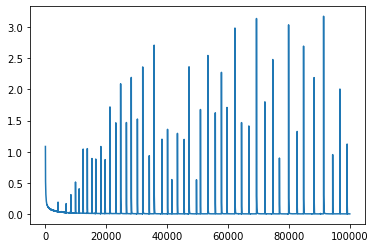

In [27]:
plt.plot(loss_record)

In [28]:
def plot_c_matrix(m, cs):
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(m, cs)
    print(f"Accuracy: {accuracy(m).round(4)}")
    p = mac_avg_metric(m, precision)
    r = mac_avg_metric(m, recall)
    print(f"Precision: {p.round(4)}, Recall: {r.round(4)}")
    print(f"F1 score: {f1_score(p,r).round(4)}")

Confusion matrix, without normalization
[[ 706   49  128]
 [  60 6276  800]
 [ 130  753 4359]]
Accuracy: 0.8552
Precision: 0.833, Recall: 0.8369
F1 score: 0.8349


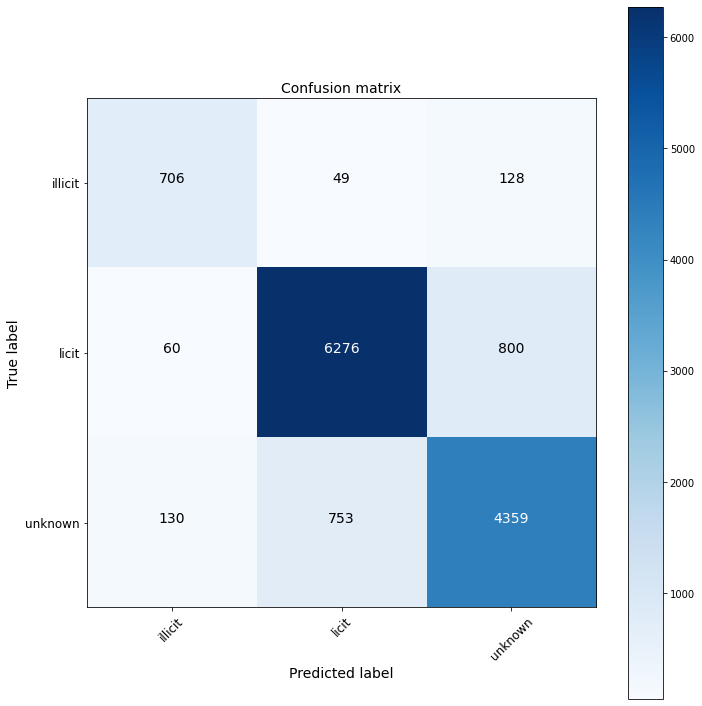

In [29]:
test_logits = net(g, features_tensor)
test_logits = test_logits[labelled_mask][test_mask]
_, indices = torch.max(test_logits, dim=1)
test_labels = labels_tensor[labelled_mask][test_mask]

c_matrix = np.zeros((classes_length, classes_length), int)

for i in range(len(test_labels)):
    pred = indices[i]
    label = test_labels[i]

    c_matrix[label][pred] += 1
    
plot_c_matrix(c_matrix, classes)

In [30]:
from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GAE, VGAE, Node2Vec
from torch_geometric.utils import train_test_split_edges, remove_isolated_nodes, to_dense_adj, k_hop_subgraph
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer


In [31]:
def txs_to_pyg(u, v, feats):
    
    edge_index = torch.stack((u.t(), v.t()), dim=0)
    edge_index = edge_index.squeeze()
    
    g = Data(x=feats, edge_index=edge_index)
    
    return g

In [32]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

def mid_point(in_feats, classes):
    return ((in_feats - classes) // 2) + classes

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        b = (norm).view(-1, 1) * x_j 
        return b 

class NetPyG(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(NetPyG, self).__init__()
        mid = mid_point(feat_length, classes_length)
        self.conv1 = GCNConv(num_features, num_features)
        self.conv2 = GCNConv(num_features, mid)
        self.layer3 = nn.Linear(mid, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = x.to(torch.float32)
        x = self.conv2(x, edge_index)
        x = x.to(torch.float32)
        x = torch.relu(self.layer3(x))
#         return F.log_softmax(x, dim=1)
        return x

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
u,v = to_tensor(u), to_tensor(v)
pyg = txs_to_pyg(u, v, features_tensor)
pyg.y = labels_tensor
pyg.train_mask, pyg.test_mask = train_test_mask(sum(labelled_mask))
pyg = pyg.to(device)
model = NetPyG(feat_length, classes_length).to(device)

x, edge_index = pyg.x, pyg.edge_index
o = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(1, 100000):
    model.train()
    o.zero_grad()
    y = model(x, edge_index)
    log_logits = F.log_softmax(y, dim=1)
    loss = F.nll_loss(log_logits[labelled_mask][pyg.train_mask], pyg.y[labelled_mask][pyg.train_mask])
    loss.backward()
    o.step()
    print(f"{epoch} - {loss}")

1 - 1.0923436880111694
2 - 0.8409618139266968
3 - 0.7125247120857239
4 - 0.7399349808692932
5 - 0.6958523988723755
6 - 0.6924572587013245
7 - 0.6376649737358093
8 - 0.65618497133255
9 - 0.6259556412696838
10 - 0.6499961614608765
11 - 0.6351518630981445
12 - 0.6118482947349548
13 - 0.6124430298805237
14 - 0.6094825863838196
15 - 0.5957299470901489
16 - 0.5971501469612122
17 - 0.5971225500106812
18 - 0.5861065983772278
19 - 0.5801326036453247
20 - 0.5819236636161804
21 - 0.5791760087013245
22 - 0.573849081993103
23 - 0.5722999572753906
24 - 0.5703532099723816
25 - 0.567473828792572
26 - 0.5644658207893372
27 - 0.5610034465789795
28 - 0.5596727728843689
29 - 0.5538907051086426
30 - 0.55363529920578
31 - 0.5509951114654541
32 - 0.5481493473052979
33 - 0.5463884472846985
34 - 0.5456786155700684
35 - 0.5425817966461182
36 - 0.5408222675323486
37 - 0.5394156575202942
38 - 0.5365995168685913
39 - 0.535123348236084
40 - 0.5346843600273132
41 - 0.5319529175758362
42 - 0.5285953879356384
43 - 0.5

330 - 0.36474522948265076
331 - 0.36698704957962036
332 - 0.3674851059913635
333 - 0.37073275446891785
334 - 0.37225908041000366
335 - 0.37981438636779785
336 - 0.3763640522956848
337 - 0.38049352169036865
338 - 0.3740205764770508
339 - 0.3740321695804596
340 - 0.3713683784008026
341 - 0.3769035339355469
342 - 0.37790846824645996
343 - 0.3731481432914734
344 - 0.36876288056373596
345 - 0.36943328380584717
346 - 0.3693493902683258
347 - 0.37200087308883667
348 - 0.36706429719924927
349 - 0.3638209402561188
350 - 0.36664652824401855
351 - 0.36806201934814453
352 - 0.36667171120643616
353 - 0.3678370416164398
354 - 0.3661850392818451
355 - 0.3622949421405792
356 - 0.36514946818351746
357 - 0.363717257976532
358 - 0.36249300837516785
359 - 0.36118146777153015
360 - 0.36582085490226746
361 - 0.36178648471832275
362 - 0.3644527196884155
363 - 0.36427393555641174
364 - 0.3639160096645355
365 - 0.36394932866096497
366 - 0.36689314246177673
367 - 0.3604110777378082
368 - 0.3649389445781708
369 

653 - 0.35581597685813904
654 - 0.34777820110321045
655 - 0.34660691022872925
656 - 0.35046952962875366
657 - 0.35305947065353394
658 - 0.3500746190547943
659 - 0.34478986263275146
660 - 0.344512939453125
661 - 0.34470269083976746
662 - 0.3426143527030945
663 - 0.3458627462387085
664 - 0.3440535068511963
665 - 0.34391194581985474
666 - 0.34716343879699707
667 - 0.34381404519081116
668 - 0.34211787581443787
669 - 0.3471061587333679
670 - 0.3444468080997467
671 - 0.343973845243454
672 - 0.3436737060546875
673 - 0.3445250988006592
674 - 0.3444257378578186
675 - 0.3480323553085327
676 - 0.34963804483413696
677 - 0.34999844431877136
678 - 0.35385799407958984
679 - 0.3547237813472748
680 - 0.35256290435791016
681 - 0.34885236620903015
682 - 0.3444601893424988
683 - 0.34920233488082886
684 - 0.35265374183654785
685 - 0.3456129729747772
686 - 0.34668073058128357
687 - 0.34978488087654114
688 - 0.351110577583313
689 - 0.34715017676353455
690 - 0.345443457365036
691 - 0.350920170545578
692 - 0.3

979 - 0.33508729934692383
980 - 0.33493486046791077
981 - 0.33405768871307373
982 - 0.33321720361709595
983 - 0.33215880393981934
984 - 0.3336051106452942
985 - 0.33209681510925293
986 - 0.3363126516342163
987 - 0.3382457196712494
988 - 0.3403141498565674
989 - 0.3439253866672516
990 - 0.348983496427536
991 - 0.34778550267219543
992 - 0.3357178568840027
993 - 0.33801206946372986
994 - 0.3393877446651459
995 - 0.3463594317436218
996 - 0.3388887047767639
997 - 0.33609965443611145
998 - 0.33788979053497314
999 - 0.34170249104499817
1000 - 0.34753239154815674
1001 - 0.34228429198265076
1002 - 0.33937880396842957
1003 - 0.337399423122406
1004 - 0.342182993888855
1005 - 0.3494415283203125
1006 - 0.340783029794693
1007 - 0.33864712715148926
1008 - 0.33742329478263855
1009 - 0.34243243932724
1010 - 0.34320971369743347
1011 - 0.3378465175628662
1012 - 0.33458060026168823
1013 - 0.3396081030368805
1014 - 0.339508593082428
1015 - 0.3376416862010956
1016 - 0.3357381820678711
1017 - 0.3363719284534

1297 - 0.3314795196056366
1298 - 0.33312931656837463
1299 - 0.3291527032852173
1300 - 0.3299367427825928
1301 - 0.32637500762939453
1302 - 0.3268071711063385
1303 - 0.32593241333961487
1304 - 0.3289719820022583
1305 - 0.328626424074173
1306 - 0.3323313593864441
1307 - 0.3341080844402313
1308 - 0.3365882337093353
1309 - 0.3325308859348297
1310 - 0.32932141423225403
1311 - 0.3285565972328186
1312 - 0.3275288939476013
1313 - 0.330553263425827
1314 - 0.33308789134025574
1315 - 0.3346271216869354
1316 - 0.3361826539039612
1317 - 0.33989739418029785
1318 - 0.3343833386898041
1319 - 0.3312179744243622
1320 - 0.335237592458725
1321 - 0.33555179834365845
1322 - 0.33438512682914734
1323 - 0.32621461153030396
1324 - 0.33607175946235657
1325 - 0.33263376355171204
1326 - 0.33821967244148254
1327 - 0.3399534523487091
1328 - 0.33446764945983887
1329 - 0.33587637543678284
1330 - 0.3295603096485138
1331 - 0.3302602767944336
1332 - 0.3324336111545563
1333 - 0.3336690366268158
1334 - 0.33238866925239563


1613 - 0.33111539483070374
1614 - 0.3302663564682007
1615 - 0.33018791675567627
1616 - 0.3314533829689026
1617 - 0.32815954089164734
1618 - 0.3290943205356598
1619 - 0.32633107900619507
1620 - 0.325361430644989
1621 - 0.3286183774471283
1622 - 0.3285759389400482
1623 - 0.32784634828567505
1624 - 0.32766062021255493
1625 - 0.3287993371486664
1626 - 0.3272029161453247
1627 - 0.32485097646713257
1628 - 0.32774046063423157
1629 - 0.3255492150783539
1630 - 0.32709628343582153
1631 - 0.3248683512210846
1632 - 0.3232511281967163
1633 - 0.32571613788604736
1634 - 0.32562699913978577
1635 - 0.3272780776023865
1636 - 0.3263181746006012
1637 - 0.3279958665370941
1638 - 0.33020660281181335
1639 - 0.34045925736427307
1640 - 0.3412611186504364
1641 - 0.3401467800140381
1642 - 0.332828164100647
1643 - 0.33270007371902466
1644 - 0.3316139280796051
1645 - 0.3351905345916748
1646 - 0.33202770352363586
1647 - 0.32715725898742676
1648 - 0.3317914307117462
1649 - 0.33524081110954285
1650 - 0.33304905891418

1930 - 0.33482545614242554
1931 - 0.3427325487136841
1932 - 0.3479900360107422
1933 - 0.3382589817047119
1934 - 0.3378550410270691
1935 - 0.34033408761024475
1936 - 0.3403809070587158
1937 - 0.33974793553352356
1938 - 0.3359490931034088
1939 - 0.3289691209793091
1940 - 0.330291211605072
1941 - 0.33326199650764465
1942 - 0.32718977332115173
1943 - 0.33695584535598755
1944 - 0.32805773615837097
1945 - 0.33039918541908264
1946 - 0.33060282468795776
1947 - 0.32646501064300537
1948 - 0.3269440531730652
1949 - 0.3286961615085602
1950 - 0.3286321759223938
1951 - 0.32815560698509216
1952 - 0.32840827107429504
1953 - 0.3271980285644531
1954 - 0.3276429772377014
1955 - 0.3276500403881073
1956 - 0.32211726903915405
1957 - 0.3248613178730011
1958 - 0.3249094784259796
1959 - 0.32378292083740234
1960 - 0.3251284658908844
1961 - 0.3274334967136383
1962 - 0.3280971944332123
1963 - 0.32571151852607727
1964 - 0.3260974884033203
1965 - 0.32761016488075256
1966 - 0.33016064763069153
1967 - 0.3326381444931

2242 - 0.3187094032764435
2243 - 0.3210688829421997
2244 - 0.3204501271247864
2245 - 0.3201407790184021
2246 - 0.3226916193962097
2247 - 0.3209536671638489
2248 - 0.32076191902160645
2249 - 0.32151010632514954
2250 - 0.3215777277946472
2251 - 0.32155194878578186
2252 - 0.3211027681827545
2253 - 0.32125937938690186
2254 - 0.32332125306129456
2255 - 0.3242765963077545
2256 - 0.3213443458080292
2257 - 0.3212992548942566
2258 - 0.32193267345428467
2259 - 0.32325440645217896
2260 - 0.326621949672699
2261 - 0.32671529054641724
2262 - 0.3319621980190277
2263 - 0.32950636744499207
2264 - 0.3285270035266876
2265 - 0.324463427066803
2266 - 0.3222034275531769
2267 - 0.3222787380218506
2268 - 0.3235264718532562
2269 - 0.320605605840683
2270 - 0.3225248157978058
2271 - 0.32211753726005554
2272 - 0.3248840272426605
2273 - 0.32356885075569153
2274 - 0.3242112994194031
2275 - 0.31925827264785767
2276 - 0.32000574469566345
2277 - 0.3216095268726349
2278 - 0.320514053106308
2279 - 0.32012706995010376
22

2558 - 0.32221850752830505
2559 - 0.32283997535705566
2560 - 0.3222868740558624
2561 - 0.3295190930366516
2562 - 0.3247316777706146
2563 - 0.3250997066497803
2564 - 0.3235056698322296
2565 - 0.32532060146331787
2566 - 0.32052165269851685
2567 - 0.3221558928489685
2568 - 0.3240930736064911
2569 - 0.32391801476478577
2570 - 0.3237755000591278
2571 - 0.3234943151473999
2572 - 0.32120442390441895
2573 - 0.3217167556285858
2574 - 0.3201192319393158
2575 - 0.3244864344596863
2576 - 0.3245351314544678
2577 - 0.32158535718917847
2578 - 0.321230947971344
2579 - 0.32030192017555237
2580 - 0.32645124197006226
2581 - 0.3186768889427185
2582 - 0.32004982233047485
2583 - 0.31991568207740784
2584 - 0.3225666880607605
2585 - 0.31763195991516113
2586 - 0.3235127925872803
2587 - 0.3202642500400543
2588 - 0.31978848576545715
2589 - 0.32034215331077576
2590 - 0.3196885287761688
2591 - 0.3184170722961426
2592 - 0.32509756088256836
2593 - 0.32716816663742065
2594 - 0.3345162570476532
2595 - 0.33454456925392

2874 - 0.3191539943218231
2875 - 0.32197776436805725
2876 - 0.3197961747646332
2877 - 0.32113033533096313
2878 - 0.32467275857925415
2879 - 0.3231731355190277
2880 - 0.32177436351776123
2881 - 0.32131242752075195
2882 - 0.32265400886535645
2883 - 0.3229694962501526
2884 - 0.32245832681655884
2885 - 0.3249949514865875
2886 - 0.31852951645851135
2887 - 0.3201921582221985
2888 - 0.31940123438835144
2889 - 0.31927379965782166
2890 - 0.320760577917099
2891 - 0.3205699622631073
2892 - 0.320166677236557
2893 - 0.31889867782592773
2894 - 0.3197755813598633
2895 - 0.31984567642211914
2896 - 0.32092925906181335
2897 - 0.3179570138454437
2898 - 0.3161553144454956
2899 - 0.3228914141654968
2900 - 0.32237759232521057
2901 - 0.3275943696498871
2902 - 0.32880833745002747
2903 - 0.3322480618953705
2904 - 0.33483895659446716
2905 - 0.3280656337738037
2906 - 0.3245287835597992
2907 - 0.3289645314216614
2908 - 0.32251572608947754
2909 - 0.3224780261516571
2910 - 0.3208616077899933
2911 - 0.32341364026069

3191 - 0.3216368556022644
3192 - 0.3198925256729126
3193 - 0.3205907344818115
3194 - 0.31811678409576416
3195 - 0.3181406855583191
3196 - 0.32360023260116577
3197 - 0.32138022780418396
3198 - 0.32128944993019104
3199 - 0.32073384523391724
3200 - 0.32219305634498596
3201 - 0.3243117928504944
3202 - 0.32245442271232605
3203 - 0.32149457931518555
3204 - 0.3175205886363983
3205 - 0.31615644693374634
3206 - 0.31843674182891846
3207 - 0.3168922960758209
3208 - 0.319061815738678
3209 - 0.31775423884391785
3210 - 0.32044678926467896
3211 - 0.3206861913204193
3212 - 0.32063421607017517
3213 - 0.3228657841682434
3214 - 0.32028645277023315
3215 - 0.3185808062553406
3216 - 0.317064106464386
3217 - 0.31874319911003113
3218 - 0.3236061930656433
3219 - 0.32191529870033264
3220 - 0.32614871859550476
3221 - 0.3263562023639679
3222 - 0.3283481299877167
3223 - 0.3220110535621643
3224 - 0.3185318112373352
3225 - 0.3239695131778717
3226 - 0.32258856296539307
3227 - 0.3249136209487915
3228 - 0.3268116414546

3503 - 0.3235653042793274
3504 - 0.32280388474464417
3505 - 0.3246346414089203
3506 - 0.3234471082687378
3507 - 0.3201115131378174
3508 - 0.3216029107570648
3509 - 0.32053881883621216
3510 - 0.3170001208782196
3511 - 0.3181961476802826
3512 - 0.3172489106655121
3513 - 0.3192997872829437
3514 - 0.3162144422531128
3515 - 0.31731072068214417
3516 - 0.3187408745288849
3517 - 0.3204772472381592
3518 - 0.3202659487724304
3519 - 0.3166687488555908
3520 - 0.3196365535259247
3521 - 0.31748712062835693
3522 - 0.31957611441612244
3523 - 0.317754864692688
3524 - 0.3184751272201538
3525 - 0.3224985897541046
3526 - 0.31967031955718994
3527 - 0.3203696012496948
3528 - 0.3202177584171295
3529 - 0.3230035901069641
3530 - 0.32229137420654297
3531 - 0.3188302516937256
3532 - 0.32153040170669556
3533 - 0.3216112554073334
3534 - 0.32038769125938416
3535 - 0.3204246461391449
3536 - 0.3197001814842224
3537 - 0.3209500014781952
3538 - 0.3180687725543976
3539 - 0.32171404361724854
3540 - 0.3193778097629547
354

3817 - 0.32555752992630005
3818 - 0.3206661343574524
3819 - 0.3185976445674896
3820 - 0.3203253746032715
3821 - 0.32366952300071716
3822 - 0.3218391537666321
3823 - 0.3192828297615051
3824 - 0.3187897205352783
3825 - 0.3209272027015686
3826 - 0.32171276211738586
3827 - 0.3250157833099365
3828 - 0.32848313450813293
3829 - 0.32362502813339233
3830 - 0.3195788264274597
3831 - 0.32429686188697815
3832 - 0.3212014138698578
3833 - 0.31884047389030457
3834 - 0.3229367733001709
3835 - 0.3245237469673157
3836 - 0.3200124502182007
3837 - 0.3247065246105194
3838 - 0.32501220703125
3839 - 0.32214275002479553
3840 - 0.32097330689430237
3841 - 0.3201785683631897
3842 - 0.32301029562950134
3843 - 0.319644033908844
3844 - 0.3210408389568329
3845 - 0.32203662395477295
3846 - 0.3174702227115631
3847 - 0.31847721338272095
3848 - 0.32118019461631775
3849 - 0.315083384513855
3850 - 0.31479111313819885
3851 - 0.32080963253974915
3852 - 0.32077622413635254
3853 - 0.3178560733795166
3854 - 0.3227263391017914


4128 - 0.3286612927913666
4129 - 0.31944453716278076
4130 - 0.32503166794776917
4131 - 0.3266128599643707
4132 - 0.32191386818885803
4133 - 0.3253432810306549
4134 - 0.32288017868995667
4135 - 0.321374773979187
4136 - 0.32491692900657654
4137 - 0.3274191915988922
4138 - 0.320997416973114
4139 - 0.32837361097335815
4140 - 0.3256872296333313
4141 - 0.32446524500846863
4142 - 0.32345399260520935
4143 - 0.3223247826099396
4144 - 0.319724977016449
4145 - 0.3234941363334656
4146 - 0.3236367106437683
4147 - 0.3211517632007599
4148 - 0.32830214500427246
4149 - 0.3250933587551117
4150 - 0.3190971612930298
4151 - 0.3224877715110779
4152 - 0.31840330362319946
4153 - 0.31658270955085754
4154 - 0.3208429515361786
4155 - 0.32137149572372437
4156 - 0.32064783573150635
4157 - 0.32500654458999634
4158 - 0.31954723596572876
4159 - 0.3224814236164093
4160 - 0.31962838768959045
4161 - 0.31864839792251587
4162 - 0.31559669971466064
4163 - 0.32088083028793335
4164 - 0.32239168882369995
4165 - 0.324398130178

4444 - 0.3169904351234436
4445 - 0.31411463022232056
4446 - 0.31480711698532104
4447 - 0.3195413053035736
4448 - 0.3195466995239258
4449 - 0.33279967308044434
4450 - 0.33567529916763306
4451 - 0.33733099699020386
4452 - 0.3222307860851288
4453 - 0.33090394735336304
4454 - 0.3297003507614136
4455 - 0.32723328471183777
4456 - 0.3316834270954132
4457 - 0.33184975385665894
4458 - 0.322746217250824
4459 - 0.3220381438732147
4460 - 0.3256042003631592
4461 - 0.32257428765296936
4462 - 0.32428473234176636
4463 - 0.3237699270248413
4464 - 0.3209119439125061
4465 - 0.3174440264701843
4466 - 0.31944528222084045
4467 - 0.3210466206073761
4468 - 0.3212732970714569
4469 - 0.3213297426700592
4470 - 0.3234539330005646
4471 - 0.3192206919193268
4472 - 0.318693608045578
4473 - 0.3200337886810303
4474 - 0.32048773765563965
4475 - 0.3146094083786011
4476 - 0.317213773727417
4477 - 0.3168419599533081
4478 - 0.3164065480232239
4479 - 0.3172280788421631
4480 - 0.3176313638687134
4481 - 0.3186213970184326
448

4762 - 0.409117192029953
4763 - 0.40519940853118896
4764 - 0.4022215008735657
4765 - 0.4015706181526184
4766 - 0.40559887886047363
4767 - 0.4025711715221405
4768 - 0.4030020534992218
4769 - 0.4023016393184662
4770 - 0.39956584572792053
4771 - 0.3974575400352478
4772 - 0.39875033497810364
4773 - 0.3991895020008087
4774 - 0.39940112829208374
4775 - 0.3977067470550537
4776 - 0.3979267477989197
4777 - 0.39723092317581177
4778 - 0.39534205198287964
4779 - 0.3949371576309204
4780 - 0.3962056338787079
4781 - 0.39184314012527466
4782 - 0.39345583319664
4783 - 0.3927322328090668
4784 - 0.39239010214805603
4785 - 0.39232301712036133
4786 - 0.392509788274765
4787 - 0.3941783905029297
4788 - 0.38980308175086975
4789 - 0.3860477805137634
4790 - 0.3857688903808594
4791 - 0.38486579060554504
4792 - 0.3869456946849823
4793 - 0.3833312392234802
4794 - 0.38225048780441284
4795 - 0.38196349143981934
4796 - 0.3826354742050171
4797 - 0.38105350732803345
4798 - 0.3825681209564209
4799 - 0.3808092474937439
4

5074 - 0.33853432536125183
5075 - 0.33978909254074097
5076 - 0.34369438886642456
5077 - 0.34505710005760193
5078 - 0.3463491201400757
5079 - 0.340433806180954
5080 - 0.3435380458831787
5081 - 0.3387017250061035
5082 - 0.3407909870147705
5083 - 0.3446497619152069
5084 - 0.3406979441642761
5085 - 0.33997055888175964
5086 - 0.34339919686317444
5087 - 0.34233611822128296
5088 - 0.3464774191379547
5089 - 0.34223541617393494
5090 - 0.34310510754585266
5091 - 0.34324079751968384
5092 - 0.339925080537796
5093 - 0.34326884150505066
5094 - 0.34206750988960266
5095 - 0.3397047817707062
5096 - 0.33944255113601685
5097 - 0.33838555216789246
5098 - 0.3389771580696106
5099 - 0.33908191323280334
5100 - 0.3356712758541107
5101 - 0.33966949582099915
5102 - 0.336823970079422
5103 - 0.33732953667640686
5104 - 0.3387100100517273
5105 - 0.3402169346809387
5106 - 0.3397115170955658
5107 - 0.3405425548553467
5108 - 0.34231528639793396
5109 - 0.34112241864204407
5110 - 0.3400788903236389
5111 - 0.3370476663112

5385 - 0.33058294653892517
5386 - 0.3304360806941986
5387 - 0.3318977653980255
5388 - 0.3331392705440521
5389 - 0.33518868684768677
5390 - 0.3304995894432068
5391 - 0.3392241895198822
5392 - 0.3358363211154938
5393 - 0.33508795499801636
5394 - 0.3307074010372162
5395 - 0.3344461917877197
5396 - 0.3339875340461731
5397 - 0.3295231759548187
5398 - 0.3311649262905121
5399 - 0.3318016529083252
5400 - 0.3270229399204254
5401 - 0.32951298356056213
5402 - 0.3304689824581146
5403 - 0.3296830654144287
5404 - 0.3280780017375946
5405 - 0.3301548361778259
5406 - 0.3277139365673065
5407 - 0.3282774090766907
5408 - 0.3264946937561035
5409 - 0.3292205035686493
5410 - 0.32604241371154785
5411 - 0.32545191049575806
5412 - 0.328683078289032
5413 - 0.33061519265174866
5414 - 0.32869136333465576
5415 - 0.3311472237110138
5416 - 0.3315452039241791
5417 - 0.33039939403533936
5418 - 0.3307304084300995
5419 - 0.3282952308654785
5420 - 0.33006876707077026
5421 - 0.333111435174942
5422 - 0.32826340198516846
542

5703 - 0.3238053619861603
5704 - 0.32254457473754883
5705 - 0.32757553458213806
5706 - 0.324225515127182
5707 - 0.32738620042800903
5708 - 0.32602691650390625
5709 - 0.3245597779750824
5710 - 0.3251769244670868
5711 - 0.3296184539794922
5712 - 0.3271392583847046
5713 - 0.3308955729007721
5714 - 0.33160293102264404
5715 - 0.32951268553733826
5716 - 0.32506096363067627
5717 - 0.32674387097358704
5718 - 0.3257807791233063
5719 - 0.32813966274261475
5720 - 0.3274133801460266
5721 - 0.3304274082183838
5722 - 0.3302982449531555
5723 - 0.331594854593277
5724 - 0.3309631943702698
5725 - 0.33297303318977356
5726 - 0.3340681493282318
5727 - 0.3367857336997986
5728 - 0.3303174376487732
5729 - 0.3281550407409668
5730 - 0.328139990568161
5731 - 0.3349054753780365
5732 - 0.33203500509262085
5733 - 0.3316993713378906
5734 - 0.3362805247306824
5735 - 0.33165207505226135
5736 - 0.3333497643470764
5737 - 0.3427899181842804
5738 - 0.33759889006614685
5739 - 0.33089402318000793
5740 - 0.32898738980293274


6021 - 0.32187068462371826
6022 - 0.317599892616272
6023 - 0.31786614656448364
6024 - 0.3188425898551941
6025 - 0.3200879991054535
6026 - 0.3184797167778015
6027 - 0.3190340995788574
6028 - 0.318474143743515
6029 - 0.3212404251098633
6030 - 0.3256104290485382
6031 - 0.32843324542045593
6032 - 0.3384685516357422
6033 - 0.3295767307281494
6034 - 0.32257339358329773
6035 - 0.3245433270931244
6036 - 0.3283575177192688
6037 - 0.3291882872581482
6038 - 0.32544830441474915
6039 - 0.3179369270801544
6040 - 0.32159531116485596
6041 - 0.32643571496009827
6042 - 0.32935789227485657
6043 - 0.33070024847984314
6044 - 0.32773739099502563
6045 - 0.32425570487976074
6046 - 0.32387876510620117
6047 - 0.3236491084098816
6048 - 0.3243122100830078
6049 - 0.3223479986190796
6050 - 0.32285794615745544
6051 - 0.321856826543808
6052 - 0.32144421339035034
6053 - 0.32400545477867126
6054 - 0.3212314546108246
6055 - 0.3250463008880615
6056 - 0.3249104917049408
6057 - 0.32385337352752686
6058 - 0.3255760371685028

6339 - 0.32666462659835815
6340 - 0.3232353627681732
6341 - 0.3238771855831146
6342 - 0.3203524053096771
6343 - 0.3201007843017578
6344 - 0.322336345911026
6345 - 0.32786327600479126
6346 - 0.328611820936203
6347 - 0.33575546741485596
6348 - 0.3383355736732483
6349 - 0.34314262866973877
6350 - 0.33997225761413574
6351 - 0.33522966504096985
6352 - 0.34023183584213257
6353 - 0.3300110995769501
6354 - 0.33511996269226074
6355 - 0.33426418900489807
6356 - 0.33002781867980957
6357 - 0.3312499225139618
6358 - 0.33128800988197327
6359 - 0.3253556191921234
6360 - 0.32747554779052734
6361 - 0.32469141483306885
6362 - 0.32605883479118347
6363 - 0.32525327801704407
6364 - 0.32778698205947876
6365 - 0.3263125419616699
6366 - 0.32345467805862427
6367 - 0.32511427998542786
6368 - 0.32228246331214905
6369 - 0.3244844675064087
6370 - 0.3240357041358948
6371 - 0.32067224383354187
6372 - 0.324471652507782
6373 - 0.32625478506088257
6374 - 0.32306620478630066
6375 - 0.3204760253429413
6376 - 0.3220620453

6655 - 0.32041487097740173
6656 - 0.32014164328575134
6657 - 0.31822946667671204
6658 - 0.32289060950279236
6659 - 0.3213903307914734
6660 - 0.31931272149086
6661 - 0.31827014684677124
6662 - 0.32279640436172485
6663 - 0.32562965154647827
6664 - 0.3249662220478058
6665 - 0.3274816572666168
6666 - 0.324905663728714
6667 - 0.32266756892204285
6668 - 0.32137447595596313
6669 - 0.3263620138168335
6670 - 0.32446351647377014
6671 - 0.32045885920524597
6672 - 0.321694552898407
6673 - 0.3240218162536621
6674 - 0.3246070444583893
6675 - 0.32574939727783203
6676 - 0.32471731305122375
6677 - 0.3221987187862396
6678 - 0.3219228982925415
6679 - 0.32092082500457764
6680 - 0.32031771540641785
6681 - 0.31998690962791443
6682 - 0.31909769773483276
6683 - 0.3245350122451782
6684 - 0.32018598914146423
6685 - 0.3217397630214691
6686 - 0.32000625133514404
6687 - 0.32427653670310974
6688 - 0.3220311105251312
6689 - 0.322536826133728
6690 - 0.3188994228839874
6691 - 0.3196347653865814
6692 - 0.32107493281364

6967 - 0.3198409676551819
6968 - 0.3207222819328308
6969 - 0.316482275724411
6970 - 0.3172258734703064
6971 - 0.31681138277053833
6972 - 0.31799137592315674
6973 - 0.31397634744644165
6974 - 0.3146049380302429
6975 - 0.31542477011680603
6976 - 0.3178125023841858
6977 - 0.3205491006374359
6978 - 0.3180154263973236
6979 - 0.31512925028800964
6980 - 0.3146299719810486
6981 - 0.3158665597438812
6982 - 0.3174692392349243
6983 - 0.3160874843597412
6984 - 0.3175181746482849
6985 - 0.31774064898490906
6986 - 0.3182682693004608
6987 - 0.31646302342414856
6988 - 0.31732070446014404
6989 - 0.31876787543296814
6990 - 0.3173663318157196
6991 - 0.3203764259815216
6992 - 0.3222563862800598
6993 - 0.32921499013900757
6994 - 0.33849185705184937
6995 - 0.3296949863433838
6996 - 0.3226693868637085
6997 - 0.32836073637008667
6998 - 0.32978466153144836
6999 - 0.32458049058914185
7000 - 0.3239833116531372
7001 - 0.3308054506778717
7002 - 0.3280903995037079
7003 - 0.32536736130714417
7004 - 0.329712599515914

7279 - 0.32129982113838196
7280 - 0.32690027356147766
7281 - 0.3162025511264801
7282 - 0.3227718472480774
7283 - 0.3224976062774658
7284 - 0.3210369348526001
7285 - 0.3210461735725403
7286 - 0.3237422704696655
7287 - 0.3200308382511139
7288 - 0.3192996084690094
7289 - 0.31953656673431396
7290 - 0.32051882147789
7291 - 0.32227280735969543
7292 - 0.3202499747276306
7293 - 0.32215920090675354
7294 - 0.3203142583370209
7295 - 0.32044070959091187
7296 - 0.32064637541770935
7297 - 0.3192612826824188
7298 - 0.31786423921585083
7299 - 0.31876927614212036
7300 - 0.3153363764286041
7301 - 0.3180408775806427
7302 - 0.3180239200592041
7303 - 0.3147645890712738
7304 - 0.31940996646881104
7305 - 0.31648561358451843
7306 - 0.3192269504070282
7307 - 0.3188338875770569
7308 - 0.31695157289505005
7309 - 0.3190333843231201
7310 - 0.31953850388526917
7311 - 0.31906652450561523
7312 - 0.3174965977668762
7313 - 0.31794631481170654
7314 - 0.31657159328460693
7315 - 0.3168918192386627
7316 - 0.316124379634857

7591 - 0.32092294096946716
7592 - 0.31812310218811035
7593 - 0.31750375032424927
7594 - 0.3179410398006439
7595 - 0.3192130923271179
7596 - 0.31705161929130554
7597 - 0.31925109028816223
7598 - 0.31798216700553894
7599 - 0.31627729535102844
7600 - 0.31587693095207214
7601 - 0.3150559663772583
7602 - 0.3152962923049927
7603 - 0.31604263186454773
7604 - 0.3167712390422821
7605 - 0.3226001560688019
7606 - 0.3253127634525299
7607 - 0.3252682089805603
7608 - 0.31728827953338623
7609 - 0.3155665397644043
7610 - 0.319940984249115
7611 - 0.3228543698787689
7612 - 0.32015419006347656
7613 - 0.3171420991420746
7614 - 0.31717321276664734
7615 - 0.3172992467880249
7616 - 0.3179803192615509
7617 - 0.3233654499053955
7618 - 0.3251614272594452
7619 - 0.32272353768348694
7620 - 0.3189721703529358
7621 - 0.31901296973228455
7622 - 0.32151588797569275
7623 - 0.32049208879470825
7624 - 0.3161593973636627
7625 - 0.314545214176178
7626 - 0.3208058476448059
7627 - 0.3252027630805969
7628 - 0.325700014829635

7906 - 0.31617143750190735
7907 - 0.31778404116630554
7908 - 0.3159714341163635
7909 - 0.3196813464164734
7910 - 0.3152059316635132
7911 - 0.3213791847229004
7912 - 0.3136012852191925
7913 - 0.3193933367729187
7914 - 0.32047775387763977
7915 - 0.321669340133667
7916 - 0.3266311585903168
7917 - 0.3219488263130188
7918 - 0.31815508008003235
7919 - 0.31593218445777893
7920 - 0.31954845786094666
7921 - 0.326491117477417
7922 - 0.3233475387096405
7923 - 0.32267239689826965
7924 - 0.32087889313697815
7925 - 0.3185538649559021
7926 - 0.3193087577819824
7927 - 0.3229961395263672
7928 - 0.319394588470459
7929 - 0.31840968132019043
7930 - 0.318062961101532
7931 - 0.31936466693878174
7932 - 0.313464492559433
7933 - 0.3174650967121124
7934 - 0.31606993079185486
7935 - 0.31813639402389526
7936 - 0.3153747022151947
7937 - 0.3180905282497406
7938 - 0.3197581470012665
7939 - 0.3177763819694519
7940 - 0.3152957558631897
7941 - 0.31364578008651733
7942 - 0.3207133114337921
7943 - 0.3245278000831604
7944

8223 - 0.31877100467681885
8224 - 0.3167823553085327
8225 - 0.31609031558036804
8226 - 0.31700626015663147
8227 - 0.3211135268211365
8228 - 0.31839486956596375
8229 - 0.31954774260520935
8230 - 0.32319405674934387
8231 - 0.3213432729244232
8232 - 0.31871187686920166
8233 - 0.3203915059566498
8234 - 0.3202267289161682
8235 - 0.31674128770828247
8236 - 0.3165726065635681
8237 - 0.3195151388645172
8238 - 0.32494091987609863
8239 - 0.32114091515541077
8240 - 0.3165407180786133
8241 - 0.3177747130393982
8242 - 0.31683552265167236
8243 - 0.31537848711013794
8244 - 0.31951162219047546
8245 - 0.3206220865249634
8246 - 0.3174452781677246
8247 - 0.3175505995750427
8248 - 0.3153538405895233
8249 - 0.3153602182865143
8250 - 0.31549501419067383
8251 - 0.316458135843277
8252 - 0.3143823444843292
8253 - 0.3149021863937378
8254 - 0.31701770424842834
8255 - 0.31784000992774963
8256 - 0.31755363941192627
8257 - 0.3196985721588135
8258 - 0.32161179184913635
8259 - 0.31372377276420593
8260 - 0.31714853644

8536 - 0.3192487955093384
8537 - 0.31873276829719543
8538 - 0.3190264105796814
8539 - 0.3175499141216278
8540 - 0.31781744956970215
8541 - 0.3160494267940521
8542 - 0.3186279237270355
8543 - 0.3175840973854065
8544 - 0.3170756697654724
8545 - 0.3171815276145935
8546 - 0.3183969557285309
8547 - 0.31963998079299927
8548 - 0.32330384850502014
8549 - 0.3156827688217163
8550 - 0.32134902477264404
8551 - 0.32464757561683655
8552 - 0.3210493326187134
8553 - 0.3216709494590759
8554 - 0.3205215334892273
8555 - 0.3221319317817688
8556 - 0.3176482915878296
8557 - 0.31945592164993286
8558 - 0.3200598955154419
8559 - 0.3193122148513794
8560 - 0.318647176027298
8561 - 0.31938037276268005
8562 - 0.31683018803596497
8563 - 0.31517457962036133
8564 - 0.31673815846443176
8565 - 0.31751081347465515
8566 - 0.3181431293487549
8567 - 0.3164306581020355
8568 - 0.3126389682292938
8569 - 0.3187364935874939
8570 - 0.31635046005249023
8571 - 0.3181917369365692
8572 - 0.3140178918838501
8573 - 0.3159896433353424


8850 - 0.31697386503219604
8851 - 0.32217785716056824
8852 - 0.32365140318870544
8853 - 0.3195444643497467
8854 - 0.31810784339904785
8855 - 0.3159347474575043
8856 - 0.31965115666389465
8857 - 0.3203974962234497
8858 - 0.3224468529224396
8859 - 0.3190869688987732
8860 - 0.31687772274017334
8861 - 0.3166358768939972
8862 - 0.31290972232818604
8863 - 0.3153398931026459
8864 - 0.3173605501651764
8865 - 0.31563347578048706
8866 - 0.31445878744125366
8867 - 0.3179016411304474
8868 - 0.3157368004322052
8869 - 0.31712785363197327
8870 - 0.3169293999671936
8871 - 0.3152756094932556
8872 - 0.3107658922672272
8873 - 0.3127555847167969
8874 - 0.3124890923500061
8875 - 0.31703752279281616
8876 - 0.31432902812957764
8877 - 0.31514647603034973
8878 - 0.31506112217903137
8879 - 0.31741863489151
8880 - 0.3180604875087738
8881 - 0.31710880994796753
8882 - 0.3188546299934387
8883 - 0.31905680894851685
8884 - 0.3165329098701477
8885 - 0.31461724638938904
8886 - 0.3126891255378723
8887 - 0.31761696934700

9167 - 0.3194023072719574
9168 - 0.3201286196708679
9169 - 0.3238375782966614
9170 - 0.3180416524410248
9171 - 0.3192041218280792
9172 - 0.31825584173202515
9173 - 0.31797894835472107
9174 - 0.3165782392024994
9175 - 0.3173813819885254
9176 - 0.3164583444595337
9177 - 0.31379419565200806
9178 - 0.3164029121398926
9179 - 0.314662367105484
9180 - 0.31802743673324585
9181 - 0.3124343752861023
9182 - 0.31689292192459106
9183 - 0.3153974413871765
9184 - 0.31336405873298645
9185 - 0.31895262002944946
9186 - 0.3153858482837677
9187 - 0.3107803165912628
9188 - 0.31703945994377136
9189 - 0.3180050551891327
9190 - 0.31319209933280945
9191 - 0.31200310587882996
9192 - 0.31571224331855774
9193 - 0.3139195144176483
9194 - 0.31142687797546387
9195 - 0.3205565810203552
9196 - 0.31769296526908875
9197 - 0.3234982192516327
9198 - 0.3218035101890564
9199 - 0.322272926568985
9200 - 0.3249402940273285
9201 - 0.3315733075141907
9202 - 0.3147967755794525
9203 - 0.31849220395088196
9204 - 0.32426825165748596

9482 - 0.322826087474823
9483 - 0.3208049237728119
9484 - 0.3158285617828369
9485 - 0.3174104690551758
9486 - 0.31552809476852417
9487 - 0.31814831495285034
9488 - 0.32346928119659424
9489 - 0.32751408219337463
9490 - 0.31786325573921204
9491 - 0.3192906379699707
9492 - 0.3279062509536743
9493 - 0.31937944889068604
9494 - 0.32038116455078125
9495 - 0.32020774483680725
9496 - 0.31693127751350403
9497 - 0.32073837518692017
9498 - 0.3155335783958435
9499 - 0.3166259527206421
9500 - 0.31741082668304443
9501 - 0.317681223154068
9502 - 0.3169648051261902
9503 - 0.3197004199028015
9504 - 0.3163513243198395
9505 - 0.3180755078792572
9506 - 0.32038256525993347
9507 - 0.32011303305625916
9508 - 0.31691837310791016
9509 - 0.31783559918403625
9510 - 0.3149982690811157
9511 - 0.32273805141448975
9512 - 0.31926223635673523
9513 - 0.3184136748313904
9514 - 0.3229357898235321
9515 - 0.3227775990962982
9516 - 0.32615795731544495
9517 - 0.321149080991745
9518 - 0.32333117723464966
9519 - 0.3228841423988

9797 - 0.3190019130706787
9798 - 0.3169364333152771
9799 - 0.32174113392829895
9800 - 0.3216208815574646
9801 - 0.3163321018218994
9802 - 0.31572598218917847
9803 - 0.3146671652793884
9804 - 0.3151157796382904
9805 - 0.31932663917541504
9806 - 0.3188657760620117
9807 - 0.31840646266937256
9808 - 0.31512024998664856
9809 - 0.32183846831321716
9810 - 0.3157590329647064
9811 - 0.3134748935699463
9812 - 0.3174164593219757
9813 - 0.31667378544807434
9814 - 0.31717759370803833
9815 - 0.31382912397384644
9816 - 0.3118928074836731
9817 - 0.3172583281993866
9818 - 0.31438905000686646
9819 - 0.3179105222225189
9820 - 0.3153747320175171
9821 - 0.3203597068786621
9822 - 0.3201088011264801
9823 - 0.31995120644569397
9824 - 0.31441107392311096
9825 - 0.31523600220680237
9826 - 0.3166826069355011
9827 - 0.3167145550251007
9828 - 0.31861579418182373
9829 - 0.31784185767173767
9830 - 0.3175824284553528
9831 - 0.3166521489620209
9832 - 0.3190598785877228
9833 - 0.3220701813697815
9834 - 0.31946676969528

10106 - 0.3164527118206024
10107 - 0.31201639771461487
10108 - 0.3110940456390381
10109 - 0.3092142939567566
10110 - 0.3243858516216278
10111 - 0.33284321427345276
10112 - 0.35166674852371216
10113 - 0.34637558460235596
10114 - 0.3525676429271698
10115 - 0.35460540652275085
10116 - 0.3474789261817932
10117 - 0.3407447636127472
10118 - 0.34833505749702454
10119 - 0.3469504117965698
10120 - 0.34011775255203247
10121 - 0.33671092987060547
10122 - 0.3425792157649994
10123 - 0.3392743170261383
10124 - 0.3368581235408783
10125 - 0.33378905057907104
10126 - 0.33458489179611206
10127 - 0.3337607681751251
10128 - 0.3356553018093109
10129 - 0.3316954970359802
10130 - 0.32953301072120667
10131 - 0.3317716121673584
10132 - 0.32854220271110535
10133 - 0.3280768394470215
10134 - 0.32794445753097534
10135 - 0.32458117604255676
10136 - 0.32654479146003723
10137 - 0.3233257234096527
10138 - 0.3229782283306122
10139 - 0.32493847608566284
10140 - 0.3259630501270294
10141 - 0.3211631774902344
10142 - 0.32

10406 - 0.31780219078063965
10407 - 0.3138159215450287
10408 - 0.3129364848136902
10409 - 0.3116290271282196
10410 - 0.31003060936927795
10411 - 0.3122694194316864
10412 - 0.310686320066452
10413 - 0.31371375918388367
10414 - 0.31222379207611084
10415 - 0.3117561638355255
10416 - 0.31104806065559387
10417 - 0.31550920009613037
10418 - 0.3218049108982086
10419 - 0.32385239005088806
10420 - 0.3288692235946655
10421 - 0.32225123047828674
10422 - 0.31719163060188293
10423 - 0.31945058703422546
10424 - 0.3247414827346802
10425 - 0.32588496804237366
10426 - 0.3185674250125885
10427 - 0.31557589769363403
10428 - 0.3245897889137268
10429 - 0.3267190456390381
10430 - 0.3225077688694
10431 - 0.3169950246810913
10432 - 0.31346839666366577
10433 - 0.31969720125198364
10434 - 0.3215384781360626
10435 - 0.32014235854148865
10436 - 0.31793487071990967
10437 - 0.3146548569202423
10438 - 0.31920719146728516
10439 - 0.3219422698020935
10440 - 0.31916624307632446
10441 - 0.3170255422592163
10442 - 0.3169

10707 - 0.3165745735168457
10708 - 0.31251683831214905
10709 - 0.31217023730278015
10710 - 0.3144853115081787
10711 - 0.3107677698135376
10712 - 0.31613653898239136
10713 - 0.31329867243766785
10714 - 0.31536969542503357
10715 - 0.3136272132396698
10716 - 0.3139481842517853
10717 - 0.3121642470359802
10718 - 0.3097238838672638
10719 - 0.3132266402244568
10720 - 0.30923062562942505
10721 - 0.31042665243148804
10722 - 0.31353798508644104
10723 - 0.31582745909690857
10724 - 0.31066977977752686
10725 - 0.31292346119880676
10726 - 0.3193133473396301
10727 - 0.32961776852607727
10728 - 0.35842227935791016
10729 - 0.33500802516937256
10730 - 0.3259696960449219
10731 - 0.336129367351532
10732 - 0.33177247643470764
10733 - 0.3237054646015167
10734 - 0.33263295888900757
10735 - 0.3324139714241028
10736 - 0.3302035629749298
10737 - 0.32813897728919983
10738 - 0.32548394799232483
10739 - 0.32976284623146057
10740 - 0.32648521661758423
10741 - 0.325344055891037
10742 - 0.32192137837409973
10743 - 0

11012 - 0.3315616548061371
11013 - 0.32705703377723694
11014 - 0.32127898931503296
11015 - 0.3218053877353668
11016 - 0.329658567905426
11017 - 0.3264368176460266
11018 - 0.3203035295009613
11019 - 0.32507777214050293
11020 - 0.3296060860157013
11021 - 0.3342123329639435
11022 - 0.3334716260433197
11023 - 0.3271012604236603
11024 - 0.3212417662143707
11025 - 0.3240625262260437
11026 - 0.3265627324581146
11027 - 0.3208165764808655
11028 - 0.3193041682243347
11029 - 0.3205219805240631
11030 - 0.31825849413871765
11031 - 0.3156464695930481
11032 - 0.3186345398426056
11033 - 0.3169041872024536
11034 - 0.3170747458934784
11035 - 0.31413429975509644
11036 - 0.3147311508655548
11037 - 0.3173099160194397
11038 - 0.3163323402404785
11039 - 0.3158363699913025
11040 - 0.3151281774044037
11041 - 0.31516528129577637
11042 - 0.3166908025741577
11043 - 0.3138180673122406
11044 - 0.31522783637046814
11045 - 0.31429457664489746
11046 - 0.3143494725227356
11047 - 0.3140921890735626
11048 - 0.31518337130

11312 - 0.3379727303981781
11313 - 0.33405613899230957
11314 - 0.3251833915710449
11315 - 0.3217776417732239
11316 - 0.3258579969406128
11317 - 0.32653313875198364
11318 - 0.3192599415779114
11319 - 0.3208783268928528
11320 - 0.32601356506347656
11321 - 0.32278257608413696
11322 - 0.3214370608329773
11323 - 0.3193718194961548
11324 - 0.3187059164047241
11325 - 0.31761428713798523
11326 - 0.3187884986400604
11327 - 0.31759709119796753
11328 - 0.3191761076450348
11329 - 0.316755086183548
11330 - 0.3185928463935852
11331 - 0.3179197311401367
11332 - 0.3188823163509369
11333 - 0.3192192614078522
11334 - 0.31626105308532715
11335 - 0.31616121530532837
11336 - 0.31701895594596863
11337 - 0.31925705075263977
11338 - 0.3165317475795746
11339 - 0.3174149692058563
11340 - 0.317331463098526
11341 - 0.31593671441078186
11342 - 0.31889408826828003
11343 - 0.31969690322875977
11344 - 0.317847341299057
11345 - 0.31315261125564575
11346 - 0.3135036826133728
11347 - 0.31441181898117065
11348 - 0.314788

11615 - 0.3170117139816284
11616 - 0.31333985924720764
11617 - 0.31346356868743896
11618 - 0.31520479917526245
11619 - 0.3219311833381653
11620 - 0.31991028785705566
11621 - 0.31816399097442627
11622 - 0.32062360644340515
11623 - 0.31833386421203613
11624 - 0.31591862440109253
11625 - 0.3171479105949402
11626 - 0.3178130090236664
11627 - 0.3167944550514221
11628 - 0.3144921064376831
11629 - 0.31602558493614197
11630 - 0.3196651339530945
11631 - 0.3180324137210846
11632 - 0.3149780035018921
11633 - 0.3175323009490967
11634 - 0.32136043906211853
11635 - 0.3181040287017822
11636 - 0.3181763291358948
11637 - 0.32610073685646057
11638 - 0.32079407572746277
11639 - 0.31696200370788574
11640 - 0.32079869508743286
11641 - 0.3193986117839813
11642 - 0.3134209215641022
11643 - 0.3166956305503845
11644 - 0.3138639032840729
11645 - 0.31647974252700806
11646 - 0.31359389424324036
11647 - 0.3125538229942322
11648 - 0.3136816620826721
11649 - 0.3154539465904236
11650 - 0.3121999502182007
11651 - 0.31

11916 - 0.32195597887039185
11917 - 0.31476694345474243
11918 - 0.3153303265571594
11919 - 0.31919941306114197
11920 - 0.3157382309436798
11921 - 0.31448763608932495
11922 - 0.31964990496635437
11923 - 0.3180815875530243
11924 - 0.3178862929344177
11925 - 0.3152717053890228
11926 - 0.3171282112598419
11927 - 0.32003235816955566
11928 - 0.314750611782074
11929 - 0.31570231914520264
11930 - 0.31482839584350586
11931 - 0.3179759085178375
11932 - 0.31976044178009033
11933 - 0.3163931667804718
11934 - 0.3229188024997711
11935 - 0.31940752267837524
11936 - 0.3153373599052429
11937 - 0.31416580080986023
11938 - 0.31675875186920166
11939 - 0.3161335587501526
11940 - 0.31855258345603943
11941 - 0.322611540555954
11942 - 0.32392045855522156
11943 - 0.3236555755138397
11944 - 0.3171994686126709
11945 - 0.31986555457115173
11946 - 0.31887373328208923
11947 - 0.31673532724380493
11948 - 0.31682848930358887
11949 - 0.3206760287284851
11950 - 0.32190820574760437
11951 - 0.3242639899253845
11952 - 0.3

12219 - 0.3165733516216278
12220 - 0.312862753868103
12221 - 0.31509149074554443
12222 - 0.3166200816631317
12223 - 0.3153032660484314
12224 - 0.31152182817459106
12225 - 0.3155718743801117
12226 - 0.3129144012928009
12227 - 0.3152632415294647
12228 - 0.31218284368515015
12229 - 0.3144441843032837
12230 - 0.31644248962402344
12231 - 0.3161599934101105
12232 - 0.3182629644870758
12233 - 0.31591343879699707
12234 - 0.32181140780448914
12235 - 0.32186946272850037
12236 - 0.3177204132080078
12237 - 0.3142141103744507
12238 - 0.32027387619018555
12239 - 0.3241313099861145
12240 - 0.31944796442985535
12241 - 0.3188638389110565
12242 - 0.31839826703071594
12243 - 0.31707072257995605
12244 - 0.3155747354030609
12245 - 0.31613850593566895
12246 - 0.3172878921031952
12247 - 0.31547337770462036
12248 - 0.3143404424190521
12249 - 0.3200948238372803
12250 - 0.31854817271232605
12251 - 0.31882762908935547
12252 - 0.32357102632522583
12253 - 0.3233009874820709
12254 - 0.31631624698638916
12255 - 0.32

12520 - 0.31891515851020813
12521 - 0.32348963618278503
12522 - 0.3300045430660248
12523 - 0.3290456533432007
12524 - 0.3219216763973236
12525 - 0.31909677386283875
12526 - 0.32394662499427795
12527 - 0.3250393569469452
12528 - 0.32418128848075867
12529 - 0.32174625992774963
12530 - 0.31888237595558167
12531 - 0.32022881507873535
12532 - 0.32343295216560364
12533 - 0.3167012929916382
12534 - 0.3177168071269989
12535 - 0.3203856647014618
12536 - 0.3201152980327606
12537 - 0.31773561239242554
12538 - 0.3219449520111084
12539 - 0.32065004110336304
12540 - 0.3173501789569855
12541 - 0.319459468126297
12542 - 0.3179853856563568
12543 - 0.31873273849487305
12544 - 0.3153647482395172
12545 - 0.31734025478363037
12546 - 0.3197295665740967
12547 - 0.3198924660682678
12548 - 0.3156106472015381
12549 - 0.3163834512233734
12550 - 0.31355971097946167
12551 - 0.31480544805526733
12552 - 0.3137243390083313
12553 - 0.31888237595558167
12554 - 0.3156307637691498
12555 - 0.3132422864437103
12556 - 0.316

12821 - 0.31796449422836304
12822 - 0.3205515742301941
12823 - 0.31610387563705444
12824 - 0.3132197856903076
12825 - 0.316180020570755
12826 - 0.31602898240089417
12827 - 0.3163965940475464
12828 - 0.3122948706150055
12829 - 0.3155182898044586
12830 - 0.3178437352180481
12831 - 0.316511332988739
12832 - 0.31270280480384827
12833 - 0.3153083026409149
12834 - 0.3135879337787628
12835 - 0.3138188123703003
12836 - 0.31451186537742615
12837 - 0.31074821949005127
12838 - 0.31305909156799316
12839 - 0.31169500946998596
12840 - 0.3144155740737915
12841 - 0.3120913505554199
12842 - 0.3104660212993622
12843 - 0.31110134720802307
12844 - 0.31314316391944885
12845 - 0.309797078371048
12846 - 0.3138754665851593
12847 - 0.31187084317207336
12848 - 0.31531092524528503
12849 - 0.31403523683547974
12850 - 0.3200986385345459
12851 - 0.32026806473731995
12852 - 0.31596407294273376
12853 - 0.31445786356925964
12854 - 0.3137042224407196
12855 - 0.3133165240287781
12856 - 0.312556654214859
12857 - 0.311175

13128 - 0.31149300932884216
13129 - 0.3150750398635864
13130 - 0.3126548230648041
13131 - 0.31922584772109985
13132 - 0.31764650344848633
13133 - 0.3209098279476166
13134 - 0.3199777603149414
13135 - 0.31696876883506775
13136 - 0.3163893222808838
13137 - 0.31523752212524414
13138 - 0.3141668438911438
13139 - 0.3164721131324768
13140 - 0.31483256816864014
13141 - 0.31279513239860535
13142 - 0.3143365979194641
13143 - 0.31952154636383057
13144 - 0.3165006637573242
13145 - 0.32551389932632446
13146 - 0.3242236077785492
13147 - 0.3207576870918274
13148 - 0.3199504017829895
13149 - 0.3193204998970032
13150 - 0.3256630301475525
13151 - 0.3240661919116974
13152 - 0.31816112995147705
13153 - 0.31871703267097473
13154 - 0.3287922143936157
13155 - 0.33146268129348755
13156 - 0.32989302277565
13157 - 0.321013867855072
13158 - 0.32732075452804565
13159 - 0.32882454991340637
13160 - 0.3215671181678772
13161 - 0.32279324531555176
13162 - 0.3231390714645386
13163 - 0.32554367184638977
13164 - 0.31879

13433 - 0.3170308768749237
13434 - 0.31604135036468506
13435 - 0.3167756199836731
13436 - 0.31593194603919983
13437 - 0.3136821687221527
13438 - 0.3115563988685608
13439 - 0.3146642744541168
13440 - 0.31290334463119507
13441 - 0.3146948516368866
13442 - 0.3127284646034241
13443 - 0.31547996401786804
13444 - 0.3158542513847351
13445 - 0.3178737461566925
13446 - 0.3213867247104645
13447 - 0.32015058398246765
13448 - 0.3222430944442749
13449 - 0.31319206953048706
13450 - 0.30988478660583496
13451 - 0.3191702961921692
13452 - 0.3245075047016144
13453 - 0.33036577701568604
13454 - 0.3296544551849365
13455 - 0.3231458365917206
13456 - 0.315734326839447
13457 - 0.32623180747032166
13458 - 0.32597193121910095
13459 - 0.317741334438324
13460 - 0.3206069767475128
13461 - 0.32539278268814087
13462 - 0.31951579451560974
13463 - 0.31980693340301514
13464 - 0.3198515772819519
13465 - 0.32273727655410767
13466 - 0.3187233507633209
13467 - 0.31783121824264526
13468 - 0.3192039132118225
13469 - 0.31734

13733 - 0.3154551088809967
13734 - 0.31853488087654114
13735 - 0.315327525138855
13736 - 0.31179335713386536
13737 - 0.3150624930858612
13738 - 0.31503862142562866
13739 - 0.3135109841823578
13740 - 0.3134180009365082
13741 - 0.31240227818489075
13742 - 0.3165702521800995
13743 - 0.31321412324905396
13744 - 0.31502485275268555
13745 - 0.3131745755672455
13746 - 0.3137640357017517
13747 - 0.3137267529964447
13748 - 0.31642094254493713
13749 - 0.3117516040802002
13750 - 0.3157844543457031
13751 - 0.31317198276519775
13752 - 0.3140755593776703
13753 - 0.31046777963638306
13754 - 0.3088288903236389
13755 - 0.3112576901912689
13756 - 0.31298118829727173
13757 - 0.31391051411628723
13758 - 0.3127911388874054
13759 - 0.3193648159503937
13760 - 0.33530694246292114
13761 - 0.3335689604282379
13762 - 0.3342832624912262
13763 - 0.32260453701019287
13764 - 0.32691121101379395
13765 - 0.32375672459602356
13766 - 0.32182902097702026
13767 - 0.3184206187725067
13768 - 0.32247626781463623
13769 - 0.32

14036 - 0.3153558075428009
14037 - 0.31355157494544983
14038 - 0.31489434838294983
14039 - 0.31389620900154114
14040 - 0.3110170066356659
14041 - 0.3131542503833771
14042 - 0.3142997920513153
14043 - 0.3126867711544037
14044 - 0.31420499086380005
14045 - 0.3179761469364166
14046 - 0.3180224895477295
14047 - 0.31739184260368347
14048 - 0.31451359391212463
14049 - 0.3133183717727661
14050 - 0.31370407342910767
14051 - 0.32090601325035095
14052 - 0.3188837170600891
14053 - 0.3155967593193054
14054 - 0.3178289234638214
14055 - 0.3200181722640991
14056 - 0.31555137038230896
14057 - 0.31626492738723755
14058 - 0.31468185782432556
14059 - 0.31755349040031433
14060 - 0.3161233365535736
14061 - 0.3158222734928131
14062 - 0.3165675699710846
14063 - 0.3142206072807312
14064 - 0.3136090636253357
14065 - 0.3159027099609375
14066 - 0.3171287477016449
14067 - 0.3166739344596863
14068 - 0.3143998086452484
14069 - 0.3153668940067291
14070 - 0.3130042850971222
14071 - 0.31327465176582336
14072 - 0.31124

14337 - 0.31225746870040894
14338 - 0.31615132093429565
14339 - 0.3165559768676758
14340 - 0.3141512870788574
14341 - 0.31491661071777344
14342 - 0.31529292464256287
14343 - 0.3157006800174713
14344 - 0.31280601024627686
14345 - 0.3132202625274658
14346 - 0.3151206970214844
14347 - 0.314471572637558
14348 - 0.31476685404777527
14349 - 0.31565648317337036
14350 - 0.3162238597869873
14351 - 0.31312471628189087
14352 - 0.3150384724140167
14353 - 0.31559842824935913
14354 - 0.31711921095848083
14355 - 0.31479454040527344
14356 - 0.3159588575363159
14357 - 0.31373441219329834
14358 - 0.3138313889503479
14359 - 0.313149631023407
14360 - 0.3136309087276459
14361 - 0.31751057505607605
14362 - 0.31300783157348633
14363 - 0.31252261996269226
14364 - 0.311866819858551
14365 - 0.3121386766433716
14366 - 0.3157157003879547
14367 - 0.3133836090564728
14368 - 0.3155114948749542
14369 - 0.31564775109291077
14370 - 0.3138017952442169
14371 - 0.3183498978614807
14372 - 0.31625133752822876
14373 - 0.3164

14637 - 0.3195257782936096
14638 - 0.317657470703125
14639 - 0.3201529085636139
14640 - 0.3223203718662262
14641 - 0.3207494616508484
14642 - 0.31950533390045166
14643 - 0.31956201791763306
14644 - 0.31775814294815063
14645 - 0.31753817200660706
14646 - 0.3179282546043396
14647 - 0.3188024163246155
14648 - 0.3172600269317627
14649 - 0.3156551420688629
14650 - 0.32000091671943665
14651 - 0.3175927996635437
14652 - 0.3171135485172272
14653 - 0.32150182127952576
14654 - 0.3202533423900604
14655 - 0.3185123801231384
14656 - 0.31597739458084106
14657 - 0.31602412462234497
14658 - 0.31532254815101624
14659 - 0.3144401013851166
14660 - 0.31362614035606384
14661 - 0.3149561583995819
14662 - 0.3128964900970459
14663 - 0.3113938570022583
14664 - 0.31315284967422485
14665 - 0.3115554451942444
14666 - 0.3132912218570709
14667 - 0.31332921981811523
14668 - 0.3147115111351013
14669 - 0.31360751390457153
14670 - 0.3102107048034668
14671 - 0.313007116317749
14672 - 0.31400203704833984
14673 - 0.312150

14939 - 0.31586092710494995
14940 - 0.31137338280677795
14941 - 0.3203083276748657
14942 - 0.3223869204521179
14943 - 0.32431668043136597
14944 - 0.31822147965431213
14945 - 0.31411829590797424
14946 - 0.31584787368774414
14947 - 0.31590157747268677
14948 - 0.3153165876865387
14949 - 0.3141316771507263
14950 - 0.3124071955680847
14951 - 0.3146238923072815
14952 - 0.3159618079662323
14953 - 0.3165813684463501
14954 - 0.31846150755882263
14955 - 0.31757378578186035
14956 - 0.3166927099227905
14957 - 0.3124987483024597
14958 - 0.31581228971481323
14959 - 0.31299078464508057
14960 - 0.3142465054988861
14961 - 0.3155626058578491
14962 - 0.31234633922576904
14963 - 0.3116583824157715
14964 - 0.31344178318977356
14965 - 0.31497108936309814
14966 - 0.31304481625556946
14967 - 0.31612884998321533
14968 - 0.3169023394584656
14969 - 0.3156028389930725
14970 - 0.3130173683166504
14971 - 0.3136984705924988
14972 - 0.3167695999145508
14973 - 0.3178032636642456
14974 - 0.3141246438026428
14975 - 0.31

15241 - 0.3136187493801117
15242 - 0.31535688042640686
15243 - 0.31512871384620667
15244 - 0.31636500358581543
15245 - 0.3186778128147125
15246 - 0.31595659255981445
15247 - 0.31547099351882935
15248 - 0.31572654843330383
15249 - 0.31337466835975647
15250 - 0.3120090961456299
15251 - 0.3158576786518097
15252 - 0.3125837445259094
15253 - 0.31668785214424133
15254 - 0.31602585315704346
15255 - 0.3143802285194397
15256 - 0.31436997652053833
15257 - 0.3138650059700012
15258 - 0.314090758562088
15259 - 0.31269562244415283
15260 - 0.3139887750148773
15261 - 0.3134866952896118
15262 - 0.3141537606716156
15263 - 0.316740483045578
15264 - 0.31395670771598816
15265 - 0.31836166977882385
15266 - 0.31725597381591797
15267 - 0.32123228907585144
15268 - 0.3186326324939728
15269 - 0.32008081674575806
15270 - 0.3139198124408722
15271 - 0.31334489583969116
15272 - 0.31575119495391846
15273 - 0.3173215687274933
15274 - 0.3274144232273102
15275 - 0.3297901451587677
15276 - 0.3338138163089752
15277 - 0.32

15540 - 0.31603163480758667
15541 - 0.31504878401756287
15542 - 0.3152015507221222
15543 - 0.3166983425617218
15544 - 0.3138403296470642
15545 - 0.31387168169021606
15546 - 0.31431129574775696
15547 - 0.312159925699234
15548 - 0.31533753871917725
15549 - 0.31144821643829346
15550 - 0.31417572498321533
15551 - 0.3149605393409729
15552 - 0.3185287415981293
15553 - 0.31413665413856506
15554 - 0.31610602140426636
15555 - 0.31237027049064636
15556 - 0.3157423436641693
15557 - 0.3158920407295227
15558 - 0.31575828790664673
15559 - 0.3171582520008087
15560 - 0.3156953454017639
15561 - 0.31355053186416626
15562 - 0.3159268796443939
15563 - 0.3152908980846405
15564 - 0.3148095905780792
15565 - 0.3153802156448364
15566 - 0.31823623180389404
15567 - 0.31635650992393494
15568 - 0.3143158257007599
15569 - 0.31592458486557007
15570 - 0.3123832046985626
15571 - 0.3115729093551636
15572 - 0.312468945980072
15573 - 0.31692323088645935
15574 - 0.3182677626609802
15575 - 0.32652944326400757
15576 - 0.322

15841 - 0.32381221652030945
15842 - 0.31563639640808105
15843 - 0.31678956747055054
15844 - 0.3145144581794739
15845 - 0.3171113133430481
15846 - 0.3203639090061188
15847 - 0.3233892321586609
15848 - 0.31399664282798767
15849 - 0.31622540950775146
15850 - 0.3156861364841461
15851 - 0.3122512698173523
15852 - 0.3176305294036865
15853 - 0.3154519498348236
15854 - 0.32001298666000366
15855 - 0.31303513050079346
15856 - 0.31590843200683594
15857 - 0.31622859835624695
15858 - 0.3182322382926941
15859 - 0.317862331867218
15860 - 0.3164381980895996
15861 - 0.31338319182395935
15862 - 0.31563177704811096
15863 - 0.31432217359542847
15864 - 0.3159694969654083
15865 - 0.3164852261543274
15866 - 0.3188251256942749
15867 - 0.32353419065475464
15868 - 0.3205808103084564
15869 - 0.32394376397132874
15870 - 0.32307013869285583
15871 - 0.32082921266555786
15872 - 0.3187638223171234
15873 - 0.3199097812175751
15874 - 0.3197862505912781
15875 - 0.3183111250400543
15876 - 0.3184686005115509
15877 - 0.312

16140 - 0.31652960181236267
16141 - 0.3097551465034485
16142 - 0.31406140327453613
16143 - 0.3167322278022766
16144 - 0.31797268986701965
16145 - 0.3160339593887329
16146 - 0.314103364944458
16147 - 0.3172665536403656
16148 - 0.31548404693603516
16149 - 0.31774526834487915
16150 - 0.3164118230342865
16151 - 0.31563282012939453
16152 - 0.31756606698036194
16153 - 0.31745490431785583
16154 - 0.3152293562889099
16155 - 0.3131711483001709
16156 - 0.3181714415550232
16157 - 0.31533506512641907
16158 - 0.31308671832084656
16159 - 0.31324508786201477
16160 - 0.3132091164588928
16161 - 0.3118153512477875
16162 - 0.31161168217658997
16163 - 0.31059613823890686
16164 - 0.31201931834220886
16165 - 0.30993977189064026
16166 - 0.312820702791214
16167 - 0.31752756237983704
16168 - 0.31456199288368225
16169 - 0.31782278418540955
16170 - 0.3233477473258972
16171 - 0.3271998167037964
16172 - 0.3221733272075653
16173 - 0.3242464065551758
16174 - 0.3171210289001465
16175 - 0.3218313753604889
16176 - 0.32

16446 - 0.31717023253440857
16447 - 0.3149397075176239
16448 - 0.3158559203147888
16449 - 0.3162427246570587
16450 - 0.31625619530677795
16451 - 0.3177455961704254
16452 - 0.31796300411224365
16453 - 0.3172866106033325
16454 - 0.31388917565345764
16455 - 0.31526973843574524
16456 - 0.3130626380443573
16457 - 0.3129802346229553
16458 - 0.3143980801105499
16459 - 0.3158779442310333
16460 - 0.31339648365974426
16461 - 0.31543177366256714
16462 - 0.31700316071510315
16463 - 0.3113066554069519
16464 - 0.3111928105354309
16465 - 0.3125927150249481
16466 - 0.31441789865493774
16467 - 0.31740692257881165
16468 - 0.32087087631225586
16469 - 0.32689371705055237
16470 - 0.32354503870010376
16471 - 0.3167015314102173
16472 - 0.31460699439048767
16473 - 0.3216216564178467
16474 - 0.3248118460178375
16475 - 0.3184978663921356
16476 - 0.3140288293361664
16477 - 0.3143957853317261
16478 - 0.31765273213386536
16479 - 0.3186694085597992
16480 - 0.31909894943237305
16481 - 0.3173731565475464
16482 - 0.31

16748 - 0.3147011995315552
16749 - 0.3152598738670349
16750 - 0.31813785433769226
16751 - 0.3112061619758606
16752 - 0.313040554523468
16753 - 0.31358394026756287
16754 - 0.3108484148979187
16755 - 0.31550469994544983
16756 - 0.317704975605011
16757 - 0.32167935371398926
16758 - 0.3218458592891693
16759 - 0.31820762157440186
16760 - 0.31484508514404297
16761 - 0.31306907534599304
16762 - 0.31721511483192444
16763 - 0.3209477365016937
16764 - 0.31512948870658875
16765 - 0.31377968192100525
16766 - 0.3163709342479706
16767 - 0.3140467703342438
16768 - 0.31073933839797974
16769 - 0.31010985374450684
16770 - 0.31356993317604065
16771 - 0.31426796317100525
16772 - 0.31302696466445923
16773 - 0.3094986081123352
16774 - 0.31012779474258423
16775 - 0.3090830445289612
16776 - 0.3135846257209778
16777 - 0.31253331899642944
16778 - 0.3122631013393402
16779 - 0.31269773840904236
16780 - 0.3132501244544983
16781 - 0.31143346428871155
16782 - 0.31059345602989197
16783 - 0.3138013780117035
16784 - 0.

17051 - 0.3175235986709595
17052 - 0.32414311170578003
17053 - 0.3198121190071106
17054 - 0.3159918189048767
17055 - 0.31594374775886536
17056 - 0.316751629114151
17057 - 0.31717345118522644
17058 - 0.31508633494377136
17059 - 0.31692665815353394
17060 - 0.3143274784088135
17061 - 0.31016042828559875
17062 - 0.31552478671073914
17063 - 0.3118879199028015
17064 - 0.31227973103523254
17065 - 0.3111734688282013
17066 - 0.31062519550323486
17067 - 0.3125290274620056
17068 - 0.31038397550582886
17069 - 0.3131847083568573
17070 - 0.3140486180782318
17071 - 0.3134641945362091
17072 - 0.3132866621017456
17073 - 0.3160459101200104
17074 - 0.3171676695346832
17075 - 0.3159730136394501
17076 - 0.3178922235965729
17077 - 0.32446667551994324
17078 - 0.3235936164855957
17079 - 0.3291080892086029
17080 - 0.3231853246688843
17081 - 0.32843783497810364
17082 - 0.3230752646923065
17083 - 0.31398993730545044
17084 - 0.3220827579498291
17085 - 0.3218807578086853
17086 - 0.31763318181037903
17087 - 0.31487

17352 - 0.31538572907447815
17353 - 0.3160713315010071
17354 - 0.3203073740005493
17355 - 0.3166632354259491
17356 - 0.31733062863349915
17357 - 0.3177565932273865
17358 - 0.3165940046310425
17359 - 0.31693077087402344
17360 - 0.3125894367694855
17361 - 0.31355324387550354
17362 - 0.3130837678909302
17363 - 0.3145851194858551
17364 - 0.31534343957901
17365 - 0.31275278329849243
17366 - 0.31956782937049866
17367 - 0.3187483251094818
17368 - 0.3127373456954956
17369 - 0.311192125082016
17370 - 0.3159237504005432
17371 - 0.32105138897895813
17372 - 0.3216380476951599
17373 - 0.31530916690826416
17374 - 0.3157007396221161
17375 - 0.31555426120758057
17376 - 0.3123341500759125
17377 - 0.31528329849243164
17378 - 0.3151293396949768
17379 - 0.3148609697818756
17380 - 0.31400367617607117
17381 - 0.3123387098312378
17382 - 0.3118661940097809
17383 - 0.31355011463165283
17384 - 0.3155546486377716
17385 - 0.3166218101978302
17386 - 0.3180103898048401
17387 - 0.3156730532646179
17388 - 0.314544320

17652 - 0.32420477271080017
17653 - 0.32004278898239136
17654 - 0.3191605508327484
17655 - 0.3163042664527893
17656 - 0.31577321887016296
17657 - 0.3140678107738495
17658 - 0.3157702088356018
17659 - 0.3178214132785797
17660 - 0.31290602684020996
17661 - 0.31657305359840393
17662 - 0.3132691979408264
17663 - 0.3158201277256012
17664 - 0.31955409049987793
17665 - 0.32254815101623535
17666 - 0.32651329040527344
17667 - 0.3215971291065216
17668 - 0.31713247299194336
17669 - 0.31655412912368774
17670 - 0.3251628875732422
17671 - 0.3255442976951599
17672 - 0.32511627674102783
17673 - 0.3215869963169098
17674 - 0.3146366775035858
17675 - 0.31737861037254333
17676 - 0.3176534175872803
17677 - 0.3160368800163269
17678 - 0.3168952465057373
17679 - 0.31633615493774414
17680 - 0.31850913166999817
17681 - 0.3212834596633911
17682 - 0.31556543707847595
17683 - 0.31817588210105896
17684 - 0.31406208872795105
17685 - 0.3161042630672455
17686 - 0.3235783576965332
17687 - 0.32065820693969727
17688 - 0.

17952 - 0.3306884169578552
17953 - 0.32552090287208557
17954 - 0.3243553936481476
17955 - 0.3253680169582367
17956 - 0.3180575370788574
17957 - 0.32281363010406494
17958 - 0.32479625940322876
17959 - 0.31991317868232727
17960 - 0.3200312852859497
17961 - 0.31871452927589417
17962 - 0.31911560893058777
17963 - 0.31976526975631714
17964 - 0.3195183277130127
17965 - 0.3186248540878296
17966 - 0.32130175828933716
17967 - 0.31671738624572754
17968 - 0.3197265565395355
17969 - 0.32105395197868347
17970 - 0.3153184950351715
17971 - 0.31488606333732605
17972 - 0.3191835284233093
17973 - 0.31452929973602295
17974 - 0.31671780347824097
17975 - 0.31599128246307373
17976 - 0.31929799914360046
17977 - 0.3151790499687195
17978 - 0.31700456142425537
17979 - 0.3168589770793915
17980 - 0.31678879261016846
17981 - 0.3137962520122528
17982 - 0.31239399313926697
17983 - 0.31371477246284485
17984 - 0.31507647037506104
17985 - 0.315519779920578
17986 - 0.3156053125858307
17987 - 0.31585389375686646
17988 - 

18252 - 0.3197506368160248
18253 - 0.3271411061286926
18254 - 0.33168521523475647
18255 - 0.32739636301994324
18256 - 0.3191746175289154
18257 - 0.3205339312553406
18258 - 0.3221932053565979
18259 - 0.3244469463825226
18260 - 0.32468536496162415
18261 - 0.3236933946609497
18262 - 0.32217615842819214
18263 - 0.3188699781894684
18264 - 0.321559339761734
18265 - 0.31990981101989746
18266 - 0.3163541853427887
18267 - 0.31665289402008057
18268 - 0.31808361411094666
18269 - 0.3171163499355316
18270 - 0.31527769565582275
18271 - 0.3170922100543976
18272 - 0.3182065784931183
18273 - 0.31562456488609314
18274 - 0.31622782349586487
18275 - 0.3147614002227783
18276 - 0.3131140470504761
18277 - 0.31457632780075073
18278 - 0.3153493106365204
18279 - 0.3131656348705292
18280 - 0.3129326403141022
18281 - 0.3133077919483185
18282 - 0.31019529700279236
18283 - 0.31639260053634644
18284 - 0.3134070932865143
18285 - 0.31273576617240906
18286 - 0.31413906812667847
18287 - 0.3193446695804596
18288 - 0.3265

18554 - 0.3128599226474762
18555 - 0.3161349594593048
18556 - 0.31911376118659973
18557 - 0.32184481620788574
18558 - 0.31558871269226074
18559 - 0.3168126344680786
18560 - 0.3174082040786743
18561 - 0.3202905058860779
18562 - 0.32211485505104065
18563 - 0.31750431656837463
18564 - 0.31646203994750977
18565 - 0.31874844431877136
18566 - 0.3181167542934418
18567 - 0.3185725808143616
18568 - 0.3177430331707001
18569 - 0.314297616481781
18570 - 0.3187037706375122
18571 - 0.3189464807510376
18572 - 0.3152170181274414
18573 - 0.31529271602630615
18574 - 0.3196783661842346
18575 - 0.31544050574302673
18576 - 0.3127879202365875
18577 - 0.31198519468307495
18578 - 0.31362801790237427
18579 - 0.3132193684577942
18580 - 0.31402161717414856
18581 - 0.31271421909332275
18582 - 0.3172968029975891
18583 - 0.3122826814651489
18584 - 0.3106260895729065
18585 - 0.3130486309528351
18586 - 0.314313143491745
18587 - 0.3166581094264984
18588 - 0.318069189786911
18589 - 0.32072651386260986
18590 - 0.3314238

18860 - 0.31623783707618713
18861 - 0.3118446469306946
18862 - 0.3236459493637085
18863 - 0.3241773545742035
18864 - 0.3214448392391205
18865 - 0.3132402002811432
18866 - 0.3147182762622833
18867 - 0.3257752060890198
18868 - 0.32546529173851013
18869 - 0.3225499987602234
18870 - 0.3158230781555176
18871 - 0.31297969818115234
18872 - 0.3164616525173187
18873 - 0.31788894534111023
18874 - 0.3133400082588196
18875 - 0.314225435256958
18876 - 0.3170684576034546
18877 - 0.3211871087551117
18878 - 0.31973904371261597
18879 - 0.32455503940582275
18880 - 0.3211720585823059
18881 - 0.31843096017837524
18882 - 0.31803804636001587
18883 - 0.3193696141242981
18884 - 0.31929612159729004
18885 - 0.3177783191204071
18886 - 0.314873069524765
18887 - 0.31772151589393616
18888 - 0.3179493248462677
18889 - 0.31870076060295105
18890 - 0.32076480984687805
18891 - 0.3164142668247223
18892 - 0.31478065252304077
18893 - 0.3164593577384949
18894 - 0.31429043412208557
18895 - 0.3139720857143402
18896 - 0.311842

19164 - 0.3137386441230774
19165 - 0.3153902590274811
19166 - 0.3136674165725708
19167 - 0.3120918273925781
19168 - 0.312643826007843
19169 - 0.31787237524986267
19170 - 0.31617164611816406
19171 - 0.3129372298717499
19172 - 0.3133559823036194
19173 - 0.31267136335372925
19174 - 0.3136371970176697
19175 - 0.31601855158805847
19176 - 0.31883496046066284
19177 - 0.31714826822280884
19178 - 0.3168855309486389
19179 - 0.3209770917892456
19180 - 0.3222748041152954
19181 - 0.3158002495765686
19182 - 0.31546998023986816
19183 - 0.31790095567703247
19184 - 0.3137325644493103
19185 - 0.31345993280410767
19186 - 0.3156551420688629
19187 - 0.3159220218658447
19188 - 0.31520700454711914
19189 - 0.30853408575057983
19190 - 0.31703078746795654
19191 - 0.3176877498626709
19192 - 0.3229394555091858
19193 - 0.3274345099925995
19194 - 0.33220210671424866
19195 - 0.3214569389820099
19196 - 0.3194652497768402
19197 - 0.32966408133506775
19198 - 0.3259292542934418
19199 - 0.3195602297782898
19200 - 0.32184

19464 - 0.3189300000667572
19465 - 0.31929707527160645
19466 - 0.3212966024875641
19467 - 0.3178326189517975
19468 - 0.3199484944343567
19469 - 0.3204677700996399
19470 - 0.32048165798187256
19471 - 0.31736400723457336
19472 - 0.31807687878608704
19473 - 0.32016319036483765
19474 - 0.31559184193611145
19475 - 0.3141966164112091
19476 - 0.3169424831867218
19477 - 0.3181958794593811
19478 - 0.3157784342765808
19479 - 0.3162399232387543
19480 - 0.3165784180164337
19481 - 0.31981709599494934
19482 - 0.3158101737499237
19483 - 0.3180500268936157
19484 - 0.3187478482723236
19485 - 0.3168069124221802
19486 - 0.31616684794425964
19487 - 0.31858742237091064
19488 - 0.3147576153278351
19489 - 0.31546950340270996
19490 - 0.3180277645587921
19491 - 0.31311285495758057
19492 - 0.31317031383514404
19493 - 0.3125957250595093
19494 - 0.31216666102409363
19495 - 0.31399255990982056
19496 - 0.3128015697002411
19497 - 0.3128189742565155
19498 - 0.31691017746925354
19499 - 0.31433624029159546
19500 - 0.31

19765 - 0.3167533278465271
19766 - 0.3243478238582611
19767 - 0.33073198795318604
19768 - 0.3251453638076782
19769 - 0.3264188766479492
19770 - 0.3276681900024414
19771 - 0.3295793831348419
19772 - 0.3281804025173187
19773 - 0.321304589509964
19774 - 0.3152616620063782
19775 - 0.3225840628147125
19776 - 0.321785569190979
19777 - 0.32091185450553894
19778 - 0.31799885630607605
19779 - 0.32003405690193176
19780 - 0.31858697533607483
19781 - 0.318427711725235
19782 - 0.3162297010421753
19783 - 0.31788212060928345
19784 - 0.31802430748939514
19785 - 0.31840693950653076
19786 - 0.3156772255897522
19787 - 0.31456974148750305
19788 - 0.3146700859069824
19789 - 0.3189309537410736
19790 - 0.3171376585960388
19791 - 0.3178088963031769
19792 - 0.31718647480010986
19793 - 0.3126353621482849
19794 - 0.3135363757610321
19795 - 0.31176742911338806
19796 - 0.31252145767211914
19797 - 0.3139980435371399
19798 - 0.3134942650794983
19799 - 0.3128403127193451
19800 - 0.31522947549819946
19801 - 0.31324762

20072 - 0.3131176829338074
20073 - 0.3136059641838074
20074 - 0.3146202266216278
20075 - 0.31420350074768066
20076 - 0.31787532567977905
20077 - 0.3212074339389801
20078 - 0.3226794898509979
20079 - 0.3191589117050171
20080 - 0.3151070475578308
20081 - 0.3153853118419647
20082 - 0.3159385323524475
20083 - 0.32036107778549194
20084 - 0.3159657120704651
20085 - 0.3149982988834381
20086 - 0.31587865948677063
20087 - 0.318995863199234
20088 - 0.3123150169849396
20089 - 0.3118371069431305
20090 - 0.31566768884658813
20091 - 0.3133179545402527
20092 - 0.31661319732666016
20093 - 0.314545214176178
20094 - 0.31117039918899536
20095 - 0.3139323592185974
20096 - 0.31607913970947266
20097 - 0.3174089789390564
20098 - 0.3258748948574066
20099 - 0.32139644026756287
20100 - 0.3153473436832428
20101 - 0.31633710861206055
20102 - 0.32014191150665283
20103 - 0.3161126971244812
20104 - 0.31549689173698425
20105 - 0.3123186528682709
20106 - 0.31518739461898804
20107 - 0.3128913342952728
20108 - 0.3136638

20372 - 0.314012348651886
20373 - 0.3164495527744293
20374 - 0.31397294998168945
20375 - 0.31700971722602844
20376 - 0.3191918730735779
20377 - 0.32295194268226624
20378 - 0.3190523684024811
20379 - 0.3173181712627411
20380 - 0.31485965847969055
20381 - 0.31466367840766907
20382 - 0.3184952735900879
20383 - 0.31798097491264343
20384 - 0.31529033184051514
20385 - 0.3171423375606537
20386 - 0.31519460678100586
20387 - 0.31418201327323914
20388 - 0.3134795129299164
20389 - 0.3141304552555084
20390 - 0.3142339587211609
20391 - 0.31230226159095764
20392 - 0.312099426984787
20393 - 0.31274038553237915
20394 - 0.313306987285614
20395 - 0.31613221764564514
20396 - 0.31537556648254395
20397 - 0.31351137161254883
20398 - 0.31618815660476685
20399 - 0.3150486350059509
20400 - 0.3144422173500061
20401 - 0.31247836351394653
20402 - 0.31170332431793213
20403 - 0.31171470880508423
20404 - 0.3145045042037964
20405 - 0.31455564498901367
20406 - 0.31694942712783813
20407 - 0.3176972270011902
20408 - 0.3

20673 - 0.3143388330936432
20674 - 0.3169437646865845
20675 - 0.31361448764801025
20676 - 0.31390875577926636
20677 - 0.3143339455127716
20678 - 0.31407245993614197
20679 - 0.3144157826900482
20680 - 0.3158293068408966
20681 - 0.31366223096847534
20682 - 0.3126516044139862
20683 - 0.312433660030365
20684 - 0.3116871416568756
20685 - 0.31276988983154297
20686 - 0.31137794256210327
20687 - 0.3108484745025635
20688 - 0.31349411606788635
20689 - 0.3141411244869232
20690 - 0.3162509500980377
20691 - 0.31485575437545776
20692 - 0.31340986490249634
20693 - 0.3168821632862091
20694 - 0.3148021697998047
20695 - 0.31721487641334534
20696 - 0.3166390359401703
20697 - 0.3154633641242981
20698 - 0.31631794571876526
20699 - 0.3138172924518585
20700 - 0.3127053678035736
20701 - 0.3159917891025543
20702 - 0.3149964511394501
20703 - 0.3130863904953003
20704 - 0.3134993612766266
20705 - 0.3137860894203186
20706 - 0.31605610251426697
20707 - 0.31671464443206787
20708 - 0.3195478320121765
20709 - 0.320340

20972 - 0.3115794360637665
20973 - 0.310302197933197
20974 - 0.31089818477630615
20975 - 0.3123031258583069
20976 - 0.3100164532661438
20977 - 0.3103218972682953
20978 - 0.3126409947872162
20979 - 0.3109891712665558
20980 - 0.30931180715560913
20981 - 0.31217336654663086
20982 - 0.3098294138908386
20983 - 0.3147217035293579
20984 - 0.31889623403549194
20985 - 0.3264833390712738
20986 - 0.33290502429008484
20987 - 0.3217386305332184
20988 - 0.3200121223926544
20989 - 0.3273787498474121
20990 - 0.3166254162788391
20991 - 0.3165654242038727
20992 - 0.32839787006378174
20993 - 0.32607582211494446
20994 - 0.3148506283760071
20995 - 0.32172855734825134
20996 - 0.3227986991405487
20997 - 0.31627556681632996
20998 - 0.31863081455230713
20999 - 0.3195911645889282
21000 - 0.3175911605358124
21001 - 0.3172359764575958
21002 - 0.31962549686431885
21003 - 0.31913721561431885
21004 - 0.3172603249549866
21005 - 0.32025623321533203
21006 - 0.3250060975551605
21007 - 0.3219396770000458
21008 - 0.318249

21278 - 0.3142717480659485
21279 - 0.3155231475830078
21280 - 0.31392768025398254
21281 - 0.3154558837413788
21282 - 0.3167240619659424
21283 - 0.3177646994590759
21284 - 0.3177042603492737
21285 - 0.3171713948249817
21286 - 0.31556814908981323
21287 - 0.31809717416763306
21288 - 0.31525829434394836
21289 - 0.31314754486083984
21290 - 0.3140515387058258
21291 - 0.31615301966667175
21292 - 0.31703802943229675
21293 - 0.31533706188201904
21294 - 0.3160620927810669
21295 - 0.3129531145095825
21296 - 0.3159131705760956
21297 - 0.3137439787387848
21298 - 0.3142055869102478
21299 - 0.31581252813339233
21300 - 0.31792303919792175
21301 - 0.3203536570072174
21302 - 0.31810444593429565
21303 - 0.32201746106147766
21304 - 0.3280413746833801
21305 - 0.3214218318462372
21306 - 0.31551918387413025
21307 - 0.31558647751808167
21308 - 0.32042479515075684
21309 - 0.3254636824131012
21310 - 0.3226702809333801
21311 - 0.3141206204891205
21312 - 0.31519609689712524
21313 - 0.319047212600708
21314 - 0.322

21581 - 0.31829890608787537
21582 - 0.3168780207633972
21583 - 0.314918577671051
21584 - 0.3153223395347595
21585 - 0.31548649072647095
21586 - 0.31357982754707336
21587 - 0.31292998790740967
21588 - 0.31353411078453064
21589 - 0.31281694769859314
21590 - 0.314762145280838
21591 - 0.3125215470790863
21592 - 0.3135901093482971
21593 - 0.3131749629974365
21594 - 0.3193191885948181
21595 - 0.32035085558891296
21596 - 0.316640704870224
21597 - 0.315618634223938
21598 - 0.31628602743148804
21599 - 0.3140261173248291
21600 - 0.31197330355644226
21601 - 0.3115859925746918
21602 - 0.3158123791217804
21603 - 0.3121953308582306
21604 - 0.31159889698028564
21605 - 0.3135804235935211
21606 - 0.32040640711784363
21607 - 0.32032355666160583
21608 - 0.3168945908546448
21609 - 0.3155931234359741
21610 - 0.3104299008846283
21611 - 0.31435418128967285
21612 - 0.3128690719604492
21613 - 0.31464946269989014
21614 - 0.313259482383728
21615 - 0.31331098079681396
21616 - 0.3134530782699585
21617 - 0.31321808

21886 - 0.3142983913421631
21887 - 0.31544509530067444
21888 - 0.31159231066703796
21889 - 0.3140404224395752
21890 - 0.31009405851364136
21891 - 0.3164777457714081
21892 - 0.31422513723373413
21893 - 0.31804752349853516
21894 - 0.31426259875297546
21895 - 0.3137497305870056
21896 - 0.3108634352684021
21897 - 0.31161952018737793
21898 - 0.31330573558807373
21899 - 0.3102723956108093
21900 - 0.31627586483955383
21901 - 0.3130412697792053
21902 - 0.3115186095237732
21903 - 0.3122800588607788
21904 - 0.31793737411499023
21905 - 0.3125256597995758
21906 - 0.3215067684650421
21907 - 0.32506346702575684
21908 - 0.3312089741230011
21909 - 0.31958332657814026
21910 - 0.31593912839889526
21911 - 0.3180621862411499
21912 - 0.3218224048614502
21913 - 0.32245123386383057
21914 - 0.31612953543663025
21915 - 0.31408506631851196
21916 - 0.31361299753189087
21917 - 0.3170037567615509
21918 - 0.323869526386261
21919 - 0.32207101583480835
21920 - 0.3184252083301544
21921 - 0.3134075701236725
21922 - 0.3

22188 - 0.313632071018219
22189 - 0.31466278433799744
22190 - 0.31887421011924744
22191 - 0.32477787137031555
22192 - 0.32883167266845703
22193 - 0.32871875166893005
22194 - 0.33767274022102356
22195 - 0.32972365617752075
22196 - 0.32478609681129456
22197 - 0.3267699182033539
22198 - 0.32661542296409607
22199 - 0.3228943645954132
22200 - 0.3229535222053528
22201 - 0.32479238510131836
22202 - 0.3246952295303345
22203 - 0.32517319917678833
22204 - 0.3190450370311737
22205 - 0.31798774003982544
22206 - 0.32234832644462585
22207 - 0.3210933804512024
22208 - 0.32114025950431824
22209 - 0.3194304406642914
22210 - 0.3192097544670105
22211 - 0.3200497329235077
22212 - 0.32299429178237915
22213 - 0.31645914912223816
22214 - 0.3159255385398865
22215 - 0.3164684772491455
22216 - 0.3158310353755951
22217 - 0.3165798783302307
22218 - 0.3200879693031311
22219 - 0.31456708908081055
22220 - 0.3158683180809021
22221 - 0.31598231196403503
22222 - 0.3145882487297058
22223 - 0.31378114223480225
22224 - 0.

22490 - 0.3176004886627197
22491 - 0.3162638247013092
22492 - 0.31963521242141724
22493 - 0.3189038932323456
22494 - 0.31583768129348755
22495 - 0.31370455026626587
22496 - 0.31597307324409485
22497 - 0.31542855501174927
22498 - 0.3152434527873993
22499 - 0.31995445489883423
22500 - 0.31942635774612427
22501 - 0.313739150762558
22502 - 0.3162701427936554
22503 - 0.3165734112262726
22504 - 0.3150799870491028
22505 - 0.31177589297294617
22506 - 0.31410929560661316
22507 - 0.3163585662841797
22508 - 0.3112925589084625
22509 - 0.31613707542419434
22510 - 0.3165692687034607
22511 - 0.3204783797264099
22512 - 0.3234686553478241
22513 - 0.31792792677879333
22514 - 0.31810668110847473
22515 - 0.3191692531108856
22516 - 0.3182023763656616
22517 - 0.3152907192707062
22518 - 0.3223741054534912
22519 - 0.32069817185401917
22520 - 0.31614652276039124
22521 - 0.3157399892807007
22522 - 0.3215670585632324
22523 - 0.31468576192855835
22524 - 0.31297367811203003
22525 - 0.31573787331581116
22526 - 0.31

22792 - 0.3166560232639313
22793 - 0.31558355689048767
22794 - 0.3135797679424286
22795 - 0.31055158376693726
22796 - 0.3160635828971863
22797 - 0.3132992386817932
22798 - 0.31278014183044434
22799 - 0.31552478671073914
22800 - 0.3112088441848755
22801 - 0.31591784954071045
22802 - 0.31514137983322144
22803 - 0.31784287095069885
22804 - 0.31987541913986206
22805 - 0.3150332570075989
22806 - 0.3149910271167755
22807 - 0.314113050699234
22808 - 0.3155781030654907
22809 - 0.315435528755188
22810 - 0.32049936056137085
22811 - 0.32109782099723816
22812 - 0.3277946710586548
22813 - 0.3197884261608124
22814 - 0.3176581859588623
22815 - 0.3242572546005249
22816 - 0.3226366341114044
22817 - 0.3198392987251282
22818 - 0.3246452808380127
22819 - 0.3182640075683594
22820 - 0.31652677059173584
22821 - 0.3203828036785126
22822 - 0.32247689366340637
22823 - 0.3192918300628662
22824 - 0.3146968185901642
22825 - 0.3219301700592041
22826 - 0.3219810724258423
22827 - 0.3147035539150238
22828 - 0.32217586

23096 - 0.31499120593070984
23097 - 0.31486231088638306
23098 - 0.31322619318962097
23099 - 0.31609854102134705
23100 - 0.3177037537097931
23101 - 0.32445621490478516
23102 - 0.32146313786506653
23103 - 0.3206731975078583
23104 - 0.32043272256851196
23105 - 0.32165002822875977
23106 - 0.31638744473457336
23107 - 0.31479722261428833
23108 - 0.3181690573692322
23109 - 0.3168216049671173
23110 - 0.31367364525794983
23111 - 0.3195120096206665
23112 - 0.3171248733997345
23113 - 0.31504887342453003
23114 - 0.31772640347480774
23115 - 0.32546135783195496
23116 - 0.31359031796455383
23117 - 0.31681475043296814
23118 - 0.3181113004684448
23119 - 0.3186996877193451
23120 - 0.31493908166885376
23121 - 0.3161276578903198
23122 - 0.31818729639053345
23123 - 0.3172886073589325
23124 - 0.31459224224090576
23125 - 0.31616389751434326
23126 - 0.31804534792900085
23127 - 0.3145841360092163
23128 - 0.31274449825286865
23129 - 0.3184201419353485
23130 - 0.3226858377456665
23131 - 0.3183925747871399
23132 

23399 - 0.32138022780418396
23400 - 0.3227463960647583
23401 - 0.3188159167766571
23402 - 0.3127688765525818
23403 - 0.31710493564605713
23404 - 0.32092127203941345
23405 - 0.3184410333633423
23406 - 0.31650733947753906
23407 - 0.3175835907459259
23408 - 0.31509801745414734
23409 - 0.31591978669166565
23410 - 0.3166391849517822
23411 - 0.3142162263393402
23412 - 0.3175540864467621
23413 - 0.3176625370979309
23414 - 0.3195476531982422
23415 - 0.31259042024612427
23416 - 0.31433823704719543
23417 - 0.3130549490451813
23418 - 0.3186534345149994
23419 - 0.3188689947128296
23420 - 0.3181092143058777
23421 - 0.31630590558052063
23422 - 0.31728965044021606
23423 - 0.31385064125061035
23424 - 0.31243205070495605
23425 - 0.31554222106933594
23426 - 0.31738966703414917
23427 - 0.31490522623062134
23428 - 0.3112153708934784
23429 - 0.31425657868385315
23430 - 0.3127182126045227
23431 - 0.3147980570793152
23432 - 0.3152863681316376
23433 - 0.31358322501182556
23434 - 0.31292927265167236
23435 - 0.

23701 - 0.31546473503112793
23702 - 0.3167496919631958
23703 - 0.3165014088153839
23704 - 0.3172994554042816
23705 - 0.319153755903244
23706 - 0.31745684146881104
23707 - 0.3161497414112091
23708 - 0.31721368432044983
23709 - 0.3118300437927246
23710 - 0.3148896098136902
23711 - 0.3162921667098999
23712 - 0.31617435812950134
23713 - 0.31464898586273193
23714 - 0.31889650225639343
23715 - 0.3178972899913788
23716 - 0.3152604401111603
23717 - 0.3158054053783417
23718 - 0.31406453251838684
23719 - 0.3130655884742737
23720 - 0.3149288296699524
23721 - 0.32132187485694885
23722 - 0.3167332112789154
23723 - 0.3205418288707733
23724 - 0.3237689733505249
23725 - 0.3194291591644287
23726 - 0.3133358955383301
23727 - 0.32706546783447266
23728 - 0.32466691732406616
23729 - 0.31925147771835327
23730 - 0.319223016500473
23731 - 0.3232710361480713
23732 - 0.32126832008361816
23733 - 0.31879013776779175
23734 - 0.3185470402240753
23735 - 0.32141974568367004
23736 - 0.31920233368873596
23737 - 0.32126

24004 - 0.3143053650856018
24005 - 0.3164993226528168
24006 - 0.31396937370300293
24007 - 0.312947154045105
24008 - 0.3179142475128174
24009 - 0.3204110860824585
24010 - 0.3137666881084442
24011 - 0.31349921226501465
24012 - 0.3191394507884979
24013 - 0.3162267208099365
24014 - 0.31349706649780273
24015 - 0.3166016936302185
24016 - 0.3163057565689087
24017 - 0.31734874844551086
24018 - 0.31753239035606384
24019 - 0.3189890682697296
24020 - 0.3157291114330292
24021 - 0.314227819442749
24022 - 0.3138622045516968
24023 - 0.31863686442375183
24024 - 0.3217640817165375
24025 - 0.32207944989204407
24026 - 0.32514914870262146
24027 - 0.3193616271018982
24028 - 0.31727877259254456
24029 - 0.315361887216568
24030 - 0.31722888350486755
24031 - 0.3187416195869446
24032 - 0.32060444355010986
24033 - 0.3198886811733246
24034 - 0.31656286120414734
24035 - 0.3147246241569519
24036 - 0.3181282877922058
24037 - 0.31808096170425415
24038 - 0.3152400851249695
24039 - 0.31349900364875793
24040 - 0.3183423

24308 - 0.3150707185268402
24309 - 0.3147902190685272
24310 - 0.3142714202404022
24311 - 0.3131428062915802
24312 - 0.31224313378334045
24313 - 0.3128039240837097
24314 - 0.31196829676628113
24315 - 0.3171842396259308
24316 - 0.31926429271698
24317 - 0.3175986409187317
24318 - 0.3215288519859314
24319 - 0.3189235031604767
24320 - 0.32157549262046814
24321 - 0.31703054904937744
24322 - 0.31620335578918457
24323 - 0.316139817237854
24324 - 0.32434216141700745
24325 - 0.32070493698120117
24326 - 0.3177579641342163
24327 - 0.31325340270996094
24328 - 0.3155747950077057
24329 - 0.3193816542625427
24330 - 0.319472998380661
24331 - 0.3184375762939453
24332 - 0.3159831464290619
24333 - 0.31281253695487976
24334 - 0.3126620948314667
24335 - 0.3161974847316742
24336 - 0.312351793050766
24337 - 0.3168233036994934
24338 - 0.3134966194629669
24339 - 0.31232696771621704
24340 - 0.3120918571949005
24341 - 0.3118598163127899
24342 - 0.31374242901802063
24343 - 0.31306442618370056
24344 - 0.31353840231

24610 - 0.3216817080974579
24611 - 0.320863276720047
24612 - 0.32516491413116455
24613 - 0.31834155321121216
24614 - 0.32110247015953064
24615 - 0.3252394497394562
24616 - 0.3228062689304352
24617 - 0.31819087266921997
24618 - 0.3184182643890381
24619 - 0.3213936984539032
24620 - 0.319750040769577
24621 - 0.32071542739868164
24622 - 0.31524792313575745
24623 - 0.3172778785228729
24624 - 0.31434154510498047
24625 - 0.32149598002433777
24626 - 0.31963685154914856
24627 - 0.3161844313144684
24628 - 0.31516721844673157
24629 - 0.3172161281108856
24630 - 0.31572791934013367
24631 - 0.312649667263031
24632 - 0.3171093165874481
24633 - 0.31996574997901917
24634 - 0.3157352805137634
24635 - 0.31555816531181335
24636 - 0.3157869577407837
24637 - 0.3156245946884155
24638 - 0.3152596950531006
24639 - 0.31653034687042236
24640 - 0.3141080439090729
24641 - 0.3145228624343872
24642 - 0.3124167025089264
24643 - 0.31774166226387024
24644 - 0.3205423653125763
24645 - 0.31890466809272766
24646 - 0.31492

24913 - 0.31771478056907654
24914 - 0.3143205940723419
24915 - 0.31670746207237244
24916 - 0.3176479935646057
24917 - 0.31397584080696106
24918 - 0.31430745124816895
24919 - 0.31399962306022644
24920 - 0.3151090741157532
24921 - 0.3133445084095001
24922 - 0.3139742612838745
24923 - 0.3129969537258148
24924 - 0.31250065565109253
24925 - 0.3164803981781006
24926 - 0.3144000768661499
24927 - 0.31396517157554626
24928 - 0.3114168643951416
24929 - 0.3112812936306
24930 - 0.31181618571281433
24931 - 0.31181710958480835
24932 - 0.3098869323730469
24933 - 0.3120008707046509
24934 - 0.3129197955131531
24935 - 0.31244975328445435
24936 - 0.3138505518436432
24937 - 0.3189370632171631
24938 - 0.31712374091148376
24939 - 0.31572940945625305
24940 - 0.3161594271659851
24941 - 0.31611698865890503
24942 - 0.31592312455177307
24943 - 0.31444987654685974
24944 - 0.3179628849029541
24945 - 0.32145237922668457
24946 - 0.3206017017364502
24947 - 0.32131826877593994
24948 - 0.3212818503379822
24949 - 0.3168

25220 - 0.31658512353897095
25221 - 0.3145791292190552
25222 - 0.3115674555301666
25223 - 0.31470581889152527
25224 - 0.3151932656764984
25225 - 0.3186812400817871
25226 - 0.31355997920036316
25227 - 0.31601494550704956
25228 - 0.31371620297431946
25229 - 0.31524232029914856
25230 - 0.3145535886287689
25231 - 0.31385713815689087
25232 - 0.31436634063720703
25233 - 0.311771959066391
25234 - 0.3117775022983551
25235 - 0.3131616413593292
25236 - 0.31603822112083435
25237 - 0.3144756257534027
25238 - 0.31869879364967346
25239 - 0.31498971581459045
25240 - 0.3102286756038666
25241 - 0.3120443820953369
25242 - 0.3126649856567383
25243 - 0.3134807050228119
25244 - 0.3129539489746094
25245 - 0.30966049432754517
25246 - 0.30776363611221313
25247 - 0.31015050411224365
25248 - 0.3110331892967224
25249 - 0.3135892152786255
25250 - 0.3155442178249359
25251 - 0.3102765679359436
25252 - 0.3125931918621063
25253 - 0.3118571937084198
25254 - 0.3150448501110077
25255 - 0.3112262785434723
25256 - 0.31039

25527 - 0.31311753392219543
25528 - 0.3142094314098358
25529 - 0.3146493136882782
25530 - 0.312675416469574
25531 - 0.30991747975349426
25532 - 0.31151166558265686
25533 - 0.31304171681404114
25534 - 0.30977514386177063
25535 - 0.31708642840385437
25536 - 0.3198305070400238
25537 - 0.3137553334236145
25538 - 0.30984053015708923
25539 - 0.3121829330921173
25540 - 0.31507954001426697
25541 - 0.31778684258461
25542 - 0.3181605339050293
25543 - 0.3199421763420105
25544 - 0.31654760241508484
25545 - 0.3194192051887512
25546 - 0.3183039128780365
25547 - 0.31548601388931274
25548 - 0.3191506564617157
25549 - 0.318162739276886
25550 - 0.315975546836853
25551 - 0.3223683536052704
25552 - 0.32367825508117676
25553 - 0.3242062032222748
25554 - 0.31749439239501953
25555 - 0.3139472007751465
25556 - 0.31553128361701965
25557 - 0.3189604580402374
25558 - 0.32527467608451843
25559 - 0.3206357955932617
25560 - 0.32001039385795593
25561 - 0.31689590215682983
25562 - 0.3188660144805908
25563 - 0.3167642

25828 - 0.31284967064857483
25829 - 0.314784437417984
25830 - 0.31430724263191223
25831 - 0.31584057211875916
25832 - 0.3195193409919739
25833 - 0.3226149082183838
25834 - 0.31597575545310974
25835 - 0.31290745735168457
25836 - 0.3203515410423279
25837 - 0.32469359040260315
25838 - 0.32221025228500366
25839 - 0.32063084840774536
25840 - 0.32301852107048035
25841 - 0.3198503255844116
25842 - 0.31394532322883606
25843 - 0.31766849756240845
25844 - 0.3210894465446472
25845 - 0.32098400592803955
25846 - 0.31339770555496216
25847 - 0.3176381587982178
25848 - 0.31674113869667053
25849 - 0.3159351646900177
25850 - 0.3125554621219635
25851 - 0.3151352107524872
25852 - 0.3172281086444855
25853 - 0.3161122798919678
25854 - 0.31378212571144104
25855 - 0.31572386622428894
25856 - 0.31216415762901306
25857 - 0.3111981153488159
25858 - 0.31241485476493835
25859 - 0.3129727840423584
25860 - 0.31677764654159546
25861 - 0.3163798153400421
25862 - 0.3204996585845947
25863 - 0.3178323805332184
25864 - 0.

26127 - 0.31214195489883423
26128 - 0.3100573420524597
26129 - 0.3122309148311615
26130 - 0.3142663538455963
26131 - 0.31188908219337463
26132 - 0.3102712333202362
26133 - 0.312841534614563
26134 - 0.31203725934028625
26135 - 0.3172787129878998
26136 - 0.31604301929473877
26137 - 0.3183489143848419
26138 - 0.3135555386543274
26139 - 0.3171907961368561
26140 - 0.3150036036968231
26141 - 0.31382307410240173
26142 - 0.31582653522491455
26143 - 0.3150983154773712
26144 - 0.31537899374961853
26145 - 0.31580716371536255
26146 - 0.3162563145160675
26147 - 0.3170374929904938
26148 - 0.31847450137138367
26149 - 0.32114699482917786
26150 - 0.31883490085601807
26151 - 0.31743964552879333
26152 - 0.3161875009536743
26153 - 0.31802281737327576
26154 - 0.3232976496219635
26155 - 0.3199301064014435
26156 - 0.32868510484695435
26157 - 0.32337597012519836
26158 - 0.3205869793891907
26159 - 0.3213367760181427
26160 - 0.32154831290245056
26161 - 0.3197771906852722
26162 - 0.32073819637298584
26163 - 0.31

26430 - 0.31733065843582153
26431 - 0.32010313868522644
26432 - 0.3224482536315918
26433 - 0.32799091935157776
26434 - 0.3191506266593933
26435 - 0.31382885575294495
26436 - 0.3189290463924408
26437 - 0.3208892345428467
26438 - 0.31979599595069885
26439 - 0.3183296322822571
26440 - 0.3160645365715027
26441 - 0.31601202487945557
26442 - 0.31634217500686646
26443 - 0.3209284245967865
26444 - 0.3185057044029236
26445 - 0.31477105617523193
26446 - 0.3152061998844147
26447 - 0.31601303815841675
26448 - 0.3182915151119232
26449 - 0.32076817750930786
26450 - 0.3146815299987793
26451 - 0.31080684065818787
26452 - 0.3094978630542755
26453 - 0.3175133764743805
26454 - 0.32014328241348267
26455 - 0.3284349739551544
26456 - 0.3246658146381378
26457 - 0.3191138207912445
26458 - 0.3163191080093384
26459 - 0.317769855260849
26460 - 0.321601539850235
26461 - 0.31770434975624084
26462 - 0.31588926911354065
26463 - 0.31774312257766724
26464 - 0.3206803798675537
26465 - 0.3240378797054291
26466 - 0.32021

26730 - 0.31692343950271606
26731 - 0.3152034282684326
26732 - 0.3155360519886017
26733 - 0.3204275965690613
26734 - 0.3156983554363251
26735 - 0.3168066740036011
26736 - 0.31690919399261475
26737 - 0.3144523799419403
26738 - 0.31521615386009216
26739 - 0.31375494599342346
26740 - 0.31467169523239136
26741 - 0.3126440942287445
26742 - 0.3138303756713867
26743 - 0.31408825516700745
26744 - 0.31634101271629333
26745 - 0.3173646032810211
26746 - 0.3148513734340668
26747 - 0.31471672654151917
26748 - 0.31762251257896423
26749 - 0.3211749792098999
26750 - 0.31402695178985596
26751 - 0.31337836384773254
26752 - 0.3180835545063019
26753 - 0.3199765384197235
26754 - 0.31435275077819824
26755 - 0.3164701759815216
26756 - 0.3198208808898926
26757 - 0.31810012459754944
26758 - 0.31308314204216003
26759 - 0.31408029794692993
26760 - 0.3153094947338104
26761 - 0.3159085214138031
26762 - 0.3110566735267639
26763 - 0.31392061710357666
26764 - 0.3158055543899536
26765 - 0.3157667815685272
26766 - 0.31

27036 - 0.3138551712036133
27037 - 0.31455084681510925
27038 - 0.3147326111793518
27039 - 0.3180168569087982
27040 - 0.31892791390419006
27041 - 0.3170890212059021
27042 - 0.3111764192581177
27043 - 0.3142065405845642
27044 - 0.3117576837539673
27045 - 0.3116043210029602
27046 - 0.31291019916534424
27047 - 0.31495633721351624
27048 - 0.31194519996643066
27049 - 0.3119443953037262
27050 - 0.31462961435317993
27051 - 0.31606483459472656
27052 - 0.31060412526130676
27053 - 0.3147474527359009
27054 - 0.31081703305244446
27055 - 0.31801867485046387
27056 - 0.3177855908870697
27057 - 0.32292425632476807
27058 - 0.31864503026008606
27059 - 0.3185126483440399
27060 - 0.31409767270088196
27061 - 0.315295934677124
27062 - 0.3133791387081146
27063 - 0.3166481554508209
27064 - 0.31886905431747437
27065 - 0.3154991567134857
27066 - 0.3114688992500305
27067 - 0.3164345324039459
27068 - 0.31691962480545044
27069 - 0.32150551676750183
27070 - 0.32438457012176514
27071 - 0.3199634552001953
27072 - 0.32

27337 - 0.3198252022266388
27338 - 0.3229491710662842
27339 - 0.31865769624710083
27340 - 0.31496673822402954
27341 - 0.31458017230033875
27342 - 0.3170725405216217
27343 - 0.32410526275634766
27344 - 0.3193349242210388
27345 - 0.31776919960975647
27346 - 0.316468209028244
27347 - 0.31416401267051697
27348 - 0.31198036670684814
27349 - 0.3170647621154785
27350 - 0.31710243225097656
27351 - 0.31594914197921753
27352 - 0.3115253746509552
27353 - 0.31545761227607727
27354 - 0.3131037652492523
27355 - 0.31600943207740784
27356 - 0.3106934130191803
27357 - 0.314659982919693
27358 - 0.3173591196537018
27359 - 0.3187061548233032
27360 - 0.3133646845817566
27361 - 0.31434452533721924
27362 - 0.31649696826934814
27363 - 0.3189626932144165
27364 - 0.3125467598438263
27365 - 0.31237685680389404
27366 - 0.3196827471256256
27367 - 0.3158006966114044
27368 - 0.31271517276763916
27369 - 0.31607264280319214
27370 - 0.3149222433567047
27371 - 0.31350988149642944
27372 - 0.3162466883659363
27373 - 0.315

27638 - 0.31508252024650574
27639 - 0.3181961178779602
27640 - 0.31689491868019104
27641 - 0.31545138359069824
27642 - 0.31750497221946716
27643 - 0.3165212869644165
27644 - 0.31835463643074036
27645 - 0.31702977418899536
27646 - 0.31574514508247375
27647 - 0.3168826699256897
27648 - 0.31508082151412964
27649 - 0.3106279969215393
27650 - 0.3132116198539734
27651 - 0.3111342787742615
27652 - 0.311328262090683
27653 - 0.3100837767124176
27654 - 0.31069865822792053
27655 - 0.31435906887054443
27656 - 0.3100798428058624
27657 - 0.3083495795726776
27658 - 0.3162922263145447
27659 - 0.31441447138786316
27660 - 0.3107878267765045
27661 - 0.3086848855018616
27662 - 0.310468852519989
27663 - 0.312490314245224
27664 - 0.3117257058620453
27665 - 0.31232333183288574
27666 - 0.3102897107601166
27667 - 0.314468652009964
27668 - 0.3211865723133087
27669 - 0.3249998688697815
27670 - 0.3248840272426605
27671 - 0.32017770409584045
27672 - 0.3198311924934387
27673 - 0.31737783551216125
27674 - 0.31905567

27938 - 0.317020446062088
27939 - 0.3196438252925873
27940 - 0.3167782723903656
27941 - 0.31342631578445435
27942 - 0.3131032884120941
27943 - 0.3168039619922638
27944 - 0.3162555694580078
27945 - 0.3164256811141968
27946 - 0.31531548500061035
27947 - 0.3130766749382019
27948 - 0.3116718530654907
27949 - 0.31212589144706726
27950 - 0.31237155199050903
27951 - 0.314340740442276
27952 - 0.31433337926864624
27953 - 0.3120880722999573
27954 - 0.31065866351127625
27955 - 0.3119671940803528
27956 - 0.3135935962200165
27957 - 0.31211042404174805
27958 - 0.31209808588027954
27959 - 0.31147268414497375
27960 - 0.31206586956977844
27961 - 0.3137086033821106
27962 - 0.31144043803215027
27963 - 0.31419694423675537
27964 - 0.3155727982521057
27965 - 0.31603044271469116
27966 - 0.316353976726532
27967 - 0.3139816224575043
27968 - 0.3115338087081909
27969 - 0.3129599690437317
27970 - 0.31589365005493164
27971 - 0.31180649995803833
27972 - 0.3137899339199066
27973 - 0.3154301941394806
27974 - 0.312760

28242 - 0.3108486235141754
28243 - 0.3137533664703369
28244 - 0.3167456090450287
28245 - 0.31851935386657715
28246 - 0.31685778498649597
28247 - 0.31719890236854553
28248 - 0.3189777135848999
28249 - 0.31534984707832336
28250 - 0.3106139004230499
28251 - 0.31545332074165344
28252 - 0.31749284267425537
28253 - 0.3230235278606415
28254 - 0.3227079510688782
28255 - 0.325687050819397
28256 - 0.32229945063591003
28257 - 0.3172258734703064
28258 - 0.3158006966114044
28259 - 0.3156084716320038
28260 - 0.31501996517181396
28261 - 0.31423693895339966
28262 - 0.31224268674850464
28263 - 0.31398066878318787
28264 - 0.3162347376346588
28265 - 0.3142603039741516
28266 - 0.3144718408584595
28267 - 0.31716135144233704
28268 - 0.3154699504375458
28269 - 0.31502464413642883
28270 - 0.3158179819583893
28271 - 0.3120267987251282
28272 - 0.31439149379730225
28273 - 0.3157504200935364
28274 - 0.3133198916912079
28275 - 0.31377920508384705
28276 - 0.31490305066108704
28277 - 0.3152504563331604
28278 - 0.314

28542 - 0.31692665815353394
28543 - 0.3117673993110657
28544 - 0.3147198259830475
28545 - 0.31728595495224
28546 - 0.31732675433158875
28547 - 0.3117043673992157
28548 - 0.3120245337486267
28549 - 0.31650835275650024
28550 - 0.3156531751155853
28551 - 0.3159680962562561
28552 - 0.31524157524108887
28553 - 0.3150758743286133
28554 - 0.31352078914642334
28555 - 0.3173530399799347
28556 - 0.32210567593574524
28557 - 0.31520193815231323
28558 - 0.3105509579181671
28559 - 0.31891199946403503
28560 - 0.31746625900268555
28561 - 0.31461650133132935
28562 - 0.31609904766082764
28563 - 0.3164069950580597
28564 - 0.3105173408985138
28565 - 0.3171291947364807
28566 - 0.31516972184181213
28567 - 0.3127008378505707
28568 - 0.3109566569328308
28569 - 0.3120289444923401
28570 - 0.3133320212364197
28571 - 0.31450849771499634
28572 - 0.3122015595436096
28573 - 0.3151349127292633
28574 - 0.3155671954154968
28575 - 0.3102027177810669
28576 - 0.31094762682914734
28577 - 0.3141615688800812
28578 - 0.318221

28842 - 0.31654292345046997
28843 - 0.3128100335597992
28844 - 0.3152930736541748
28845 - 0.31491366028785706
28846 - 0.3154567778110504
28847 - 0.315594881772995
28848 - 0.3125901520252228
28849 - 0.31120702624320984
28850 - 0.31329670548439026
28851 - 0.3127647340297699
28852 - 0.31210899353027344
28853 - 0.3135944604873657
28854 - 0.313697874546051
28855 - 0.31345877051353455
28856 - 0.312397301197052
28857 - 0.3162262737751007
28858 - 0.3147614598274231
28859 - 0.3096824288368225
28860 - 0.31196942925453186
28861 - 0.31303587555885315
28862 - 0.3120828866958618
28863 - 0.31164035201072693
28864 - 0.308340847492218
28865 - 0.31237852573394775
28866 - 0.310754656791687
28867 - 0.31787505745887756
28868 - 0.31806012988090515
28869 - 0.31847384572029114
28870 - 0.3152841031551361
28871 - 0.3083670139312744
28872 - 0.31191495060920715
28873 - 0.30972111225128174
28874 - 0.3121287524700165
28875 - 0.3148813843727112
28876 - 0.31525155901908875
28877 - 0.3143591582775116
28878 - 0.3106819

29144 - 0.3216054439544678
29145 - 0.32655757665634155
29146 - 0.3368186056613922
29147 - 0.3292015492916107
29148 - 0.3222097158432007
29149 - 0.3245519995689392
29150 - 0.3237825632095337
29151 - 0.31732290983200073
29152 - 0.318856418132782
29153 - 0.3207806944847107
29154 - 0.3267262578010559
29155 - 0.329001784324646
29156 - 0.32757553458213806
29157 - 0.3206973969936371
29158 - 0.31905558705329895
29159 - 0.324211061000824
29160 - 0.32109537720680237
29161 - 0.3154914081096649
29162 - 0.31802648305892944
29163 - 0.3195274770259857
29164 - 0.3193455636501312
29165 - 0.31903913617134094
29166 - 0.3140677809715271
29167 - 0.314410924911499
29168 - 0.3185301423072815
29169 - 0.31609073281288147
29170 - 0.31816333532333374
29171 - 0.3144533336162567
29172 - 0.3159714937210083
29173 - 0.3174769878387451
29174 - 0.31800830364227295
29175 - 0.3142509460449219
29176 - 0.3132964074611664
29177 - 0.31399276852607727
29178 - 0.3123997449874878
29179 - 0.31395941972732544
29180 - 0.3153901696

29444 - 0.32093071937561035
29445 - 0.3203543424606323
29446 - 0.32046571373939514
29447 - 0.3186069130897522
29448 - 0.3141143023967743
29449 - 0.31422412395477295
29450 - 0.321576327085495
29451 - 0.32418292760849
29452 - 0.3297668993473053
29453 - 0.33454248309135437
29454 - 0.33072683215141296
29455 - 0.32505157589912415
29456 - 0.32980626821517944
29457 - 0.33126112818717957
29458 - 0.32581010460853577
29459 - 0.3294033110141754
29460 - 0.3205246031284332
29461 - 0.3213284909725189
29462 - 0.32498931884765625
29463 - 0.3244098424911499
29464 - 0.32091841101646423
29465 - 0.3241026997566223
29466 - 0.3220403492450714
29467 - 0.32091644406318665
29468 - 0.32005205750465393
29469 - 0.31779345870018005
29470 - 0.31934452056884766
29471 - 0.3191829025745392
29472 - 0.31843817234039307
29473 - 0.316798597574234
29474 - 0.3183879852294922
29475 - 0.31804949045181274
29476 - 0.3162366449832916
29477 - 0.3159628212451935
29478 - 0.3151412010192871
29479 - 0.3105434775352478
29480 - 0.31481

29744 - 0.3712320923805237
29745 - 0.35268887877464294
29746 - 0.3533875346183777
29747 - 0.355386346578598
29748 - 0.35198909044265747
29749 - 0.3442504405975342
29750 - 0.35551318526268005
29751 - 0.3489745259284973
29752 - 0.35396793484687805
29753 - 0.34614917635917664
29754 - 0.34899866580963135
29755 - 0.34277185797691345
29756 - 0.33949995040893555
29757 - 0.3478453755378723
29758 - 0.33645978569984436
29759 - 0.33758002519607544
29760 - 0.33646512031555176
29761 - 0.3345577120780945
29762 - 0.33478283882141113
29763 - 0.3329053521156311
29764 - 0.3300307095050812
29765 - 0.32912614941596985
29766 - 0.3307837247848511
29767 - 0.3262454867362976
29768 - 0.327517032623291
29769 - 0.32738441228866577
29770 - 0.32278499007225037
29771 - 0.3256683647632599
29772 - 0.32247093319892883
29773 - 0.32398486137390137
29774 - 0.3218751549720764
29775 - 0.323591023683548
29776 - 0.32496240735054016
29777 - 0.3236587345600128
29778 - 0.3208860456943512
29779 - 0.3224066197872162
29780 - 0.320

30048 - 0.314733624458313
30049 - 0.3200940489768982
30050 - 0.3153615891933441
30051 - 0.3152725100517273
30052 - 0.3173208236694336
30053 - 0.3154999613761902
30054 - 0.3135783076286316
30055 - 0.31722766160964966
30056 - 0.31456491351127625
30057 - 0.31653276085853577
30058 - 0.31835034489631653
30059 - 0.31078219413757324
30060 - 0.31272464990615845
30061 - 0.3152095079421997
30062 - 0.3125462830066681
30063 - 0.31585782766342163
30064 - 0.3122093975543976
30065 - 0.3182257115840912
30066 - 0.3152270019054413
30067 - 0.31391021609306335
30068 - 0.31365546584129333
30069 - 0.3140941858291626
30070 - 0.3158722519874573
30071 - 0.31528908014297485
30072 - 0.31123432517051697
30073 - 0.3140244483947754
30074 - 0.31411224603652954
30075 - 0.3188364803791046
30076 - 0.32121288776397705
30077 - 0.3264061212539673
30078 - 0.3187679052352905
30079 - 0.3147423565387726
30080 - 0.3162851333618164
30081 - 0.31381043791770935
30082 - 0.3134022057056427
30083 - 0.3181965947151184
30084 - 0.31866

30350 - 0.3189679980278015
30351 - 0.3247007727622986
30352 - 0.31910601258277893
30353 - 0.3111540675163269
30354 - 0.3168712556362152
30355 - 0.3215223550796509
30356 - 0.32632842659950256
30357 - 0.32006147503852844
30358 - 0.3131340444087982
30359 - 0.3163371980190277
30360 - 0.31951844692230225
30361 - 0.31816479563713074
30362 - 0.3145635426044464
30363 - 0.31377193331718445
30364 - 0.3137052059173584
30365 - 0.31660670042037964
30366 - 0.3192162811756134
30367 - 0.3162485361099243
30368 - 0.3134220540523529
30369 - 0.31890228390693665
30370 - 0.3206902742385864
30371 - 0.3151092529296875
30372 - 0.315885066986084
30373 - 0.31282365322113037
30374 - 0.3165341317653656
30375 - 0.3157956898212433
30376 - 0.3178429901599884
30377 - 0.3143816888332367
30378 - 0.3188161849975586
30379 - 0.31845995783805847
30380 - 0.31653836369514465
30381 - 0.3199625611305237
30382 - 0.32023969292640686
30383 - 0.3130730092525482
30384 - 0.3169906437397003
30385 - 0.3143683671951294
30386 - 0.3155526

30649 - 0.3169440031051636
30650 - 0.3185634911060333
30651 - 0.3169087767601013
30652 - 0.319305419921875
30653 - 0.319048136472702
30654 - 0.318746954202652
30655 - 0.316909521818161
30656 - 0.31707316637039185
30657 - 0.31863248348236084
30658 - 0.3182271122932434
30659 - 0.3149150013923645
30660 - 0.31760677695274353
30661 - 0.3131626844406128
30662 - 0.3143033981323242
30663 - 0.3171432614326477
30664 - 0.31615307927131653
30665 - 0.31616106629371643
30666 - 0.3154493570327759
30667 - 0.31428226828575134
30668 - 0.31536540389060974
30669 - 0.3151417374610901
30670 - 0.3142363429069519
30671 - 0.3141632378101349
30672 - 0.31632891297340393
30673 - 0.3130473792552948
30674 - 0.31214725971221924
30675 - 0.31543856859207153
30676 - 0.31542307138442993
30677 - 0.3144530951976776
30678 - 0.31557342410087585
30679 - 0.3173810541629791
30680 - 0.31443822383880615
30681 - 0.31413015723228455
30682 - 0.31261008977890015
30683 - 0.31326791644096375
30684 - 0.3119168281555176
30685 - 0.307323

30954 - 0.327488511800766
30955 - 0.3279764652252197
30956 - 0.3305526077747345
30957 - 0.32484763860702515
30958 - 0.3247056007385254
30959 - 0.3235560655593872
30960 - 0.32237306237220764
30961 - 0.3219076097011566
30962 - 0.32396769523620605
30963 - 0.3223109543323517
30964 - 0.32101771235466003
30965 - 0.3212563097476959
30966 - 0.32340213656425476
30967 - 0.32439443469047546
30968 - 0.3206501603126526
30969 - 0.3210100829601288
30970 - 0.3201338052749634
30971 - 0.31986740231513977
30972 - 0.3241240084171295
30973 - 0.31999149918556213
30974 - 0.3161403238773346
30975 - 0.3181057870388031
30976 - 0.3191588222980499
30977 - 0.317190945148468
30978 - 0.317936509847641
30979 - 0.31825536489486694
30980 - 0.3183263838291168
30981 - 0.3119555115699768
30982 - 0.3162846565246582
30983 - 0.31199583411216736
30984 - 0.31613796949386597
30985 - 0.3136434853076935
30986 - 0.3153729736804962
30987 - 0.3134782314300537
30988 - 0.31530794501304626
30989 - 0.3122321367263794
30990 - 0.312380999

31256 - 0.3138328790664673
31257 - 0.3146047592163086
31258 - 0.3159061670303345
31259 - 0.31709396839141846
31260 - 0.3205528259277344
31261 - 0.31504693627357483
31262 - 0.3147491216659546
31263 - 0.315070778131485
31264 - 0.3110109269618988
31265 - 0.3136058747768402
31266 - 0.31467580795288086
31267 - 0.3199569284915924
31268 - 0.32020342350006104
31269 - 0.32733529806137085
31270 - 0.3193274140357971
31271 - 0.3156048655509949
31272 - 0.31978198885917664
31273 - 0.32157427072525024
31274 - 0.3215405344963074
31275 - 0.3170064389705658
31276 - 0.31807729601860046
31277 - 0.3180074393749237
31278 - 0.3199768662452698
31279 - 0.32386481761932373
31280 - 0.32093650102615356
31281 - 0.3151697814464569
31282 - 0.3138207793235779
31283 - 0.3228348195552826
31284 - 0.3168494403362274
31285 - 0.32188326120376587
31286 - 0.3203587234020233
31287 - 0.3180673122406006
31288 - 0.3161941170692444
31289 - 0.31732818484306335
31290 - 0.31666097044944763
31291 - 0.3185977637767792
31292 - 0.315634

31557 - 0.3150224983692169
31558 - 0.316246896982193
31559 - 0.31178635358810425
31560 - 0.3130502700805664
31561 - 0.3135945200920105
31562 - 0.31553274393081665
31563 - 0.31111088395118713
31564 - 0.31124767661094666
31565 - 0.3139589726924896
31566 - 0.31187674403190613
31567 - 0.3124721348285675
31568 - 0.3121901750564575
31569 - 0.3109521269798279
31570 - 0.3111329972743988
31571 - 0.31217262148857117
31572 - 0.31453973054885864
31573 - 0.31086769700050354
31574 - 0.3134824335575104
31575 - 0.31648486852645874
31576 - 0.31949761509895325
31577 - 0.31835266947746277
31578 - 0.3171140253543854
31579 - 0.3086787462234497
31580 - 0.31431418657302856
31581 - 0.3139856159687042
31582 - 0.31524658203125
31583 - 0.3147713243961334
31584 - 0.3135831356048584
31585 - 0.31063032150268555
31586 - 0.3127428889274597
31587 - 0.31051909923553467
31588 - 0.3103633522987366
31589 - 0.3152545392513275
31590 - 0.32006344199180603
31591 - 0.32168230414390564
31592 - 0.3250340521335602
31593 - 0.32392

31863 - 0.3147168457508087
31864 - 0.3157438635826111
31865 - 0.31285735964775085
31866 - 0.3119240403175354
31867 - 0.3165716528892517
31868 - 0.3158639669418335
31869 - 0.31461307406425476
31870 - 0.31138724088668823
31871 - 0.31211403012275696
31872 - 0.31494781374931335
31873 - 0.31139275431632996
31874 - 0.30851826071739197
31875 - 0.31424838304519653
31876 - 0.30976662039756775
31877 - 0.31245946884155273
31878 - 0.31391483545303345
31879 - 0.3167479932308197
31880 - 0.31489884853363037
31881 - 0.31875160336494446
31882 - 0.32507723569869995
31883 - 0.32785889506340027
31884 - 0.3368649482727051
31885 - 0.3301220238208771
31886 - 0.32235437631607056
31887 - 0.32343757152557373
31888 - 0.3249405324459076
31889 - 0.32490822672843933
31890 - 0.33350634574890137
31891 - 0.32888075709342957
31892 - 0.3216570317745209
31893 - 0.3278162479400635
31894 - 0.3298396170139313
31895 - 0.3209896385669708
31896 - 0.32595598697662354
31897 - 0.3215375244617462
31898 - 0.32289430499076843
31899 

32163 - 0.3141516447067261
32164 - 0.31231915950775146
32165 - 0.3117080330848694
32166 - 0.31101328134536743
32167 - 0.3129405379295349
32168 - 0.31190773844718933
32169 - 0.31011033058166504
32170 - 0.30803388357162476
32171 - 0.31074264645576477
32172 - 0.31038355827331543
32173 - 0.3101697862148285
32174 - 0.31077632308006287
32175 - 0.310763418674469
32176 - 0.31462833285331726
32177 - 0.31174805760383606
32178 - 0.3154018223285675
32179 - 0.31123897433280945
32180 - 0.3097303807735443
32181 - 0.3112604022026062
32182 - 0.3116633892059326
32183 - 0.31069472432136536
32184 - 0.31365659832954407
32185 - 0.3149546980857849
32186 - 0.3167453706264496
32187 - 0.31177473068237305
32188 - 0.3122478127479553
32189 - 0.3109250068664551
32190 - 0.30932459235191345
32191 - 0.3129737079143524
32192 - 0.31212931871414185
32193 - 0.3132040500640869
32194 - 0.3131616711616516
32195 - 0.31411194801330566
32196 - 0.3127800226211548
32197 - 0.31235119700431824
32198 - 0.30978110432624817
32199 - 0.

32470 - 0.31440046429634094
32471 - 0.31343212723731995
32472 - 0.312201589345932
32473 - 0.3131556510925293
32474 - 0.3154475688934326
32475 - 0.3114611804485321
32476 - 0.3125573396682739
32477 - 0.3087249994277954
32478 - 0.3119520843029022
32479 - 0.3112832307815552
32480 - 0.31246933341026306
32481 - 0.3148114085197449
32482 - 0.3184289336204529
32483 - 0.3145148754119873
32484 - 0.312855064868927
32485 - 0.313159316778183
32486 - 0.31564658880233765
32487 - 0.3205196261405945
32488 - 0.3174341917037964
32489 - 0.3186897039413452
32490 - 0.31444451212882996
32491 - 0.3148786425590515
32492 - 0.3173421323299408
32493 - 0.31640517711639404
32494 - 0.3213499188423157
32495 - 0.3143555819988251
32496 - 0.31362074613571167
32497 - 0.3144844174385071
32498 - 0.31296655535697937
32499 - 0.3122348487377167
32500 - 0.31465449929237366
32501 - 0.31534209847450256
32502 - 0.31161704659461975
32503 - 0.312489777803421
32504 - 0.31233423948287964
32505 - 0.31297600269317627
32506 - 0.312274754

32771 - 0.3139265477657318
32772 - 0.31774523854255676
32773 - 0.31884148716926575
32774 - 0.32480716705322266
32775 - 0.3272102475166321
32776 - 0.3343115448951721
32777 - 0.3181245028972626
32778 - 0.3200036287307739
32779 - 0.32154226303100586
32780 - 0.31894704699516296
32781 - 0.32281628251075745
32782 - 0.3208918869495392
32783 - 0.3204561471939087
32784 - 0.3212563693523407
32785 - 0.32862481474876404
32786 - 0.3196536898612976
32787 - 0.3210161626338959
32788 - 0.32494086027145386
32789 - 0.31842556595802307
32790 - 0.31782206892967224
32791 - 0.3200913965702057
32792 - 0.3194114863872528
32793 - 0.317678838968277
32794 - 0.3162130117416382
32795 - 0.32024073600769043
32796 - 0.31916049122810364
32797 - 0.3133487403392792
32798 - 0.3197026252746582
32799 - 0.32028234004974365
32800 - 0.31653153896331787
32801 - 0.3116171956062317
32802 - 0.31729063391685486
32803 - 0.32385680079460144
32804 - 0.3231413662433624
32805 - 0.3195725679397583
32806 - 0.3204287588596344
32807 - 0.325

33070 - 0.3190425634384155
33071 - 0.32123833894729614
33072 - 0.3163934350013733
33073 - 0.3188018500804901
33074 - 0.3185848593711853
33075 - 0.31797367334365845
33076 - 0.31673553586006165
33077 - 0.3138079345226288
33078 - 0.31358370184898376
33079 - 0.3166581094264984
33080 - 0.3151463568210602
33081 - 0.3171677887439728
33082 - 0.316249817609787
33083 - 0.3153219521045685
33084 - 0.31093618273735046
33085 - 0.3165236711502075
33086 - 0.3156748414039612
33087 - 0.31567713618278503
33088 - 0.3127201199531555
33089 - 0.314164936542511
33090 - 0.31593024730682373
33091 - 0.3141155540943146
33092 - 0.31527990102767944
33093 - 0.3155626952648163
33094 - 0.3180558681488037
33095 - 0.3179449141025543
33096 - 0.3150130808353424
33097 - 0.3121550977230072
33098 - 0.31158435344696045
33099 - 0.3136482834815979
33100 - 0.3178916275501251
33101 - 0.315218985080719
33102 - 0.314498633146286
33103 - 0.31894272565841675
33104 - 0.32122892141342163
33105 - 0.3183010220527649
33106 - 0.31694823503

33370 - 0.3174338936805725
33371 - 0.3134382963180542
33372 - 0.31413206458091736
33373 - 0.3151842951774597
33374 - 0.3174085021018982
33375 - 0.31741416454315186
33376 - 0.3118177354335785
33377 - 0.3141181170940399
33378 - 0.3131805956363678
33379 - 0.31355205178260803
33380 - 0.31000563502311707
33381 - 0.3128580152988434
33382 - 0.3113713562488556
33383 - 0.313841849565506
33384 - 0.3110240697860718
33385 - 0.31350529193878174
33386 - 0.31446534395217896
33387 - 0.31014254689216614
33388 - 0.31162315607070923
33389 - 0.31048843264579773
33390 - 0.31417155265808105
33391 - 0.31515100598335266
33392 - 0.3145512044429779
33393 - 0.3183947205543518
33394 - 0.32700419425964355
33395 - 0.3341222107410431
33396 - 0.31835973262786865
33397 - 0.3195941746234894
33398 - 0.3262316584587097
33399 - 0.31958433985710144
33400 - 0.32164570689201355
33401 - 0.3211924135684967
33402 - 0.31969502568244934
33403 - 0.32436543703079224
33404 - 0.32180503010749817
33405 - 0.31666821241378784
33406 - 0.

33670 - 0.31396549940109253
33671 - 0.3140469491481781
33672 - 0.31384018063545227
33673 - 0.3120201826095581
33674 - 0.3165000081062317
33675 - 0.3157598078250885
33676 - 0.3124074339866638
33677 - 0.31492677330970764
33678 - 0.31397974491119385
33679 - 0.3121183514595032
33680 - 0.3106932044029236
33681 - 0.3148883879184723
33682 - 0.31610235571861267
33683 - 0.3148301839828491
33684 - 0.32108283042907715
33685 - 0.3149573504924774
33686 - 0.3133951723575592
33687 - 0.3190454840660095
33688 - 0.317015677690506
33689 - 0.3187718391418457
33690 - 0.3158721625804901
33691 - 0.3168238699436188
33692 - 0.31343314051628113
33693 - 0.3162844479084015
33694 - 0.31335020065307617
33695 - 0.3180864155292511
33696 - 0.31659525632858276
33697 - 0.3172509968280792
33698 - 0.3166491389274597
33699 - 0.3140683174133301
33700 - 0.3169959485530853
33701 - 0.31495726108551025
33702 - 0.3151133060455322
33703 - 0.313742458820343
33704 - 0.31489431858062744
33705 - 0.31575167179107666
33706 - 0.31520000

33970 - 0.31417202949523926
33971 - 0.3138780891895294
33972 - 0.3201693892478943
33973 - 0.321471244096756
33974 - 0.3227957487106323
33975 - 0.3244469463825226
33976 - 0.3225836753845215
33977 - 0.31599271297454834
33978 - 0.31819242238998413
33979 - 0.32651978731155396
33980 - 0.3282627761363983
33981 - 0.32704100012779236
33982 - 0.3196973204612732
33983 - 0.31616804003715515
33984 - 0.3276086747646332
33985 - 0.32928016781806946
33986 - 0.3182031512260437
33987 - 0.32144975662231445
33988 - 0.3250831663608551
33989 - 0.32602477073669434
33990 - 0.32005611062049866
33991 - 0.3203963041305542
33992 - 0.32171112298965454
33993 - 0.3236390948295593
33994 - 0.32240933179855347
33995 - 0.32149532437324524
33996 - 0.317607045173645
33997 - 0.3228352665901184
33998 - 0.3156895041465759
33999 - 0.31916266679763794
34000 - 0.31640517711639404
34001 - 0.3153478503227234
34002 - 0.31841492652893066
34003 - 0.3165675699710846
34004 - 0.31636595726013184
34005 - 0.31544649600982666
34006 - 0.31

34276 - 0.3127828538417816
34277 - 0.3190561532974243
34278 - 0.32599055767059326
34279 - 0.3266749083995819
34280 - 0.32368573546409607
34281 - 0.32078102231025696
34282 - 0.31936222314834595
34283 - 0.31784889101982117
34284 - 0.3205610513687134
34285 - 0.3172537386417389
34286 - 0.3166396915912628
34287 - 0.31769421696662903
34288 - 0.317937433719635
34289 - 0.31595954298973083
34290 - 0.3152545094490051
34291 - 0.3135111927986145
34292 - 0.3152609169483185
34293 - 0.311201810836792
34294 - 0.3153610825538635
34295 - 0.31545132398605347
34296 - 0.31411686539649963
34297 - 0.315845251083374
34298 - 0.3148941099643707
34299 - 0.31322693824768066
34300 - 0.314598023891449
34301 - 0.31696146726608276
34302 - 0.3162483274936676
34303 - 0.3148370385169983
34304 - 0.3129259943962097
34305 - 0.3150169253349304
34306 - 0.31118690967559814
34307 - 0.31234848499298096
34308 - 0.31290510296821594
34309 - 0.3136032521724701
34310 - 0.31527894735336304
34311 - 0.31233495473861694
34312 - 0.311529

34578 - 0.31368812918663025
34579 - 0.31403878331184387
34580 - 0.3183768391609192
34581 - 0.3201926350593567
34582 - 0.31926673650741577
34583 - 0.3160058557987213
34584 - 0.3133956789970398
34585 - 0.31319496035575867
34586 - 0.31363141536712646
34587 - 0.3138096034526825
34588 - 0.315859854221344
34589 - 0.31160470843315125
34590 - 0.3118787109851837
34591 - 0.31223028898239136
34592 - 0.3094601333141327
34593 - 0.3101246654987335
34594 - 0.31578341126441956
34595 - 0.3147040009498596
34596 - 0.3135371804237366
34597 - 0.3135371506214142
34598 - 0.3129841685295105
34599 - 0.3120819628238678
34600 - 0.31048402190208435
34601 - 0.3129745423793793
34602 - 0.3138335943222046
34603 - 0.310819536447525
34604 - 0.31364721059799194
34605 - 0.3130812644958496
34606 - 0.3104662001132965
34607 - 0.31486794352531433
34608 - 0.311013400554657
34609 - 0.31266042590141296
34610 - 0.31256017088890076
34611 - 0.3127170503139496
34612 - 0.31509506702423096
34613 - 0.31517794728279114
34614 - 0.312076

34884 - 0.31615325808525085
34885 - 0.31734010577201843
34886 - 0.323121577501297
34887 - 0.32509270310401917
34888 - 0.32355576753616333
34889 - 0.3205689489841461
34890 - 0.3147043287754059
34891 - 0.3191109895706177
34892 - 0.32050755620002747
34893 - 0.31940677762031555
34894 - 0.3163292706012726
34895 - 0.3191278278827667
34896 - 0.31746384501457214
34897 - 0.31507086753845215
34898 - 0.3184241056442261
34899 - 0.3170754909515381
34900 - 0.31655067205429077
34901 - 0.319489061832428
34902 - 0.3208822011947632
34903 - 0.31398171186447144
34904 - 0.3189048171043396
34905 - 0.3185003399848938
34906 - 0.31531184911727905
34907 - 0.31696248054504395
34908 - 0.3129933476448059
34909 - 0.3162253797054291
34910 - 0.312012255191803
34911 - 0.31608152389526367
34912 - 0.3164326846599579
34913 - 0.31582197546958923
34914 - 0.31510868668556213
34915 - 0.31366264820098877
34916 - 0.314761221408844
34917 - 0.31316742300987244
34918 - 0.3141261041164398
34919 - 0.3142540752887726
34920 - 0.31249

35187 - 0.31194254755973816
35188 - 0.3129275441169739
35189 - 0.3112162947654724
35190 - 0.3117032051086426
35191 - 0.31307926774024963
35192 - 0.3125447630882263
35193 - 0.3112613260746002
35194 - 0.31236615777015686
35195 - 0.3107937276363373
35196 - 0.31273460388183594
35197 - 0.3102252781391144
35198 - 0.31014665961265564
35199 - 0.3125867545604706
35200 - 0.3119169771671295
35201 - 0.31236496567726135
35202 - 0.313572496175766
35203 - 0.31485193967819214
35204 - 0.3161729872226715
35205 - 0.3195587396621704
35206 - 0.31383323669433594
35207 - 0.314576655626297
35208 - 0.3137611448764801
35209 - 0.31390267610549927
35210 - 0.3151809275150299
35211 - 0.3113746643066406
35212 - 0.31740647554397583
35213 - 0.31884199380874634
35214 - 0.3232227861881256
35215 - 0.31959250569343567
35216 - 0.3237382769584656
35217 - 0.3177209198474884
35218 - 0.3185451328754425
35219 - 0.3210383951663971
35220 - 0.32139894366264343
35221 - 0.31465569138526917
35222 - 0.31911513209342957
35223 - 0.32027

35493 - 0.32004213333129883
35494 - 0.3180314898490906
35495 - 0.3154824376106262
35496 - 0.3112722337245941
35497 - 0.31571900844573975
35498 - 0.31288665533065796
35499 - 0.3132818937301636
35500 - 0.3134637176990509
35501 - 0.31801292300224304
35502 - 0.3132858872413635
35503 - 0.31521353125572205
35504 - 0.3145979046821594
35505 - 0.3159753680229187
35506 - 0.31687524914741516
35507 - 0.3148595988750458
35508 - 0.3156667649745941
35509 - 0.31575807929039
35510 - 0.3147580027580261
35511 - 0.31260693073272705
35512 - 0.31273573637008667
35513 - 0.3150478005409241
35514 - 0.31783270835876465
35515 - 0.32037994265556335
35516 - 0.31941577792167664
35517 - 0.3155131936073303
35518 - 0.3126377761363983
35519 - 0.311480313539505
35520 - 0.3182583749294281
35521 - 0.31884732842445374
35522 - 0.318265825510025
35523 - 0.3164883553981781
35524 - 0.3180592358112335
35525 - 0.3121679127216339
35526 - 0.3164467513561249
35527 - 0.31769606471061707
35528 - 0.31825006008148193
35529 - 0.31609800

35799 - 0.31637415289878845
35800 - 0.31568023562431335
35801 - 0.3160165250301361
35802 - 0.31730255484580994
35803 - 0.31637439131736755
35804 - 0.31396540999412537
35805 - 0.3180699646472931
35806 - 0.31731972098350525
35807 - 0.31408876180648804
35808 - 0.31373485922813416
35809 - 0.31486886739730835
35810 - 0.31982421875
35811 - 0.3157793879508972
35812 - 0.3131164312362671
35813 - 0.31897616386413574
35814 - 0.32076382637023926
35815 - 0.3137798309326172
35816 - 0.31558215618133545
35817 - 0.32123368978500366
35818 - 0.3165134787559509
35819 - 0.31452739238739014
35820 - 0.3173716366291046
35821 - 0.3182896375656128
35822 - 0.31301501393318176
35823 - 0.3140386939048767
35824 - 0.32043883204460144
35825 - 0.31846413016319275
35826 - 0.31312882900238037
35827 - 0.3154577612876892
35828 - 0.3207937479019165
35829 - 0.31878137588500977
35830 - 0.31028929352760315
35831 - 0.31348997354507446
35832 - 0.3146522641181946
35833 - 0.31414300203323364
35834 - 0.3178618550300598
35835 - 0.3

36104 - 0.3128373622894287
36105 - 0.31622740626335144
36106 - 0.31804394721984863
36107 - 0.3201456367969513
36108 - 0.3161337971687317
36109 - 0.31238114833831787
36110 - 0.3129751682281494
36111 - 0.3151048719882965
36112 - 0.31282466650009155
36113 - 0.31218117475509644
36114 - 0.3147769272327423
36115 - 0.31364360451698303
36116 - 0.31151166558265686
36117 - 0.3147229552268982
36118 - 0.31431472301483154
36119 - 0.31491902470588684
36120 - 0.31359031796455383
36121 - 0.3116857707500458
36122 - 0.3100917935371399
36123 - 0.31159695982933044
36124 - 0.3092206120491028
36125 - 0.3117389976978302
36126 - 0.31360986828804016
36127 - 0.3168921172618866
36128 - 0.31401458382606506
36129 - 0.31464773416519165
36130 - 0.3107002079486847
36131 - 0.3116617202758789
36132 - 0.3119598925113678
36133 - 0.314657598733902
36134 - 0.3142225742340088
36135 - 0.3146354556083679
36136 - 0.31281864643096924
36137 - 0.30966657400131226
36138 - 0.31398501992225647
36139 - 0.31157177686691284
36140 - 0.3

36406 - 0.3111598491668701
36407 - 0.3100256323814392
36408 - 0.3166775107383728
36409 - 0.314900666475296
36410 - 0.31396329402923584
36411 - 0.31238996982574463
36412 - 0.31394559144973755
36413 - 0.3153795897960663
36414 - 0.31130450963974
36415 - 0.3130812644958496
36416 - 0.3145521879196167
36417 - 0.3159635066986084
36418 - 0.3158848285675049
36419 - 0.31541022658348083
36420 - 0.31456422805786133
36421 - 0.315006285905838
36422 - 0.3119654953479767
36423 - 0.31447407603263855
36424 - 0.31453388929367065
36425 - 0.31456899642944336
36426 - 0.3123345971107483
36427 - 0.3126157224178314
36428 - 0.3140486478805542
36429 - 0.3147115707397461
36430 - 0.31371009349823
36431 - 0.3171747624874115
36432 - 0.31325122714042664
36433 - 0.31494447588920593
36434 - 0.31094345450401306
36435 - 0.31387174129486084
36436 - 0.3112199306488037
36437 - 0.3131941556930542
36438 - 0.31140050292015076
36439 - 0.3112761378288269
36440 - 0.31295326352119446
36441 - 0.31172889471054077
36442 - 0.316940397

36708 - 0.32021257281303406
36709 - 0.3250712454319
36710 - 0.32090380787849426
36711 - 0.3245561420917511
36712 - 0.32792431116104126
36713 - 0.3203961253166199
36714 - 0.31735652685165405
36715 - 0.3209763169288635
36716 - 0.3258320093154907
36717 - 0.3137779235839844
36718 - 0.3214039206504822
36719 - 0.3188439905643463
36720 - 0.3210873007774353
36721 - 0.3171757757663727
36722 - 0.3153630495071411
36723 - 0.31696999073028564
36724 - 0.3153100609779358
36725 - 0.31791651248931885
36726 - 0.32009851932525635
36727 - 0.31463557481765747
36728 - 0.31794193387031555
36729 - 0.3161700367927551
36730 - 0.314372181892395
36731 - 0.3153781592845917
36732 - 0.3133859932422638
36733 - 0.315279483795166
36734 - 0.312764048576355
36735 - 0.31557783484458923
36736 - 0.31212520599365234
36737 - 0.31097716093063354
36738 - 0.313968300819397
36739 - 0.3142000436782837
36740 - 0.3104136288166046
36741 - 0.31388095021247864
36742 - 0.31285932660102844
36743 - 0.31003350019454956
36744 - 0.3121008574

37013 - 0.3149981200695038
37014 - 0.31295791268348694
37015 - 0.316875696182251
37016 - 0.31915509700775146
37017 - 0.3140519857406616
37018 - 0.3136810064315796
37019 - 0.3123374581336975
37020 - 0.31644922494888306
37021 - 0.31636732816696167
37022 - 0.31754812598228455
37023 - 0.3206462264060974
37024 - 0.31399500370025635
37025 - 0.3132622539997101
37026 - 0.31459397077560425
37027 - 0.317757785320282
37028 - 0.31404367089271545
37029 - 0.3131173551082611
37030 - 0.3137528896331787
37031 - 0.3113006055355072
37032 - 0.3129841685295105
37033 - 0.31232160329818726
37034 - 0.31256866455078125
37035 - 0.3100891411304474
37036 - 0.3123568296432495
37037 - 0.3124985992908478
37038 - 0.3101925551891327
37039 - 0.31496065855026245
37040 - 0.3145469129085541
37041 - 0.3157806098461151
37042 - 0.315315306186676
37043 - 0.31364312767982483
37044 - 0.31515413522720337
37045 - 0.3138401210308075
37046 - 0.31146320700645447
37047 - 0.314945787191391
37048 - 0.31372079253196716
37049 - 0.3141140

37317 - 0.31451335549354553
37318 - 0.31343621015548706
37319 - 0.3133888840675354
37320 - 0.3137980103492737
37321 - 0.3135542869567871
37322 - 0.3164309561252594
37323 - 0.3125993311405182
37324 - 0.3142867982387543
37325 - 0.3156832158565521
37326 - 0.3148813843727112
37327 - 0.31355518102645874
37328 - 0.3189946115016937
37329 - 0.31938931345939636
37330 - 0.3154752552509308
37331 - 0.3169105648994446
37332 - 0.3150210976600647
37333 - 0.31944000720977783
37334 - 0.31516745686531067
37335 - 0.31546786427497864
37336 - 0.3213615119457245
37337 - 0.3188067078590393
37338 - 0.31610697507858276
37339 - 0.3162907660007477
37340 - 0.31561678647994995
37341 - 0.3140578866004944
37342 - 0.3144693672657013
37343 - 0.31297242641448975
37344 - 0.3142816126346588
37345 - 0.3124992251396179
37346 - 0.3133910000324249
37347 - 0.31433185935020447
37348 - 0.3125813901424408
37349 - 0.31257912516593933
37350 - 0.31290149688720703
37351 - 0.3139896094799042
37352 - 0.3145792484283447
37353 - 0.31270

37616 - 0.3208886981010437
37617 - 0.32343095541000366
37618 - 0.3174622058868408
37619 - 0.3140181601047516
37620 - 0.3179713487625122
37621 - 0.3196963667869568
37622 - 0.31689998507499695
37623 - 0.31438350677490234
37624 - 0.3168824315071106
37625 - 0.3144831955432892
37626 - 0.31536540389060974
37627 - 0.3144083619117737
37628 - 0.3124881386756897
37629 - 0.31599587202072144
37630 - 0.31283971667289734
37631 - 0.3147610127925873
37632 - 0.31880050897598267
37633 - 0.3175470232963562
37634 - 0.3147905170917511
37635 - 0.3124169707298279
37636 - 0.3151422142982483
37637 - 0.3132651448249817
37638 - 0.31830060482025146
37639 - 0.32027971744537354
37640 - 0.3156592547893524
37641 - 0.3140896260738373
37642 - 0.3137681484222412
37643 - 0.31454211473464966
37644 - 0.3142933249473572
37645 - 0.3163371980190277
37646 - 0.31662070751190186
37647 - 0.3138936460018158
37648 - 0.31581592559814453
37649 - 0.31399932503700256
37650 - 0.3156857490539551
37651 - 0.3103187680244446
37652 - 0.31261

37917 - 0.3171219825744629
37918 - 0.31539928913116455
37919 - 0.31447169184684753
37920 - 0.31370073556900024
37921 - 0.31100279092788696
37922 - 0.3142300844192505
37923 - 0.31161245703697205
37924 - 0.31309831142425537
37925 - 0.3130335807800293
37926 - 0.31379419565200806
37927 - 0.3171425759792328
37928 - 0.31341272592544556
37929 - 0.3128005266189575
37930 - 0.31280702352523804
37931 - 0.3112092912197113
37932 - 0.31292811036109924
37933 - 0.31037577986717224
37934 - 0.3150107264518738
37935 - 0.3149081766605377
37936 - 0.31494849920272827
37937 - 0.318904310464859
37938 - 0.3193354904651642
37939 - 0.32394251227378845
37940 - 0.32052919268608093
37941 - 0.31755298376083374
37942 - 0.3153117001056671
37943 - 0.31744399666786194
37944 - 0.3177368938922882
37945 - 0.3126763701438904
37946 - 0.3164852559566498
37947 - 0.3224499821662903
37948 - 0.31632211804389954
37949 - 0.31174781918525696
37950 - 0.31877192854881287
37951 - 0.31868115067481995
37952 - 0.32141077518463135
37953 - 

38223 - 0.3126629590988159
38224 - 0.31283193826675415
38225 - 0.31399038434028625
38226 - 0.3181851804256439
38227 - 0.3156907558441162
38228 - 0.3115560710430145
38229 - 0.3086577355861664
38230 - 0.31230032444000244
38231 - 0.3141566812992096
38232 - 0.31147241592407227
38233 - 0.30833014845848083
38234 - 0.3149457573890686
38235 - 0.312895804643631
38236 - 0.31068164110183716
38237 - 0.30917128920555115
38238 - 0.3128034770488739
38239 - 0.31157973408699036
38240 - 0.31849339604377747
38241 - 0.32283857464790344
38242 - 0.3282247483730316
38243 - 0.32400378584861755
38244 - 0.31524524092674255
38245 - 0.31505703926086426
38246 - 0.3212539255619049
38247 - 0.3269057273864746
38248 - 0.321615993976593
38249 - 0.3131212890148163
38250 - 0.31492510437965393
38251 - 0.3223474323749542
38252 - 0.32444337010383606
38253 - 0.31947439908981323
38254 - 0.3151814937591553
38255 - 0.3156280219554901
38256 - 0.3196048140525818
38257 - 0.3152937591075897
38258 - 0.3149021565914154
38259 - 0.3134

38528 - 0.3213043510913849
38529 - 0.3208279013633728
38530 - 0.32026544213294983
38531 - 0.3167167901992798
38532 - 0.3139162063598633
38533 - 0.31822988390922546
38534 - 0.31410858035087585
38535 - 0.31466877460479736
38536 - 0.316726416349411
38537 - 0.3216637074947357
38538 - 0.31929832696914673
38539 - 0.31494399905204773
38540 - 0.3160562217235565
38541 - 0.31651410460472107
38542 - 0.31711632013320923
38543 - 0.31571710109710693
38544 - 0.31716370582580566
38545 - 0.31734204292297363
38546 - 0.31221532821655273
38547 - 0.30925479531288147
38548 - 0.31409507989883423
38549 - 0.3141641914844513
38550 - 0.3127918839454651
38551 - 0.3114231526851654
38552 - 0.31099921464920044
38553 - 0.31677067279815674
38554 - 0.31388047337532043
38555 - 0.3134097158908844
38556 - 0.30936023592948914
38557 - 0.3131830096244812
38558 - 0.314223051071167
38559 - 0.3118053376674652
38560 - 0.3119443356990814
38561 - 0.31135278940200806
38562 - 0.31168535351753235
38563 - 0.3150899112224579
38564 - 0.

38835 - 0.31783270835876465
38836 - 0.31402018666267395
38837 - 0.31873196363449097
38838 - 0.31766003370285034
38839 - 0.31780606508255005
38840 - 0.31504952907562256
38841 - 0.3133210837841034
38842 - 0.3134211599826813
38843 - 0.31330063939094543
38844 - 0.31309086084365845
38845 - 0.31451132893562317
38846 - 0.31130969524383545
38847 - 0.312243789434433
38848 - 0.3127225935459137
38849 - 0.31160274147987366
38850 - 0.3165300190448761
38851 - 0.31912294030189514
38852 - 0.3151455819606781
38853 - 0.3115328848361969
38854 - 0.31526294350624084
38855 - 0.31296876072883606
38856 - 0.3143077492713928
38857 - 0.31551697850227356
38858 - 0.31598371267318726
38859 - 0.31768956780433655
38860 - 0.3211429715156555
38861 - 0.328306645154953
38862 - 0.31721752882003784
38863 - 0.3105855882167816
38864 - 0.31649667024612427
38865 - 0.3156375288963318
38866 - 0.31172242760658264
38867 - 0.3167017698287964
38868 - 0.31517651677131653
38869 - 0.3157447874546051
38870 - 0.3160269856452942
38871 - 0

39142 - 0.3172949254512787
39143 - 0.31916385889053345
39144 - 0.3208980858325958
39145 - 0.32147496938705444
39146 - 0.3185743987560272
39147 - 0.31683817505836487
39148 - 0.31742462515830994
39149 - 0.31602248549461365
39150 - 0.3186712861061096
39151 - 0.31796935200691223
39152 - 0.3167586624622345
39153 - 0.31560492515563965
39154 - 0.31716808676719666
39155 - 0.3138574957847595
39156 - 0.31383001804351807
39157 - 0.31644827127456665
39158 - 0.31802502274513245
39159 - 0.313356876373291
39160 - 0.31531041860580444
39161 - 0.31770211458206177
39162 - 0.31446653604507446
39163 - 0.3145328462123871
39164 - 0.3158695697784424
39165 - 0.31332263350486755
39166 - 0.3157399892807007
39167 - 0.3123279809951782
39168 - 0.31454870104789734
39169 - 0.31824028491973877
39170 - 0.3165323734283447
39171 - 0.3147379755973816
39172 - 0.313984215259552
39173 - 0.31481504440307617
39174 - 0.3120310306549072
39175 - 0.3099808096885681
39176 - 0.31481972336769104
39177 - 0.31663230061531067
39178 - 0.

39449 - 0.31869184970855713
39450 - 0.31415504217147827
39451 - 0.31182849407196045
39452 - 0.31515049934387207
39453 - 0.31605201959609985
39454 - 0.31557953357696533
39455 - 0.317012220621109
39456 - 0.31445857882499695
39457 - 0.31792959570884705
39458 - 0.3210630714893341
39459 - 0.31398287415504456
39460 - 0.31008055806159973
39461 - 0.31770169734954834
39462 - 0.3169423043727875
39463 - 0.3124921917915344
39464 - 0.3152719736099243
39465 - 0.3180338740348816
39466 - 0.31843796372413635
39467 - 0.3127852976322174
39468 - 0.3166466951370239
39469 - 0.3165777325630188
39470 - 0.31439340114593506
39471 - 0.3157133162021637
39472 - 0.31696486473083496
39473 - 0.31796371936798096
39474 - 0.31496164202690125
39475 - 0.31574076414108276
39476 - 0.31296467781066895
39477 - 0.31369853019714355
39478 - 0.3099999725818634
39479 - 0.3132862150669098
39480 - 0.31020060181617737
39481 - 0.3116796910762787
39482 - 0.3085607886314392
39483 - 0.31197652220726013
39484 - 0.3106946349143982
39485 - 

39752 - 0.3123791515827179
39753 - 0.31832611560821533
39754 - 0.3179931342601776
39755 - 0.31138545274734497
39756 - 0.3204183578491211
39757 - 0.3169407546520233
39758 - 0.3135659098625183
39759 - 0.3160102665424347
39760 - 0.3150835335254669
39761 - 0.3160302937030792
39762 - 0.313151091337204
39763 - 0.3137279152870178
39764 - 0.3168635964393616
39765 - 0.3179033100605011
39766 - 0.3129095733165741
39767 - 0.31597211956977844
39768 - 0.3127032518386841
39769 - 0.3130723536014557
39770 - 0.3105606436729431
39771 - 0.31032106280326843
39772 - 0.3144081234931946
39773 - 0.31221717596054077
39774 - 0.31234416365623474
39775 - 0.31241515278816223
39776 - 0.31928709149360657
39777 - 0.32220393419265747
39778 - 0.3266269564628601
39779 - 0.3139473795890808
39780 - 0.3151247203350067
39781 - 0.32733049988746643
39782 - 0.3232176899909973
39783 - 0.320602685213089
39784 - 0.3305458724498749
39785 - 0.32022741436958313
39786 - 0.3157820999622345
39787 - 0.3240339457988739
39788 - 0.319563597

40053 - 0.3160232603549957
40054 - 0.31615889072418213
40055 - 0.31569328904151917
40056 - 0.3184392750263214
40057 - 0.31563565135002136
40058 - 0.3131701648235321
40059 - 0.31786102056503296
40060 - 0.31525924801826477
40061 - 0.3139045834541321
40062 - 0.31520068645477295
40063 - 0.3137451708316803
40064 - 0.31143951416015625
40065 - 0.31524714827537537
40066 - 0.3176161050796509
40067 - 0.31651630997657776
40068 - 0.3174421787261963
40069 - 0.3192881643772125
40070 - 0.31492170691490173
40071 - 0.30943459272384644
40072 - 0.31926581263542175
40073 - 0.32186365127563477
40074 - 0.3136194348335266
40075 - 0.3131556808948517
40076 - 0.31697729229927063
40077 - 0.3204597234725952
40078 - 0.31423860788345337
40079 - 0.31853097677230835
40080 - 0.31845587491989136
40081 - 0.31684958934783936
40082 - 0.316842645406723
40083 - 0.3203345239162445
40084 - 0.3178371787071228
40085 - 0.31256404519081116
40086 - 0.3152261972427368
40087 - 0.3144189119338989
40088 - 0.3173719048500061
40089 - 0.

40353 - 0.3192446827888489
40354 - 0.319227397441864
40355 - 0.3160015046596527
40356 - 0.31713414192199707
40357 - 0.31362205743789673
40358 - 0.3126225471496582
40359 - 0.3145602345466614
40360 - 0.31624457240104675
40361 - 0.31491246819496155
40362 - 0.31950002908706665
40363 - 0.31620562076568604
40364 - 0.31501996517181396
40365 - 0.31625282764434814
40366 - 0.3167000710964203
40367 - 0.3127222955226898
40368 - 0.3126711845397949
40369 - 0.31598585844039917
40370 - 0.31342658400535583
40371 - 0.31128841638565063
40372 - 0.3161524832248688
40373 - 0.3149447441101074
40374 - 0.31430771946907043
40375 - 0.31592661142349243
40376 - 0.3156830668449402
40377 - 0.3167347013950348
40378 - 0.3105386197566986
40379 - 0.31245070695877075
40380 - 0.313058078289032
40381 - 0.31645068526268005
40382 - 0.3149228096008301
40383 - 0.3135729730129242
40384 - 0.31268343329429626
40385 - 0.31527143716812134
40386 - 0.31926441192626953
40387 - 0.3160181939601898
40388 - 0.31751230359077454
40389 - 0.3

40654 - 0.3143905699253082
40655 - 0.31265729665756226
40656 - 0.3146263360977173
40657 - 0.312734454870224
40658 - 0.31432604789733887
40659 - 0.3161323368549347
40660 - 0.3145647346973419
40661 - 0.3150615692138672
40662 - 0.3165920078754425
40663 - 0.31297141313552856
40664 - 0.3129529654979706
40665 - 0.31355637311935425
40666 - 0.3121654689311981
40667 - 0.30896541476249695
40668 - 0.3152830898761749
40669 - 0.31563517451286316
40670 - 0.31563612818717957
40671 - 0.3179534673690796
40672 - 0.31515103578567505
40673 - 0.3173578679561615
40674 - 0.31627801060676575
40675 - 0.31476232409477234
40676 - 0.31392592191696167
40677 - 0.31501802802085876
40678 - 0.3154667019844055
40679 - 0.3128403127193451
40680 - 0.31449389457702637
40681 - 0.3126346170902252
40682 - 0.31272581219673157
40683 - 0.3169446587562561
40684 - 0.3128960430622101
40685 - 0.31676363945007324
40686 - 0.315318763256073
40687 - 0.31668734550476074
40688 - 0.31397899985313416
40689 - 0.31245604157447815
40690 - 0.31

40954 - 0.31208333373069763
40955 - 0.3150201737880707
40956 - 0.31473174691200256
40957 - 0.3155204951763153
40958 - 0.3151029944419861
40959 - 0.3167800307273865
40960 - 0.3183705806732178
40961 - 0.3211732506752014
40962 - 0.31389349699020386
40963 - 0.31144171953201294
40964 - 0.31003332138061523
40965 - 0.31314772367477417
40966 - 0.31677675247192383
40967 - 0.3163265287876129
40968 - 0.3168163001537323
40969 - 0.3141140341758728
40970 - 0.31179940700531006
40971 - 0.3121556341648102
40972 - 0.31090426445007324
40973 - 0.3138110339641571
40974 - 0.31395435333251953
40975 - 0.3139098286628723
40976 - 0.3132684528827667
40977 - 0.31283146142959595
40978 - 0.31764668226242065
40979 - 0.3139627277851105
40980 - 0.3138837516307831
40981 - 0.31497856974601746
40982 - 0.3109827935695648
40983 - 0.31308043003082275
40984 - 0.31143489480018616
40985 - 0.31581437587738037
40986 - 0.3121299743652344
40987 - 0.30853569507598877
40988 - 0.31449490785598755
40989 - 0.31359609961509705
40990 - 0

41256 - 0.3128408193588257
41257 - 0.31546667218208313
41258 - 0.3115672767162323
41259 - 0.31593361496925354
41260 - 0.3137070834636688
41261 - 0.3173960745334625
41262 - 0.32285022735595703
41263 - 0.3322368562221527
41264 - 0.32576122879981995
41265 - 0.31731337308883667
41266 - 0.31697964668273926
41267 - 0.32254478335380554
41268 - 0.3195018768310547
41269 - 0.32022637128829956
41270 - 0.32587143778800964
41271 - 0.3221457004547119
41272 - 0.3146050274372101
41273 - 0.3229936361312866
41274 - 0.32230597734451294
41275 - 0.314780056476593
41276 - 0.3164159059524536
41277 - 0.3206976652145386
41278 - 0.3206956386566162
41279 - 0.3155915141105652
41280 - 0.32135209441185
41281 - 0.3207024037837982
41282 - 0.3163062036037445
41283 - 0.3170205056667328
41284 - 0.3163021206855774
41285 - 0.31794142723083496
41286 - 0.3116244971752167
41287 - 0.3147927522659302
41288 - 0.31683316826820374
41289 - 0.3145487606525421
41290 - 0.3149750232696533
41291 - 0.31392887234687805
41292 - 0.31602796

41558 - 0.3105732500553131
41559 - 0.3154718577861786
41560 - 0.31646454334259033
41561 - 0.3115427494049072
41562 - 0.3122556805610657
41563 - 0.3150515854358673
41564 - 0.31132790446281433
41565 - 0.31234055757522583
41566 - 0.31217095255851746
41567 - 0.31283727288246155
41568 - 0.3127341568470001
41569 - 0.3116365373134613
41570 - 0.3131102919578552
41571 - 0.3119959533214569
41572 - 0.310439795255661
41573 - 0.31349238753318787
41574 - 0.312485009431839
41575 - 0.31930360198020935
41576 - 0.3225656747817993
41577 - 0.32431456446647644
41578 - 0.3281998634338379
41579 - 0.31922924518585205
41580 - 0.31518295407295227
41581 - 0.3196044862270355
41582 - 0.32334235310554504
41583 - 0.3203772008419037
41584 - 0.31241369247436523
41585 - 0.3125082850456238
41586 - 0.31573089957237244
41587 - 0.32236990332603455
41588 - 0.32024794816970825
41589 - 0.3158577084541321
41590 - 0.3138904273509979
41591 - 0.3119959831237793
41592 - 0.31931352615356445
41593 - 0.318736732006073
41594 - 0.31870

41861 - 0.3187622129917145
41862 - 0.3154431879520416
41863 - 0.3201822340488434
41864 - 0.3151255249977112
41865 - 0.31416425108909607
41866 - 0.31611284613609314
41867 - 0.31158682703971863
41868 - 0.3150714337825775
41869 - 0.31776636838912964
41870 - 0.31569066643714905
41871 - 0.31394848227500916
41872 - 0.3146194517612457
41873 - 0.3143344521522522
41874 - 0.31138744950294495
41875 - 0.3122837245464325
41876 - 0.3160615861415863
41877 - 0.3157562017440796
41878 - 0.3134855031967163
41879 - 0.3147883415222168
41880 - 0.3139698803424835
41881 - 0.31456446647644043
41882 - 0.31081244349479675
41883 - 0.31519466638565063
41884 - 0.3146706223487854
41885 - 0.31530967354774475
41886 - 0.3151217997074127
41887 - 0.31209710240364075
41888 - 0.3137038052082062
41889 - 0.31285420060157776
41890 - 0.3157290518283844
41891 - 0.3141426146030426
41892 - 0.31265580654144287
41893 - 0.31639501452445984
41894 - 0.3186943829059601
41895 - 0.3244438171386719
41896 - 0.32057082653045654
41897 - 0.32

42163 - 0.31574827432632446
42164 - 0.3165864050388336
42165 - 0.3149425685405731
42166 - 0.3152693510055542
42167 - 0.3161800801753998
42168 - 0.31415438652038574
42169 - 0.3149275481700897
42170 - 0.3147185444831848
42171 - 0.3172217011451721
42172 - 0.31337711215019226
42173 - 0.3086036443710327
42174 - 0.3128553032875061
42175 - 0.31231406331062317
42176 - 0.3131691813468933
42177 - 0.3135746419429779
42178 - 0.3123719096183777
42179 - 0.3119254410266876
42180 - 0.314491868019104
42181 - 0.3123413622379303
42182 - 0.31069478392601013
42183 - 0.310766339302063
42184 - 0.3115205466747284
42185 - 0.3132847845554352
42186 - 0.3126140236854553
42187 - 0.3117517828941345
42188 - 0.31081464886665344
42189 - 0.31313782930374146
42190 - 0.31125408411026
42191 - 0.3105993866920471
42192 - 0.32064101099967957
42193 - 0.3314182758331299
42194 - 0.34122467041015625
42195 - 0.32703059911727905
42196 - 0.3272768259048462
42197 - 0.326130747795105
42198 - 0.3195837140083313
42199 - 0.3286449313163

42463 - 0.31085318326950073
42464 - 0.31195342540740967
42465 - 0.3116442561149597
42466 - 0.31149527430534363
42467 - 0.3121434152126312
42468 - 0.3146789073944092
42469 - 0.3176310360431671
42470 - 0.3191218376159668
42471 - 0.31475016474723816
42472 - 0.3096890151500702
42473 - 0.31451770663261414
42474 - 0.3169807493686676
42475 - 0.31645628809928894
42476 - 0.3129895329475403
42477 - 0.3157510459423065
42478 - 0.31637462973594666
42479 - 0.31262266635894775
42480 - 0.31176015734672546
42481 - 0.31438326835632324
42482 - 0.3159901797771454
42483 - 0.3112104833126068
42484 - 0.31048980355262756
42485 - 0.3155151307582855
42486 - 0.3175119161605835
42487 - 0.3163905143737793
42488 - 0.31087249517440796
42489 - 0.3148154020309448
42490 - 0.31401774287223816
42491 - 0.3134820759296417
42492 - 0.3129649758338928
42493 - 0.3132987320423126
42494 - 0.31283390522003174
42495 - 0.31416064500808716
42496 - 0.3150355815887451
42497 - 0.31533825397491455
42498 - 0.31460559368133545
42499 - 0.3

42765 - 0.31296244263648987
42766 - 0.3131231367588043
42767 - 0.31362834572792053
42768 - 0.3130449652671814
42769 - 0.3130734860897064
42770 - 0.31377461552619934
42771 - 0.3127727806568146
42772 - 0.3127776086330414
42773 - 0.31392964720726013
42774 - 0.3121050298213959
42775 - 0.31410983204841614
42776 - 0.31228935718536377
42777 - 0.31697720289230347
42778 - 0.3180026710033417
42779 - 0.3223583400249481
42780 - 0.3134266436100006
42781 - 0.31589147448539734
42782 - 0.31470543146133423
42783 - 0.3136637806892395
42784 - 0.3161145746707916
42785 - 0.31704744696617126
42786 - 0.31407928466796875
42787 - 0.31240007281303406
42788 - 0.3126296103000641
42789 - 0.3152199685573578
42790 - 0.3120620846748352
42791 - 0.31177791953086853
42792 - 0.31342947483062744
42793 - 0.31750133633613586
42794 - 0.3162125051021576
42795 - 0.31114527583122253
42796 - 0.31412211060523987
42797 - 0.31425952911376953
42798 - 0.31349363923072815
42799 - 0.3123103976249695
42800 - 0.314786434173584
42801 - 0.

43065 - 0.31263917684555054
43066 - 0.30983054637908936
43067 - 0.3102262616157532
43068 - 0.3095577359199524
43069 - 0.3124461770057678
43070 - 0.31173789501190186
43071 - 0.3150242567062378
43072 - 0.31819912791252136
43073 - 0.3244745135307312
43074 - 0.3238929212093353
43075 - 0.3234192430973053
43076 - 0.3236336410045624
43077 - 0.3210597336292267
43078 - 0.3163444995880127
43079 - 0.32653599977493286
43080 - 0.331978440284729
43081 - 0.3179333209991455
43082 - 0.32552969455718994
43083 - 0.33260542154312134
43084 - 0.3331487774848938
43085 - 0.3278043568134308
43086 - 0.3275098204612732
43087 - 0.3274940252304077
43088 - 0.324493408203125
43089 - 0.32553717494010925
43090 - 0.32294362783432007
43091 - 0.3196183145046234
43092 - 0.3261643946170807
43093 - 0.3207600712776184
43094 - 0.3250826299190521
43095 - 0.32124000787734985
43096 - 0.3196823000907898
43097 - 0.31783872842788696
43098 - 0.3213512599468231
43099 - 0.31709539890289307
43100 - 0.31720197200775146
43101 - 0.3179194

43366 - 0.3252861797809601
43367 - 0.32859882712364197
43368 - 0.32178905606269836
43369 - 0.3174596428871155
43370 - 0.3161426782608032
43371 - 0.3185890316963196
43372 - 0.3203008770942688
43373 - 0.3150211274623871
43374 - 0.3199051320552826
43375 - 0.31544068455696106
43376 - 0.31146740913391113
43377 - 0.31403079628944397
43378 - 0.3153708279132843
43379 - 0.31748878955841064
43380 - 0.3159773051738739
43381 - 0.3138069212436676
43382 - 0.3123301863670349
43383 - 0.3121829032897949
43384 - 0.31566038727760315
43385 - 0.31340035796165466
43386 - 0.3144964277744293
43387 - 0.31517887115478516
43388 - 0.31511181592941284
43389 - 0.31661245226860046
43390 - 0.3150154650211334
43391 - 0.3123185336589813
43392 - 0.31644633412361145
43393 - 0.31429293751716614
43394 - 0.3101426959037781
43395 - 0.3122190237045288
43396 - 0.3147062063217163
43397 - 0.31288570165634155
43398 - 0.3119555115699768
43399 - 0.31082451343536377
43400 - 0.3099164068698883
43401 - 0.31081971526145935
43402 - 0.31

43672 - 0.313810259103775
43673 - 0.31060656905174255
43674 - 0.3140910565853119
43675 - 0.315843403339386
43676 - 0.3118748366832733
43677 - 0.3128005266189575
43678 - 0.31739914417266846
43679 - 0.31916338205337524
43680 - 0.319349467754364
43681 - 0.32121625542640686
43682 - 0.3234540522098541
43683 - 0.3165276050567627
43684 - 0.3128000497817993
43685 - 0.3141801953315735
43686 - 0.31906309723854065
43687 - 0.32309824228286743
43688 - 0.31574445962905884
43689 - 0.31352880597114563
43690 - 0.3124973475933075
43691 - 0.315216064453125
43692 - 0.3123741149902344
43693 - 0.31625738739967346
43694 - 0.3194257318973541
43695 - 0.3170545995235443
43696 - 0.3134542405605316
43697 - 0.31205570697784424
43698 - 0.3122656047344208
43699 - 0.31491848826408386
43700 - 0.3158855140209198
43701 - 0.3155975043773651
43702 - 0.31649211049079895
43703 - 0.31666263937950134
43704 - 0.31406334042549133
43705 - 0.31230655312538147
43706 - 0.3123694658279419
43707 - 0.31091052293777466
43708 - 0.311318

43973 - 0.3211137652397156
43974 - 0.3187011480331421
43975 - 0.314581960439682
43976 - 0.3141433000564575
43977 - 0.316209614276886
43978 - 0.31316566467285156
43979 - 0.3198528587818146
43980 - 0.31702297925949097
43981 - 0.31169405579566956
43982 - 0.31299883127212524
43983 - 0.3173404633998871
43984 - 0.3145109713077545
43985 - 0.31525182723999023
43986 - 0.3136745095252991
43987 - 0.31013450026512146
43988 - 0.3132479786872864
43989 - 0.32031702995300293
43990 - 0.32502925395965576
43991 - 0.320779949426651
43992 - 0.3178987503051758
43993 - 0.31345391273498535
43994 - 0.3158893883228302
43995 - 0.31929799914360046
43996 - 0.32042422890663147
43997 - 0.32085415720939636
43998 - 0.3144560754299164
43999 - 0.3166099190711975
44000 - 0.3198310136795044
44001 - 0.3149873614311218
44002 - 0.313284307718277
44003 - 0.31792688369750977
44004 - 0.31405699253082275
44005 - 0.313746839761734
44006 - 0.3156295716762543
44007 - 0.3172124922275543
44008 - 0.3166753351688385
44009 - 0.316362440

44275 - 0.3132668435573578
44276 - 0.31407979130744934
44277 - 0.3150150179862976
44278 - 0.31419381499290466
44279 - 0.31461745500564575
44280 - 0.3136182725429535
44281 - 0.31325802206993103
44282 - 0.31178486347198486
44283 - 0.3106282949447632
44284 - 0.31251388788223267
44285 - 0.31349214911460876
44286 - 0.3097739815711975
44287 - 0.31103062629699707
44288 - 0.31203049421310425
44289 - 0.31440386176109314
44290 - 0.31447088718414307
44291 - 0.31227508187294006
44292 - 0.30888310074806213
44293 - 0.3091185688972473
44294 - 0.3109050989151001
44295 - 0.3166690468788147
44296 - 0.317796528339386
44297 - 0.3168138265609741
44298 - 0.3206130862236023
44299 - 0.3176299035549164
44300 - 0.31379950046539307
44301 - 0.3123735785484314
44302 - 0.3120220899581909
44303 - 0.31608206033706665
44304 - 0.31606408953666687
44305 - 0.3215034604072571
44306 - 0.3223685324192047
44307 - 0.3222963213920593
44308 - 0.3168680965900421
44309 - 0.31684693694114685
44310 - 0.31854742765426636
44311 - 0.3

44576 - 0.30877685546875
44577 - 0.31234192848205566
44578 - 0.3142865002155304
44579 - 0.3104183077812195
44580 - 0.3127608895301819
44581 - 0.3113749325275421
44582 - 0.3100101947784424
44583 - 0.31363779306411743
44584 - 0.3148006498813629
44585 - 0.31082114577293396
44586 - 0.31184202432632446
44587 - 0.3099561035633087
44588 - 0.31207460165023804
44589 - 0.3069022297859192
44590 - 0.3086596131324768
44591 - 0.3115765452384949
44592 - 0.3119492828845978
44593 - 0.31226927042007446
44594 - 0.3171149492263794
44595 - 0.31926360726356506
44596 - 0.3172963857650757
44597 - 0.31424015760421753
44598 - 0.3092811703681946
44599 - 0.3123059868812561
44600 - 0.3195952773094177
44601 - 0.3194853663444519
44602 - 0.3198149800300598
44603 - 0.31092026829719543
44604 - 0.3130607604980469
44605 - 0.31211355328559875
44606 - 0.31467264890670776
44607 - 0.31706976890563965
44608 - 0.31565773487091064
44609 - 0.3106347620487213
44610 - 0.3108694553375244
44611 - 0.3119175434112549
44612 - 0.3132773

44876 - 0.3117901682853699
44877 - 0.3144987225532532
44878 - 0.3203295171260834
44879 - 0.3207520842552185
44880 - 0.3137688934803009
44881 - 0.3180215060710907
44882 - 0.31749337911605835
44883 - 0.3149699568748474
44884 - 0.31496480107307434
44885 - 0.32008352875709534
44886 - 0.3205573260784149
44887 - 0.316242516040802
44888 - 0.31878650188446045
44889 - 0.3180887997150421
44890 - 0.31600096821784973
44891 - 0.3126985728740692
44892 - 0.31368288397789
44893 - 0.31588518619537354
44894 - 0.31497135758399963
44895 - 0.31555142998695374
44896 - 0.3167218863964081
44897 - 0.31378909945487976
44898 - 0.31298452615737915
44899 - 0.31754839420318604
44900 - 0.3158532679080963
44901 - 0.31251394748687744
44902 - 0.31577834486961365
44903 - 0.3133486211299896
44904 - 0.31328314542770386
44905 - 0.31522342562675476
44906 - 0.3127363920211792
44907 - 0.31312650442123413
44908 - 0.3163095712661743
44909 - 0.3126031458377838
44910 - 0.3135932683944702
44911 - 0.31468862295150757
44912 - 0.3124

45179 - 0.31489723920822144
45180 - 0.316959947347641
45181 - 0.31157323718070984
45182 - 0.3117005228996277
45183 - 0.3147232234477997
45184 - 0.3144148290157318
45185 - 0.3110205829143524
45186 - 0.31305792927742004
45187 - 0.31450727581977844
45188 - 0.31449294090270996
45189 - 0.3136198818683624
45190 - 0.3110904395580292
45191 - 0.31796982884407043
45192 - 0.311922162771225
45193 - 0.31651797890663147
45194 - 0.31973111629486084
45195 - 0.3258584439754486
45196 - 0.3204871416091919
45197 - 0.318538099527359
45198 - 0.3230230212211609
45199 - 0.32662680745124817
45200 - 0.31686118245124817
45201 - 0.323041707277298
45202 - 0.32938504219055176
45203 - 0.3167111277580261
45204 - 0.3200404644012451
45205 - 0.32217133045196533
45206 - 0.32018810510635376
45207 - 0.31670939922332764
45208 - 0.31874775886535645
45209 - 0.3199760615825653
45210 - 0.31758227944374084
45211 - 0.3173351585865021
45212 - 0.3182765543460846
45213 - 0.3172762393951416
45214 - 0.31655439734458923
45215 - 0.31481

45486 - 0.3092693090438843
45487 - 0.31021374464035034
45488 - 0.31057560443878174
45489 - 0.31140121817588806
45490 - 0.31126871705055237
45491 - 0.310859739780426
45492 - 0.3112928569316864
45493 - 0.30864328145980835
45494 - 0.3118455708026886
45495 - 0.31268826127052307
45496 - 0.3127191662788391
45497 - 0.3132217824459076
45498 - 0.3145126402378082
45499 - 0.3117888271808624
45500 - 0.3135913908481598
45501 - 0.3080011010169983
45502 - 0.3101843595504761
45503 - 0.31005290150642395
45504 - 0.31183499097824097
45505 - 0.31262195110321045
45506 - 0.31659066677093506
45507 - 0.3185666501522064
45508 - 0.3237377107143402
45509 - 0.32694053649902344
45510 - 0.3247969150543213
45511 - 0.31662631034851074
45512 - 0.319122314453125
45513 - 0.31961676478385925
45514 - 0.3222188651561737
45515 - 0.3165552318096161
45516 - 0.31403040885925293
45517 - 0.3146859109401703
45518 - 0.314003050327301
45519 - 0.3166024684906006
45520 - 0.31534022092819214
45521 - 0.3140353858470917
45522 - 0.313136

45789 - 0.3111730217933655
45790 - 0.31578078866004944
45791 - 0.31830495595932007
45792 - 0.3199935257434845
45793 - 0.31271907687187195
45794 - 0.3129362165927887
45795 - 0.3181505501270294
45796 - 0.31608983874320984
45797 - 0.3130723536014557
45798 - 0.3121150732040405
45799 - 0.3181791603565216
45800 - 0.3166666626930237
45801 - 0.3177180588245392
45802 - 0.31728002429008484
45803 - 0.315840482711792
45804 - 0.31228524446487427
45805 - 0.31368187069892883
45806 - 0.3154909312725067
45807 - 0.3197490870952606
45808 - 0.32105693221092224
45809 - 0.31770676374435425
45810 - 0.31471073627471924
45811 - 0.31818071007728577
45812 - 0.3122703433036804
45813 - 0.3163334131240845
45814 - 0.3142986297607422
45815 - 0.3176123797893524
45816 - 0.3146747052669525
45817 - 0.3147476613521576
45818 - 0.3161654770374298
45819 - 0.31603914499282837
45820 - 0.3146061599254608
45821 - 0.31441643834114075
45822 - 0.3131130337715149
45823 - 0.3130965232849121
45824 - 0.3153005838394165
45825 - 0.309033

46096 - 0.3118981420993805
46097 - 0.31599992513656616
46098 - 0.32006093859672546
46099 - 0.321749210357666
46100 - 0.3224453032016754
46101 - 0.3199579119682312
46102 - 0.33066409826278687
46103 - 0.3177250623703003
46104 - 0.31852591037750244
46105 - 0.31926193833351135
46106 - 0.3216109275817871
46107 - 0.3206600248813629
46108 - 0.3375833034515381
46109 - 0.3399869501590729
46110 - 0.33719757199287415
46111 - 0.3242906332015991
46112 - 0.33160287141799927
46113 - 0.32982346415519714
46114 - 0.323397159576416
46115 - 0.32894280552864075
46116 - 0.3272457718849182
46117 - 0.33278951048851013
46118 - 0.32751965522766113
46119 - 0.3267766833305359
46120 - 0.3220614492893219
46121 - 0.32030582427978516
46122 - 0.32331860065460205
46123 - 0.321071982383728
46124 - 0.3240703344345093
46125 - 0.3174445331096649
46126 - 0.3171543478965759
46127 - 0.31593799591064453
46128 - 0.31640249490737915
46129 - 0.31754329800605774
46130 - 0.3144603669643402
46131 - 0.3178073763847351
46132 - 0.31657

46396 - 0.32306671142578125
46397 - 0.32119208574295044
46398 - 0.3196168541908264
46399 - 0.3204902112483978
46400 - 0.3184914290904999
46401 - 0.31576696038246155
46402 - 0.31700989603996277
46403 - 0.3168969452381134
46404 - 0.31738340854644775
46405 - 0.3122561573982239
46406 - 0.3137546479701996
46407 - 0.314726859331131
46408 - 0.3130754232406616
46409 - 0.3149589002132416
46410 - 0.3152567148208618
46411 - 0.31305763125419617
46412 - 0.3156408369541168
46413 - 0.31578150391578674
46414 - 0.3154676556587219
46415 - 0.310892790555954
46416 - 0.31649160385131836
46417 - 0.3191191256046295
46418 - 0.32093364000320435
46419 - 0.3185182213783264
46420 - 0.31341689825057983
46421 - 0.3138542175292969
46422 - 0.3107112944126129
46423 - 0.3156362771987915
46424 - 0.3131851255893707
46425 - 0.3135192096233368
46426 - 0.310941219329834
46427 - 0.3106115758419037
46428 - 0.31228843331336975
46429 - 0.3117057979106903
46430 - 0.3116457462310791
46431 - 0.3104493319988251
46432 - 0.3101506829

46697 - 0.3165438175201416
46698 - 0.31503283977508545
46699 - 0.31510844826698303
46700 - 0.3142178952693939
46701 - 0.31554508209228516
46702 - 0.3119942843914032
46703 - 0.313463032245636
46704 - 0.31219789385795593
46705 - 0.31223997473716736
46706 - 0.3120710551738739
46707 - 0.31418153643608093
46708 - 0.3161587119102478
46709 - 0.31802859902381897
46710 - 0.3221818804740906
46711 - 0.31912094354629517
46712 - 0.317231684923172
46713 - 0.3115418553352356
46714 - 0.3127216696739197
46715 - 0.3123598098754883
46716 - 0.31108370423316956
46717 - 0.31027862429618835
46718 - 0.31066572666168213
46719 - 0.3147987425327301
46720 - 0.31535860896110535
46721 - 0.3160878121852875
46722 - 0.31566503643989563
46723 - 0.314962774515152
46724 - 0.3141026198863983
46725 - 0.3133128583431244
46726 - 0.3117339015007019
46727 - 0.31307682394981384
46728 - 0.31672316789627075
46729 - 0.31995466351509094
46730 - 0.32546964287757874
46731 - 0.3239564299583435
46732 - 0.317363977432251
46733 - 0.31720

46996 - 0.31533733010292053
46997 - 0.3147231638431549
46998 - 0.31394022703170776
46999 - 0.31328481435775757
47000 - 0.3141869008541107
47001 - 0.313270628452301
47002 - 0.31166720390319824
47003 - 0.3125031590461731
47004 - 0.31624844670295715
47005 - 0.31276264786720276
47006 - 0.3106481432914734
47007 - 0.3127409517765045
47008 - 0.30988287925720215
47009 - 0.3135823607444763
47010 - 0.3107554018497467
47011 - 0.31222161650657654
47012 - 0.31607356667518616
47013 - 0.3154863715171814
47014 - 0.31577569246292114
47015 - 0.3171937167644501
47016 - 0.32438305020332336
47017 - 0.319852352142334
47018 - 0.3151205778121948
47019 - 0.3148747384548187
47020 - 0.31757795810699463
47021 - 0.31325891613960266
47022 - 0.31077343225479126
47023 - 0.31423044204711914
47024 - 0.31412720680236816
47025 - 0.3132658898830414
47026 - 0.3160421550273895
47027 - 0.3141035735607147
47028 - 0.31515392661094666
47029 - 0.3174586892127991
47030 - 0.31474533677101135
47031 - 0.31490153074264526
47032 - 0.3

47296 - 0.31721237301826477
47297 - 0.32776162028312683
47298 - 0.3223142921924591
47299 - 0.31304606795310974
47300 - 0.31636014580726624
47301 - 0.32436931133270264
47302 - 0.3254356384277344
47303 - 0.31480875611305237
47304 - 0.31410592794418335
47305 - 0.3168262243270874
47306 - 0.31833869218826294
47307 - 0.31575554609298706
47308 - 0.31272092461586
47309 - 0.3093627393245697
47310 - 0.3129294216632843
47311 - 0.3184342384338379
47312 - 0.3209902048110962
47313 - 0.3158986270427704
47314 - 0.31591060757637024
47315 - 0.31514179706573486
47316 - 0.31799328327178955
47317 - 0.3171538710594177
47318 - 0.31185850501060486
47319 - 0.3141838014125824
47320 - 0.31827715039253235
47321 - 0.31633704900741577
47322 - 0.31509286165237427
47323 - 0.31906068325042725
47324 - 0.3182973563671112
47325 - 0.3129417598247528
47326 - 0.31389784812927246
47327 - 0.31285566091537476
47328 - 0.31156763434410095
47329 - 0.31340256333351135
47330 - 0.31351056694984436
47331 - 0.31161680817604065
47332 -

47595 - 0.3194192945957184
47596 - 0.3188016414642334
47597 - 0.31741151213645935
47598 - 0.3141346275806427
47599 - 0.31541040539741516
47600 - 0.3146418333053589
47601 - 0.31282007694244385
47602 - 0.31496450304985046
47603 - 0.3172493875026703
47604 - 0.3174054026603699
47605 - 0.31652817130088806
47606 - 0.31756147742271423
47607 - 0.3142834007740021
47608 - 0.3187549412250519
47609 - 0.3114278018474579
47610 - 0.3119223117828369
47611 - 0.31090909242630005
47612 - 0.3118703067302704
47613 - 0.308726042509079
47614 - 0.31257328391075134
47615 - 0.31262901425361633
47616 - 0.31394606828689575
47617 - 0.3140849471092224
47618 - 0.3150104284286499
47619 - 0.3114795386791229
47620 - 0.30983713269233704
47621 - 0.316664457321167
47622 - 0.31719666719436646
47623 - 0.31754687428474426
47624 - 0.31672918796539307
47625 - 0.3202362656593323
47626 - 0.3180371820926666
47627 - 0.31299105286598206
47628 - 0.3133583962917328
47629 - 0.3145873248577118
47630 - 0.3134672939777374
47631 - 0.31257

47901 - 0.31146207451820374
47902 - 0.3177531361579895
47903 - 0.3170360326766968
47904 - 0.31225261092185974
47905 - 0.3119012117385864
47906 - 0.3120088279247284
47907 - 0.316209614276886
47908 - 0.3168635368347168
47909 - 0.31381526589393616
47910 - 0.3147146999835968
47911 - 0.3140977919101715
47912 - 0.3143713176250458
47913 - 0.31151697039604187
47914 - 0.3147091865539551
47915 - 0.312551885843277
47916 - 0.3098990321159363
47917 - 0.31111598014831543
47918 - 0.3143371343612671
47919 - 0.3141801953315735
47920 - 0.3161048889160156
47921 - 0.31942033767700195
47922 - 0.32049116492271423
47923 - 0.323289155960083
47924 - 0.3178076446056366
47925 - 0.3169427514076233
47926 - 0.3169611096382141
47927 - 0.3158404529094696
47928 - 0.3148495554924011
47929 - 0.3101426362991333
47930 - 0.3131936490535736
47931 - 0.312823086977005
47932 - 0.3161156475543976
47933 - 0.31533920764923096
47934 - 0.3126835227012634
47935 - 0.31431570649147034
47936 - 0.31272685527801514
47937 - 0.314850658178

48205 - 0.31529703736305237
48206 - 0.3144696354866028
48207 - 0.3138919174671173
48208 - 0.31063413619995117
48209 - 0.31412091851234436
48210 - 0.3127116858959198
48211 - 0.31189078092575073
48212 - 0.3108785152435303
48213 - 0.3119276762008667
48214 - 0.3125821053981781
48215 - 0.31235912442207336
48216 - 0.3104264736175537
48217 - 0.3112124502658844
48218 - 0.3143496513366699
48219 - 0.3111717402935028
48220 - 0.31392902135849
48221 - 0.3137161433696747
48222 - 0.3106279671192169
48223 - 0.311757355928421
48224 - 0.3110249936580658
48225 - 0.3117362856864929
48226 - 0.3117949068546295
48227 - 0.3104546368122101
48228 - 0.3119659125804901
48229 - 0.31400516629219055
48230 - 0.3133311867713928
48231 - 0.312870055437088
48232 - 0.3139793276786804
48233 - 0.3251880705356598
48234 - 0.3394390940666199
48235 - 0.3347303569316864
48236 - 0.3276593089103699
48237 - 0.322182297706604
48238 - 0.32214605808258057
48239 - 0.3285289406776428
48240 - 0.3225646913051605
48241 - 0.3199242055416107

48511 - 0.3161103129386902
48512 - 0.3179068863391876
48513 - 0.3149365484714508
48514 - 0.3130734860897064
48515 - 0.3122982978820801
48516 - 0.31660211086273193
48517 - 0.31474927067756653
48518 - 0.3153473436832428
48519 - 0.31261005997657776
48520 - 0.31515705585479736
48521 - 0.3143892288208008
48522 - 0.31443312764167786
48523 - 0.31367555260658264
48524 - 0.3117464482784271
48525 - 0.3135794699192047
48526 - 0.31310543417930603
48527 - 0.3156367838382721
48528 - 0.3168903887271881
48529 - 0.31636565923690796
48530 - 0.3133840560913086
48531 - 0.311561644077301
48532 - 0.31518974900245667
48533 - 0.3141603469848633
48534 - 0.31244510412216187
48535 - 0.3113652467727661
48536 - 0.3131831884384155
48537 - 0.31493470072746277
48538 - 0.31429409980773926
48539 - 0.3144161105155945
48540 - 0.3175137937068939
48541 - 0.31489747762680054
48542 - 0.3112579584121704
48543 - 0.3127037286758423
48544 - 0.3149409592151642
48545 - 0.31489425897598267
48546 - 0.3101222515106201
48547 - 0.31228

48811 - 0.31747400760650635
48812 - 0.31654220819473267
48813 - 0.31805339455604553
48814 - 0.3176731467247009
48815 - 0.3150535225868225
48816 - 0.3156461715698242
48817 - 0.3178784251213074
48818 - 0.31555840373039246
48819 - 0.3151458501815796
48820 - 0.31775403022766113
48821 - 0.3140457570552826
48822 - 0.31370317935943604
48823 - 0.3162611722946167
48824 - 0.31652188301086426
48825 - 0.31924569606781006
48826 - 0.3115459680557251
48827 - 0.3129996061325073
48828 - 0.3144126534461975
48829 - 0.3140713572502136
48830 - 0.3153878152370453
48831 - 0.3158726096153259
48832 - 0.3157399892807007
48833 - 0.3156467378139496
48834 - 0.31761667132377625
48835 - 0.3125567138195038
48836 - 0.31204694509506226
48837 - 0.3150915503501892
48838 - 0.3190011978149414
48839 - 0.3193942904472351
48840 - 0.32144924998283386
48841 - 0.3237443268299103
48842 - 0.3193773031234741
48843 - 0.31561312079429626
48844 - 0.32156190276145935
48845 - 0.3235272169113159
48846 - 0.31558918952941895
48847 - 0.3201

49117 - 0.32618021965026855
49118 - 0.32219526171684265
49119 - 0.3272060453891754
49120 - 0.3197997510433197
49121 - 0.3161005973815918
49122 - 0.3177627623081207
49123 - 0.3154774010181427
49124 - 0.3216782808303833
49125 - 0.32151973247528076
49126 - 0.32399606704711914
49127 - 0.3254440724849701
49128 - 0.31722962856292725
49129 - 0.3180123567581177
49130 - 0.3237092196941376
49131 - 0.3200734853744507
49132 - 0.31823086738586426
49133 - 0.3203358054161072
49134 - 0.3187960684299469
49135 - 0.3137204051017761
49136 - 0.3220689594745636
49137 - 0.3222101330757141
49138 - 0.3210645318031311
49139 - 0.3198292851448059
49140 - 0.31804150342941284
49141 - 0.3190404176712036
49142 - 0.3176080286502838
49143 - 0.31866031885147095
49144 - 0.31650349497795105
49145 - 0.31622928380966187
49146 - 0.31392914056777954
49147 - 0.31595414876937866
49148 - 0.31374919414520264
49149 - 0.3170388340950012
49150 - 0.31560927629470825
49151 - 0.3134731948375702
49152 - 0.31440043449401855
49153 - 0.313

49424 - 0.3122901916503906
49425 - 0.31539398431777954
49426 - 0.31600841879844666
49427 - 0.3151163160800934
49428 - 0.3121766746044159
49429 - 0.3117979168891907
49430 - 0.31260883808135986
49431 - 0.31109917163848877
49432 - 0.3144645094871521
49433 - 0.3124616742134094
49434 - 0.3172123432159424
49435 - 0.3167004883289337
49436 - 0.3119959235191345
49437 - 0.3168189227581024
49438 - 0.31207162141799927
49439 - 0.3112083971500397
49440 - 0.3113536834716797
49441 - 0.3096710443496704
49442 - 0.3117723762989044
49443 - 0.3123130202293396
49444 - 0.31484079360961914
49445 - 0.3156023919582367
49446 - 0.31633204221725464
49447 - 0.31984850764274597
49448 - 0.31496191024780273
49449 - 0.31583371758461
49450 - 0.3135530650615692
49451 - 0.31494221091270447
49452 - 0.31721606850624084
49453 - 0.3141036629676819
49454 - 0.31353524327278137
49455 - 0.31590062379837036
49456 - 0.3117609918117523
49457 - 0.3141508996486664
49458 - 0.31278443336486816
49459 - 0.3150012195110321
49460 - 0.317344

49728 - 0.3114032745361328
49729 - 0.3145875632762909
49730 - 0.3113163709640503
49731 - 0.3102629780769348
49732 - 0.312714546918869
49733 - 0.3116215467453003
49734 - 0.31103774905204773
49735 - 0.31178322434425354
49736 - 0.3145311176776886
49737 - 0.3137766420841217
49738 - 0.31297117471694946
49739 - 0.3192893862724304
49740 - 0.3208805322647095
49741 - 0.3171938955783844
49742 - 0.3145390748977661
49743 - 0.31587913632392883
49744 - 0.31645476818084717
49745 - 0.31671908497810364
49746 - 0.3192049562931061
49747 - 0.3189105987548828
49748 - 0.31636548042297363
49749 - 0.3137255012989044
49750 - 0.31342875957489014
49751 - 0.31301790475845337
49752 - 0.31527799367904663
49753 - 0.31166911125183105
49754 - 0.313160240650177
49755 - 0.31229352951049805
49756 - 0.3129512369632721
49757 - 0.310321569442749
49758 - 0.3121887445449829
49759 - 0.31455719470977783
49760 - 0.31410494446754456
49761 - 0.31036120653152466
49762 - 0.31194576621055603
49763 - 0.3127468228340149
49764 - 0.31004

50028 - 0.3145955502986908
50029 - 0.31433606147766113
50030 - 0.3163224756717682
50031 - 0.31305909156799316
50032 - 0.3181617558002472
50033 - 0.3183927834033966
50034 - 0.3134268820285797
50035 - 0.3111838400363922
50036 - 0.31565988063812256
50037 - 0.3152291476726532
50038 - 0.3121477961540222
50039 - 0.31413570046424866
50040 - 0.3160404562950134
50041 - 0.30776458978652954
50042 - 0.3142685294151306
50043 - 0.31299275159835815
50044 - 0.3133445382118225
50045 - 0.3105098605155945
50046 - 0.31220531463623047
50047 - 0.3114227056503296
50048 - 0.31279483437538147
50049 - 0.31046953797340393
50050 - 0.3113049268722534
50051 - 0.31317272782325745
50052 - 0.3150615394115448
50053 - 0.31398317217826843
50054 - 0.3140464723110199
50055 - 0.3131331205368042
50056 - 0.3168349862098694
50057 - 0.3137524425983429
50058 - 0.3169572055339813
50059 - 0.3120909035205841
50060 - 0.3134758770465851
50061 - 0.31377261877059937
50062 - 0.31406170129776
50063 - 0.31448936462402344
50064 - 0.3210246

50332 - 0.32062020897865295
50333 - 0.3205812871456146
50334 - 0.3168734908103943
50335 - 0.3184396028518677
50336 - 0.31705647706985474
50337 - 0.3143974840641022
50338 - 0.3178263008594513
50339 - 0.31739717721939087
50340 - 0.3102279305458069
50341 - 0.31269845366477966
50342 - 0.3125561773777008
50343 - 0.3159012198448181
50344 - 0.3144519031047821
50345 - 0.3170206844806671
50346 - 0.316067636013031
50347 - 0.3138613700866699
50348 - 0.3125554025173187
50349 - 0.3151141405105591
50350 - 0.31580960750579834
50351 - 0.3163822293281555
50352 - 0.32166165113449097
50353 - 0.3171793520450592
50354 - 0.32281047105789185
50355 - 0.31835371255874634
50356 - 0.3145996332168579
50357 - 0.319926917552948
50358 - 0.32245782017707825
50359 - 0.3211101293563843
50360 - 0.3188019096851349
50361 - 0.31617191433906555
50362 - 0.31589317321777344
50363 - 0.3174685537815094
50364 - 0.3205140233039856
50365 - 0.32507631182670593
50366 - 0.3234535753726959
50367 - 0.3174933195114136
50368 - 0.31718924

50634 - 0.3186562657356262
50635 - 0.31799107789993286
50636 - 0.31348976492881775
50637 - 0.31168699264526367
50638 - 0.3169577717781067
50639 - 0.32213133573532104
50640 - 0.31576263904571533
50641 - 0.31210529804229736
50642 - 0.31370484828948975
50643 - 0.3173275291919708
50644 - 0.3122289478778839
50645 - 0.30900052189826965
50646 - 0.31641721725463867
50647 - 0.3156905174255371
50648 - 0.3105781078338623
50649 - 0.31092098355293274
50650 - 0.3160174489021301
50651 - 0.3207353949546814
50652 - 0.3148685395717621
50653 - 0.3140707314014435
50654 - 0.31300151348114014
50655 - 0.31177595257759094
50656 - 0.3103128969669342
50657 - 0.31445348262786865
50658 - 0.31866419315338135
50659 - 0.31121140718460083
50660 - 0.3132883608341217
50661 - 0.31961748003959656
50662 - 0.3208351135253906
50663 - 0.31516599655151367
50664 - 0.31064584851264954
50665 - 0.3125656545162201
50666 - 0.3129786550998688
50667 - 0.31341832876205444
50668 - 0.3108154535293579
50669 - 0.3143014907836914
50670 - 0

50935 - 0.3160567879676819
50936 - 0.31504330039024353
50937 - 0.31657490134239197
50938 - 0.3173409700393677
50939 - 0.3148435056209564
50940 - 0.3178800940513611
50941 - 0.3195927143096924
50942 - 0.31578028202056885
50943 - 0.3139514923095703
50944 - 0.3133014142513275
50945 - 0.3167758584022522
50946 - 0.3121309280395508
50947 - 0.3119135797023773
50948 - 0.31196606159210205
50949 - 0.3120664358139038
50950 - 0.31478679180145264
50951 - 0.31590378284454346
50952 - 0.3181923031806946
50953 - 0.3170633316040039
50954 - 0.3148808181285858
50955 - 0.3184370696544647
50956 - 0.31291356682777405
50957 - 0.30901461839675903
50958 - 0.31313076615333557
50959 - 0.3191559612751007
50960 - 0.31596502661705017
50961 - 0.3171239495277405
50962 - 0.31346645951271057
50963 - 0.3158313035964966
50964 - 0.31229424476623535
50965 - 0.3130512237548828
50966 - 0.31332165002822876
50967 - 0.31286951899528503
50968 - 0.31353214383125305
50969 - 0.31292724609375
50970 - 0.31621941924095154
50971 - 0.3124

51238 - 0.3137373924255371
51239 - 0.3119116425514221
51240 - 0.3118074834346771
51241 - 0.31133657693862915
51242 - 0.30939751863479614
51243 - 0.31013017892837524
51244 - 0.31016701459884644
51245 - 0.3143227994441986
51246 - 0.31772634387016296
51247 - 0.3203818202018738
51248 - 0.31688475608825684
51249 - 0.3203270137310028
51250 - 0.31343352794647217
51251 - 0.31496116518974304
51252 - 0.3161441683769226
51253 - 0.31720635294914246
51254 - 0.31411150097846985
51255 - 0.31093114614486694
51256 - 0.3146173059940338
51257 - 0.31623175740242004
51258 - 0.3151665925979614
51259 - 0.3150215148925781
51260 - 0.31160682439804077
51261 - 0.3139786124229431
51262 - 0.31440219283103943
51263 - 0.31206634640693665
51264 - 0.31708523631095886
51265 - 0.31813284754753113
51266 - 0.3182549476623535
51267 - 0.31433650851249695
51268 - 0.3147127628326416
51269 - 0.3124082088470459
51270 - 0.31415292620658875
51271 - 0.3152337670326233
51272 - 0.31189659237861633
51273 - 0.31281349062919617
51274 -

51543 - 0.31174930930137634
51544 - 0.31791970133781433
51545 - 0.315364271402359
51546 - 0.3139946162700653
51547 - 0.3165121376514435
51548 - 0.32371392846107483
51549 - 0.31651410460472107
51550 - 0.3148769736289978
51551 - 0.31963837146759033
51552 - 0.32083821296691895
51553 - 0.31149008870124817
51554 - 0.32051947712898254
51555 - 0.31698092818260193
51556 - 0.31320056319236755
51557 - 0.3130696713924408
51558 - 0.31358420848846436
51559 - 0.3112601339817047
51560 - 0.31316938996315
51561 - 0.3164157271385193
51562 - 0.3147440254688263
51563 - 0.31461310386657715
51564 - 0.31131622195243835
51565 - 0.3143010437488556
51566 - 0.31263935565948486
51567 - 0.31273016333580017
51568 - 0.3125523626804352
51569 - 0.3152103126049042
51570 - 0.31446030735969543
51571 - 0.31330108642578125
51572 - 0.31501615047454834
51573 - 0.3155105710029602
51574 - 0.31577736139297485
51575 - 0.3133319914340973
51576 - 0.3174286484718323
51577 - 0.3198617994785309
51578 - 0.31339141726493835
51579 - 0.3

51847 - 0.31107306480407715
51848 - 0.31398773193359375
51849 - 0.3096311092376709
51850 - 0.3091832399368286
51851 - 0.3120894730091095
51852 - 0.3125975430011749
51853 - 0.3101843297481537
51854 - 0.31175681948661804
51855 - 0.31501278281211853
51856 - 0.31360089778900146
51857 - 0.3137008845806122
51858 - 0.31438204646110535
51859 - 0.31456124782562256
51860 - 0.31251513957977295
51861 - 0.31509244441986084
51862 - 0.31573590636253357
51863 - 0.3099449872970581
51864 - 0.3118962049484253
51865 - 0.31081777811050415
51866 - 0.313263863325119
51867 - 0.3098694980144501
51868 - 0.3080000877380371
51869 - 0.3094823360443115
51870 - 0.31181803345680237
51871 - 0.31367936730384827
51872 - 0.3116902709007263
51873 - 0.3102664053440094
51874 - 0.3126513659954071
51875 - 0.3142626881599426
51876 - 0.31093525886535645
51877 - 0.3117368817329407
51878 - 0.31513822078704834
51879 - 0.3231857717037201
51880 - 0.3157666325569153
51881 - 0.3136577308177948
51882 - 0.31658291816711426
51883 - 0.318

52150 - 0.3134097456932068
52151 - 0.31485557556152344
52152 - 0.3185698091983795
52153 - 0.31650739908218384
52154 - 0.32112032175064087
52155 - 0.32006996870040894
52156 - 0.32029953598976135
52157 - 0.3171398937702179
52158 - 0.31519851088523865
52159 - 0.3146328926086426
52160 - 0.3136693835258484
52161 - 0.3160160779953003
52162 - 0.3192117214202881
52163 - 0.3216560482978821
52164 - 0.32127276062965393
52165 - 0.31874096393585205
52166 - 0.3157269358634949
52167 - 0.3139972686767578
52168 - 0.3160300552845001
52169 - 0.3144509494304657
52170 - 0.3197477459907532
52171 - 0.3168991208076477
52172 - 0.31877630949020386
52173 - 0.31642746925354004
52174 - 0.31963181495666504
52175 - 0.31457147002220154
52176 - 0.31375783681869507
52177 - 0.31617894768714905
52178 - 0.31285998225212097
52179 - 0.3148316740989685
52180 - 0.3131898045539856
52181 - 0.31519728899002075
52182 - 0.3162383735179901
52183 - 0.316288024187088
52184 - 0.31495657563209534
52185 - 0.3154574930667877
52186 - 0.31

52455 - 0.3198486268520355
52456 - 0.32000434398651123
52457 - 0.31845399737358093
52458 - 0.31486445665359497
52459 - 0.31246504187583923
52460 - 0.3094481825828552
52461 - 0.31363531947135925
52462 - 0.3139176070690155
52463 - 0.3140764832496643
52464 - 0.31000450253486633
52465 - 0.30889010429382324
52466 - 0.3097282648086548
52467 - 0.312337189912796
52468 - 0.3105616867542267
52469 - 0.31603750586509705
52470 - 0.3179580569267273
52471 - 0.315447062253952
52472 - 0.3142758309841156
52473 - 0.31107622385025024
52474 - 0.3133683502674103
52475 - 0.31411224603652954
52476 - 0.31569066643714905
52477 - 0.3134179711341858
52478 - 0.3113188147544861
52479 - 0.31150954961776733
52480 - 0.313133180141449
52481 - 0.31126144528388977
52482 - 0.3116356134414673
52483 - 0.31289011240005493
52484 - 0.3126688301563263
52485 - 0.3112648129463196
52486 - 0.3117198646068573
52487 - 0.31652870774269104
52488 - 0.3120202124118805
52489 - 0.3136540353298187
52490 - 0.3137625455856323
52491 - 0.310612

52759 - 0.3140827417373657
52760 - 0.31336745619773865
52761 - 0.3122314214706421
52762 - 0.31339606642723083
52763 - 0.3126261532306671
52764 - 0.31331485509872437
52765 - 0.31269338726997375
52766 - 0.3135465681552887
52767 - 0.31458914279937744
52768 - 0.3122231662273407
52769 - 0.3143746554851532
52770 - 0.3180239796638489
52771 - 0.3132201135158539
52772 - 0.31119784712791443
52773 - 0.3122555911540985
52774 - 0.31106245517730713
52775 - 0.3108322322368622
52776 - 0.3092634975910187
52777 - 0.3093840181827545
52778 - 0.310899943113327
52779 - 0.3101412355899811
52780 - 0.31066539883613586
52781 - 0.31011199951171875
52782 - 0.31143108010292053
52783 - 0.3101508319377899
52784 - 0.31385093927383423
52785 - 0.3123669922351837
52786 - 0.31199875473976135
52787 - 0.30890917778015137
52788 - 0.3127543032169342
52789 - 0.3095678687095642
52790 - 0.3139510750770569
52791 - 0.31214842200279236
52792 - 0.31277015805244446
52793 - 0.31646376848220825
52794 - 0.3125467300415039
52795 - 0.315

53062 - 0.3163847327232361
53063 - 0.31714701652526855
53064 - 0.32425153255462646
53065 - 0.32873862981796265
53066 - 0.3492588400840759
53067 - 0.3497428596019745
53068 - 0.33298802375793457
53069 - 0.3303241431713104
53070 - 0.33404403924942017
53071 - 0.3343636691570282
53072 - 0.3309762477874756
53073 - 0.32931894063949585
53074 - 0.3291785717010498
53075 - 0.32817164063453674
53076 - 0.3284737765789032
53077 - 0.32571759819984436
53078 - 0.32631903886795044
53079 - 0.32312503457069397
53080 - 0.32400816679000854
53081 - 0.32081684470176697
53082 - 0.3200034499168396
53083 - 0.3238842487335205
53084 - 0.31885623931884766
53085 - 0.3204905390739441
53086 - 0.321444034576416
53087 - 0.31871289014816284
53088 - 0.3200826346874237
53089 - 0.319377601146698
53090 - 0.31554386019706726
53091 - 0.31873589754104614
53092 - 0.3183336853981018
53093 - 0.3195260763168335
53094 - 0.32308971881866455
53095 - 0.32155880331993103
53096 - 0.32074666023254395
53097 - 0.31866660714149475
53098 - 0.

53366 - 0.317116379737854
53367 - 0.3201795816421509
53368 - 0.3185957372188568
53369 - 0.31225183606147766
53370 - 0.31547531485557556
53371 - 0.3165384829044342
53372 - 0.32308393716812134
53373 - 0.3211366534233093
53374 - 0.3175777196884155
53375 - 0.31605055928230286
53376 - 0.31361326575279236
53377 - 0.3146604001522064
53378 - 0.3174436092376709
53379 - 0.3161160349845886
53380 - 0.3145630657672882
53381 - 0.3140653073787689
53382 - 0.31486597657203674
53383 - 0.311252236366272
53384 - 0.3110840618610382
53385 - 0.31331390142440796
53386 - 0.31637856364250183
53387 - 0.3103747069835663
53388 - 0.31401893496513367
53389 - 0.31263551115989685
53390 - 0.31245121359825134
53391 - 0.311222106218338
53392 - 0.31106266379356384
53393 - 0.3155614137649536
53394 - 0.3133319914340973
53395 - 0.31420886516571045
53396 - 0.31221261620521545
53397 - 0.31116271018981934
53398 - 0.3115859925746918
53399 - 0.31088927388191223
53400 - 0.3123425245285034
53401 - 0.3123127520084381
53402 - 0.31327

53667 - 0.31052717566490173
53668 - 0.31251269578933716
53669 - 0.31318289041519165
53670 - 0.31211182475090027
53671 - 0.3121403753757477
53672 - 0.31388550996780396
53673 - 0.31776830554008484
53674 - 0.32083138823509216
53675 - 0.32180431485176086
53676 - 0.32426851987838745
53677 - 0.3214986026287079
53678 - 0.3132157325744629
53679 - 0.3164222240447998
53680 - 0.31584638357162476
53681 - 0.3167959451675415
53682 - 0.31222862005233765
53683 - 0.31637367606163025
53684 - 0.3140772879123688
53685 - 0.3190096914768219
53686 - 0.316671222448349
53687 - 0.3180372714996338
53688 - 0.3292848467826843
53689 - 0.32293134927749634
53690 - 0.3235795199871063
53691 - 0.3168048560619354
53692 - 0.31807470321655273
53693 - 0.31813013553619385
53694 - 0.3184584379196167
53695 - 0.32475197315216064
53696 - 0.3177034258842468
53697 - 0.3172919452190399
53698 - 0.316667377948761
53699 - 0.31978458166122437
53700 - 0.3149666488170624
53701 - 0.3174247443675995
53702 - 0.31365469098091125
53703 - 0.31

53969 - 0.3091243505477905
53970 - 0.31207677721977234
53971 - 0.3095324635505676
53972 - 0.3099421560764313
53973 - 0.3144868314266205
53974 - 0.31445083022117615
53975 - 0.3173582851886749
53976 - 0.3223712146282196
53977 - 0.3194001317024231
53978 - 0.3160932660102844
53979 - 0.319417804479599
53980 - 0.3204925060272217
53981 - 0.32075175642967224
53982 - 0.3255768120288849
53983 - 0.329542875289917
53984 - 0.3230208456516266
53985 - 0.31921616196632385
53986 - 0.3209293782711029
53987 - 0.3211483061313629
53988 - 0.3258093595504761
53989 - 0.3242398202419281
53990 - 0.3238433599472046
53991 - 0.32379573583602905
53992 - 0.3199460804462433
53993 - 0.3144175112247467
53994 - 0.32063865661621094
53995 - 0.3154738247394562
53996 - 0.3196413815021515
53997 - 0.32265323400497437
53998 - 0.31788861751556396
53999 - 0.3172895610332489
54000 - 0.31484830379486084
54001 - 0.31325843930244446
54002 - 0.3125026822090149
54003 - 0.31738635897636414
54004 - 0.3170592784881592
54005 - 0.318969756

54272 - 0.31333640217781067
54273 - 0.3116050660610199
54274 - 0.31134945154190063
54275 - 0.3129442036151886
54276 - 0.3104863166809082
54277 - 0.3140910565853119
54278 - 0.3140385150909424
54279 - 0.31365329027175903
54280 - 0.31406041979789734
54281 - 0.31947988271713257
54282 - 0.31883636116981506
54283 - 0.31668519973754883
54284 - 0.3111938238143921
54285 - 0.3172045052051544
54286 - 0.32354459166526794
54287 - 0.3171033263206482
54288 - 0.32331210374832153
54289 - 0.3167057931423187
54290 - 0.31496483087539673
54291 - 0.3189057409763336
54292 - 0.3210504651069641
54293 - 0.3161148428916931
54294 - 0.3126714825630188
54295 - 0.3188410699367523
54296 - 0.3204494118690491
54297 - 0.3192213177680969
54298 - 0.31602880358695984
54299 - 0.31653016805648804
54300 - 0.312883198261261
54301 - 0.31320255994796753
54302 - 0.3135569393634796
54303 - 0.31485143303871155
54304 - 0.3154240846633911
54305 - 0.3150814175605774
54306 - 0.3150213062763214
54307 - 0.315280944108963
54308 - 0.314385

54571 - 0.3157908022403717
54572 - 0.3168734908103943
54573 - 0.3178527355194092
54574 - 0.31995031237602234
54575 - 0.31267622113227844
54576 - 0.3150894045829773
54577 - 0.31630584597587585
54578 - 0.3183935880661011
54579 - 0.3115462362766266
54580 - 0.3133271336555481
54581 - 0.3126637935638428
54582 - 0.31264129281044006
54583 - 0.3109477460384369
54584 - 0.31585171818733215
54585 - 0.3176327645778656
54586 - 0.3124864399433136
54587 - 0.3117142617702484
54588 - 0.31619158387184143
54589 - 0.3171353042125702
54590 - 0.3165997564792633
54591 - 0.31402450799942017
54592 - 0.32164856791496277
54593 - 0.31978878378868103
54594 - 0.31460756063461304
54595 - 0.3143753707408905
54596 - 0.3168668746948242
54597 - 0.31443357467651367
54598 - 0.3126271069049835
54599 - 0.31396862864494324
54600 - 0.31785282492637634
54601 - 0.31574133038520813
54602 - 0.3131360411643982
54603 - 0.3132678270339966
54604 - 0.31708601117134094
54605 - 0.3138979971408844
54606 - 0.3143177330493927
54607 - 0.314

54875 - 0.31702256202697754
54876 - 0.3202707767486572
54877 - 0.3162589371204376
54878 - 0.3135959208011627
54879 - 0.314487487077713
54880 - 0.3192897140979767
54881 - 0.3145163059234619
54882 - 0.31777846813201904
54883 - 0.31653597950935364
54884 - 0.31707894802093506
54885 - 0.3110818564891815
54886 - 0.31624308228492737
54887 - 0.31642448902130127
54888 - 0.3126871883869171
54889 - 0.31981825828552246
54890 - 0.3204497694969177
54891 - 0.3170967698097229
54892 - 0.3155801296234131
54893 - 0.32137230038642883
54894 - 0.32731205224990845
54895 - 0.32097941637039185
54896 - 0.3173024356365204
54897 - 0.31878527998924255
54898 - 0.3162785768508911
54899 - 0.31580090522766113
54900 - 0.3183947205543518
54901 - 0.3144626319408417
54902 - 0.3098869323730469
54903 - 0.3164396584033966
54904 - 0.31411609053611755
54905 - 0.3157860040664673
54906 - 0.31387859582901
54907 - 0.3131229877471924
54908 - 0.3103615939617157
54909 - 0.3128189742565155
54910 - 0.3174215257167816
54911 - 0.31326407

55179 - 0.3156464099884033
55180 - 0.315738707780838
55181 - 0.3169495165348053
55182 - 0.315150648355484
55183 - 0.31266653537750244
55184 - 0.3158603608608246
55185 - 0.3155437707901001
55186 - 0.3148430287837982
55187 - 0.31846705079078674
55188 - 0.3180985450744629
55189 - 0.3162994682788849
55190 - 0.3161211311817169
55191 - 0.31779420375823975
55192 - 0.314807265996933
55193 - 0.3127082586288452
55194 - 0.3172758221626282
55195 - 0.3159099817276001
55196 - 0.31811970472335815
55197 - 0.3162541687488556
55198 - 0.3209073543548584
55199 - 0.32105553150177
55200 - 0.31800374388694763
55201 - 0.3166550099849701
55202 - 0.31981033086776733
55203 - 0.3172944188117981
55204 - 0.3149479329586029
55205 - 0.31924864649772644
55206 - 0.3198964297771454
55207 - 0.3131200671195984
55208 - 0.31430673599243164
55209 - 0.31599316000938416
55210 - 0.3152949810028076
55211 - 0.3138592541217804
55212 - 0.31272226572036743
55213 - 0.3149368166923523
55214 - 0.3111405372619629
55215 - 0.3128210902214

55483 - 0.31590771675109863
55484 - 0.3139495849609375
55485 - 0.3142317831516266
55486 - 0.3155226707458496
55487 - 0.3128303289413452
55488 - 0.3128964900970459
55489 - 0.3100861608982086
55490 - 0.31121933460235596
55491 - 0.3139677345752716
55492 - 0.3212795853614807
55493 - 0.32602444291114807
55494 - 0.3279690742492676
55495 - 0.3169863224029541
55496 - 0.3137897253036499
55497 - 0.319573312997818
55498 - 0.3208484649658203
55499 - 0.3138023316860199
55500 - 0.3146011233329773
55501 - 0.32377690076828003
55502 - 0.32188528776168823
55503 - 0.3144693970680237
55504 - 0.3148590326309204
55505 - 0.31605106592178345
55506 - 0.31706348061561584
55507 - 0.3120323717594147
55508 - 0.3151727616786957
55509 - 0.31734567880630493
55510 - 0.3156731426715851
55511 - 0.3143835663795471
55512 - 0.3166215121746063
55513 - 0.3179166316986084
55514 - 0.3162035048007965
55515 - 0.3140840232372284
55516 - 0.31163954734802246
55517 - 0.31114116311073303
55518 - 0.31302937865257263
55519 - 0.31149870

55787 - 0.3144894540309906
55788 - 0.31307801604270935
55789 - 0.3144255578517914
55790 - 0.3090990483760834
55791 - 0.31334471702575684
55792 - 0.3131198287010193
55793 - 0.3156040906906128
55794 - 0.3140946626663208
55795 - 0.31349289417266846
55796 - 0.3100292980670929
55797 - 0.30958133935928345
55798 - 0.31104686856269836
55799 - 0.3154350519180298
55800 - 0.3213123083114624
55801 - 0.3200743496417999
55802 - 0.31336724758148193
55803 - 0.3145626187324524
55804 - 0.31179600954055786
55805 - 0.3206806480884552
55806 - 0.3201550245285034
55807 - 0.32639917731285095
55808 - 0.32123249769210815
55809 - 0.31265243887901306
55810 - 0.3203446865081787
55811 - 0.31752389669418335
55812 - 0.31880149245262146
55813 - 0.31602463126182556
55814 - 0.31852349638938904
55815 - 0.31701207160949707
55816 - 0.3139362335205078
55817 - 0.31944870948791504
55818 - 0.32193705439567566
55819 - 0.31948983669281006
55820 - 0.31418371200561523
55821 - 0.3144514262676239
55822 - 0.32422012090682983
55823 - 

56090 - 0.31545621156692505
56091 - 0.31667405366897583
56092 - 0.3136318325996399
56093 - 0.316874623298645
56094 - 0.31293603777885437
56095 - 0.31374591588974
56096 - 0.3194066882133484
56097 - 0.3231426477432251
56098 - 0.321924090385437
56099 - 0.3142538368701935
56100 - 0.3146205544471741
56101 - 0.3155817687511444
56102 - 0.3106512725353241
56103 - 0.3130292594432831
56104 - 0.3137584924697876
56105 - 0.3141951560974121
56106 - 0.31017404794692993
56107 - 0.31316131353378296
56108 - 0.31314852833747864
56109 - 0.3121379613876343
56110 - 0.3110933303833008
56111 - 0.3127155900001526
56112 - 0.31054556369781494
56113 - 0.3124232590198517
56114 - 0.31327149271965027
56115 - 0.30983397364616394
56116 - 0.31145578622817993
56117 - 0.31343284249305725
56118 - 0.31119030714035034
56119 - 0.311754435300827
56120 - 0.31092193722724915
56121 - 0.3086576759815216
56122 - 0.31071460247039795
56123 - 0.3120625615119934
56124 - 0.3104909360408783
56125 - 0.31112971901893616
56126 - 0.31385070

56393 - 0.31382107734680176
56394 - 0.31530749797821045
56395 - 0.31226465106010437
56396 - 0.314395546913147
56397 - 0.3143109977245331
56398 - 0.3163410723209381
56399 - 0.3167937695980072
56400 - 0.3123391568660736
56401 - 0.3154606819152832
56402 - 0.3116533160209656
56403 - 0.3099278211593628
56404 - 0.3128323554992676
56405 - 0.31591540575027466
56406 - 0.3173091411590576
56407 - 0.3160639703273773
56408 - 0.31659844517707825
56409 - 0.316203773021698
56410 - 0.31718310713768005
56411 - 0.3117028772830963
56412 - 0.3146160840988159
56413 - 0.31785282492637634
56414 - 0.3116946816444397
56415 - 0.31110629439353943
56416 - 0.3147531747817993
56417 - 0.31552863121032715
56418 - 0.31334906816482544
56419 - 0.31280967593193054
56420 - 0.3132191300392151
56421 - 0.3099193274974823
56422 - 0.31386512517929077
56423 - 0.31256502866744995
56424 - 0.3136483430862427
56425 - 0.3149254322052002
56426 - 0.31543269753456116
56427 - 0.3147906959056854
56428 - 0.3186696767807007
56429 - 0.318892

56697 - 0.3136591911315918
56698 - 0.3144593834877014
56699 - 0.3131723999977112
56700 - 0.31396880745887756
56701 - 0.3153356909751892
56702 - 0.31211403012275696
56703 - 0.3122116029262543
56704 - 0.31125566363334656
56705 - 0.3120586574077606
56706 - 0.31233203411102295
56707 - 0.31377506256103516
56708 - 0.3135922849178314
56709 - 0.310902863740921
56710 - 0.3107040524482727
56711 - 0.3119402825832367
56712 - 0.31424397230148315
56713 - 0.30941715836524963
56714 - 0.31246158480644226
56715 - 0.31498607993125916
56716 - 0.31177493929862976
56717 - 0.3117561936378479
56718 - 0.3107861876487732
56719 - 0.31161996722221375
56720 - 0.31333696842193604
56721 - 0.310918390750885
56722 - 0.3089432120323181
56723 - 0.30976125597953796
56724 - 0.3108706772327423
56725 - 0.3103145658969879
56726 - 0.3115662932395935
56727 - 0.3100467324256897
56728 - 0.3113625943660736
56729 - 0.31192144751548767
56730 - 0.3097957670688629
56731 - 0.30968576669692993
56732 - 0.3096751868724823
56733 - 0.31318

57001 - 0.31098777055740356
57002 - 0.3131951093673706
57003 - 0.31337031722068787
57004 - 0.3140944540500641
57005 - 0.3197493255138397
57006 - 0.31803756952285767
57007 - 0.31439876556396484
57008 - 0.31691962480545044
57009 - 0.31605029106140137
57010 - 0.3122771680355072
57011 - 0.31512337923049927
57012 - 0.31466934084892273
57013 - 0.31794705986976624
57014 - 0.3151620924472809
57015 - 0.3151017427444458
57016 - 0.31576281785964966
57017 - 0.3147742450237274
57018 - 0.31554141640663147
57019 - 0.3198561668395996
57020 - 0.31775179505348206
57021 - 0.3186412453651428
57022 - 0.3114883303642273
57023 - 0.31492090225219727
57024 - 0.3141615092754364
57025 - 0.3126079738140106
57026 - 0.3107532560825348
57027 - 0.3149082660675049
57028 - 0.31298828125
57029 - 0.31598418951034546
57030 - 0.3124561011791229
57031 - 0.3123702108860016
57032 - 0.31196147203445435
57033 - 0.3114115595817566
57034 - 0.31364110112190247
57035 - 0.31288740038871765
57036 - 0.3175834119319916
57037 - 0.314678

57305 - 0.3136312961578369
57306 - 0.3157255947589874
57307 - 0.3113984763622284
57308 - 0.31491732597351074
57309 - 0.3156113028526306
57310 - 0.31401023268699646
57311 - 0.31354326009750366
57312 - 0.31424304842948914
57313 - 0.31419339776039124
57314 - 0.315067321062088
57315 - 0.31660231947898865
57316 - 0.31279969215393066
57317 - 0.3104144334793091
57318 - 0.31220874190330505
57319 - 0.31322622299194336
57320 - 0.3127332329750061
57321 - 0.3132198750972748
57322 - 0.31387174129486084
57323 - 0.3116466999053955
57324 - 0.3131847381591797
57325 - 0.3112111985683441
57326 - 0.31055402755737305
57327 - 0.31128379702568054
57328 - 0.31106477975845337
57329 - 0.31236332654953003
57330 - 0.3082849383354187
57331 - 0.311636358499527
57332 - 0.31163281202316284
57333 - 0.3104666769504547
57334 - 0.3072899281978607
57335 - 0.3099064230918884
57336 - 0.31370601058006287
57337 - 0.3157634139060974
57338 - 0.3176919221878052
57339 - 0.3149997889995575
57340 - 0.31674665212631226
57341 - 0.312

57605 - 0.31084954738616943
57606 - 0.31360065937042236
57607 - 0.31105414032936096
57608 - 0.31400442123413086
57609 - 0.3149036765098572
57610 - 0.3117770850658417
57611 - 0.3127609193325043
57612 - 0.31494569778442383
57613 - 0.3201286196708679
57614 - 0.31721001863479614
57615 - 0.3176546096801758
57616 - 0.31265872716903687
57617 - 0.3127135932445526
57618 - 0.3157683312892914
57619 - 0.3188785910606384
57620 - 0.31708553433418274
57621 - 0.3142053186893463
57622 - 0.3127921521663666
57623 - 0.31264978647232056
57624 - 0.3156641721725464
57625 - 0.31540191173553467
57626 - 0.31614404916763306
57627 - 0.3121722638607025
57628 - 0.3151741027832031
57629 - 0.31647002696990967
57630 - 0.31233736872673035
57631 - 0.3143685460090637
57632 - 0.3118603229522705
57633 - 0.3134259581565857
57634 - 0.3134225904941559
57635 - 0.3135260045528412
57636 - 0.31860628724098206
57637 - 0.3180850148200989
57638 - 0.31814655661582947
57639 - 0.31648099422454834
57640 - 0.31372004747390747
57641 - 0.3

57908 - 0.3142651915550232
57909 - 0.31573355197906494
57910 - 0.31788963079452515
57911 - 0.31369373202323914
57912 - 0.3181595802307129
57913 - 0.32699480652809143
57914 - 0.3274746239185333
57915 - 0.3218080699443817
57916 - 0.3134448826313019
57917 - 0.31814441084861755
57918 - 0.3207617700099945
57919 - 0.317207008600235
57920 - 0.3202076256275177
57921 - 0.3208889663219452
57922 - 0.3155626356601715
57923 - 0.31806042790412903
57924 - 0.32064127922058105
57925 - 0.3158545196056366
57926 - 0.31572309136390686
57927 - 0.31635549664497375
57928 - 0.3159664571285248
57929 - 0.3142465651035309
57930 - 0.3119121193885803
57931 - 0.31455475091934204
57932 - 0.3107537627220154
57933 - 0.31412622332572937
57934 - 0.3128434121608734
57935 - 0.3142608404159546
57936 - 0.3104124367237091
57937 - 0.31467917561531067
57938 - 0.3144436180591583
57939 - 0.3150581419467926
57940 - 0.3132615387439728
57941 - 0.31442055106163025
57942 - 0.3116845488548279
57943 - 0.3117017447948456
57944 - 0.314904

58210 - 0.31548506021499634
58211 - 0.31285223364830017
58212 - 0.3127588629722595
58213 - 0.31528744101524353
58214 - 0.3148643374443054
58215 - 0.31381523609161377
58216 - 0.31452515721321106
58217 - 0.3162826895713806
58218 - 0.3160368502140045
58219 - 0.31308335065841675
58220 - 0.31457334756851196
58221 - 0.3178369402885437
58222 - 0.31861159205436707
58223 - 0.3146340548992157
58224 - 0.3150525689125061
58225 - 0.3121127188205719
58226 - 0.3173646330833435
58227 - 0.3145734965801239
58228 - 0.3154987394809723
58229 - 0.316177099943161
58230 - 0.3134098947048187
58231 - 0.3111380934715271
58232 - 0.3134840428829193
58233 - 0.31372782588005066
58234 - 0.31191486120224
58235 - 0.3153195381164551
58236 - 0.31788304448127747
58237 - 0.32341811060905457
58238 - 0.31931981444358826
58239 - 0.3146572709083557
58240 - 0.31140464544296265
58241 - 0.3122701346874237
58242 - 0.31751275062561035
58243 - 0.3196190893650055
58244 - 0.3166772425174713
58245 - 0.3146485984325409
58246 - 0.3151047

58513 - 0.31036847829818726
58514 - 0.3091408312320709
58515 - 0.3114071786403656
58516 - 0.31340253353118896
58517 - 0.3092614710330963
58518 - 0.3121602237224579
58519 - 0.30944734811782837
58520 - 0.31247061491012573
58521 - 0.3121126890182495
58522 - 0.3189376890659332
58523 - 0.31824976205825806
58524 - 0.3174974322319031
58525 - 0.3120867609977722
58526 - 0.3119085133075714
58527 - 0.31580403447151184
58528 - 0.3197915554046631
58529 - 0.3310283124446869
58530 - 0.331802636384964
58531 - 0.3259817957878113
58532 - 0.31453657150268555
58533 - 0.31976935267448425
58534 - 0.3201361894607544
58535 - 0.32182997465133667
58536 - 0.31745752692222595
58537 - 0.3154611885547638
58538 - 0.3211527168750763
58539 - 0.32920417189598083
58540 - 0.32830703258514404
58541 - 0.3260665535926819
58542 - 0.319712370634079
58543 - 0.3179857134819031
58544 - 0.31983739137649536
58545 - 0.31730493903160095
58546 - 0.31333011388778687
58547 - 0.3165093958377838
58548 - 0.31413981318473816
58549 - 0.3161

58815 - 0.3142707049846649
58816 - 0.3174130320549011
58817 - 0.315540611743927
58818 - 0.3157671391963959
58819 - 0.31315386295318604
58820 - 0.3124597668647766
58821 - 0.3108733594417572
58822 - 0.3115466833114624
58823 - 0.3129703998565674
58824 - 0.3112715482711792
58825 - 0.3145608901977539
58826 - 0.3154858648777008
58827 - 0.31369853019714355
58828 - 0.31144988536834717
58829 - 0.31325578689575195
58830 - 0.31158822774887085
58831 - 0.312735915184021
58832 - 0.3126996159553528
58833 - 0.3141505718231201
58834 - 0.3179432451725006
58835 - 0.32016631960868835
58836 - 0.316487580537796
58837 - 0.31460607051849365
58838 - 0.3140244781970978
58839 - 0.31866708397865295
58840 - 0.3141031265258789
58841 - 0.3155759274959564
58842 - 0.3126353621482849
58843 - 0.32024604082107544
58844 - 0.31705495715141296
58845 - 0.3153376281261444
58846 - 0.3126339614391327
58847 - 0.3164246678352356
58848 - 0.3199579119682312
58849 - 0.31473881006240845
58850 - 0.3131248652935028
58851 - 0.3135590255

59117 - 0.3147889971733093
59118 - 0.3133629560470581
59119 - 0.31486064195632935
59120 - 0.3148648738861084
59121 - 0.31357628107070923
59122 - 0.314047247171402
59123 - 0.3162846267223358
59124 - 0.3152846395969391
59125 - 0.3157353103160858
59126 - 0.3153764605522156
59127 - 0.3163343369960785
59128 - 0.3123169541358948
59129 - 0.3124453127384186
59130 - 0.31784066557884216
59131 - 0.3128518760204315
59132 - 0.31489628553390503
59133 - 0.31486842036247253
59134 - 0.31188252568244934
59135 - 0.31143584847450256
59136 - 0.3126671314239502
59137 - 0.3158945143222809
59138 - 0.315471351146698
59139 - 0.31452009081840515
59140 - 0.3165849447250366
59141 - 0.31172144412994385
59142 - 0.31027427315711975
59143 - 0.3136254847049713
59144 - 0.3099604547023773
59145 - 0.31395700573921204
59146 - 0.3138437569141388
59147 - 0.3109455108642578
59148 - 0.3148897588253021
59149 - 0.3116095960140228
59150 - 0.31404393911361694
59151 - 0.30963262915611267
59152 - 0.3091481328010559
59153 - 0.3119937

59419 - 0.3131788372993469
59420 - 0.3172839283943176
59421 - 0.3190852403640747
59422 - 0.313321053981781
59423 - 0.30977359414100647
59424 - 0.3133320212364197
59425 - 0.3145458698272705
59426 - 0.3168044090270996
59427 - 0.3160809278488159
59428 - 0.31513190269470215
59429 - 0.31370800733566284
59430 - 0.313414603471756
59431 - 0.31428971886634827
59432 - 0.315982460975647
59433 - 0.31840062141418457
59434 - 0.32393282651901245
59435 - 0.32584893703460693
59436 - 0.32058924436569214
59437 - 0.3176042139530182
59438 - 0.32188889384269714
59439 - 0.3223806917667389
59440 - 0.3162379264831543
59441 - 0.3149651885032654
59442 - 0.32032808661460876
59443 - 0.31947827339172363
59444 - 0.3133426904678345
59445 - 0.31278517842292786
59446 - 0.31218236684799194
59447 - 0.3131060004234314
59448 - 0.3151400685310364
59449 - 0.3171733021736145
59450 - 0.3137302100658417
59451 - 0.31265467405319214
59452 - 0.3099011480808258
59453 - 0.3181320130825043
59454 - 0.3215649127960205
59455 - 0.3132258

59720 - 0.3111310601234436
59721 - 0.31348496675491333
59722 - 0.3148495852947235
59723 - 0.31380441784858704
59724 - 0.31217247247695923
59725 - 0.3188144564628601
59726 - 0.3159228265285492
59727 - 0.31914985179901123
59728 - 0.314004123210907
59729 - 0.3182021379470825
59730 - 0.3125523626804352
59731 - 0.3147045075893402
59732 - 0.31647130846977234
59733 - 0.31855717301368713
59734 - 0.31751683354377747
59735 - 0.31484806537628174
59736 - 0.3194485902786255
59737 - 0.3201903700828552
59738 - 0.3256376385688782
59739 - 0.31723156571388245
59740 - 0.31630122661590576
59741 - 0.3206387162208557
59742 - 0.31939104199409485
59743 - 0.31918665766716003
59744 - 0.3162383735179901
59745 - 0.316852867603302
59746 - 0.3152998387813568
59747 - 0.3150498867034912
59748 - 0.31521037220954895
59749 - 0.31601682305336
59750 - 0.3222268521785736
59751 - 0.31850534677505493
59752 - 0.31567564606666565
59753 - 0.31251510977745056
59754 - 0.31564515829086304
59755 - 0.31781092286109924
59756 - 0.3166

60024 - 0.3140600621700287
60025 - 0.3168298900127411
60026 - 0.31255415081977844
60027 - 0.3149327337741852
60028 - 0.31503233313560486
60029 - 0.3134039640426636
60030 - 0.31381967663764954
60031 - 0.31714290380477905
60032 - 0.3166455030441284
60033 - 0.31541210412979126
60034 - 0.3163885474205017
60035 - 0.31535881757736206
60036 - 0.314679354429245
60037 - 0.3128364384174347
60038 - 0.3153877556324005
60039 - 0.317514568567276
60040 - 0.31809160113334656
60041 - 0.3207709789276123
60042 - 0.3236701190471649
60043 - 0.31793904304504395
60044 - 0.3167631924152374
60045 - 0.32194337248802185
60046 - 0.3232423663139343
60047 - 0.31652602553367615
60048 - 0.318848192691803
60049 - 0.32099807262420654
60050 - 0.32306578755378723
60051 - 0.31853365898132324
60052 - 0.32218390703201294
60053 - 0.3185427784919739
60054 - 0.31915777921676636
60055 - 0.32143718004226685
60056 - 0.3175680339336395
60057 - 0.3186909258365631
60058 - 0.3153301179409027
60059 - 0.3183591961860657
60060 - 0.31611

60327 - 0.3170061707496643
60328 - 0.31938067078590393
60329 - 0.3170713484287262
60330 - 0.3233790397644043
60331 - 0.32044804096221924
60332 - 0.3169318735599518
60333 - 0.3171803057193756
60334 - 0.3168368339538574
60335 - 0.31825748085975647
60336 - 0.3142224848270416
60337 - 0.31488037109375
60338 - 0.31565889716148376
60339 - 0.313839316368103
60340 - 0.31341665983200073
60341 - 0.31471920013427734
60342 - 0.31587231159210205
60343 - 0.3155089318752289
60344 - 0.31453463435173035
60345 - 0.314492404460907
60346 - 0.31715473532676697
60347 - 0.3159800171852112
60348 - 0.313955157995224
60349 - 0.31611761450767517
60350 - 0.3104420304298401
60351 - 0.3122718036174774
60352 - 0.31287163496017456
60353 - 0.31242528557777405
60354 - 0.3153041899204254
60355 - 0.3157738447189331
60356 - 0.31721848249435425
60357 - 0.31556063890457153
60358 - 0.3139527142047882
60359 - 0.3180481493473053
60360 - 0.31726983189582825
60361 - 0.32550349831581116
60362 - 0.32235974073410034
60363 - 0.324499

60627 - 0.31433597207069397
60628 - 0.31779518723487854
60629 - 0.31521841883659363
60630 - 0.31556856632232666
60631 - 0.32051336765289307
60632 - 0.3222244679927826
60633 - 0.32540953159332275
60634 - 0.3158606290817261
60635 - 0.31726959347724915
60636 - 0.31749776005744934
60637 - 0.3180135488510132
60638 - 0.3239109516143799
60639 - 0.3183736503124237
60640 - 0.3161149322986603
60641 - 0.3181935250759125
60642 - 0.3150060772895813
60643 - 0.3206700384616852
60644 - 0.31972581148147583
60645 - 0.3139420449733734
60646 - 0.31534069776535034
60647 - 0.3132993280887604
60648 - 0.3133969306945801
60649 - 0.3130582869052887
60650 - 0.3179422616958618
60651 - 0.31117990612983704
60652 - 0.31786444783210754
60653 - 0.3160640597343445
60654 - 0.31531187891960144
60655 - 0.31695470213890076
60656 - 0.31394243240356445
60657 - 0.3162831664085388
60658 - 0.3145052194595337
60659 - 0.3146885633468628
60660 - 0.3132255971431732
60661 - 0.31335270404815674
60662 - 0.31166160106658936
60663 - 0.3

60930 - 0.3133581578731537
60931 - 0.3119335472583771
60932 - 0.3118232190608978
60933 - 0.315091609954834
60934 - 0.31668978929519653
60935 - 0.3135245740413666
60936 - 0.31116676330566406
60937 - 0.31445661187171936
60938 - 0.31404003500938416
60939 - 0.31338319182395935
60940 - 0.3127537965774536
60941 - 0.31478676199913025
60942 - 0.31479644775390625
60943 - 0.3138010799884796
60944 - 0.3107497990131378
60945 - 0.3129294812679291
60946 - 0.31274935603141785
60947 - 0.30848729610443115
60948 - 0.3125726878643036
60949 - 0.3112814724445343
60950 - 0.312629759311676
60951 - 0.3087214529514313
60952 - 0.30962544679641724
60953 - 0.3088310956954956
60954 - 0.31378841400146484
60955 - 0.31465578079223633
60956 - 0.31481659412384033
60957 - 0.31502753496170044
60958 - 0.31527766585350037
60959 - 0.31243616342544556
60960 - 0.3115404546260834
60961 - 0.3094538748264313
60962 - 0.30888161063194275
60963 - 0.3077116012573242
60964 - 0.31205567717552185
60965 - 0.3106340169906616
60966 - 0.30

61232 - 0.3141656816005707
61233 - 0.31792575120925903
61234 - 0.3171624541282654
61235 - 0.3160649240016937
61236 - 0.31232720613479614
61237 - 0.3122407793998718
61238 - 0.31370267271995544
61239 - 0.3136636018753052
61240 - 0.3121212422847748
61241 - 0.3192043900489807
61242 - 0.3338862359523773
61243 - 0.3411555886268616
61244 - 0.3274921774864197
61245 - 0.3358152508735657
61246 - 0.3336831331253052
61247 - 0.326995313167572
61248 - 0.3293541669845581
61249 - 0.3278093636035919
61250 - 0.32214412093162537
61251 - 0.32456642389297485
61252 - 0.32409152388572693
61253 - 0.32146185636520386
61254 - 0.32447659969329834
61255 - 0.3245667517185211
61256 - 0.32118675112724304
61257 - 0.32064497470855713
61258 - 0.3169471323490143
61259 - 0.3250424861907959
61260 - 0.3187965154647827
61261 - 0.3192140460014343
61262 - 0.3232644200325012
61263 - 0.3178751468658447
61264 - 0.32138001918792725
61265 - 0.31800100207328796
61266 - 0.3205356001853943
61267 - 0.31712430715560913
61268 - 0.320181

61532 - 0.3121154308319092
61533 - 0.3147304952144623
61534 - 0.3182585537433624
61535 - 0.3142019510269165
61536 - 0.31039535999298096
61537 - 0.31234973669052124
61538 - 0.3146198093891144
61539 - 0.31250932812690735
61540 - 0.31049150228500366
61541 - 0.3130062222480774
61542 - 0.3124440610408783
61543 - 0.3122660219669342
61544 - 0.3119324743747711
61545 - 0.3129352927207947
61546 - 0.31086599826812744
61547 - 0.3113643527030945
61548 - 0.3112405240535736
61549 - 0.3120529353618622
61550 - 0.31303369998931885
61551 - 0.31321024894714355
61552 - 0.3146255314350128
61553 - 0.31468087434768677
61554 - 0.3121439814567566
61555 - 0.3140764832496643
61556 - 0.3103644847869873
61557 - 0.31190812587738037
61558 - 0.3087846040725708
61559 - 0.3116983473300934
61560 - 0.3099689483642578
61561 - 0.3120361268520355
61562 - 0.3124708831310272
61563 - 0.3142361044883728
61564 - 0.31404900550842285
61565 - 0.31454959511756897
61566 - 0.31263309717178345
61567 - 0.3149305284023285
61568 - 0.315290

61836 - 0.31733548641204834
61837 - 0.3225620985031128
61838 - 0.3131295144557953
61839 - 0.3142089545726776
61840 - 0.31285661458969116
61841 - 0.3128523528575897
61842 - 0.31497377157211304
61843 - 0.31403300166130066
61844 - 0.31657981872558594
61845 - 0.3120524287223816
61846 - 0.31251761317253113
61847 - 0.31430360674858093
61848 - 0.31622007489204407
61849 - 0.3134814500808716
61850 - 0.31361111998558044
61851 - 0.3146793246269226
61852 - 0.3154284954071045
61853 - 0.31569674611091614
61854 - 0.31306520104408264
61855 - 0.31583359837532043
61856 - 0.31586578488349915
61857 - 0.31126415729522705
61858 - 0.3111496567726135
61859 - 0.31276649236679077
61860 - 0.311942458152771
61861 - 0.31196850538253784
61862 - 0.31301623582839966
61863 - 0.31560465693473816
61864 - 0.3119248151779175
61865 - 0.309748113155365
61866 - 0.3115973472595215
61867 - 0.3117625415325165
61868 - 0.30905255675315857
61869 - 0.3113330602645874
61870 - 0.31311577558517456
61871 - 0.31270527839660645
61872 - 0

62137 - 0.31370973587036133
62138 - 0.31495824456214905
62139 - 0.31538820266723633
62140 - 0.3151838779449463
62141 - 0.31471186876296997
62142 - 0.3119162619113922
62143 - 0.31457430124282837
62144 - 0.3137219250202179
62145 - 0.31484052538871765
62146 - 0.3138406276702881
62147 - 0.3124571442604065
62148 - 0.31298860907554626
62149 - 0.3171728849411011
62150 - 0.31568315625190735
62151 - 0.31251850724220276
62152 - 0.31151458621025085
62153 - 0.3095376789569855
62154 - 0.31160593032836914
62155 - 0.31487032771110535
62156 - 0.31451234221458435
62157 - 0.31300628185272217
62158 - 0.31169554591178894
62159 - 0.3141307234764099
62160 - 0.3149462044239044
62161 - 0.31153419613838196
62162 - 0.31397226452827454
62163 - 0.31259381771087646
62164 - 0.3129085302352905
62165 - 0.31185874342918396
62166 - 0.3134058117866516
62167 - 0.3134886622428894
62168 - 0.3128190338611603
62169 - 0.313048779964447
62170 - 0.31388920545578003
62171 - 0.31527289748191833
62172 - 0.3144698441028595
62173 - 

62438 - 0.3151552677154541
62439 - 0.31610018014907837
62440 - 0.3211762309074402
62441 - 0.318102091550827
62442 - 0.3152165114879608
62443 - 0.31560754776000977
62444 - 0.3173714280128479
62445 - 0.3142215609550476
62446 - 0.313067764043808
62447 - 0.3143216669559479
62448 - 0.31297338008880615
62449 - 0.31362608075141907
62450 - 0.31228145956993103
62451 - 0.3123118281364441
62452 - 0.31206220388412476
62453 - 0.31372693181037903
62454 - 0.31278300285339355
62455 - 0.3109869658946991
62456 - 0.3136852979660034
62457 - 0.31220120191574097
62458 - 0.3121259808540344
62459 - 0.3140123784542084
62460 - 0.3101235628128052
62461 - 0.30925148725509644
62462 - 0.31133100390434265
62463 - 0.31084388494491577
62464 - 0.3078179955482483
62465 - 0.3119128942489624
62466 - 0.312206894159317
62467 - 0.3119552731513977
62468 - 0.31483495235443115
62469 - 0.3144038915634155
62470 - 0.31080901622772217
62471 - 0.30708926916122437
62472 - 0.3105693757534027
62473 - 0.314108282327652
62474 - 0.3123622

62741 - 0.3130439519882202
62742 - 0.31375354528427124
62743 - 0.3184158205986023
62744 - 0.3166278302669525
62745 - 0.3156641125679016
62746 - 0.31351155042648315
62747 - 0.3112599849700928
62748 - 0.31274375319480896
62749 - 0.31159508228302
62750 - 0.3150436580181122
62751 - 0.31027841567993164
62752 - 0.31393319368362427
62753 - 0.3121283948421478
62754 - 0.3126658797264099
62755 - 0.3084264397621155
62756 - 0.3118515610694885
62757 - 0.3118896782398224
62758 - 0.3140449523925781
62759 - 0.31168845295906067
62760 - 0.30959635972976685
62761 - 0.30857887864112854
62762 - 0.31044816970825195
62763 - 0.3108294904232025
62764 - 0.3104418218135834
62765 - 0.31040558218955994
62766 - 0.31163984537124634
62767 - 0.31253841519355774
62768 - 0.3116862177848816
62769 - 0.3140978217124939
62770 - 0.31523624062538147
62771 - 0.3130195140838623
62772 - 0.31201446056365967
62773 - 0.3159639239311218
62774 - 0.3158300518989563
62775 - 0.3158620595932007
62776 - 0.31191253662109375
62777 - 0.31277

63042 - 0.3127579689025879
63043 - 0.31012097001075745
63044 - 0.31282055377960205
63045 - 0.3166796565055847
63046 - 0.31208017468452454
63047 - 0.31348133087158203
63048 - 0.31106650829315186
63049 - 0.3159620761871338
63050 - 0.31549638509750366
63051 - 0.3089524507522583
63052 - 0.31134963035583496
63053 - 0.314138263463974
63054 - 0.3138999938964844
63055 - 0.3122917413711548
63056 - 0.3088873624801636
63057 - 0.3152066469192505
63058 - 0.3135008215904236
63059 - 0.3114812970161438
63060 - 0.3132278025150299
63061 - 0.31795334815979004
63062 - 0.31828030943870544
63063 - 0.3125363290309906
63064 - 0.3143904507160187
63065 - 0.31243592500686646
63066 - 0.3139958679676056
63067 - 0.3163301646709442
63068 - 0.31456929445266724
63069 - 0.31504738330841064
63070 - 0.3219812512397766
63071 - 0.315381795167923
63072 - 0.3159867525100708
63073 - 0.31621959805488586
63074 - 0.3138507008552551
63075 - 0.3137155771255493
63076 - 0.3147536516189575
63077 - 0.32127004861831665
63078 - 0.315097

63346 - 0.3154603838920593
63347 - 0.31524837017059326
63348 - 0.3139680027961731
63349 - 0.3127843737602234
63350 - 0.3140152394771576
63351 - 0.3167995810508728
63352 - 0.3106846213340759
63353 - 0.3108552098274231
63354 - 0.3143940269947052
63355 - 0.3114486038684845
63356 - 0.31253692507743835
63357 - 0.3144017159938812
63358 - 0.31975671648979187
63359 - 0.3177352249622345
63360 - 0.31003326177597046
63361 - 0.3135688602924347
63362 - 0.31151315569877625
63363 - 0.3121986985206604
63364 - 0.31330689787864685
63365 - 0.30988991260528564
63366 - 0.31342828273773193
63367 - 0.3155865967273712
63368 - 0.31450721621513367
63369 - 0.3143428862094879
63370 - 0.31622862815856934
63371 - 0.3145144581794739
63372 - 0.3126309812068939
63373 - 0.3170100450515747
63374 - 0.31205838918685913
63375 - 0.313210129737854
63376 - 0.3202468454837799
63377 - 0.31857413053512573
63378 - 0.3168979287147522
63379 - 0.30998390913009644
63380 - 0.31518787145614624
63381 - 0.3156995475292206
63382 - 0.31592

63650 - 0.31335553526878357
63651 - 0.3137056529521942
63652 - 0.31623101234436035
63653 - 0.3208963871002197
63654 - 0.31455522775650024
63655 - 0.314432293176651
63656 - 0.3195994198322296
63657 - 0.32338184118270874
63658 - 0.32581016421318054
63659 - 0.3194710612297058
63660 - 0.31817737221717834
63661 - 0.3231642544269562
63662 - 0.32109126448631287
63663 - 0.319157212972641
63664 - 0.3203544020652771
63665 - 0.3207837641239166
63666 - 0.32142698764801025
63667 - 0.3226699233055115
63668 - 0.319821298122406
63669 - 0.3147238492965698
63670 - 0.3193807303905487
63671 - 0.3193241059780121
63672 - 0.3185776174068451
63673 - 0.3168463706970215
63674 - 0.3178447186946869
63675 - 0.31584468483924866
63676 - 0.3152208924293518
63677 - 0.3163480758666992
63678 - 0.3194755017757416
63679 - 0.3198486268520355
63680 - 0.3141874670982361
63681 - 0.31937822699546814
63682 - 0.31936612725257874
63683 - 0.3179877996444702
63684 - 0.3146103620529175
63685 - 0.3194688856601715
63686 - 0.3183144927

63952 - 0.3109494745731354
63953 - 0.3116357624530792
63954 - 0.31611737608909607
63955 - 0.3126411736011505
63956 - 0.31820738315582275
63957 - 0.31348153948783875
63958 - 0.3156452476978302
63959 - 0.31462258100509644
63960 - 0.3136141002178192
63961 - 0.3139001131057739
63962 - 0.31268593668937683
63963 - 0.3111122250556946
63964 - 0.31285160779953003
63965 - 0.30981603264808655
63966 - 0.3121635317802429
63967 - 0.3127099275588989
63968 - 0.3119552731513977
63969 - 0.3114197552204132
63970 - 0.3099270462989807
63971 - 0.31153106689453125
63972 - 0.3132505416870117
63973 - 0.31399479508399963
63974 - 0.31535768508911133
63975 - 0.32072681188583374
63976 - 0.3185434937477112
63977 - 0.3204396963119507
63978 - 0.32059016823768616
63979 - 0.3129526376724243
63980 - 0.3188641369342804
63981 - 0.31378406286239624
63982 - 0.31758832931518555
63983 - 0.3179425895214081
63984 - 0.32062819600105286
63985 - 0.3151736557483673
63986 - 0.3165775537490845
63987 - 0.31820473074913025
63988 - 0.32

64253 - 0.3184630572795868
64254 - 0.31924569606781006
64255 - 0.3156203329563141
64256 - 0.31922367215156555
64257 - 0.31553915143013
64258 - 0.31593507528305054
64259 - 0.3164156377315521
64260 - 0.3181289732456207
64261 - 0.31523966789245605
64262 - 0.31692543625831604
64263 - 0.31728583574295044
64264 - 0.31785380840301514
64265 - 0.3154207468032837
64266 - 0.31489118933677673
64267 - 0.31541725993156433
64268 - 0.3162192702293396
64269 - 0.3137868642807007
64270 - 0.31877169013023376
64271 - 0.31517791748046875
64272 - 0.3169809877872467
64273 - 0.3130609393119812
64274 - 0.3174700140953064
64275 - 0.316904217004776
64276 - 0.3150864243507385
64277 - 0.3126887381076813
64278 - 0.3129321336746216
64279 - 0.31523245573043823
64280 - 0.31775158643722534
64281 - 0.31319350004196167
64282 - 0.3115643560886383
64283 - 0.3116241991519928
64284 - 0.3131988048553467
64285 - 0.3110586106777191
64286 - 0.3117538094520569
64287 - 0.31494951248168945
64288 - 0.31084591150283813
64289 - 0.31460

64556 - 0.31428050994873047
64557 - 0.3142608106136322
64558 - 0.3109532296657562
64559 - 0.3105928599834442
64560 - 0.3132523000240326
64561 - 0.30873095989227295
64562 - 0.3123267889022827
64563 - 0.31117478013038635
64564 - 0.3132885694503784
64565 - 0.3157888352870941
64566 - 0.3172830045223236
64567 - 0.320322722196579
64568 - 0.32115232944488525
64569 - 0.31824809312820435
64570 - 0.3130745589733124
64571 - 0.31182941794395447
64572 - 0.31584545969963074
64573 - 0.31434059143066406
64574 - 0.31301844120025635
64575 - 0.3115606904029846
64576 - 0.3111827075481415
64577 - 0.3167756199836731
64578 - 0.31188592314720154
64579 - 0.3146868944168091
64580 - 0.3182046115398407
64581 - 0.31871816515922546
64582 - 0.31491756439208984
64583 - 0.31656432151794434
64584 - 0.3153461217880249
64585 - 0.3109325170516968
64586 - 0.31529396772384644
64587 - 0.3175033926963806
64588 - 0.31762367486953735
64589 - 0.3128567337989807
64590 - 0.3131505250930786
64591 - 0.31486976146698
64592 - 0.313963

64860 - 0.3178875744342804
64861 - 0.3185269236564636
64862 - 0.31198927760124207
64863 - 0.31388503313064575
64864 - 0.31764325499534607
64865 - 0.3206491470336914
64866 - 0.3165322542190552
64867 - 0.31306853890419006
64868 - 0.3121461868286133
64869 - 0.3159951865673065
64870 - 0.318754106760025
64871 - 0.32314348220825195
64872 - 0.3214717507362366
64873 - 0.3141421377658844
64874 - 0.3170602321624756
64875 - 0.32048338651657104
64876 - 0.3234923779964447
64877 - 0.3204866349697113
64878 - 0.31640714406967163
64879 - 0.3162662982940674
64880 - 0.3172023296356201
64881 - 0.31852731108665466
64882 - 0.31347760558128357
64883 - 0.3106153905391693
64884 - 0.31353604793548584
64885 - 0.31429049372673035
64886 - 0.3140484094619751
64887 - 0.31487956643104553
64888 - 0.31388646364212036
64889 - 0.31435519456863403
64890 - 0.3116714358329773
64891 - 0.3110530376434326
64892 - 0.31139594316482544
64893 - 0.31113797426223755
64894 - 0.31618908047676086
64895 - 0.3127768635749817
64896 - 0.31

65162 - 0.31855395436286926
65163 - 0.3190384805202484
65164 - 0.32095953822135925
65165 - 0.3202347755432129
65166 - 0.32040899991989136
65167 - 0.31765082478523254
65168 - 0.3159538507461548
65169 - 0.31722745299339294
65170 - 0.31926587224006653
65171 - 0.3176160454750061
65172 - 0.31685149669647217
65173 - 0.3173355758190155
65174 - 0.3112376034259796
65175 - 0.3138595223426819
65176 - 0.3182777166366577
65177 - 0.3120220899581909
65178 - 0.3122384548187256
65179 - 0.3111112713813782
65180 - 0.31452852487564087
65181 - 0.31245726346969604
65182 - 0.3120604157447815
65183 - 0.31444770097732544
65184 - 0.31891846656799316
65185 - 0.3135102689266205
65186 - 0.31323984265327454
65187 - 0.31123432517051697
65188 - 0.31595614552497864
65189 - 0.3142743706703186
65190 - 0.31725558638572693
65191 - 0.3167416453361511
65192 - 0.3194754719734192
65193 - 0.3169836401939392
65194 - 0.31369468569755554
65195 - 0.3122592270374298
65196 - 0.3158920407295227
65197 - 0.3191864490509033
65198 - 0.32

65465 - 0.3155827224254608
65466 - 0.3184922933578491
65467 - 0.32294002175331116
65468 - 0.32048171758651733
65469 - 0.3170699179172516
65470 - 0.313292920589447
65471 - 0.3128381073474884
65472 - 0.3141358196735382
65473 - 0.3146399259567261
65474 - 0.3164483308792114
65475 - 0.31340673565864563
65476 - 0.31248509883880615
65477 - 0.3162047863006592
65478 - 0.311720073223114
65479 - 0.31060004234313965
65480 - 0.31093040108680725
65481 - 0.312678724527359
65482 - 0.3128312826156616
65483 - 0.3134291470050812
65484 - 0.310293585062027
65485 - 0.314348429441452
65486 - 0.31676071882247925
65487 - 0.31235915422439575
65488 - 0.31408530473709106
65489 - 0.31147438287734985
65490 - 0.310168981552124
65491 - 0.31286123394966125
65492 - 0.30958712100982666
65493 - 0.31031498312950134
65494 - 0.3126187026500702
65495 - 0.31515786051750183
65496 - 0.3180007040500641
65497 - 0.32029402256011963
65498 - 0.31522074341773987
65499 - 0.31264153122901917
65500 - 0.31492897868156433
65501 - 0.311793

65771 - 0.31559017300605774
65772 - 0.3163776993751526
65773 - 0.31734156608581543
65774 - 0.31265464425086975
65775 - 0.31335780024528503
65776 - 0.31570208072662354
65777 - 0.31664276123046875
65778 - 0.31291699409484863
65779 - 0.3138757646083832
65780 - 0.31393560767173767
65781 - 0.31203630566596985
65782 - 0.31675249338150024
65783 - 0.3148009777069092
65784 - 0.3170703649520874
65785 - 0.313617467880249
65786 - 0.311438649892807
65787 - 0.3134373426437378
65788 - 0.3166642487049103
65789 - 0.3111010491847992
65790 - 0.30945080518722534
65791 - 0.31252506375312805
65792 - 0.3099064826965332
65793 - 0.3100607097148895
65794 - 0.30967971682548523
65795 - 0.3092557191848755
65796 - 0.3092007637023926
65797 - 0.3117394745349884
65798 - 0.30984267592430115
65799 - 0.3088138699531555
65800 - 0.31108295917510986
65801 - 0.30969592928886414
65802 - 0.30891382694244385
65803 - 0.3101930320262909
65804 - 0.31228068470954895
65805 - 0.31180045008659363
65806 - 0.30932947993278503
65807 - 0.

66072 - 0.31763750314712524
66073 - 0.31198084354400635
66074 - 0.3149348199367523
66075 - 0.3152780830860138
66076 - 0.3162984848022461
66077 - 0.31808948516845703
66078 - 0.31486082077026367
66079 - 0.3141069710254669
66080 - 0.31531059741973877
66081 - 0.31743431091308594
66082 - 0.31223517656326294
66083 - 0.31432488560676575
66084 - 0.3121723234653473
66085 - 0.31138139963150024
66086 - 0.3137919306755066
66087 - 0.31302961707115173
66088 - 0.31425514817237854
66089 - 0.3099674880504608
66090 - 0.3150267004966736
66091 - 0.3137935698032379
66092 - 0.31383559107780457
66093 - 0.3171824812889099
66094 - 0.3170044422149658
66095 - 0.31658512353897095
66096 - 0.3106403946876526
66097 - 0.3133079707622528
66098 - 0.3104763329029083
66099 - 0.311696320772171
66100 - 0.30997636914253235
66101 - 0.31310027837753296
66102 - 0.31344807147979736
66103 - 0.31240755319595337
66104 - 0.31105366349220276
66105 - 0.3096476197242737
66106 - 0.3122505247592926
66107 - 0.3104674518108368
66108 - 0.3

66375 - 0.3165931701660156
66376 - 0.3156614601612091
66377 - 0.31973356008529663
66378 - 0.3229466676712036
66379 - 0.31753888726234436
66380 - 0.3121667504310608
66381 - 0.3174644410610199
66382 - 0.3236105740070343
66383 - 0.32193252444267273
66384 - 0.32090067863464355
66385 - 0.31651899218559265
66386 - 0.3157566785812378
66387 - 0.31523674726486206
66388 - 0.31728580594062805
66389 - 0.31202176213264465
66390 - 0.3128194212913513
66391 - 0.3131449222564697
66392 - 0.31393519043922424
66393 - 0.3110683858394623
66394 - 0.3132135570049286
66395 - 0.3119400143623352
66396 - 0.30753737688064575
66397 - 0.31288161873817444
66398 - 0.31162023544311523
66399 - 0.3112415075302124
66400 - 0.3154991567134857
66401 - 0.31271228194236755
66402 - 0.3150254487991333
66403 - 0.31268149614334106
66404 - 0.3106062710285187
66405 - 0.31245431303977966
66406 - 0.31221598386764526
66407 - 0.3111676573753357
66408 - 0.31344351172447205
66409 - 0.31094616651535034
66410 - 0.3128676116466522
66411 - 0.

66677 - 0.3154506981372833
66678 - 0.31398358941078186
66679 - 0.3131936490535736
66680 - 0.3137170374393463
66681 - 0.31431931257247925
66682 - 0.31306079030036926
66683 - 0.3160758912563324
66684 - 0.3160063624382019
66685 - 0.31342384219169617
66686 - 0.31737950444221497
66687 - 0.3127889037132263
66688 - 0.31193190813064575
66689 - 0.31440454721450806
66690 - 0.31113365292549133
66691 - 0.31441494822502136
66692 - 0.31781864166259766
66693 - 0.31425222754478455
66694 - 0.31344547867774963
66695 - 0.3181892931461334
66696 - 0.31568047404289246
66697 - 0.31503942608833313
66698 - 0.3118688762187958
66699 - 0.31087687611579895
66700 - 0.31356674432754517
66701 - 0.3134639859199524
66702 - 0.3135882616043091
66703 - 0.3142422139644623
66704 - 0.3145292401313782
66705 - 0.3142155110836029
66706 - 0.3165894150733948
66707 - 0.3163338303565979
66708 - 0.3145531415939331
66709 - 0.31061598658561707
66710 - 0.3145444393157959
66711 - 0.3126520812511444
66712 - 0.31202375888824463
66713 - 0.

66978 - 0.31302231550216675
66979 - 0.3139358460903168
66980 - 0.3127918243408203
66981 - 0.3132304251194
66982 - 0.3122221827507019
66983 - 0.31203657388687134
66984 - 0.31385675072669983
66985 - 0.31162402033805847
66986 - 0.31354662775993347
66987 - 0.3122761845588684
66988 - 0.3103293776512146
66989 - 0.3147795796394348
66990 - 0.31237152218818665
66991 - 0.3143908679485321
66992 - 0.3089221119880676
66993 - 0.31130513548851013
66994 - 0.30850106477737427
66995 - 0.3136354684829712
66996 - 0.31619852781295776
66997 - 0.31326407194137573
66998 - 0.31328749656677246
66999 - 0.30988696217536926
67000 - 0.31195834279060364
67001 - 0.3120649755001068
67002 - 0.30838555097579956
67003 - 0.3099718987941742
67004 - 0.3096328675746918
67005 - 0.31291404366493225
67006 - 0.31340816617012024
67007 - 0.3136294186115265
67008 - 0.3121865391731262
67009 - 0.3110906481742859
67010 - 0.30829158425331116
67011 - 0.3106767535209656
67012 - 0.3145935535430908
67013 - 0.3169834613800049
67014 - 0.3216

67278 - 0.3135857582092285
67279 - 0.3125196397304535
67280 - 0.31858310103416443
67281 - 0.3180832862854004
67282 - 0.31469404697418213
67283 - 0.3123435378074646
67284 - 0.3134912848472595
67285 - 0.3148263096809387
67286 - 0.3133466839790344
67287 - 0.3121446669101715
67288 - 0.31307685375213623
67289 - 0.3159722685813904
67290 - 0.3134993612766266
67291 - 0.3184036314487457
67292 - 0.31752339005470276
67293 - 0.32279378175735474
67294 - 0.31886351108551025
67295 - 0.31601983308792114
67296 - 0.3132241666316986
67297 - 0.31499606370925903
67298 - 0.31935054063796997
67299 - 0.3182770013809204
67300 - 0.3167453408241272
67301 - 0.31503015756607056
67302 - 0.3127170205116272
67303 - 0.3149113655090332
67304 - 0.3178393542766571
67305 - 0.3152659833431244
67306 - 0.31118062138557434
67307 - 0.30930066108703613
67308 - 0.30920377373695374
67309 - 0.31289052963256836
67310 - 0.3162575662136078
67311 - 0.31893017888069153
67312 - 0.3163749873638153
67313 - 0.3186914920806885
67314 - 0.315

67578 - 0.31054937839508057
67579 - 0.31039807200431824
67580 - 0.3106272220611572
67581 - 0.30920878052711487
67582 - 0.31060299277305603
67583 - 0.3121594488620758
67584 - 0.30966320633888245
67585 - 0.3071127235889435
67586 - 0.3155113458633423
67587 - 0.30758136510849
67588 - 0.31098827719688416
67589 - 0.30931007862091064
67590 - 0.30944785475730896
67591 - 0.3091903030872345
67592 - 0.3117631673812866
67593 - 0.31293240189552307
67594 - 0.3137863874435425
67595 - 0.31913790106773376
67596 - 0.3230416476726532
67597 - 0.3311847150325775
67598 - 0.3278571367263794
67599 - 0.32958984375
67600 - 0.32324880361557007
67601 - 0.3214464783668518
67602 - 0.327114999294281
67603 - 0.31792330741882324
67604 - 0.3216233551502228
67605 - 0.31800493597984314
67606 - 0.32132962346076965
67607 - 0.32040953636169434
67608 - 0.3182482421398163
67609 - 0.3161526322364807
67610 - 0.3177933096885681
67611 - 0.3148590922355652
67612 - 0.3212890028953552
67613 - 0.3184647560119629
67614 - 0.31864500045

67881 - 0.30921435356140137
67882 - 0.3097573518753052
67883 - 0.313029021024704
67884 - 0.31193551421165466
67885 - 0.31189200282096863
67886 - 0.3119613230228424
67887 - 0.31002193689346313
67888 - 0.3111058175563812
67889 - 0.31552696228027344
67890 - 0.31457793712615967
67891 - 0.31105121970176697
67892 - 0.30981510877609253
67893 - 0.3105519115924835
67894 - 0.3116196393966675
67895 - 0.3120635151863098
67896 - 0.3117694854736328
67897 - 0.3125631809234619
67898 - 0.3115653991699219
67899 - 0.31426283717155457
67900 - 0.31640753149986267
67901 - 0.3182271718978882
67902 - 0.313713937997818
67903 - 0.3164196014404297
67904 - 0.31815609335899353
67905 - 0.3142581582069397
67906 - 0.3152175545692444
67907 - 0.3140707314014435
67908 - 0.3210729658603668
67909 - 0.31767433881759644
67910 - 0.310372531414032
67911 - 0.31145021319389343
67912 - 0.3199034631252289
67913 - 0.3168685734272003
67914 - 0.30849966406822205
67915 - 0.31525540351867676
67916 - 0.31501564383506775
67917 - 0.31141

68182 - 0.3174060881137848
68183 - 0.3219471275806427
68184 - 0.3305574953556061
68185 - 0.342031866312027
68186 - 0.33781176805496216
68187 - 0.3393097221851349
68188 - 0.33214855194091797
68189 - 0.33354559540748596
68190 - 0.3356055021286011
68191 - 0.3397116959095001
68192 - 0.3438890874385834
68193 - 0.34142568707466125
68194 - 0.339643657207489
68195 - 0.3379928171634674
68196 - 0.3372901678085327
68197 - 0.3287712633609772
68198 - 0.33668509125709534
68199 - 0.3317149877548218
68200 - 0.33397331833839417
68201 - 0.3308476209640503
68202 - 0.33027637004852295
68203 - 0.33063259720802307
68204 - 0.32975390553474426
68205 - 0.3260955512523651
68206 - 0.32672449946403503
68207 - 0.32540223002433777
68208 - 0.3213191330432892
68209 - 0.32244351506233215
68210 - 0.32212334871292114
68211 - 0.3199666738510132
68212 - 0.3220328092575073
68213 - 0.31989097595214844
68214 - 0.3197268545627594
68215 - 0.3190669119358063
68216 - 0.31910911202430725
68217 - 0.31850433349609375
68218 - 0.3194

68489 - 0.31027498841285706
68490 - 0.30899637937545776
68491 - 0.31178900599479675
68492 - 0.31050196290016174
68493 - 0.3134303689002991
68494 - 0.3096804618835449
68495 - 0.31102466583251953
68496 - 0.31119367480278015
68497 - 0.31149721145629883
68498 - 0.30927491188049316
68499 - 0.3081548810005188
68500 - 0.312757283449173
68501 - 0.3125004768371582
68502 - 0.31417277455329895
68503 - 0.3183673620223999
68504 - 0.32178598642349243
68505 - 0.3267786204814911
68506 - 0.3231293559074402
68507 - 0.32056620717048645
68508 - 0.3161846697330475
68509 - 0.31814706325531006
68510 - 0.32761940360069275
68511 - 0.32139667868614197
68512 - 0.31633952260017395
68513 - 0.3209960162639618
68514 - 0.31580650806427
68515 - 0.3176024258136749
68516 - 0.3182870149612427
68517 - 0.3265526592731476
68518 - 0.3166915476322174
68519 - 0.3214043378829956
68520 - 0.32041746377944946
68521 - 0.3175451457500458
68522 - 0.31187403202056885
68523 - 0.31703534722328186
68524 - 0.317886084318161
68525 - 0.3136

68794 - 0.3175848722457886
68795 - 0.3221229314804077
68796 - 0.3234967887401581
68797 - 0.31571057438850403
68798 - 0.31676986813545227
68799 - 0.316228449344635
68800 - 0.31535303592681885
68801 - 0.3165266513824463
68802 - 0.3135664761066437
68803 - 0.32029420137405396
68804 - 0.31552988290786743
68805 - 0.3152576684951782
68806 - 0.31509995460510254
68807 - 0.315075546503067
68808 - 0.3168109953403473
68809 - 0.31772667169570923
68810 - 0.3176083564758301
68811 - 0.31970706582069397
68812 - 0.3159084618091583
68813 - 0.3161550462245941
68814 - 0.31331002712249756
68815 - 0.32212191820144653
68816 - 0.317364901304245
68817 - 0.31644758582115173
68818 - 0.31508883833885193
68819 - 0.3133959174156189
68820 - 0.3152303099632263
68821 - 0.31334128975868225
68822 - 0.3130977749824524
68823 - 0.31158578395843506
68824 - 0.31200337409973145
68825 - 0.31404805183410645
68826 - 0.313890278339386
68827 - 0.3145788013935089
68828 - 0.31319621205329895
68829 - 0.31457993388175964
68830 - 0.3150

69096 - 0.3190059959888458
69097 - 0.31842127442359924
69098 - 0.3140527606010437
69099 - 0.31444182991981506
69100 - 0.3165130019187927
69101 - 0.3131909668445587
69102 - 0.3172273337841034
69103 - 0.3146630525588989
69104 - 0.31201013922691345
69105 - 0.3117722272872925
69106 - 0.3125026524066925
69107 - 0.31451454758644104
69108 - 0.3117676079273224
69109 - 0.3124443292617798
69110 - 0.31124067306518555
69111 - 0.31274399161338806
69112 - 0.31132200360298157
69113 - 0.3147035241127014
69114 - 0.3123190104961395
69115 - 0.31530579924583435
69116 - 0.3157835304737091
69117 - 0.31731271743774414
69118 - 0.32621732354164124
69119 - 0.32002559304237366
69120 - 0.3128180205821991
69121 - 0.3147529661655426
69122 - 0.31938913464546204
69123 - 0.31367892026901245
69124 - 0.31152355670928955
69125 - 0.3181897699832916
69126 - 0.32055532932281494
69127 - 0.3149082660675049
69128 - 0.31313613057136536
69129 - 0.3193851113319397
69130 - 0.3177799880504608
69131 - 0.31754958629608154
69132 - 0.3

69395 - 0.31201228499412537
69396 - 0.3129660189151764
69397 - 0.31814202666282654
69398 - 0.3124505877494812
69399 - 0.311586856842041
69400 - 0.3128969669342041
69401 - 0.30846935510635376
69402 - 0.31289783120155334
69403 - 0.311780720949173
69404 - 0.3117431104183197
69405 - 0.31238871812820435
69406 - 0.3114260137081146
69407 - 0.3138801157474518
69408 - 0.31261777877807617
69409 - 0.3162253201007843
69410 - 0.31184932589530945
69411 - 0.312025785446167
69412 - 0.3125869035720825
69413 - 0.3166952133178711
69414 - 0.3175121545791626
69415 - 0.3171616792678833
69416 - 0.31263038516044617
69417 - 0.312350332736969
69418 - 0.31420785188674927
69419 - 0.3112052381038666
69420 - 0.31699293851852417
69421 - 0.3109753727912903
69422 - 0.3125011920928955
69423 - 0.3124360740184784
69424 - 0.3118087351322174
69425 - 0.31309327483177185
69426 - 0.31272342801094055
69427 - 0.3128505349159241
69428 - 0.313327819108963
69429 - 0.3115447163581848
69430 - 0.3119034767150879
69431 - 0.31310144066

69695 - 0.31490108370780945
69696 - 0.32311075925827026
69697 - 0.3241375684738159
69698 - 0.32291868329048157
69699 - 0.3155546188354492
69700 - 0.3123357892036438
69701 - 0.3157940208911896
69702 - 0.3148071765899658
69703 - 0.3145464062690735
69704 - 0.31520622968673706
69705 - 0.3118737041950226
69706 - 0.3126453459262848
69707 - 0.3140624463558197
69708 - 0.31321805715560913
69709 - 0.3129110336303711
69710 - 0.31315550208091736
69711 - 0.3130490183830261
69712 - 0.3127848505973816
69713 - 0.311297744512558
69714 - 0.3092336654663086
69715 - 0.31278955936431885
69716 - 0.31001096963882446
69717 - 0.30875882506370544
69718 - 0.31328248977661133
69719 - 0.3120889663696289
69720 - 0.3118908107280731
69721 - 0.3169645369052887
69722 - 0.3201907277107239
69723 - 0.3176284730434418
69724 - 0.31468698382377625
69725 - 0.31139513850212097
69726 - 0.316471129655838
69727 - 0.3174040913581848
69728 - 0.3239782452583313
69729 - 0.32697054743766785
69730 - 0.32682275772094727
69731 - 0.319732

70000 - 0.31788691878318787
70001 - 0.3132307827472687
70002 - 0.3133973777294159
70003 - 0.3157522976398468
70004 - 0.31476396322250366
70005 - 0.31493574380874634
70006 - 0.31388384103775024
70007 - 0.3148716986179352
70008 - 0.3134980797767639
70009 - 0.3123668432235718
70010 - 0.31379133462905884
70011 - 0.3127743899822235
70012 - 0.3142507076263428
70013 - 0.31297415494918823
70014 - 0.31630149483680725
70015 - 0.31493645906448364
70016 - 0.31389519572257996
70017 - 0.3137187659740448
70018 - 0.31011417508125305
70019 - 0.3138779103755951
70020 - 0.31258344650268555
70021 - 0.3152315020561218
70022 - 0.3151056170463562
70023 - 0.31258273124694824
70024 - 0.3154684007167816
70025 - 0.31169137358665466
70026 - 0.31153613328933716
70027 - 0.3142252266407013
70028 - 0.3182832896709442
70029 - 0.3223254680633545
70030 - 0.3176751136779785
70031 - 0.3189913034439087
70032 - 0.31620845198631287
70033 - 0.3151671290397644
70034 - 0.31404614448547363
70035 - 0.3153720498085022
70036 - 0.31

70300 - 0.3136492371559143
70301 - 0.31115487217903137
70302 - 0.313964307308197
70303 - 0.31182020902633667
70304 - 0.3114108145236969
70305 - 0.311204731464386
70306 - 0.3124695122241974
70307 - 0.31200656294822693
70308 - 0.31481343507766724
70309 - 0.3203483521938324
70310 - 0.3182925581932068
70311 - 0.31588640809059143
70312 - 0.31195923686027527
70313 - 0.3122844696044922
70314 - 0.3131241202354431
70315 - 0.3129238784313202
70316 - 0.3125104606151581
70317 - 0.31277230381965637
70318 - 0.3122589886188507
70319 - 0.3103303015232086
70320 - 0.31427469849586487
70321 - 0.3155186176300049
70322 - 0.3126513957977295
70323 - 0.31449347734451294
70324 - 0.3111025094985962
70325 - 0.3165835440158844
70326 - 0.3202383518218994
70327 - 0.3247683346271515
70328 - 0.31809002161026
70329 - 0.3176785111427307
70330 - 0.317645400762558
70331 - 0.3147936761379242
70332 - 0.312407910823822
70333 - 0.3130285143852234
70334 - 0.31505686044692993
70335 - 0.3139897286891937
70336 - 0.31881368160247

70602 - 0.31485289335250854
70603 - 0.31949591636657715
70604 - 0.31774306297302246
70605 - 0.31405019760131836
70606 - 0.3179400861263275
70607 - 0.31776347756385803
70608 - 0.31756532192230225
70609 - 0.31429100036621094
70610 - 0.32145974040031433
70611 - 0.3149336576461792
70612 - 0.31313055753707886
70613 - 0.313834547996521
70614 - 0.3154647648334503
70615 - 0.3185334801673889
70616 - 0.3175855576992035
70617 - 0.31689587235450745
70618 - 0.31161829829216003
70619 - 0.310308039188385
70620 - 0.3091197907924652
70621 - 0.3125652074813843
70622 - 0.31440603733062744
70623 - 0.3117610514163971
70624 - 0.31357696652412415
70625 - 0.3138993978500366
70626 - 0.31504738330841064
70627 - 0.31481537222862244
70628 - 0.3118145763874054
70629 - 0.3145360052585602
70630 - 0.3114476501941681
70631 - 0.3116152882575989
70632 - 0.3123396933078766
70633 - 0.31446385383605957
70634 - 0.31239160895347595
70635 - 0.31261175870895386
70636 - 0.3141832947731018
70637 - 0.3115706145763397
70638 - 0.31

70904 - 0.3186504542827606
70905 - 0.31443724036216736
70906 - 0.3157084882259369
70907 - 0.3126758635044098
70908 - 0.31540054082870483
70909 - 0.3175237476825714
70910 - 0.31845515966415405
70911 - 0.31198909878730774
70912 - 0.3135722875595093
70913 - 0.31198737025260925
70914 - 0.31313031911849976
70915 - 0.31515637040138245
70916 - 0.3137723207473755
70917 - 0.3125128448009491
70918 - 0.31064659357070923
70919 - 0.3105226755142212
70920 - 0.31436556577682495
70921 - 0.31418949365615845
70922 - 0.3170485198497772
70923 - 0.3155255913734436
70924 - 0.3130953907966614
70925 - 0.3126469850540161
70926 - 0.3112979233264923
70927 - 0.31278756260871887
70928 - 0.3098653554916382
70929 - 0.31195807456970215
70930 - 0.31764158606529236
70931 - 0.3240825831890106
70932 - 0.3259889483451843
70933 - 0.334257036447525
70934 - 0.32230064272880554
70935 - 0.3204919397830963
70936 - 0.3248092830181122
70937 - 0.32627353072166443
70938 - 0.3252701461315155
70939 - 0.31974920630455017
70940 - 0.322

71207 - 0.3158450424671173
71208 - 0.3194655179977417
71209 - 0.31856483221054077
71210 - 0.31370478868484497
71211 - 0.3157976567745209
71212 - 0.32059767842292786
71213 - 0.31780892610549927
71214 - 0.31361427903175354
71215 - 0.3154885768890381
71216 - 0.3144909143447876
71217 - 0.31606975197792053
71218 - 0.3182527422904968
71219 - 0.3189789652824402
71220 - 0.3197645843029022
71221 - 0.31398454308509827
71222 - 0.31725364923477173
71223 - 0.31601691246032715
71224 - 0.3141481578350067
71225 - 0.3115088641643524
71226 - 0.3140386939048767
71227 - 0.3136252164840698
71228 - 0.3136786222457886
71229 - 0.3133745789527893
71230 - 0.3198443055152893
71231 - 0.3176782429218292
71232 - 0.3183656334877014
71233 - 0.32110437750816345
71234 - 0.3267022669315338
71235 - 0.32147878408432007
71236 - 0.311524897813797
71237 - 0.3192106783390045
71238 - 0.32292473316192627
71239 - 0.324056476354599
71240 - 0.32406163215637207
71241 - 0.3223852515220642
71242 - 0.3169955313205719
71243 - 0.3188255

71507 - 0.3085637092590332
71508 - 0.3118399679660797
71509 - 0.31402331590652466
71510 - 0.31262537837028503
71511 - 0.3116316795349121
71512 - 0.314124196767807
71513 - 0.3124510943889618
71514 - 0.3135524094104767
71515 - 0.3136306405067444
71516 - 0.32154783606529236
71517 - 0.31922316551208496
71518 - 0.32060056924819946
71519 - 0.31891947984695435
71520 - 0.33106881380081177
71521 - 0.32434767484664917
71522 - 0.31856274604797363
71523 - 0.32215702533721924
71524 - 0.32100290060043335
71525 - 0.31934085488319397
71526 - 0.32319432497024536
71527 - 0.3199189007282257
71528 - 0.31923454999923706
71529 - 0.31666332483291626
71530 - 0.3184569478034973
71531 - 0.32138556241989136
71532 - 0.3225928544998169
71533 - 0.3158961832523346
71534 - 0.3184579610824585
71535 - 0.3223367929458618
71536 - 0.31582650542259216
71537 - 0.32406550645828247
71538 - 0.3194321095943451
71539 - 0.3140818774700165
71540 - 0.3162989914417267
71541 - 0.31435427069664
71542 - 0.3131261467933655
71543 - 0.317

71810 - 0.31192296743392944
71811 - 0.31298884749412537
71812 - 0.31359222531318665
71813 - 0.3167797029018402
71814 - 0.3129117488861084
71815 - 0.31407296657562256
71816 - 0.30928176641464233
71817 - 0.3109155297279358
71818 - 0.3092135787010193
71819 - 0.30955854058265686
71820 - 0.3175868093967438
71821 - 0.3215736448764801
71822 - 0.3243841826915741
71823 - 0.31901034712791443
71824 - 0.31327173113822937
71825 - 0.31514838337898254
71826 - 0.31899988651275635
71827 - 0.3231280446052551
71828 - 0.3123548626899719
71829 - 0.3134334981441498
71830 - 0.31876492500305176
71831 - 0.32269614934921265
71832 - 0.32335758209228516
71833 - 0.31702521443367004
71834 - 0.3130115866661072
71835 - 0.31442517042160034
71836 - 0.31879541277885437
71837 - 0.3214513063430786
71838 - 0.3155229389667511
71839 - 0.31489771604537964
71840 - 0.3129625916481018
71841 - 0.31786224246025085
71842 - 0.3212471902370453
71843 - 0.3181084990501404
71844 - 0.3150874376296997
71845 - 0.31690147519111633
71846 - 0

72112 - 0.31247836351394653
72113 - 0.3141205906867981
72114 - 0.316070020198822
72115 - 0.3161458969116211
72116 - 0.31418558955192566
72117 - 0.31584206223487854
72118 - 0.313867449760437
72119 - 0.31856977939605713
72120 - 0.3137544095516205
72121 - 0.31189092993736267
72122 - 0.3123668134212494
72123 - 0.31062597036361694
72124 - 0.31280985474586487
72125 - 0.3099634647369385
72126 - 0.3109317421913147
72127 - 0.31094956398010254
72128 - 0.3109935224056244
72129 - 0.3130934238433838
72130 - 0.3089658319950104
72131 - 0.31195068359375
72132 - 0.31384268403053284
72133 - 0.30881568789482117
72134 - 0.31066808104515076
72135 - 0.3119679391384125
72136 - 0.3100925385951996
72137 - 0.3103162348270416
72138 - 0.31124570965766907
72139 - 0.31437546014785767
72140 - 0.31985947489738464
72141 - 0.3224326968193054
72142 - 0.31640297174453735
72143 - 0.3138001561164856
72144 - 0.3113516867160797
72145 - 0.3154554069042206
72146 - 0.3190307021141052
72147 - 0.31593552231788635
72148 - 0.313250

72414 - 0.31168487668037415
72415 - 0.3169569671154022
72416 - 0.31527674198150635
72417 - 0.315969854593277
72418 - 0.314662367105484
72419 - 0.31441929936408997
72420 - 0.3128407597541809
72421 - 0.3128136396408081
72422 - 0.31264033913612366
72423 - 0.3131788372993469
72424 - 0.3115245997905731
72425 - 0.3124893605709076
72426 - 0.31315135955810547
72427 - 0.3163405656814575
72428 - 0.3145628869533539
72429 - 0.31829386949539185
72430 - 0.32217344641685486
72431 - 0.32094597816467285
72432 - 0.31794118881225586
72433 - 0.31240445375442505
72434 - 0.31559330224990845
72435 - 0.31450122594833374
72436 - 0.3100476861000061
72437 - 0.3138286769390106
72438 - 0.3152737319469452
72439 - 0.3172430694103241
72440 - 0.31476765871047974
72441 - 0.31298813223838806
72442 - 0.31629300117492676
72443 - 0.3173995018005371
72444 - 0.3153832256793976
72445 - 0.3135581910610199
72446 - 0.31484007835388184
72447 - 0.3180692195892334
72448 - 0.31607508659362793
72449 - 0.31316855549812317
72450 - 0.31

72718 - 0.31608060002326965
72719 - 0.31757521629333496
72720 - 0.31358423829078674
72721 - 0.31461071968078613
72722 - 0.314369797706604
72723 - 0.31568339467048645
72724 - 0.313395619392395
72725 - 0.31433722376823425
72726 - 0.31319379806518555
72727 - 0.3120884597301483
72728 - 0.3150250017642975
72729 - 0.3140372633934021
72730 - 0.31041401624679565
72731 - 0.3158159554004669
72732 - 0.31464052200317383
72733 - 0.3175443410873413
72734 - 0.3150879740715027
72735 - 0.3167879283428192
72736 - 0.31504976749420166
72737 - 0.31442540884017944
72738 - 0.3127848505973816
72739 - 0.31628307700157166
72740 - 0.32037273049354553
72741 - 0.33050060272216797
72742 - 0.3365340232849121
72743 - 0.3326878547668457
72744 - 0.31939053535461426
72745 - 0.3322817087173462
72746 - 0.3350541889667511
72747 - 0.3233690857887268
72748 - 0.3246844410896301
72749 - 0.32775235176086426
72750 - 0.32429239153862
72751 - 0.32614055275917053
72752 - 0.3224038779735565
72753 - 0.3219917118549347
72754 - 0.32438

73021 - 0.3144455850124359
73022 - 0.32047557830810547
73023 - 0.3241454064846039
73024 - 0.3149871826171875
73025 - 0.31370458006858826
73026 - 0.31901875138282776
73027 - 0.31580105423927307
73028 - 0.3149619698524475
73029 - 0.31907981634140015
73030 - 0.3231079876422882
73031 - 0.318103551864624
73032 - 0.3163297474384308
73033 - 0.3178892135620117
73034 - 0.3144323527812958
73035 - 0.31725969910621643
73036 - 0.3187919855117798
73037 - 0.3147062361240387
73038 - 0.3119719922542572
73039 - 0.3120003938674927
73040 - 0.31192395091056824
73041 - 0.3135170042514801
73042 - 0.3130652904510498
73043 - 0.31124505400657654
73044 - 0.31279125809669495
73045 - 0.31050699949264526
73046 - 0.30992648005485535
73047 - 0.31188586354255676
73048 - 0.31139159202575684
73049 - 0.3083614110946655
73050 - 0.3127622902393341
73051 - 0.3122865557670593
73052 - 0.3094404935836792
73053 - 0.3129998743534088
73054 - 0.31762266159057617
73055 - 0.31807270646095276
73056 - 0.32023510336875916
73057 - 0.317

73324 - 0.3127690255641937
73325 - 0.30990922451019287
73326 - 0.3127632737159729
73327 - 0.3126910924911499
73328 - 0.3123915195465088
73329 - 0.3131788372993469
73330 - 0.3141973614692688
73331 - 0.31418392062187195
73332 - 0.31671473383903503
73333 - 0.3157178461551666
73334 - 0.3156096935272217
73335 - 0.3114461898803711
73336 - 0.3124257028102875
73337 - 0.31596839427948
73338 - 0.31361818313598633
73339 - 0.3147405683994293
73340 - 0.3129206597805023
73341 - 0.31362903118133545
73342 - 0.3149770498275757
73343 - 0.3124605715274811
73344 - 0.31785643100738525
73345 - 0.32342830300331116
73346 - 0.3192756772041321
73347 - 0.3183285593986511
73348 - 0.31679391860961914
73349 - 0.3184927701950073
73350 - 0.317513644695282
73351 - 0.3158383369445801
73352 - 0.3167630732059479
73353 - 0.31720197200775146
73354 - 0.31782928109169006
73355 - 0.31386008858680725
73356 - 0.3136426508426666
73357 - 0.3171452283859253
73358 - 0.3198458254337311
73359 - 0.3123524785041809
73360 - 0.3170438110

73627 - 0.3151718080043793
73628 - 0.31447654962539673
73629 - 0.3147178590297699
73630 - 0.31672802567481995
73631 - 0.3143434226512909
73632 - 0.31556472182273865
73633 - 0.31455081701278687
73634 - 0.31442543864250183
73635 - 0.3156423568725586
73636 - 0.31243467330932617
73637 - 0.31180262565612793
73638 - 0.30924874544143677
73639 - 0.31133589148521423
73640 - 0.3136686682701111
73641 - 0.3131243884563446
73642 - 0.3137872517108917
73643 - 0.318732887506485
73644 - 0.3136258125305176
73645 - 0.31503647565841675
73646 - 0.3158166706562042
73647 - 0.3192754089832306
73648 - 0.31889238953590393
73649 - 0.31154608726501465
73650 - 0.31223922967910767
73651 - 0.31538721919059753
73652 - 0.3193269371986389
73653 - 0.3203502893447876
73654 - 0.3199402689933777
73655 - 0.3142912685871124
73656 - 0.3152572810649872
73657 - 0.3195866644382477
73658 - 0.3208169639110565
73659 - 0.3174843490123749
73660 - 0.3153637945652008
73661 - 0.3151696026325226
73662 - 0.3163127899169922
73663 - 0.31790

73928 - 0.3154940605163574
73929 - 0.312136173248291
73930 - 0.31504032015800476
73931 - 0.3119371831417084
73932 - 0.3107745349407196
73933 - 0.31416064500808716
73934 - 0.3109033405780792
73935 - 0.3154401183128357
73936 - 0.3115990161895752
73937 - 0.3113524615764618
73938 - 0.3112965226173401
73939 - 0.31224358081817627
73940 - 0.3120303452014923
73941 - 0.3136448860168457
73942 - 0.31067752838134766
73943 - 0.31141695380210876
73944 - 0.3125949501991272
73945 - 0.3121212422847748
73946 - 0.30954086780548096
73947 - 0.31527289748191833
73948 - 0.3147295415401459
73949 - 0.31654930114746094
73950 - 0.31968849897384644
73951 - 0.32349610328674316
73952 - 0.32003235816955566
73953 - 0.31415191292762756
73954 - 0.3178988993167877
73955 - 0.32096219062805176
73956 - 0.3190649151802063
73957 - 0.31626376509666443
73958 - 0.3148636817932129
73959 - 0.3125245273113251
73960 - 0.31303995847702026
73961 - 0.3160419762134552
73962 - 0.31561678647994995
73963 - 0.3147731125354767
73964 - 0.313

74230 - 0.30998384952545166
74231 - 0.31238335371017456
74232 - 0.3110865354537964
74233 - 0.3118659257888794
74234 - 0.31008026003837585
74235 - 0.31298983097076416
74236 - 0.31322747468948364
74237 - 0.3104040324687958
74238 - 0.3129758834838867
74239 - 0.3149663507938385
74240 - 0.315236359834671
74241 - 0.31855320930480957
74242 - 0.32051822543144226
74243 - 0.31871336698532104
74244 - 0.31613293290138245
74245 - 0.3117312490940094
74246 - 0.3156176805496216
74247 - 0.3138841688632965
74248 - 0.3165239989757538
74249 - 0.3191411793231964
74250 - 0.31593406200408936
74251 - 0.3144139349460602
74252 - 0.3167279362678528
74253 - 0.3115187883377075
74254 - 0.3124338388442993
74255 - 0.3189675211906433
74256 - 0.3151240944862366
74257 - 0.31580236554145813
74258 - 0.31709346175193787
74259 - 0.31569400429725647
74260 - 0.313428670167923
74261 - 0.31304043531417847
74262 - 0.31159287691116333
74263 - 0.3154478669166565
74264 - 0.3133417069911957
74265 - 0.3148055076599121
74266 - 0.31476

74533 - 0.3200297951698303
74534 - 0.323504775762558
74535 - 0.32155928015708923
74536 - 0.3165905177593231
74537 - 0.31370770931243896
74538 - 0.3224652111530304
74539 - 0.317762166261673
74540 - 0.3161005973815918
74541 - 0.31480491161346436
74542 - 0.32121267914772034
74543 - 0.31989240646362305
74544 - 0.32184651494026184
74545 - 0.315130352973938
74546 - 0.3119886815547943
74547 - 0.31493666768074036
74548 - 0.32081353664398193
74549 - 0.3121825158596039
74550 - 0.310966819524765
74551 - 0.31841689348220825
74552 - 0.3183389902114868
74553 - 0.3169570863246918
74554 - 0.3117259442806244
74555 - 0.31565117835998535
74556 - 0.3157139718532562
74557 - 0.3150145709514618
74558 - 0.31216174364089966
74559 - 0.3165607452392578
74560 - 0.31306910514831543
74561 - 0.31253424286842346
74562 - 0.3108523488044739
74563 - 0.3125350773334503
74564 - 0.3090612590312958
74565 - 0.3128093481063843
74566 - 0.30943089723587036
74567 - 0.3108330965042114
74568 - 0.3116745352745056
74569 - 0.31139436

74836 - 0.31639406085014343
74837 - 0.31727534532546997
74838 - 0.3146774470806122
74839 - 0.3158921003341675
74840 - 0.31021714210510254
74841 - 0.31457361578941345
74842 - 0.315586119890213
74843 - 0.3148905038833618
74844 - 0.3110828101634979
74845 - 0.3126332461833954
74846 - 0.3137432932853699
74847 - 0.3150472044944763
74848 - 0.31259116530418396
74849 - 0.3135640025138855
74850 - 0.31292444467544556
74851 - 0.3135361075401306
74852 - 0.31240934133529663
74853 - 0.31248217821121216
74854 - 0.3161068856716156
74855 - 0.31338411569595337
74856 - 0.3087146580219269
74857 - 0.3174019157886505
74858 - 0.3142957389354706
74859 - 0.31358015537261963
74860 - 0.3110998868942261
74861 - 0.31267717480659485
74862 - 0.31194013357162476
74863 - 0.3132157027721405
74864 - 0.31159934401512146
74865 - 0.3114929795265198
74866 - 0.31117579340934753
74867 - 0.3104362487792969
74868 - 0.3090488910675049
74869 - 0.3136610984802246
74870 - 0.31004318594932556
74871 - 0.31121745705604553
74872 - 0.315

75137 - 0.31291016936302185
75138 - 0.31610941886901855
75139 - 0.31858953833580017
75140 - 0.32031387090682983
75141 - 0.3139896094799042
75142 - 0.31257113814353943
75143 - 0.3140452206134796
75144 - 0.3152710199356079
75145 - 0.312894731760025
75146 - 0.31407153606414795
75147 - 0.3150107264518738
75148 - 0.3136011064052582
75149 - 0.31275296211242676
75150 - 0.31183621287345886
75151 - 0.31510311365127563
75152 - 0.31404387950897217
75153 - 0.3117468059062958
75154 - 0.3100731372833252
75155 - 0.3151591718196869
75156 - 0.3148114085197449
75157 - 0.31260019540786743
75158 - 0.31074437499046326
75159 - 0.3145810663700104
75160 - 0.31403207778930664
75161 - 0.3137885630130768
75162 - 0.3136228024959564
75163 - 0.3133009672164917
75164 - 0.31800124049186707
75165 - 0.31720325350761414
75166 - 0.31780245900154114
75167 - 0.31578919291496277
75168 - 0.3137636184692383
75169 - 0.31601786613464355
75170 - 0.31756770610809326
75171 - 0.3164559602737427
75172 - 0.31754153966903687
75173 - 0

75441 - 0.3114859461784363
75442 - 0.31135448813438416
75443 - 0.3156464099884033
75444 - 0.3176655173301697
75445 - 0.31570401787757874
75446 - 0.31036376953125
75447 - 0.31096330285072327
75448 - 0.31489160656929016
75449 - 0.31315022706985474
75450 - 0.313774973154068
75451 - 0.3129413425922394
75452 - 0.3090653121471405
75453 - 0.3105423152446747
75454 - 0.31074658036231995
75455 - 0.31294581294059753
75456 - 0.3155853748321533
75457 - 0.3121757209300995
75458 - 0.3131771385669708
75459 - 0.3101295828819275
75460 - 0.3109511435031891
75461 - 0.31267762184143066
75462 - 0.31079721450805664
75463 - 0.3099979758262634
75464 - 0.31236276030540466
75465 - 0.31526249647140503
75466 - 0.30859068036079407
75467 - 0.3085086941719055
75468 - 0.31200453639030457
75469 - 0.3122863471508026
75470 - 0.311377614736557
75471 - 0.31434366106987
75472 - 0.3163807690143585
75473 - 0.3162681460380554
75474 - 0.3198140561580658
75475 - 0.3123183846473694
75476 - 0.3116157054901123
75477 - 0.31252908706

75745 - 0.3167858123779297
75746 - 0.31588172912597656
75747 - 0.3197723627090454
75748 - 0.31355324387550354
75749 - 0.3111170828342438
75750 - 0.3118039667606354
75751 - 0.3146550953388214
75752 - 0.31508272886276245
75753 - 0.31081780791282654
75754 - 0.31572097539901733
75755 - 0.313357412815094
75756 - 0.3156570494174957
75757 - 0.3112744092941284
75758 - 0.31254616379737854
75759 - 0.315742552280426
75760 - 0.3148556351661682
75761 - 0.31173181533813477
75762 - 0.31013697385787964
75763 - 0.3154604434967041
75764 - 0.3143366575241089
75765 - 0.3161427974700928
75766 - 0.3132162392139435
75767 - 0.3140692114830017
75768 - 0.3214338719844818
75769 - 0.31731486320495605
75770 - 0.31414711475372314
75771 - 0.3131650984287262
75772 - 0.3161838948726654
75773 - 0.31300657987594604
75774 - 0.31436583399772644
75775 - 0.312343955039978
75776 - 0.31394362449645996
75777 - 0.31735605001449585
75778 - 0.3210311532020569
75779 - 0.32126694917678833
75780 - 0.32548701763153076
75781 - 0.33244

76048 - 0.3170872926712036
76049 - 0.31857600808143616
76050 - 0.3157799243927002
76051 - 0.3148292601108551
76052 - 0.31759393215179443
76053 - 0.31864026188850403
76054 - 0.32236573100090027
76055 - 0.32152697443962097
76056 - 0.32174110412597656
76057 - 0.321439653635025
76058 - 0.3145000636577606
76059 - 0.315918505191803
76060 - 0.3204675316810608
76061 - 0.31905362010002136
76062 - 0.3156380355358124
76063 - 0.3152000606060028
76064 - 0.3176594078540802
76065 - 0.31988877058029175
76066 - 0.31916344165802
76067 - 0.31689882278442383
76068 - 0.3165164589881897
76069 - 0.31505894660949707
76070 - 0.31358692049980164
76071 - 0.3149167001247406
76072 - 0.3182074725627899
76073 - 0.3196134865283966
76074 - 0.316480815410614
76075 - 0.3166063725948334
76076 - 0.31844478845596313
76077 - 0.3130767047405243
76078 - 0.3118372857570648
76079 - 0.31606432795524597
76080 - 0.3158687353134155
76081 - 0.3110468089580536
76082 - 0.31308311223983765
76083 - 0.3156004548072815
76084 - 0.319583386

76350 - 0.3313879668712616
76351 - 0.3283829092979431
76352 - 0.3220338225364685
76353 - 0.3272818624973297
76354 - 0.3216283917427063
76355 - 0.319486141204834
76356 - 0.3205050826072693
76357 - 0.3191905617713928
76358 - 0.31990253925323486
76359 - 0.3179267346858978
76360 - 0.31819480657577515
76361 - 0.31541964411735535
76362 - 0.319547563791275
76363 - 0.31430262327194214
76364 - 0.31771406531333923
76365 - 0.30984294414520264
76366 - 0.3149269223213196
76367 - 0.31604793667793274
76368 - 0.31534674763679504
76369 - 0.3148336708545685
76370 - 0.31512022018432617
76371 - 0.31230801343917847
76372 - 0.3149455785751343
76373 - 0.3110290467739105
76374 - 0.313631534576416
76375 - 0.31417685747146606
76376 - 0.3159216642379761
76377 - 0.3176083266735077
76378 - 0.31418904662132263
76379 - 0.31424540281295776
76380 - 0.31728264689445496
76381 - 0.31456854939460754
76382 - 0.31133148074150085
76383 - 0.312433660030365
76384 - 0.31527984142303467
76385 - 0.31154534220695496
76386 - 0.3115

76653 - 0.3144984245300293
76654 - 0.3162167966365814
76655 - 0.3138660788536072
76656 - 0.3163791000843048
76657 - 0.3128405213356018
76658 - 0.312052458524704
76659 - 0.31516414880752563
76660 - 0.3117762804031372
76661 - 0.3111509382724762
76662 - 0.31583359837532043
76663 - 0.31801602244377136
76664 - 0.31586864590644836
76665 - 0.31629523634910583
76666 - 0.3150206506252289
76667 - 0.31880560517311096
76668 - 0.3151126503944397
76669 - 0.3173712193965912
76670 - 0.3207883834838867
76671 - 0.31348666548728943
76672 - 0.3163304328918457
76673 - 0.3183005750179291
76674 - 0.32045209407806396
76675 - 0.31758826971054077
76676 - 0.3162508010864258
76677 - 0.3172135353088379
76678 - 0.32044392824172974
76679 - 0.3196201026439667
76680 - 0.3188818097114563
76681 - 0.3170310854911804
76682 - 0.31540587544441223
76683 - 0.3159900903701782
76684 - 0.319527804851532
76685 - 0.3210888206958771
76686 - 0.3208860456943512
76687 - 0.315193235874176
76688 - 0.3160129189491272
76689 - 0.3186666369

76955 - 0.3161430060863495
76956 - 0.31095924973487854
76957 - 0.31227490305900574
76958 - 0.3121802508831024
76959 - 0.3148067891597748
76960 - 0.3135609030723572
76961 - 0.31368255615234375
76962 - 0.30954551696777344
76963 - 0.31231048703193665
76964 - 0.3138527274131775
76965 - 0.31294435262680054
76966 - 0.3178856670856476
76967 - 0.31743013858795166
76968 - 0.31478360295295715
76969 - 0.3129262328147888
76970 - 0.31335970759391785
76971 - 0.3115674555301666
76972 - 0.3154708445072174
76973 - 0.3133850395679474
76974 - 0.31044527888298035
76975 - 0.3081102967262268
76976 - 0.31333979964256287
76977 - 0.3120226562023163
76978 - 0.31508690118789673
76979 - 0.3173501193523407
76980 - 0.30986449122428894
76981 - 0.3136758506298065
76982 - 0.31059297919273376
76983 - 0.31244343519210815
76984 - 0.311383455991745
76985 - 0.3125520646572113
76986 - 0.3130887448787689
76987 - 0.31526806950569153
76988 - 0.31507232785224915
76989 - 0.31444811820983887
76990 - 0.3137802183628082
76991 - 0.3

77257 - 0.32513126730918884
77258 - 0.32760438323020935
77259 - 0.3240342140197754
77260 - 0.31912001967430115
77261 - 0.31771883368492126
77262 - 0.3214084804058075
77263 - 0.31436747312545776
77264 - 0.3165241479873657
77265 - 0.3153575360774994
77266 - 0.32067006826400757
77267 - 0.3213222920894623
77268 - 0.32244494557380676
77269 - 0.3200051486492157
77270 - 0.31968092918395996
77271 - 0.31592732667922974
77272 - 0.3193546235561371
77273 - 0.3177158534526825
77274 - 0.31685271859169006
77275 - 0.3130953311920166
77276 - 0.3154333829879761
77277 - 0.31270015239715576
77278 - 0.3153906762599945
77279 - 0.3172653019428253
77280 - 0.3180580139160156
77281 - 0.3145047128200531
77282 - 0.31318148970603943
77283 - 0.3156220018863678
77284 - 0.3190881013870239
77285 - 0.320678174495697
77286 - 0.31755879521369934
77287 - 0.31614983081817627
77288 - 0.3157736659049988
77289 - 0.31565114855766296
77290 - 0.3186088502407074
77291 - 0.3165197968482971
77292 - 0.3190058767795563
77293 - 0.3181

77559 - 0.3155071437358856
77560 - 0.3146001994609833
77561 - 0.31443649530410767
77562 - 0.31834274530410767
77563 - 0.3141295611858368
77564 - 0.31215617060661316
77565 - 0.31289350986480713
77566 - 0.315947026014328
77567 - 0.30965954065322876
77568 - 0.3128787875175476
77569 - 0.3139879107475281
77570 - 0.31574273109436035
77571 - 0.3179559111595154
77572 - 0.3179996609687805
77573 - 0.3190898001194
77574 - 0.3206743896007538
77575 - 0.3221314251422882
77576 - 0.31699424982070923
77577 - 0.31861501932144165
77578 - 0.31875741481781006
77579 - 0.3173682987689972
77580 - 0.3161364197731018
77581 - 0.32058730721473694
77582 - 0.31525149941444397
77583 - 0.31436216831207275
77584 - 0.31648626923561096
77585 - 0.31863051652908325
77586 - 0.31548264622688293
77587 - 0.31331920623779297
77588 - 0.312921941280365
77589 - 0.31212449073791504
77590 - 0.31313830614089966
77591 - 0.31352749466896057
77592 - 0.3145688772201538
77593 - 0.31394028663635254
77594 - 0.31085923314094543
77595 - 0.31

77861 - 0.3112780451774597
77862 - 0.30995455384254456
77863 - 0.3128647208213806
77864 - 0.3103184700012207
77865 - 0.3156234920024872
77866 - 0.3121040463447571
77867 - 0.30892154574394226
77868 - 0.31185683608055115
77869 - 0.3134125769138336
77870 - 0.3163175582885742
77871 - 0.3111473321914673
77872 - 0.3102353513240814
77873 - 0.3125551640987396
77874 - 0.3088497221469879
77875 - 0.3127272129058838
77876 - 0.31092363595962524
77877 - 0.31554684042930603
77878 - 0.31473416090011597
77879 - 0.3128385841846466
77880 - 0.3123686611652374
77881 - 0.31404560804367065
77882 - 0.31087470054626465
77883 - 0.31469887495040894
77884 - 0.31285881996154785
77885 - 0.31009504199028015
77886 - 0.3099622130393982
77887 - 0.3114832937717438
77888 - 0.31057116389274597
77889 - 0.3147118389606476
77890 - 0.30899736285209656
77891 - 0.31023430824279785
77892 - 0.31154873967170715
77893 - 0.3123501241207123
77894 - 0.3110446035861969
77895 - 0.3081566393375397
77896 - 0.3109738230705261
77897 - 0.316

78163 - 0.31899377703666687
78164 - 0.3155576288700104
78165 - 0.31432050466537476
78166 - 0.31749215722084045
78167 - 0.32222509384155273
78168 - 0.3182319700717926
78169 - 0.3133906126022339
78170 - 0.31261199712753296
78171 - 0.31663015484809875
78172 - 0.3120734691619873
78173 - 0.3125561773777008
78174 - 0.3111281096935272
78175 - 0.3142486810684204
78176 - 0.3152225911617279
78177 - 0.31438982486724854
78178 - 0.3158157765865326
78179 - 0.3096490502357483
78180 - 0.3114369511604309
78181 - 0.3109157085418701
78182 - 0.31232550740242004
78183 - 0.31358635425567627
78184 - 0.3160283863544464
78185 - 0.31121379137039185
78186 - 0.31005680561065674
78187 - 0.31077495217323303
78188 - 0.3126550614833832
78189 - 0.31600990891456604
78190 - 0.31472814083099365
78191 - 0.3127893805503845
78192 - 0.3142823576927185
78193 - 0.31512191891670227
78194 - 0.31237512826919556
78195 - 0.31532058119773865
78196 - 0.3098727762699127
78197 - 0.3154968321323395
78198 - 0.31019774079322815
78199 - 0.

78465 - 0.3192550241947174
78466 - 0.3159317672252655
78467 - 0.3118610680103302
78468 - 0.3097415864467621
78469 - 0.3125205338001251
78470 - 0.31200331449508667
78471 - 0.3111118972301483
78472 - 0.31166136264801025
78473 - 0.31238582730293274
78474 - 0.315280556678772
78475 - 0.31491535902023315
78476 - 0.3161695897579193
78477 - 0.3215066194534302
78478 - 0.3193306028842926
78479 - 0.3168153464794159
78480 - 0.3107566833496094
78481 - 0.3151293098926544
78482 - 0.32073959708213806
78483 - 0.3204135298728943
78484 - 0.3192947506904602
78485 - 0.31422343850135803
78486 - 0.3159876763820648
78487 - 0.3182143270969391
78488 - 0.3166690766811371
78489 - 0.3143673241138458
78490 - 0.31252890825271606
78491 - 0.31466713547706604
78492 - 0.3116098642349243
78493 - 0.3121710419654846
78494 - 0.3148428201675415
78495 - 0.3090720474720001
78496 - 0.30968791246414185
78497 - 0.31494906544685364
78498 - 0.3093622624874115
78499 - 0.31638455390930176
78500 - 0.3146146833896637
78501 - 0.31813615

78766 - 0.31761518120765686
78767 - 0.32044658064842224
78768 - 0.3218391537666321
78769 - 0.3266836106777191
78770 - 0.3206835389137268
78771 - 0.31211742758750916
78772 - 0.3183358311653137
78773 - 0.32176148891448975
78774 - 0.32863807678222656
78775 - 0.31673941016197205
78776 - 0.3143482506275177
78777 - 0.31678134202957153
78778 - 0.3193080723285675
78779 - 0.3198734521865845
78780 - 0.31492307782173157
78781 - 0.31557777523994446
78782 - 0.31154441833496094
78783 - 0.3122168779373169
78784 - 0.31578516960144043
78785 - 0.313344806432724
78786 - 0.31235742568969727
78787 - 0.31310492753982544
78788 - 0.31533294916152954
78789 - 0.31548574566841125
78790 - 0.3148934245109558
78791 - 0.3146994113922119
78792 - 0.31184494495391846
78793 - 0.31296685338020325
78794 - 0.3116764724254608
78795 - 0.3133620023727417
78796 - 0.31127917766571045
78797 - 0.3112587332725525
78798 - 0.3115716576576233
78799 - 0.3103480041027069
78800 - 0.31127941608428955
78801 - 0.3144046664237976
78802 - 0.

79069 - 0.31513240933418274
79070 - 0.31658920645713806
79071 - 0.3143344819545746
79072 - 0.312394917011261
79073 - 0.3134498596191406
79074 - 0.31234490871429443
79075 - 0.3126969635486603
79076 - 0.31300806999206543
79077 - 0.3163946568965912
79078 - 0.31909114122390747
79079 - 0.31789088249206543
79080 - 0.31477174162864685
79081 - 0.3190552294254303
79082 - 0.3181403577327728
79083 - 0.31020045280456543
79084 - 0.3098262548446655
79085 - 0.3130277693271637
79086 - 0.312470942735672
79087 - 0.3121301531791687
79088 - 0.30945608019828796
79089 - 0.3142452538013458
79090 - 0.3116483688354492
79091 - 0.310066819190979
79092 - 0.3113224506378174
79093 - 0.3099033832550049
79094 - 0.3107019066810608
79095 - 0.31075459718704224
79096 - 0.3130277395248413
79097 - 0.3118242025375366
79098 - 0.31016358733177185
79099 - 0.3097456097602844
79100 - 0.3133607804775238
79101 - 0.31556111574172974
79102 - 0.31383365392684937
79103 - 0.3105112314224243
79104 - 0.3136114180088043
79105 - 0.31328549

79373 - 0.31064218282699585
79374 - 0.31400975584983826
79375 - 0.3117300570011139
79376 - 0.3102453351020813
79377 - 0.31633734703063965
79378 - 0.3222171664237976
79379 - 0.3244692087173462
79380 - 0.31952497363090515
79381 - 0.31871941685676575
79382 - 0.31562161445617676
79383 - 0.31355351209640503
79384 - 0.3186089098453522
79385 - 0.31751105189323425
79386 - 0.3144574463367462
79387 - 0.3100242614746094
79388 - 0.3147493302822113
79389 - 0.32078927755355835
79390 - 0.31855508685112
79391 - 0.31583672761917114
79392 - 0.3135116696357727
79393 - 0.31389036774635315
79394 - 0.31472140550613403
79395 - 0.3152300715446472
79396 - 0.3147587776184082
79397 - 0.3122013509273529
79398 - 0.3134956955909729
79399 - 0.30691635608673096
79400 - 0.3108651340007782
79401 - 0.314321905374527
79402 - 0.31461119651794434
79403 - 0.3118913471698761
79404 - 0.3131428360939026
79405 - 0.31242835521698
79406 - 0.310449481010437
79407 - 0.3110501170158386
79408 - 0.3116527497768402
79409 - 0.3140645325

79677 - 0.31530076265335083
79678 - 0.31214120984077454
79679 - 0.31342384219169617
79680 - 0.32231539487838745
79681 - 0.3209908902645111
79682 - 0.3174930512905121
79683 - 0.32742565870285034
79684 - 0.3270692527294159
79685 - 0.3153228759765625
79686 - 0.32631006836891174
79687 - 0.32430005073547363
79688 - 0.31731706857681274
79689 - 0.32532715797424316
79690 - 0.3241863250732422
79691 - 0.31587037444114685
79692 - 0.3212963044643402
79693 - 0.32131481170654297
79694 - 0.31443512439727783
79695 - 0.31823599338531494
79696 - 0.3186810612678528
79697 - 0.31426069140434265
79698 - 0.3180790841579437
79699 - 0.3165168762207031
79700 - 0.3113194406032562
79701 - 0.313457727432251
79702 - 0.3154507279396057
79703 - 0.31594446301460266
79704 - 0.31357091665267944
79705 - 0.313311368227005
79706 - 0.3101838529109955
79707 - 0.3113754987716675
79708 - 0.3099468946456909
79709 - 0.3147231638431549
79710 - 0.31173112988471985
79711 - 0.3134963810443878
79712 - 0.31106138229370117
79713 - 0.31

79979 - 0.3117215633392334
79980 - 0.3109744191169739
79981 - 0.3109811246395111
79982 - 0.31421011686325073
79983 - 0.3166869282722473
79984 - 0.3186502158641815
79985 - 0.3265315890312195
79986 - 0.3193492591381073
79987 - 0.31415972113609314
79988 - 0.3159136474132538
79989 - 0.3153708577156067
79990 - 0.31831055879592896
79991 - 0.31348180770874023
79992 - 0.3126447796821594
79993 - 0.31592193245887756
79994 - 0.31820642948150635
79995 - 0.3189496099948883
79996 - 0.31539666652679443
79997 - 0.3129352033138275
79998 - 0.31292662024497986
79999 - 0.3169666826725006
80000 - 0.31989941000938416
80001 - 0.32391655445098877
80002 - 0.3127126395702362
80003 - 0.312489777803421
80004 - 0.3141475021839142
80005 - 0.31734204292297363
80006 - 0.31704217195510864
80007 - 0.31469905376434326
80008 - 0.31227174401283264
80009 - 0.31049656867980957
80010 - 0.3125070631504059
80011 - 0.3123435080051422
80012 - 0.30914613604545593
80013 - 0.31066298484802246
80014 - 0.30656152963638306
80015 - 0.3

80279 - 0.31384512782096863
80280 - 0.3123359978199005
80281 - 0.3134508430957794
80282 - 0.3109680712223053
80283 - 0.31318581104278564
80284 - 0.3126007914543152
80285 - 0.31852245330810547
80286 - 0.3178764581680298
80287 - 0.3196832239627838
80288 - 0.3140708804130554
80289 - 0.3150407671928406
80290 - 0.31239286065101624
80291 - 0.3119482696056366
80292 - 0.3151013255119324
80293 - 0.31405600905418396
80294 - 0.3140375316143036
80295 - 0.31196844577789307
80296 - 0.3130344748497009
80297 - 0.31572356820106506
80298 - 0.31323477625846863
80299 - 0.3119082748889923
80300 - 0.31188729405403137
80301 - 0.31067997217178345
80302 - 0.309638112783432
80303 - 0.31138843297958374
80304 - 0.31464582681655884
80305 - 0.31708380579948425
80306 - 0.3200301229953766
80307 - 0.3155428469181061
80308 - 0.3151678442955017
80309 - 0.309095174074173
80310 - 0.31435105204582214
80311 - 0.3184402585029602
80312 - 0.31842002272605896
80313 - 0.3240341246128082
80314 - 0.317405104637146
80315 - 0.313785

80583 - 0.31405752897262573
80584 - 0.3131576180458069
80585 - 0.3153529465198517
80586 - 0.3138195276260376
80587 - 0.3158130943775177
80588 - 0.31225723028182983
80589 - 0.314507395029068
80590 - 0.3145832121372223
80591 - 0.31545528769493103
80592 - 0.31053173542022705
80593 - 0.3130462169647217
80594 - 0.30951476097106934
80595 - 0.3121255338191986
80596 - 0.3100506663322449
80597 - 0.31620126962661743
80598 - 0.3120630979537964
80599 - 0.3115238845348358
80600 - 0.3139035403728485
80601 - 0.313434898853302
80602 - 0.3106714189052582
80603 - 0.3128196895122528
80604 - 0.31622642278671265
80605 - 0.3147698640823364
80606 - 0.3208071291446686
80607 - 0.32107797265052795
80608 - 0.3268364369869232
80609 - 0.31963104009628296
80610 - 0.31411224603652954
80611 - 0.3170156478881836
80612 - 0.3212076723575592
80613 - 0.3235316574573517
80614 - 0.323070764541626
80615 - 0.32011452317237854
80616 - 0.3178209960460663
80617 - 0.3180897533893585
80618 - 0.3212445378303528
80619 - 0.3191003799

80885 - 0.3148905634880066
80886 - 0.31231489777565
80887 - 0.31038424372673035
80888 - 0.311498761177063
80889 - 0.3117724657058716
80890 - 0.30913448333740234
80891 - 0.3091992735862732
80892 - 0.3078457713127136
80893 - 0.3085758090019226
80894 - 0.3074657618999481
80895 - 0.3106958866119385
80896 - 0.3077314794063568
80897 - 0.3110628128051758
80898 - 0.3116718828678131
80899 - 0.31045567989349365
80900 - 0.3118957281112671
80901 - 0.3072644770145416
80902 - 0.314113587141037
80903 - 0.3102583885192871
80904 - 0.31128668785095215
80905 - 0.3119038939476013
80906 - 0.3116319179534912
80907 - 0.3073912262916565
80908 - 0.3089343011379242
80909 - 0.31217414140701294
80910 - 0.3145044445991516
80911 - 0.3171175718307495
80912 - 0.32490459084510803
80913 - 0.31739091873168945
80914 - 0.3149271011352539
80915 - 0.3138110637664795
80916 - 0.31486091017723083
80917 - 0.3159826099872589
80918 - 0.31670287251472473
80919 - 0.31502488255500793
80920 - 0.3146427571773529
80921 - 0.313664287328

81188 - 0.3132088780403137
81189 - 0.3078671097755432
81190 - 0.31154537200927734
81191 - 0.3105916380882263
81192 - 0.30983206629753113
81193 - 0.313510000705719
81194 - 0.3150085508823395
81195 - 0.3148726224899292
81196 - 0.31542807817459106
81197 - 0.3164978623390198
81198 - 0.3144559860229492
81199 - 0.313474178314209
81200 - 0.3105989098548889
81201 - 0.3075101971626282
81202 - 0.3069603443145752
81203 - 0.31142184138298035
81204 - 0.31008630990982056
81205 - 0.3130273222923279
81206 - 0.31027671694755554
81207 - 0.3162115514278412
81208 - 0.32144874334335327
81209 - 0.3268628418445587
81210 - 0.32516127824783325
81211 - 0.3179578483104706
81212 - 0.32142290472984314
81213 - 0.32243794202804565
81214 - 0.3185926377773285
81215 - 0.3194773495197296
81216 - 0.3191095292568207
81217 - 0.31731489300727844
81218 - 0.318235844373703
81219 - 0.31944820284843445
81220 - 0.31527435779571533
81221 - 0.31311434507369995
81222 - 0.3157305419445038
81223 - 0.3140840232372284
81224 - 0.3136901

81495 - 0.3089655339717865
81496 - 0.31484752893447876
81497 - 0.3101142644882202
81498 - 0.30872905254364014
81499 - 0.31321197748184204
81500 - 0.3138892650604248
81501 - 0.315569669008255
81502 - 0.3119758367538452
81503 - 0.3086995482444763
81504 - 0.3106435239315033
81505 - 0.3130328059196472
81506 - 0.3147154450416565
81507 - 0.31279948353767395
81508 - 0.3082430958747864
81509 - 0.31524133682250977
81510 - 0.31584951281547546
81511 - 0.3144811689853668
81512 - 0.3114805817604065
81513 - 0.3131173253059387
81514 - 0.3117124140262604
81515 - 0.3159644603729248
81516 - 0.31348341703414917
81517 - 0.3149241507053375
81518 - 0.3115319311618805
81519 - 0.31413382291793823
81520 - 0.3142697215080261
81521 - 0.31341421604156494
81522 - 0.3098955452442169
81523 - 0.3124171495437622
81524 - 0.3126395046710968
81525 - 0.30819663405418396
81526 - 0.31087440252304077
81527 - 0.31128016114234924
81528 - 0.3076232671737671
81529 - 0.311902791261673
81530 - 0.3101871907711029
81531 - 0.31361436

81798 - 0.3168436884880066
81799 - 0.31996867060661316
81800 - 0.3180173337459564
81801 - 0.31722983717918396
81802 - 0.31857648491859436
81803 - 0.32003557682037354
81804 - 0.316922128200531
81805 - 0.31411343812942505
81806 - 0.3166089653968811
81807 - 0.32038718461990356
81808 - 0.31949350237846375
81809 - 0.31708070635795593
81810 - 0.31701311469078064
81811 - 0.31337061524391174
81812 - 0.31516826152801514
81813 - 0.3200211226940155
81814 - 0.3145413398742676
81815 - 0.31331995129585266
81816 - 0.3127174377441406
81817 - 0.3175099790096283
81818 - 0.3173178732395172
81819 - 0.315393328666687
81820 - 0.31505098938941956
81821 - 0.3158191740512848
81822 - 0.3118184804916382
81823 - 0.3157042860984802
81824 - 0.3155459761619568
81825 - 0.3123582601547241
81826 - 0.31404101848602295
81827 - 0.31742754578590393
81828 - 0.31959807872772217
81829 - 0.316829115152359
81830 - 0.31459149718284607
81831 - 0.3141627609729767
81832 - 0.3113965392112732
81833 - 0.3135821521282196
81834 - 0.3141

82102 - 0.3153456151485443
82103 - 0.3142632842063904
82104 - 0.3128145635128021
82105 - 0.31495171785354614
82106 - 0.31607773900032043
82107 - 0.31136539578437805
82108 - 0.30699145793914795
82109 - 0.3125135600566864
82110 - 0.3122997581958771
82111 - 0.31046825647354126
82112 - 0.3075547516345978
82113 - 0.3074735999107361
82114 - 0.3113771378993988
82115 - 0.31048986315727234
82116 - 0.30820873379707336
82117 - 0.3099369704723358
82118 - 0.3097359836101532
82119 - 0.31185683608055115
82120 - 0.3144121766090393
82121 - 0.31230780482292175
82122 - 0.31039896607398987
82123 - 0.30996760725975037
82124 - 0.3103550374507904
82125 - 0.3093874454498291
82126 - 0.31148290634155273
82127 - 0.3181079924106598
82128 - 0.3197139799594879
82129 - 0.3171387016773224
82130 - 0.31516435742378235
82131 - 0.3109188973903656
82132 - 0.3122924268245697
82133 - 0.311178058385849
82134 - 0.31317415833473206
82135 - 0.31123581528663635
82136 - 0.31316179037094116
82137 - 0.31149235367774963
82138 - 0.31

82406 - 0.3143292963504791
82407 - 0.31360775232315063
82408 - 0.3130560517311096
82409 - 0.31425702571868896
82410 - 0.31258624792099
82411 - 0.3114061653614044
82412 - 0.3111644685268402
82413 - 0.31290239095687866
82414 - 0.3130806088447571
82415 - 0.31527072191238403
82416 - 0.3191511631011963
82417 - 0.32420793175697327
82418 - 0.31824618577957153
82419 - 0.31452664732933044
82420 - 0.3145144581794739
82421 - 0.3143601417541504
82422 - 0.3186802268028259
82423 - 0.31832650303840637
82424 - 0.32425159215927124
82425 - 0.3158307373523712
82426 - 0.3168404996395111
82427 - 0.3187345862388611
82428 - 0.31834107637405396
82429 - 0.3139662742614746
82430 - 0.31897634267807007
82431 - 0.32102274894714355
82432 - 0.3171568214893341
82433 - 0.310752272605896
82434 - 0.31482163071632385
82435 - 0.3147323429584503
82436 - 0.3100150525569916
82437 - 0.3155311942100525
82438 - 0.316661536693573
82439 - 0.31202369928359985
82440 - 0.3123023509979248
82441 - 0.3126415014266968
82442 - 0.31218183

82709 - 0.31611716747283936
82710 - 0.3135175406932831
82711 - 0.31520822644233704
82712 - 0.3140517473220825
82713 - 0.3163531422615051
82714 - 0.31201469898223877
82715 - 0.3114488422870636
82716 - 0.31069764494895935
82717 - 0.3095974624156952
82718 - 0.3099672198295593
82719 - 0.31201645731925964
82720 - 0.3104114532470703
82721 - 0.30957213044166565
82722 - 0.31490156054496765
82723 - 0.3108205199241638
82724 - 0.30947092175483704
82725 - 0.3092913031578064
82726 - 0.30986320972442627
82727 - 0.30892133712768555
82728 - 0.3104863464832306
82729 - 0.30989202857017517
82730 - 0.31128403544425964
82731 - 0.31024977564811707
82732 - 0.3148970603942871
82733 - 0.3143223822116852
82734 - 0.3121621012687683
82735 - 0.3160907030105591
82736 - 0.31392812728881836
82737 - 0.31500717997550964
82738 - 0.3121802508831024
82739 - 0.31155338883399963
82740 - 0.31140372157096863
82741 - 0.31254687905311584
82742 - 0.3104599714279175
82743 - 0.30920469760894775
82744 - 0.3109991252422333
82745 - 0

83011 - 0.3168652057647705
83012 - 0.31191495060920715
83013 - 0.3140701353549957
83014 - 0.31074461340904236
83015 - 0.31429117918014526
83016 - 0.3176969289779663
83017 - 0.3136492371559143
83018 - 0.313486784696579
83019 - 0.3136117160320282
83020 - 0.3122429847717285
83021 - 0.3123597800731659
83022 - 0.31153127551078796
83023 - 0.31392934918403625
83024 - 0.31178727746009827
83025 - 0.3090460002422333
83026 - 0.30959367752075195
83027 - 0.31007492542266846
83028 - 0.3134671151638031
83029 - 0.3109407126903534
83030 - 0.31398671865463257
83031 - 0.3151697516441345
83032 - 0.31151407957077026
83033 - 0.3144761025905609
83034 - 0.31295686960220337
83035 - 0.3157573342323303
83036 - 0.3198581337928772
83037 - 0.31751731038093567
83038 - 0.31924763321876526
83039 - 0.3157070577144623
83040 - 0.31369149684906006
83041 - 0.31667327880859375
83042 - 0.3200521767139435
83043 - 0.322070837020874
83044 - 0.316223680973053
83045 - 0.31983739137649536
83046 - 0.32061120867729187
83047 - 0.3174

83315 - 0.3231373131275177
83316 - 0.32016095519065857
83317 - 0.3141571283340454
83318 - 0.312368243932724
83319 - 0.3105015158653259
83320 - 0.3160403072834015
83321 - 0.3147798180580139
83322 - 0.3208964765071869
83323 - 0.32344549894332886
83324 - 0.32511988282203674
83325 - 0.3129814565181732
83326 - 0.31261512637138367
83327 - 0.3181510865688324
83328 - 0.3176088035106659
83329 - 0.3188251554965973
83330 - 0.31410735845565796
83331 - 0.31797918677330017
83332 - 0.317288875579834
83333 - 0.32141000032424927
83334 - 0.32150718569755554
83335 - 0.3136743903160095
83336 - 0.31202131509780884
83337 - 0.3151102066040039
83338 - 0.31644755601882935
83339 - 0.3251182734966278
83340 - 0.31963300704956055
83341 - 0.3174460828304291
83342 - 0.3149246871471405
83343 - 0.31527677178382874
83344 - 0.3200559914112091
83345 - 0.31750911474227905
83346 - 0.31432679295539856
83347 - 0.31723693013191223
83348 - 0.31267231702804565
83349 - 0.31816694140434265
83350 - 0.320325642824173
83351 - 0.3176

83618 - 0.3112994432449341
83619 - 0.31265494227409363
83620 - 0.31343555450439453
83621 - 0.3142346739768982
83622 - 0.31189078092575073
83623 - 0.3113231956958771
83624 - 0.31342533230781555
83625 - 0.31347569823265076
83626 - 0.3106565773487091
83627 - 0.31140971183776855
83628 - 0.312899649143219
83629 - 0.31228864192962646
83630 - 0.31000834703445435
83631 - 0.30866482853889465
83632 - 0.31018030643463135
83633 - 0.3131111264228821
83634 - 0.3120725750923157
83635 - 0.3162127137184143
83636 - 0.3142271041870117
83637 - 0.31101515889167786
83638 - 0.313183069229126
83639 - 0.31206583976745605
83640 - 0.3089975118637085
83641 - 0.3092009723186493
83642 - 0.308721661567688
83643 - 0.3090396225452423
83644 - 0.31013283133506775
83645 - 0.31164300441741943
83646 - 0.31286492943763733
83647 - 0.31722843647003174
83648 - 0.32582733035087585
83649 - 0.3273046910762787
83650 - 0.32600975036621094
83651 - 0.31472986936569214
83652 - 0.31918051838874817
83653 - 0.32138967514038086
83654 - 0.

83921 - 0.31559187173843384
83922 - 0.31444376707077026
83923 - 0.31431668996810913
83924 - 0.3130911588668823
83925 - 0.3183973729610443
83926 - 0.3226110339164734
83927 - 0.3244321644306183
83928 - 0.3218686580657959
83929 - 0.32037031650543213
83930 - 0.3193013668060303
83931 - 0.31695324182510376
83932 - 0.32215872406959534
83933 - 0.3200453519821167
83934 - 0.3172285556793213
83935 - 0.3174212872982025
83936 - 0.31766223907470703
83937 - 0.3172646462917328
83938 - 0.3200473189353943
83939 - 0.3139219880104065
83940 - 0.31505438685417175
83941 - 0.31726497411727905
83942 - 0.31717970967292786
83943 - 0.3156839609146118
83944 - 0.31318095326423645
83945 - 0.3139495253562927
83946 - 0.31118711829185486
83947 - 0.3175848424434662
83948 - 0.31601041555404663
83949 - 0.3160533607006073
83950 - 0.3119945824146271
83951 - 0.3133111000061035
83952 - 0.31101417541503906
83953 - 0.3117871582508087
83954 - 0.3162344694137573
83955 - 0.31230226159095764
83956 - 0.3150251507759094
83957 - 0.313

84221 - 0.31327763199806213
84222 - 0.31537842750549316
84223 - 0.31658294796943665
84224 - 0.3145636022090912
84225 - 0.31782621145248413
84226 - 0.31703051924705505
84227 - 0.31668031215667725
84228 - 0.3146762251853943
84229 - 0.3115779161453247
84230 - 0.31292518973350525
84231 - 0.3112625479698181
84232 - 0.3118506669998169
84233 - 0.31353560090065
84234 - 0.31151479482650757
84235 - 0.3119570016860962
84236 - 0.3134552538394928
84237 - 0.31373628973960876
84238 - 0.3122600317001343
84239 - 0.3129657804965973
84240 - 0.31250208616256714
84241 - 0.3153354823589325
84242 - 0.3125627040863037
84243 - 0.3121897876262665
84244 - 0.3134406805038452
84245 - 0.31157732009887695
84246 - 0.3126031756401062
84247 - 0.3152506649494171
84248 - 0.31055110692977905
84249 - 0.3177048861980438
84250 - 0.3226841986179352
84251 - 0.3227827847003937
84252 - 0.31663256883621216
84253 - 0.3175310492515564
84254 - 0.3240652084350586
84255 - 0.31686121225357056
84256 - 0.31683585047721863
84257 - 0.32200

84522 - 0.3119562268257141
84523 - 0.30985763669013977
84524 - 0.31145867705345154
84525 - 0.31693941354751587
84526 - 0.31755736470222473
84527 - 0.31808236241340637
84528 - 0.3144804537296295
84529 - 0.3109967112541199
84530 - 0.3143855631351471
84531 - 0.3134780824184418
84532 - 0.31513601541519165
84533 - 0.31727567315101624
84534 - 0.3141011893749237
84535 - 0.31590476632118225
84536 - 0.30985143780708313
84537 - 0.31589633226394653
84538 - 0.31590497493743896
84539 - 0.3135548532009125
84540 - 0.3118174374103546
84541 - 0.31229329109191895
84542 - 0.3082500994205475
84543 - 0.3113105893135071
84544 - 0.3116261959075928
84545 - 0.31245502829551697
84546 - 0.318929523229599
84547 - 0.31813544034957886
84548 - 0.3214094936847687
84549 - 0.31548094749450684
84550 - 0.31198278069496155
84551 - 0.316372275352478
84552 - 0.32184210419654846
84553 - 0.3190532624721527
84554 - 0.31538644433021545
84555 - 0.31462225317955017
84556 - 0.3159686326980591
84557 - 0.31554660201072693
84558 - 0.

84824 - 0.3150405287742615
84825 - 0.31147050857543945
84826 - 0.31538182497024536
84827 - 0.3146069645881653
84828 - 0.322010338306427
84829 - 0.3179605007171631
84830 - 0.3117939233779907
84831 - 0.31102216243743896
84832 - 0.3148658871650696
84833 - 0.3103702664375305
84834 - 0.31154316663742065
84835 - 0.3153824508190155
84836 - 0.31533506512641907
84837 - 0.3118237853050232
84838 - 0.3101712167263031
84839 - 0.3148786127567291
84840 - 0.31303033232688904
84841 - 0.31155937910079956
84842 - 0.314812570810318
84843 - 0.3130808472633362
84844 - 0.31306037306785583
84845 - 0.3105508089065552
84846 - 0.3106740713119507
84847 - 0.31007081270217896
84848 - 0.3111426830291748
84849 - 0.30713820457458496
84850 - 0.3100917339324951
84851 - 0.308476060628891
84852 - 0.31069880723953247
84853 - 0.3109791576862335
84854 - 0.3135671615600586
84855 - 0.30920326709747314
84856 - 0.30994558334350586
84857 - 0.3124750256538391
84858 - 0.31029126048088074
84859 - 0.31014060974121094
84860 - 0.306656

85127 - 0.3134147524833679
85128 - 0.31563273072242737
85129 - 0.3263981342315674
85130 - 0.3418102264404297
85131 - 0.3534545600414276
85132 - 0.32629328966140747
85133 - 0.3262346088886261
85134 - 0.3323812484741211
85135 - 0.32364848256111145
85136 - 0.328788697719574
85137 - 0.3354904353618622
85138 - 0.32852473855018616
85139 - 0.320975661277771
85140 - 0.32450535893440247
85141 - 0.3253159523010254
85142 - 0.32550305128097534
85143 - 0.3183015286922455
85144 - 0.3209908604621887
85145 - 0.32683536410331726
85146 - 0.32066580653190613
85147 - 0.3162532150745392
85148 - 0.3222307562828064
85149 - 0.3245503604412079
85150 - 0.3248692750930786
85151 - 0.31561654806137085
85152 - 0.3162451684474945
85153 - 0.31890377402305603
85154 - 0.3198201358318329
85155 - 0.3144509196281433
85156 - 0.3198228180408478
85157 - 0.32291051745414734
85158 - 0.32272806763648987
85159 - 0.3157220184803009
85160 - 0.31610891222953796
85161 - 0.3194006383419037
85162 - 0.3193393349647522
85163 - 0.3146496

85428 - 0.3157750070095062
85429 - 0.3177425265312195
85430 - 0.32045167684555054
85431 - 0.3180508613586426
85432 - 0.31388014554977417
85433 - 0.3129388988018036
85434 - 0.3137918710708618
85435 - 0.3141787350177765
85436 - 0.3183857798576355
85437 - 0.3165840208530426
85438 - 0.31803205609321594
85439 - 0.31600871682167053
85440 - 0.312940388917923
85441 - 0.3128884732723236
85442 - 0.3129611909389496
85443 - 0.3149002194404602
85444 - 0.3186236321926117
85445 - 0.319190114736557
85446 - 0.31457629799842834
85447 - 0.3142811357975006
85448 - 0.30992355942726135
85449 - 0.31193551421165466
85450 - 0.3158446252346039
85451 - 0.3171720504760742
85452 - 0.315591424703598
85453 - 0.313353568315506
85454 - 0.3123364746570587
85455 - 0.31087207794189453
85456 - 0.31255608797073364
85457 - 0.3153917193412781
85458 - 0.3139805793762207
85459 - 0.3163657784461975
85460 - 0.3173762261867523
85461 - 0.3176318407058716
85462 - 0.3165469169616699
85463 - 0.3162042200565338
85464 - 0.3142942786216

85734 - 0.3090776205062866
85735 - 0.3117125630378723
85736 - 0.31092971563339233
85737 - 0.312441349029541
85738 - 0.3113954961299896
85739 - 0.3124372959136963
85740 - 0.31151914596557617
85741 - 0.31255754828453064
85742 - 0.3150670528411865
85743 - 0.31980565190315247
85744 - 0.31442785263061523
85745 - 0.3173993229866028
85746 - 0.3178310692310333
85747 - 0.3179183900356293
85748 - 0.3137505054473877
85749 - 0.31370624899864197
85750 - 0.31599369645118713
85751 - 0.31986331939697266
85752 - 0.31782716512680054
85753 - 0.3131653964519501
85754 - 0.31631144881248474
85755 - 0.3183736205101013
85756 - 0.320565789937973
85757 - 0.32340607047080994
85758 - 0.31675955653190613
85759 - 0.31662023067474365
85760 - 0.3157431185245514
85761 - 0.3151228129863739
85762 - 0.3164450228214264
85763 - 0.31924405694007874
85764 - 0.31545278429985046
85765 - 0.31366628408432007
85766 - 0.3186275064945221
85767 - 0.3220077157020569
85768 - 0.3164331316947937
85769 - 0.31599870324134827
85770 - 0.315

86036 - 0.3112117648124695
86037 - 0.3126712143421173
86038 - 0.3195066750049591
86039 - 0.31866127252578735
86040 - 0.3115110397338867
86041 - 0.3117827773094177
86042 - 0.3127690851688385
86043 - 0.3124092221260071
86044 - 0.30981868505477905
86045 - 0.3123838007450104
86046 - 0.31249579787254333
86047 - 0.31578540802001953
86048 - 0.3148549497127533
86049 - 0.3105888068675995
86050 - 0.3160282075405121
86051 - 0.31581127643585205
86052 - 0.3152087330818176
86053 - 0.3123679459095001
86054 - 0.3149654269218445
86055 - 0.3149073123931885
86056 - 0.3121241331100464
86057 - 0.3117545545101166
86058 - 0.3130882978439331
86059 - 0.3128872811794281
86060 - 0.31285563111305237
86061 - 0.3141620457172394
86062 - 0.31784236431121826
86063 - 0.3220479488372803
86064 - 0.32205379009246826
86065 - 0.3211462199687958
86066 - 0.31172725558280945
86067 - 0.3133704960346222
86068 - 0.3105567693710327
86069 - 0.31498485803604126
86070 - 0.3173266053199768
86071 - 0.30912908911705017
86072 - 0.3115244

86340 - 0.3109774887561798
86341 - 0.31549492478370667
86342 - 0.3109084367752075
86343 - 0.31527289748191833
86344 - 0.31552714109420776
86345 - 0.313371479511261
86346 - 0.3131074011325836
86347 - 0.312410831451416
86348 - 0.3128342926502228
86349 - 0.31518256664276123
86350 - 0.31393706798553467
86351 - 0.3124966025352478
86352 - 0.3165644109249115
86353 - 0.3184194266796112
86354 - 0.3166482746601105
86355 - 0.3192424774169922
86356 - 0.31263822317123413
86357 - 0.315288782119751
86358 - 0.3149031102657318
86359 - 0.31336507201194763
86360 - 0.31702518463134766
86361 - 0.31843602657318115
86362 - 0.3177488446235657
86363 - 0.31485840678215027
86364 - 0.31777358055114746
86365 - 0.3151477873325348
86366 - 0.3121044635772705
86367 - 0.3114040791988373
86368 - 0.3162652254104614
86369 - 0.3160412609577179
86370 - 0.3160698115825653
86371 - 0.31868433952331543
86372 - 0.31447094678878784
86373 - 0.3114349842071533
86374 - 0.31435054540634155
86375 - 0.31453442573547363
86376 - 0.317850

86644 - 0.32113948464393616
86645 - 0.3156875669956207
86646 - 0.3163362145423889
86647 - 0.3155409097671509
86648 - 0.31413933634757996
86649 - 0.3174310326576233
86650 - 0.3155330717563629
86651 - 0.31199967861175537
86652 - 0.31223204731941223
86653 - 0.3149341642856598
86654 - 0.3158072829246521
86655 - 0.31276360154151917
86656 - 0.31107479333877563
86657 - 0.31141483783721924
86658 - 0.31120315194129944
86659 - 0.3108051121234894
86660 - 0.3125821053981781
86661 - 0.31322842836380005
86662 - 0.3129662573337555
86663 - 0.3109586834907532
86664 - 0.30841633677482605
86665 - 0.30877313017845154
86666 - 0.3119516968727112
86667 - 0.31115445494651794
86668 - 0.31146305799484253
86669 - 0.3151913285255432
86670 - 0.31579431891441345
86671 - 0.3155963718891144
86672 - 0.3201282322406769
86673 - 0.3146304488182068
86674 - 0.3130124807357788
86675 - 0.30856168270111084
86676 - 0.3145378530025482
86677 - 0.3155473470687866
86678 - 0.31414783000946045
86679 - 0.314747154712677
86680 - 0.313

86947 - 0.31276294589042664
86948 - 0.31270742416381836
86949 - 0.3156183362007141
86950 - 0.31271594762802124
86951 - 0.3147200345993042
86952 - 0.3135301172733307
86953 - 0.31393611431121826
86954 - 0.3135780990123749
86955 - 0.31405237317085266
86956 - 0.315022349357605
86957 - 0.31560638546943665
86958 - 0.3148166537284851
86959 - 0.3115363121032715
86960 - 0.31538882851600647
86961 - 0.3117503523826599
86962 - 0.31408214569091797
86963 - 0.3174205422401428
86964 - 0.3150222897529602
86965 - 0.3127777576446533
86966 - 0.31215959787368774
86967 - 0.3145512640476227
86968 - 0.3102581799030304
86969 - 0.3148236572742462
86970 - 0.31605929136276245
86971 - 0.31274107098579407
86972 - 0.3140850067138672
86973 - 0.3135317862033844
86974 - 0.3127988576889038
86975 - 0.30908793210983276
86976 - 0.3089512884616852
86977 - 0.3136914074420929
86978 - 0.31102946400642395
86979 - 0.3103611171245575
86980 - 0.3120441734790802
86981 - 0.31095099449157715
86982 - 0.3126797676086426
86983 - 0.31205

87250 - 0.3192102909088135
87251 - 0.3139394521713257
87252 - 0.31746047735214233
87253 - 0.3162294030189514
87254 - 0.3144840896129608
87255 - 0.3139691650867462
87256 - 0.3172615170478821
87257 - 0.3172387182712555
87258 - 0.314889520406723
87259 - 0.3138768672943115
87260 - 0.31587105989456177
87261 - 0.31817907094955444
87262 - 0.31861063838005066
87263 - 0.3185375928878784
87264 - 0.31574103236198425
87265 - 0.31340691447257996
87266 - 0.31458723545074463
87267 - 0.31742843985557556
87268 - 0.3171408772468567
87269 - 0.31479987502098083
87270 - 0.31121665239334106
87271 - 0.3128497898578644
87272 - 0.31237056851387024
87273 - 0.30865514278411865
87274 - 0.3137969970703125
87275 - 0.3133361041545868
87276 - 0.3150745630264282
87277 - 0.3150596618652344
87278 - 0.3145737648010254
87279 - 0.3174239993095398
87280 - 0.3139432966709137
87281 - 0.31388047337532043
87282 - 0.310626745223999
87283 - 0.3166923224925995
87284 - 0.31338638067245483
87285 - 0.315052330493927
87286 - 0.3142284

87554 - 0.3176160156726837
87555 - 0.3152129650115967
87556 - 0.3138796389102936
87557 - 0.31489256024360657
87558 - 0.3133031129837036
87559 - 0.313009649515152
87560 - 0.3153490722179413
87561 - 0.3173183500766754
87562 - 0.3106878697872162
87563 - 0.31215521693229675
87564 - 0.31439340114593506
87565 - 0.31457313895225525
87566 - 0.31184056401252747
87567 - 0.31474190950393677
87568 - 0.31797027587890625
87569 - 0.31447073817253113
87570 - 0.3129027187824249
87571 - 0.3174796402454376
87572 - 0.3170323669910431
87573 - 0.31265223026275635
87574 - 0.3135262429714203
87575 - 0.3155757486820221
87576 - 0.31480786204338074
87577 - 0.3115086257457733
87578 - 0.31952938437461853
87579 - 0.3212408125400543
87580 - 0.3152056038379669
87581 - 0.31238317489624023
87582 - 0.31937748193740845
87583 - 0.319588303565979
87584 - 0.3140844404697418
87585 - 0.31863293051719666
87586 - 0.31859639286994934
87587 - 0.3154810667037964
87588 - 0.3143848478794098
87589 - 0.3160244822502136
87590 - 0.32010

87861 - 0.3376831114292145
87862 - 0.31987130641937256
87863 - 0.3278459310531616
87864 - 0.32219231128692627
87865 - 0.31973373889923096
87866 - 0.3259213864803314
87867 - 0.3177681565284729
87868 - 0.3168991208076477
87869 - 0.3255766034126282
87870 - 0.32055172324180603
87871 - 0.31948378682136536
87872 - 0.31911733746528625
87873 - 0.31644564867019653
87874 - 0.3136870265007019
87875 - 0.31706756353378296
87876 - 0.31516537070274353
87877 - 0.31235021352767944
87878 - 0.31582528352737427
87879 - 0.3156701922416687
87880 - 0.3139883577823639
87881 - 0.31200021505355835
87882 - 0.3135990500450134
87883 - 0.31467917561531067
87884 - 0.31133711338043213
87885 - 0.312709242105484
87886 - 0.31049132347106934
87887 - 0.30973875522613525
87888 - 0.3130507469177246
87889 - 0.3103397786617279
87890 - 0.3104251027107239
87891 - 0.31131887435913086
87892 - 0.31297793984413147
87893 - 0.3118041157722473
87894 - 0.31242766976356506
87895 - 0.3160000741481781
87896 - 0.31474873423576355
87897 - 0

88163 - 0.32685336470603943
88164 - 0.33085182309150696
88165 - 0.3263568580150604
88166 - 0.3282938599586487
88167 - 0.3326756954193115
88168 - 0.3173826336860657
88169 - 0.3235757350921631
88170 - 0.3276389241218567
88171 - 0.32344552874565125
88172 - 0.31955811381340027
88173 - 0.3224661946296692
88174 - 0.3186624050140381
88175 - 0.31745320558547974
88176 - 0.3182428777217865
88177 - 0.31480124592781067
88178 - 0.31686368584632874
88179 - 0.31498098373413086
88180 - 0.31576359272003174
88181 - 0.3142811954021454
88182 - 0.31575295329093933
88183 - 0.3118598163127899
88184 - 0.3138655722141266
88185 - 0.3132592737674713
88186 - 0.31155332922935486
88187 - 0.3156288266181946
88188 - 0.31521016359329224
88189 - 0.3182227313518524
88190 - 0.31770381331443787
88191 - 0.3110261559486389
88192 - 0.31242647767066956
88193 - 0.31364905834198
88194 - 0.31084924936294556
88195 - 0.31398656964302063
88196 - 0.3109813630580902
88197 - 0.31525498628616333
88198 - 0.31237733364105225
88199 - 0.31

88467 - 0.31499189138412476
88468 - 0.3122482895851135
88469 - 0.31157854199409485
88470 - 0.3108661472797394
88471 - 0.311675101518631
88472 - 0.3133727014064789
88473 - 0.3198641836643219
88474 - 0.31358563899993896
88475 - 0.31173110008239746
88476 - 0.31256288290023804
88477 - 0.31230661273002625
88478 - 0.30897626280784607
88479 - 0.31297796964645386
88480 - 0.31227046251296997
88481 - 0.3141198456287384
88482 - 0.308209091424942
88483 - 0.31355080008506775
88484 - 0.31824320554733276
88485 - 0.31700393557548523
88486 - 0.3236510753631592
88487 - 0.32041171193122864
88488 - 0.32058951258659363
88489 - 0.31862279772758484
88490 - 0.3114110827445984
88491 - 0.319177508354187
88492 - 0.3176015615463257
88493 - 0.3133024573326111
88494 - 0.3156874179840088
88495 - 0.31276094913482666
88496 - 0.31387779116630554
88497 - 0.3122778534889221
88498 - 0.3167403042316437
88499 - 0.3185710608959198
88500 - 0.31306225061416626
88501 - 0.3133229613304138
88502 - 0.3166952133178711
88503 - 0.315

88770 - 0.3187635540962219
88771 - 0.31437698006629944
88772 - 0.3126869797706604
88773 - 0.3137408196926117
88774 - 0.318124920129776
88775 - 0.31250420212745667
88776 - 0.31793418526649475
88777 - 0.32353806495666504
88778 - 0.3268893361091614
88779 - 0.32019972801208496
88780 - 0.3168777525424957
88781 - 0.3144055902957916
88782 - 0.3185614049434662
88783 - 0.32179972529411316
88784 - 0.3163963556289673
88785 - 0.31569042801856995
88786 - 0.31548428535461426
88787 - 0.31578293442726135
88788 - 0.323476642370224
88789 - 0.32155755162239075
88790 - 0.31790974736213684
88791 - 0.3203098475933075
88792 - 0.3142726719379425
88793 - 0.3156547546386719
88794 - 0.31825098395347595
88795 - 0.3137248456478119
88796 - 0.31325796246528625
88797 - 0.31452786922454834
88798 - 0.31383267045021057
88799 - 0.3133765757083893
88800 - 0.31071317195892334
88801 - 0.3113062381744385
88802 - 0.31149667501449585
88803 - 0.30936694145202637
88804 - 0.30928683280944824
88805 - 0.3113382160663605
88806 - 0.3

89073 - 0.3133508861064911
89074 - 0.31004393100738525
89075 - 0.3123331665992737
89076 - 0.3094952404499054
89077 - 0.3127712309360504
89078 - 0.31343644857406616
89079 - 0.3171583414077759
89080 - 0.3118838965892792
89081 - 0.31201067566871643
89082 - 0.3109818398952484
89083 - 0.3158877193927765
89084 - 0.31659117341041565
89085 - 0.31427624821662903
89086 - 0.31557708978652954
89087 - 0.3147156536579132
89088 - 0.3128473460674286
89089 - 0.31085675954818726
89090 - 0.31011825799942017
89091 - 0.31404179334640503
89092 - 0.31134355068206787
89093 - 0.3121879994869232
89094 - 0.3145955204963684
89095 - 0.3151479959487915
89096 - 0.31316906213760376
89097 - 0.31138646602630615
89098 - 0.3131714165210724
89099 - 0.3100035488605499
89100 - 0.31465041637420654
89101 - 0.31442105770111084
89102 - 0.31240415573120117
89103 - 0.3120165765285492
89104 - 0.31241583824157715
89105 - 0.3098149299621582
89106 - 0.3148513436317444
89107 - 0.31322696805000305
89108 - 0.3111695349216461
89109 - 0.3

89379 - 0.31389036774635315
89380 - 0.3119146227836609
89381 - 0.3122401833534241
89382 - 0.3159795105457306
89383 - 0.3175652325153351
89384 - 0.317931205034256
89385 - 0.314324289560318
89386 - 0.3100265860557556
89387 - 0.31193113327026367
89388 - 0.31409817934036255
89389 - 0.31842145323753357
89390 - 0.3173252046108246
89391 - 0.3175034523010254
89392 - 0.3128090500831604
89393 - 0.312155544757843
89394 - 0.3134239614009857
89395 - 0.3102242052555084
89396 - 0.3140142560005188
89397 - 0.30865031480789185
89398 - 0.31327545642852783
89399 - 0.3130723536014557
89400 - 0.31389692425727844
89401 - 0.3141825497150421
89402 - 0.3131799101829529
89403 - 0.3116742670536041
89404 - 0.30995532870292664
89405 - 0.3109627366065979
89406 - 0.31120461225509644
89407 - 0.3091582655906677
89408 - 0.31027135252952576
89409 - 0.3081485331058502
89410 - 0.3106296956539154
89411 - 0.31015127897262573
89412 - 0.3110429346561432
89413 - 0.313213050365448
89414 - 0.31361451745033264
89415 - 0.3103012144

89682 - 0.3222854733467102
89683 - 0.3143129050731659
89684 - 0.3175213634967804
89685 - 0.3243663012981415
89686 - 0.32388514280319214
89687 - 0.325065016746521
89688 - 0.322457879781723
89689 - 0.32056060433387756
89690 - 0.3153841197490692
89691 - 0.31808850169181824
89692 - 0.320173054933548
89693 - 0.31265708804130554
89694 - 0.3139047920703888
89695 - 0.3133746087551117
89696 - 0.3193899691104889
89697 - 0.3194164037704468
89698 - 0.3199167847633362
89699 - 0.3181540071964264
89700 - 0.31566721200942993
89701 - 0.31182965636253357
89702 - 0.32003840804100037
89703 - 0.3169953227043152
89704 - 0.3148157298564911
89705 - 0.3203735649585724
89706 - 0.31666478514671326
89707 - 0.31364893913269043
89708 - 0.313903272151947
89709 - 0.31490054726600647
89710 - 0.3189433217048645
89711 - 0.315058171749115
89712 - 0.31406253576278687
89713 - 0.3146880567073822
89714 - 0.32079532742500305
89715 - 0.3119196891784668
89716 - 0.3156423568725586
89717 - 0.3146500587463379
89718 - 0.31725463271

89985 - 0.31742027401924133
89986 - 0.31908902525901794
89987 - 0.3179784417152405
89988 - 0.31541699171066284
89989 - 0.3154071569442749
89990 - 0.3213799297809601
89991 - 0.3144492506980896
89992 - 0.3128810226917267
89993 - 0.3216305375099182
89994 - 0.3182898163795471
89995 - 0.319649338722229
89996 - 0.31705188751220703
89997 - 0.31625697016716003
89998 - 0.3150586783885956
89999 - 0.31622985005378723
90000 - 0.32057198882102966
90001 - 0.31647124886512756
90002 - 0.316885769367218
90003 - 0.3161437511444092
90004 - 0.31405365467071533
90005 - 0.31182605028152466
90006 - 0.30959510803222656
90007 - 0.314238041639328
90008 - 0.3132169842720032
90009 - 0.30962398648262024
90010 - 0.31317344307899475
90011 - 0.30944201350212097
90012 - 0.30811116099357605
90013 - 0.3125416934490204
90014 - 0.3114403188228607
90015 - 0.31577053666114807
90016 - 0.31741073727607727
90017 - 0.32081276178359985
90018 - 0.3211151957511902
90019 - 0.3209187984466553
90020 - 0.32077279686927795
90021 - 0.31

90285 - 0.3224104344844818
90286 - 0.322567343711853
90287 - 0.32046011090278625
90288 - 0.31313562393188477
90289 - 0.31661930680274963
90290 - 0.3215949833393097
90291 - 0.3185165226459503
90292 - 0.31483182311058044
90293 - 0.3154534697532654
90294 - 0.3146435618400574
90295 - 0.31266364455223083
90296 - 0.3169534206390381
90297 - 0.314161092042923
90298 - 0.31695884466171265
90299 - 0.31905022263526917
90300 - 0.3204839527606964
90301 - 0.31610995531082153
90302 - 0.3148020803928375
90303 - 0.3138326406478882
90304 - 0.31319552659988403
90305 - 0.3122992515563965
90306 - 0.31500422954559326
90307 - 0.3157027065753937
90308 - 0.31124892830848694
90309 - 0.3154744803905487
90310 - 0.3099675476551056
90311 - 0.31337013840675354
90312 - 0.31342801451683044
90313 - 0.3124288320541382
90314 - 0.31292855739593506
90315 - 0.31199318170547485
90316 - 0.31248754262924194
90317 - 0.31471964716911316
90318 - 0.31335076689720154
90319 - 0.3108105957508087
90320 - 0.3145410418510437
90321 - 0.31

90586 - 0.3119519352912903
90587 - 0.30713188648223877
90588 - 0.30870357155799866
90589 - 0.31189265847206116
90590 - 0.30994054675102234
90591 - 0.3127058744430542
90592 - 0.31579822301864624
90593 - 0.316497802734375
90594 - 0.3183554410934448
90595 - 0.31825539469718933
90596 - 0.3127378523349762
90597 - 0.31227704882621765
90598 - 0.31452086567878723
90599 - 0.31213247776031494
90600 - 0.3125459849834442
90601 - 0.31574106216430664
90602 - 0.3135528862476349
90603 - 0.3149776756763458
90604 - 0.3146785795688629
90605 - 0.31340640783309937
90606 - 0.31334567070007324
90607 - 0.31123146414756775
90608 - 0.31133541464805603
90609 - 0.3107311427593231
90610 - 0.3136098086833954
90611 - 0.31065234541893005
90612 - 0.3111198842525482
90613 - 0.30976375937461853
90614 - 0.31174102425575256
90615 - 0.31878429651260376
90616 - 0.31687262654304504
90617 - 0.31934601068496704
90618 - 0.31560179591178894
90619 - 0.3158687353134155
90620 - 0.31499823927879333
90621 - 0.31481125950813293
90622 

90887 - 0.31198060512542725
90888 - 0.3103044927120209
90889 - 0.3129030764102936
90890 - 0.3111254572868347
90891 - 0.31498995423316956
90892 - 0.3175433278083801
90893 - 0.3150889277458191
90894 - 0.31919488310813904
90895 - 0.3189752399921417
90896 - 0.3166549503803253
90897 - 0.310673326253891
90898 - 0.3114141821861267
90899 - 0.31676819920539856
90900 - 0.3179563283920288
90901 - 0.31402161717414856
90902 - 0.3104327619075775
90903 - 0.3128851056098938
90904 - 0.3156569302082062
90905 - 0.31523627042770386
90906 - 0.3163072466850281
90907 - 0.31626367568969727
90908 - 0.31922444701194763
90909 - 0.3192715048789978
90910 - 0.3151412010192871
90911 - 0.3138202726840973
90912 - 0.31696295738220215
90913 - 0.31614670157432556
90914 - 0.3160315155982971
90915 - 0.3118097484111786
90916 - 0.3097873628139496
90917 - 0.3154555857181549
90918 - 0.3151836395263672
90919 - 0.3188660442829132
90920 - 0.32068416476249695
90921 - 0.31741663813591003
90922 - 0.3157627284526825
90923 - 0.3135243

91190 - 0.3299369812011719
91191 - 0.3303951919078827
91192 - 0.3195952773094177
91193 - 0.3260655999183655
91194 - 0.3204435706138611
91195 - 0.3204790949821472
91196 - 0.32178834080696106
91197 - 0.32108330726623535
91198 - 0.3190508186817169
91199 - 0.3178195059299469
91200 - 0.31921878457069397
91201 - 0.31444552540779114
91202 - 0.3194742500782013
91203 - 0.3195006251335144
91204 - 0.3199782371520996
91205 - 0.3181288242340088
91206 - 0.31412824988365173
91207 - 0.3198702335357666
91208 - 0.3197973072528839
91209 - 0.31633108854293823
91210 - 0.31600481271743774
91211 - 0.3169255554676056
91212 - 0.314339280128479
91213 - 0.31404533982276917
91214 - 0.3139825761318207
91215 - 0.31449300050735474
91216 - 0.31263965368270874
91217 - 0.31045809388160706
91218 - 0.31169480085372925
91219 - 0.31213492155075073
91220 - 0.31473708152770996
91221 - 0.3142653703689575
91222 - 0.3110586702823639
91223 - 0.3136627972126007
91224 - 0.3142772912979126
91225 - 0.31040096282958984
91226 - 0.3122

91490 - 0.318048894405365
91491 - 0.3248884677886963
91492 - 0.3142277002334595
91493 - 0.3154577314853668
91494 - 0.3192788362503052
91495 - 0.3179345428943634
91496 - 0.3143065273761749
91497 - 0.3141776919364929
91498 - 0.31481125950813293
91499 - 0.3165304362773895
91500 - 0.3101741373538971
91501 - 0.3125740587711334
91502 - 0.3121471405029297
91503 - 0.31498655676841736
91504 - 0.3132910430431366
91505 - 0.31309911608695984
91506 - 0.31106841564178467
91507 - 0.31191033124923706
91508 - 0.31309810280799866
91509 - 0.31482672691345215
91510 - 0.3154045641422272
91511 - 0.3165516257286072
91512 - 0.3169421851634979
91513 - 0.31709712743759155
91514 - 0.31441932916641235
91515 - 0.31123727560043335
91516 - 0.31047335267066956
91517 - 0.3107396364212036
91518 - 0.3153631091117859
91519 - 0.31392842531204224
91520 - 0.31010761857032776
91521 - 0.31340256333351135
91522 - 0.30975982546806335
91523 - 0.3138008415699005
91524 - 0.31193265318870544
91525 - 0.3141321837902069
91526 - 0.309

91793 - 0.31689295172691345
91794 - 0.31312721967697144
91795 - 0.31312069296836853
91796 - 0.3168627917766571
91797 - 0.32104820013046265
91798 - 0.32221415638923645
91799 - 0.3184930384159088
91800 - 0.3179849684238434
91801 - 0.31708064675331116
91802 - 0.3141540288925171
91803 - 0.3193175792694092
91804 - 0.3248467445373535
91805 - 0.32495492696762085
91806 - 0.3269213140010834
91807 - 0.33074504137039185
91808 - 0.33789536356925964
91809 - 0.31922364234924316
91810 - 0.3244498372077942
91811 - 0.3309834599494934
91812 - 0.3208925724029541
91813 - 0.32754015922546387
91814 - 0.3232164978981018
91815 - 0.3201811909675598
91816 - 0.31775400042533875
91817 - 0.3214974105358124
91818 - 0.3136177957057953
91819 - 0.3156961500644684
91820 - 0.3149365186691284
91821 - 0.3185611069202423
91822 - 0.31522229313850403
91823 - 0.3165571093559265
91824 - 0.3134411871433258
91825 - 0.31664222478866577
91826 - 0.3131989538669586
91827 - 0.3137187659740448
91828 - 0.3169853389263153
91829 - 0.3127

92096 - 0.3130526840686798
92097 - 0.3168168365955353
92098 - 0.3219808042049408
92099 - 0.3188802897930145
92100 - 0.3165019154548645
92101 - 0.3145194351673126
92102 - 0.31455084681510925
92103 - 0.3151484727859497
92104 - 0.31603026390075684
92105 - 0.31707268953323364
92106 - 0.3143474757671356
92107 - 0.3157430589199066
92108 - 0.3174173831939697
92109 - 0.31773990392684937
92110 - 0.3150891363620758
92111 - 0.3120296895503998
92112 - 0.3134051561355591
92113 - 0.3131563663482666
92114 - 0.3168441355228424
92115 - 0.31620827317237854
92116 - 0.31830930709838867
92117 - 0.3176533281803131
92118 - 0.3106319308280945
92119 - 0.31134116649627686
92120 - 0.3158975839614868
92121 - 0.3175581097602844
92122 - 0.31566283106803894
92123 - 0.314946711063385
92124 - 0.3163374960422516
92125 - 0.3133656084537506
92126 - 0.31517961621284485
92127 - 0.3148537576198578
92128 - 0.3188263773918152
92129 - 0.31702521443367004
92130 - 0.31434914469718933
92131 - 0.31548619270324707
92132 - 0.3156699

92397 - 0.3134714961051941
92398 - 0.31203579902648926
92399 - 0.3123580515384674
92400 - 0.3090532124042511
92401 - 0.310648649930954
92402 - 0.313172310590744
92403 - 0.31389278173446655
92404 - 0.31645992398262024
92405 - 0.31133389472961426
92406 - 0.31270265579223633
92407 - 0.3144068419933319
92408 - 0.31439846754074097
92409 - 0.31068679690361023
92410 - 0.3120877742767334
92411 - 0.31154865026474
92412 - 0.3143851161003113
92413 - 0.3107846677303314
92414 - 0.31894704699516296
92415 - 0.3188683092594147
92416 - 0.31240859627723694
92417 - 0.3113676607608795
92418 - 0.3160398006439209
92419 - 0.3143956959247589
92420 - 0.3115677535533905
92421 - 0.31661587953567505
92422 - 0.3133126497268677
92423 - 0.31800904870033264
92424 - 0.3149457573890686
92425 - 0.31432387232780457
92426 - 0.3156037926673889
92427 - 0.3199059069156647
92428 - 0.31835201382637024
92429 - 0.3206647038459778
92430 - 0.3163915276527405
92431 - 0.31635984778404236
92432 - 0.3169340193271637
92433 - 0.31883698

92701 - 0.32195502519607544
92702 - 0.31814655661582947
92703 - 0.31784787774086
92704 - 0.31928321719169617
92705 - 0.31898388266563416
92706 - 0.3188267648220062
92707 - 0.32179680466651917
92708 - 0.3211715519428253
92709 - 0.3150629699230194
92710 - 0.31885451078414917
92711 - 0.3180732727050781
92712 - 0.31203311681747437
92713 - 0.3205343782901764
92714 - 0.31898191571235657
92715 - 0.3142343759536743
92716 - 0.31566327810287476
92717 - 0.31555014848709106
92718 - 0.3129063844680786
92719 - 0.3155249357223511
92720 - 0.3154457211494446
92721 - 0.3152765929698944
92722 - 0.3160839080810547
92723 - 0.3171056807041168
92724 - 0.313382089138031
92725 - 0.31282278895378113
92726 - 0.3137960433959961
92727 - 0.31395241618156433
92728 - 0.31070026755332947
92729 - 0.31297969818115234
92730 - 0.31386151909828186
92731 - 0.3136032819747925
92732 - 0.3136507570743561
92733 - 0.3173784017562866
92734 - 0.31316277384757996
92735 - 0.3126486539840698
92736 - 0.3124340772628784
92737 - 0.31423

93005 - 0.31334951519966125
93006 - 0.3110736012458801
93007 - 0.3152619004249573
93008 - 0.3149617910385132
93009 - 0.3159344792366028
93010 - 0.31291478872299194
93011 - 0.3128296136856079
93012 - 0.3150823712348938
93013 - 0.3175182342529297
93014 - 0.3179577589035034
93015 - 0.31713104248046875
93016 - 0.3170071840286255
93017 - 0.3125741183757782
93018 - 0.3122197389602661
93019 - 0.3151076138019562
93020 - 0.3141355514526367
93021 - 0.31416255235671997
93022 - 0.31538084149360657
93023 - 0.32212746143341064
93024 - 0.3222704231739044
93025 - 0.32330024242401123
93026 - 0.3140469491481781
93027 - 0.3206462562084198
93028 - 0.31982916593551636
93029 - 0.3152739107608795
93030 - 0.31641334295272827
93031 - 0.3157033920288086
93032 - 0.31586313247680664
93033 - 0.3173128366470337
93034 - 0.3143464922904968
93035 - 0.3133234679698944
93036 - 0.3124050498008728
93037 - 0.3119111955165863
93038 - 0.3125234544277191
93039 - 0.31574857234954834
93040 - 0.31357094645500183
93041 - 0.312866

93311 - 0.31981101632118225
93312 - 0.3247266411781311
93313 - 0.32048994302749634
93314 - 0.3167371153831482
93315 - 0.31885653734207153
93316 - 0.3222101628780365
93317 - 0.32042017579078674
93318 - 0.3211226463317871
93319 - 0.32053142786026
93320 - 0.3161345422267914
93321 - 0.3245992362499237
93322 - 0.3213542401790619
93323 - 0.31688764691352844
93324 - 0.3158126175403595
93325 - 0.31603342294692993
93326 - 0.3166568875312805
93327 - 0.31611260771751404
93328 - 0.31607842445373535
93329 - 0.3138153851032257
93330 - 0.31573280692100525
93331 - 0.3122909963130951
93332 - 0.309963583946228
93333 - 0.3128245770931244
93334 - 0.3135196566581726
93335 - 0.313493937253952
93336 - 0.31298407912254333
93337 - 0.31292247772216797
93338 - 0.3103506863117218
93339 - 0.3116169571876526
93340 - 0.3114891052246094
93341 - 0.3152548670768738
93342 - 0.3170793354511261
93343 - 0.3151635229587555
93344 - 0.31121283769607544
93345 - 0.31270527839660645
93346 - 0.31227248907089233
93347 - 0.31128978

93613 - 0.3175310492515564
93614 - 0.3122883439064026
93615 - 0.3148444890975952
93616 - 0.3113180994987488
93617 - 0.31729656457901
93618 - 0.3125735819339752
93619 - 0.3085557520389557
93620 - 0.3114748001098633
93621 - 0.31764641404151917
93622 - 0.31863701343536377
93623 - 0.31649529933929443
93624 - 0.3096570372581482
93625 - 0.3128754198551178
93626 - 0.3174329400062561
93627 - 0.3145003616809845
93628 - 0.31223511695861816
93629 - 0.31459254026412964
93630 - 0.3170062303543091
93631 - 0.315378338098526
93632 - 0.3111245632171631
93633 - 0.317604124546051
93634 - 0.318649023771286
93635 - 0.32002878189086914
93636 - 0.3133052885532379
93637 - 0.31509721279144287
93638 - 0.32033997774124146
93639 - 0.3131282925605774
93640 - 0.31207773089408875
93641 - 0.31582191586494446
93642 - 0.3143521845340729
93643 - 0.31128206849098206
93644 - 0.3170908987522125
93645 - 0.31922096014022827
93646 - 0.31755387783050537
93647 - 0.31518274545669556
93648 - 0.3171911835670471
93649 - 0.316014498

93917 - 0.3241231143474579
93918 - 0.32374143600463867
93919 - 0.32660341262817383
93920 - 0.3261321783065796
93921 - 0.3229690194129944
93922 - 0.32614216208457947
93923 - 0.3221816122531891
93924 - 0.32380980253219604
93925 - 0.32375770807266235
93926 - 0.32684674859046936
93927 - 0.3223714530467987
93928 - 0.322805792093277
93929 - 0.32256969809532166
93930 - 0.3182235360145569
93931 - 0.3175842761993408
93932 - 0.320054292678833
93933 - 0.32664579153060913
93934 - 0.32801762223243713
93935 - 0.3317824602127075
93936 - 0.32455143332481384
93937 - 0.3188647925853729
93938 - 0.3260268568992615
93939 - 0.3285271227359772
93940 - 0.32106560468673706
93941 - 0.32256561517715454
93942 - 0.3212817311286926
93943 - 0.3213874399662018
93944 - 0.32611340284347534
93945 - 0.3221021890640259
93946 - 0.31756192445755005
93947 - 0.32171010971069336
93948 - 0.32237353920936584
93949 - 0.32182082533836365
93950 - 0.3174269497394562
93951 - 0.3154074549674988
93952 - 0.31575071811676025
93953 - 0.31

94221 - 0.3114793300628662
94222 - 0.31161606311798096
94223 - 0.3173287510871887
94224 - 0.31575483083724976
94225 - 0.3134039044380188
94226 - 0.31247884035110474
94227 - 0.3155125677585602
94228 - 0.3145867586135864
94229 - 0.31290724873542786
94230 - 0.31579092144966125
94231 - 0.31309953331947327
94232 - 0.3142780661582947
94233 - 0.3157474100589752
94234 - 0.3158799707889557
94235 - 0.31531330943107605
94236 - 0.3120660185813904
94237 - 0.31683146953582764
94238 - 0.3164314329624176
94239 - 0.31505250930786133
94240 - 0.31075164675712585
94241 - 0.31178003549575806
94242 - 0.3121162950992584
94243 - 0.3102116584777832
94244 - 0.310921311378479
94245 - 0.31502699851989746
94246 - 0.31698596477508545
94247 - 0.31973448395729065
94248 - 0.3182434141635895
94249 - 0.31665492057800293
94250 - 0.31493568420410156
94251 - 0.31511980295181274
94252 - 0.3142688572406769
94253 - 0.31602826714515686
94254 - 0.32062339782714844
94255 - 0.32334205508232117
94256 - 0.31654512882232666
94257 - 

94523 - 0.30864623188972473
94524 - 0.316196471452713
94525 - 0.31439709663391113
94526 - 0.3166986405849457
94527 - 0.3155992031097412
94528 - 0.3218960762023926
94529 - 0.3220822215080261
94530 - 0.31414586305618286
94531 - 0.31578636169433594
94532 - 0.31362438201904297
94533 - 0.3143552839756012
94534 - 0.3143663704395294
94535 - 0.31771084666252136
94536 - 0.31854450702667236
94537 - 0.31644579768180847
94538 - 0.31459304690361023
94539 - 0.31438693404197693
94540 - 0.3192690908908844
94541 - 0.3185400068759918
94542 - 0.3123648166656494
94543 - 0.31666305661201477
94544 - 0.31948181986808777
94545 - 0.31807681918144226
94546 - 0.31561344861984253
94547 - 0.3207443654537201
94548 - 0.32038766145706177
94549 - 0.3143816590309143
94550 - 0.3146982789039612
94551 - 0.3196333944797516
94552 - 0.31432121992111206
94553 - 0.31276434659957886
94554 - 0.31302642822265625
94555 - 0.3126010000705719
94556 - 0.3114735186100006
94557 - 0.3147401213645935
94558 - 0.317209929227829
94559 - 0.31

94826 - 0.31038111448287964
94827 - 0.3135300576686859
94828 - 0.31303057074546814
94829 - 0.31573060154914856
94830 - 0.31021764874458313
94831 - 0.31417185068130493
94832 - 0.3151480257511139
94833 - 0.31721654534339905
94834 - 0.3245905637741089
94835 - 0.326781690120697
94836 - 0.3171132206916809
94837 - 0.32255277037620544
94838 - 0.3247162401676178
94839 - 0.3190297484397888
94840 - 0.3171267509460449
94841 - 0.32229968905448914
94842 - 0.3201617896556854
94843 - 0.31595584750175476
94844 - 0.31515970826148987
94845 - 0.3224242925643921
94846 - 0.31912466883659363
94847 - 0.3168444335460663
94848 - 0.31738337874412537
94849 - 0.32033249735832214
94850 - 0.3127083480358124
94851 - 0.312757283449173
94852 - 0.31337982416152954
94853 - 0.311725914478302
94854 - 0.31166473031044006
94855 - 0.31189867854118347
94856 - 0.31218498945236206
94857 - 0.3117069602012634
94858 - 0.3134324550628662
94859 - 0.3119928240776062
94860 - 0.3098340332508087
94861 - 0.31208568811416626
94862 - 0.309

95130 - 0.3109799027442932
95131 - 0.3138962984085083
95132 - 0.31593453884124756
95133 - 0.3198186457157135
95134 - 0.32334378361701965
95135 - 0.3310075104236603
95136 - 0.3200691044330597
95137 - 0.32032760977745056
95138 - 0.3235119581222534
95139 - 0.3197011649608612
95140 - 0.3168638348579407
95141 - 0.3217402696609497
95142 - 0.3243865966796875
95143 - 0.3171130418777466
95144 - 0.3189052939414978
95145 - 0.3244618773460388
95146 - 0.31685149669647217
95147 - 0.3144550621509552
95148 - 0.32238802313804626
95149 - 0.3181344270706177
95150 - 0.3164021670818329
95151 - 0.31977349519729614
95152 - 0.3259557783603668
95153 - 0.31994757056236267
95154 - 0.3113471269607544
95155 - 0.322477787733078
95156 - 0.3185897171497345
95157 - 0.31647181510925293
95158 - 0.31631943583488464
95159 - 0.31823083758354187
95160 - 0.32012519240379333
95161 - 0.31794771552085876
95162 - 0.32313409447669983
95163 - 0.32020917534828186
95164 - 0.32184410095214844
95165 - 0.3182793855667114
95166 - 0.3184

95433 - 0.32508158683776855
95434 - 0.32935863733291626
95435 - 0.325737863779068
95436 - 0.3250984847545624
95437 - 0.3235936164855957
95438 - 0.32652774453163147
95439 - 0.32287129759788513
95440 - 0.32348546385765076
95441 - 0.3218459188938141
95442 - 0.3210279047489166
95443 - 0.3208213448524475
95444 - 0.3181498348712921
95445 - 0.3200041949748993
95446 - 0.319989413022995
95447 - 0.3203139007091522
95448 - 0.3193616569042206
95449 - 0.317510724067688
95450 - 0.3212934732437134
95451 - 0.3149964511394501
95452 - 0.3186451494693756
95453 - 0.3178126811981201
95454 - 0.3167731761932373
95455 - 0.3161947429180145
95456 - 0.3188346326351166
95457 - 0.3169090747833252
95458 - 0.3133939802646637
95459 - 0.313236802816391
95460 - 0.3153884708881378
95461 - 0.31672582030296326
95462 - 0.31548959016799927
95463 - 0.3148323893547058
95464 - 0.3103123903274536
95465 - 0.31209811568260193
95466 - 0.31664809584617615
95467 - 0.31822478771209717
95468 - 0.31708523631095886
95469 - 0.31382170319

95736 - 0.31630727648735046
95737 - 0.3128443658351898
95738 - 0.31456345319747925
95739 - 0.31586581468582153
95740 - 0.3118002712726593
95741 - 0.31199485063552856
95742 - 0.31585177779197693
95743 - 0.3103327453136444
95744 - 0.31248000264167786
95745 - 0.31903567910194397
95746 - 0.31441250443458557
95747 - 0.32371434569358826
95748 - 0.3258390426635742
95749 - 0.325006365776062
95750 - 0.3161238431930542
95751 - 0.3152875304222107
95752 - 0.31770777702331543
95753 - 0.31767648458480835
95754 - 0.3171663284301758
95755 - 0.31814226508140564
95756 - 0.31075868010520935
95757 - 0.31217482686042786
95758 - 0.31294575333595276
95759 - 0.31117281317710876
95760 - 0.3131282925605774
95761 - 0.31366974115371704
95762 - 0.3124410808086395
95763 - 0.3112115263938904
95764 - 0.3166792094707489
95765 - 0.3165720999240875
95766 - 0.31675565242767334
95767 - 0.31616857647895813
95768 - 0.3195659816265106
95769 - 0.3143165409564972
95770 - 0.3151859939098358
95771 - 0.31309643387794495
95772 - 0

96038 - 0.31325477361679077
96039 - 0.3137248456478119
96040 - 0.31450626254081726
96041 - 0.31415101885795593
96042 - 0.31055590510368347
96043 - 0.32289525866508484
96044 - 0.3194118142127991
96045 - 0.31662315130233765
96046 - 0.31251147389411926
96047 - 0.3140305280685425
96048 - 0.31385454535484314
96049 - 0.3159657418727875
96050 - 0.3137817978858948
96051 - 0.31596651673316956
96052 - 0.3137633502483368
96053 - 0.3168843686580658
96054 - 0.31467387080192566
96055 - 0.3159637749195099
96056 - 0.3120569884777069
96057 - 0.31301507353782654
96058 - 0.3144910931587219
96059 - 0.3137321472167969
96060 - 0.3143881857395172
96061 - 0.3111221492290497
96062 - 0.3122577369213104
96063 - 0.3173462450504303
96064 - 0.31787604093551636
96065 - 0.313875675201416
96066 - 0.3196013271808624
96067 - 0.3194046914577484
96068 - 0.3140901029109955
96069 - 0.31122344732284546
96070 - 0.31306689977645874
96071 - 0.3140953779220581
96072 - 0.3121517300605774
96073 - 0.3128219544887543
96074 - 0.31301

96342 - 0.31135573983192444
96343 - 0.3119541108608246
96344 - 0.3156960606575012
96345 - 0.3137880265712738
96346 - 0.31352293491363525
96347 - 0.31558340787887573
96348 - 0.31574171781539917
96349 - 0.3169441521167755
96350 - 0.31388330459594727
96351 - 0.31294146180152893
96352 - 0.31029924750328064
96353 - 0.3133139908313751
96354 - 0.313035786151886
96355 - 0.3124948740005493
96356 - 0.31082433462142944
96357 - 0.3147057592868805
96358 - 0.31880059838294983
96359 - 0.31839877367019653
96360 - 0.31365689635276794
96361 - 0.31543368101119995
96362 - 0.319991797208786
96363 - 0.31583964824676514
96364 - 0.3142136037349701
96365 - 0.3160412609577179
96366 - 0.32537642121315
96367 - 0.3252398371696472
96368 - 0.32178187370300293
96369 - 0.3194811940193176
96370 - 0.3240491449832916
96371 - 0.3179531693458557
96372 - 0.31449297070503235
96373 - 0.3182237148284912
96374 - 0.3184225559234619
96375 - 0.3167744278907776
96376 - 0.31424272060394287
96377 - 0.31768184900283813
96378 - 0.31516

96644 - 0.315227210521698
96645 - 0.31446075439453125
96646 - 0.3173454999923706
96647 - 0.31963762640953064
96648 - 0.3199765086174011
96649 - 0.317661315202713
96650 - 0.316682368516922
96651 - 0.31530702114105225
96652 - 0.31379756331443787
96653 - 0.3114699125289917
96654 - 0.3148168623447418
96655 - 0.3119490146636963
96656 - 0.31245413422584534
96657 - 0.3128960430622101
96658 - 0.3135378062725067
96659 - 0.31481316685676575
96660 - 0.3146997094154358
96661 - 0.31287819147109985
96662 - 0.3157305121421814
96663 - 0.31289586424827576
96664 - 0.3114680051803589
96665 - 0.3116496503353119
96666 - 0.3123612105846405
96667 - 0.3114495277404785
96668 - 0.3114299178123474
96669 - 0.3112294673919678
96670 - 0.31149449944496155
96671 - 0.31897300481796265
96672 - 0.3205164074897766
96673 - 0.31792664527893066
96674 - 0.31406131386756897
96675 - 0.31345224380493164
96676 - 0.3155362606048584
96677 - 0.3107545077800751
96678 - 0.31261348724365234
96679 - 0.3127855658531189
96680 - 0.3163863

96945 - 0.31605294346809387
96946 - 0.31852805614471436
96947 - 0.31529515981674194
96948 - 0.3182539641857147
96949 - 0.3132636845111847
96950 - 0.3123493492603302
96951 - 0.3141593635082245
96952 - 0.3176712393760681
96953 - 0.3164350092411041
96954 - 0.3180506229400635
96955 - 0.3171484172344208
96956 - 0.3165949285030365
96957 - 0.31285154819488525
96958 - 0.31412428617477417
96959 - 0.31562966108322144
96960 - 0.3153485953807831
96961 - 0.31384193897247314
96962 - 0.3157893121242523
96963 - 0.3107409179210663
96964 - 0.31277936697006226
96965 - 0.3140641450881958
96966 - 0.31458020210266113
96967 - 0.31626683473587036
96968 - 0.31671375036239624
96969 - 0.3185287117958069
96970 - 0.3189891576766968
96971 - 0.31899189949035645
96972 - 0.3156238794326782
96973 - 0.31132936477661133
96974 - 0.3145163059234619
96975 - 0.3137611150741577
96976 - 0.31620052456855774
96977 - 0.3145882189273834
96978 - 0.31641048192977905
96979 - 0.31817305088043213
96980 - 0.31615471839904785
96981 - 0.3

97245 - 0.31169265508651733
97246 - 0.31343212723731995
97247 - 0.30920395255088806
97248 - 0.3148888051509857
97249 - 0.31610095500946045
97250 - 0.31649249792099
97251 - 0.3182862102985382
97252 - 0.31241509318351746
97253 - 0.31156545877456665
97254 - 0.3116176128387451
97255 - 0.3127136826515198
97256 - 0.31485894322395325
97257 - 0.3091617822647095
97258 - 0.3125624358654022
97259 - 0.3139156699180603
97260 - 0.31105872988700867
97261 - 0.3131098449230194
97262 - 0.3163207769393921
97263 - 0.32607245445251465
97264 - 0.32412874698638916
97265 - 0.3302536606788635
97266 - 0.3169948160648346
97267 - 0.31565937399864197
97268 - 0.324961394071579
97269 - 0.32067063450813293
97270 - 0.3175281584262848
97271 - 0.3159835636615753
97272 - 0.3212306499481201
97273 - 0.3195379674434662
97274 - 0.31924036145210266
97275 - 0.31637924909591675
97276 - 0.3295009732246399
97277 - 0.3243532180786133
97278 - 0.3248150050640106
97279 - 0.3350326120853424
97280 - 0.3383546769618988
97281 - 0.3342229

97551 - 0.3112275302410126
97552 - 0.31553828716278076
97553 - 0.3117964267730713
97554 - 0.31588512659072876
97555 - 0.31994640827178955
97556 - 0.3177359104156494
97557 - 0.31719648838043213
97558 - 0.3134427070617676
97559 - 0.3110482096672058
97560 - 0.31082144379615784
97561 - 0.31426745653152466
97562 - 0.31680572032928467
97563 - 0.3161678612232208
97564 - 0.3200988173484802
97565 - 0.3140467405319214
97566 - 0.31314724683761597
97567 - 0.31284546852111816
97568 - 0.31101641058921814
97569 - 0.3146912753582001
97570 - 0.314622163772583
97571 - 0.3126063346862793
97572 - 0.3111928403377533
97573 - 0.3130475878715515
97574 - 0.3087858259677887
97575 - 0.3091851472854614
97576 - 0.31114110350608826
97577 - 0.3134599030017853
97578 - 0.31061020493507385
97579 - 0.3085463345050812
97580 - 0.3119889795780182
97581 - 0.3151830732822418
97582 - 0.31515830755233765
97583 - 0.31951475143432617
97584 - 0.32222288846969604
97585 - 0.3158718943595886
97586 - 0.3132445812225342
97587 - 0.3158

97855 - 0.31349122524261475
97856 - 0.31563130021095276
97857 - 0.31126561760902405
97858 - 0.31537556648254395
97859 - 0.31396007537841797
97860 - 0.3175901770591736
97861 - 0.31510913372039795
97862 - 0.3168342411518097
97863 - 0.31122496724128723
97864 - 0.3152885437011719
97865 - 0.3133147954940796
97866 - 0.3153163194656372
97867 - 0.31458789110183716
97868 - 0.3156503438949585
97869 - 0.31488335132598877
97870 - 0.3118301033973694
97871 - 0.31264862418174744
97872 - 0.3135737478733063
97873 - 0.31779325008392334
97874 - 0.31794872879981995
97875 - 0.31237104535102844
97876 - 0.3132915198802948
97877 - 0.3132888674736023
97878 - 0.3164612352848053
97879 - 0.3154606223106384
97880 - 0.315461128950119
97881 - 0.31283673644065857
97882 - 0.3101351261138916
97883 - 0.3116770088672638
97884 - 0.3147393763065338
97885 - 0.31506723165512085
97886 - 0.31543177366256714
97887 - 0.3118705749511719
97888 - 0.3122042715549469
97889 - 0.31207048892974854
97890 - 0.31052204966545105
97891 - 0.3

98159 - 0.31596478819847107
98160 - 0.31612369418144226
98161 - 0.31967419385910034
98162 - 0.31434765458106995
98163 - 0.31242626905441284
98164 - 0.3168828785419464
98165 - 0.3134290874004364
98166 - 0.31723207235336304
98167 - 0.31860876083374023
98168 - 0.3181111216545105
98169 - 0.3173733651638031
98170 - 0.31832045316696167
98171 - 0.32036665081977844
98172 - 0.3156457245349884
98173 - 0.3123117983341217
98174 - 0.3151317238807678
98175 - 0.31063926219940186
98176 - 0.31174883246421814
98177 - 0.31456896662712097
98178 - 0.31396907567977905
98179 - 0.31412604451179504
98180 - 0.3142629563808441
98181 - 0.31283706426620483
98182 - 0.3153861463069916
98183 - 0.31222254037857056
98184 - 0.31266075372695923
98185 - 0.31205615401268005
98186 - 0.3130391538143158
98187 - 0.3119925558567047
98188 - 0.3095412850379944
98189 - 0.3143569529056549
98190 - 0.31546515226364136
98191 - 0.313103049993515
98192 - 0.3186204731464386
98193 - 0.3161844313144684
98194 - 0.31947824358940125
98195 - 0

98461 - 0.3152633011341095
98462 - 0.31771615147590637
98463 - 0.3189994692802429
98464 - 0.31949615478515625
98465 - 0.3144950866699219
98466 - 0.3129424750804901
98467 - 0.3182145953178406
98468 - 0.3153409957885742
98469 - 0.3148293197154999
98470 - 0.31492090225219727
98471 - 0.30912041664123535
98472 - 0.3137623965740204
98473 - 0.31120359897613525
98474 - 0.3144642412662506
98475 - 0.3106944262981415
98476 - 0.31289049983024597
98477 - 0.3143850862979889
98478 - 0.3151489496231079
98479 - 0.3114977180957794
98480 - 0.31352728605270386
98481 - 0.3153557777404785
98482 - 0.3174099326133728
98483 - 0.31363072991371155
98484 - 0.31490227580070496
98485 - 0.31879884004592896
98486 - 0.3161875009536743
98487 - 0.3211559057235718
98488 - 0.3197416067123413
98489 - 0.31394630670547485
98490 - 0.3162744641304016
98491 - 0.3161081373691559
98492 - 0.3159831464290619
98493 - 0.31500014662742615
98494 - 0.3152511715888977
98495 - 0.31847912073135376
98496 - 0.3140694797039032
98497 - 0.31551

98763 - 0.3141862750053406
98764 - 0.3135177791118622
98765 - 0.3226824402809143
98766 - 0.32403913140296936
98767 - 0.32444867491722107
98768 - 0.31196126341819763
98769 - 0.31707316637039185
98770 - 0.3146357834339142
98771 - 0.3181411325931549
98772 - 0.3149830102920532
98773 - 0.314120888710022
98774 - 0.3128765821456909
98775 - 0.31526419520378113
98776 - 0.31454581022262573
98777 - 0.31379809975624084
98778 - 0.3128736913204193
98779 - 0.3140043318271637
98780 - 0.3152879476547241
98781 - 0.3145075738430023
98782 - 0.3122892379760742
98783 - 0.3111427128314972
98784 - 0.31197839975357056
98785 - 0.31240028142929077
98786 - 0.31326529383659363
98787 - 0.3161110579967499
98788 - 0.31379014253616333
98789 - 0.31614652276039124
98790 - 0.31249213218688965
98791 - 0.31160393357276917
98792 - 0.3153534233570099
98793 - 0.31380149722099304
98794 - 0.3147107660770416
98795 - 0.3104773163795471
98796 - 0.31079384684562683
98797 - 0.3135080337524414
98798 - 0.3116757869720459
98799 - 0.311

99068 - 0.31815940141677856
99069 - 0.31474998593330383
99070 - 0.3141912817955017
99071 - 0.31289854645729065
99072 - 0.31931161880493164
99073 - 0.32010895013809204
99074 - 0.3163995146751404
99075 - 0.3175064027309418
99076 - 0.31907105445861816
99077 - 0.3132356107234955
99078 - 0.3149602711200714
99079 - 0.3116208612918854
99080 - 0.31681308150291443
99081 - 0.3151264190673828
99082 - 0.31880608201026917
99083 - 0.3225620687007904
99084 - 0.31527796387672424
99085 - 0.3152259290218353
99086 - 0.3220252990722656
99087 - 0.32205113768577576
99088 - 0.317656010389328
99089 - 0.3125363290309906
99090 - 0.31983235478401184
99091 - 0.31443893909454346
99092 - 0.3181302845478058
99093 - 0.3145616352558136
99094 - 0.3199160099029541
99095 - 0.31794583797454834
99096 - 0.3179042935371399
99097 - 0.31435057520866394
99098 - 0.31696876883506775
99099 - 0.3231503367424011
99100 - 0.3193137049674988
99101 - 0.3170149326324463
99102 - 0.31562289595603943
99103 - 0.31834691762924194
99104 - 0.32

99368 - 0.31387579441070557
99369 - 0.31473854184150696
99370 - 0.3212131857872009
99371 - 0.31331107020378113
99372 - 0.31634461879730225
99373 - 0.3139246702194214
99374 - 0.3193119764328003
99375 - 0.3127666115760803
99376 - 0.3102898895740509
99377 - 0.3184441328048706
99378 - 0.31601810455322266
99379 - 0.3165268003940582
99380 - 0.3133205771446228
99381 - 0.3116755187511444
99382 - 0.3156127333641052
99383 - 0.3155263662338257
99384 - 0.3155532479286194
99385 - 0.3155013918876648
99386 - 0.31705963611602783
99387 - 0.31549447774887085
99388 - 0.3111153542995453
99389 - 0.3115563988685608
99390 - 0.31489452719688416
99391 - 0.31605514883995056
99392 - 0.3125329315662384
99393 - 0.30974891781806946
99394 - 0.31384041905403137
99395 - 0.3161221444606781
99396 - 0.3154211640357971
99397 - 0.3132164478302002
99398 - 0.3181473910808563
99399 - 0.3135562539100647
99400 - 0.3158765733242035
99401 - 0.31469157338142395
99402 - 0.312765896320343
99403 - 0.3189241886138916
99404 - 0.3237012

99675 - 0.3163776397705078
99676 - 0.320568710565567
99677 - 0.31851133704185486
99678 - 0.3168555200099945
99679 - 0.3170526921749115
99680 - 0.31419605016708374
99681 - 0.31580713391304016
99682 - 0.3154045641422272
99683 - 0.3168591558933258
99684 - 0.3192823529243469
99685 - 0.31908097863197327
99686 - 0.32027703523635864
99687 - 0.32343441247940063
99688 - 0.3239801228046417
99689 - 0.3157932460308075
99690 - 0.31754741072654724
99691 - 0.3196268379688263
99692 - 0.31729578971862793
99693 - 0.31257838010787964
99694 - 0.3165149390697479
99695 - 0.3174862861633301
99696 - 0.3180140256881714
99697 - 0.31403806805610657
99698 - 0.31727302074432373
99699 - 0.31439313292503357
99700 - 0.31238090991973877
99701 - 0.3165006637573242
99702 - 0.31542158126831055
99703 - 0.31424078345298767
99704 - 0.31944456696510315
99705 - 0.3134036064147949
99706 - 0.31229835748672485
99707 - 0.3113984167575836
99708 - 0.31622642278671265
99709 - 0.3135584592819214
99710 - 0.31503865122795105
99711 - 0.

99981 - 0.3123006820678711
99982 - 0.31220579147338867
99983 - 0.31516021490097046
99984 - 0.31686466932296753
99985 - 0.3176748752593994
99986 - 0.31607383489608765
99987 - 0.31127801537513733
99988 - 0.31201642751693726
99989 - 0.3118804693222046
99990 - 0.3149734437465668
99991 - 0.31351372599601746
99992 - 0.31366273760795593
99993 - 0.3159976899623871
99994 - 0.31422147154808044
99995 - 0.31152018904685974
99996 - 0.3106788098812103
99997 - 0.30947643518447876
99998 - 0.3134225308895111
99999 - 0.31790322065353394


Confusion matrix, without normalization
[[ 669   74  140]
 [  44 6472  620]
 [ 159 1024 4059]]
Accuracy: 0.8446
Precision: 0.8215, Recall: 0.813
F1 score: 0.8172


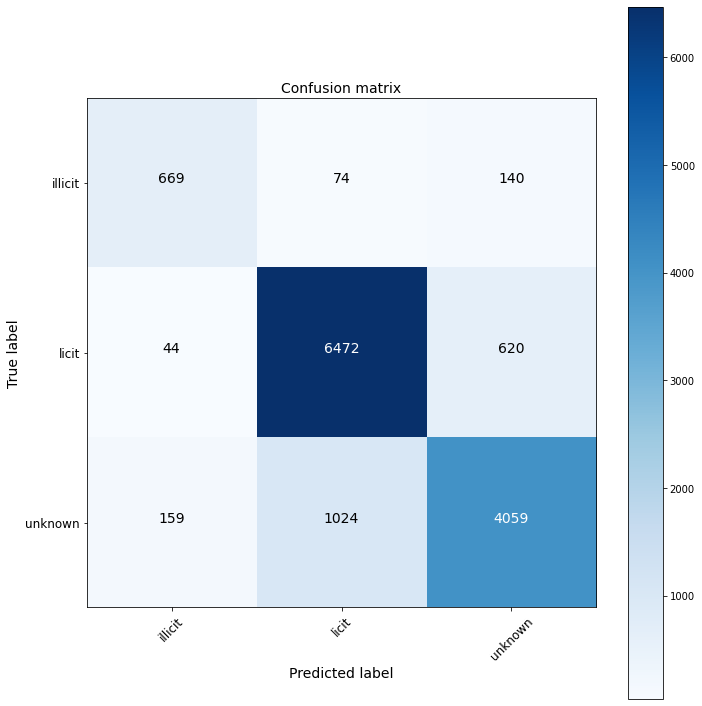

In [35]:
test_logits = model(x, edge_index)
test_sf = F.log_softmax(test_logits, dim=1)
maxs, preds = torch.max(test_sf, dim=1)
preds = preds[labelled_mask][pyg.test_mask]

test_labels = labels_tensor[labelled_mask][pyg.test_mask]

c_matrix_pyg = np.zeros((classes_length, classes_length), int)
ids_matrix = [ [[] for x in range(classes_length)] for y in range(classes_length)]

for i in range(len(test_labels)):
    pred = preds[i]
    label = test_labels[i]

    c_matrix_pyg[label][pred] += 1
    
plot_c_matrix(c_matrix_pyg, classes)

DGL---
Confusion matrix, without normalization
[[ 706   49  128]
 [  60 6276  800]
 [ 130  753 4359]]
Accuracy: 0.8552
Precision: 0.833, Recall: 0.8369
F1 score: 0.8349
PyG----
Confusion matrix, without normalization
[[ 669   74  140]
 [  44 6472  620]
 [ 159 1024 4059]]
Accuracy: 0.8446
Precision: 0.8215, Recall: 0.813
F1 score: 0.8172


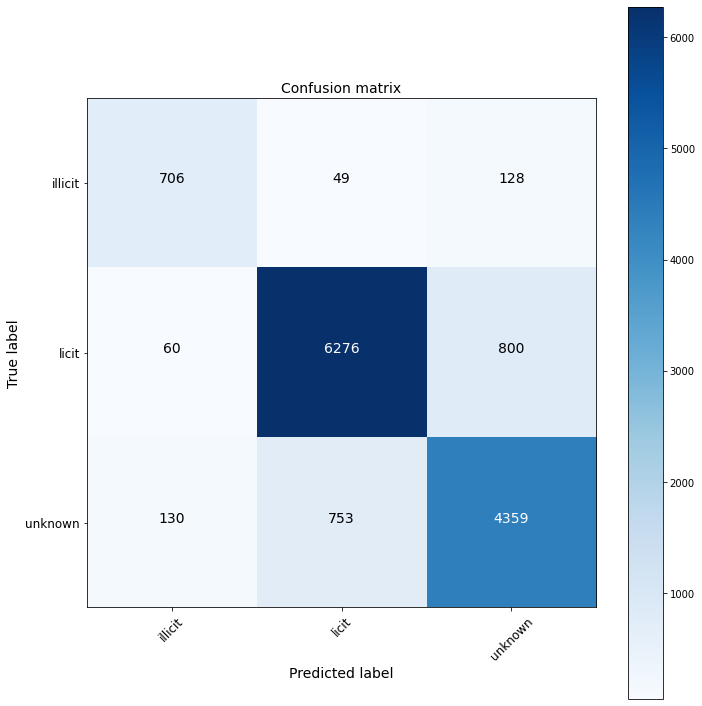

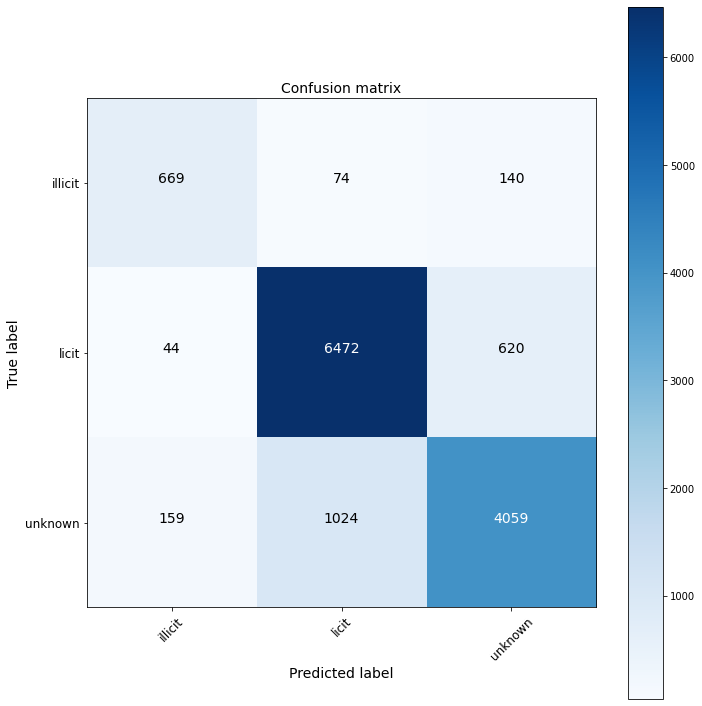

In [36]:
print("DGL---")
plot_c_matrix(c_matrix, classes)
print("PyG----")
plot_c_matrix(c_matrix_pyg, classes)

In [37]:
print("RESAMPLING")
WHOLE_SET = True
if WHOLE_SET:
    labelled_mask = gen_labelled_mask(tx_ids, nodes, 'all')
    train_mask, test_mask = train_test_mask(int(sum(labelled_mask)))

RESAMPLING


DGL
Confusion matrix, without normalization
[[  706    49   128]
 [   60  6283   800]
 [  676  3955 22160]]
Accuracy: 0.8372
Precision: 0.6867, Recall: 0.8354
F1 score: 0.7538


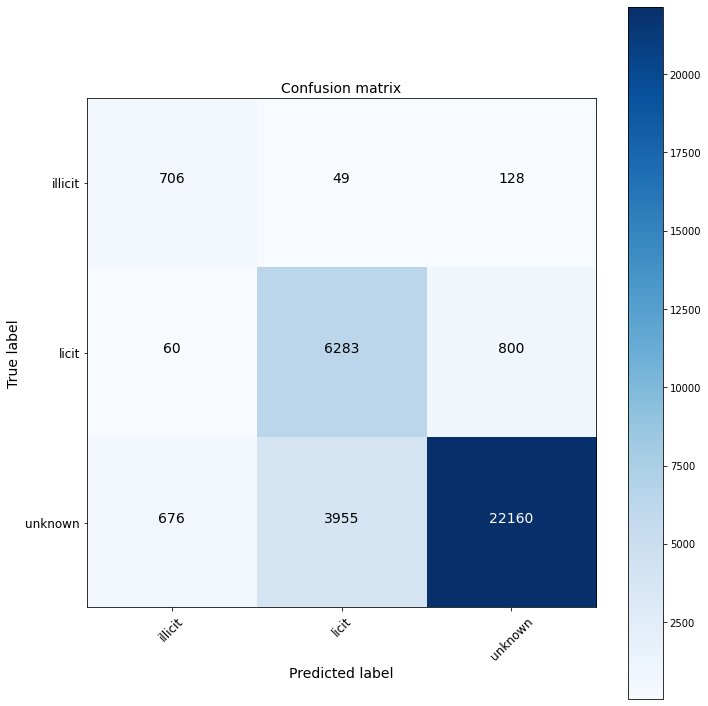

In [38]:
print("DGL")
test_logits = net(g, features_tensor)
test_logits = test_logits[labelled_mask][test_mask]
_, indices = torch.max(test_logits, dim=1)
test_labels = labels_tensor[labelled_mask][test_mask]

c_matrix = np.zeros((classes_length, classes_length), int)

for i in range(len(test_labels)):
    pred = indices[i]
    label = test_labels[i]

    c_matrix[label][pred] += 1
    
plot_c_matrix(c_matrix, classes)

PyG
Confusion matrix, without normalization
[[  649    89   145]
 [   45  6460   638]
 [  750  5293 20748]]
Accuracy: 0.8001
Precision: 0.6529, Recall: 0.8046
F1 score: 0.7208


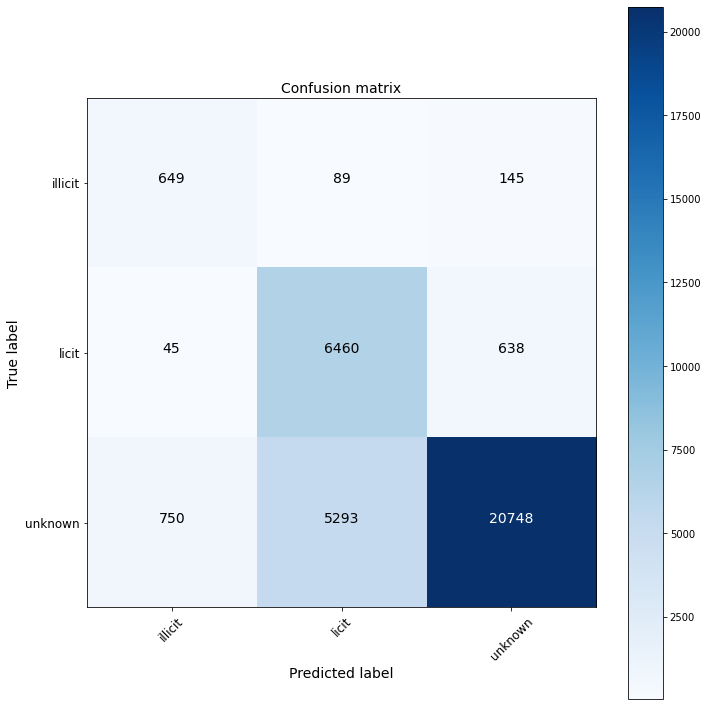

In [39]:
print("PyG")
pyg.test_mask = test_mask
test_logits = model(x, edge_index)
test_sf = F.log_softmax(test_logits, dim=1)
maxs, preds = torch.max(test_sf, dim=1)
preds = preds[labelled_mask][pyg.test_mask]

test_labels = labels_tensor[labelled_mask][pyg.test_mask]

c_matrix_pyg = np.zeros((classes_length, classes_length), int)
ids_matrix = [ [[] for x in range(classes_length)] for y in range(classes_length)]

for i in range(len(test_labels)):
    pred = preds[i]
    label = test_labels[i]

    c_matrix_pyg[label][pred] += 1
    
plot_c_matrix(c_matrix_pyg, classes)